# Fine-Tuning, Cross-Validation and PBT algorithm for BERT

Note: PBT algorithm took awhile to execute on colab pro

All directories have been commented out and marked with a large text cell above where directories need to be replaced

In [ ]:
#older version of pickle installed due to compatability issues with Ray PBT algorithm
!pip install pickle5
import pickle5 as pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 14.7 MB/s 


In [ ]:
!pip install datasets seqeval transformers "ray[tune]" scipy sklearn torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 14.8 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 4.7 MB 63.9 MB/s 
     |████████████████████████████████| 59.4 MB 124 kB/s 
     |████████████████████████████████| 120 kB 72.3 MB/s 
     |████████████████████████████████| 115 kB 90.4 MB/s 
     |████████████████████████████████| 212 kB 92.4 MB/s 
     |████████████████████████████████| 127 kB 87.5 MB/s 
     |████████████████████████████████| 6.6 MB 55.0 MB/s 
     |████████████████████████████████| 8.8 MB 84.4 MB/s 
     |████████████████████████████████| 4.1 MB 65.4 MB/s 
     |████████████████████████████████| 125 kB 88.9 MB/s 
     |████████████████████████████████| 468 kB 93.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=080fb0264cee069e0ba23071039a7c55a851c465ccd2849a53a66ff5cab8b9

In [ ]:
import torch
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict, load_dataset, load_metric
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from sklearn.model_selection import train_test_split
import json
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def tag_creator1(json):
    data_list = json['annotations']
    classes = json['classes']

    store = []
    for sent_ent in data_list:
        store.append((sent_ent[0], sent_ent[1]))
    
    out = []
    for words, ents in store:
        letters = []
        for letter in words:
            letters.append(letter)
        out.append((letters, ents))

    #out = [(['T','o',' ','s'...],{'entities':[[118,132,'MIXED EFFECTS],[...],...]}),(....)]

    all_ranges = []

    for letters_list, entdict in out:
        ranges=[]
        for entpair in entdict['entities']:
            ranges.append((entpair[0],entpair[1],entpair[2]))
        all_ranges.append(ranges) # all_ranges is a list of lists where each sublist contains a tuple [(start_index, end_index, entity)] for each entdict

    for letters_list_entdict_pair in out:
        for ents in letters_list_entdict_pair[1]['entities']:
            start = ents[0]
            end = ents[1]
            ent = ents[2]

            for coded_pair in at_ent_tups:
                if ent == coded_pair[1]:
                    ent = coded_pair[0]

            for i in range(start,end):
                if letters_list_entdict_pair[0][i] != ' ':
                  letters_list_entdict_pair[0][i] = ent

    out2 = []
    
    for letters_list_entdict_pair in out:
        new = ""
        for letter in letters_list_entdict_pair[0]:
            new += letter
        out2.append((new, letters_list_entdict_pair[1]))

    test = ['@0','@1','@2','@3','@4','@5','@6','@7']
    testdict = {}
    for number, cla in zip(test,classes):
        testdict[number] = cla
    #print(testdict)
    #Tokenizing the words in each sentence
    tagslist=[]
    for sent, ents in out2:
        tagslist.append(sent.split(" "))

    #Below reassigns any non entities to 'O' and assigns any entities to 'B -' + the entity type
    for tags in tagslist:
        for i in range(len(tags)):
            if '@0' in tags[i]:
                tags[i] = 'B-' + testdict['@0']
            elif '@1' in tags[i]:
                tags[i] = 'B-' + testdict['@1']
            elif '2@' in tags[i]:
                tags[i] = 'B-' + testdict['@2']
            elif '@3' in tags[i]:
                tags[i] = 'B-' + testdict['@3']
            elif '@4' in tags[i]:
                tags[i] = 'B-' + testdict['@4']
            elif '@5' in tags[i]:
                tags[i] = 'B-' + testdict['@5']
            elif '@6' in tags[i]:
                tags[i] = 'B-' + testdict['@6']
            elif '@7' in tags[i]:
                tags[i] = 'B-' + testdict['@7']
            else:
                tags[i] = 'O'
    #print(tagslist)


    for tags in tagslist:
        for index, elem in enumerate(tags):
            el_minus_1 = tags[index-1]
            el_current = tags[index]
            if el_minus_1.startswith('B') and el_minus_1[-4:].endswith(el_current[-4:]):
                tags[index] = tags[index].replace('B', 'I', 1)
            elif el_minus_1.startswith('I') and el_minus_1[-4:].endswith(el_current[-4:]):
              tags[index] = tags[index].replace('B','I', 1)


    #print(tagslist)
    return tagslist


In [ ]:
def tags_convert2(tag_list):
  out=[]
  for tag in tag_list:
    if tag == 'O':
      out.append(0)
    elif tag == 'B-OLS GLM':
      out.append(1)
    elif tag == 'I-OLS GLM':
      out.append(2)
    elif tag == 'B-MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)':
      out.append(3)
    elif tag == 'I-MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)':
      out.append(4)
    elif tag == 'B-BAYES FACTOR, BAYESIAN ESTIMATION':
      out.append(5)
    elif tag == 'I-BAYES FACTOR, BAYESIAN ESTIMATION':
      out.append(6)
    elif tag == 'B-NON-PARAMETRIC TESTS':
      out.append(7)
    elif tag == 'I-NON-PARAMETRIC TESTS':
      out.append(8)
    elif tag == 'B-ROBUST MODELS (BOOTSTRAPPED OLS, HCSES, M-ESTIMATORS, ROBUST TRIMMING)':
      out.append(9)
    elif tag == 'I-ROBUST MODELS (BOOTSTRAPPED OLS, HCSES, M-ESTIMATORS, ROBUST TRIMMING)':
      out.append(10)
    elif tag == 'B-SCALE DEVELOPMENT, FACTOR ANALYSIS, PCA':
      out.append(11)
    elif tag == 'I-SCALE DEVELOPMENT, FACTOR ANALYSIS, PCA':
      out.append(12)
    elif tag == 'B-OTHER':
      out.append(13)
    elif tag == 'I-OTHER':
      out.append(14)
    elif tag == 'B-CHI-SQUARE, FISHER EXACT':
      out.append(15)
    elif tag == 'I-CHI-SQUARE, FISHER EXACT':
      out.append(16)
    
  return out

In [ ]:
def tags_convert_regcombo(tag_list):
  out=[]
  for tag in tag_list:
    if tag == 'O':
      out.append(0)
    elif tag == 'B-OLS GLM':
      out.append(1)
    elif tag == 'I-OLS GLM':
      out.append(2)
    elif tag == 'B-MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)':
      out.append(1)
    elif tag == 'I-MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)':
      out.append(2)
    elif tag == 'B-BAYES FACTOR, BAYESIAN ESTIMATION':
      out.append(5)
    elif tag == 'I-BAYES FACTOR, BAYESIAN ESTIMATION':
      out.append(6)
    elif tag == 'B-NON-PARAMETRIC TESTS':
      out.append(7)
    elif tag == 'I-NON-PARAMETRIC TESTS':
      out.append(8)
    elif tag == 'B-ROBUST MODELS (BOOTSTRAPPED OLS, HCSES, M-ESTIMATORS, ROBUST TRIMMING)':
      out.append(9)
    elif tag == 'I-ROBUST MODELS (BOOTSTRAPPED OLS, HCSES, M-ESTIMATORS, ROBUST TRIMMING)':
      out.append(10)
    elif tag == 'B-SCALE DEVELOPMENT, FACTOR ANALYSIS, PCA':
      out.append(11)
    elif tag == 'I-SCALE DEVELOPMENT, FACTOR ANALYSIS, PCA':
      out.append(12)
    elif tag == 'B-OTHER':
      out.append(13)
    elif tag == 'I-OTHER':
      out.append(14)
    elif tag == 'B-CHI-SQUARE, FISHER EXACT':
      out.append(15)
    elif tag == 'I-CHI-SQUARE, FISHER EXACT':
      out.append(16)
    
  return out

#Pre-Processing

# **REPLACE DIRECTORY HERE**

In [ ]:
#Will need to replace directory here with own directory of JSON's in zip file. Order does not matter.
f = open(#"/content/drive/MyDrive/Colab Notebooks/anno_mart.json")
g = open(#"/content/drive/MyDrive/Colab Notebooks/annotations_18_08_2022.json")
h = open(#"/content/drive/MyDrive/Colab Notebooks/annotations_22_08_2022.json")
i = open(#"/content/drive/MyDrive/Colab Notebooks/annotations_27_08_2022.json")
TRAIN_DATA = json.load(f)
TRAIN_DATA1 = json.load(g)
TRAIN_DATA2 = json.load(h)
TRAIN_DATA3 = json.load(i)

In [ ]:
coded_entity_types = list(enumerate(TRAIN_DATA['classes']))
O = [(8, 'O')]
coded_with_O = coded_entity_types + O

In [ ]:
at_ent_tups = []
for i,j in coded_entity_types:
  at_ent_tups.append(('@'+str(i),j))

at_ent_tups

[('@0', 'OLS GLM'),
 ('@1', 'MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)'),
 ('@2', 'BAYES FACTOR, BAYESIAN ESTIMATION'),
 ('@3', 'NON-PARAMETRIC TESTS'),
 ('@4',
  'ROBUST MODELS (BOOTSTRAPPED OLS, HCSES, M-ESTIMATORS, ROBUST TRIMMING)'),
 ('@5', 'SCALE DEVELOPMENT, FACTOR ANALYSIS, PCA'),
 ('@6', 'OTHER'),
 ('@7', 'CHI-SQUARE, FISHER EXACT')]

In [ ]:
label_list=[]
label_list.append("O")
for num,ent in coded_entity_types:
  label_list.append("B-"+ent)
  label_list.append("I-"+ent)
label_list

['O',
 'B-OLS GLM',
 'I-OLS GLM',
 'B-MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)',
 'I-MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)',
 'B-BAYES FACTOR, BAYESIAN ESTIMATION',
 'I-BAYES FACTOR, BAYESIAN ESTIMATION',
 'B-NON-PARAMETRIC TESTS',
 'I-NON-PARAMETRIC TESTS',
 'B-ROBUST MODELS (BOOTSTRAPPED OLS, HCSES, M-ESTIMATORS, ROBUST TRIMMING)',
 'I-ROBUST MODELS (BOOTSTRAPPED OLS, HCSES, M-ESTIMATORS, ROBUST TRIMMING)',
 'B-SCALE DEVELOPMENT, FACTOR ANALYSIS, PCA',
 'I-SCALE DEVELOPMENT, FACTOR ANALYSIS, PCA',
 'B-OTHER',
 'I-OTHER',
 'B-CHI-SQUARE, FISHER EXACT',
 'I-CHI-SQUARE, FISHER EXACT']

In [ ]:
full_ent_codes = list(enumerate(label_list))
full_ent_codes

[(0, 'O'),
 (1, 'B-OLS GLM'),
 (2, 'I-OLS GLM'),
 (3, 'B-MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)'),
 (4, 'I-MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)'),
 (5, 'B-BAYES FACTOR, BAYESIAN ESTIMATION'),
 (6, 'I-BAYES FACTOR, BAYESIAN ESTIMATION'),
 (7, 'B-NON-PARAMETRIC TESTS'),
 (8, 'I-NON-PARAMETRIC TESTS'),
 (9,
  'B-ROBUST MODELS (BOOTSTRAPPED OLS, HCSES, M-ESTIMATORS, ROBUST TRIMMING)'),
 (10,
  'I-ROBUST MODELS (BOOTSTRAPPED OLS, HCSES, M-ESTIMATORS, ROBUST TRIMMING)'),
 (11, 'B-SCALE DEVELOPMENT, FACTOR ANALYSIS, PCA'),
 (12, 'I-SCALE DEVELOPMENT, FACTOR ANALYSIS, PCA'),
 (13, 'B-OTHER'),
 (14, 'I-OTHER'),
 (15, 'B-CHI-SQUARE, FISHER EXACT'),
 (16, 'I-CHI-SQUARE, FISHER EXACT')]

# **REPLACE DIRECTORY HERE** - for each dataframe assign the directory of one of the JSON's, order does not matter.

In [ ]:
df = pd.read_json(#"/content/drive/MyDrive/Colab Notebooks/anno_mart.json", orient='index' )
df = df.iloc[1]
sentences=[]
entity_dicts=[]
for i in df:
  sentences.append(i[0])
  entity_dicts.append(i[1])

new = {"sentences": sentences, "entities": entity_dicts}

df = pd.DataFrame(new)
df.head()

sentences  \
0  To explore longitudinal trends in cognitive ab...   
1  Regression slopes for all groups did not reach...   
2  Within these analyses, the percent of particip...   
3  Statistical differences across outcome groups ...   
4  Because the population distribution of RVC is ...   

                                            entities  
0  {'entities': [[126, 157, 'MIXED EFFECTS, MLMS,...  
1                 {'entities': [[0, 17, 'OLS GLM']]}  
2  {'entities': [[210, 226, 'CHI-SQUARE, FISHER E...  
3  {'entities': [[68, 104, 'OLS GLM'], [109, 141,...  
4  {'entities': [[81, 100, 'NON-PARAMETRIC TESTS']]}

In [ ]:
dfx = pd.read_json(#"/content/drive/MyDrive/Colab Notebooks/annotations_18_08_2022.json", orient='index')
dfx = dfx.iloc[1]
sentences=[]
entity_dicts=[]
for i in dfx:
  sentences.append(i[0])
  entity_dicts.append(i[1])

new = {"sentences": sentences, "entities": entity_dicts}

dfx = pd.DataFrame(new)
dfx.tail()

sentences  \
98   For any other MHP, the logistic regression mod...   
99   Cox regression was used to compare the risk of...   
100  The differences between this group and the sta...   
101  This subscale included three items namely, “su...   
102  Descriptive analysis involved means and standa...   

                                              entities  
98   {'entities': [[23, 48, 'MIXED EFFECTS, MLMS, G...  
99   {'entities': [[0, 14, 'MIXED EFFECTS, MLMS, GR...  
100  {'entities': [[115, 136, 'NON-PARAMETRIC TESTS...  
101                                   {'entities': []}  
102               {'entities': [[84, 112, 'OLS GLM']]}

In [ ]:
dfy = pd.read_json(#"/content/drive/MyDrive/Colab Notebooks/annotations_22_08_2022.json", orient='index')
dfy = dfy.iloc[1]
sentences=[]
entity_dicts=[]
for i in dfy:
  sentences.append(i[0])
  entity_dicts.append(i[1])

new = {"sentences": sentences, "entities": entity_dicts}

dfy = pd.DataFrame(new)
dfy.tail()

sentences  \
87  We followed an iterative process to build the ...   
88  Adolescent sex was included in all hierarchica...   
89  The pre-treatment score for the outcome variab...   
90  Logistic regression analyses were conducted to...   
91  A chi-square analysis revealed that the differ...   

                                             entities  
87  {'entities': [[46, 66, 'MIXED EFFECTS, MLMS, G...  
88  {'entities': [[35, 67, 'OLS GLM'], [72, 104, '...  
89  {'entities': [[72, 91, 'OLS GLM'], [126, 150, ...  
90  {'entities': [[0, 28, 'MIXED EFFECTS, MLMS, GR...  
91  {'entities': [[2, 21, 'CHI-SQUARE, FISHER EXAC...

In [ ]:
dfz = pd.read_json(#"/content/drive/MyDrive/Colab Notebooks/annotations_27_08_2022.json", orient='index')
dfz = dfz.iloc[1]
sentences=[]
entity_dicts=[]
for i in dfz:
  sentences.append(i[0])
  entity_dicts.append(i[1])

new = {"sentences": sentences, "entities": entity_dicts}

dfz = pd.DataFrame(new)
dfz.tail()

sentences  \
297  n the current study, a new 2-factor analysis o...   
298  A series of analyses of variance, discriminant...   
299  Moreover, results of factor and discriminant f...   
300  All symptom items for both disorders were ente...   
301  Similarly, when entered into a factor analysis...   

                                              entities  
297  {'entities': [[27, 44, 'SCALE DEVELOPMENT, FAC...  
298  {'entities': [[12, 32, 'OLS GLM'], [34, 64, 'S...  
299  {'entities': [[32, 62, 'SCALE DEVELOPMENT, FAC...  
300  {'entities': [[57, 72, 'SCALE DEVELOPMENT, FAC...  
301  {'entities': [[31, 46, 'SCALE DEVELOPMENT, FAC...

In [ ]:
df = pd.concat([df,dfx,dfy,dfz],ignore_index=True)
df

sentences  \
0    To explore longitudinal trends in cognitive ab...   
1    Regression slopes for all groups did not reach...   
2    Within these analyses, the percent of particip...   
3    Statistical differences across outcome groups ...   
4    Because the population distribution of RVC is ...   
..                                                 ...   
609  n the current study, a new 2-factor analysis o...   
610  A series of analyses of variance, discriminant...   
611  Moreover, results of factor and discriminant f...   
612  All symptom items for both disorders were ente...   
613  Similarly, when entered into a factor analysis...   

                                              entities  
0    {'entities': [[126, 157, 'MIXED EFFECTS, MLMS,...  
1                   {'entities': [[0, 17, 'OLS GLM']]}  
2    {'entities': [[210, 226, 'CHI-SQUARE, FISHER E...  
3    {'entities': [[68, 104, 'OLS GLM'], [109, 141,...  
4    {'entities': [[81, 100, 'NON-PARAMETRIC TESTS']]}  
..                                                 ...  
609  {'entities': [[27, 44, 'SCALE DEVELOPMENT, FAC...  
610  {'entities': [[12, 32, 'OLS GLM'], [34, 64, 'S...  
611  {'entities': [[32, 62, 'SCALE DEVELOPMENT, FAC...  
612  {'entities': [[57, 72, 'SCALE DEVELOPMENT, FAC...  
613  {'entities': [[31, 46, 'SCALE DEVELOPMENT, FAC...  

[614 rows x 2 columns]

In [ ]:
tags = tag_creator1(TRAIN_DATA)
tagsx = tag_creator1(TRAIN_DATA1)
tagsy = tag_creator1(TRAIN_DATA2)
tagsz = tag_creator1(TRAIN_DATA3)
tags1 = []
for i in tags:
  tags1.append(tags_convert2(i))

for i in tagsx:
  tags1.append(tags_convert2(i))

for i in tagsy:
  tags1.append(tags_convert2(i))

for i in tagsz:
  tags1.append(tags_convert2(i))

{'@0': 'OLS GLM', '@1': 'MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)', '@2': 'BAYES FACTOR, BAYESIAN ESTIMATION', '@3': 'NON-PARAMETRIC TESTS', '@4': 'ROBUST MODELS (BOOTSTRAPPED OLS, HCSES, M-ESTIMATORS, ROBUST TRIMMING)', '@5': 'SCALE DEVELOPMENT, FACTOR ANALYSIS, PCA', '@6': 'OTHER', '@7': 'CHI-SQUARE, FISHER EXACT'}
[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)', 'B-MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)', 'B-MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)', 'B-MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['B-OLS GLM', 'B-OLS GLM', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], [

In [ ]:
tags = tag_creator1(TRAIN_DATA)
tagsx = tag_creator1(TRAIN_DATA1)
tagsy = tag_creator1(TRAIN_DATA2)
tagsz = tag_creator1(TRAIN_DATA3)
tags1 = []
for i in tags:
  tags1.append(tags_convert_regcombo(i))

for i in tagsx:
  tags1.append(tags_convert_regcombo(i))

for i in tagsy:
  tags1.append(tags_convert_regcombo(i))

for i in tagsz:
  tags1.append(tags_convert_regcombo(i))

{'@0': 'OLS GLM', '@1': 'MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)', '@2': 'BAYES FACTOR, BAYESIAN ESTIMATION', '@3': 'NON-PARAMETRIC TESTS', '@4': 'ROBUST MODELS (BOOTSTRAPPED OLS, HCSES, M-ESTIMATORS, ROBUST TRIMMING)', '@5': 'SCALE DEVELOPMENT, FACTOR ANALYSIS, PCA', '@6': 'OTHER', '@7': 'CHI-SQUARE, FISHER EXACT'}
[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)', 'B-MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)', 'B-MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)', 'B-MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['B-OLS GLM', 'B-OLS GLM', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], [

In [ ]:
sentence_taglist_dict = {}
for sent, tags in zip(df['sentences'],tags1):
  sentence_taglist_dict[sent] = tags

In [ ]:
def label(row):
  for i in df['sentences']:
      if row == i:
        return sentence_taglist_dict[i]

In [ ]:
df['Coded'] = df['sentences'].apply(lambda row: label(row))

In [ ]:
df['sentences'] = df['sentences'].apply(lambda row: row.split(" "))
df

sentences  \
0    [To, explore, longitudinal, trends, in, cognit...   
1    [Regression, slopes, for, all, groups, did, no...   
2    [Within, these, analyses,, the, percent, of, p...   
3    [Statistical, differences, across, outcome, gr...   
4    [Because, the, population, distribution, of, R...   
..                                                 ...   
609  [n, the, current, study,, a, new, 2-factor, an...   
610  [A, series, of, analyses, of, variance,, discr...   
611  [Moreover,, results, of, factor, and, discrimi...   
612  [All, symptom, items, for, both, disorders, we...   
613  [Similarly,, when, entered, into, a, factor, a...   

                                              entities  \
0    {'entities': [[126, 157, 'MIXED EFFECTS, MLMS,...   
1                   {'entities': [[0, 17, 'OLS GLM']]}   
2    {'entities': [[210, 226, 'CHI-SQUARE, FISHER E...   
3    {'entities': [[68, 104, 'OLS GLM'], [109, 141,...   
4    {'entities': [[81, 100, 'NON-PARAMETRIC TESTS']]}   
..                                                 ...   
609  {'entities': [[27, 44, 'SCALE DEVELOPMENT, FAC...   
610  {'entities': [[12, 32, 'OLS GLM'], [34, 64, 'S...   
611  {'entities': [[32, 62, 'SCALE DEVELOPMENT, FAC...   
612  {'entities': [[57, 72, 'SCALE DEVELOPMENT, FAC...   
613  {'entities': [[31, 46, 'SCALE DEVELOPMENT, FAC...   

                                                 Coded  
0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1    [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3    [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 0, 15,...  
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, ...  
..                                                 ...  
609  [0, 0, 0, 0, 0, 0, 11, 12, 0, 0, 0, 0, 0, 0, 0...  
610  [0, 0, 0, 1, 2, 2, 11, 12, 12, 0, 11, 12, 0, 0...  
611  [0, 0, 0, 0, 0, 11, 12, 12, 0, 0, 0, 0, 0, 0, ...  
612  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 12, 0, 0, 0...  
613  [0, 0, 0, 0, 0, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0...  

[614 rows x 3 columns]

In [ ]:
df.tail()

sentences  \
609  [n, the, current, study,, a, new, 2-factor, an...   
610  [A, series, of, analyses, of, variance,, discr...   
611  [Moreover,, results, of, factor, and, discrimi...   
612  [All, symptom, items, for, both, disorders, we...   
613  [Similarly,, when, entered, into, a, factor, a...   

                                              entities  \
609  {'entities': [[27, 44, 'SCALE DEVELOPMENT, FAC...   
610  {'entities': [[12, 32, 'OLS GLM'], [34, 64, 'S...   
611  {'entities': [[32, 62, 'SCALE DEVELOPMENT, FAC...   
612  {'entities': [[57, 72, 'SCALE DEVELOPMENT, FAC...   
613  {'entities': [[31, 46, 'SCALE DEVELOPMENT, FAC...   

                                                 Coded  
609  [0, 0, 0, 0, 0, 0, 11, 12, 0, 0, 0, 0, 0, 0, 0...  
610  [0, 0, 0, 1, 2, 2, 11, 12, 12, 0, 11, 12, 0, 0...  
611  [0, 0, 0, 0, 0, 11, 12, 12, 0, 0, 0, 0, 0, 0, ...  
612  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 12, 0, 0, 0...  
613  [0, 0, 0, 0, 0, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0...

In [ ]:
df = df.drop('entities',axis=1)

In [ ]:
df = df.rename(columns={"sentences": "Sentences"})
df

Sentences  \
0    [To, explore, longitudinal, trends, in, cognit...   
1    [Regression, slopes, for, all, groups, did, no...   
2    [Within, these, analyses,, the, percent, of, p...   
3    [Statistical, differences, across, outcome, gr...   
4    [Because, the, population, distribution, of, R...   
..                                                 ...   
609  [n, the, current, study,, a, new, 2-factor, an...   
610  [A, series, of, analyses, of, variance,, discr...   
611  [Moreover,, results, of, factor, and, discrimi...   
612  [All, symptom, items, for, both, disorders, we...   
613  [Similarly,, when, entered, into, a, factor, a...   

                                                 Coded  
0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1    [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3    [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 0, 15,...  
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, ...  
..                                                 ...  
609  [0, 0, 0, 0, 0, 0, 11, 12, 0, 0, 0, 0, 0, 0, 0...  
610  [0, 0, 0, 1, 2, 2, 11, 12, 12, 0, 11, 12, 0, 0...  
611  [0, 0, 0, 0, 0, 11, 12, 12, 0, 0, 0, 0, 0, 0, ...  
612  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 12, 0, 0, 0...  
613  [0, 0, 0, 0, 0, 11, 12, 0, 0, 0, 0, 0, 0, 0, 0...  

[614 rows x 2 columns]

In [ ]:
#tds = Dataset.from_pandas(train)
#tsds = Dataset.from_pandas(test)
#vds = Dataset.from_pandas(validate)
#ds = DatasetDict()
#ds['train'] = tds
#ds['test'] = tsds
#ds['validate'] = vds

In [ ]:
ds = Dataset.from_pandas(df).train_test_split(test_size=0.2)
ds

DatasetDict({
    train: Dataset({
        features: ['Sentences', 'Coded'],
        num_rows: 491
    })
    test: Dataset({
        features: ['Sentences', 'Coded'],
        num_rows: 123
    })
})

In [ ]:
model = AutoModelForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(label_list))
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
label_all_tokens = True

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["Sentences"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples["Coded"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
tokenized_datasets = ds.map(tokenize_and_align_labels, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
batch_size=8

args = TrainingArguments(
    "bert-finetune",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=20,
    weight_decay=0.01,
    logging_steps=1
)

data_collator = DataCollatorForTokenClassification(tokenizer)

metric = load_metric("seqeval")

In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels, zero_division=1)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
def model_init():
    return AutoModelForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(label_list))

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    model_init = model_init
)
#trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/trainer.py:350: FutureWarning: `Trainer` requires either a `model` or `model_init` argument, but not both. `model_init` will overwrite your model when calling the `train` method. This will become a fatal error in the next release.
  FutureWarning,


#PBT

In [ ]:
import ray
from ray import tune
from ray.tune.schedulers import PopulationBasedTraining
from ray.tune import CLIReporter

In [ ]:
tune_config = {
    "per_device_train_batch_size": 32,
    "per_device_eval_batch_size": 32,
    "num_train_epochs": tune.choice([8, 10, 12, 15]),
    #"max_steps": 1 if smoke_test else -1,  # Used for smoke test.
}

In [ ]:
scheduler = PopulationBasedTraining(
    time_attr="training_iteration",
    metric="eval_f1",
    mode="max",
    perturbation_interval=5,
    hyperparam_mutations={
      "weight_decay": tune.uniform(0.0, 0.3), 
      "learning_rate": tune.uniform(1e-5, 5e-5),
      "per_device_train_batch_size": [16, 32, 64]
    }
)

In [ ]:
reporter = CLIReporter(
    parameter_columns={
        "weight_decay": "w_decay",
        "learning_rate": "lr",
        "per_device_train_batch_size": "train_bs/gpu",
        "num_train_epochs": "num_epochs",
    },
    metric_columns=["eval_f1", "eval_loss", "epoch"],
)

In [ ]:
import multiprocessing

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

4

In [ ]:
hpsearch = trainer.hyperparameter_search(
    hp_space=lambda _: tune_config,
    backend="ray",
    n_trials=3,
    resources_per_trial={"cpu": 2, "gpu": 1},
    scheduler=scheduler,
    keep_checkpoints_num=1,
    checkpoint_score_attr="training_iteration",
    progress_reporter=reporter,
    reuse_actors=True,
    local_dir="/content/drive/MyDrive/Colab Notebooks/",
    name="tune_transformer_pbt_BERT_1",
    log_to_file=True,
)

2022-08-30 16:00:51,102	INFO worker.py:1518 -- Started a local Ray instance.
/usr/local/lib/python3.7/dist-packages/ray/tune/trainable/function_trainable.py:644: DeprecationWarning: `checkpoint_dir` in `func(config, checkpoint_dir)` is being deprecated. To save and load checkpoint in trainable functions, please use the `ray.air.session` API:

from ray.air import session

def train(config):
    # ...
    session.report({"metric": metric}, checkpoint=checkpoint)

For more information please see https://docs.ray.io/en/master/ray-air/key-concepts.html#session

  DeprecationWarning,
2022-08-30 16:00:54,711	WARNING trial_runner.py:1576 -- You are trying to access _search_alg interface of TrialRunner in TrialScheduler, which is being restricted. If you believe it is reasonable for your scheduler to access this TrialRunner API, please reach out to Ray team on GitHub. A more strict API access pattern would be enforced starting 1.12s.0


== Status ==
Current time: 2022-08-30 16:00:54 (running for 00:00:00.23)
Memory usage on this node: 3.6/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------|
| _objective_eda22_00000 | RUNNING  | 172.28.0.2:674 | 0.238963  | 1.73374e-05 |             32 |           12 |
| _objective_eda22_00001 | PENDING  |                | 0.179598  | 1.62407e-05 |             32 |           15 |
| _objective_eda22_00002 | P

(_objective pid=674) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
(_objective pid=674) - This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=674) - This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=674) Some weights of BertFo

== Status ==
Current time: 2022-08-30 16:01:04 (running for 00:00:10.17)
Memory usage on this node: 5.2/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------|
| _objective_eda22_00000 | RUNNING  | 172.28.0.2:674 | 0.238963  | 1.73374e-05 |             32 |           12 |
| _objective_eda22_00001 | PENDING  |                | 0.179598  | 1.62407e-05 |             32 |           15 |
| _objective_eda22_00002 | P

(_objective pid=674) /usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=674)   FutureWarning,
  0%|          | 1/744 [00:02<31:29,  2.54s/it]


(_objective pid=674) {'loss': 2.9962, 'learning_rate': 1.7314088648954826e-05, 'epoch': 0.02}


  1%|          | 4/744 [00:02<05:31,  2.23it/s]


(_objective pid=674) {'loss': 2.7905, 'learning_rate': 1.7290785703263097e-05, 'epoch': 0.03}
(_objective pid=674) {'loss': 2.6005, 'learning_rate': 1.7267482757571368e-05, 'epoch': 0.05}


  1%|          | 6/744 [00:03<03:10,  3.86it/s]


(_objective pid=674) {'loss': 2.3223, 'learning_rate': 1.724417981187964e-05, 'epoch': 0.06}
(_objective pid=674) {'loss': 2.1262, 'learning_rate': 1.7220876866187907e-05, 'epoch': 0.08}
(_objective pid=674) {'loss': 2.038, 'learning_rate': 1.7197573920496178e-05, 'epoch': 0.1}


  1%|          | 8/744 [00:03<02:19,  5.29it/s]


(_objective pid=674) {'loss': 1.8046, 'learning_rate': 1.717427097480445e-05, 'epoch': 0.11}
(_objective pid=674) {'loss': 1.5569, 'learning_rate': 1.715096802911272e-05, 'epoch': 0.13}


  1%|▏         | 10/744 [00:03<01:45,  6.93it/s]


(_objective pid=674) {'loss': 1.2039, 'learning_rate': 1.712766508342099e-05, 'epoch': 0.15}
(_objective pid=674) {'loss': 1.1701, 'learning_rate': 1.7104362137729263e-05, 'epoch': 0.16}


  2%|▏         | 12/744 [00:03<01:45,  6.92it/s]


(_objective pid=674) {'loss': 0.9209, 'learning_rate': 1.7081059192037534e-05, 'epoch': 0.18}
(_objective pid=674) {'loss': 0.6541, 'learning_rate': 1.7057756246345805e-05, 'epoch': 0.19}


  2%|▏         | 13/744 [00:03<01:41,  7.22it/s]


(_objective pid=674) {'loss': 0.6625, 'learning_rate': 1.7034453300654076e-05, 'epoch': 0.21}
(_objective pid=674) {'loss': 0.8347, 'learning_rate': 1.7011150354962347e-05, 'epoch': 0.23}


  2%|▏         | 15/744 [00:04<01:38,  7.37it/s]


(_objective pid=674) {'loss': 0.4578, 'learning_rate': 1.6987847409270615e-05, 'epoch': 0.24}
(_objective pid=674) {'loss': 0.5765, 'learning_rate': 1.6964544463578886e-05, 'epoch': 0.26}


  2%|▏         | 17/744 [00:04<01:30,  8.07it/s]


(_objective pid=674) {'loss': 0.6411, 'learning_rate': 1.6941241517887157e-05, 'epoch': 0.27}
(_objective pid=674) {'loss': 0.5312, 'learning_rate': 1.6917938572195428e-05, 'epoch': 0.29}


  3%|▎         | 20/744 [00:04<01:25,  8.47it/s]


(_objective pid=674) {'loss': 0.465, 'learning_rate': 1.68946356265037e-05, 'epoch': 0.31}
(_objective pid=674) {'loss': 0.7597, 'learning_rate': 1.687133268081197e-05, 'epoch': 0.32}
== Status ==
Current time: 2022-08-30 16:01:09 (running for 00:00:15.19)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------|
| _objective_eda22_00000 | RUNNING  | 172.28.0.2:674 | 0.238963  | 1.7

  3%|▎         | 22/744 [00:04<01:27,  8.27it/s]


(_objective pid=674) {'loss': 0.6625, 'learning_rate': 1.684802973512024e-05, 'epoch': 0.34}
(_objective pid=674) {'loss': 0.6156, 'learning_rate': 1.6824726789428513e-05, 'epoch': 0.35}


  3%|▎         | 24/744 [00:05<01:21,  8.79it/s]


(_objective pid=674) {'loss': 0.441, 'learning_rate': 1.6801423843736784e-05, 'epoch': 0.37}
(_objective pid=674) {'loss': 0.6548, 'learning_rate': 1.6778120898045055e-05, 'epoch': 0.39}


  3%|▎         | 26/744 [00:05<01:28,  8.13it/s]


(_objective pid=674) {'loss': 0.6027, 'learning_rate': 1.6754817952353323e-05, 'epoch': 0.4}
(_objective pid=674) {'loss': 0.3883, 'learning_rate': 1.6731515006661594e-05, 'epoch': 0.42}
(_objective pid=674) {'loss': 0.4976, 'learning_rate': 1.6708212060969865e-05, 'epoch': 0.44}


  4%|▍         | 28/744 [00:05<01:35,  7.50it/s]


(_objective pid=674) {'loss': 0.9772, 'learning_rate': 1.6684909115278136e-05, 'epoch': 0.45}


  4%|▍         | 30/744 [00:05<01:32,  7.73it/s]


(_objective pid=674) {'loss': 0.5879, 'learning_rate': 1.6661606169586407e-05, 'epoch': 0.47}
(_objective pid=674) {'loss': 0.5412, 'learning_rate': 1.663830322389468e-05, 'epoch': 0.48}


  4%|▍         | 32/744 [00:06<01:24,  8.39it/s]


(_objective pid=674) {'loss': 0.3436, 'learning_rate': 1.661500027820295e-05, 'epoch': 0.5}
(_objective pid=674) {'loss': 0.3825, 'learning_rate': 1.659169733251122e-05, 'epoch': 0.52}


  5%|▍         | 34/744 [00:06<01:25,  8.30it/s]


(_objective pid=674) {'loss': 0.2791, 'learning_rate': 1.6568394386819492e-05, 'epoch': 0.53}
(_objective pid=674) {'loss': 0.346, 'learning_rate': 1.654509144112776e-05, 'epoch': 0.55}


  5%|▍         | 35/744 [00:06<01:22,  8.58it/s]


(_objective pid=674) {'loss': 0.3075, 'learning_rate': 1.652178849543603e-05, 'epoch': 0.56}


  5%|▍         | 37/744 [00:06<01:25,  8.31it/s]


(_objective pid=674) {'loss': 0.4046, 'learning_rate': 1.6498485549744302e-05, 'epoch': 0.58}
(_objective pid=674) {'loss': 0.6006, 'learning_rate': 1.6475182604052573e-05, 'epoch': 0.6}


  5%|▌         | 39/744 [00:07<01:22,  8.58it/s]


(_objective pid=674) {'loss': 0.7889, 'learning_rate': 1.6451879658360844e-05, 'epoch': 0.61}
(_objective pid=674) {'loss': 0.4604, 'learning_rate': 1.6428576712669115e-05, 'epoch': 0.63}


  6%|▌         | 41/744 [00:07<01:26,  8.16it/s]


(_objective pid=674) {'loss': 0.4905, 'learning_rate': 1.6405273766977386e-05, 'epoch': 0.65}
(_objective pid=674) {'loss': 0.5372, 'learning_rate': 1.6381970821285658e-05, 'epoch': 0.66}
(_objective pid=674) {'loss': 0.7656, 'learning_rate': 1.635866787559393e-05, 'epoch': 0.68}


  6%|▌         | 42/744 [00:07<01:19,  8.84it/s]
                                                
  6%|▌         | 44/744 [00:07<01:18,  8.92it/s]


(_objective pid=674) {'loss': 0.4735, 'learning_rate': 1.63353649299022e-05, 'epoch': 0.69}
(_objective pid=674) {'loss': 0.494, 'learning_rate': 1.6312061984210468e-05, 'epoch': 0.71}


  6%|▌         | 46/744 [00:07<01:22,  8.46it/s]


(_objective pid=674) {'loss': 0.3627, 'learning_rate': 1.628875903851874e-05, 'epoch': 0.73}
(_objective pid=674) {'loss': 0.5688, 'learning_rate': 1.626545609282701e-05, 'epoch': 0.74}


  6%|▋         | 47/744 [00:07<01:21,  8.56it/s]


(_objective pid=674) {'loss': 0.4258, 'learning_rate': 1.624215314713528e-05, 'epoch': 0.76}


  7%|▋         | 49/744 [00:08<01:26,  8.06it/s]


(_objective pid=674) {'loss': 0.2851, 'learning_rate': 1.621885020144355e-05, 'epoch': 0.77}
(_objective pid=674) {'loss': 0.2989, 'learning_rate': 1.619554725575182e-05, 'epoch': 0.79}


  7%|▋         | 51/744 [00:08<01:22,  8.42it/s]


(_objective pid=674) {'loss': 0.3195, 'learning_rate': 1.617224431006009e-05, 'epoch': 0.81}
(_objective pid=674) {'loss': 0.5231, 'learning_rate': 1.6148941364368362e-05, 'epoch': 0.82}


  7%|▋         | 54/744 [00:08<01:20,  8.59it/s]


(_objective pid=674) {'loss': 0.4754, 'learning_rate': 1.6125638418676633e-05, 'epoch': 0.84}
(_objective pid=674) {'loss': 0.629, 'learning_rate': 1.6102335472984904e-05, 'epoch': 0.85}


  7%|▋         | 55/744 [00:08<01:26,  7.96it/s]


(_objective pid=674) {'loss': 0.6633, 'learning_rate': 1.6079032527293176e-05, 'epoch': 0.87}
(_objective pid=674) {'loss': 0.4359, 'learning_rate': 1.6055729581601447e-05, 'epoch': 0.89}


  8%|▊         | 57/744 [00:09<01:21,  8.44it/s]


(_objective pid=674) {'loss': 0.4564, 'learning_rate': 1.6032426635909718e-05, 'epoch': 0.9}
(_objective pid=674) {'loss': 0.3718, 'learning_rate': 1.6009123690217986e-05, 'epoch': 0.92}


  8%|▊         | 59/744 [00:09<01:26,  7.94it/s]


(_objective pid=674) {'loss': 0.4716, 'learning_rate': 1.5985820744526257e-05, 'epoch': 0.94}
(_objective pid=674) {'loss': 0.5305, 'learning_rate': 1.5962517798834528e-05, 'epoch': 0.95}


  8%|▊         | 61/744 [00:09<01:24,  8.05it/s]


(_objective pid=674) {'loss': 0.4255, 'learning_rate': 1.59392148531428e-05, 'epoch': 0.97}
(_objective pid=674) {'loss': 0.3983, 'learning_rate': 1.591591190745107e-05, 'epoch': 0.98}


  8%|▊         | 62/744 [00:09<01:24,  8.05it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.942, 'learning_rate': 1.589260896175934e-05, 'epoch': 1.0}
== Status ==
Current time: 2022-08-30 16:01:14 (running for 00:00:20.19)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------|
| _objective_eda22_00000 | RUNNING  | 172.28.0.2:674 | 0.238963  | 1.73374e-05 |             32 |           12 |
| _objective_eda22_00001 | PENDING  |             

(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.19it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.86it/s]
                                                
100%|██████████| 4/4 [00:00<00:00, 10.86it/s]
                                             


Result for _objective_eda22_00000:
  date: 2022-08-30_16-01-15
  done: false
  epoch: 1.0
  eval_accuracy: 0.8932659432139141
  eval_f1: 0.031662269129287594
  eval_loss: 0.43623459339141846
  eval_precision: 0.10714285714285714
  eval_recall: 0.018575851393188854
  eval_runtime: 0.6185
  eval_samples_per_second: 198.871
  eval_steps_per_second: 6.467
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 1.0506469208792477
  pid: 674
  time_since_restore: 15.540086507797241
  time_this_iter_s: 15.540086507797241
  time_total_s: 15.540086507797241
  timestamp: 1661875275
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: eda22_00000
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.43623459339141846, 'eval_precision': 0.10714285714285714, 'eval_recall': 0.018575851393188854, 'eval_f1': 0.031662269129287594, 'eval_accuracy': 0.8932659432139141, 'eval_runtime': 0.

  9%|▊         | 64/744 [00:10<02:49,  4.02it/s]


(_objective pid=674) {'loss': 0.6302, 'learning_rate': 1.5846003070375883e-05, 'epoch': 1.03}
(_objective pid=674) {'loss': 0.2578, 'learning_rate': 1.5822700124684155e-05, 'epoch': 1.05}


  9%|▉         | 67/744 [00:10<01:54,  5.90it/s]


(_objective pid=674) {'loss': 0.2736, 'learning_rate': 1.5799397178992426e-05, 'epoch': 1.06}
(_objective pid=674) {'loss': 0.2691, 'learning_rate': 1.5776094233300693e-05, 'epoch': 1.08}


  9%|▉         | 69/744 [00:11<01:46,  6.35it/s]


(_objective pid=674) {'loss': 0.3524, 'learning_rate': 1.5752791287608965e-05, 'epoch': 1.1}


  9%|▉         | 70/744 [00:11<01:46,  6.35it/s]


(_objective pid=674) {'loss': 0.2094, 'learning_rate': 1.5729488341917236e-05, 'epoch': 1.11}
(_objective pid=674) {'loss': 0.3645, 'learning_rate': 1.5706185396225507e-05, 'epoch': 1.13}
(_objective pid=674) {'loss': 0.4658, 'learning_rate': 1.5682882450533778e-05, 'epoch': 1.15}


 10%|▉         | 73/744 [00:11<01:30,  7.43it/s]


(_objective pid=674) {'loss': 0.3407, 'learning_rate': 1.565957950484205e-05, 'epoch': 1.16}
(_objective pid=674) {'loss': 0.4485, 'learning_rate': 1.563627655915032e-05, 'epoch': 1.18}


 10%|▉         | 74/744 [00:11<01:30,  7.43it/s]


(_objective pid=674) {'loss': 0.2446, 'learning_rate': 1.561297361345859e-05, 'epoch': 1.19}


 10%|█         | 76/744 [00:12<01:27,  7.60it/s]


(_objective pid=674) {'loss': 0.5342, 'learning_rate': 1.5589670667766863e-05, 'epoch': 1.21}
(_objective pid=674) {'loss': 0.4082, 'learning_rate': 1.5566367722075134e-05, 'epoch': 1.23}


 10%|█         | 78/744 [00:12<01:22,  8.08it/s]


(_objective pid=674) {'loss': 0.5522, 'learning_rate': 1.55430647763834e-05, 'epoch': 1.24}
(_objective pid=674) {'loss': 0.4715, 'learning_rate': 1.5519761830691673e-05, 'epoch': 1.26}


 11%|█         | 80/744 [00:12<01:20,  8.27it/s]


(_objective pid=674) {'loss': 0.389, 'learning_rate': 1.5496458884999944e-05, 'epoch': 1.27}
(_objective pid=674) {'loss': 0.566, 'learning_rate': 1.5473155939308215e-05, 'epoch': 1.29}


 11%|█         | 82/744 [00:12<01:12,  9.14it/s]


(_objective pid=674) {'loss': 0.3786, 'learning_rate': 1.5449852993616486e-05, 'epoch': 1.31}
(_objective pid=674) {'loss': 0.2752, 'learning_rate': 1.5426550047924757e-05, 'epoch': 1.32}


 11%|█▏        | 84/744 [00:13<01:20,  8.23it/s]


(_objective pid=674) {'loss': 0.3872, 'learning_rate': 1.5403247102233028e-05, 'epoch': 1.34}
(_objective pid=674) {'loss': 0.7261, 'learning_rate': 1.53799441565413e-05, 'epoch': 1.35}


 12%|█▏        | 86/744 [00:13<01:21,  8.10it/s]


(_objective pid=674) {'loss': 0.4409, 'learning_rate': 1.535664121084957e-05, 'epoch': 1.37}
(_objective pid=674) {'loss': 0.1874, 'learning_rate': 1.5333338265157838e-05, 'epoch': 1.39}


 12%|█▏        | 87/744 [00:13<01:18,  8.33it/s]


(_objective pid=674) {'loss': 0.2998, 'learning_rate': 1.531003531946611e-05, 'epoch': 1.4}


 12%|█▏        | 90/744 [00:13<01:21,  8.05it/s]


(_objective pid=674) {'loss': 0.3022, 'learning_rate': 1.528673237377438e-05, 'epoch': 1.42}
(_objective pid=674) {'loss': 0.1513, 'learning_rate': 1.526342942808265e-05, 'epoch': 1.44}
(_objective pid=674) {'loss': 0.312, 'learning_rate': 1.5240126482390923e-05, 'epoch': 1.45}


 12%|█▏        | 91/744 [00:13<01:17,  8.38it/s]


(_objective pid=674) {'loss': 0.2077, 'learning_rate': 1.5216823536699194e-05, 'epoch': 1.47}


 12%|█▎        | 93/744 [00:14<01:20,  8.12it/s]


(_objective pid=674) {'loss': 0.2428, 'learning_rate': 1.5193520591007465e-05, 'epoch': 1.48}
(_objective pid=674) {'loss': 0.1974, 'learning_rate': 1.5170217645315736e-05, 'epoch': 1.5}


 13%|█▎        | 95/744 [00:14<01:19,  8.12it/s]


(_objective pid=674) {'loss': 0.4047, 'learning_rate': 1.5146914699624006e-05, 'epoch': 1.52}
(_objective pid=674) {'loss': 0.2772, 'learning_rate': 1.5123611753932277e-05, 'epoch': 1.53}


 13%|█▎        | 97/744 [00:14<01:16,  8.45it/s]


(_objective pid=674) {'loss': 0.3208, 'learning_rate': 1.5100308808240548e-05, 'epoch': 1.55}
(_objective pid=674) {'loss': 0.2212, 'learning_rate': 1.5077005862548819e-05, 'epoch': 1.56}


 13%|█▎        | 99/744 [00:14<01:11,  9.02it/s]


(_objective pid=674) {'loss': 0.2411, 'learning_rate': 1.5053702916857088e-05, 'epoch': 1.58}
(_objective pid=674) {'loss': 0.22, 'learning_rate': 1.503039997116536e-05, 'epoch': 1.6}


 14%|█▎        | 101/744 [00:15<01:18,  8.24it/s]


(_objective pid=674) {'loss': 0.434, 'learning_rate': 1.500709702547363e-05, 'epoch': 1.61}
(_objective pid=674) {'loss': 0.2331, 'learning_rate': 1.4983794079781902e-05, 'epoch': 1.63}


 14%|█▎        | 102/744 [00:15<01:19,  8.03it/s]


(_objective pid=674) {'loss': 0.2944, 'learning_rate': 1.4960491134090173e-05, 'epoch': 1.65}
== Status ==
Current time: 2022-08-30 16:01:20 (running for 00:00:25.76)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00000 | RUNNING  | 172.28.0.2:674

 14%|█▍        | 104/744 [00:15<01:24,  7.57it/s]


(_objective pid=674) {'loss': 0.4457, 'learning_rate': 1.4937188188398442e-05, 'epoch': 1.66}
(_objective pid=674) {'loss': 0.4104, 'learning_rate': 1.4913885242706714e-05, 'epoch': 1.68}


 14%|█▍        | 105/744 [00:15<01:23,  7.67it/s]


(_objective pid=674) {'loss': 0.326, 'learning_rate': 1.4890582297014985e-05, 'epoch': 1.69}


 14%|█▍        | 107/744 [00:15<01:19,  8.03it/s]


(_objective pid=674) {'loss': 0.2526, 'learning_rate': 1.4867279351323256e-05, 'epoch': 1.71}
(_objective pid=674) {'loss': 0.2646, 'learning_rate': 1.4843976405631527e-05, 'epoch': 1.73}


 15%|█▍        | 109/744 [00:16<01:20,  7.85it/s]


(_objective pid=674) {'loss': 0.2989, 'learning_rate': 1.4820673459939796e-05, 'epoch': 1.74}
(_objective pid=674) {'loss': 0.2124, 'learning_rate': 1.4797370514248068e-05, 'epoch': 1.76}


 15%|█▍        | 111/744 [00:16<01:18,  8.11it/s]
                                                 
 15%|█▍        | 111/744 [00:16<01:18,  8.11it/s]


(_objective pid=674) {'loss': 0.3867, 'learning_rate': 1.4774067568556339e-05, 'epoch': 1.77}
(_objective pid=674) {'loss': 0.2884, 'learning_rate': 1.475076462286461e-05, 'epoch': 1.79}


 15%|█▌        | 113/744 [00:16<01:15,  8.37it/s]


(_objective pid=674) {'loss': 0.316, 'learning_rate': 1.4727461677172881e-05, 'epoch': 1.81}
(_objective pid=674) {'loss': 0.4254, 'learning_rate': 1.470415873148115e-05, 'epoch': 1.82}


 15%|█▌        | 115/744 [00:16<01:09,  9.09it/s]


(_objective pid=674) {'loss': 0.5162, 'learning_rate': 1.4680855785789422e-05, 'epoch': 1.84}
(_objective pid=674) {'loss': 0.4832, 'learning_rate': 1.4657552840097693e-05, 'epoch': 1.85}


 16%|█▌        | 117/744 [00:17<01:09,  9.04it/s]


(_objective pid=674) {'loss': 0.2677, 'learning_rate': 1.4634249894405964e-05, 'epoch': 1.87}
(_objective pid=674) {'loss': 0.1712, 'learning_rate': 1.4610946948714235e-05, 'epoch': 1.89}


 16%|█▌        | 119/744 [00:17<01:09,  8.96it/s]


(_objective pid=674) {'loss': 0.1804, 'learning_rate': 1.4587644003022504e-05, 'epoch': 1.9}
(_objective pid=674) {'loss': 0.1818, 'learning_rate': 1.4564341057330775e-05, 'epoch': 1.92}


 16%|█▋        | 121/744 [00:17<01:09,  9.02it/s]


(_objective pid=674) {'loss': 0.2826, 'learning_rate': 1.4541038111639047e-05, 'epoch': 1.94}
(_objective pid=674) {'loss': 0.3299, 'learning_rate': 1.4517735165947318e-05, 'epoch': 1.95}


 17%|█▋        | 123/744 [00:17<01:08,  9.10it/s]


(_objective pid=674) {'loss': 0.2249, 'learning_rate': 1.4494432220255587e-05, 'epoch': 1.97}
(_objective pid=674) {'loss': 0.4167, 'learning_rate': 1.4471129274563858e-05, 'epoch': 1.98}


 17%|█▋        | 124/744 [00:17<01:08,  9.10it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.3747, 'learning_rate': 1.444782632887213e-05, 'epoch': 2.0}


(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.04it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.65it/s]
                                                 
100%|██████████| 4/4 [00:00<00:00, 10.65it/s]
                                             


Result for _objective_eda22_00000:
  date: 2022-08-30_16-01-23
  done: false
  epoch: 2.0
  eval_accuracy: 0.9209157127991675
  eval_f1: 0.3228840125391849
  eval_loss: 0.3090004324913025
  eval_precision: 0.326984126984127
  eval_recall: 0.3188854489164087
  eval_runtime: 0.6159
  eval_samples_per_second: 199.719
  eval_steps_per_second: 6.495
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 2
  node_ip: 172.28.0.2
  objective: 1.889669301238888
  pid: 674
  time_since_restore: 23.551568508148193
  time_this_iter_s: 8.011482000350952
  time_total_s: 23.551568508148193
  timestamp: 1661875283
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: eda22_00000
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.3090004324913025, 'eval_precision': 0.326984126984127, 'eval_recall': 0.3188854489164087, 'eval_f1': 0.3228840125391849, 'eval_accuracy': 0.9209157127991675, 'eval_runtime': 0.6159, 'eval_samp

 17%|█▋        | 126/744 [00:18<02:07,  4.84it/s]


(_objective pid=674) {'loss': 0.3486, 'learning_rate': 1.4401220437488672e-05, 'epoch': 2.03}


 17%|█▋        | 127/744 [00:18<01:56,  5.32it/s]


(_objective pid=674) {'loss': 0.1488, 'learning_rate': 1.4377917491796941e-05, 'epoch': 2.05}
(_objective pid=674) {'loss': 0.3262, 'learning_rate': 1.4354614546105212e-05, 'epoch': 2.06}


 17%|█▋        | 129/744 [00:19<01:39,  6.21it/s]


(_objective pid=674) {'loss': 0.3597, 'learning_rate': 1.4331311600413483e-05, 'epoch': 2.08}
(_objective pid=674) {'loss': 0.1367, 'learning_rate': 1.4308008654721755e-05, 'epoch': 2.1}


 18%|█▊        | 131/744 [00:19<01:23,  7.33it/s]


(_objective pid=674) {'loss': 0.1783, 'learning_rate': 1.4284705709030026e-05, 'epoch': 2.11}
(_objective pid=674) {'loss': 0.1847, 'learning_rate': 1.4261402763338295e-05, 'epoch': 2.13}


 18%|█▊        | 134/744 [00:19<01:15,  8.12it/s]


(_objective pid=674) {'loss': 0.3137, 'learning_rate': 1.4238099817646566e-05, 'epoch': 2.15}
(_objective pid=674) {'loss': 0.594, 'learning_rate': 1.4214796871954837e-05, 'epoch': 2.16}


 18%|█▊        | 136/744 [00:19<01:12,  8.40it/s]


(_objective pid=674) {'loss': 0.1042, 'learning_rate': 1.4191493926263109e-05, 'epoch': 2.18}
(_objective pid=674) {'loss': 0.168, 'learning_rate': 1.416819098057138e-05, 'epoch': 2.19}


 19%|█▊        | 138/744 [00:20<01:06,  9.17it/s]


(_objective pid=674) {'loss': 0.2161, 'learning_rate': 1.4144888034879649e-05, 'epoch': 2.21}
(_objective pid=674) {'loss': 0.2924, 'learning_rate': 1.412158508918792e-05, 'epoch': 2.23}


 19%|█▉        | 140/744 [00:20<01:09,  8.71it/s]


(_objective pid=674) {'loss': 0.4159, 'learning_rate': 1.4098282143496191e-05, 'epoch': 2.24}
(_objective pid=674) {'loss': 0.2158, 'learning_rate': 1.407497919780446e-05, 'epoch': 2.26}


 19%|█▉        | 142/744 [00:20<01:10,  8.48it/s]


(_objective pid=674) {'loss': 0.2372, 'learning_rate': 1.405167625211273e-05, 'epoch': 2.27}
(_objective pid=674) {'loss': 0.1338, 'learning_rate': 1.4028373306421001e-05, 'epoch': 2.29}


 19%|█▉        | 144/744 [00:20<01:11,  8.40it/s]


(_objective pid=674) {'loss': 0.1624, 'learning_rate': 1.4005070360729273e-05, 'epoch': 2.31}
(_objective pid=674) {'loss': 0.2698, 'learning_rate': 1.3981767415037544e-05, 'epoch': 2.32}


 20%|█▉        | 146/744 [00:21<01:14,  8.00it/s]


(_objective pid=674) {'loss': 0.2855, 'learning_rate': 1.3958464469345815e-05, 'epoch': 2.34}
(_objective pid=674) {'loss': 0.2606, 'learning_rate': 1.3935161523654084e-05, 'epoch': 2.35}


 20%|█▉        | 148/744 [00:21<01:15,  7.88it/s]


(_objective pid=674) {'loss': 0.3031, 'learning_rate': 1.3911858577962355e-05, 'epoch': 2.37}
(_objective pid=674) {'loss': 0.2131, 'learning_rate': 1.3888555632270626e-05, 'epoch': 2.39}


 20%|██        | 150/744 [00:21<01:13,  8.05it/s]


(_objective pid=674) {'loss': 0.2219, 'learning_rate': 1.3865252686578898e-05, 'epoch': 2.4}
(_objective pid=674) {'loss': 0.1459, 'learning_rate': 1.3841949740887167e-05, 'epoch': 2.42}


 20%|██        | 152/744 [00:21<01:08,  8.66it/s]


(_objective pid=674) {'loss': 0.2203, 'learning_rate': 1.3818646795195438e-05, 'epoch': 2.44}
(_objective pid=674) {'loss': 0.1946, 'learning_rate': 1.379534384950371e-05, 'epoch': 2.45}


 21%|██        | 154/744 [00:22<01:20,  7.30it/s]


(_objective pid=674) {'loss': 0.1029, 'learning_rate': 1.377204090381198e-05, 'epoch': 2.47}
(_objective pid=674) {'loss': 0.3043, 'learning_rate': 1.3748737958120252e-05, 'epoch': 2.48}


 21%|██        | 157/744 [00:22<01:07,  8.70it/s]
                                                 
 21%|██        | 157/744 [00:22<01:07,  8.70it/s]


(_objective pid=674) {'loss': 0.176, 'learning_rate': 1.3725435012428521e-05, 'epoch': 2.5}
(_objective pid=674) {'loss': 0.4082, 'learning_rate': 1.3702132066736792e-05, 'epoch': 2.52}
(_objective pid=674) {'loss': 0.4256, 'learning_rate': 1.3678829121045063e-05, 'epoch': 2.53}


 21%|██▏       | 159/744 [00:22<01:14,  7.85it/s]


(_objective pid=674) {'loss': 0.1655, 'learning_rate': 1.3655526175353334e-05, 'epoch': 2.55}
(_objective pid=674) {'loss': 0.2519, 'learning_rate': 1.3632223229661606e-05, 'epoch': 2.56}


 22%|██▏       | 161/744 [00:22<01:09,  8.42it/s]


(_objective pid=674) {'loss': 0.1915, 'learning_rate': 1.3608920283969875e-05, 'epoch': 2.58}
(_objective pid=674) {'loss': 0.2333, 'learning_rate': 1.3585617338278146e-05, 'epoch': 2.6}


 22%|██▏       | 163/744 [00:23<01:10,  8.20it/s]


(_objective pid=674) {'loss': 0.1921, 'learning_rate': 1.3562314392586417e-05, 'epoch': 2.61}
(_objective pid=674) {'loss': 0.1723, 'learning_rate': 1.3539011446894688e-05, 'epoch': 2.63}
(_objective pid=674) {'loss': 0.2584, 'learning_rate': 1.351570850120296e-05, 'epoch': 2.65}


 22%|██▏       | 165/744 [00:23<01:13,  7.85it/s]


(_objective pid=674) {'loss': 0.2601, 'learning_rate': 1.3492405555511229e-05, 'epoch': 2.66}
== Status ==
Current time: 2022-08-30 16:01:28 (running for 00:00:33.73)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00000 | RUNNING  | 172.28.0.2:674

 22%|██▏       | 167/744 [00:23<01:10,  8.23it/s]


(_objective pid=674) {'loss': 0.1674, 'learning_rate': 1.34691026098195e-05, 'epoch': 2.68}
(_objective pid=674) {'loss': 0.1006, 'learning_rate': 1.3445799664127771e-05, 'epoch': 2.69}


 23%|██▎       | 169/744 [00:23<01:17,  7.43it/s]


(_objective pid=674) {'loss': 0.1455, 'learning_rate': 1.3422496718436042e-05, 'epoch': 2.71}
(_objective pid=674) {'loss': 0.2058, 'learning_rate': 1.3399193772744314e-05, 'epoch': 2.73}


 23%|██▎       | 171/744 [00:24<01:13,  7.80it/s]


(_objective pid=674) {'loss': 0.2054, 'learning_rate': 1.3375890827052583e-05, 'epoch': 2.74}
(_objective pid=674) {'loss': 0.2143, 'learning_rate': 1.3352587881360854e-05, 'epoch': 2.76}


 23%|██▎       | 173/744 [00:24<01:08,  8.39it/s]


(_objective pid=674) {'loss': 0.1599, 'learning_rate': 1.3329284935669125e-05, 'epoch': 2.77}
(_objective pid=674) {'loss': 0.1366, 'learning_rate': 1.3305981989977396e-05, 'epoch': 2.79}


 24%|██▎       | 175/744 [00:24<01:08,  8.31it/s]


(_objective pid=674) {'loss': 0.1568, 'learning_rate': 1.3282679044285666e-05, 'epoch': 2.81}
(_objective pid=674) {'loss': 0.1876, 'learning_rate': 1.3259376098593937e-05, 'epoch': 2.82}


 24%|██▍       | 177/744 [00:24<01:04,  8.78it/s]
                                                 
 24%|██▍       | 177/744 [00:24<01:04,  8.78it/s]


(_objective pid=674) {'loss': 0.162, 'learning_rate': 1.3236073152902208e-05, 'epoch': 2.84}
(_objective pid=674) {'loss': 0.0906, 'learning_rate': 1.321277020721048e-05, 'epoch': 2.85}


 24%|██▍       | 178/744 [00:24<01:03,  8.87it/s]


(_objective pid=674) {'loss': 0.1828, 'learning_rate': 1.318946726151875e-05, 'epoch': 2.87}
(_objective pid=674) {'loss': 0.1037, 'learning_rate': 1.316616431582702e-05, 'epoch': 2.89}


 24%|██▍       | 180/744 [00:25<01:02,  9.01it/s]


(_objective pid=674) {'loss': 0.1894, 'learning_rate': 1.3142861370135291e-05, 'epoch': 2.9}
(_objective pid=674) {'loss': 0.1009, 'learning_rate': 1.3119558424443562e-05, 'epoch': 2.92}


 24%|██▍       | 182/744 [00:25<01:09,  8.12it/s]


(_objective pid=674) {'loss': 0.152, 'learning_rate': 1.3096255478751833e-05, 'epoch': 2.94}
(_objective pid=674) {'loss': 0.1101, 'learning_rate': 1.3072952533060104e-05, 'epoch': 2.95}


 25%|██▍       | 185/744 [00:25<01:08,  8.14it/s]


(_objective pid=674) {'loss': 0.1031, 'learning_rate': 1.3049649587368374e-05, 'epoch': 2.97}
(_objective pid=674) {'loss': 0.1144, 'learning_rate': 1.3026346641676645e-05, 'epoch': 2.98}


 25%|██▌       | 186/744 [00:25<01:08,  8.14it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.0717, 'learning_rate': 1.3003043695984916e-05, 'epoch': 3.0}


(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.20it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.82it/s]


Result for _objective_eda22_00000:
  date: 2022-08-30_16-01-31
  done: false
  epoch: 3.0
  eval_accuracy: 0.9362271443436896
  eval_f1: 0.49002849002849
  eval_loss: 0.2523637115955353
  eval_precision: 0.45382585751978893
  eval_recall: 0.5325077399380805
  eval_runtime: 0.6113
  eval_samples_per_second: 201.204
  eval_steps_per_second: 6.543
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 3
  node_ip: 172.28.0.2
  objective: 2.412589231830049
  pid: 674
  time_since_restore: 31.644826889038086
  time_this_iter_s: 8.093258380889893
  time_total_s: 31.644826889038086
  timestamp: 1661875291
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: eda22_00000
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.2523637115955353, 'eval_precision': 0.45382585751978893, 'eval_recall': 0.5325077399380805, 'eval_f1': 0.49002849002849, 'eval_accuracy': 0.9362271443436896, 'eval_runtime': 0.6113, 'eval_samp

                                                 
100%|██████████| 4/4 [00:00<00:00, 10.82it/s]
                                             
 25%|██▌       | 189/744 [00:26<01:49,  5.05it/s]


(_objective pid=674) {'loss': 0.1856, 'learning_rate': 1.2956437804601458e-05, 'epoch': 3.03}
(_objective pid=674) {'loss': 0.1739, 'learning_rate': 1.2933134858909728e-05, 'epoch': 3.05}


 26%|██▌       | 191/744 [00:27<01:27,  6.30it/s]


(_objective pid=674) {'loss': 0.1712, 'learning_rate': 1.2909831913217999e-05, 'epoch': 3.06}
(_objective pid=674) {'loss': 0.0935, 'learning_rate': 1.288652896752627e-05, 'epoch': 3.08}


 26%|██▌       | 193/744 [00:27<01:19,  6.94it/s]


(_objective pid=674) {'loss': 0.1073, 'learning_rate': 1.2863226021834541e-05, 'epoch': 3.1}
(_objective pid=674) {'loss': 0.1127, 'learning_rate': 1.2839923076142812e-05, 'epoch': 3.11}


 26%|██▌       | 195/744 [00:27<01:11,  7.71it/s]


(_objective pid=674) {'loss': 0.095, 'learning_rate': 1.2816620130451082e-05, 'epoch': 3.13}
(_objective pid=674) {'loss': 0.092, 'learning_rate': 1.2793317184759353e-05, 'epoch': 3.15}


 26%|██▋       | 197/744 [00:27<01:06,  8.20it/s]


(_objective pid=674) {'loss': 0.1051, 'learning_rate': 1.2770014239067624e-05, 'epoch': 3.16}
(_objective pid=674) {'loss': 0.2118, 'learning_rate': 1.2746711293375895e-05, 'epoch': 3.18}


 27%|██▋       | 199/744 [00:28<01:03,  8.58it/s]


(_objective pid=674) {'loss': 0.0753, 'learning_rate': 1.2723408347684166e-05, 'epoch': 3.19}


 27%|██▋       | 201/744 [00:28<01:01,  8.78it/s]


(_objective pid=674) {'loss': 0.2578, 'learning_rate': 1.2700105401992436e-05, 'epoch': 3.21}
(_objective pid=674) {'loss': 0.12, 'learning_rate': 1.2676802456300707e-05, 'epoch': 3.23}
(_objective pid=674) {'loss': 0.0337, 'learning_rate': 1.2653499510608978e-05, 'epoch': 3.24}
(_objective pid=674) {'loss': 0.1182, 'learning_rate': 1.2630196564917249e-05, 'epoch': 3.26}


 27%|██▋       | 203/744 [00:28<01:04,  8.42it/s]


(_objective pid=674) {'loss': 0.0928, 'learning_rate': 1.2606893619225518e-05, 'epoch': 3.27}
(_objective pid=674) {'loss': 0.0828, 'learning_rate': 1.258359067353379e-05, 'epoch': 3.29}


 28%|██▊       | 206/744 [00:28<01:06,  8.09it/s]


(_objective pid=674) {'loss': 0.3169, 'learning_rate': 1.256028772784206e-05, 'epoch': 3.31}
(_objective pid=674) {'loss': 0.1064, 'learning_rate': 1.2536984782150332e-05, 'epoch': 3.32}


 28%|██▊       | 208/744 [00:29<01:03,  8.50it/s]


(_objective pid=674) {'loss': 0.1394, 'learning_rate': 1.2513681836458603e-05, 'epoch': 3.34}
(_objective pid=674) {'loss': 0.2039, 'learning_rate': 1.2490378890766872e-05, 'epoch': 3.35}


 28%|██▊       | 210/744 [00:29<01:01,  8.73it/s]


(_objective pid=674) {'loss': 0.1535, 'learning_rate': 1.2467075945075144e-05, 'epoch': 3.37}
(_objective pid=674) {'loss': 0.1777, 'learning_rate': 1.2443772999383415e-05, 'epoch': 3.39}


 28%|██▊       | 212/744 [00:29<00:59,  9.01it/s]


(_objective pid=674) {'loss': 0.1536, 'learning_rate': 1.2420470053691686e-05, 'epoch': 3.4}
(_objective pid=674) {'loss': 0.1919, 'learning_rate': 1.2397167107999957e-05, 'epoch': 3.42}


 29%|██▉       | 214/744 [00:29<00:55,  9.56it/s]


(_objective pid=674) {'loss': 0.176, 'learning_rate': 1.2373864162308226e-05, 'epoch': 3.44}
(_objective pid=674) {'loss': 0.1535, 'learning_rate': 1.2350561216616498e-05, 'epoch': 3.45}


 29%|██▉       | 215/744 [00:29<00:56,  9.38it/s]
                                                 
 29%|██▉       | 216/744 [00:29<00:59,  8.83it/s]


(_objective pid=674) {'loss': 0.1875, 'learning_rate': 1.2327258270924769e-05, 'epoch': 3.47}
(_objective pid=674) {'loss': 0.1061, 'learning_rate': 1.230395532523304e-05, 'epoch': 3.48}


 29%|██▉       | 217/744 [00:30<00:59,  8.90it/s]


(_objective pid=674) {'loss': 0.2406, 'learning_rate': 1.2280652379541311e-05, 'epoch': 3.5}
(_objective pid=674) {'loss': 0.3737, 'learning_rate': 1.225734943384958e-05, 'epoch': 3.52}


 30%|██▉       | 220/744 [00:30<01:07,  7.79it/s]


(_objective pid=674) {'loss': 0.1173, 'learning_rate': 1.2234046488157852e-05, 'epoch': 3.53}
(_objective pid=674) {'loss': 0.0996, 'learning_rate': 1.2210743542466123e-05, 'epoch': 3.55}


 30%|██▉       | 222/744 [00:30<01:09,  7.46it/s]


(_objective pid=674) {'loss': 0.1748, 'learning_rate': 1.2187440596774394e-05, 'epoch': 3.56}
(_objective pid=674) {'loss': 0.0627, 'learning_rate': 1.2164137651082665e-05, 'epoch': 3.58}


 30%|███       | 224/744 [00:31<01:04,  8.09it/s]


(_objective pid=674) {'loss': 0.1737, 'learning_rate': 1.2140834705390934e-05, 'epoch': 3.6}


 30%|███       | 225/744 [00:31<01:03,  8.23it/s]


(_objective pid=674) {'loss': 0.1447, 'learning_rate': 1.2117531759699206e-05, 'epoch': 3.61}
(_objective pid=674) {'loss': 0.1197, 'learning_rate': 1.2094228814007477e-05, 'epoch': 3.63}


 31%|███       | 227/744 [00:31<01:09,  7.43it/s]
                                                 
 31%|███       | 227/744 [00:31<01:09,  7.43it/s]


(_objective pid=674) {'loss': 0.1001, 'learning_rate': 1.2070925868315748e-05, 'epoch': 3.65}
(_objective pid=674) {'loss': 0.1084, 'learning_rate': 1.2047622922624017e-05, 'epoch': 3.66}
== Status ==
Current time: 2022-08-30 16:01:36 (running for 00:00:41.84)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+----------

 31%|███       | 229/744 [00:31<01:08,  7.56it/s]


(_objective pid=674) {'loss': 0.1787, 'learning_rate': 1.2024319976932288e-05, 'epoch': 3.68}
(_objective pid=674) {'loss': 0.2698, 'learning_rate': 1.200101703124056e-05, 'epoch': 3.69}


 31%|███       | 231/744 [00:31<01:05,  7.83it/s]


(_objective pid=674) {'loss': 0.0646, 'learning_rate': 1.197771408554883e-05, 'epoch': 3.71}
(_objective pid=674) {'loss': 0.1334, 'learning_rate': 1.1954411139857102e-05, 'epoch': 3.73}


 31%|███▏      | 233/744 [00:32<01:09,  7.39it/s]


(_objective pid=674) {'loss': 0.1202, 'learning_rate': 1.1931108194165371e-05, 'epoch': 3.74}
(_objective pid=674) {'loss': 0.1797, 'learning_rate': 1.190780524847364e-05, 'epoch': 3.76}


 32%|███▏      | 235/744 [00:32<01:09,  7.32it/s]


(_objective pid=674) {'loss': 0.1115, 'learning_rate': 1.1884502302781912e-05, 'epoch': 3.77}
(_objective pid=674) {'loss': 0.0766, 'learning_rate': 1.1861199357090183e-05, 'epoch': 3.79}


 32%|███▏      | 237/744 [00:32<01:00,  8.41it/s]


(_objective pid=674) {'loss': 0.098, 'learning_rate': 1.1837896411398452e-05, 'epoch': 3.81}
(_objective pid=674) {'loss': 0.2747, 'learning_rate': 1.1814593465706723e-05, 'epoch': 3.82}


 32%|███▏      | 239/744 [00:32<01:04,  7.83it/s]


(_objective pid=674) {'loss': 0.086, 'learning_rate': 1.1791290520014995e-05, 'epoch': 3.84}
(_objective pid=674) {'loss': 0.3574, 'learning_rate': 1.1767987574323266e-05, 'epoch': 3.85}


 32%|███▏      | 240/744 [00:33<01:04,  7.83it/s]


(_objective pid=674) {'loss': 0.1157, 'learning_rate': 1.1744684628631537e-05, 'epoch': 3.87}


 33%|███▎      | 242/744 [00:33<01:01,  8.20it/s]


(_objective pid=674) {'loss': 0.1046, 'learning_rate': 1.1721381682939806e-05, 'epoch': 3.89}
(_objective pid=674) {'loss': 0.1165, 'learning_rate': 1.1698078737248077e-05, 'epoch': 3.9}


 33%|███▎      | 244/744 [00:33<00:58,  8.52it/s]


(_objective pid=674) {'loss': 0.1092, 'learning_rate': 1.1674775791556349e-05, 'epoch': 3.92}
(_objective pid=674) {'loss': 0.1259, 'learning_rate': 1.165147284586462e-05, 'epoch': 3.94}


 33%|███▎      | 246/744 [00:33<00:57,  8.68it/s]


(_objective pid=674) {'loss': 0.0667, 'learning_rate': 1.162816990017289e-05, 'epoch': 3.95}
(_objective pid=674) {'loss': 0.1378, 'learning_rate': 1.160486695448116e-05, 'epoch': 3.97}


 33%|███▎      | 248/744 [00:33<00:58,  8.48it/s]


(_objective pid=674) {'loss': 0.1889, 'learning_rate': 1.1581564008789431e-05, 'epoch': 3.98}
(_objective pid=674) {'loss': 0.0308, 'learning_rate': 1.1558261063097703e-05, 'epoch': 4.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.21it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.67it/s]
                                                 
100%|██████████| 4/4 [00:00<00:00, 10.67it/s]
                                             


Result for _objective_eda22_00000:
  date: 2022-08-30_16-01-39
  done: false
  epoch: 4.0
  eval_accuracy: 0.9487141370596105
  eval_f1: 0.5921625544267054
  eval_loss: 0.20825518667697906
  eval_precision: 0.5573770491803278
  eval_recall: 0.631578947368421
  eval_runtime: 0.6171
  eval_samples_per_second: 199.324
  eval_steps_per_second: 6.482
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 4
  node_ip: 172.28.0.2
  objective: 2.729832688035065
  pid: 674
  time_since_restore: 39.72632884979248
  time_this_iter_s: 8.081501960754395
  time_total_s: 39.72632884979248
  timestamp: 1661875299
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: eda22_00000
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.20825518667697906, 'eval_precision': 0.5573770491803278, 'eval_recall': 0.631578947368421, 'eval_f1': 0.5921625544267054, 'eval_accuracy': 0.9487141370596105, 'eval_runtime': 0.6171, 'eval_samp

 34%|███▎      | 250/744 [00:34<01:50,  4.45it/s]


(_objective pid=674) {'loss': 0.1933, 'learning_rate': 1.1534958117405974e-05, 'epoch': 4.02}
(_objective pid=674) {'loss': 0.1032, 'learning_rate': 1.1511655171714245e-05, 'epoch': 4.03}


 34%|███▍      | 252/744 [00:35<01:26,  5.71it/s]


(_objective pid=674) {'loss': 0.0907, 'learning_rate': 1.1488352226022514e-05, 'epoch': 4.05}
(_objective pid=674) {'loss': 0.1259, 'learning_rate': 1.1465049280330785e-05, 'epoch': 4.06}


 34%|███▍      | 254/744 [00:35<01:10,  6.92it/s]


(_objective pid=674) {'loss': 0.1098, 'learning_rate': 1.1441746334639057e-05, 'epoch': 4.08}
(_objective pid=674) {'loss': 0.3596, 'learning_rate': 1.1418443388947328e-05, 'epoch': 4.1}


 35%|███▍      | 257/744 [00:35<01:03,  7.71it/s]


(_objective pid=674) {'loss': 0.0413, 'learning_rate': 1.1395140443255597e-05, 'epoch': 4.11}
(_objective pid=674) {'loss': 0.1199, 'learning_rate': 1.1371837497563868e-05, 'epoch': 4.13}
(_objective pid=674) {'loss': 0.1096, 'learning_rate': 1.134853455187214e-05, 'epoch': 4.15}
(_objective pid=674) 


 35%|███▍      | 259/744 [00:35<01:02,  7.77it/s]


(_objective pid=674) {'loss': 0.1912, 'learning_rate': 1.132523160618041e-05, 'epoch': 4.16}
(_objective pid=674) {'loss': 0.2266, 'learning_rate': 1.1301928660488682e-05, 'epoch': 4.18}


 35%|███▌      | 261/744 [00:36<01:01,  7.83it/s]


(_objective pid=674) {'loss': 0.0677, 'learning_rate': 1.1278625714796951e-05, 'epoch': 4.19}
(_objective pid=674) {'loss': 0.0797, 'learning_rate': 1.1255322769105222e-05, 'epoch': 4.21}
(_objective pid=674) {'loss': 0.0521, 'learning_rate': 1.1232019823413493e-05, 'epoch': 4.23}
(_objective pid=674) {'loss': 0.0916, 'learning_rate': 1.1208716877721764e-05, 'epoch': 4.24}


 36%|███▌      | 265/744 [00:36<00:58,  8.12it/s]


(_objective pid=674) {'loss': 0.0692, 'learning_rate': 1.1185413932030036e-05, 'epoch': 4.26}
(_objective pid=674) {'loss': 0.1011, 'learning_rate': 1.1162110986338305e-05, 'epoch': 4.27}


 36%|███▌      | 267/744 [00:36<01:02,  7.65it/s]


(_objective pid=674) {'loss': 0.0714, 'learning_rate': 1.1138808040646576e-05, 'epoch': 4.29}
(_objective pid=674) {'loss': 0.1235, 'learning_rate': 1.1115505094954847e-05, 'epoch': 4.31}


 36%|███▌      | 269/744 [00:37<00:56,  8.43it/s]


(_objective pid=674) {'loss': 0.0971, 'learning_rate': 1.1092202149263118e-05, 'epoch': 4.32}
(_objective pid=674) {'loss': 0.1056, 'learning_rate': 1.106889920357139e-05, 'epoch': 4.34}


 36%|███▋      | 271/744 [00:37<00:55,  8.46it/s]


(_objective pid=674) {'loss': 0.1095, 'learning_rate': 1.1045596257879659e-05, 'epoch': 4.35}
(_objective pid=674) {'loss': 0.0594, 'learning_rate': 1.102229331218793e-05, 'epoch': 4.37}


 37%|███▋      | 273/744 [00:37<00:52,  8.99it/s]


(_objective pid=674) {'loss': 0.0494, 'learning_rate': 1.0998990366496201e-05, 'epoch': 4.39}
(_objective pid=674) {'loss': 0.0803, 'learning_rate': 1.0975687420804472e-05, 'epoch': 4.4}


 37%|███▋      | 274/744 [00:37<00:53,  8.72it/s]


(_objective pid=674) {'loss': 0.0601, 'learning_rate': 1.0952384475112744e-05, 'epoch': 4.42}


 37%|███▋      | 276/744 [00:37<00:58,  8.02it/s]


(_objective pid=674) {'loss': 0.1554, 'learning_rate': 1.0929081529421013e-05, 'epoch': 4.44}
(_objective pid=674) {'loss': 0.0506, 'learning_rate': 1.0905778583729284e-05, 'epoch': 4.45}


                                                 
 37%|███▋      | 277/744 [00:38<00:59,  7.85it/s]


(_objective pid=674) {'loss': 0.035, 'learning_rate': 1.0882475638037555e-05, 'epoch': 4.47}


 38%|███▊      | 279/744 [00:38<01:03,  7.35it/s]


(_objective pid=674) {'loss': 0.0373, 'learning_rate': 1.0859172692345826e-05, 'epoch': 4.48}
(_objective pid=674) {'loss': 0.065, 'learning_rate': 1.0835869746654096e-05, 'epoch': 4.5}


 38%|███▊      | 281/744 [00:38<01:00,  7.69it/s]


(_objective pid=674) {'loss': 0.1109, 'learning_rate': 1.0812566800962367e-05, 'epoch': 4.52}
(_objective pid=674) {'loss': 0.1477, 'learning_rate': 1.0789263855270638e-05, 'epoch': 4.53}


 38%|███▊      | 282/744 [00:38<00:55,  8.29it/s]


(_objective pid=674) {'loss': 0.0739, 'learning_rate': 1.076596090957891e-05, 'epoch': 4.55}


 38%|███▊      | 284/744 [00:38<00:56,  8.17it/s]


(_objective pid=674) {'loss': 0.1011, 'learning_rate': 1.074265796388718e-05, 'epoch': 4.56}
(_objective pid=674) {'loss': 0.0497, 'learning_rate': 1.071935501819545e-05, 'epoch': 4.58}


 38%|███▊      | 286/744 [00:39<00:54,  8.47it/s]


(_objective pid=674) {'loss': 0.1835, 'learning_rate': 1.0696052072503721e-05, 'epoch': 4.6}
(_objective pid=674) {'loss': 0.087, 'learning_rate': 1.0672749126811992e-05, 'epoch': 4.61}


 39%|███▊      | 288/744 [00:39<00:53,  8.47it/s]


(_objective pid=674) {'loss': 0.0697, 'learning_rate': 1.0649446181120263e-05, 'epoch': 4.63}
(_objective pid=674) {'loss': 0.1, 'learning_rate': 1.0626143235428534e-05, 'epoch': 4.65}


 39%|███▉      | 290/744 [00:39<00:54,  8.26it/s]


(_objective pid=674) {'loss': 0.0286, 'learning_rate': 1.0602840289736804e-05, 'epoch': 4.66}
== Status ==
Current time: 2022-08-30 16:01:44 (running for 00:00:49.92)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00000 | RUNNING  | 172.28.0.2:674

 39%|███▉      | 292/744 [00:39<00:54,  8.23it/s]


(_objective pid=674) {'loss': 0.0431, 'learning_rate': 1.0532931452661617e-05, 'epoch': 4.71}


 40%|███▉      | 294/744 [00:40<00:56,  7.93it/s]


(_objective pid=674) {'loss': 0.1923, 'learning_rate': 1.0509628506969888e-05, 'epoch': 4.73}
(_objective pid=674) {'loss': 0.1509, 'learning_rate': 1.0486325561278158e-05, 'epoch': 4.74}


 40%|███▉      | 296/744 [00:40<00:56,  7.91it/s]


(_objective pid=674) {'loss': 0.0465, 'learning_rate': 1.0463022615586429e-05, 'epoch': 4.76}
(_objective pid=674) {'loss': 0.1307, 'learning_rate': 1.04397196698947e-05, 'epoch': 4.77}


 40%|████      | 298/744 [00:40<00:52,  8.49it/s]


(_objective pid=674) {'loss': 0.078, 'learning_rate': 1.0416416724202971e-05, 'epoch': 4.79}
(_objective pid=674) {'loss': 0.1375, 'learning_rate': 1.0393113778511242e-05, 'epoch': 4.81}


 40%|████      | 300/744 [00:40<00:52,  8.54it/s]


(_objective pid=674) {'loss': 0.0208, 'learning_rate': 1.0369810832819512e-05, 'epoch': 4.82}
(_objective pid=674) {'loss': 0.0696, 'learning_rate': 1.0346507887127783e-05, 'epoch': 4.84}


 41%|████      | 302/744 [00:41<00:49,  8.86it/s]


(_objective pid=674) {'loss': 0.037, 'learning_rate': 1.0323204941436054e-05, 'epoch': 4.85}
(_objective pid=674) {'loss': 0.0413, 'learning_rate': 1.0299901995744325e-05, 'epoch': 4.87}


 41%|████      | 304/744 [00:41<00:53,  8.25it/s]


(_objective pid=674) {'loss': 0.0539, 'learning_rate': 1.0276599050052596e-05, 'epoch': 4.89}
(_objective pid=674) {'loss': 0.0639, 'learning_rate': 1.0253296104360866e-05, 'epoch': 4.9}


 41%|████      | 306/744 [00:41<00:51,  8.47it/s]


(_objective pid=674) {'loss': 0.1589, 'learning_rate': 1.0229993158669137e-05, 'epoch': 4.92}


 42%|████▏     | 309/744 [00:41<00:45,  9.60it/s]


(_objective pid=674) {'loss': 0.0775, 'learning_rate': 1.0206690212977408e-05, 'epoch': 4.94}
(_objective pid=674) {'loss': 0.1634, 'learning_rate': 1.0183387267285679e-05, 'epoch': 4.95}
(_objective pid=674) {'loss': 0.2931, 'learning_rate': 1.0160084321593949e-05, 'epoch': 4.97}
(_objective pid=674) {'loss': 0.0869, 'learning_rate': 1.013678137590222e-05, 'epoch': 4.98}
(_objective pid=674) {'loss': 0.2906, 'learning_rate': 1.011347843021049e-05, 'epoch': 5.0}


 42%|████▏     | 310/744 [00:41<00:40, 10.72it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.26it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.84it/s]


Result for _objective_eda22_00000:
  date: 2022-08-30_16-01-47
  done: false
  epoch: 5.0
  eval_accuracy: 0.9442544968039245
  eval_f1: 0.5614489003880982
  eval_loss: 0.2327757626771927
  eval_precision: 0.4822222222222222
  eval_recall: 0.6718266253869969
  eval_runtime: 0.6127
  eval_samples_per_second: 200.738
  eval_steps_per_second: 6.528
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 5
  node_ip: 172.28.0.2
  objective: 2.659752244801242
  pid: 674
  time_since_restore: 47.70257520675659
  time_this_iter_s: 7.976246356964111
  time_total_s: 47.70257520675659
  timestamp: 1661875307
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: eda22_00000
  warmup_time: 0.0033562183380126953
  


                                                 
100%|██████████| 4/4 [00:00<00:00, 10.84it/s]
                                             
 42%|████▏     | 310/744 [00:42<00:59,  7.24it/s]


(_objective pid=674) {'eval_loss': 0.2327757626771927, 'eval_precision': 0.4822222222222222, 'eval_recall': 0.6718266253869969, 'eval_f1': 0.5614489003880982, 'eval_accuracy': 0.9442544968039245, 'eval_runtime': 0.6127, 'eval_samples_per_second': 200.738, 'eval_steps_per_second': 6.528, 'epoch': 5.0}


(_objective pid=674) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
(_objective pid=674) - This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=674) - This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=674) Some weights of BertFo

(_objective pid=674) {'loss': 2.9962, 'learning_rate': 1.6223282450366603e-05, 'epoch': 0.02}
(_objective pid=674) {'loss': 2.8045, 'learning_rate': 1.6205819283035746e-05, 'epoch': 0.03}


  0%|          | 3/930 [00:00<01:42,  9.06it/s]


(_objective pid=674) {'loss': 2.626, 'learning_rate': 1.618835611570489e-05, 'epoch': 0.05}
(_objective pid=674) {'loss': 2.3652, 'learning_rate': 1.6170892948374032e-05, 'epoch': 0.06}


  1%|          | 5/930 [00:00<01:50,  8.37it/s]


(_objective pid=674) {'loss': 2.1772, 'learning_rate': 1.6153429781043175e-05, 'epoch': 0.08}
(_objective pid=674) {'loss': 2.0971, 'learning_rate': 1.6135966613712314e-05, 'epoch': 0.1}


  1%|          | 7/930 [00:00<01:38,  9.39it/s]


(_objective pid=674) {'loss': 1.8774, 'learning_rate': 1.6118503446381457e-05, 'epoch': 0.11}
(_objective pid=674) {'loss': 1.6468, 'learning_rate': 1.61010402790506e-05, 'epoch': 0.13}


  1%|          | 9/930 [00:00<01:39,  9.22it/s]


(_objective pid=674) {'loss': 1.3173, 'learning_rate': 1.6083577111719743e-05, 'epoch': 0.15}
(_objective pid=674) {'loss': 1.277, 'learning_rate': 1.6066113944388886e-05, 'epoch': 0.16}


  1%|          | 11/930 [00:01<01:35,  9.64it/s]


(_objective pid=674) {'loss': 1.0222, 'learning_rate': 1.604865077705803e-05, 'epoch': 0.18}


  1%|▏         | 13/930 [00:01<01:51,  8.25it/s]


(_objective pid=674) {'loss': 0.748, 'learning_rate': 1.603118760972717e-05, 'epoch': 0.19}
(_objective pid=674) {'loss': 0.7076, 'learning_rate': 1.601372444239631e-05, 'epoch': 0.21}


  2%|▏         | 15/930 [00:01<01:54,  7.96it/s]


(_objective pid=674) {'loss': 0.8433, 'learning_rate': 1.5996261275065457e-05, 'epoch': 0.23}
(_objective pid=674) {'loss': 0.4844, 'learning_rate': 1.59787981077346e-05, 'epoch': 0.24}


  2%|▏         | 16/930 [00:01<01:51,  8.23it/s]


(_objective pid=674) {'loss': 0.5863, 'learning_rate': 1.596133494040374e-05, 'epoch': 0.26}
(_objective pid=674) {'loss': 0.6346, 'learning_rate': 1.5943871773072882e-05, 'epoch': 0.27}


  2%|▏         | 18/930 [00:02<01:48,  8.38it/s]


(_objective pid=674) {'loss': 0.5429, 'learning_rate': 1.5926408605742025e-05, 'epoch': 0.29}
(_objective pid=674) {'loss': 0.4676, 'learning_rate': 1.5908945438411168e-05, 'epoch': 0.31}


  2%|▏         | 20/930 [00:02<01:45,  8.60it/s]


(_objective pid=674) {'loss': 0.771, 'learning_rate': 1.589148227108031e-05, 'epoch': 0.32}
(_objective pid=674) {'loss': 0.6664, 'learning_rate': 1.5874019103749453e-05, 'epoch': 0.34}


  2%|▏         | 22/930 [00:02<01:48,  8.38it/s]


(_objective pid=674) {'loss': 0.6259, 'learning_rate': 1.5856555936418596e-05, 'epoch': 0.35}
== Status ==
Current time: 2022-08-30 16:01:52 (running for 00:00:58.15)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNING  | 172.

  3%|▎         | 24/930 [00:02<01:42,  8.85it/s]


(_objective pid=674) {'loss': 0.6591, 'learning_rate': 1.5821629601756882e-05, 'epoch': 0.39}


  3%|▎         | 25/930 [00:02<01:44,  8.62it/s]


(_objective pid=674) {'loss': 0.6128, 'learning_rate': 1.5804166434426025e-05, 'epoch': 0.4}
(_objective pid=674) {'loss': 0.396, 'learning_rate': 1.5786703267095164e-05, 'epoch': 0.42}


  3%|▎         | 27/930 [00:03<01:51,  8.08it/s]


(_objective pid=674) {'loss': 0.5033, 'learning_rate': 1.5769240099764307e-05, 'epoch': 0.44}


  3%|▎         | 29/930 [00:03<01:57,  7.65it/s]


(_objective pid=674) {'loss': 0.9725, 'learning_rate': 1.575177693243345e-05, 'epoch': 0.45}
(_objective pid=674) {'loss': 0.6002, 'learning_rate': 1.5734313765102593e-05, 'epoch': 0.47}


  3%|▎         | 31/930 [00:03<01:52,  8.01it/s]


(_objective pid=674) {'loss': 0.5481, 'learning_rate': 1.5716850597771736e-05, 'epoch': 0.48}
(_objective pid=674) {'loss': 0.353, 'learning_rate': 1.569938743044088e-05, 'epoch': 0.5}


  4%|▎         | 33/930 [00:03<01:47,  8.32it/s]


(_objective pid=674) {'loss': 0.3908, 'learning_rate': 1.568192426311002e-05, 'epoch': 0.52}
(_objective pid=674) {'loss': 0.2854, 'learning_rate': 1.5664461095779164e-05, 'epoch': 0.53}


  4%|▍         | 35/930 [00:04<01:44,  8.58it/s]


(_objective pid=674) {'loss': 0.3604, 'learning_rate': 1.5646997928448307e-05, 'epoch': 0.55}
(_objective pid=674) {'loss': 0.3111, 'learning_rate': 1.562953476111745e-05, 'epoch': 0.56}


  4%|▍         | 37/930 [00:04<01:46,  8.37it/s]


(_objective pid=674) {'loss': 0.4136, 'learning_rate': 1.5612071593786593e-05, 'epoch': 0.58}
(_objective pid=674) {'loss': 0.6181, 'learning_rate': 1.5594608426455732e-05, 'epoch': 0.6}


  4%|▍         | 39/930 [00:04<01:43,  8.61it/s]


(_objective pid=674) {'loss': 0.8081, 'learning_rate': 1.5577145259124875e-05, 'epoch': 0.61}
(_objective pid=674) {'loss': 0.4742, 'learning_rate': 1.5559682091794018e-05, 'epoch': 0.63}


  4%|▍         | 41/930 [00:04<01:49,  8.14it/s]


(_objective pid=674) {'loss': 0.5056, 'learning_rate': 1.554221892446316e-05, 'epoch': 0.65}
(_objective pid=674) {'loss': 0.5492, 'learning_rate': 1.5524755757132303e-05, 'epoch': 0.66}


  5%|▍         | 43/930 [00:05<01:40,  8.85it/s]


(_objective pid=674) {'loss': 0.7941, 'learning_rate': 1.5507292589801446e-05, 'epoch': 0.68}
(_objective pid=674) {'loss': 0.4812, 'learning_rate': 1.548982942247059e-05, 'epoch': 0.69}


  5%|▍         | 45/930 [00:05<01:44,  8.45it/s]


(_objective pid=674) {'loss': 0.5046, 'learning_rate': 1.5472366255139732e-05, 'epoch': 0.71}
(_objective pid=674) {'loss': 0.375, 'learning_rate': 1.5454903087808875e-05, 'epoch': 0.73}
(_objective pid=674) {'loss': 0.59, 'learning_rate': 1.5437439920478018e-05, 'epoch': 0.74}


  5%|▌         | 47/930 [00:05<01:43,  8.57it/s]


(_objective pid=674) {'loss': 0.4364, 'learning_rate': 1.5419976753147157e-05, 'epoch': 0.76}


  5%|▌         | 49/930 [00:05<01:49,  8.04it/s]


(_objective pid=674) {'loss': 0.2922, 'learning_rate': 1.54025135858163e-05, 'epoch': 0.77}
(_objective pid=674) {'loss': 0.3069, 'learning_rate': 1.5385050418485443e-05, 'epoch': 0.79}


  5%|▌         | 51/930 [00:06<01:44,  8.41it/s]


(_objective pid=674) {'loss': 0.325, 'learning_rate': 1.5367587251154586e-05, 'epoch': 0.81}
(_objective pid=674) {'loss': 0.5253, 'learning_rate': 1.535012408382373e-05, 'epoch': 0.82}


  6%|▌         | 53/930 [00:06<01:54,  7.67it/s]


(_objective pid=674) {'loss': 0.4858, 'learning_rate': 1.533266091649287e-05, 'epoch': 0.84}
(_objective pid=674) {'loss': 0.6413, 'learning_rate': 1.5315197749162014e-05, 'epoch': 0.85}


  6%|▌         | 55/930 [00:06<01:49,  7.96it/s]


(_objective pid=674) {'loss': 0.6826, 'learning_rate': 1.5297734581831157e-05, 'epoch': 0.87}
(_objective pid=674) {'loss': 0.4488, 'learning_rate': 1.52802714145003e-05, 'epoch': 0.89}


  6%|▌         | 57/930 [00:06<01:43,  8.45it/s]


(_objective pid=674) {'loss': 0.4621, 'learning_rate': 1.5262808247169443e-05, 'epoch': 0.9}
(_objective pid=674) {'loss': 0.3783, 'learning_rate': 1.5245345079838584e-05, 'epoch': 0.92}


  6%|▋         | 59/930 [00:07<01:50,  7.90it/s]


(_objective pid=674) {'loss': 0.4829, 'learning_rate': 1.5227881912507727e-05, 'epoch': 0.94}
(_objective pid=674) {'loss': 0.5516, 'learning_rate': 1.5210418745176868e-05, 'epoch': 0.95}


  7%|▋         | 61/930 [00:07<01:48,  8.03it/s]


(_objective pid=674) {'loss': 0.4389, 'learning_rate': 1.519295557784601e-05, 'epoch': 0.97}
(_objective pid=674) {'loss': 0.3987, 'learning_rate': 1.5175492410515155e-05, 'epoch': 0.98}


  7%|▋         | 62/930 [00:07<01:48,  8.03it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.9658, 'learning_rate': 1.5158029243184296e-05, 'epoch': 1.0}


(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.20it/s]


== Status ==
Current time: 2022-08-30 16:01:57 (running for 00:01:03.19)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNING  | 172.28.0.2:674 | 0.179598  | 1.62407e-05 |             32 |           15 |           |            

(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.84it/s]
(_objective pid=674) 
                                                
  7%|▋         | 62/930 [00:07<01:48,  8.03it/s]
                                             


Result for _objective_eda22_00001:
  date: 2022-08-30_16-01-58
  done: false
  epoch: 1.0
  eval_accuracy: 0.8916307417868292
  eval_f1: 0.0056022408963585435
  eval_loss: 0.4468097388744354
  eval_precision: 0.029411764705882353
  eval_recall: 0.0030959752321981426
  eval_runtime: 0.6129
  eval_samples_per_second: 200.677
  eval_steps_per_second: 6.526
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.9297407226212683
  pid: 674
  time_since_restore: 10.305219888687134
  time_this_iter_s: 10.305219888687134
  time_total_s: 10.305219888687134
  timestamp: 1661875318
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.4468097388744354, 'eval_precision': 0.029411764705882353, 'eval_recall': 0.0030959752321981426, 'eval_f1': 0.0056022408963585435, 'eval_accuracy': 0.8916307417868292, 'eval_runtime'

  7%|▋         | 64/930 [00:08<03:33,  4.05it/s]


(_objective pid=674) {'loss': 0.6611, 'learning_rate': 1.512310290852258e-05, 'epoch': 1.03}
(_objective pid=674) {'loss': 0.2682, 'learning_rate': 1.5105639741191723e-05, 'epoch': 1.05}


  7%|▋         | 67/930 [00:08<02:25,  5.93it/s]


(_objective pid=674) {'loss': 0.2742, 'learning_rate': 1.5088176573860868e-05, 'epoch': 1.06}
(_objective pid=674) {'loss': 0.2786, 'learning_rate': 1.5070713406530009e-05, 'epoch': 1.08}


  7%|▋         | 69/930 [00:08<02:15,  6.37it/s]
                                                
  7%|▋         | 69/930 [00:08<02:15,  6.37it/s]


(_objective pid=674) {'loss': 0.3614, 'learning_rate': 1.5053250239199152e-05, 'epoch': 1.1}
(_objective pid=674) {'loss': 0.2137, 'learning_rate': 1.5035787071868293e-05, 'epoch': 1.11}


  8%|▊         | 70/930 [00:08<02:15,  6.37it/s]


(_objective pid=674) {'loss': 0.3704, 'learning_rate': 1.5018323904537436e-05, 'epoch': 1.13}


  8%|▊         | 73/930 [00:09<01:55,  7.41it/s]


(_objective pid=674) {'loss': 0.4776, 'learning_rate': 1.500086073720658e-05, 'epoch': 1.15}
(_objective pid=674) {'loss': 0.3503, 'learning_rate': 1.4983397569875721e-05, 'epoch': 1.16}
(_objective pid=674) {'loss': 0.4705, 'learning_rate': 1.4965934402544864e-05, 'epoch': 1.18}


  8%|▊         | 74/930 [00:09<01:55,  7.41it/s]


(_objective pid=674) {'loss': 0.2526, 'learning_rate': 1.4948471235214007e-05, 'epoch': 1.19}


  8%|▊         | 76/930 [00:09<01:52,  7.58it/s]


(_objective pid=674) {'loss': 0.5429, 'learning_rate': 1.4931008067883148e-05, 'epoch': 1.21}
(_objective pid=674) {'loss': 0.4289, 'learning_rate': 1.4913544900552293e-05, 'epoch': 1.23}


  8%|▊         | 78/930 [00:09<01:46,  8.04it/s]


(_objective pid=674) {'loss': 0.5635, 'learning_rate': 1.4896081733221434e-05, 'epoch': 1.24}
(_objective pid=674) {'loss': 0.4825, 'learning_rate': 1.4878618565890577e-05, 'epoch': 1.26}


  9%|▊         | 80/930 [00:10<01:43,  8.22it/s]


(_objective pid=674) {'loss': 0.4073, 'learning_rate': 1.486115539855972e-05, 'epoch': 1.27}
(_objective pid=674) {'loss': 0.5808, 'learning_rate': 1.484369223122886e-05, 'epoch': 1.29}


  9%|▉         | 82/930 [00:10<01:32,  9.12it/s]


(_objective pid=674) {'loss': 0.3905, 'learning_rate': 1.4826229063898005e-05, 'epoch': 1.31}
(_objective pid=674) {'loss': 0.2844, 'learning_rate': 1.4808765896567147e-05, 'epoch': 1.32}


  9%|▉         | 83/930 [00:10<01:32,  9.20it/s]


(_objective pid=674) {'loss': 0.4058, 'learning_rate': 1.479130272923629e-05, 'epoch': 1.34}


  9%|▉         | 85/930 [00:10<01:40,  8.41it/s]


(_objective pid=674) {'loss': 0.7481, 'learning_rate': 1.4773839561905432e-05, 'epoch': 1.35}
(_objective pid=674) {'loss': 0.4495, 'learning_rate': 1.4756376394574573e-05, 'epoch': 1.37}


  9%|▉         | 87/930 [00:10<01:41,  8.28it/s]


(_objective pid=674) {'loss': 0.1878, 'learning_rate': 1.4738913227243716e-05, 'epoch': 1.39}
(_objective pid=674) {'loss': 0.3068, 'learning_rate': 1.472145005991286e-05, 'epoch': 1.4}


 10%|▉         | 89/930 [00:11<01:49,  7.70it/s]


(_objective pid=674) {'loss': 0.303, 'learning_rate': 1.4703986892582002e-05, 'epoch': 1.42}
(_objective pid=674) {'loss': 0.1564, 'learning_rate': 1.4686523725251145e-05, 'epoch': 1.44}


 10%|▉         | 91/930 [00:11<01:40,  8.38it/s]


(_objective pid=674) {'loss': 0.3224, 'learning_rate': 1.4669060557920286e-05, 'epoch': 1.45}
(_objective pid=674) {'loss': 0.2145, 'learning_rate': 1.4651597390589429e-05, 'epoch': 1.47}


 10%|█         | 93/930 [00:11<01:51,  7.50it/s]


(_objective pid=674) {'loss': 0.2494, 'learning_rate': 1.4634134223258573e-05, 'epoch': 1.48}
(_objective pid=674) {'loss': 0.2052, 'learning_rate': 1.4616671055927714e-05, 'epoch': 1.5}


 10%|█         | 95/930 [00:12<01:42,  8.11it/s]


(_objective pid=674) {'loss': 0.4198, 'learning_rate': 1.4599207888596857e-05, 'epoch': 1.52}
(_objective pid=674) {'loss': 0.2817, 'learning_rate': 1.4581744721265998e-05, 'epoch': 1.53}


 10%|█         | 97/930 [00:12<01:39,  8.40it/s]


(_objective pid=674) {'loss': 0.3228, 'learning_rate': 1.4564281553935141e-05, 'epoch': 1.55}
(_objective pid=674) {'loss': 0.2265, 'learning_rate': 1.4546818386604286e-05, 'epoch': 1.56}


 11%|█         | 99/930 [00:12<01:32,  8.95it/s]


(_objective pid=674) {'loss': 0.2526, 'learning_rate': 1.4529355219273427e-05, 'epoch': 1.58}
(_objective pid=674) {'loss': 0.2305, 'learning_rate': 1.451189205194257e-05, 'epoch': 1.6}


 11%|█         | 101/930 [00:12<01:40,  8.22it/s]


(_objective pid=674) {'loss': 0.4437, 'learning_rate': 1.4494428884611711e-05, 'epoch': 1.61}
(_objective pid=674) {'loss': 0.2306, 'learning_rate': 1.4476965717280854e-05, 'epoch': 1.63}


 11%|█         | 102/930 [00:12<01:42,  8.05it/s]


(_objective pid=674) {'loss': 0.3075, 'learning_rate': 1.4459502549949998e-05, 'epoch': 1.65}
== Status ==
Current time: 2022-08-30 16:02:03 (running for 00:01:08.45)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+------------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |    eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+------------+-------------+---------|
| _objective_eda22_00001 | RUNNING  | 1

 11%|█         | 104/930 [00:13<01:48,  7.63it/s]


(_objective pid=674) {'loss': 0.4519, 'learning_rate': 1.444203938261914e-05, 'epoch': 1.66}
(_objective pid=674) {'loss': 0.4199, 'learning_rate': 1.4424576215288282e-05, 'epoch': 1.68}


 11%|█▏        | 106/930 [00:13<01:44,  7.85it/s]


(_objective pid=674) {'loss': 0.3255, 'learning_rate': 1.4407113047957425e-05, 'epoch': 1.69}
(_objective pid=674) {'loss': 0.2631, 'learning_rate': 1.4389649880626566e-05, 'epoch': 1.71}


 12%|█▏        | 107/930 [00:13<01:42,  8.04it/s]


(_objective pid=674) {'loss': 0.2724, 'learning_rate': 1.4372186713295709e-05, 'epoch': 1.73}
(_objective pid=674) {'loss': 0.3072, 'learning_rate': 1.4354723545964852e-05, 'epoch': 1.74}


 12%|█▏        | 109/930 [00:13<01:44,  7.85it/s]


(_objective pid=674) {'loss': 0.2281, 'learning_rate': 1.4337260378633995e-05, 'epoch': 1.76}
(_objective pid=674) {'loss': 0.3823, 'learning_rate': 1.4319797211303138e-05, 'epoch': 1.77}


 12%|█▏        | 111/930 [00:13<01:40,  8.11it/s]


(_objective pid=674) {'loss': 0.3074, 'learning_rate': 1.4302334043972279e-05, 'epoch': 1.79}
(_objective pid=674) {'loss': 0.3276, 'learning_rate': 1.4284870876641422e-05, 'epoch': 1.81}


 12%|█▏        | 113/930 [00:14<01:37,  8.36it/s]


(_objective pid=674) {'loss': 0.4323, 'learning_rate': 1.4267407709310566e-05, 'epoch': 1.82}
(_objective pid=674) {'loss': 0.5311, 'learning_rate': 1.4249944541979707e-05, 'epoch': 1.84}


 12%|█▏        | 115/930 [00:14<01:28,  9.20it/s]


(_objective pid=674) {'loss': 0.4908, 'learning_rate': 1.423248137464885e-05, 'epoch': 1.85}
(_objective pid=674) {'loss': 0.2747, 'learning_rate': 1.4215018207317991e-05, 'epoch': 1.87}


 13%|█▎        | 117/930 [00:14<01:28,  9.15it/s]


(_objective pid=674) {'loss': 0.1792, 'learning_rate': 1.4197555039987134e-05, 'epoch': 1.89}
(_objective pid=674) {'loss': 0.1905, 'learning_rate': 1.4180091872656279e-05, 'epoch': 1.9}


 13%|█▎        | 119/930 [00:14<01:30,  8.96it/s]


(_objective pid=674) {'loss': 0.191, 'learning_rate': 1.416262870532542e-05, 'epoch': 1.92}
(_objective pid=674) {'loss': 0.2931, 'learning_rate': 1.4145165537994563e-05, 'epoch': 1.94}


 13%|█▎        | 121/930 [00:15<01:30,  8.97it/s]


(_objective pid=674) {'loss': 0.3386, 'learning_rate': 1.4127702370663704e-05, 'epoch': 1.95}
(_objective pid=674) {'loss': 0.2317, 'learning_rate': 1.4110239203332847e-05, 'epoch': 1.97}


 13%|█▎        | 123/930 [00:15<01:28,  9.08it/s]


(_objective pid=674) {'loss': 0.4263, 'learning_rate': 1.4092776036001991e-05, 'epoch': 1.98}
(_objective pid=674) {'loss': 0.3809, 'learning_rate': 1.4075312868671132e-05, 'epoch': 2.0}


 13%|█▎        | 124/930 [00:15<01:28,  9.08it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.28it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.77it/s]
(_objective pid=674) 
                                                 
 13%|█▎        | 124/930 [00:15<01:28,  9.08it/s]
                                             


Result for _objective_eda22_00001:
  date: 2022-08-30_16-02-06
  done: false
  epoch: 2.0
  eval_accuracy: 0.9212130221495466
  eval_f1: 0.3333333333333333
  eval_loss: 0.3190380334854126
  eval_precision: 0.335423197492163
  eval_recall: 0.33126934984520123
  eval_runtime: 0.6128
  eval_samples_per_second: 200.71
  eval_steps_per_second: 6.527
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 2
  node_ip: 172.28.0.2
  objective: 1.9212389028202441
  pid: 674
  time_since_restore: 18.317904949188232
  time_this_iter_s: 8.012685060501099
  time_total_s: 18.317904949188232
  timestamp: 1661875326
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.3190380334854126, 'eval_precision': 0.335423197492163, 'eval_recall': 0.33126934984520123, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.9212130221495466, 'eval_runtime': 0.6128, 'eval_sa

 14%|█▎        | 126/930 [00:16<02:45,  4.85it/s]


(_objective pid=674) {'loss': 0.3642, 'learning_rate': 1.4040386534009416e-05, 'epoch': 2.03}
(_objective pid=674) {'loss': 0.1501, 'learning_rate': 1.402292336667856e-05, 'epoch': 2.05}


                                                 
 14%|█▍        | 129/930 [00:16<02:10,  6.16it/s]


(_objective pid=674) {'loss': 0.3378, 'learning_rate': 1.4005460199347702e-05, 'epoch': 2.06}
(_objective pid=674) {'loss': 0.3613, 'learning_rate': 1.3987997032016845e-05, 'epoch': 2.08}


 14%|█▍        | 131/930 [00:16<01:49,  7.28it/s]


(_objective pid=674) {'loss': 0.1426, 'learning_rate': 1.3970533864685988e-05, 'epoch': 2.1}
(_objective pid=674) {'loss': 0.1841, 'learning_rate': 1.395307069735513e-05, 'epoch': 2.11}


 14%|█▍        | 133/930 [00:17<01:41,  7.84it/s]


(_objective pid=674) {'loss': 0.1993, 'learning_rate': 1.3935607530024272e-05, 'epoch': 2.13}
(_objective pid=674) {'loss': 0.3196, 'learning_rate': 1.3918144362693415e-05, 'epoch': 2.15}


 14%|█▍        | 134/930 [00:17<01:37,  8.14it/s]


(_objective pid=674) {'loss': 0.5897, 'learning_rate': 1.3900681195362557e-05, 'epoch': 2.16}


 15%|█▍        | 136/930 [00:17<01:35,  8.35it/s]


(_objective pid=674) {'loss': 0.1109, 'learning_rate': 1.38832180280317e-05, 'epoch': 2.18}
(_objective pid=674) {'loss': 0.1778, 'learning_rate': 1.3865754860700843e-05, 'epoch': 2.19}


 15%|█▍        | 138/930 [00:17<01:25,  9.26it/s]
                                                 
 15%|█▍        | 138/930 [00:17<01:25,  9.26it/s]


(_objective pid=674) {'loss': 0.2262, 'learning_rate': 1.3848291693369984e-05, 'epoch': 2.21}
(_objective pid=674) {'loss': 0.2972, 'learning_rate': 1.3830828526039127e-05, 'epoch': 2.23}


 15%|█▌        | 140/930 [00:17<01:31,  8.67it/s]


(_objective pid=674) {'loss': 0.4277, 'learning_rate': 1.3813365358708272e-05, 'epoch': 2.24}
(_objective pid=674) {'loss': 0.2139, 'learning_rate': 1.3795902191377413e-05, 'epoch': 2.26}


 15%|█▌        | 142/930 [00:18<01:33,  8.43it/s]


(_objective pid=674) {'loss': 0.2451, 'learning_rate': 1.3778439024046556e-05, 'epoch': 2.27}
(_objective pid=674) {'loss': 0.1426, 'learning_rate': 1.3760975856715697e-05, 'epoch': 2.29}


 15%|█▌        | 144/930 [00:18<01:33,  8.38it/s]


(_objective pid=674) {'loss': 0.1676, 'learning_rate': 1.374351268938484e-05, 'epoch': 2.31}
(_objective pid=674) {'loss': 0.2764, 'learning_rate': 1.3726049522053984e-05, 'epoch': 2.32}


 16%|█▌        | 146/930 [00:18<01:38,  7.97it/s]


(_objective pid=674) {'loss': 0.2982, 'learning_rate': 1.3708586354723125e-05, 'epoch': 2.34}
(_objective pid=674) {'loss': 0.2753, 'learning_rate': 1.3691123187392268e-05, 'epoch': 2.35}


 16%|█▌        | 148/930 [00:18<01:39,  7.83it/s]


(_objective pid=674) {'loss': 0.3106, 'learning_rate': 1.367366002006141e-05, 'epoch': 2.37}
(_objective pid=674) {'loss': 0.2247, 'learning_rate': 1.3656196852730552e-05, 'epoch': 2.39}


 16%|█▌        | 150/930 [00:19<01:37,  7.99it/s]


(_objective pid=674) {'loss': 0.2264, 'learning_rate': 1.3638733685399697e-05, 'epoch': 2.4}
(_objective pid=674) {'loss': 0.1446, 'learning_rate': 1.3621270518068838e-05, 'epoch': 2.42}


 16%|█▋        | 152/930 [00:19<01:30,  8.58it/s]


(_objective pid=674) {'loss': 0.2266, 'learning_rate': 1.360380735073798e-05, 'epoch': 2.44}
(_objective pid=674) {'loss': 0.2004, 'learning_rate': 1.3586344183407122e-05, 'epoch': 2.45}


 17%|█▋        | 154/930 [00:19<01:46,  7.29it/s]


(_objective pid=674) {'loss': 0.1079, 'learning_rate': 1.3568881016076265e-05, 'epoch': 2.47}
(_objective pid=674) {'loss': 0.3199, 'learning_rate': 1.3551417848745408e-05, 'epoch': 2.48}


 17%|█▋        | 157/930 [00:19<01:28,  8.71it/s]


(_objective pid=674) {'loss': 0.185, 'learning_rate': 1.353395468141455e-05, 'epoch': 2.5}
(_objective pid=674) {'loss': 0.4166, 'learning_rate': 1.3516491514083693e-05, 'epoch': 2.52}
(_objective pid=674) {'loss': 0.4378, 'learning_rate': 1.3499028346752836e-05, 'epoch': 2.53}


 17%|█▋        | 159/930 [00:20<01:37,  7.87it/s]


(_objective pid=674) {'loss': 0.1639, 'learning_rate': 1.3481565179421977e-05, 'epoch': 2.55}
(_objective pid=674) {'loss': 0.2588, 'learning_rate': 1.346410201209112e-05, 'epoch': 2.56}


 17%|█▋        | 161/930 [00:20<01:31,  8.44it/s]


(_objective pid=674) {'loss': 0.1896, 'learning_rate': 1.3446638844760263e-05, 'epoch': 2.58}
(_objective pid=674) {'loss': 0.2261, 'learning_rate': 1.3429175677429406e-05, 'epoch': 2.6}
(_objective pid=674) {'loss': 0.2028, 'learning_rate': 1.3411712510098549e-05, 'epoch': 2.61}


 18%|█▊        | 164/930 [00:20<01:41,  7.56it/s]


(_objective pid=674) {'loss': 0.1813, 'learning_rate': 1.339424934276769e-05, 'epoch': 2.63}
(_objective pid=674) {'loss': 0.2705, 'learning_rate': 1.3376786175436833e-05, 'epoch': 2.65}


 18%|█▊        | 166/930 [00:21<01:34,  8.07it/s]


(_objective pid=674) {'loss': 0.2678, 'learning_rate': 1.3359323008105977e-05, 'epoch': 2.66}
== Status ==
Current time: 2022-08-30 16:02:11 (running for 00:01:16.49)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNING  | 172.

 18%|█▊        | 167/930 [00:21<01:32,  8.22it/s]


(_objective pid=674) {'loss': 0.1681, 'learning_rate': 1.3341859840775118e-05, 'epoch': 2.68}
(_objective pid=674) {'loss': 0.1049, 'learning_rate': 1.3324396673444261e-05, 'epoch': 2.69}


 18%|█▊        | 169/930 [00:21<01:42,  7.41it/s]


(_objective pid=674) {'loss': 0.1529, 'learning_rate': 1.3306933506113402e-05, 'epoch': 2.71}
(_objective pid=674) {'loss': 0.213, 'learning_rate': 1.3289470338782545e-05, 'epoch': 2.73}


 18%|█▊        | 171/930 [00:21<01:37,  7.80it/s]


(_objective pid=674) {'loss': 0.2116, 'learning_rate': 1.327200717145169e-05, 'epoch': 2.74}
(_objective pid=674) {'loss': 0.2234, 'learning_rate': 1.325454400412083e-05, 'epoch': 2.76}


 19%|█▊        | 173/930 [00:21<01:30,  8.37it/s]


(_objective pid=674) {'loss': 0.163, 'learning_rate': 1.3237080836789974e-05, 'epoch': 2.77}
(_objective pid=674) {'loss': 0.1404, 'learning_rate': 1.3219617669459115e-05, 'epoch': 2.79}


 19%|█▉        | 175/930 [00:22<01:31,  8.27it/s]


(_objective pid=674) {'loss': 0.1682, 'learning_rate': 1.3202154502128258e-05, 'epoch': 2.81}
(_objective pid=674) {'loss': 0.1969, 'learning_rate': 1.31846913347974e-05, 'epoch': 2.82}


 19%|█▉        | 177/930 [00:22<01:26,  8.75it/s]


(_objective pid=674) {'loss': 0.1676, 'learning_rate': 1.3167228167466543e-05, 'epoch': 2.84}
(_objective pid=674) {'loss': 0.0949, 'learning_rate': 1.3149765000135686e-05, 'epoch': 2.85}


 19%|█▉        | 178/930 [00:22<01:24,  8.90it/s]


(_objective pid=674) {'loss': 0.1888, 'learning_rate': 1.3132301832804827e-05, 'epoch': 2.87}
(_objective pid=674) {'loss': 0.1119, 'learning_rate': 1.311483866547397e-05, 'epoch': 2.89}


 19%|█▉        | 180/930 [00:22<01:23,  9.01it/s]


(_objective pid=674) {'loss': 0.196, 'learning_rate': 1.3097375498143113e-05, 'epoch': 2.9}
(_objective pid=674) {'loss': 0.1015, 'learning_rate': 1.3079912330812256e-05, 'epoch': 2.92}


 20%|█▉        | 182/930 [00:23<01:32,  8.11it/s]


(_objective pid=674) {'loss': 0.1577, 'learning_rate': 1.3062449163481399e-05, 'epoch': 2.94}
(_objective pid=674) {'loss': 0.1099, 'learning_rate': 1.3044985996150542e-05, 'epoch': 2.95}


 20%|█▉        | 185/930 [00:23<01:31,  8.13it/s]


(_objective pid=674) {'loss': 0.109, 'learning_rate': 1.3027522828819683e-05, 'epoch': 2.97}
(_objective pid=674) {'loss': 0.1185, 'learning_rate': 1.3010059661488826e-05, 'epoch': 2.98}


 20%|██        | 186/930 [00:23<01:31,  8.13it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.0786, 'learning_rate': 1.2992596494157968e-05, 'epoch': 3.0}


(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.27it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.85it/s]


Result for _objective_eda22_00001:
  date: 2022-08-30_16-02-14
  done: false
  epoch: 3.0
  eval_accuracy: 0.9360784896685
  eval_f1: 0.49217638691322907
  eval_loss: 0.25470343232154846
  eval_precision: 0.45526315789473687
  eval_recall: 0.5356037151702786
  eval_runtime: 0.6098
  eval_samples_per_second: 201.701
  eval_steps_per_second: 6.559
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 3
  node_ip: 172.28.0.2
  objective: 2.4191217496467448
  pid: 674
  time_since_restore: 26.423339128494263
  time_this_iter_s: 8.10543417930603
  time_total_s: 26.423339128494263
  timestamp: 1661875334
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.25470343232154846, 'eval_precision': 0.45526315789473687, 'eval_recall': 0.5356037151702786, 'eval_f1': 0.49217638691322907, 'eval_accuracy': 0.9360784896685, 'eval_runtime': 0.6098, 'eval_sa

(_objective pid=674) 
                                                 
 20%|██        | 186/930 [00:24<01:31,  8.13it/s]
                                             
 20%|██        | 189/930 [00:24<02:26,  5.06it/s]


(_objective pid=674) {'loss': 0.1909, 'learning_rate': 1.2957670159496254e-05, 'epoch': 3.03}
(_objective pid=674) {'loss': 0.1804, 'learning_rate': 1.2940206992165395e-05, 'epoch': 3.05}


 21%|██        | 191/930 [00:24<01:56,  6.32it/s]


(_objective pid=674) {'loss': 0.1816, 'learning_rate': 1.2922743824834538e-05, 'epoch': 3.06}
(_objective pid=674) {'loss': 0.0928, 'learning_rate': 1.2905280657503683e-05, 'epoch': 3.08}


 21%|██        | 193/930 [00:24<01:45,  6.96it/s]


(_objective pid=674) {'loss': 0.1135, 'learning_rate': 1.2887817490172824e-05, 'epoch': 3.1}
(_objective pid=674) {'loss': 0.1192, 'learning_rate': 1.2870354322841967e-05, 'epoch': 3.11}


 21%|██        | 195/930 [00:25<01:35,  7.70it/s]


(_objective pid=674) {'loss': 0.1041, 'learning_rate': 1.2852891155511108e-05, 'epoch': 3.13}
(_objective pid=674) {'loss': 0.0919, 'learning_rate': 1.283542798818025e-05, 'epoch': 3.15}


 21%|██        | 197/930 [00:25<01:29,  8.19it/s]


(_objective pid=674) {'loss': 0.1081, 'learning_rate': 1.2817964820849395e-05, 'epoch': 3.16}
(_objective pid=674) {'loss': 0.2167, 'learning_rate': 1.2800501653518536e-05, 'epoch': 3.18}


 21%|██▏       | 199/930 [00:25<01:24,  8.62it/s]


(_objective pid=674) {'loss': 0.0791, 'learning_rate': 1.2783038486187679e-05, 'epoch': 3.19}
(_objective pid=674) {'loss': 0.2605, 'learning_rate': 1.276557531885682e-05, 'epoch': 3.21}


 22%|██▏       | 201/930 [00:25<01:22,  8.81it/s]


(_objective pid=674) {'loss': 0.1178, 'learning_rate': 1.2748112151525963e-05, 'epoch': 3.23}
(_objective pid=674) {'loss': 0.0343, 'learning_rate': 1.2730648984195106e-05, 'epoch': 3.24}


 22%|██▏       | 203/930 [00:26<01:26,  8.41it/s]


(_objective pid=674) {'loss': 0.1235, 'learning_rate': 1.2713185816864249e-05, 'epoch': 3.26}
(_objective pid=674) {'loss': 0.0957, 'learning_rate': 1.2695722649533392e-05, 'epoch': 3.27}


 22%|██▏       | 204/930 [00:26<01:25,  8.47it/s]


(_objective pid=674) {'loss': 0.0837, 'learning_rate': 1.2678259482202533e-05, 'epoch': 3.29}
(_objective pid=674) {'loss': 0.316, 'learning_rate': 1.2660796314871676e-05, 'epoch': 3.31}


 22%|██▏       | 206/930 [00:26<01:29,  8.10it/s]


(_objective pid=674) {'loss': 0.1082, 'learning_rate': 1.2643333147540818e-05, 'epoch': 3.32}
(_objective pid=674) {'loss': 0.1438, 'learning_rate': 1.2625869980209961e-05, 'epoch': 3.34}


 22%|██▏       | 208/930 [00:26<01:24,  8.49it/s]


(_objective pid=674) {'loss': 0.2039, 'learning_rate': 1.2608406812879104e-05, 'epoch': 3.35}
(_objective pid=674) {'loss': 0.1507, 'learning_rate': 1.2590943645548247e-05, 'epoch': 3.37}


 23%|██▎       | 210/930 [00:26<01:22,  8.74it/s]


(_objective pid=674) {'loss': 0.1758, 'learning_rate': 1.2573480478217388e-05, 'epoch': 3.39}
(_objective pid=674) {'loss': 0.1546, 'learning_rate': 1.2556017310886531e-05, 'epoch': 3.4}


 23%|██▎       | 212/930 [00:27<01:20,  8.97it/s]


(_objective pid=674) {'loss': 0.1925, 'learning_rate': 1.2538554143555674e-05, 'epoch': 3.42}
(_objective pid=674) {'loss': 0.1814, 'learning_rate': 1.2521090976224817e-05, 'epoch': 3.44}


 23%|██▎       | 214/930 [00:27<01:15,  9.51it/s]


(_objective pid=674) {'loss': 0.1557, 'learning_rate': 1.250362780889396e-05, 'epoch': 3.45}
(_objective pid=674) {'loss': 0.195, 'learning_rate': 1.24861646415631e-05, 'epoch': 3.47}


 23%|██▎       | 216/930 [00:27<01:21,  8.81it/s]


(_objective pid=674) {'loss': 0.1046, 'learning_rate': 1.2468701474232244e-05, 'epoch': 3.48}
(_objective pid=674) {'loss': 0.2494, 'learning_rate': 1.2451238306901386e-05, 'epoch': 3.5}


 24%|██▎       | 219/930 [00:27<01:34,  7.51it/s]


(_objective pid=674) {'loss': 0.3832, 'learning_rate': 1.243377513957053e-05, 'epoch': 3.52}
(_objective pid=674) {'loss': 0.1194, 'learning_rate': 1.2416311972239672e-05, 'epoch': 3.53}


 24%|██▍       | 221/930 [00:28<01:28,  8.05it/s]


(_objective pid=674) {'loss': 0.1042, 'learning_rate': 1.2398848804908813e-05, 'epoch': 3.55}
(_objective pid=674) {'loss': 0.1754, 'learning_rate': 1.2381385637577956e-05, 'epoch': 3.56}


 24%|██▍       | 223/930 [00:28<01:30,  7.81it/s]


(_objective pid=674) {'loss': 0.0666, 'learning_rate': 1.2363922470247099e-05, 'epoch': 3.58}
(_objective pid=674) {'loss': 0.166, 'learning_rate': 1.2346459302916242e-05, 'epoch': 3.6}


 24%|██▍       | 225/930 [00:28<01:25,  8.25it/s]


(_objective pid=674) {'loss': 0.1466, 'learning_rate': 1.2328996135585385e-05, 'epoch': 3.61}
(_objective pid=674) {'loss': 0.128, 'learning_rate': 1.2311532968254526e-05, 'epoch': 3.63}


 24%|██▍       | 227/930 [00:29<01:35,  7.38it/s]


(_objective pid=674) {'loss': 0.1002, 'learning_rate': 1.2294069800923669e-05, 'epoch': 3.65}
(_objective pid=674) {'loss': 0.1109, 'learning_rate': 1.2276606633592811e-05, 'epoch': 3.66}
== Status ==
Current time: 2022-08-30 16:02:19 (running for 00:01:24.57)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+

 25%|██▍       | 229/930 [00:29<01:32,  7.60it/s]


(_objective pid=674) {'loss': 0.1822, 'learning_rate': 1.2259143466261954e-05, 'epoch': 3.68}
(_objective pid=674) {'loss': 0.2716, 'learning_rate': 1.2241680298931097e-05, 'epoch': 3.69}


 25%|██▍       | 231/930 [00:29<01:29,  7.84it/s]


(_objective pid=674) {'loss': 0.0668, 'learning_rate': 1.2224217131600238e-05, 'epoch': 3.71}
(_objective pid=674) {'loss': 0.137, 'learning_rate': 1.2206753964269381e-05, 'epoch': 3.73}


 25%|██▍       | 232/930 [00:29<01:27,  7.93it/s]


(_objective pid=674) {'loss': 0.1275, 'learning_rate': 1.2189290796938524e-05, 'epoch': 3.74}
(_objective pid=674) {'loss': 0.184, 'learning_rate': 1.2171827629607667e-05, 'epoch': 3.76}


 25%|██▌       | 234/930 [00:29<01:35,  7.30it/s]


(_objective pid=674) {'loss': 0.1082, 'learning_rate': 1.215436446227681e-05, 'epoch': 3.77}


 25%|██▌       | 236/930 [00:30<01:35,  7.30it/s]


(_objective pid=674) {'loss': 0.0821, 'learning_rate': 1.2136901294945952e-05, 'epoch': 3.79}
(_objective pid=674) {'loss': 0.1075, 'learning_rate': 1.2119438127615094e-05, 'epoch': 3.81}


 26%|██▌       | 238/930 [00:30<01:21,  8.53it/s]


(_objective pid=674) {'loss': 0.2798, 'learning_rate': 1.2101974960284236e-05, 'epoch': 3.82}
(_objective pid=674) {'loss': 0.0865, 'learning_rate': 1.208451179295338e-05, 'epoch': 3.84}


 26%|██▌       | 240/930 [00:30<01:28,  7.83it/s]


(_objective pid=674) {'loss': 0.3559, 'learning_rate': 1.2067048625622522e-05, 'epoch': 3.85}
(_objective pid=674) {'loss': 0.1205, 'learning_rate': 1.2049585458291665e-05, 'epoch': 3.87}


 26%|██▌       | 242/930 [00:30<01:28,  7.78it/s]


(_objective pid=674) {'loss': 0.104, 'learning_rate': 1.2032122290960806e-05, 'epoch': 3.89}
(_objective pid=674) {'loss': 0.1232, 'learning_rate': 1.2014659123629949e-05, 'epoch': 3.9}


 26%|██▌       | 244/930 [00:31<01:20,  8.47it/s]


(_objective pid=674) {'loss': 0.1104, 'learning_rate': 1.1997195956299092e-05, 'epoch': 3.92}
(_objective pid=674) {'loss': 0.1335, 'learning_rate': 1.1979732788968235e-05, 'epoch': 3.94}


 26%|██▋       | 246/930 [00:31<01:19,  8.62it/s]


(_objective pid=674) {'loss': 0.063, 'learning_rate': 1.1962269621637378e-05, 'epoch': 3.95}
(_objective pid=674) {'loss': 0.1397, 'learning_rate': 1.1944806454306519e-05, 'epoch': 3.97}


 27%|██▋       | 248/930 [00:31<01:20,  8.45it/s]


(_objective pid=674) {'loss': 0.192, 'learning_rate': 1.1927343286975661e-05, 'epoch': 3.98}
(_objective pid=674) {'loss': 0.0351, 'learning_rate': 1.1909880119644804e-05, 'epoch': 4.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.19it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.81it/s]
(_objective pid=674) 
                                                 
 27%|██▋       | 248/930 [00:32<01:20,  8.45it/s]
                                             


Result for _objective_eda22_00001:
  date: 2022-08-30_16-02-22
  done: false
  epoch: 4.0
  eval_accuracy: 0.9479708636836629
  eval_f1: 0.5894428152492668
  eval_loss: 0.20897138118743896
  eval_precision: 0.5598885793871866
  eval_recall: 0.6222910216718266
  eval_runtime: 0.6132
  eval_samples_per_second: 200.581
  eval_steps_per_second: 6.523
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 4
  node_ip: 172.28.0.2
  objective: 2.719593279991943
  pid: 674
  time_since_restore: 34.503968715667725
  time_this_iter_s: 8.080629587173462
  time_total_s: 34.503968715667725
  timestamp: 1661875342
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.20897138118743896, 'eval_precision': 0.5598885793871866, 'eval_recall': 0.6222910216718266, 'eval_f1': 0.5894428152492668, 'eval_accuracy': 0.9479708636836629, 'eval_runtime': 0.6132, 'eval_

 27%|██▋       | 251/930 [00:32<02:10,  5.21it/s]


(_objective pid=674) {'loss': 0.1137, 'learning_rate': 1.187495378498309e-05, 'epoch': 4.03}
(_objective pid=674) {'loss': 0.0932, 'learning_rate': 1.1857490617652231e-05, 'epoch': 4.05}


 27%|██▋       | 253/930 [00:32<01:46,  6.36it/s]


(_objective pid=674) {'loss': 0.1206, 'learning_rate': 1.1840027450321374e-05, 'epoch': 4.06}
(_objective pid=674) {'loss': 0.1091, 'learning_rate': 1.1822564282990517e-05, 'epoch': 4.08}


 27%|██▋       | 255/930 [00:33<01:34,  7.18it/s]


(_objective pid=674) {'loss': 0.3566, 'learning_rate': 1.180510111565966e-05, 'epoch': 4.1}
(_objective pid=674) {'loss': 0.047, 'learning_rate': 1.1787637948328803e-05, 'epoch': 4.11}


 28%|██▊       | 257/930 [00:33<01:27,  7.70it/s]


(_objective pid=674) {'loss': 0.1275, 'learning_rate': 1.1770174780997944e-05, 'epoch': 4.13}
(_objective pid=674) {'loss': 0.1103, 'learning_rate': 1.1752711613667087e-05, 'epoch': 4.15}


 28%|██▊       | 258/930 [00:33<01:19,  8.49it/s]


(_objective pid=674) {'loss': 0.1902, 'learning_rate': 1.173524844633623e-05, 'epoch': 4.16}


 28%|██▊       | 260/930 [00:33<01:26,  7.78it/s]


(_objective pid=674) {'loss': 0.2312, 'learning_rate': 1.1717785279005372e-05, 'epoch': 4.18}
(_objective pid=674) {'loss': 0.0709, 'learning_rate': 1.1700322111674515e-05, 'epoch': 4.19}
(_objective pid=674) {'loss': 0.0796, 'learning_rate': 1.1682858944343658e-05, 'epoch': 4.21}


 28%|██▊       | 263/930 [00:33<01:23,  8.01it/s]


(_objective pid=674) {'loss': 0.0463, 'learning_rate': 1.1665395777012799e-05, 'epoch': 4.23}
(_objective pid=674) {'loss': 0.0966, 'learning_rate': 1.1647932609681942e-05, 'epoch': 4.24}


 28%|██▊       | 265/930 [00:34<01:21,  8.14it/s]


(_objective pid=674) {'loss': 0.0739, 'learning_rate': 1.1630469442351085e-05, 'epoch': 4.26}
(_objective pid=674) {'loss': 0.1025, 'learning_rate': 1.1613006275020228e-05, 'epoch': 4.27}


 29%|██▉       | 268/930 [00:34<01:17,  8.58it/s]


(_objective pid=674) {'loss': 0.0707, 'learning_rate': 1.159554310768937e-05, 'epoch': 4.29}
(_objective pid=674) {'loss': 0.128, 'learning_rate': 1.1578079940358512e-05, 'epoch': 4.31}


 29%|██▉       | 269/930 [00:34<01:18,  8.47it/s]


(_objective pid=674) {'loss': 0.1025, 'learning_rate': 1.1560616773027654e-05, 'epoch': 4.32}
(_objective pid=674) {'loss': 0.1065, 'learning_rate': 1.1543153605696796e-05, 'epoch': 4.34}
(_objective pid=674) {'loss': 0.118, 'learning_rate': 1.152569043836594e-05, 'epoch': 4.35}


 29%|██▉       | 271/930 [00:34<01:17,  8.46it/s]


(_objective pid=674) {'loss': 0.061, 'learning_rate': 1.1508227271035083e-05, 'epoch': 4.37}
(_objective pid=674) {'loss': 0.0498, 'learning_rate': 1.1490764103704224e-05, 'epoch': 4.39}


 29%|██▉       | 273/930 [00:35<01:13,  8.97it/s]


(_objective pid=674) {'loss': 0.083, 'learning_rate': 1.1473300936373367e-05, 'epoch': 4.4}
(_objective pid=674) {'loss': 0.0646, 'learning_rate': 1.1455837769042508e-05, 'epoch': 4.42}


 30%|██▉       | 276/930 [00:35<01:21,  8.03it/s]


(_objective pid=674) {'loss': 0.1569, 'learning_rate': 1.1438374601711653e-05, 'epoch': 4.44}
(_objective pid=674) {'loss': 0.0518, 'learning_rate': 1.1420911434380795e-05, 'epoch': 4.45}


 30%|██▉       | 278/930 [00:35<01:20,  8.10it/s]


(_objective pid=674) {'loss': 0.0342, 'learning_rate': 1.1403448267049937e-05, 'epoch': 4.47}
(_objective pid=674) {'loss': 0.0393, 'learning_rate': 1.138598509971908e-05, 'epoch': 4.48}


 30%|███       | 280/930 [00:36<01:24,  7.71it/s]


(_objective pid=674) {'loss': 0.067, 'learning_rate': 1.1368521932388222e-05, 'epoch': 4.5}
(_objective pid=674) {'loss': 0.1121, 'learning_rate': 1.1351058765057365e-05, 'epoch': 4.52}


 30%|███       | 282/930 [00:36<01:18,  8.24it/s]


(_objective pid=674) {'loss': 0.1558, 'learning_rate': 1.1333595597726508e-05, 'epoch': 4.53}
(_objective pid=674) {'loss': 0.0774, 'learning_rate': 1.131613243039565e-05, 'epoch': 4.55}


 31%|███       | 284/930 [00:36<01:19,  8.13it/s]


(_objective pid=674) {'loss': 0.1058, 'learning_rate': 1.1298669263064792e-05, 'epoch': 4.56}
(_objective pid=674) {'loss': 0.0539, 'learning_rate': 1.1281206095733935e-05, 'epoch': 4.58}


 31%|███       | 286/930 [00:36<01:16,  8.38it/s]


(_objective pid=674) {'loss': 0.1858, 'learning_rate': 1.1263742928403078e-05, 'epoch': 4.6}
(_objective pid=674) {'loss': 0.0893, 'learning_rate': 1.124627976107222e-05, 'epoch': 4.61}


 31%|███       | 288/930 [00:37<01:16,  8.43it/s]


(_objective pid=674) {'loss': 0.0702, 'learning_rate': 1.1228816593741363e-05, 'epoch': 4.63}
(_objective pid=674) {'loss': 0.0995, 'learning_rate': 1.1211353426410505e-05, 'epoch': 4.65}


 31%|███       | 289/930 [00:37<01:16,  8.43it/s]


(_objective pid=674) {'loss': 0.0318, 'learning_rate': 1.1193890259079647e-05, 'epoch': 4.66}
== Status ==
Current time: 2022-08-30 16:02:27 (running for 00:01:32.66)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNING  | 172.

 31%|███▏      | 291/930 [00:37<01:15,  8.46it/s]


(_objective pid=674) {'loss': 0.0683, 'learning_rate': 1.117642709174879e-05, 'epoch': 4.68}
(_objective pid=674) {'loss': 0.1237, 'learning_rate': 1.1158963924417933e-05, 'epoch': 4.69}


 31%|███▏      | 292/930 [00:37<01:17,  8.21it/s]


(_objective pid=674) {'loss': 0.0432, 'learning_rate': 1.1141500757087076e-05, 'epoch': 4.71}


 32%|███▏      | 294/930 [00:37<01:19,  7.96it/s]


(_objective pid=674) {'loss': 0.2075, 'learning_rate': 1.1124037589756217e-05, 'epoch': 4.73}
(_objective pid=674) {'loss': 0.1434, 'learning_rate': 1.110657442242536e-05, 'epoch': 4.74}


 32%|███▏      | 297/930 [00:38<01:17,  8.14it/s]


(_objective pid=674) {'loss': 0.0506, 'learning_rate': 1.1089111255094501e-05, 'epoch': 4.76}
(_objective pid=674) {'loss': 0.1315, 'learning_rate': 1.1071648087763646e-05, 'epoch': 4.77}


 32%|███▏      | 299/930 [00:38<01:17,  8.19it/s]


(_objective pid=674) {'loss': 0.0771, 'learning_rate': 1.1054184920432788e-05, 'epoch': 4.79}
(_objective pid=674) {'loss': 0.1387, 'learning_rate': 1.103672175310193e-05, 'epoch': 4.81}


 32%|███▏      | 300/930 [00:38<01:13,  8.52it/s]


(_objective pid=674) {'loss': 0.0188, 'learning_rate': 1.1019258585771072e-05, 'epoch': 4.82}
(_objective pid=674) {'loss': 0.0687, 'learning_rate': 1.1001795418440214e-05, 'epoch': 4.84}


 32%|███▏      | 302/930 [00:38<01:10,  8.89it/s]


(_objective pid=674) {'loss': 0.0389, 'learning_rate': 1.0984332251109358e-05, 'epoch': 4.85}
(_objective pid=674) {'loss': 0.0434, 'learning_rate': 1.0966869083778501e-05, 'epoch': 4.87}


 33%|███▎      | 304/930 [00:38<01:15,  8.24it/s]


(_objective pid=674) {'loss': 0.0596, 'learning_rate': 1.0949405916447642e-05, 'epoch': 4.89}
(_objective pid=674) {'loss': 0.0646, 'learning_rate': 1.0931942749116785e-05, 'epoch': 4.9}


 33%|███▎      | 306/930 [00:39<01:13,  8.44it/s]


(_objective pid=674) {'loss': 0.1701, 'learning_rate': 1.0914479581785928e-05, 'epoch': 4.92}
(_objective pid=674) {'loss': 0.0799, 'learning_rate': 1.089701641445507e-05, 'epoch': 4.94}


 33%|███▎      | 308/930 [00:39<01:04,  9.64it/s]


(_objective pid=674) {'loss': 0.1754, 'learning_rate': 1.0879553247124213e-05, 'epoch': 4.95}
(_objective pid=674) {'loss': 0.2957, 'learning_rate': 1.0862090079793355e-05, 'epoch': 4.97}


 33%|███▎      | 310/930 [00:39<00:57, 10.72it/s]


(_objective pid=674) {'loss': 0.1044, 'learning_rate': 1.0844626912462497e-05, 'epoch': 4.98}
(_objective pid=674) {'loss': 0.3107, 'learning_rate': 1.082716374513164e-05, 'epoch': 5.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.22it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.85it/s]
2022-08-30 16:02:30,479	INFO pbt.py:554 -- [pbt]: no checkpoint for trial. Skip exploit for Trial _objective_eda22_00001


Result for _objective_eda22_00001:
  date: 2022-08-30_16-02-30
  done: false
  epoch: 5.0
  eval_accuracy: 0.9414300579753233
  eval_f1: 0.5572519083969466
  eval_loss: 0.24045562744140625
  eval_precision: 0.47300215982721383
  eval_recall: 0.6780185758513931
  eval_runtime: 0.7674
  eval_samples_per_second: 160.292
  eval_steps_per_second: 5.213
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 5
  node_ip: 172.28.0.2
  objective: 2.6497027020508765
  pid: 674
  time_since_restore: 42.63857984542847
  time_this_iter_s: 8.134611129760742
  time_total_s: 42.63857984542847
  timestamp: 1661875350
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  


(_objective pid=674) 
                                                 
 33%|███▎      | 310/930 [00:40<00:57, 10.72it/s]
                                             
 33%|███▎      | 310/930 [00:40<01:21,  7.65it/s]


(_objective pid=674) {'eval_loss': 0.24045562744140625, 'eval_precision': 0.47300215982721383, 'eval_recall': 0.6780185758513931, 'eval_f1': 0.5572519083969466, 'eval_accuracy': 0.9414300579753233, 'eval_runtime': 0.7674, 'eval_samples_per_second': 160.292, 'eval_steps_per_second': 5.213, 'epoch': 5.0}


(_objective pid=674) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
(_objective pid=674) - This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=674) - This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=674) Some weights of BertFo

(_objective pid=674) {'loss': 2.9962, 'learning_rate': 2.8331824017776312e-05, 'epoch': 0.02}
(_objective pid=674) {'loss': 2.6521, 'learning_rate': 2.829369235691793e-05, 'epoch': 0.03}


  1%|          | 4/744 [00:00<01:38,  7.52it/s]


(_objective pid=674) {'loss': 2.3482, 'learning_rate': 2.825556069605955e-05, 'epoch': 0.05}
(_objective pid=674) {'loss': 1.8968, 'learning_rate': 2.8217429035201173e-05, 'epoch': 0.06}


  1%|          | 7/744 [00:00<01:24,  8.75it/s]


(_objective pid=674) {'loss': 1.6217, 'learning_rate': 2.817929737434279e-05, 'epoch': 0.08}
(_objective pid=674) {'loss': 1.4627, 'learning_rate': 2.8141165713484412e-05, 'epoch': 0.1}
(_objective pid=674) {'loss': 1.1468, 'learning_rate': 2.810303405262603e-05, 'epoch': 0.11}


  1%|          | 9/744 [00:01<01:23,  8.77it/s]


(_objective pid=674) {'loss': 0.8496, 'learning_rate': 2.806490239176765e-05, 'epoch': 0.13}
(_objective pid=674) {'loss': 0.5108, 'learning_rate': 2.8026770730909272e-05, 'epoch': 0.15}
(_objective pid=674) {'loss': 0.7211, 'learning_rate': 2.798863907005089e-05, 'epoch': 0.16}


  1%|▏         | 11/744 [00:01<01:17,  9.51it/s]


(_objective pid=674) {'loss': 0.6474, 'learning_rate': 2.795050740919251e-05, 'epoch': 0.18}


  2%|▏         | 13/744 [00:01<01:28,  8.22it/s]


(_objective pid=674) {'loss': 0.5262, 'learning_rate': 2.7912375748334133e-05, 'epoch': 0.19}
(_objective pid=674) {'loss': 0.6172, 'learning_rate': 2.787424408747575e-05, 'epoch': 0.21}


  2%|▏         | 15/744 [00:01<01:32,  7.92it/s]


(_objective pid=674) {'loss': 0.8009, 'learning_rate': 2.7836112426617372e-05, 'epoch': 0.23}
(_objective pid=674) {'loss': 0.4271, 'learning_rate': 2.7797980765758993e-05, 'epoch': 0.24}


  2%|▏         | 17/744 [00:02<01:26,  8.38it/s]


(_objective pid=674) {'loss': 0.5525, 'learning_rate': 2.775984910490061e-05, 'epoch': 0.26}
(_objective pid=674) {'loss': 0.6379, 'learning_rate': 2.7721717444042232e-05, 'epoch': 0.27}


  3%|▎         | 19/744 [00:02<01:26,  8.36it/s]


(_objective pid=674) {'loss': 0.505, 'learning_rate': 2.7683585783183854e-05, 'epoch': 0.29}
(_objective pid=674) {'loss': 0.4252, 'learning_rate': 2.764545412232547e-05, 'epoch': 0.31}


  3%|▎         | 21/744 [00:02<01:25,  8.42it/s]


(_objective pid=674) {'loss': 0.7109, 'learning_rate': 2.7607322461467093e-05, 'epoch': 0.32}


  3%|▎         | 23/744 [00:02<01:19,  9.03it/s]


(_objective pid=674) {'loss': 0.6184, 'learning_rate': 2.756919080060871e-05, 'epoch': 0.34}
(_objective pid=674) {'loss': 0.5496, 'learning_rate': 2.7531059139750332e-05, 'epoch': 0.35}
(_objective pid=674) {'loss': 0.4282, 'learning_rate': 2.7492927478891953e-05, 'epoch': 0.37}
== Status ==
Current time: 2022-08-30 16:02:35 (running for 00:01:41.08)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|--------------

  3%|▎         | 25/744 [00:02<01:23,  8.57it/s]


(_objective pid=674) {'loss': 0.6175, 'learning_rate': 2.745479581803357e-05, 'epoch': 0.39}
(_objective pid=674) {'loss': 0.5461, 'learning_rate': 2.7416664157175193e-05, 'epoch': 0.4}


  4%|▎         | 27/744 [00:03<01:29,  8.05it/s]
                                                
  4%|▎         | 27/744 [00:03<01:29,  8.05it/s]


(_objective pid=674) {'loss': 0.336, 'learning_rate': 2.7378532496316814e-05, 'epoch': 0.42}
(_objective pid=674) {'loss': 0.458, 'learning_rate': 2.7340400835458432e-05, 'epoch': 0.44}


  4%|▍         | 29/744 [00:03<01:34,  7.60it/s]


(_objective pid=674) {'loss': 0.9771, 'learning_rate': 2.7302269174600053e-05, 'epoch': 0.45}
(_objective pid=674) {'loss': 0.4835, 'learning_rate': 2.7264137513741674e-05, 'epoch': 0.47}


                                                
  4%|▍         | 30/744 [00:03<01:32,  7.71it/s]


(_objective pid=674) {'loss': 0.5097, 'learning_rate': 2.7226005852883292e-05, 'epoch': 0.48}
(_objective pid=674) {'loss': 0.2998, 'learning_rate': 2.7187874192024914e-05, 'epoch': 0.5}


  4%|▍         | 32/744 [00:03<01:26,  8.23it/s]


(_objective pid=674) {'loss': 0.2956, 'learning_rate': 2.7149742531166535e-05, 'epoch': 0.52}
(_objective pid=674) {'loss': 0.2272, 'learning_rate': 2.7111610870308153e-05, 'epoch': 0.53}


  5%|▍         | 34/744 [00:04<01:26,  8.19it/s]


(_objective pid=674) {'loss': 0.2979, 'learning_rate': 2.7073479209449774e-05, 'epoch': 0.55}
(_objective pid=674) {'loss': 0.2811, 'learning_rate': 2.7035347548591392e-05, 'epoch': 0.56}


  5%|▍         | 36/744 [00:04<01:27,  8.09it/s]


(_objective pid=674) {'loss': 0.3571, 'learning_rate': 2.6997215887733013e-05, 'epoch': 0.58}


  5%|▌         | 38/744 [00:04<01:25,  8.24it/s]


(_objective pid=674) {'loss': 0.4477, 'learning_rate': 2.6959084226874634e-05, 'epoch': 0.6}
(_objective pid=674) {'loss': 0.7161, 'learning_rate': 2.6920952566016252e-05, 'epoch': 0.61}


  5%|▌         | 40/744 [00:04<01:26,  8.11it/s]


(_objective pid=674) {'loss': 0.5214, 'learning_rate': 2.6882820905157874e-05, 'epoch': 0.63}
(_objective pid=674) {'loss': 0.4873, 'learning_rate': 2.6844689244299495e-05, 'epoch': 0.65}


  6%|▌         | 42/744 [00:05<01:20,  8.73it/s]


(_objective pid=674) {'loss': 0.494, 'learning_rate': 2.6806557583441113e-05, 'epoch': 0.66}
(_objective pid=674) {'loss': 0.7044, 'learning_rate': 2.6768425922582734e-05, 'epoch': 0.68}


  6%|▌         | 44/744 [00:05<01:18,  8.95it/s]


(_objective pid=674) {'loss': 0.4095, 'learning_rate': 2.6730294261724355e-05, 'epoch': 0.69}
(_objective pid=674) {'loss': 0.4188, 'learning_rate': 2.6692162600865973e-05, 'epoch': 0.71}


  6%|▌         | 45/744 [00:05<01:22,  8.46it/s]


(_objective pid=674) {'loss': 0.3128, 'learning_rate': 2.6654030940007595e-05, 'epoch': 0.73}
(_objective pid=674) {'loss': 0.4964, 'learning_rate': 2.6615899279149216e-05, 'epoch': 0.74}


  6%|▋         | 47/744 [00:05<01:21,  8.50it/s]


(_objective pid=674) {'loss': 0.3375, 'learning_rate': 2.657776761829083e-05, 'epoch': 0.76}
(_objective pid=674) {'loss': 0.2591, 'learning_rate': 2.653963595743245e-05, 'epoch': 0.77}


  7%|▋         | 49/744 [00:05<01:26,  8.02it/s]


(_objective pid=674) {'loss': 0.2286, 'learning_rate': 2.6501504296574073e-05, 'epoch': 0.79}
(_objective pid=674) {'loss': 0.2879, 'learning_rate': 2.646337263571569e-05, 'epoch': 0.81}


  7%|▋         | 52/744 [00:06<01:30,  7.66it/s]


(_objective pid=674) {'loss': 0.4725, 'learning_rate': 2.6425240974857312e-05, 'epoch': 0.82}
(_objective pid=674) {'loss': 0.4092, 'learning_rate': 2.638710931399893e-05, 'epoch': 0.84}


  7%|▋         | 54/744 [00:06<01:20,  8.56it/s]


(_objective pid=674) {'loss': 0.6173, 'learning_rate': 2.634897765314055e-05, 'epoch': 0.85}
(_objective pid=674) {'loss': 0.6346, 'learning_rate': 2.6310845992282173e-05, 'epoch': 0.87}


  8%|▊         | 56/744 [00:06<01:24,  8.13it/s]


(_objective pid=674) {'loss': 0.4021, 'learning_rate': 2.627271433142379e-05, 'epoch': 0.89}
(_objective pid=674) {'loss': 0.377, 'learning_rate': 2.6234582670565412e-05, 'epoch': 0.9}


  8%|▊         | 58/744 [00:07<01:30,  7.60it/s]


(_objective pid=674) {'loss': 0.3067, 'learning_rate': 2.6196451009707033e-05, 'epoch': 0.92}
(_objective pid=674) {'loss': 0.463, 'learning_rate': 2.615831934884865e-05, 'epoch': 0.94}


                                                
  8%|▊         | 59/744 [00:07<01:26,  7.88it/s]


(_objective pid=674) {'loss': 0.4107, 'learning_rate': 2.6120187687990272e-05, 'epoch': 0.95}


  8%|▊         | 62/744 [00:07<01:25,  7.97it/s]


(_objective pid=674) {'loss': 0.4012, 'learning_rate': 2.6082056027131894e-05, 'epoch': 0.97}
(_objective pid=674) {'loss': 0.3997, 'learning_rate': 2.604392436627351e-05, 'epoch': 0.98}
(_objective pid=674) {'loss': 0.9156, 'learning_rate': 2.6005792705415133e-05, 'epoch': 1.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.25it/s]


== Status ==
Current time: 2022-08-30 16:02:40 (running for 00:01:46.08)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00002 | RUNNING  | 172.28.0.2:674 | 0.0299925 | 2.837e-05   |             32 |           12 |           |             |         

(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.80it/s]


Result for _objective_eda22_00002:
  date: 2022-08-30_16-02-41
  done: false
  epoch: 1.0
  eval_accuracy: 0.8983202021703582
  eval_f1: 0.12320328542094455
  eval_loss: 0.3993209898471832
  eval_precision: 0.18292682926829268
  eval_recall: 0.09287925696594428
  eval_runtime: 0.619
  eval_samples_per_second: 198.695
  eval_steps_per_second: 6.462
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 1.2973295738255397
  pid: 674
  time_since_restore: 10.371040105819702
  time_this_iter_s: 10.371040105819702
  time_total_s: 10.371040105819702
  timestamp: 1661875361
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: eda22_00002
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.3993209898471832, 'eval_precision': 0.18292682926829268, 'eval_recall': 0.09287925696594428, 'eval_f1': 0.12320328542094455, 'eval_accuracy': 0.8983202021703582, 'eval_runtime': 0.619, 'e

(_objective pid=674) 
                                                
  8%|▊         | 62/744 [00:08<01:25,  7.97it/s]
                                             
  9%|▊         | 65/744 [00:08<02:09,  5.24it/s]


(_objective pid=674) {'loss': 0.5742, 'learning_rate': 2.5929529383698372e-05, 'epoch': 1.03}
(_objective pid=674) {'loss': 0.2188, 'learning_rate': 2.5891397722839993e-05, 'epoch': 1.05}


  9%|▉         | 67/744 [00:08<01:54,  5.91it/s]


(_objective pid=674) {'loss': 0.2546, 'learning_rate': 2.585326606198161e-05, 'epoch': 1.06}
(_objective pid=674) {'loss': 0.2086, 'learning_rate': 2.5815134401123232e-05, 'epoch': 1.08}


  9%|▉         | 68/744 [00:08<01:45,  6.43it/s]


(_objective pid=674) {'loss': 0.32, 'learning_rate': 2.5777002740264854e-05, 'epoch': 1.1}


  9%|▉         | 70/744 [00:09<01:35,  7.04it/s]


(_objective pid=674) {'loss': 0.1854, 'learning_rate': 2.573887107940647e-05, 'epoch': 1.11}
(_objective pid=674) {'loss': 0.3203, 'learning_rate': 2.5700739418548093e-05, 'epoch': 1.13}


 10%|▉         | 71/744 [00:09<01:33,  7.17it/s]


(_objective pid=674) {'loss': 0.4058, 'learning_rate': 2.5662607757689714e-05, 'epoch': 1.15}


 10%|▉         | 74/744 [00:09<01:29,  7.46it/s]


(_objective pid=674) {'loss': 0.2678, 'learning_rate': 2.5624476096831332e-05, 'epoch': 1.16}
(_objective pid=674) {'loss': 0.381, 'learning_rate': 2.5586344435972953e-05, 'epoch': 1.18}
(_objective pid=674) {'loss': 0.1754, 'learning_rate': 2.5548212775114575e-05, 'epoch': 1.19}


 10%|█         | 75/744 [00:09<01:26,  7.71it/s]


(_objective pid=674) {'loss': 0.4692, 'learning_rate': 2.5510081114256193e-05, 'epoch': 1.21}


 10%|█         | 77/744 [00:09<01:24,  7.85it/s]


(_objective pid=674) {'loss': 0.3637, 'learning_rate': 2.5471949453397814e-05, 'epoch': 1.23}
(_objective pid=674) {'loss': 0.5129, 'learning_rate': 2.5433817792539432e-05, 'epoch': 1.24}


 11%|█         | 79/744 [00:10<01:20,  8.29it/s]


(_objective pid=674) {'loss': 0.4325, 'learning_rate': 2.5395686131681053e-05, 'epoch': 1.26}
(_objective pid=674) {'loss': 0.2666, 'learning_rate': 2.5357554470822674e-05, 'epoch': 1.27}


 11%|█         | 81/744 [00:10<01:11,  9.27it/s]


(_objective pid=674) {'loss': 0.5036, 'learning_rate': 2.5319422809964292e-05, 'epoch': 1.29}
(_objective pid=674) {'loss': 0.3552, 'learning_rate': 2.5281291149105913e-05, 'epoch': 1.31}


 11%|█         | 83/744 [00:10<01:11,  9.23it/s]


(_objective pid=674) {'loss': 0.2341, 'learning_rate': 2.5243159488247535e-05, 'epoch': 1.32}
(_objective pid=674) {'loss': 0.2987, 'learning_rate': 2.5205027827389153e-05, 'epoch': 1.34}


 11%|█▏        | 84/744 [00:10<01:20,  8.22it/s]


(_objective pid=674) {'loss': 0.6655, 'learning_rate': 2.5166896166530774e-05, 'epoch': 1.35}
(_objective pid=674) {'loss': 0.3951, 'learning_rate': 2.5128764505672395e-05, 'epoch': 1.37}


 12%|█▏        | 86/744 [00:10<01:21,  8.06it/s]


(_objective pid=674) {'loss': 0.1786, 'learning_rate': 2.5090632844814013e-05, 'epoch': 1.39}
(_objective pid=674) {'loss': 0.2376, 'learning_rate': 2.5052501183955634e-05, 'epoch': 1.4}


 12%|█▏        | 88/744 [00:11<01:21,  8.04it/s]


(_objective pid=674) {'loss': 0.2648, 'learning_rate': 2.5014369523097256e-05, 'epoch': 1.42}


 12%|█▏        | 90/744 [00:11<01:21,  7.98it/s]


(_objective pid=674) {'loss': 0.1282, 'learning_rate': 2.4976237862238874e-05, 'epoch': 1.44}
(_objective pid=674) {'loss': 0.2334, 'learning_rate': 2.4938106201380495e-05, 'epoch': 1.45}


 12%|█▏        | 92/744 [00:11<01:26,  7.51it/s]


(_objective pid=674) {'loss': 0.1589, 'learning_rate': 2.4899974540522113e-05, 'epoch': 1.47}
(_objective pid=674) {'loss': 0.2175, 'learning_rate': 2.4861842879663734e-05, 'epoch': 1.48}


 12%|█▎        | 93/744 [00:11<01:26,  7.51it/s]


(_objective pid=674) {'loss': 0.155, 'learning_rate': 2.4823711218805355e-05, 'epoch': 1.5}


 13%|█▎        | 95/744 [00:12<01:20,  8.04it/s]


(_objective pid=674) {'loss': 0.3733, 'learning_rate': 2.4785579557946973e-05, 'epoch': 1.52}
(_objective pid=674) {'loss': 0.2755, 'learning_rate': 2.4747447897088595e-05, 'epoch': 1.53}


 13%|█▎        | 97/744 [00:12<01:17,  8.32it/s]


(_objective pid=674) {'loss': 0.2705, 'learning_rate': 2.4709316236230216e-05, 'epoch': 1.55}
(_objective pid=674) {'loss': 0.1761, 'learning_rate': 2.4671184575371834e-05, 'epoch': 1.56}


 13%|█▎        | 99/744 [00:12<01:10,  9.10it/s]


(_objective pid=674) {'loss': 0.189, 'learning_rate': 2.4633052914513455e-05, 'epoch': 1.58}
(_objective pid=674) {'loss': 0.1443, 'learning_rate': 2.4594921253655076e-05, 'epoch': 1.6}


 14%|█▎        | 101/744 [00:12<01:20,  7.97it/s]


(_objective pid=674) {'loss': 0.3819, 'learning_rate': 2.4556789592796694e-05, 'epoch': 1.61}
(_objective pid=674) {'loss': 0.198, 'learning_rate': 2.4518657931938316e-05, 'epoch': 1.63}


 14%|█▎        | 102/744 [00:12<01:21,  7.84it/s]


(_objective pid=674) {'loss': 0.2207, 'learning_rate': 2.4480526271079937e-05, 'epoch': 1.65}
== Status ==
Current time: 2022-08-30 16:02:46 (running for 00:01:51.43)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00002 | RUNNING  | 172.28.0.2:674 

 14%|█▍        | 104/744 [00:13<01:25,  7.45it/s]


(_objective pid=674) {'loss': 0.4238, 'learning_rate': 2.4442394610221555e-05, 'epoch': 1.66}
(_objective pid=674) {'loss': 0.3226, 'learning_rate': 2.4404262949363176e-05, 'epoch': 1.68}


 14%|█▍        | 106/744 [00:13<01:22,  7.75it/s]


(_objective pid=674) {'loss': 0.2837, 'learning_rate': 2.4366131288504794e-05, 'epoch': 1.69}
(_objective pid=674) {'loss': 0.1929, 'learning_rate': 2.4327999627646415e-05, 'epoch': 1.71}


 14%|█▍        | 107/744 [00:13<01:19,  7.98it/s]


(_objective pid=674) {'loss': 0.2278, 'learning_rate': 2.4289867966788036e-05, 'epoch': 1.73}


 15%|█▍        | 109/744 [00:13<01:21,  7.83it/s]


(_objective pid=674) {'loss': 0.2327, 'learning_rate': 2.4251736305929654e-05, 'epoch': 1.74}
(_objective pid=674) {'loss': 0.1664, 'learning_rate': 2.4213604645071276e-05, 'epoch': 1.76}


 15%|█▍        | 111/744 [00:14<01:18,  8.10it/s]


(_objective pid=674) {'loss': 0.3568, 'learning_rate': 2.4175472984212897e-05, 'epoch': 1.77}
(_objective pid=674) {'loss': 0.2311, 'learning_rate': 2.4137341323354515e-05, 'epoch': 1.79}


 15%|█▌        | 113/744 [00:14<01:15,  8.39it/s]


(_objective pid=674) {'loss': 0.2423, 'learning_rate': 2.4099209662496136e-05, 'epoch': 1.81}
(_objective pid=674) {'loss': 0.3641, 'learning_rate': 2.4061078001637757e-05, 'epoch': 1.82}


 15%|█▌        | 115/744 [00:14<01:08,  9.21it/s]


(_objective pid=674) {'loss': 0.4325, 'learning_rate': 2.4022946340779375e-05, 'epoch': 1.84}
(_objective pid=674) {'loss': 0.4324, 'learning_rate': 2.3984814679920997e-05, 'epoch': 1.85}


 16%|█▌        | 117/744 [00:14<01:08,  9.17it/s]


(_objective pid=674) {'loss': 0.2258, 'learning_rate': 2.3946683019062618e-05, 'epoch': 1.87}
(_objective pid=674) {'loss': 0.1226, 'learning_rate': 2.3908551358204236e-05, 'epoch': 1.89}


 16%|█▌        | 119/744 [00:14<01:09,  8.97it/s]


(_objective pid=674) {'loss': 0.1576, 'learning_rate': 2.3870419697345857e-05, 'epoch': 1.9}
(_objective pid=674) {'loss': 0.1428, 'learning_rate': 2.3832288036487475e-05, 'epoch': 1.92}


 16%|█▋        | 121/744 [00:15<01:09,  9.00it/s]


(_objective pid=674) {'loss': 0.2278, 'learning_rate': 2.3794156375629096e-05, 'epoch': 1.94}
(_objective pid=674) {'loss': 0.3003, 'learning_rate': 2.3756024714770718e-05, 'epoch': 1.95}


 17%|█▋        | 123/744 [00:15<01:08,  9.05it/s]


(_objective pid=674) {'loss': 0.2144, 'learning_rate': 2.3717893053912335e-05, 'epoch': 1.97}
(_objective pid=674) {'loss': 0.3623, 'learning_rate': 2.3679761393053957e-05, 'epoch': 1.98}


 17%|█▋        | 124/744 [00:15<01:08,  9.05it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.3187, 'learning_rate': 2.3641629732195578e-05, 'epoch': 2.0}


(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.29it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.78it/s]
(_objective pid=674) 
                                                 
 17%|█▋        | 124/744 [00:16<01:08,  9.05it/s]
                                             


Result for _objective_eda22_00002:
  date: 2022-08-30_16-02-49
  done: false
  epoch: 2.0
  eval_accuracy: 0.931321540062435
  eval_f1: 0.4488636363636364
  eval_loss: 0.25340744853019714
  eval_precision: 0.4146981627296588
  eval_recall: 0.4891640866873065
  eval_runtime: 0.6127
  eval_samples_per_second: 200.759
  eval_steps_per_second: 6.529
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 2
  node_ip: 172.28.0.2
  objective: 2.2840474258430365
  pid: 674
  time_since_restore: 18.392000913619995
  time_this_iter_s: 8.020960807800293
  time_total_s: 18.392000913619995
  timestamp: 1661875369
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: eda22_00002
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.25340744853019714, 'eval_precision': 0.4146981627296588, 'eval_recall': 0.4891640866873065, 'eval_f1': 0.4488636363636364, 'eval_accuracy': 0.931321540062435, 'eval_runtime': 0.6127, 'eval_s

 17%|█▋        | 126/744 [00:16<02:07,  4.85it/s]


(_objective pid=674) {'loss': 0.2467, 'learning_rate': 2.3565366410478817e-05, 'epoch': 2.03}
(_objective pid=674) {'loss': 0.1247, 'learning_rate': 2.352723474962044e-05, 'epoch': 2.05}


 17%|█▋        | 128/744 [00:16<01:44,  5.91it/s]


(_objective pid=674) {'loss': 0.2822, 'learning_rate': 2.3489103088762056e-05, 'epoch': 2.06}


 17%|█▋        | 130/744 [00:16<01:30,  6.81it/s]


(_objective pid=674) {'loss': 0.2853, 'learning_rate': 2.3450971427903678e-05, 'epoch': 2.08}
(_objective pid=674) {'loss': 0.1149, 'learning_rate': 2.3412839767045296e-05, 'epoch': 2.1}


 18%|█▊        | 132/744 [00:17<01:23,  7.31it/s]


(_objective pid=674) {'loss': 0.1159, 'learning_rate': 2.3374708106186917e-05, 'epoch': 2.11}
(_objective pid=674) {'loss': 0.1074, 'learning_rate': 2.3336576445328538e-05, 'epoch': 2.13}


 18%|█▊        | 135/744 [00:17<01:13,  8.25it/s]


(_objective pid=674) {'loss': 0.2331, 'learning_rate': 2.3298444784470156e-05, 'epoch': 2.15}
(_objective pid=674) {'loss': 0.5344, 'learning_rate': 2.3260313123611777e-05, 'epoch': 2.16}


 18%|█▊        | 136/744 [00:17<01:12,  8.39it/s]


(_objective pid=674) {'loss': 0.0755, 'learning_rate': 2.32221814627534e-05, 'epoch': 2.18}
(_objective pid=674) {'loss': 0.1143, 'learning_rate': 2.3184049801895017e-05, 'epoch': 2.19}


 19%|█▊        | 138/744 [00:17<01:05,  9.26it/s]


(_objective pid=674) {'loss': 0.1556, 'learning_rate': 2.3145918141036638e-05, 'epoch': 2.21}
(_objective pid=674) {'loss': 0.2695, 'learning_rate': 2.310778648017826e-05, 'epoch': 2.23}


 19%|█▉        | 140/744 [00:17<01:10,  8.60it/s]


(_objective pid=674) {'loss': 0.3234, 'learning_rate': 2.3069654819319877e-05, 'epoch': 2.24}
(_objective pid=674) {'loss': 0.2352, 'learning_rate': 2.3031523158461495e-05, 'epoch': 2.26}
(_objective pid=674) {'loss': 0.1827, 'learning_rate': 2.2993391497603116e-05, 'epoch': 2.27}


 19%|█▉        | 142/744 [00:18<01:11,  8.40it/s]


(_objective pid=674) {'loss': 0.0979, 'learning_rate': 2.2955259836744734e-05, 'epoch': 2.29}


 19%|█▉        | 143/744 [00:18<01:12,  8.31it/s]
                                                 


(_objective pid=674) {'loss': 0.138, 'learning_rate': 2.2917128175886355e-05, 'epoch': 2.31}
(_objective pid=674) {'loss': 0.1946, 'learning_rate': 2.2878996515027977e-05, 'epoch': 2.32}


 19%|█▉        | 145/744 [00:18<01:10,  8.52it/s]


(_objective pid=674) {'loss': 0.2339, 'learning_rate': 2.2840864854169595e-05, 'epoch': 2.34}
(_objective pid=674) {'loss': 0.1938, 'learning_rate': 2.2802733193311216e-05, 'epoch': 2.35}


 20%|█▉        | 148/744 [00:18<01:16,  7.82it/s]


(_objective pid=674) {'loss': 0.2708, 'learning_rate': 2.2764601532452834e-05, 'epoch': 2.37}
(_objective pid=674) {'loss': 0.1568, 'learning_rate': 2.2726469871594455e-05, 'epoch': 2.39}


 20%|██        | 150/744 [00:19<01:13,  8.03it/s]


(_objective pid=674) {'loss': 0.1607, 'learning_rate': 2.2688338210736076e-05, 'epoch': 2.4}
(_objective pid=674) {'loss': 0.0917, 'learning_rate': 2.2650206549877694e-05, 'epoch': 2.42}


 20%|██        | 152/744 [00:19<01:08,  8.62it/s]


(_objective pid=674) {'loss': 0.1973, 'learning_rate': 2.2612074889019315e-05, 'epoch': 2.44}
(_objective pid=674) {'loss': 0.1321, 'learning_rate': 2.2573943228160937e-05, 'epoch': 2.45}


 21%|██        | 154/744 [00:19<01:21,  7.27it/s]


(_objective pid=674) {'loss': 0.0747, 'learning_rate': 2.2535811567302555e-05, 'epoch': 2.47}
(_objective pid=674) {'loss': 0.2545, 'learning_rate': 2.2497679906444176e-05, 'epoch': 2.48}


 21%|██        | 156/744 [00:19<01:16,  7.66it/s]


(_objective pid=674) {'loss': 0.1423, 'learning_rate': 2.2459548245585797e-05, 'epoch': 2.5}
(_objective pid=674) {'loss': 0.3732, 'learning_rate': 2.2421416584727415e-05, 'epoch': 2.52}
(_objective pid=674) {'loss': 0.3758, 'learning_rate': 2.2383284923869036e-05, 'epoch': 2.53}


 21%|██▏       | 159/744 [00:20<01:14,  7.85it/s]


(_objective pid=674) {'loss': 0.1485, 'learning_rate': 2.2345153263010658e-05, 'epoch': 2.55}
(_objective pid=674) {'loss': 0.1768, 'learning_rate': 2.2307021602152276e-05, 'epoch': 2.56}


 22%|██▏       | 161/744 [00:20<01:09,  8.41it/s]


(_objective pid=674) {'loss': 0.1359, 'learning_rate': 2.2268889941293897e-05, 'epoch': 2.58}
(_objective pid=674) {'loss': 0.144, 'learning_rate': 2.2230758280435515e-05, 'epoch': 2.6}


 22%|██▏       | 162/744 [00:20<01:08,  8.51it/s]


(_objective pid=674) {'loss': 0.1079, 'learning_rate': 2.2192626619577136e-05, 'epoch': 2.61}


 22%|██▏       | 164/744 [00:20<01:16,  7.55it/s]


(_objective pid=674) {'loss': 0.1026, 'learning_rate': 2.2154494958718757e-05, 'epoch': 2.63}
(_objective pid=674) {'loss': 0.1632, 'learning_rate': 2.2116363297860375e-05, 'epoch': 2.65}
== Status ==
Current time: 2022-08-30 16:02:54 (running for 00:01:59.43)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+-----------

 22%|██▏       | 166/744 [00:21<01:11,  8.03it/s]


(_objective pid=674) {'loss': 0.2446, 'learning_rate': 2.2078231637001997e-05, 'epoch': 2.66}
(_objective pid=674) {'loss': 0.0797, 'learning_rate': 2.2040099976143618e-05, 'epoch': 2.68}


 23%|██▎       | 168/744 [00:21<01:10,  8.16it/s]


(_objective pid=674) {'loss': 0.0814, 'learning_rate': 2.2001968315285236e-05, 'epoch': 2.69}
(_objective pid=674) {'loss': 0.0908, 'learning_rate': 2.1963836654426857e-05, 'epoch': 2.71}


 23%|██▎       | 170/744 [00:21<01:13,  7.76it/s]


(_objective pid=674) {'loss': 0.1478, 'learning_rate': 2.192570499356848e-05, 'epoch': 2.73}


 23%|██▎       | 172/744 [00:21<01:10,  8.17it/s]


(_objective pid=674) {'loss': 0.1552, 'learning_rate': 2.1887573332710096e-05, 'epoch': 2.74}
(_objective pid=674) {'loss': 0.1202, 'learning_rate': 2.1849441671851718e-05, 'epoch': 2.76}
(_objective pid=674) {'loss': 0.1416, 'learning_rate': 2.181131001099334e-05, 'epoch': 2.77}


 23%|██▎       | 174/744 [00:22<01:12,  7.88it/s]


(_objective pid=674) {'loss': 0.09, 'learning_rate': 2.1773178350134957e-05, 'epoch': 2.79}
(_objective pid=674) {'loss': 0.1335, 'learning_rate': 2.1735046689276578e-05, 'epoch': 2.81}


 24%|██▎       | 176/744 [00:22<01:06,  8.55it/s]


(_objective pid=674) {'loss': 0.1367, 'learning_rate': 2.1696915028418196e-05, 'epoch': 2.82}
(_objective pid=674) {'loss': 0.1255, 'learning_rate': 2.1658783367559817e-05, 'epoch': 2.84}


 24%|██▍       | 178/744 [00:22<01:03,  8.86it/s]
                                                 
 24%|██▍       | 178/744 [00:22<01:03,  8.86it/s]


(_objective pid=674) {'loss': 0.0531, 'learning_rate': 2.162065170670144e-05, 'epoch': 2.85}
(_objective pid=674) {'loss': 0.1636, 'learning_rate': 2.1582520045843056e-05, 'epoch': 2.87}


 24%|██▍       | 179/744 [00:22<01:03,  8.95it/s]
                                                 
 24%|██▍       | 180/744 [00:22<01:03,  8.95it/s]


(_objective pid=674) {'loss': 0.0668, 'learning_rate': 2.1544388384984678e-05, 'epoch': 2.89}
(_objective pid=674) {'loss': 0.1306, 'learning_rate': 2.15062567241263e-05, 'epoch': 2.9}


 24%|██▍       | 182/744 [00:23<01:09,  8.08it/s]


(_objective pid=674) {'loss': 0.0878, 'learning_rate': 2.1468125063267917e-05, 'epoch': 2.92}
(_objective pid=674) {'loss': 0.1381, 'learning_rate': 2.1429993402409538e-05, 'epoch': 2.94}


 25%|██▍       | 183/744 [00:23<01:09,  8.10it/s]


(_objective pid=674) {'loss': 0.0701, 'learning_rate': 2.139186174155116e-05, 'epoch': 2.95}


 25%|██▍       | 185/744 [00:23<01:09,  8.08it/s]


(_objective pid=674) {'loss': 0.067, 'learning_rate': 2.1353730080692777e-05, 'epoch': 2.97}
(_objective pid=674) {'loss': 0.0939, 'learning_rate': 2.13155984198344e-05, 'epoch': 2.98}


 25%|██▌       | 186/744 [00:23<01:09,  8.08it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.0434, 'learning_rate': 2.127746675897602e-05, 'epoch': 3.0}


(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.25it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.86it/s]
(_objective pid=674) 

                                                 
 25%|██▌       | 186/744 [00:24<01:09,  8.08it/s]
                                             


(_objective pid=674) {'eval_loss': 0.22662071883678436, 'eval_precision': 0.5095693779904307, 'eval_recall': 0.6594427244582043, 'eval_f1': 0.5748987854251013, 'eval_accuracy': 0.9457410435558198, 'eval_runtime': 0.6124, 'eval_samples_per_second': 200.85, 'eval_steps_per_second': 6.532, 'epoch': 3.0}
Result for _objective_eda22_00002:
  date: 2022-08-30_16-02-57
  done: false
  epoch: 3.0
  eval_accuracy: 0.9457410435558198
  eval_f1: 0.5748987854251013
  eval_loss: 0.22662071883678436
  eval_precision: 0.5095693779904307
  eval_recall: 0.6594427244582043
  eval_runtime: 0.6124
  eval_samples_per_second: 200.85
  eval_steps_per_second: 6.532
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 3
  node_ip: 172.28.0.2
  objective: 2.689651931429556
  pid: 674
  time_since_restore: 26.52038836479187
  time_this_iter_s: 8.128387451171875
  time_total_s: 26.52038836479187
  timestamp: 1661875377
  timesteps_since_restore: 0
  training_itera

 25%|██▌       | 188/744 [00:24<02:05,  4.43it/s]


(_objective pid=674) {'loss': 0.0284, 'learning_rate': 2.1239335098117638e-05, 'epoch': 3.02}
(_objective pid=674) {'loss': 0.1059, 'learning_rate': 2.120120343725926e-05, 'epoch': 3.03}


 25%|██▌       | 189/744 [00:24<01:50,  5.02it/s]


(_objective pid=674) {'loss': 0.1139, 'learning_rate': 2.1163071776400877e-05, 'epoch': 3.05}


 26%|██▌       | 191/744 [00:24<01:27,  6.28it/s]


(_objective pid=674) {'loss': 0.1142, 'learning_rate': 2.1124940115542498e-05, 'epoch': 3.06}
(_objective pid=674) {'loss': 0.044, 'learning_rate': 2.108680845468412e-05, 'epoch': 3.08}


 26%|██▌       | 193/744 [00:25<01:19,  6.92it/s]


(_objective pid=674) {'loss': 0.0474, 'learning_rate': 2.1048676793825737e-05, 'epoch': 3.1}
(_objective pid=674) {'loss': 0.0555, 'learning_rate': 2.101054513296736e-05, 'epoch': 3.11}


 26%|██▌       | 195/744 [00:25<01:11,  7.68it/s]


(_objective pid=674) {'loss': 0.0367, 'learning_rate': 2.097241347210898e-05, 'epoch': 3.13}
(_objective pid=674) {'loss': 0.0534, 'learning_rate': 2.0934281811250598e-05, 'epoch': 3.15}


 26%|██▋       | 197/744 [00:25<01:06,  8.17it/s]


(_objective pid=674) {'loss': 0.0756, 'learning_rate': 2.089615015039222e-05, 'epoch': 3.16}
(_objective pid=674) {'loss': 0.1607, 'learning_rate': 2.085801848953384e-05, 'epoch': 3.18}


 27%|██▋       | 199/744 [00:25<01:03,  8.60it/s]


(_objective pid=674) {'loss': 0.0314, 'learning_rate': 2.081988682867546e-05, 'epoch': 3.19}
(_objective pid=674) {'loss': 0.1491, 'learning_rate': 2.078175516781708e-05, 'epoch': 3.21}


 27%|██▋       | 200/744 [00:25<01:03,  8.60it/s]


(_objective pid=674) {'loss': 0.0588, 'learning_rate': 2.0743623506958698e-05, 'epoch': 3.23}


 27%|██▋       | 202/744 [00:26<01:05,  8.29it/s]


(_objective pid=674) {'loss': 0.0108, 'learning_rate': 2.070549184610032e-05, 'epoch': 3.24}
(_objective pid=674) {'loss': 0.0504, 'learning_rate': 2.066736018524194e-05, 'epoch': 3.26}


 27%|██▋       | 204/744 [00:26<01:03,  8.47it/s]


(_objective pid=674) {'loss': 0.0575, 'learning_rate': 2.0629228524383558e-05, 'epoch': 3.27}
(_objective pid=674) {'loss': 0.0749, 'learning_rate': 2.059109686352518e-05, 'epoch': 3.29}


 28%|██▊       | 206/744 [00:26<01:06,  8.07it/s]


(_objective pid=674) {'loss': 0.2561, 'learning_rate': 2.05529652026668e-05, 'epoch': 3.31}
(_objective pid=674) {'loss': 0.0543, 'learning_rate': 2.051483354180842e-05, 'epoch': 3.32}


 28%|██▊       | 208/744 [00:26<01:03,  8.50it/s]


(_objective pid=674) {'loss': 0.0892, 'learning_rate': 2.047670188095004e-05, 'epoch': 3.34}
(_objective pid=674) {'loss': 0.1809, 'learning_rate': 2.043857022009166e-05, 'epoch': 3.35}


 28%|██▊       | 210/744 [00:27<01:01,  8.75it/s]


(_objective pid=674) {'loss': 0.0991, 'learning_rate': 2.040043855923328e-05, 'epoch': 3.37}
(_objective pid=674) {'loss': 0.125, 'learning_rate': 2.03623068983749e-05, 'epoch': 3.39}


 28%|██▊       | 212/744 [00:27<00:59,  8.95it/s]


(_objective pid=674) {'loss': 0.1565, 'learning_rate': 2.032417523751652e-05, 'epoch': 3.4}
(_objective pid=674) {'loss': 0.1654, 'learning_rate': 2.028604357665814e-05, 'epoch': 3.42}


 29%|██▉       | 214/744 [00:27<00:55,  9.50it/s]


(_objective pid=674) {'loss': 0.1422, 'learning_rate': 2.024791191579976e-05, 'epoch': 3.44}
(_objective pid=674) {'loss': 0.0941, 'learning_rate': 2.020978025494138e-05, 'epoch': 3.45}


 29%|██▉       | 216/744 [00:27<01:00,  8.80it/s]


(_objective pid=674) {'loss': 0.1134, 'learning_rate': 2.0171648594083e-05, 'epoch': 3.47}
(_objective pid=674) {'loss': 0.0613, 'learning_rate': 2.013351693322462e-05, 'epoch': 3.48}


 29%|██▉       | 218/744 [00:27<01:05,  8.03it/s]


(_objective pid=674) {'loss': 0.1504, 'learning_rate': 2.009538527236624e-05, 'epoch': 3.5}
(_objective pid=674) {'loss': 0.2839, 'learning_rate': 2.005725361150786e-05, 'epoch': 3.52}


 30%|██▉       | 220/744 [00:28<01:07,  7.77it/s]


(_objective pid=674) {'loss': 0.0806, 'learning_rate': 2.001912195064948e-05, 'epoch': 3.53}
(_objective pid=674) {'loss': 0.0913, 'learning_rate': 1.99809902897911e-05, 'epoch': 3.55}


 30%|██▉       | 222/744 [00:28<01:09,  7.47it/s]


(_objective pid=674) {'loss': 0.1586, 'learning_rate': 1.994285862893272e-05, 'epoch': 3.56}
(_objective pid=674) {'loss': 0.0478, 'learning_rate': 1.9904726968074342e-05, 'epoch': 3.58}


 30%|██▉       | 223/744 [00:28<01:06,  7.81it/s]


(_objective pid=674) {'loss': 0.1352, 'learning_rate': 1.986659530721596e-05, 'epoch': 3.6}
(_objective pid=674) {'loss': 0.0726, 'learning_rate': 1.982846364635758e-05, 'epoch': 3.61}


 30%|███       | 225/744 [00:28<01:03,  8.16it/s]


(_objective pid=674) {'loss': 0.092, 'learning_rate': 1.9790331985499203e-05, 'epoch': 3.63}
(_objective pid=674) {'loss': 0.0925, 'learning_rate': 1.975220032464082e-05, 'epoch': 3.65}


 31%|███       | 227/744 [00:29<01:10,  7.38it/s]


== Status ==
Current time: 2022-08-30 16:03:02 (running for 00:02:07.58)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00002 | RUNNING  | 172.28.0.2:674 | 0.0299925 | 2.837e-05   |             32 |           12 |  0.574899 |    0.226621 |       3 

 31%|███       | 229/744 [00:29<01:07,  7.57it/s]


(_objective pid=674) {'loss': 0.2008, 'learning_rate': 1.963780534206568e-05, 'epoch': 3.69}
(_objective pid=674) {'loss': 0.041, 'learning_rate': 1.9599673681207302e-05, 'epoch': 3.71}


 31%|███       | 232/744 [00:29<01:04,  7.88it/s]


(_objective pid=674) {'loss': 0.1001, 'learning_rate': 1.956154202034892e-05, 'epoch': 3.73}
(_objective pid=674) {'loss': 0.1014, 'learning_rate': 1.952341035949054e-05, 'epoch': 3.74}


 31%|███▏      | 233/744 [00:29<01:09,  7.36it/s]


(_objective pid=674) {'loss': 0.1322, 'learning_rate': 1.948527869863216e-05, 'epoch': 3.76}


 32%|███▏      | 235/744 [00:30<01:09,  7.30it/s]


(_objective pid=674) {'loss': 0.0642, 'learning_rate': 1.9447147037773777e-05, 'epoch': 3.77}
(_objective pid=674) {'loss': 0.0493, 'learning_rate': 1.94090153769154e-05, 'epoch': 3.79}


 32%|███▏      | 237/744 [00:30<01:00,  8.39it/s]


(_objective pid=674) {'loss': 0.0601, 'learning_rate': 1.937088371605702e-05, 'epoch': 3.81}
(_objective pid=674) {'loss': 0.0914, 'learning_rate': 1.9332752055198638e-05, 'epoch': 3.82}


 32%|███▏      | 239/744 [00:30<01:04,  7.83it/s]


(_objective pid=674) {'loss': 0.043, 'learning_rate': 1.929462039434026e-05, 'epoch': 3.84}
(_objective pid=674) {'loss': 0.3532, 'learning_rate': 1.925648873348188e-05, 'epoch': 3.85}


 32%|███▏      | 240/744 [00:30<01:04,  7.83it/s]


(_objective pid=674) {'loss': 0.057, 'learning_rate': 1.9218357072623498e-05, 'epoch': 3.87}


 33%|███▎      | 242/744 [00:31<01:04,  7.78it/s]


(_objective pid=674) {'loss': 0.0854, 'learning_rate': 1.918022541176512e-05, 'epoch': 3.89}
(_objective pid=674) {'loss': 0.0746, 'learning_rate': 1.914209375090674e-05, 'epoch': 3.9}


 33%|███▎      | 244/744 [00:31<00:59,  8.46it/s]


(_objective pid=674) {'loss': 0.0573, 'learning_rate': 1.910396209004836e-05, 'epoch': 3.92}
(_objective pid=674) {'loss': 0.1036, 'learning_rate': 1.906583042918998e-05, 'epoch': 3.94}


 33%|███▎      | 246/744 [00:31<00:57,  8.61it/s]


(_objective pid=674) {'loss': 0.0401, 'learning_rate': 1.9027698768331598e-05, 'epoch': 3.95}
(_objective pid=674) {'loss': 0.0746, 'learning_rate': 1.898956710747322e-05, 'epoch': 3.97}


 33%|███▎      | 248/744 [00:31<00:58,  8.46it/s]


(_objective pid=674) {'loss': 0.1493, 'learning_rate': 1.895143544661484e-05, 'epoch': 3.98}
(_objective pid=674) {'loss': 0.0107, 'learning_rate': 1.891330378575646e-05, 'epoch': 4.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 14.92it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.77it/s]
(_objective pid=674) 
                                                 
 33%|███▎      | 248/744 [00:32<00:58,  8.46it/s]
                                             


Result for _objective_eda22_00002:
  date: 2022-08-30_16-03-05
  done: false
  epoch: 4.0
  eval_accuracy: 0.9536197413408651
  eval_f1: 0.6329866270430906
  eval_loss: 0.22191745042800903
  eval_precision: 0.6085714285714285
  eval_recall: 0.6594427244582043
  eval_runtime: 0.61
  eval_samples_per_second: 201.643
  eval_steps_per_second: 6.557
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 4
  node_ip: 172.28.0.2
  objective: 2.8546205214135885
  pid: 674
  time_since_restore: 34.61717748641968
  time_this_iter_s: 8.096789121627808
  time_total_s: 34.61717748641968
  timestamp: 1661875385
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: eda22_00002
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.22191745042800903, 'eval_precision': 0.6085714285714285, 'eval_recall': 0.6594427244582043, 'eval_f1': 0.6329866270430906, 'eval_accuracy': 0.9536197413408651, 'eval_runtime': 0.61, 'eval_sampl

 34%|███▎      | 250/744 [00:32<01:48,  4.56it/s]


(_objective pid=674) {'loss': 0.1722, 'learning_rate': 1.887517212489808e-05, 'epoch': 4.02}
(_objective pid=674) {'loss': 0.0485, 'learning_rate': 1.88370404640397e-05, 'epoch': 4.03}


 34%|███▍      | 252/744 [00:32<01:25,  5.75it/s]


(_objective pid=674) {'loss': 0.0406, 'learning_rate': 1.879890880318132e-05, 'epoch': 4.05}
(_objective pid=674) {'loss': 0.0839, 'learning_rate': 1.876077714232294e-05, 'epoch': 4.06}


 34%|███▍      | 254/744 [00:33<01:10,  6.92it/s]


(_objective pid=674) {'loss': 0.0721, 'learning_rate': 1.872264548146456e-05, 'epoch': 4.08}
(_objective pid=674) {'loss': 0.2231, 'learning_rate': 1.868451382060618e-05, 'epoch': 4.1}


 34%|███▍      | 256/744 [00:33<01:03,  7.73it/s]


(_objective pid=674) {'loss': 0.0307, 'learning_rate': 1.86463821597478e-05, 'epoch': 4.11}
(_objective pid=674) {'loss': 0.0775, 'learning_rate': 1.860825049888942e-05, 'epoch': 4.13}


 35%|███▍      | 258/744 [00:33<00:57,  8.45it/s]


(_objective pid=674) {'loss': 0.0419, 'learning_rate': 1.857011883803104e-05, 'epoch': 4.15}
(_objective pid=674) {'loss': 0.1135, 'learning_rate': 1.853198717717266e-05, 'epoch': 4.16}


 35%|███▍      | 260/744 [00:33<01:02,  7.77it/s]


(_objective pid=674) {'loss': 0.1959, 'learning_rate': 1.849385551631428e-05, 'epoch': 4.18}
(_objective pid=674) {'loss': 0.043, 'learning_rate': 1.84557238554559e-05, 'epoch': 4.19}


 35%|███▌      | 262/744 [00:34<01:00,  8.00it/s]


(_objective pid=674) {'loss': 0.0661, 'learning_rate': 1.841759219459752e-05, 'epoch': 4.21}
(_objective pid=674) {'loss': 0.0348, 'learning_rate': 1.837946053373914e-05, 'epoch': 4.23}


 35%|███▌      | 264/744 [00:34<01:00,  7.93it/s]


(_objective pid=674) {'loss': 0.0563, 'learning_rate': 1.834132887288076e-05, 'epoch': 4.24}
(_objective pid=674) {'loss': 0.0344, 'learning_rate': 1.8303197212022382e-05, 'epoch': 4.26}


 36%|███▌      | 265/744 [00:34<00:58,  8.13it/s]


(_objective pid=674) {'loss': 0.0625, 'learning_rate': 1.8265065551164e-05, 'epoch': 4.27}


 36%|███▌      | 267/744 [00:34<01:02,  7.64it/s]


(_objective pid=674) {'loss': 0.0337, 'learning_rate': 1.822693389030562e-05, 'epoch': 4.29}
(_objective pid=674) {'loss': 0.097, 'learning_rate': 1.8188802229447242e-05, 'epoch': 4.31}


 36%|███▋      | 270/744 [00:34<00:55,  8.53it/s]


(_objective pid=674) {'loss': 0.0601, 'learning_rate': 1.815067056858886e-05, 'epoch': 4.32}
(_objective pid=674) {'loss': 0.0641, 'learning_rate': 1.811253890773048e-05, 'epoch': 4.34}
(_objective pid=674) {'loss': 0.044, 'learning_rate': 1.80744072468721e-05, 'epoch': 4.35}


 37%|███▋      | 272/744 [00:35<00:55,  8.46it/s]


(_objective pid=674) {'loss': 0.0278, 'learning_rate': 1.803627558601372e-05, 'epoch': 4.37}
(_objective pid=674) {'loss': 0.0135, 'learning_rate': 1.7998143925155342e-05, 'epoch': 4.39}


 37%|███▋      | 273/744 [00:35<00:52,  8.99it/s]
                                                 
 37%|███▋      | 274/744 [00:35<00:53,  8.71it/s]


(_objective pid=674) {'loss': 0.0479, 'learning_rate': 1.796001226429696e-05, 'epoch': 4.4}
(_objective pid=674) {'loss': 0.0375, 'learning_rate': 1.792188060343858e-05, 'epoch': 4.42}


 37%|███▋      | 276/744 [00:35<00:58,  7.99it/s]


(_objective pid=674) {'loss': 0.0806, 'learning_rate': 1.7883748942580203e-05, 'epoch': 4.44}
(_objective pid=674) {'loss': 0.0312, 'learning_rate': 1.784561728172182e-05, 'epoch': 4.45}


 37%|███▋      | 278/744 [00:35<00:58,  8.01it/s]


(_objective pid=674) {'loss': 0.019, 'learning_rate': 1.7807485620863442e-05, 'epoch': 4.47}
(_objective pid=674) {'loss': 0.0141, 'learning_rate': 1.7769353960005063e-05, 'epoch': 4.48}


 38%|███▊      | 280/744 [00:36<01:00,  7.70it/s]


(_objective pid=674) {'loss': 0.0299, 'learning_rate': 1.773122229914668e-05, 'epoch': 4.5}
(_objective pid=674) {'loss': 0.0775, 'learning_rate': 1.7693090638288302e-05, 'epoch': 4.52}


 38%|███▊      | 282/744 [00:36<00:56,  8.24it/s]


(_objective pid=674) {'loss': 0.0894, 'learning_rate': 1.7654958977429924e-05, 'epoch': 4.53}
(_objective pid=674) {'loss': 0.0223, 'learning_rate': 1.761682731657154e-05, 'epoch': 4.55}


 38%|███▊      | 284/744 [00:36<00:56,  8.16it/s]


(_objective pid=674) {'loss': 0.0494, 'learning_rate': 1.7578695655713163e-05, 'epoch': 4.56}
(_objective pid=674) {'loss': 0.0269, 'learning_rate': 1.754056399485478e-05, 'epoch': 4.58}


 38%|███▊      | 286/744 [00:36<00:54,  8.47it/s]


(_objective pid=674) {'loss': 0.0788, 'learning_rate': 1.7502432333996402e-05, 'epoch': 4.6}
(_objective pid=674) {'loss': 0.0601, 'learning_rate': 1.7464300673138023e-05, 'epoch': 4.61}


 39%|███▊      | 288/744 [00:37<00:53,  8.51it/s]
                                                 
 39%|███▊      | 288/744 [00:37<00:53,  8.51it/s]


(_objective pid=674) {'loss': 0.0347, 'learning_rate': 1.742616901227964e-05, 'epoch': 4.63}
(_objective pid=674) {'loss': 0.0725, 'learning_rate': 1.7388037351421262e-05, 'epoch': 4.65}


 39%|███▉      | 290/744 [00:37<00:54,  8.26it/s]


(_objective pid=674) {'loss': 0.0123, 'learning_rate': 1.7349905690562884e-05, 'epoch': 4.66}
== Status ==
Current time: 2022-08-30 16:03:10 (running for 00:02:15.67)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00002 | RUNNING  | 172.28.0.2:674 

 39%|███▉      | 292/744 [00:37<00:54,  8.22it/s]


(_objective pid=674) {'loss': 0.0168, 'learning_rate': 1.7235510707987744e-05, 'epoch': 4.71}


 40%|███▉      | 294/744 [00:37<00:56,  7.98it/s]


(_objective pid=674) {'loss': 0.1792, 'learning_rate': 1.7197379047129362e-05, 'epoch': 4.73}
(_objective pid=674) {'loss': 0.0986, 'learning_rate': 1.7159247386270983e-05, 'epoch': 4.74}


 40%|███▉      | 296/744 [00:38<00:56,  7.92it/s]


(_objective pid=674) {'loss': 0.0225, 'learning_rate': 1.7121115725412605e-05, 'epoch': 4.76}
(_objective pid=674) {'loss': 0.0968, 'learning_rate': 1.7082984064554223e-05, 'epoch': 4.77}


 40%|████      | 298/744 [00:38<00:52,  8.50it/s]


(_objective pid=674) {'loss': 0.0609, 'learning_rate': 1.7044852403695844e-05, 'epoch': 4.79}
(_objective pid=674) {'loss': 0.1352, 'learning_rate': 1.7006720742837462e-05, 'epoch': 4.81}


 40%|████      | 300/744 [00:38<00:52,  8.47it/s]


(_objective pid=674) {'loss': 0.0165, 'learning_rate': 1.6968589081979083e-05, 'epoch': 4.82}
(_objective pid=674) {'loss': 0.0333, 'learning_rate': 1.6930457421120704e-05, 'epoch': 4.84}


 41%|████      | 302/744 [00:38<00:49,  8.87it/s]


(_objective pid=674) {'loss': 0.0331, 'learning_rate': 1.6892325760262322e-05, 'epoch': 4.85}
(_objective pid=674) {'loss': 0.0163, 'learning_rate': 1.6854194099403943e-05, 'epoch': 4.87}


 41%|████      | 304/744 [00:39<00:53,  8.23it/s]


(_objective pid=674) {'loss': 0.0193, 'learning_rate': 1.6816062438545565e-05, 'epoch': 4.89}
(_objective pid=674) {'loss': 0.0412, 'learning_rate': 1.6777930777687183e-05, 'epoch': 4.9}


 41%|████      | 305/744 [00:39<00:52,  8.37it/s]


(_objective pid=674) {'loss': 0.0631, 'learning_rate': 1.6739799116828804e-05, 'epoch': 4.92}


 41%|████▏     | 308/744 [00:39<00:45,  9.61it/s]


(_objective pid=674) {'loss': 0.0304, 'learning_rate': 1.6701667455970425e-05, 'epoch': 4.94}
(_objective pid=674) {'loss': 0.0341, 'learning_rate': 1.6663535795112043e-05, 'epoch': 4.95}
(_objective pid=674) {'loss': 0.2157, 'learning_rate': 1.6625404134253664e-05, 'epoch': 4.97}


 42%|████▏     | 310/744 [00:39<00:40, 10.68it/s]


(_objective pid=674) {'loss': 0.0476, 'learning_rate': 1.6587272473395286e-05, 'epoch': 4.98}
(_objective pid=674) {'loss': 0.0675, 'learning_rate': 1.6549140812536904e-05, 'epoch': 5.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.24it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.87it/s]


Result for _objective_eda22_00002:
  date: 2022-08-30_16-03-13
  done: false
  epoch: 5.0
  eval_accuracy: 0.9503493384866954
  eval_f1: 0.6058981233243967
  eval_loss: 0.23188886046409607
  eval_precision: 0.5342789598108747
  eval_recall: 0.6996904024767802
  eval_runtime: 0.608
  eval_samples_per_second: 202.307
  eval_steps_per_second: 6.579
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 5
  node_ip: 172.28.0.2
  objective: 2.790216824098747
  pid: 674
  time_since_restore: 42.595672845840454
  time_this_iter_s: 7.978495359420776
  time_total_s: 42.595672845840454
  timestamp: 1661875393
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: eda22_00002
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.23188886046409607, 'eval_precision': 0.5342789598108747, 'eval_recall': 0.6996904024767802, 'eval_f1': 0.6058981233243967, 'eval_accuracy': 0.9503493384866954, 'eval_runtime': 0.608, 'eval_sa

(_objective pid=674) 
                                                 
 42%|████▏     | 310/744 [00:40<00:40, 10.68it/s]
                                             
 42%|████▏     | 310/744 [00:40<00:57,  7.61it/s]
(_objective pid=674) 2022-08-30 16:03:13,811	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1/_objective_eda22_00000_0_num_train_epochs=12_2022-08-30_16-00-54/checkpoint_tmpb9ae38
(_objective pid=674) 2022-08-30 16:03:13,812	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 47.70257520675659, '_episodes_total': 0}
(_objective pid=674) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.p

(_objective pid=674) {'loss': 2.9962, 'learning_rate': 1.7314088648954826e-05, 'epoch': 0.02}
(_objective pid=674) {'loss': 2.7905, 'learning_rate': 1.7290785703263097e-05, 'epoch': 0.03}


  0%|          | 3/744 [00:00<01:23,  8.89it/s]


(_objective pid=674) {'loss': 2.6005, 'learning_rate': 1.7267482757571368e-05, 'epoch': 0.05}


  1%|          | 6/744 [00:00<01:17,  9.48it/s]


(_objective pid=674) {'loss': 2.3223, 'learning_rate': 1.724417981187964e-05, 'epoch': 0.06}
(_objective pid=674) {'loss': 2.1262, 'learning_rate': 1.7220876866187907e-05, 'epoch': 0.08}
(_objective pid=674) {'loss': 2.038, 'learning_rate': 1.7197573920496178e-05, 'epoch': 0.1}


  1%|          | 7/744 [00:00<01:19,  9.33it/s]


(_objective pid=674) {'loss': 1.8046, 'learning_rate': 1.717427097480445e-05, 'epoch': 0.11}


  1%|▏         | 10/744 [00:01<01:14,  9.89it/s]


(_objective pid=674) {'loss': 1.5569, 'learning_rate': 1.715096802911272e-05, 'epoch': 0.13}
(_objective pid=674) {'loss': 1.2039, 'learning_rate': 1.712766508342099e-05, 'epoch': 0.15}
(_objective pid=674) {'loss': 1.1701, 'learning_rate': 1.7104362137729263e-05, 'epoch': 0.16}


  1%|▏         | 11/744 [00:01<01:16,  9.53it/s]


(_objective pid=674) {'loss': 0.9209, 'learning_rate': 1.7081059192037534e-05, 'epoch': 0.18}


  2%|▏         | 13/744 [00:01<01:28,  8.23it/s]


(_objective pid=674) {'loss': 0.6541, 'learning_rate': 1.7057756246345805e-05, 'epoch': 0.19}
(_objective pid=674) {'loss': 0.6625, 'learning_rate': 1.7034453300654076e-05, 'epoch': 0.21}


  2%|▏         | 15/744 [00:01<01:31,  7.93it/s]


(_objective pid=674) {'loss': 0.8347, 'learning_rate': 1.7011150354962347e-05, 'epoch': 0.23}
(_objective pid=674) {'loss': 0.4578, 'learning_rate': 1.6987847409270615e-05, 'epoch': 0.24}


  2%|▏         | 17/744 [00:01<01:26,  8.39it/s]


(_objective pid=674) {'loss': 0.5765, 'learning_rate': 1.6964544463578886e-05, 'epoch': 0.26}
(_objective pid=674) {'loss': 0.6411, 'learning_rate': 1.6941241517887157e-05, 'epoch': 0.27}


  3%|▎         | 19/744 [00:02<01:26,  8.40it/s]


(_objective pid=674) {'loss': 0.5312, 'learning_rate': 1.6917938572195428e-05, 'epoch': 0.29}
(_objective pid=674) {'loss': 0.465, 'learning_rate': 1.68946356265037e-05, 'epoch': 0.31}


  3%|▎         | 20/744 [00:02<01:23,  8.65it/s]


(_objective pid=674) {'loss': 0.7597, 'learning_rate': 1.687133268081197e-05, 'epoch': 0.32}


  3%|▎         | 22/744 [00:02<01:26,  8.39it/s]


(_objective pid=674) {'loss': 0.6625, 'learning_rate': 1.684802973512024e-05, 'epoch': 0.34}
(_objective pid=674) {'loss': 0.6156, 'learning_rate': 1.6824726789428513e-05, 'epoch': 0.35}
== Status ==
Current time: 2022-08-30 16:03:18 (running for 00:02:24.09)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+------------

  3%|▎         | 24/744 [00:02<01:22,  8.77it/s]


(_objective pid=674) {'loss': 0.441, 'learning_rate': 1.6801423843736784e-05, 'epoch': 0.37}
(_objective pid=674) {'loss': 0.6548, 'learning_rate': 1.6778120898045055e-05, 'epoch': 0.39}


  3%|▎         | 26/744 [00:03<01:28,  8.11it/s]


(_objective pid=674) {'loss': 0.6027, 'learning_rate': 1.6754817952353323e-05, 'epoch': 0.4}
(_objective pid=674) {'loss': 0.3883, 'learning_rate': 1.6731515006661594e-05, 'epoch': 0.42}


  4%|▍         | 28/744 [00:03<01:35,  7.46it/s]


(_objective pid=674) {'loss': 0.4976, 'learning_rate': 1.6708212060969865e-05, 'epoch': 0.44}
(_objective pid=674) {'loss': 0.9772, 'learning_rate': 1.6684909115278136e-05, 'epoch': 0.45}


  4%|▍         | 31/744 [00:03<01:29,  7.97it/s]


(_objective pid=674) {'loss': 0.5879, 'learning_rate': 1.6661606169586407e-05, 'epoch': 0.47}
(_objective pid=674) {'loss': 0.5412, 'learning_rate': 1.663830322389468e-05, 'epoch': 0.48}
(_objective pid=674) {'loss': 0.3436, 'learning_rate': 1.661500027820295e-05, 'epoch': 0.5}


  4%|▍         | 33/744 [00:03<01:26,  8.23it/s]


(_objective pid=674) {'loss': 0.3825, 'learning_rate': 1.659169733251122e-05, 'epoch': 0.52}
(_objective pid=674) {'loss': 0.2791, 'learning_rate': 1.6568394386819492e-05, 'epoch': 0.53}


  5%|▍         | 35/744 [00:04<01:23,  8.49it/s]


(_objective pid=674) {'loss': 0.346, 'learning_rate': 1.654509144112776e-05, 'epoch': 0.55}
(_objective pid=674) {'loss': 0.3075, 'learning_rate': 1.652178849543603e-05, 'epoch': 0.56}


  5%|▍         | 37/744 [00:04<01:24,  8.32it/s]


(_objective pid=674) {'loss': 0.4046, 'learning_rate': 1.6498485549744302e-05, 'epoch': 0.58}
(_objective pid=674) {'loss': 0.6006, 'learning_rate': 1.6475182604052573e-05, 'epoch': 0.6}


  5%|▌         | 39/744 [00:04<01:23,  8.47it/s]


(_objective pid=674) {'loss': 0.7889, 'learning_rate': 1.6451879658360844e-05, 'epoch': 0.61}
(_objective pid=674) {'loss': 0.4604, 'learning_rate': 1.6428576712669115e-05, 'epoch': 0.63}


  6%|▌         | 41/744 [00:04<01:26,  8.09it/s]


(_objective pid=674) {'loss': 0.4905, 'learning_rate': 1.6405273766977386e-05, 'epoch': 0.65}
(_objective pid=674) {'loss': 0.5372, 'learning_rate': 1.6381970821285658e-05, 'epoch': 0.66}


  6%|▌         | 43/744 [00:05<01:19,  8.78it/s]


(_objective pid=674) {'loss': 0.7656, 'learning_rate': 1.635866787559393e-05, 'epoch': 0.68}
(_objective pid=674) {'loss': 0.4735, 'learning_rate': 1.63353649299022e-05, 'epoch': 0.69}


  6%|▌         | 44/744 [00:05<01:18,  8.93it/s]


(_objective pid=674) {'loss': 0.494, 'learning_rate': 1.6312061984210468e-05, 'epoch': 0.71}


  6%|▌         | 46/744 [00:05<01:22,  8.41it/s]


(_objective pid=674) {'loss': 0.3627, 'learning_rate': 1.628875903851874e-05, 'epoch': 0.73}
(_objective pid=674) {'loss': 0.5688, 'learning_rate': 1.626545609282701e-05, 'epoch': 0.74}


  6%|▋         | 48/744 [00:05<01:26,  8.01it/s]


(_objective pid=674) {'loss': 0.4258, 'learning_rate': 1.624215314713528e-05, 'epoch': 0.76}
(_objective pid=674) {'loss': 0.2851, 'learning_rate': 1.621885020144355e-05, 'epoch': 0.77}


  7%|▋         | 49/744 [00:05<01:26,  8.01it/s]


(_objective pid=674) {'loss': 0.2989, 'learning_rate': 1.619554725575182e-05, 'epoch': 0.79}


  7%|▋         | 51/744 [00:06<01:22,  8.37it/s]


(_objective pid=674) {'loss': 0.3195, 'learning_rate': 1.617224431006009e-05, 'epoch': 0.81}
(_objective pid=674) {'loss': 0.5231, 'learning_rate': 1.6148941364368362e-05, 'epoch': 0.82}


  7%|▋         | 53/744 [00:06<01:30,  7.67it/s]


(_objective pid=674) {'loss': 0.4754, 'learning_rate': 1.6125638418676633e-05, 'epoch': 0.84}
(_objective pid=674) {'loss': 0.629, 'learning_rate': 1.6102335472984904e-05, 'epoch': 0.85}


  7%|▋         | 54/744 [00:06<01:20,  8.56it/s]


(_objective pid=674) {'loss': 0.6633, 'learning_rate': 1.6079032527293176e-05, 'epoch': 0.87}


  8%|▊         | 56/744 [00:06<01:25,  8.08it/s]


(_objective pid=674) {'loss': 0.4359, 'learning_rate': 1.6055729581601447e-05, 'epoch': 0.89}
(_objective pid=674) {'loss': 0.4564, 'learning_rate': 1.6032426635909718e-05, 'epoch': 0.9}


  8%|▊         | 58/744 [00:06<01:29,  7.64it/s]


(_objective pid=674) {'loss': 0.3718, 'learning_rate': 1.6009123690217986e-05, 'epoch': 0.92}
(_objective pid=674) {'loss': 0.4716, 'learning_rate': 1.5985820744526257e-05, 'epoch': 0.94}


  8%|▊         | 60/744 [00:07<01:28,  7.75it/s]


(_objective pid=674) {'loss': 0.5305, 'learning_rate': 1.5962517798834528e-05, 'epoch': 0.95}
(_objective pid=674) {'loss': 0.4255, 'learning_rate': 1.59392148531428e-05, 'epoch': 0.97}


  8%|▊         | 62/744 [00:07<01:25,  8.02it/s]


(_objective pid=674) {'loss': 0.3983, 'learning_rate': 1.591591190745107e-05, 'epoch': 0.98}
(_objective pid=674) {'loss': 0.942, 'learning_rate': 1.589260896175934e-05, 'epoch': 1.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.30it/s]


== Status ==
Current time: 2022-08-30 16:03:23 (running for 00:02:29.12)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00000 | RUNNING  | 172.28.0.2:674 | 0.238963  | 1.73374e-05 |             32 |           12 |  0.561449 |    0.232776 |       5 

(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.86it/s]


Result for _objective_eda22_00000:
  date: 2022-08-30_16-03-24
  done: false
  episodes_total: 0
  epoch: 1.0
  eval_accuracy: 0.8932659432139141
  eval_f1: 0.031662269129287594
  eval_loss: 0.43623459339141846
  eval_precision: 0.10714285714285714
  eval_recall: 0.018575851393188854
  eval_runtime: 0.6171
  eval_samples_per_second: 199.324
  eval_steps_per_second: 6.482
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 1.0506469208792477
  pid: 674
  time_since_restore: 10.265125751495361
  time_this_iter_s: 10.265125751495361
  time_total_s: 57.96770095825195
  timestamp: 1661875404
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: eda22_00000
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.43623459339141846, 'eval_precision': 0.10714285714285714, 'eval_recall': 0.018575851393188854, 'eval_f1': 0.031662269129287594, 'eval_accuracy'

                                                
100%|██████████| 4/4 [00:00<00:00, 10.86it/s]
                                             
  9%|▊         | 65/744 [00:08<02:09,  5.26it/s]


(_objective pid=674) {'loss': 0.6302, 'learning_rate': 1.5846003070375883e-05, 'epoch': 1.03}
(_objective pid=674) {'loss': 0.2578, 'learning_rate': 1.5822700124684155e-05, 'epoch': 1.05}


  9%|▉         | 67/744 [00:08<01:54,  5.94it/s]


(_objective pid=674) {'loss': 0.2736, 'learning_rate': 1.5799397178992426e-05, 'epoch': 1.06}
(_objective pid=674) {'loss': 0.2691, 'learning_rate': 1.5776094233300693e-05, 'epoch': 1.08}


  9%|▉         | 69/744 [00:08<01:46,  6.34it/s]


(_objective pid=674) {'loss': 0.3524, 'learning_rate': 1.5752791287608965e-05, 'epoch': 1.1}
(_objective pid=674) {'loss': 0.2094, 'learning_rate': 1.5729488341917236e-05, 'epoch': 1.11}


 10%|▉         | 71/744 [00:09<01:34,  7.14it/s]


(_objective pid=674) {'loss': 0.3645, 'learning_rate': 1.5706185396225507e-05, 'epoch': 1.13}
(_objective pid=674) {'loss': 0.4658, 'learning_rate': 1.5682882450533778e-05, 'epoch': 1.15}


 10%|▉         | 73/744 [00:09<01:30,  7.40it/s]


(_objective pid=674) {'loss': 0.3407, 'learning_rate': 1.565957950484205e-05, 'epoch': 1.16}
(_objective pid=674) {'loss': 0.4485, 'learning_rate': 1.563627655915032e-05, 'epoch': 1.18}


 10%|█         | 75/744 [00:09<01:27,  7.66it/s]


(_objective pid=674) {'loss': 0.2446, 'learning_rate': 1.561297361345859e-05, 'epoch': 1.19}
(_objective pid=674) {'loss': 0.5342, 'learning_rate': 1.5589670667766863e-05, 'epoch': 1.21}


 10%|█         | 77/744 [00:09<01:25,  7.76it/s]


(_objective pid=674) {'loss': 0.4082, 'learning_rate': 1.5566367722075134e-05, 'epoch': 1.23}
(_objective pid=674) {'loss': 0.5522, 'learning_rate': 1.55430647763834e-05, 'epoch': 1.24}


 11%|█         | 79/744 [00:10<01:20,  8.21it/s]


(_objective pid=674) {'loss': 0.4715, 'learning_rate': 1.5519761830691673e-05, 'epoch': 1.26}
(_objective pid=674) {'loss': 0.389, 'learning_rate': 1.5496458884999944e-05, 'epoch': 1.27}


 11%|█         | 81/744 [00:10<01:11,  9.24it/s]


(_objective pid=674) {'loss': 0.566, 'learning_rate': 1.5473155939308215e-05, 'epoch': 1.29}
(_objective pid=674) {'loss': 0.3786, 'learning_rate': 1.5449852993616486e-05, 'epoch': 1.31}


 11%|█         | 83/744 [00:10<01:11,  9.19it/s]


(_objective pid=674) {'loss': 0.2752, 'learning_rate': 1.5426550047924757e-05, 'epoch': 1.32}
(_objective pid=674) {'loss': 0.3872, 'learning_rate': 1.5403247102233028e-05, 'epoch': 1.34}


 11%|█▏        | 85/744 [00:10<01:18,  8.37it/s]


(_objective pid=674) {'loss': 0.7261, 'learning_rate': 1.53799441565413e-05, 'epoch': 1.35}
(_objective pid=674) {'loss': 0.4409, 'learning_rate': 1.535664121084957e-05, 'epoch': 1.37}


 12%|█▏        | 87/744 [00:11<01:19,  8.29it/s]


(_objective pid=674) {'loss': 0.1874, 'learning_rate': 1.5333338265157838e-05, 'epoch': 1.39}
(_objective pid=674) {'loss': 0.2998, 'learning_rate': 1.531003531946611e-05, 'epoch': 1.4}


 12%|█▏        | 88/744 [00:11<01:21,  8.06it/s]


(_objective pid=674) {'loss': 0.3022, 'learning_rate': 1.528673237377438e-05, 'epoch': 1.42}
(_objective pid=674) {'loss': 0.1513, 'learning_rate': 1.526342942808265e-05, 'epoch': 1.44}


 12%|█▏        | 90/744 [00:11<01:21,  8.03it/s]


(_objective pid=674) {'loss': 0.312, 'learning_rate': 1.5240126482390923e-05, 'epoch': 1.45}
(_objective pid=674) {'loss': 0.2077, 'learning_rate': 1.5216823536699194e-05, 'epoch': 1.47}


 12%|█▎        | 93/744 [00:11<01:26,  7.52it/s]


(_objective pid=674) {'loss': 0.2428, 'learning_rate': 1.5193520591007465e-05, 'epoch': 1.48}
(_objective pid=674) {'loss': 0.1974, 'learning_rate': 1.5170217645315736e-05, 'epoch': 1.5}


 13%|█▎        | 95/744 [00:12<01:20,  8.10it/s]


(_objective pid=674) {'loss': 0.4047, 'learning_rate': 1.5146914699624006e-05, 'epoch': 1.52}
(_objective pid=674) {'loss': 0.2772, 'learning_rate': 1.5123611753932277e-05, 'epoch': 1.53}


 13%|█▎        | 97/744 [00:12<01:17,  8.39it/s]


(_objective pid=674) {'loss': 0.3208, 'learning_rate': 1.5100308808240548e-05, 'epoch': 1.55}
(_objective pid=674) {'loss': 0.2212, 'learning_rate': 1.5077005862548819e-05, 'epoch': 1.56}


 13%|█▎        | 99/744 [00:12<01:12,  8.92it/s]


(_objective pid=674) {'loss': 0.2411, 'learning_rate': 1.5053702916857088e-05, 'epoch': 1.58}
(_objective pid=674) {'loss': 0.22, 'learning_rate': 1.503039997116536e-05, 'epoch': 1.6}


 13%|█▎        | 100/744 [00:12<01:16,  8.46it/s]


(_objective pid=674) {'loss': 0.434, 'learning_rate': 1.500709702547363e-05, 'epoch': 1.61}
(_objective pid=674) {'loss': 0.2331, 'learning_rate': 1.4983794079781902e-05, 'epoch': 1.63}


 14%|█▎        | 102/744 [00:12<01:20,  7.98it/s]


(_objective pid=674) {'loss': 0.2944, 'learning_rate': 1.4960491134090173e-05, 'epoch': 1.65}
== Status ==
Current time: 2022-08-30 16:03:29 (running for 00:02:34.38)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00000 | RUNNING  | 172.28.0.2:674 

 14%|█▍        | 104/744 [00:13<01:24,  7.57it/s]


(_objective pid=674) {'loss': 0.4457, 'learning_rate': 1.4937188188398442e-05, 'epoch': 1.66}
(_objective pid=674) {'loss': 0.4104, 'learning_rate': 1.4913885242706714e-05, 'epoch': 1.68}


 14%|█▍        | 106/744 [00:13<01:21,  7.81it/s]


(_objective pid=674) {'loss': 0.326, 'learning_rate': 1.4890582297014985e-05, 'epoch': 1.69}
(_objective pid=674) {'loss': 0.2526, 'learning_rate': 1.4867279351323256e-05, 'epoch': 1.71}


 15%|█▍        | 108/744 [00:13<01:21,  7.79it/s]


(_objective pid=674) {'loss': 0.2646, 'learning_rate': 1.4843976405631527e-05, 'epoch': 1.73}
(_objective pid=674) {'loss': 0.2989, 'learning_rate': 1.4820673459939796e-05, 'epoch': 1.74}
(_objective pid=674) {'loss': 0.2124, 'learning_rate': 1.4797370514248068e-05, 'epoch': 1.76}


 15%|█▍        | 110/744 [00:13<01:18,  8.04it/s]


(_objective pid=674) {'loss': 0.3867, 'learning_rate': 1.4774067568556339e-05, 'epoch': 1.77}
(_objective pid=674) {'loss': 0.2884, 'learning_rate': 1.475076462286461e-05, 'epoch': 1.79}


 15%|█▌        | 114/744 [00:14<01:15,  8.35it/s]


(_objective pid=674) {'loss': 0.316, 'learning_rate': 1.4727461677172881e-05, 'epoch': 1.81}
(_objective pid=674) {'loss': 0.4254, 'learning_rate': 1.470415873148115e-05, 'epoch': 1.82}
(_objective pid=674) {'loss': 0.5162, 'learning_rate': 1.4680855785789422e-05, 'epoch': 1.84}


 16%|█▌        | 116/744 [00:14<01:08,  9.24it/s]


(_objective pid=674) {'loss': 0.4832, 'learning_rate': 1.4657552840097693e-05, 'epoch': 1.85}
(_objective pid=674) {'loss': 0.2677, 'learning_rate': 1.4634249894405964e-05, 'epoch': 1.87}


 16%|█▌        | 118/744 [00:14<01:11,  8.77it/s]


(_objective pid=674) {'loss': 0.1712, 'learning_rate': 1.4610946948714235e-05, 'epoch': 1.89}
(_objective pid=674) {'loss': 0.1804, 'learning_rate': 1.4587644003022504e-05, 'epoch': 1.9}


 16%|█▌        | 120/744 [00:15<01:07,  9.19it/s]


(_objective pid=674) {'loss': 0.1818, 'learning_rate': 1.4564341057330775e-05, 'epoch': 1.92}
(_objective pid=674) {'loss': 0.2826, 'learning_rate': 1.4541038111639047e-05, 'epoch': 1.94}


 16%|█▋        | 122/744 [00:15<01:10,  8.87it/s]


(_objective pid=674) {'loss': 0.3299, 'learning_rate': 1.4517735165947318e-05, 'epoch': 1.95}
(_objective pid=674) {'loss': 0.2249, 'learning_rate': 1.4494432220255587e-05, 'epoch': 1.97}


 17%|█▋        | 124/744 [00:15<01:09,  8.98it/s]


(_objective pid=674) {'loss': 0.4167, 'learning_rate': 1.4471129274563858e-05, 'epoch': 1.98}
(_objective pid=674) {'loss': 0.3747, 'learning_rate': 1.444782632887213e-05, 'epoch': 2.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.26it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.71it/s]
                                                 
100%|██████████| 4/4 [00:00<00:00, 10.71it/s]
                                             


Result for _objective_eda22_00000:
  date: 2022-08-30_16-03-32
  done: false
  episodes_total: 0
  epoch: 2.0
  eval_accuracy: 0.9209157127991675
  eval_f1: 0.3228840125391849
  eval_loss: 0.3090004324913025
  eval_precision: 0.326984126984127
  eval_recall: 0.3188854489164087
  eval_runtime: 0.6116
  eval_samples_per_second: 201.121
  eval_steps_per_second: 6.541
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 2
  node_ip: 172.28.0.2
  objective: 1.889669301238888
  pid: 674
  time_since_restore: 18.291999340057373
  time_this_iter_s: 8.026873588562012
  time_total_s: 65.99457454681396
  timestamp: 1661875412
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 2
  trial_id: eda22_00000
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.3090004324913025, 'eval_precision': 0.326984126984127, 'eval_recall': 0.3188854489164087, 'eval_f1': 0.3228840125391849, 'eval_accuracy': 0.920915712799

 17%|█▋        | 126/744 [00:16<02:11,  4.71it/s]


(_objective pid=674) {'loss': 0.3486, 'learning_rate': 1.4401220437488672e-05, 'epoch': 2.03}
(_objective pid=674) {'loss': 0.1488, 'learning_rate': 1.4377917491796941e-05, 'epoch': 2.05}


 17%|█▋        | 129/744 [00:16<01:40,  6.12it/s]


(_objective pid=674) {'loss': 0.3262, 'learning_rate': 1.4354614546105212e-05, 'epoch': 2.06}
(_objective pid=674) {'loss': 0.3597, 'learning_rate': 1.4331311600413483e-05, 'epoch': 2.08}


 18%|█▊        | 131/744 [00:16<01:24,  7.28it/s]


(_objective pid=674) {'loss': 0.1367, 'learning_rate': 1.4308008654721755e-05, 'epoch': 2.1}
(_objective pid=674) {'loss': 0.1783, 'learning_rate': 1.4284705709030026e-05, 'epoch': 2.11}


 18%|█▊        | 133/744 [00:17<01:18,  7.83it/s]


(_objective pid=674) {'loss': 0.1847, 'learning_rate': 1.4261402763338295e-05, 'epoch': 2.13}
(_objective pid=674) {'loss': 0.3137, 'learning_rate': 1.4238099817646566e-05, 'epoch': 2.15}


 18%|█▊        | 134/744 [00:17<01:15,  8.11it/s]


(_objective pid=674) {'loss': 0.594, 'learning_rate': 1.4214796871954837e-05, 'epoch': 2.16}


 18%|█▊        | 136/744 [00:17<01:12,  8.40it/s]


(_objective pid=674) {'loss': 0.1042, 'learning_rate': 1.4191493926263109e-05, 'epoch': 2.18}
(_objective pid=674) {'loss': 0.168, 'learning_rate': 1.416819098057138e-05, 'epoch': 2.19}


 19%|█▊        | 138/744 [00:17<01:05,  9.24it/s]


(_objective pid=674) {'loss': 0.2161, 'learning_rate': 1.4144888034879649e-05, 'epoch': 2.21}
(_objective pid=674) {'loss': 0.2924, 'learning_rate': 1.412158508918792e-05, 'epoch': 2.23}


 19%|█▉        | 140/744 [00:17<01:09,  8.64it/s]


(_objective pid=674) {'loss': 0.4159, 'learning_rate': 1.4098282143496191e-05, 'epoch': 2.24}
(_objective pid=674) {'loss': 0.2158, 'learning_rate': 1.407497919780446e-05, 'epoch': 2.26}


 19%|█▉        | 142/744 [00:18<01:11,  8.43it/s]


(_objective pid=674) {'loss': 0.2372, 'learning_rate': 1.405167625211273e-05, 'epoch': 2.27}
(_objective pid=674) {'loss': 0.1338, 'learning_rate': 1.4028373306421001e-05, 'epoch': 2.29}


 19%|█▉        | 144/744 [00:18<01:11,  8.37it/s]


(_objective pid=674) {'loss': 0.1624, 'learning_rate': 1.4005070360729273e-05, 'epoch': 2.31}
(_objective pid=674) {'loss': 0.2698, 'learning_rate': 1.3981767415037544e-05, 'epoch': 2.32}


 20%|█▉        | 146/744 [00:18<01:15,  7.97it/s]


(_objective pid=674) {'loss': 0.2855, 'learning_rate': 1.3958464469345815e-05, 'epoch': 2.34}
(_objective pid=674) {'loss': 0.2606, 'learning_rate': 1.3935161523654084e-05, 'epoch': 2.35}


 20%|█▉        | 148/744 [00:18<01:16,  7.83it/s]


(_objective pid=674) {'loss': 0.3031, 'learning_rate': 1.3911858577962355e-05, 'epoch': 2.37}
(_objective pid=674) {'loss': 0.2131, 'learning_rate': 1.3888555632270626e-05, 'epoch': 2.39}


 20%|██        | 150/744 [00:19<01:14,  8.02it/s]


(_objective pid=674) {'loss': 0.2219, 'learning_rate': 1.3865252686578898e-05, 'epoch': 2.4}
(_objective pid=674) {'loss': 0.1459, 'learning_rate': 1.3841949740887167e-05, 'epoch': 2.42}


 20%|██        | 152/744 [00:19<01:08,  8.65it/s]


(_objective pid=674) {'loss': 0.2203, 'learning_rate': 1.3818646795195438e-05, 'epoch': 2.44}
(_objective pid=674) {'loss': 0.1946, 'learning_rate': 1.379534384950371e-05, 'epoch': 2.45}


 21%|██        | 154/744 [00:19<01:20,  7.31it/s]
                                                 
 21%|██        | 154/744 [00:19<01:20,  7.31it/s]


(_objective pid=674) {'loss': 0.1029, 'learning_rate': 1.377204090381198e-05, 'epoch': 2.47}
(_objective pid=674) {'loss': 0.3043, 'learning_rate': 1.3748737958120252e-05, 'epoch': 2.48}


 21%|██        | 157/744 [00:20<01:07,  8.67it/s]


(_objective pid=674) {'loss': 0.176, 'learning_rate': 1.3725435012428521e-05, 'epoch': 2.5}
(_objective pid=674) {'loss': 0.4082, 'learning_rate': 1.3702132066736792e-05, 'epoch': 2.52}


 21%|██        | 158/744 [00:20<01:09,  8.45it/s]


(_objective pid=674) {'loss': 0.4256, 'learning_rate': 1.3678829121045063e-05, 'epoch': 2.53}
(_objective pid=674) {'loss': 0.1655, 'learning_rate': 1.3655526175353334e-05, 'epoch': 2.55}


 22%|██▏       | 160/744 [00:20<01:11,  8.18it/s]


(_objective pid=674) {'loss': 0.2519, 'learning_rate': 1.3632223229661606e-05, 'epoch': 2.56}
(_objective pid=674) {'loss': 0.1915, 'learning_rate': 1.3608920283969875e-05, 'epoch': 2.58}


 22%|██▏       | 162/744 [00:20<01:08,  8.50it/s]


(_objective pid=674) {'loss': 0.2333, 'learning_rate': 1.3585617338278146e-05, 'epoch': 2.6}
(_objective pid=674) {'loss': 0.1921, 'learning_rate': 1.3562314392586417e-05, 'epoch': 2.61}


 22%|██▏       | 164/744 [00:20<01:17,  7.47it/s]


(_objective pid=674) {'loss': 0.1723, 'learning_rate': 1.3539011446894688e-05, 'epoch': 2.63}
(_objective pid=674) {'loss': 0.2584, 'learning_rate': 1.351570850120296e-05, 'epoch': 2.65}


 22%|██▏       | 165/744 [00:21<01:14,  7.79it/s]


(_objective pid=674) {'loss': 0.2601, 'learning_rate': 1.3492405555511229e-05, 'epoch': 2.66}
== Status ==
Current time: 2022-08-30 16:03:37 (running for 00:02:42.45)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00000 | RUNNING  | 172.28.0.2:674 

 22%|██▏       | 167/744 [00:21<01:11,  8.11it/s]


(_objective pid=674) {'loss': 0.1674, 'learning_rate': 1.34691026098195e-05, 'epoch': 2.68}
(_objective pid=674) {'loss': 0.1006, 'learning_rate': 1.3445799664127771e-05, 'epoch': 2.69}
(_objective pid=674) {'loss': 0.1455, 'learning_rate': 1.3422496718436042e-05, 'epoch': 2.71}


 23%|██▎       | 170/744 [00:21<01:13,  7.79it/s]


(_objective pid=674) {'loss': 0.2058, 'learning_rate': 1.3399193772744314e-05, 'epoch': 2.73}
(_objective pid=674) {'loss': 0.2054, 'learning_rate': 1.3375890827052583e-05, 'epoch': 2.74}


 23%|██▎       | 172/744 [00:21<01:10,  8.14it/s]


(_objective pid=674) {'loss': 0.2143, 'learning_rate': 1.3352587881360854e-05, 'epoch': 2.76}
(_objective pid=674) {'loss': 0.1599, 'learning_rate': 1.3329284935669125e-05, 'epoch': 2.77}


 23%|██▎       | 174/744 [00:22<01:12,  7.90it/s]


(_objective pid=674) {'loss': 0.1366, 'learning_rate': 1.3305981989977396e-05, 'epoch': 2.79}
(_objective pid=674) {'loss': 0.1568, 'learning_rate': 1.3282679044285666e-05, 'epoch': 2.81}


 24%|██▎       | 176/744 [00:22<01:06,  8.51it/s]


(_objective pid=674) {'loss': 0.1876, 'learning_rate': 1.3259376098593937e-05, 'epoch': 2.82}


 24%|██▍       | 177/744 [00:22<01:04,  8.74it/s]


(_objective pid=674) {'loss': 0.162, 'learning_rate': 1.3236073152902208e-05, 'epoch': 2.84}
(_objective pid=674) {'loss': 0.0906, 'learning_rate': 1.321277020721048e-05, 'epoch': 2.85}


 24%|██▍       | 179/744 [00:22<01:02,  9.07it/s]


(_objective pid=674) {'loss': 0.1828, 'learning_rate': 1.318946726151875e-05, 'epoch': 2.87}
(_objective pid=674) {'loss': 0.1037, 'learning_rate': 1.316616431582702e-05, 'epoch': 2.89}


 24%|██▍       | 181/744 [00:22<01:02,  9.00it/s]


(_objective pid=674) {'loss': 0.1894, 'learning_rate': 1.3142861370135291e-05, 'epoch': 2.9}
(_objective pid=674) {'loss': 0.1009, 'learning_rate': 1.3119558424443562e-05, 'epoch': 2.92}


 24%|██▍       | 182/744 [00:23<01:09,  8.09it/s]


(_objective pid=674) {'loss': 0.152, 'learning_rate': 1.3096255478751833e-05, 'epoch': 2.94}
(_objective pid=674) {'loss': 0.1101, 'learning_rate': 1.3072952533060104e-05, 'epoch': 2.95}
(_objective pid=674) {'loss': 0.1031, 'learning_rate': 1.3049649587368374e-05, 'epoch': 2.97}


 25%|██▍       | 185/744 [00:23<01:08,  8.14it/s]


(_objective pid=674) {'loss': 0.1144, 'learning_rate': 1.3026346641676645e-05, 'epoch': 2.98}
(_objective pid=674) {'loss': 0.0717, 'learning_rate': 1.3003043695984916e-05, 'epoch': 3.0}


 25%|██▌       | 186/744 [00:23<01:08,  8.14it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.22it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.80it/s]
                                                 
100%|██████████| 4/4 [00:00<00:00, 10.80it/s]
                                             


Result for _objective_eda22_00000:
  date: 2022-08-30_16-03-40
  done: false
  episodes_total: 0
  epoch: 3.0
  eval_accuracy: 0.9362271443436896
  eval_f1: 0.49002849002849
  eval_loss: 0.2523637115955353
  eval_precision: 0.45382585751978893
  eval_recall: 0.5325077399380805
  eval_runtime: 0.6189
  eval_samples_per_second: 198.747
  eval_steps_per_second: 6.463
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 3
  node_ip: 172.28.0.2
  objective: 2.412589231830049
  pid: 674
  time_since_restore: 26.41574501991272
  time_this_iter_s: 8.123745679855347
  time_total_s: 74.11832022666931
  timestamp: 1661875420
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 3
  trial_id: eda22_00000
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.2523637115955353, 'eval_precision': 0.45382585751978893, 'eval_recall': 0.5325077399380805, 'eval_f1': 0.49002849002849, 'eval_accuracy': 0.9362271443436

 25%|██▌       | 188/744 [00:24<02:05,  4.44it/s]


(_objective pid=674) {'loss': 0.1856, 'learning_rate': 1.2956437804601458e-05, 'epoch': 3.03}


 26%|██▌       | 190/744 [00:24<01:39,  5.57it/s]


(_objective pid=674) {'loss': 0.1739, 'learning_rate': 1.2933134858909728e-05, 'epoch': 3.05}
(_objective pid=674) {'loss': 0.1712, 'learning_rate': 1.2909831913217999e-05, 'epoch': 3.06}
(_objective pid=674) {'loss': 0.0935, 'learning_rate': 1.288652896752627e-05, 'epoch': 3.08}


 26%|██▌       | 192/744 [00:24<01:20,  6.90it/s]


(_objective pid=674) {'loss': 0.1073, 'learning_rate': 1.2863226021834541e-05, 'epoch': 3.1}
(_objective pid=674) {'loss': 0.1127, 'learning_rate': 1.2839923076142812e-05, 'epoch': 3.11}


 26%|██▌       | 195/744 [00:25<01:11,  7.68it/s]


(_objective pid=674) {'loss': 0.095, 'learning_rate': 1.2816620130451082e-05, 'epoch': 3.13}
(_objective pid=674) {'loss': 0.092, 'learning_rate': 1.2793317184759353e-05, 'epoch': 3.15}


 26%|██▋       | 197/744 [00:25<01:06,  8.16it/s]


(_objective pid=674) {'loss': 0.1051, 'learning_rate': 1.2770014239067624e-05, 'epoch': 3.16}
(_objective pid=674) {'loss': 0.2118, 'learning_rate': 1.2746711293375895e-05, 'epoch': 3.18}
(_objective pid=674) {'loss': 0.0753, 'learning_rate': 1.2723408347684166e-05, 'epoch': 3.19}


 27%|██▋       | 199/744 [00:25<01:03,  8.64it/s]


(_objective pid=674) {'loss': 0.2578, 'learning_rate': 1.2700105401992436e-05, 'epoch': 3.21}
(_objective pid=674) {'loss': 0.12, 'learning_rate': 1.2676802456300707e-05, 'epoch': 3.23}
(_objective pid=674) {'loss': 0.0337, 'learning_rate': 1.2653499510608978e-05, 'epoch': 3.24}


 27%|██▋       | 203/744 [00:26<01:04,  8.41it/s]


(_objective pid=674) {'loss': 0.1182, 'learning_rate': 1.2630196564917249e-05, 'epoch': 3.26}
(_objective pid=674) {'loss': 0.0928, 'learning_rate': 1.2606893619225518e-05, 'epoch': 3.27}


 27%|██▋       | 204/744 [00:26<01:03,  8.48it/s]


(_objective pid=674) {'loss': 0.0828, 'learning_rate': 1.258359067353379e-05, 'epoch': 3.29}


 28%|██▊       | 206/744 [00:26<01:06,  8.04it/s]


(_objective pid=674) {'loss': 0.3169, 'learning_rate': 1.256028772784206e-05, 'epoch': 3.31}
(_objective pid=674) {'loss': 0.1064, 'learning_rate': 1.2536984782150332e-05, 'epoch': 3.32}
(_objective pid=674) {'loss': 0.1394, 'learning_rate': 1.2513681836458603e-05, 'epoch': 3.34}


 28%|██▊       | 208/744 [00:26<01:03,  8.46it/s]


(_objective pid=674) {'loss': 0.2039, 'learning_rate': 1.2490378890766872e-05, 'epoch': 3.35}
(_objective pid=674) {'loss': 0.1535, 'learning_rate': 1.2467075945075144e-05, 'epoch': 3.37}


 28%|██▊       | 210/744 [00:27<01:01,  8.69it/s]


(_objective pid=674) {'loss': 0.1777, 'learning_rate': 1.2443772999383415e-05, 'epoch': 3.39}
(_objective pid=674) {'loss': 0.1536, 'learning_rate': 1.2420470053691686e-05, 'epoch': 3.4}


 29%|██▊       | 213/744 [00:27<00:59,  8.90it/s]


(_objective pid=674) {'loss': 0.1919, 'learning_rate': 1.2397167107999957e-05, 'epoch': 3.42}
(_objective pid=674) {'loss': 0.176, 'learning_rate': 1.2373864162308226e-05, 'epoch': 3.44}
(_objective pid=674) {'loss': 0.1535, 'learning_rate': 1.2350561216616498e-05, 'epoch': 3.45}


 29%|██▉       | 216/744 [00:27<01:00,  8.73it/s]


(_objective pid=674) {'loss': 0.1875, 'learning_rate': 1.2327258270924769e-05, 'epoch': 3.47}
(_objective pid=674) {'loss': 0.1061, 'learning_rate': 1.230395532523304e-05, 'epoch': 3.48}


 29%|██▉       | 218/744 [00:27<01:05,  7.99it/s]


(_objective pid=674) {'loss': 0.2406, 'learning_rate': 1.2280652379541311e-05, 'epoch': 3.5}
(_objective pid=674) {'loss': 0.3737, 'learning_rate': 1.225734943384958e-05, 'epoch': 3.52}


 30%|██▉       | 220/744 [00:28<01:07,  7.78it/s]


(_objective pid=674) {'loss': 0.1173, 'learning_rate': 1.2234046488157852e-05, 'epoch': 3.53}
(_objective pid=674) {'loss': 0.0996, 'learning_rate': 1.2210743542466123e-05, 'epoch': 3.55}


 30%|██▉       | 221/744 [00:28<01:04,  8.06it/s]


(_objective pid=674) {'loss': 0.1748, 'learning_rate': 1.2187440596774394e-05, 'epoch': 3.56}


 30%|██▉       | 223/744 [00:28<01:06,  7.82it/s]


(_objective pid=674) {'loss': 0.0627, 'learning_rate': 1.2164137651082665e-05, 'epoch': 3.58}
(_objective pid=674) {'loss': 0.1737, 'learning_rate': 1.2140834705390934e-05, 'epoch': 3.6}


 30%|███       | 225/744 [00:28<01:03,  8.23it/s]


(_objective pid=674) {'loss': 0.1447, 'learning_rate': 1.2117531759699206e-05, 'epoch': 3.61}
(_objective pid=674) {'loss': 0.1197, 'learning_rate': 1.2094228814007477e-05, 'epoch': 3.63}


 31%|███       | 227/744 [00:29<01:09,  7.40it/s]


(_objective pid=674) {'loss': 0.1001, 'learning_rate': 1.2070925868315748e-05, 'epoch': 3.65}
(_objective pid=674) {'loss': 0.1084, 'learning_rate': 1.2047622922624017e-05, 'epoch': 3.66}
== Status ==
Current time: 2022-08-30 16:03:45 (running for 00:02:50.53)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+-----------

 31%|███       | 230/744 [00:29<01:08,  7.54it/s]


(_objective pid=674) {'loss': 0.2698, 'learning_rate': 1.200101703124056e-05, 'epoch': 3.69}
(_objective pid=674) {'loss': 0.0646, 'learning_rate': 1.197771408554883e-05, 'epoch': 3.71}


 31%|███       | 232/744 [00:29<01:04,  7.91it/s]


(_objective pid=674) {'loss': 0.1334, 'learning_rate': 1.1954411139857102e-05, 'epoch': 3.73}
(_objective pid=674) {'loss': 0.1202, 'learning_rate': 1.1931108194165371e-05, 'epoch': 3.74}


 31%|███▏      | 234/744 [00:30<01:09,  7.29it/s]


(_objective pid=674) {'loss': 0.1797, 'learning_rate': 1.190780524847364e-05, 'epoch': 3.76}
(_objective pid=674) {'loss': 0.1115, 'learning_rate': 1.1884502302781912e-05, 'epoch': 3.77}


 32%|███▏      | 236/744 [00:30<01:09,  7.31it/s]


(_objective pid=674) {'loss': 0.0766, 'learning_rate': 1.1861199357090183e-05, 'epoch': 3.79}
(_objective pid=674) {'loss': 0.098, 'learning_rate': 1.1837896411398452e-05, 'epoch': 3.81}


 32%|███▏      | 238/744 [00:30<00:58,  8.69it/s]


(_objective pid=674) {'loss': 0.2747, 'learning_rate': 1.1814593465706723e-05, 'epoch': 3.82}
(_objective pid=674) {'loss': 0.086, 'learning_rate': 1.1791290520014995e-05, 'epoch': 3.84}


 32%|███▏      | 240/744 [00:30<01:04,  7.85it/s]


(_objective pid=674) {'loss': 0.3574, 'learning_rate': 1.1767987574323266e-05, 'epoch': 3.85}
(_objective pid=674) {'loss': 0.1157, 'learning_rate': 1.1744684628631537e-05, 'epoch': 3.87}


 33%|███▎      | 242/744 [00:30<01:04,  7.75it/s]


(_objective pid=674) {'loss': 0.1046, 'learning_rate': 1.1721381682939806e-05, 'epoch': 3.89}
(_objective pid=674) {'loss': 0.1165, 'learning_rate': 1.1698078737248077e-05, 'epoch': 3.9}


 33%|███▎      | 243/744 [00:31<00:59,  8.40it/s]


(_objective pid=674) {'loss': 0.1092, 'learning_rate': 1.1674775791556349e-05, 'epoch': 3.92}


 33%|███▎      | 245/744 [00:31<00:58,  8.48it/s]


(_objective pid=674) {'loss': 0.1259, 'learning_rate': 1.165147284586462e-05, 'epoch': 3.94}
(_objective pid=674) {'loss': 0.0667, 'learning_rate': 1.162816990017289e-05, 'epoch': 3.95}


 33%|███▎      | 247/744 [00:31<00:58,  8.43it/s]


(_objective pid=674) {'loss': 0.1378, 'learning_rate': 1.160486695448116e-05, 'epoch': 3.97}
(_objective pid=674) {'loss': 0.1889, 'learning_rate': 1.1581564008789431e-05, 'epoch': 3.98}


 33%|███▎      | 248/744 [00:31<00:58,  8.43it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.0308, 'learning_rate': 1.1558261063097703e-05, 'epoch': 4.0}


(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.14it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.84it/s]


Result for _objective_eda22_00000:
  date: 2022-08-30_16-03-48
  done: false
  episodes_total: 0
  epoch: 4.0
  eval_accuracy: 0.9487141370596105
  eval_f1: 0.5921625544267054
  eval_loss: 0.20825518667697906
  eval_precision: 0.5573770491803278
  eval_recall: 0.631578947368421
  eval_runtime: 0.6164
  eval_samples_per_second: 199.551
  eval_steps_per_second: 6.489
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 4
  node_ip: 172.28.0.2
  objective: 2.729832688035065
  pid: 674
  time_since_restore: 34.51862144470215
  time_this_iter_s: 8.102876424789429
  time_total_s: 82.22119665145874
  timestamp: 1661875428
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 4
  trial_id: eda22_00000
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.20825518667697906, 'eval_precision': 0.5573770491803278, 'eval_recall': 0.631578947368421, 'eval_f1': 0.5921625544267054, 'eval_accuracy': 0.94871413705

                                                 
100%|██████████| 4/4 [00:00<00:00, 10.84it/s]
                                             
 34%|███▎      | 251/744 [00:32<01:35,  5.18it/s]


(_objective pid=674) {'loss': 0.1032, 'learning_rate': 1.1511655171714245e-05, 'epoch': 4.03}
(_objective pid=674) {'loss': 0.0907, 'learning_rate': 1.1488352226022514e-05, 'epoch': 4.05}


 34%|███▍      | 253/744 [00:32<01:17,  6.33it/s]


(_objective pid=674) {'loss': 0.1259, 'learning_rate': 1.1465049280330785e-05, 'epoch': 4.06}
(_objective pid=674) {'loss': 0.1098, 'learning_rate': 1.1441746334639057e-05, 'epoch': 4.08}


 34%|███▍      | 255/744 [00:33<01:07,  7.20it/s]


(_objective pid=674) {'loss': 0.3596, 'learning_rate': 1.1418443388947328e-05, 'epoch': 4.1}
(_objective pid=674) {'loss': 0.0413, 'learning_rate': 1.1395140443255597e-05, 'epoch': 4.11}


 35%|███▍      | 257/744 [00:33<01:03,  7.71it/s]


(_objective pid=674) {'loss': 0.1199, 'learning_rate': 1.1371837497563868e-05, 'epoch': 4.13}
(_objective pid=674) {'loss': 0.1096, 'learning_rate': 1.134853455187214e-05, 'epoch': 4.15}


 35%|███▍      | 258/744 [00:33<00:57,  8.48it/s]


(_objective pid=674) {'loss': 0.1912, 'learning_rate': 1.132523160618041e-05, 'epoch': 4.16}


 35%|███▍      | 260/744 [00:33<01:02,  7.78it/s]


(_objective pid=674) {'loss': 0.2266, 'learning_rate': 1.1301928660488682e-05, 'epoch': 4.18}
(_objective pid=674) {'loss': 0.0677, 'learning_rate': 1.1278625714796951e-05, 'epoch': 4.19}


 35%|███▌      | 262/744 [00:33<01:00,  8.03it/s]


(_objective pid=674) {'loss': 0.0797, 'learning_rate': 1.1255322769105222e-05, 'epoch': 4.21}
(_objective pid=674) {'loss': 0.0521, 'learning_rate': 1.1232019823413493e-05, 'epoch': 4.23}


 36%|███▌      | 265/744 [00:34<00:58,  8.13it/s]


(_objective pid=674) {'loss': 0.0916, 'learning_rate': 1.1208716877721764e-05, 'epoch': 4.24}
(_objective pid=674) {'loss': 0.0692, 'learning_rate': 1.1185413932030036e-05, 'epoch': 4.26}
(_objective pid=674) {'loss': 0.1011, 'learning_rate': 1.1162110986338305e-05, 'epoch': 4.27}


 36%|███▌      | 267/744 [00:34<01:02,  7.65it/s]


(_objective pid=674) {'loss': 0.0714, 'learning_rate': 1.1138808040646576e-05, 'epoch': 4.29}
(_objective pid=674) {'loss': 0.1235, 'learning_rate': 1.1115505094954847e-05, 'epoch': 4.31}


 36%|███▌      | 269/744 [00:34<00:55,  8.49it/s]


(_objective pid=674) {'loss': 0.0971, 'learning_rate': 1.1092202149263118e-05, 'epoch': 4.32}
(_objective pid=674) {'loss': 0.1056, 'learning_rate': 1.106889920357139e-05, 'epoch': 4.34}


 36%|███▋      | 271/744 [00:35<00:56,  8.39it/s]


(_objective pid=674) {'loss': 0.1095, 'learning_rate': 1.1045596257879659e-05, 'epoch': 4.35}
(_objective pid=674) {'loss': 0.0594, 'learning_rate': 1.102229331218793e-05, 'epoch': 4.37}


 37%|███▋      | 273/744 [00:35<00:53,  8.85it/s]


(_objective pid=674) {'loss': 0.0494, 'learning_rate': 1.0998990366496201e-05, 'epoch': 4.39}
(_objective pid=674) {'loss': 0.0803, 'learning_rate': 1.0975687420804472e-05, 'epoch': 4.4}


 37%|███▋      | 275/744 [00:35<00:59,  7.90it/s]


(_objective pid=674) {'loss': 0.0601, 'learning_rate': 1.0952384475112744e-05, 'epoch': 4.42}
(_objective pid=674) {'loss': 0.1554, 'learning_rate': 1.0929081529421013e-05, 'epoch': 4.44}


 37%|███▋      | 277/744 [00:35<01:00,  7.77it/s]


(_objective pid=674) {'loss': 0.0506, 'learning_rate': 1.0905778583729284e-05, 'epoch': 4.45}
(_objective pid=674) {'loss': 0.035, 'learning_rate': 1.0882475638037555e-05, 'epoch': 4.47}


 37%|███▋      | 278/744 [00:35<00:57,  8.04it/s]


(_objective pid=674) {'loss': 0.0373, 'learning_rate': 1.0859172692345826e-05, 'epoch': 4.48}


 38%|███▊      | 280/744 [00:36<01:00,  7.63it/s]


(_objective pid=674) {'loss': 0.065, 'learning_rate': 1.0835869746654096e-05, 'epoch': 4.5}
(_objective pid=674) {'loss': 0.1109, 'learning_rate': 1.0812566800962367e-05, 'epoch': 4.52}


 38%|███▊      | 282/744 [00:36<00:56,  8.19it/s]


(_objective pid=674) {'loss': 0.1477, 'learning_rate': 1.0789263855270638e-05, 'epoch': 4.53}
(_objective pid=674) {'loss': 0.0739, 'learning_rate': 1.076596090957891e-05, 'epoch': 4.55}


 38%|███▊      | 284/744 [00:36<00:56,  8.10it/s]


(_objective pid=674) {'loss': 0.1011, 'learning_rate': 1.074265796388718e-05, 'epoch': 4.56}
(_objective pid=674) {'loss': 0.0497, 'learning_rate': 1.071935501819545e-05, 'epoch': 4.58}


 38%|███▊      | 286/744 [00:36<00:54,  8.44it/s]


(_objective pid=674) {'loss': 0.1835, 'learning_rate': 1.0696052072503721e-05, 'epoch': 4.6}
(_objective pid=674) {'loss': 0.087, 'learning_rate': 1.0672749126811992e-05, 'epoch': 4.61}


 39%|███▊      | 288/744 [00:37<00:53,  8.46it/s]


(_objective pid=674) {'loss': 0.0697, 'learning_rate': 1.0649446181120263e-05, 'epoch': 4.63}
(_objective pid=674) {'loss': 0.1, 'learning_rate': 1.0626143235428534e-05, 'epoch': 4.65}


 39%|███▉      | 290/744 [00:37<00:55,  8.24it/s]


(_objective pid=674) {'loss': 0.0286, 'learning_rate': 1.0602840289736804e-05, 'epoch': 4.66}
== Status ==
Current time: 2022-08-30 16:03:53 (running for 00:02:58.66)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00000 | RUNNING  | 172.28.0.2:674 

 39%|███▉      | 291/744 [00:37<00:53,  8.48it/s]


(_objective pid=674) {'loss': 0.0604, 'learning_rate': 1.0579537344045075e-05, 'epoch': 4.68}
(_objective pid=674) {'loss': 0.1241, 'learning_rate': 1.0556234398353346e-05, 'epoch': 4.69}


 39%|███▉      | 293/744 [00:37<00:59,  7.57it/s]


(_objective pid=674) {'loss': 0.0431, 'learning_rate': 1.0532931452661617e-05, 'epoch': 4.71}
(_objective pid=674) {'loss': 0.1923, 'learning_rate': 1.0509628506969888e-05, 'epoch': 4.73}


 40%|███▉      | 295/744 [00:38<00:55,  8.16it/s]


(_objective pid=674) {'loss': 0.1509, 'learning_rate': 1.0486325561278158e-05, 'epoch': 4.74}


 40%|███▉      | 296/744 [00:38<00:57,  7.86it/s]


(_objective pid=674) {'loss': 0.0465, 'learning_rate': 1.0463022615586429e-05, 'epoch': 4.76}
(_objective pid=674) {'loss': 0.1307, 'learning_rate': 1.04397196698947e-05, 'epoch': 4.77}


 40%|████      | 298/744 [00:38<00:52,  8.44it/s]


(_objective pid=674) {'loss': 0.078, 'learning_rate': 1.0416416724202971e-05, 'epoch': 4.79}
(_objective pid=674) {'loss': 0.1375, 'learning_rate': 1.0393113778511242e-05, 'epoch': 4.81}
(_objective pid=674) {'loss': 0.0208, 'learning_rate': 1.0369810832819512e-05, 'epoch': 4.82}


 40%|████      | 301/744 [00:38<00:50,  8.78it/s]


(_objective pid=674) {'loss': 0.0696, 'learning_rate': 1.0346507887127783e-05, 'epoch': 4.84}
(_objective pid=674) {'loss': 0.037, 'learning_rate': 1.0323204941436054e-05, 'epoch': 4.85}


 41%|████      | 302/744 [00:38<00:49,  8.95it/s]


(_objective pid=674) {'loss': 0.0413, 'learning_rate': 1.0299901995744325e-05, 'epoch': 4.87}


 41%|████      | 304/744 [00:39<00:53,  8.19it/s]


(_objective pid=674) {'loss': 0.0539, 'learning_rate': 1.0276599050052596e-05, 'epoch': 4.89}
(_objective pid=674) {'loss': 0.0639, 'learning_rate': 1.0253296104360866e-05, 'epoch': 4.9}
(_objective pid=674) {'loss': 0.1589, 'learning_rate': 1.0229993158669137e-05, 'epoch': 4.92}


 41%|████      | 306/744 [00:39<00:51,  8.43it/s]


(_objective pid=674) {'loss': 0.0775, 'learning_rate': 1.0206690212977408e-05, 'epoch': 4.94}
(_objective pid=674) {'loss': 0.1634, 'learning_rate': 1.0183387267285679e-05, 'epoch': 4.95}


 41%|████▏     | 308/744 [00:39<00:45,  9.63it/s]


(_objective pid=674) {'loss': 0.2931, 'learning_rate': 1.0160084321593949e-05, 'epoch': 4.97}
(_objective pid=674) {'loss': 0.0869, 'learning_rate': 1.013678137590222e-05, 'epoch': 4.98}
(_objective pid=674) {'loss': 0.2906, 'learning_rate': 1.011347843021049e-05, 'epoch': 5.0}


 42%|████▏     | 310/744 [00:39<00:40, 10.70it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.26it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.84it/s]
                                                 
100%|██████████| 4/4 [00:00<00:00, 10.84it/s]
                                             


Result for _objective_eda22_00000:
  date: 2022-08-30_16-03-56
  done: false
  episodes_total: 0
  epoch: 5.0
  eval_accuracy: 0.9442544968039245
  eval_f1: 0.5614489003880982
  eval_loss: 0.2327757626771927
  eval_precision: 0.4822222222222222
  eval_recall: 0.6718266253869969
  eval_runtime: 0.6145
  eval_samples_per_second: 200.164
  eval_steps_per_second: 6.509
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 5
  node_ip: 172.28.0.2
  objective: 2.659752244801242
  pid: 674
  time_since_restore: 42.51705002784729
  time_this_iter_s: 7.998428583145142
  time_total_s: 90.21962523460388
  timestamp: 1661875436
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 5
  trial_id: eda22_00000
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.2327757626771927, 'eval_precision': 0.4822222222222222, 'eval_recall': 0.6718266253869969, 'eval_f1': 0.5614489003880982, 'eval_accuracy': 0.94425449680

 42%|████▏     | 312/744 [00:40<01:33,  4.61it/s]


(_objective pid=674) {'loss': 0.0539, 'learning_rate': 1.0090175484518762e-05, 'epoch': 5.02}
(_objective pid=674) {'loss': 0.0809, 'learning_rate': 1.0066872538827033e-05, 'epoch': 5.03}


 42%|████▏     | 314/744 [00:40<01:22,  5.24it/s]


(_objective pid=674) {'loss': 0.1611, 'learning_rate': 1.0043569593135302e-05, 'epoch': 5.05}
(_objective pid=674) {'loss': 0.0589, 'learning_rate': 1.0020266647443574e-05, 'epoch': 5.06}


 42%|████▏     | 316/744 [00:41<01:18,  5.42it/s]


(_objective pid=674) {'loss': 0.057, 'learning_rate': 9.996963701751845e-06, 'epoch': 5.08}
(_objective pid=674) {'loss': 0.0928, 'learning_rate': 9.973660756060116e-06, 'epoch': 5.1}


 43%|████▎     | 318/744 [00:41<01:03,  6.66it/s]


(_objective pid=674) {'loss': 0.2085, 'learning_rate': 9.950357810368387e-06, 'epoch': 5.11}
(_objective pid=674) {'loss': 0.1452, 'learning_rate': 9.927054864676656e-06, 'epoch': 5.13}


 43%|████▎     | 319/744 [00:41<00:59,  7.15it/s]


(_objective pid=674) {'loss': 0.056, 'learning_rate': 9.903751918984928e-06, 'epoch': 5.15}


 43%|████▎     | 321/744 [00:41<01:02,  6.75it/s]


(_objective pid=674) {'loss': 0.0839, 'learning_rate': 9.880448973293199e-06, 'epoch': 5.16}
(_objective pid=674) {'loss': 0.169, 'learning_rate': 9.85714602760147e-06, 'epoch': 5.18}
(_objective pid=674) {'loss': 0.048, 'learning_rate': 9.833843081909741e-06, 'epoch': 5.19}


 43%|████▎     | 323/744 [00:41<00:52,  7.95it/s]


(_objective pid=674) {'loss': 0.0379, 'learning_rate': 9.81054013621801e-06, 'epoch': 5.21}
(_objective pid=674) {'loss': 0.0623, 'learning_rate': 9.787237190526282e-06, 'epoch': 5.23}


 44%|████▎     | 325/744 [00:42<00:50,  8.26it/s]


(_objective pid=674) {'loss': 0.0409, 'learning_rate': 9.763934244834553e-06, 'epoch': 5.24}
(_objective pid=674) {'loss': 0.0433, 'learning_rate': 9.740631299142822e-06, 'epoch': 5.26}


 44%|████▍     | 328/744 [00:42<00:50,  8.25it/s]


(_objective pid=674) {'loss': 0.0279, 'learning_rate': 9.717328353451092e-06, 'epoch': 5.27}
(_objective pid=674) {'loss': 0.0469, 'learning_rate': 9.694025407759363e-06, 'epoch': 5.29}


 44%|████▍     | 330/744 [00:42<00:49,  8.40it/s]


(_objective pid=674) {'loss': 0.0384, 'learning_rate': 9.670722462067634e-06, 'epoch': 5.31}
(_objective pid=674) {'loss': 0.0604, 'learning_rate': 9.647419516375905e-06, 'epoch': 5.32}


 45%|████▍     | 332/744 [00:42<00:44,  9.28it/s]


(_objective pid=674) {'loss': 0.0907, 'learning_rate': 9.624116570684176e-06, 'epoch': 5.34}
(_objective pid=674) {'loss': 0.0233, 'learning_rate': 9.600813624992446e-06, 'epoch': 5.35}


 45%|████▍     | 334/744 [00:43<00:45,  9.06it/s]


(_objective pid=674) {'loss': 0.1714, 'learning_rate': 9.577510679300717e-06, 'epoch': 5.37}
(_objective pid=674) {'loss': 0.074, 'learning_rate': 9.554207733608988e-06, 'epoch': 5.39}


 45%|████▌     | 336/744 [00:43<00:46,  8.72it/s]


(_objective pid=674) {'loss': 0.071, 'learning_rate': 9.530904787917259e-06, 'epoch': 5.4}
(_objective pid=674) {'loss': 0.0277, 'learning_rate': 9.507601842225528e-06, 'epoch': 5.42}


 45%|████▌     | 338/744 [00:43<00:52,  7.79it/s]


(_objective pid=674) {'loss': 0.0683, 'learning_rate': 9.4842988965338e-06, 'epoch': 5.44}
(_objective pid=674) {'loss': 0.0345, 'learning_rate': 9.46099595084207e-06, 'epoch': 5.45}


 46%|████▌     | 339/744 [00:43<00:48,  8.42it/s]


(_objective pid=674) {'loss': 0.0541, 'learning_rate': 9.437693005150342e-06, 'epoch': 5.47}


 46%|████▌     | 341/744 [00:44<00:50,  7.99it/s]


(_objective pid=674) {'loss': 0.1675, 'learning_rate': 9.414390059458613e-06, 'epoch': 5.48}
(_objective pid=674) {'loss': 0.1395, 'learning_rate': 9.391087113766882e-06, 'epoch': 5.5}


 46%|████▌     | 343/744 [00:44<00:49,  8.16it/s]


(_objective pid=674) {'loss': 0.2082, 'learning_rate': 9.367784168075153e-06, 'epoch': 5.52}
(_objective pid=674) {'loss': 0.0566, 'learning_rate': 9.344481222383425e-06, 'epoch': 5.53}


 46%|████▋     | 345/744 [00:44<00:47,  8.40it/s]


(_objective pid=674) {'loss': 0.0901, 'learning_rate': 9.321178276691696e-06, 'epoch': 5.55}
(_objective pid=674) {'loss': 0.0452, 'learning_rate': 9.297875330999967e-06, 'epoch': 5.56}


 47%|████▋     | 346/744 [00:44<00:48,  8.29it/s]


(_objective pid=674) {'loss': 0.0447, 'learning_rate': 9.274572385308236e-06, 'epoch': 5.58}
(_objective pid=674) {'loss': 0.046, 'learning_rate': 9.251269439616507e-06, 'epoch': 5.6}
(_objective pid=674) {'loss': 0.0277, 'learning_rate': 9.227966493924779e-06, 'epoch': 5.61}


 47%|████▋     | 350/744 [00:45<00:45,  8.71it/s]


(_objective pid=674) {'loss': 0.064, 'learning_rate': 9.20466354823305e-06, 'epoch': 5.63}
(_objective pid=674) {'loss': 0.0549, 'learning_rate': 9.181360602541321e-06, 'epoch': 5.65}
== Status ==
Current time: 2022-08-30 16:04:01 (running for 00:03:06.66)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+

 47%|████▋     | 352/744 [00:45<00:44,  8.76it/s]


(_objective pid=674) {'loss': 0.0422, 'learning_rate': 9.15805765684959e-06, 'epoch': 5.66}
(_objective pid=674) {'loss': 0.0666, 'learning_rate': 9.134754711157861e-06, 'epoch': 5.68}
(_objective pid=674) {'loss': 0.0571, 'learning_rate': 9.111451765466133e-06, 'epoch': 5.69}


 48%|████▊     | 354/744 [00:45<00:45,  8.54it/s]


(_objective pid=674) {'loss': 0.0761, 'learning_rate': 9.088148819774404e-06, 'epoch': 5.71}
(_objective pid=674) {'loss': 0.1124, 'learning_rate': 9.064845874082675e-06, 'epoch': 5.73}


 48%|████▊     | 356/744 [00:45<00:44,  8.71it/s]


(_objective pid=674) {'loss': 0.0248, 'learning_rate': 9.041542928390944e-06, 'epoch': 5.74}
(_objective pid=674) {'loss': 0.0837, 'learning_rate': 9.018239982699215e-06, 'epoch': 5.76}


 48%|████▊     | 357/744 [00:45<00:44,  8.71it/s]


(_objective pid=674) {'loss': 0.0356, 'learning_rate': 8.994937037007487e-06, 'epoch': 5.77}
(_objective pid=674) {'loss': 0.0857, 'learning_rate': 8.971634091315758e-06, 'epoch': 5.79}


 48%|████▊     | 360/744 [00:46<00:45,  8.48it/s]


(_objective pid=674) {'loss': 0.0425, 'learning_rate': 8.948331145624027e-06, 'epoch': 5.81}
(_objective pid=674) {'loss': 0.0687, 'learning_rate': 8.925028199932298e-06, 'epoch': 5.82}


 49%|████▊     | 362/744 [00:46<00:45,  8.34it/s]


(_objective pid=674) {'loss': 0.0297, 'learning_rate': 8.90172525424057e-06, 'epoch': 5.84}
(_objective pid=674) {'loss': 0.1711, 'learning_rate': 8.87842230854884e-06, 'epoch': 5.85}


 49%|████▉     | 364/744 [00:46<00:45,  8.41it/s]


(_objective pid=674) {'loss': 0.0127, 'learning_rate': 8.855119362857112e-06, 'epoch': 5.87}
(_objective pid=674) {'loss': 0.0214, 'learning_rate': 8.831816417165381e-06, 'epoch': 5.89}


 49%|████▉     | 366/744 [00:47<00:46,  8.12it/s]


(_objective pid=674) {'loss': 0.0433, 'learning_rate': 8.808513471473652e-06, 'epoch': 5.9}
(_objective pid=674) {'loss': 0.092, 'learning_rate': 8.785210525781923e-06, 'epoch': 5.92}


 49%|████▉     | 368/744 [00:47<00:44,  8.37it/s]


(_objective pid=674) {'loss': 0.0611, 'learning_rate': 8.761907580090194e-06, 'epoch': 5.94}


 50%|████▉     | 369/744 [00:47<00:43,  8.54it/s]


(_objective pid=674) {'loss': 0.0413, 'learning_rate': 8.738604634398466e-06, 'epoch': 5.95}
(_objective pid=674) {'loss': 0.0258, 'learning_rate': 8.715301688706735e-06, 'epoch': 5.97}


 50%|████▉     | 371/744 [00:47<00:48,  7.69it/s]


(_objective pid=674) {'loss': 0.0397, 'learning_rate': 8.691998743015006e-06, 'epoch': 5.98}
(_objective pid=674) {'loss': 0.0702, 'learning_rate': 8.668695797323277e-06, 'epoch': 6.0}


 50%|█████     | 372/744 [00:47<00:48,  7.69it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.25it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.84it/s]
                                                 
100%|██████████| 4/4 [00:00<00:00, 10.84it/s]
                                             


Result for _objective_eda22_00000:
  date: 2022-08-30_16-04-04
  done: false
  episodes_total: 0
  epoch: 6.0
  eval_accuracy: 0.9558495614687081
  eval_f1: 0.6449704142011834
  eval_loss: 0.21248427033424377
  eval_precision: 0.6175637393767706
  eval_recall: 0.6749226006191951
  eval_runtime: 0.6171
  eval_samples_per_second: 199.309
  eval_steps_per_second: 6.482
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 6
  node_ip: 172.28.0.2
  objective: 2.893306315665857
  pid: 674
  time_since_restore: 50.60638427734375
  time_this_iter_s: 8.08933424949646
  time_total_s: 98.30895948410034
  timestamp: 1661875444
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 6
  trial_id: eda22_00000
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.21248427033424377, 'eval_precision': 0.6175637393767706, 'eval_recall': 0.6749226006191951, 'eval_f1': 0.6449704142011834, 'eval_accuracy': 0.9558495614

 50%|█████     | 374/744 [00:48<01:23,  4.44it/s]


(_objective pid=674) {'loss': 0.0479, 'learning_rate': 8.645392851631548e-06, 'epoch': 6.02}
(_objective pid=674) {'loss': 0.0588, 'learning_rate': 8.62208990593982e-06, 'epoch': 6.03}


 51%|█████     | 376/744 [00:48<01:09,  5.32it/s]


(_objective pid=674) {'loss': 0.0653, 'learning_rate': 8.598786960248089e-06, 'epoch': 6.05}


 51%|█████     | 377/744 [00:49<01:03,  5.77it/s]


(_objective pid=674) {'loss': 0.0187, 'learning_rate': 8.57548401455636e-06, 'epoch': 6.06}
(_objective pid=674) {'loss': 0.0199, 'learning_rate': 8.552181068864631e-06, 'epoch': 6.08}


 51%|█████     | 379/744 [00:49<00:53,  6.80it/s]


(_objective pid=674) {'loss': 0.0326, 'learning_rate': 8.528878123172902e-06, 'epoch': 6.1}
(_objective pid=674) {'loss': 0.1166, 'learning_rate': 8.505575177481174e-06, 'epoch': 6.11}
(_objective pid=674) {'loss': 0.0891, 'learning_rate': 8.482272231789443e-06, 'epoch': 6.13}


 51%|█████     | 381/744 [00:49<00:47,  7.66it/s]


(_objective pid=674) {'loss': 0.0283, 'learning_rate': 8.458969286097714e-06, 'epoch': 6.15}


 51%|█████▏    | 383/744 [00:49<00:45,  7.96it/s]


(_objective pid=674) {'loss': 0.0262, 'learning_rate': 8.435666340405985e-06, 'epoch': 6.16}
(_objective pid=674) {'loss': 0.0383, 'learning_rate': 8.412363394714256e-06, 'epoch': 6.18}
(_objective pid=674) {'loss': 0.0752, 'learning_rate': 8.389060449022528e-06, 'epoch': 6.19}


 52%|█████▏    | 386/744 [00:50<00:45,  7.93it/s]


(_objective pid=674) {'loss': 0.0632, 'learning_rate': 8.365757503330797e-06, 'epoch': 6.21}
(_objective pid=674) {'loss': 0.0192, 'learning_rate': 8.342454557639068e-06, 'epoch': 6.23}


 52%|█████▏    | 388/744 [00:50<00:43,  8.26it/s]


(_objective pid=674) {'loss': 0.0261, 'learning_rate': 8.31915161194734e-06, 'epoch': 6.24}
(_objective pid=674) {'loss': 0.0616, 'learning_rate': 8.29584866625561e-06, 'epoch': 6.26}


 52%|█████▏    | 390/744 [00:50<00:43,  8.22it/s]


(_objective pid=674) {'loss': 0.0399, 'learning_rate': 8.27254572056388e-06, 'epoch': 6.27}
(_objective pid=674) {'loss': 0.0432, 'learning_rate': 8.249242774872151e-06, 'epoch': 6.29}


 53%|█████▎    | 392/744 [00:50<00:41,  8.47it/s]
                                                 
 53%|█████▎    | 392/744 [00:50<00:41,  8.47it/s]


(_objective pid=674) {'loss': 0.06, 'learning_rate': 8.225939829180422e-06, 'epoch': 6.31}
(_objective pid=674) {'loss': 0.0334, 'learning_rate': 8.202636883488693e-06, 'epoch': 6.32}


 53%|█████▎    | 394/744 [00:51<00:43,  8.10it/s]


(_objective pid=674) {'loss': 0.0325, 'learning_rate': 8.179333937796964e-06, 'epoch': 6.34}
(_objective pid=674) {'loss': 0.0557, 'learning_rate': 8.156030992105234e-06, 'epoch': 6.35}


 53%|█████▎    | 396/744 [00:51<00:41,  8.44it/s]


(_objective pid=674) {'loss': 0.0328, 'learning_rate': 8.132728046413505e-06, 'epoch': 6.37}
(_objective pid=674) {'loss': 0.2162, 'learning_rate': 8.109425100721774e-06, 'epoch': 6.39}


 53%|█████▎    | 398/744 [00:51<00:38,  8.93it/s]


(_objective pid=674) {'loss': 0.0395, 'learning_rate': 8.086122155030045e-06, 'epoch': 6.4}
(_objective pid=674) {'loss': 0.0796, 'learning_rate': 8.062819209338317e-06, 'epoch': 6.42}


 54%|█████▍    | 400/744 [00:51<00:38,  8.99it/s]


(_objective pid=674) {'loss': 0.0321, 'learning_rate': 8.039516263646588e-06, 'epoch': 6.44}
(_objective pid=674) {'loss': 0.0488, 'learning_rate': 8.016213317954859e-06, 'epoch': 6.45}
(_objective pid=674) {'loss': 0.0391, 'learning_rate': 7.992910372263128e-06, 'epoch': 6.47}


 54%|█████▍    | 402/744 [00:51<00:37,  9.17it/s]


(_objective pid=674) {'loss': 0.0765, 'learning_rate': 7.9696074265714e-06, 'epoch': 6.48}
(_objective pid=674) {'loss': 0.0177, 'learning_rate': 7.94630448087967e-06, 'epoch': 6.5}


 54%|█████▍    | 405/744 [00:52<00:40,  8.29it/s]


(_objective pid=674) {'loss': 0.0697, 'learning_rate': 7.923001535187942e-06, 'epoch': 6.52}
(_objective pid=674) {'loss': 0.0119, 'learning_rate': 7.899698589496213e-06, 'epoch': 6.53}


 55%|█████▍    | 407/744 [00:52<00:39,  8.62it/s]


(_objective pid=674) {'loss': 0.1561, 'learning_rate': 7.876395643804482e-06, 'epoch': 6.55}
(_objective pid=674) {'loss': 0.118, 'learning_rate': 7.853092698112753e-06, 'epoch': 6.56}


 55%|█████▍    | 409/744 [00:52<00:38,  8.62it/s]


(_objective pid=674) {'loss': 0.0216, 'learning_rate': 7.829789752421025e-06, 'epoch': 6.58}
(_objective pid=674) {'loss': 0.0844, 'learning_rate': 7.806486806729296e-06, 'epoch': 6.6}


 55%|█████▌    | 411/744 [00:53<00:40,  8.15it/s]


(_objective pid=674) {'loss': 0.0734, 'learning_rate': 7.783183861037567e-06, 'epoch': 6.61}
(_objective pid=674) {'loss': 0.0316, 'learning_rate': 7.759880915345836e-06, 'epoch': 6.63}


 55%|█████▌    | 412/744 [00:53<00:41,  7.92it/s]


(_objective pid=674) {'loss': 0.0073, 'learning_rate': 7.736577969654107e-06, 'epoch': 6.65}
== Status ==
Current time: 2022-08-30 16:04:09 (running for 00:03:14.72)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00000 | RUNNING  | 172.28.0.2:674 |

 56%|█████▌    | 414/744 [00:53<00:40,  8.11it/s]


(_objective pid=674) {'loss': 0.0586, 'learning_rate': 7.713275023962379e-06, 'epoch': 6.66}
(_objective pid=674) {'loss': 0.0267, 'learning_rate': 7.68997207827065e-06, 'epoch': 6.68}


 56%|█████▌    | 416/744 [00:53<00:39,  8.27it/s]


(_objective pid=674) {'loss': 0.0213, 'learning_rate': 7.666669132578919e-06, 'epoch': 6.69}
(_objective pid=674) {'loss': 0.0412, 'learning_rate': 7.64336618688719e-06, 'epoch': 6.71}


 56%|█████▌    | 418/744 [00:53<00:42,  7.70it/s]


(_objective pid=674) {'loss': 0.09, 'learning_rate': 7.620063241195461e-06, 'epoch': 6.73}
(_objective pid=674) {'loss': 0.0203, 'learning_rate': 7.5967602955037325e-06, 'epoch': 6.74}


 56%|█████▋    | 420/744 [00:54<00:39,  8.20it/s]


(_objective pid=674) {'loss': 0.2314, 'learning_rate': 7.573457349812003e-06, 'epoch': 6.76}
(_objective pid=674) {'loss': 0.0273, 'learning_rate': 7.550154404120274e-06, 'epoch': 6.77}


 57%|█████▋    | 422/744 [00:54<00:37,  8.54it/s]


(_objective pid=674) {'loss': 0.0881, 'learning_rate': 7.526851458428544e-06, 'epoch': 6.79}
(_objective pid=674) {'loss': 0.0338, 'learning_rate': 7.503548512736815e-06, 'epoch': 6.81}


 57%|█████▋    | 423/744 [00:54<00:37,  8.61it/s]


(_objective pid=674) {'loss': 0.0641, 'learning_rate': 7.4802455670450865e-06, 'epoch': 6.82}


 57%|█████▋    | 425/744 [00:54<00:44,  7.15it/s]


(_objective pid=674) {'loss': 0.0536, 'learning_rate': 7.456942621353357e-06, 'epoch': 6.84}
(_objective pid=674) {'loss': 0.0201, 'learning_rate': 7.433639675661628e-06, 'epoch': 6.85}


 57%|█████▋    | 427/744 [00:55<00:43,  7.30it/s]


(_objective pid=674) {'loss': 0.0773, 'learning_rate': 7.410336729969898e-06, 'epoch': 6.87}
(_objective pid=674) {'loss': 0.0301, 'learning_rate': 7.387033784278169e-06, 'epoch': 6.89}


 58%|█████▊    | 429/744 [00:55<00:42,  7.49it/s]


(_objective pid=674) {'loss': 0.0139, 'learning_rate': 7.3637308385864405e-06, 'epoch': 6.9}


 58%|█████▊    | 430/744 [00:55<00:40,  7.80it/s]


(_objective pid=674) {'loss': 0.02, 'learning_rate': 7.340427892894711e-06, 'epoch': 6.92}
(_objective pid=674) {'loss': 0.0702, 'learning_rate': 7.317124947202982e-06, 'epoch': 6.94}
(_objective pid=674) {'loss': 0.0371, 'learning_rate': 7.293822001511252e-06, 'epoch': 6.95}


 58%|█████▊    | 432/744 [00:55<00:37,  8.24it/s]


(_objective pid=674) {'loss': 0.0316, 'learning_rate': 7.270519055819523e-06, 'epoch': 6.97}
(_objective pid=674) {'loss': 0.1587, 'learning_rate': 7.247216110127794e-06, 'epoch': 6.98}


 58%|█████▊    | 434/744 [00:55<00:38,  8.13it/s]


(_objective pid=674) {'loss': 0.0942, 'learning_rate': 7.223913164436065e-06, 'epoch': 7.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.25it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.72it/s]
                                                 
100%|██████████| 4/4 [00:00<00:00, 10.72it/s]
                                             


Result for _objective_eda22_00000:
  date: 2022-08-30_16-04-12
  done: false
  episodes_total: 0
  epoch: 7.0
  eval_accuracy: 0.9515385758882117
  eval_f1: 0.6503597122302158
  eval_loss: 0.22284483909606934
  eval_precision: 0.6075268817204301
  eval_recall: 0.6996904024767802
  eval_runtime: 0.6142
  eval_samples_per_second: 200.272
  eval_steps_per_second: 6.513
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 7
  node_ip: 172.28.0.2
  objective: 2.909115572315638
  pid: 674
  time_since_restore: 58.7960102558136
  time_this_iter_s: 8.189625978469849
  time_total_s: 106.49858546257019
  timestamp: 1661875452
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 7
  trial_id: eda22_00000
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.22284483909606934, 'eval_precision': 0.6075268817204301, 'eval_recall': 0.6996904024767802, 'eval_f1': 0.6503597122302158, 'eval_accuracy': 0.951538575

 59%|█████▊    | 436/744 [00:56<01:04,  4.76it/s]


(_objective pid=674) {'loss': 0.0266, 'learning_rate': 7.177307273052606e-06, 'epoch': 7.03}
(_objective pid=674) {'loss': 0.0376, 'learning_rate': 7.154004327360877e-06, 'epoch': 7.05}


 59%|█████▉    | 438/744 [00:56<00:51,  5.91it/s]


(_objective pid=674) {'loss': 0.0487, 'learning_rate': 7.1307013816691476e-06, 'epoch': 7.06}


 59%|█████▉    | 440/744 [00:57<00:47,  6.34it/s]


(_objective pid=674) {'loss': 0.0667, 'learning_rate': 7.107398435977419e-06, 'epoch': 7.08}
(_objective pid=674) {'loss': 0.0753, 'learning_rate': 7.08409549028569e-06, 'epoch': 7.1}


 59%|█████▉    | 442/744 [00:57<00:40,  7.37it/s]


(_objective pid=674) {'loss': 0.1657, 'learning_rate': 7.06079254459396e-06, 'epoch': 7.11}
(_objective pid=674) {'loss': 0.0635, 'learning_rate': 7.03748959890223e-06, 'epoch': 7.13}


 60%|█████▉    | 444/744 [00:57<00:37,  7.99it/s]


(_objective pid=674) {'loss': 0.0401, 'learning_rate': 7.014186653210501e-06, 'epoch': 7.15}
(_objective pid=674) {'loss': 0.0113, 'learning_rate': 6.990883707518772e-06, 'epoch': 7.16}


 60%|█████▉    | 446/744 [00:57<00:36,  8.16it/s]


(_objective pid=674) {'loss': 0.0755, 'learning_rate': 6.967580761827042e-06, 'epoch': 7.18}
(_objective pid=674) {'loss': 0.016, 'learning_rate': 6.944277816135313e-06, 'epoch': 7.19}


 60%|██████    | 448/744 [00:58<00:35,  8.31it/s]


(_objective pid=674) {'loss': 0.0204, 'learning_rate': 6.9209748704435835e-06, 'epoch': 7.21}
(_objective pid=674) {'loss': 0.0169, 'learning_rate': 6.897671924751855e-06, 'epoch': 7.23}


 60%|██████    | 450/744 [00:58<00:34,  8.58it/s]


(_objective pid=674) {'loss': 0.0131, 'learning_rate': 6.874368979060126e-06, 'epoch': 7.24}
(_objective pid=674) {'loss': 0.1006, 'learning_rate': 6.851066033368396e-06, 'epoch': 7.26}


 61%|██████    | 452/744 [00:58<00:35,  8.20it/s]


(_objective pid=674) {'loss': 0.032, 'learning_rate': 6.827763087676667e-06, 'epoch': 7.27}
(_objective pid=674) {'loss': 0.0313, 'learning_rate': 6.8044601419849375e-06, 'epoch': 7.29}


 61%|██████    | 454/744 [00:58<00:36,  7.92it/s]


(_objective pid=674) {'loss': 0.0493, 'learning_rate': 6.781157196293209e-06, 'epoch': 7.31}
(_objective pid=674) {'loss': 0.015, 'learning_rate': 6.75785425060148e-06, 'epoch': 7.32}


 61%|██████    | 455/744 [00:59<00:37,  7.78it/s]


(_objective pid=674) {'loss': 0.0372, 'learning_rate': 6.73455130490975e-06, 'epoch': 7.34}
(_objective pid=674) {'loss': 0.0329, 'learning_rate': 6.711248359218021e-06, 'epoch': 7.35}


 61%|██████▏   | 457/744 [00:59<00:34,  8.35it/s]


(_objective pid=674) {'loss': 0.0316, 'learning_rate': 6.6879454135262915e-06, 'epoch': 7.37}
(_objective pid=674) {'loss': 0.0142, 'learning_rate': 6.664642467834563e-06, 'epoch': 7.39}


 62%|██████▏   | 459/744 [00:59<00:31,  8.91it/s]


(_objective pid=674) {'loss': 0.0364, 'learning_rate': 6.641339522142833e-06, 'epoch': 7.4}
(_objective pid=674) {'loss': 0.0352, 'learning_rate': 6.618036576451104e-06, 'epoch': 7.42}


 62%|██████▏   | 461/744 [00:59<00:33,  8.36it/s]


(_objective pid=674) {'loss': 0.0257, 'learning_rate': 6.594733630759375e-06, 'epoch': 7.44}
(_objective pid=674) {'loss': 0.0268, 'learning_rate': 6.5714306850676454e-06, 'epoch': 7.45}


 62%|██████▏   | 464/744 [01:00<00:36,  7.68it/s]


(_objective pid=674) {'loss': 0.0129, 'learning_rate': 6.548127739375917e-06, 'epoch': 7.47}
(_objective pid=674) {'loss': 0.0152, 'learning_rate': 6.524824793684187e-06, 'epoch': 7.48}


 63%|██████▎   | 466/744 [01:00<00:34,  8.05it/s]


(_objective pid=674) {'loss': 0.0135, 'learning_rate': 6.501521847992458e-06, 'epoch': 7.5}
(_objective pid=674) {'loss': 0.0685, 'learning_rate': 6.478218902300729e-06, 'epoch': 7.52}


 63%|██████▎   | 468/744 [01:00<00:32,  8.55it/s]


(_objective pid=674) {'loss': 0.0556, 'learning_rate': 6.454915956608999e-06, 'epoch': 7.53}
(_objective pid=674) {'loss': 0.0484, 'learning_rate': 6.4316130109172706e-06, 'epoch': 7.55}


 63%|██████▎   | 470/744 [01:00<00:32,  8.46it/s]


(_objective pid=674) {'loss': 0.0282, 'learning_rate': 6.408310065225541e-06, 'epoch': 7.56}
(_objective pid=674) {'loss': 0.036, 'learning_rate': 6.385007119533812e-06, 'epoch': 7.58}


 63%|██████▎   | 471/744 [01:01<00:35,  7.72it/s]


(_objective pid=674) {'loss': 0.0196, 'learning_rate': 6.361704173842083e-06, 'epoch': 7.6}


 64%|██████▎   | 473/744 [01:01<00:34,  7.78it/s]


(_objective pid=674) {'loss': 0.0374, 'learning_rate': 6.338401228150353e-06, 'epoch': 7.61}
(_objective pid=674) {'loss': 0.0424, 'learning_rate': 6.3150982824586245e-06, 'epoch': 7.63}


 64%|██████▍   | 475/744 [01:01<00:31,  8.45it/s]


(_objective pid=674) {'loss': 0.0237, 'learning_rate': 6.291795336766895e-06, 'epoch': 7.65}
(_objective pid=674) {'loss': 0.0123, 'learning_rate': 6.268492391075166e-06, 'epoch': 7.66}
== Status ==
Current time: 2022-08-30 16:04:17 (running for 00:03:22.93)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+-------------

 64%|██████▍   | 477/744 [01:01<00:31,  8.36it/s]


(_objective pid=674) {'loss': 0.0196, 'learning_rate': 6.245189445383436e-06, 'epoch': 7.68}
(_objective pid=674) {'loss': 0.0716, 'learning_rate': 6.221886499691707e-06, 'epoch': 7.69}


 64%|██████▍   | 479/744 [01:01<00:29,  9.05it/s]


(_objective pid=674) {'loss': 0.0397, 'learning_rate': 6.1985835539999785e-06, 'epoch': 7.71}
(_objective pid=674) {'loss': 0.073, 'learning_rate': 6.175280608308249e-06, 'epoch': 7.73}


 65%|██████▍   | 481/744 [01:02<00:29,  8.91it/s]


(_objective pid=674) {'loss': 0.0134, 'learning_rate': 6.15197766261652e-06, 'epoch': 7.74}
(_objective pid=674) {'loss': 0.0356, 'learning_rate': 6.12867471692479e-06, 'epoch': 7.76}


 65%|██████▍   | 483/744 [01:02<00:32,  7.95it/s]


(_objective pid=674) {'loss': 0.1194, 'learning_rate': 6.105371771233061e-06, 'epoch': 7.77}
(_objective pid=674) {'loss': 0.1787, 'learning_rate': 6.0820688255413325e-06, 'epoch': 7.79}


 65%|██████▌   | 485/744 [01:02<00:35,  7.25it/s]


(_objective pid=674) {'loss': 0.1572, 'learning_rate': 6.058765879849603e-06, 'epoch': 7.81}
(_objective pid=674) {'loss': 0.0372, 'learning_rate': 6.035462934157874e-06, 'epoch': 7.82}


 65%|██████▌   | 487/744 [01:02<00:31,  8.07it/s]


(_objective pid=674) {'loss': 0.0485, 'learning_rate': 6.012159988466144e-06, 'epoch': 7.84}
(_objective pid=674) {'loss': 0.0292, 'learning_rate': 5.988857042774415e-06, 'epoch': 7.85}


 66%|██████▌   | 488/744 [01:03<00:30,  8.27it/s]


(_objective pid=674) {'loss': 0.0493, 'learning_rate': 5.965554097082686e-06, 'epoch': 7.87}


 66%|██████▌   | 490/744 [01:03<00:29,  8.65it/s]


(_objective pid=674) {'loss': 0.023, 'learning_rate': 5.942251151390956e-06, 'epoch': 7.89}
(_objective pid=674) {'loss': 0.0342, 'learning_rate': 5.918948205699226e-06, 'epoch': 7.9}
(_objective pid=674) {'loss': 0.0339, 'learning_rate': 5.895645260007497e-06, 'epoch': 7.92}


 66%|██████▋   | 493/744 [01:03<00:39,  6.28it/s]


(_objective pid=674) {'loss': 0.0129, 'learning_rate': 5.8723423143157684e-06, 'epoch': 7.94}
(_objective pid=674) {'loss': 0.0089, 'learning_rate': 5.849039368624039e-06, 'epoch': 7.95}


 67%|██████▋   | 495/744 [01:04<00:33,  7.39it/s]


(_objective pid=674) {'loss': 0.0203, 'learning_rate': 5.82573642293231e-06, 'epoch': 7.97}
(_objective pid=674) {'loss': 0.0222, 'learning_rate': 5.80243347724058e-06, 'epoch': 7.98}


 67%|██████▋   | 496/744 [01:04<00:33,  7.39it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.019, 'learning_rate': 5.779130531548851e-06, 'epoch': 8.0}


(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.13it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.78it/s]
                                                 
100%|██████████| 4/4 [00:00<00:00, 10.78it/s]
                                             


Result for _objective_eda22_00000:
  date: 2022-08-30_16-04-20
  done: false
  episodes_total: 0
  epoch: 8.0
  eval_accuracy: 0.9491601010851791
  eval_f1: 0.6340136054421769
  eval_loss: 0.23888733983039856
  eval_precision: 0.5655339805825242
  eval_recall: 0.7213622291021672
  eval_runtime: 0.6125
  eval_samples_per_second: 200.808
  eval_steps_per_second: 6.53
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 8
  node_ip: 172.28.0.2
  objective: 2.8700699162120475
  pid: 674
  time_since_restore: 67.05874967575073
  time_this_iter_s: 8.262739419937134
  time_total_s: 114.76132488250732
  timestamp: 1661875460
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 8
  trial_id: eda22_00000
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.23888733983039856, 'eval_precision': 0.5655339805825242, 'eval_recall': 0.7213622291021672, 'eval_f1': 0.6340136054421769, 'eval_accuracy': 0.94916010

 67%|██████▋   | 497/744 [01:04<01:05,  3.76it/s]


(_objective pid=674) {'loss': 0.0249, 'learning_rate': 5.755827585857122e-06, 'epoch': 8.02}
(_objective pid=674) {'loss': 0.0419, 'learning_rate': 5.732524640165393e-06, 'epoch': 8.03}


 67%|██████▋   | 499/744 [01:05<00:56,  4.34it/s]


(_objective pid=674) {'loss': 0.0141, 'learning_rate': 5.709221694473664e-06, 'epoch': 8.05}
(_objective pid=674) {'loss': 0.0321, 'learning_rate': 5.685918748781934e-06, 'epoch': 8.06}


 67%|██████▋   | 500/744 [01:05<00:43,  5.61it/s]


== Status ==
Current time: 2022-08-30 16:04:25 (running for 00:03:31.20)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00000 | RUNNING  | 172.28.0.2:674 | 0.238963  | 1.73374e-05 |             32 |           12 |  0.634014 |    0.238887 |       8 

 67%|██████▋   | 502/744 [01:10<04:21,  1.08s/it]


(_objective pid=674) {'loss': 0.0165, 'learning_rate': 5.662615803090205e-06, 'epoch': 8.08}
(_objective pid=674) {'loss': 0.0102, 'learning_rate': 5.6393128573984755e-06, 'epoch': 8.1}


 68%|██████▊   | 504/744 [01:11<02:35,  1.54it/s]


(_objective pid=674) {'loss': 0.0132, 'learning_rate': 5.616009911706747e-06, 'epoch': 8.11}
(_objective pid=674) {'loss': 0.0093, 'learning_rate': 5.592706966015018e-06, 'epoch': 8.13}


 68%|██████▊   | 505/744 [01:11<02:00,  1.98it/s]
                                                 
 68%|██████▊   | 506/744 [01:11<02:00,  1.98it/s]


(_objective pid=674) {'loss': 0.0153, 'learning_rate': 5.569404020323288e-06, 'epoch': 8.15}
(_objective pid=674) {'loss': 0.0526, 'learning_rate': 5.546101074631559e-06, 'epoch': 8.16}


 68%|██████▊   | 508/744 [01:11<01:17,  3.06it/s]


(_objective pid=674) {'loss': 0.0377, 'learning_rate': 5.5227981289398295e-06, 'epoch': 8.18}
(_objective pid=674) {'loss': 0.0529, 'learning_rate': 5.499495183248101e-06, 'epoch': 8.19}


 69%|██████▊   | 510/744 [01:11<00:49,  4.68it/s]


(_objective pid=674) {'loss': 0.0327, 'learning_rate': 5.476192237556372e-06, 'epoch': 8.21}
(_objective pid=674) {'loss': 0.0472, 'learning_rate': 5.452889291864642e-06, 'epoch': 8.23}


 69%|██████▉   | 512/744 [01:12<00:40,  5.77it/s]


(_objective pid=674) {'loss': 0.0174, 'learning_rate': 5.429586346172913e-06, 'epoch': 8.24}
(_objective pid=674) {'loss': 0.0341, 'learning_rate': 5.4062834004811835e-06, 'epoch': 8.26}


 69%|██████▉   | 514/744 [01:12<00:35,  6.44it/s]


(_objective pid=674) {'loss': 0.0336, 'learning_rate': 5.382980454789455e-06, 'epoch': 8.27}
(_objective pid=674) {'loss': 0.0201, 'learning_rate': 5.359677509097725e-06, 'epoch': 8.29}


 69%|██████▉   | 516/744 [01:12<00:30,  7.59it/s]


(_objective pid=674) {'loss': 0.0362, 'learning_rate': 5.336374563405996e-06, 'epoch': 8.31}
(_objective pid=674) {'loss': 0.0166, 'learning_rate': 5.313071617714267e-06, 'epoch': 8.32}


 70%|██████▉   | 518/744 [01:12<00:29,  7.72it/s]


(_objective pid=674) {'loss': 0.0112, 'learning_rate': 5.2897686720225374e-06, 'epoch': 8.34}
(_objective pid=674) {'loss': 0.0424, 'learning_rate': 5.266465726330809e-06, 'epoch': 8.35}


 70%|██████▉   | 520/744 [01:13<00:28,  7.78it/s]


(_objective pid=674) {'loss': 0.0529, 'learning_rate': 5.243162780639079e-06, 'epoch': 8.37}
(_objective pid=674) {'loss': 0.018, 'learning_rate': 5.21985983494735e-06, 'epoch': 8.39}


 70%|███████   | 522/744 [01:13<00:26,  8.32it/s]


(_objective pid=674) {'loss': 0.0306, 'learning_rate': 5.196556889255621e-06, 'epoch': 8.4}
(_objective pid=674) {'loss': 0.0346, 'learning_rate': 5.173253943563891e-06, 'epoch': 8.42}


 70%|███████   | 524/744 [01:13<00:28,  7.60it/s]


(_objective pid=674) {'loss': 0.0528, 'learning_rate': 5.1499509978721626e-06, 'epoch': 8.44}
(_objective pid=674) {'loss': 0.0227, 'learning_rate': 5.126648052180433e-06, 'epoch': 8.45}


 71%|███████   | 526/744 [01:13<00:25,  8.47it/s]


(_objective pid=674) {'loss': 0.0202, 'learning_rate': 5.103345106488704e-06, 'epoch': 8.47}
(_objective pid=674) {'loss': 0.0256, 'learning_rate': 5.080042160796974e-06, 'epoch': 8.48}


 71%|███████   | 528/744 [01:13<00:24,  8.71it/s]


(_objective pid=674) {'loss': 0.0258, 'learning_rate': 5.056739215105245e-06, 'epoch': 8.5}
(_objective pid=674) {'loss': 0.018, 'learning_rate': 5.0334362694135165e-06, 'epoch': 8.52}


 71%|███████   | 530/744 [01:14<00:25,  8.40it/s]


(_objective pid=674) {'loss': 0.1217, 'learning_rate': 5.010133323721787e-06, 'epoch': 8.53}


 71%|███████▏  | 531/744 [01:14<00:24,  8.66it/s]


(_objective pid=674) {'loss': 0.02, 'learning_rate': 4.986830378030058e-06, 'epoch': 8.55}
(_objective pid=674) {'loss': 0.0153, 'learning_rate': 4.963527432338328e-06, 'epoch': 8.56}


 72%|███████▏  | 533/744 [01:14<00:26,  7.91it/s]


(_objective pid=674) {'loss': 0.0176, 'learning_rate': 4.940224486646599e-06, 'epoch': 8.58}
(_objective pid=674) {'loss': 0.0385, 'learning_rate': 4.9169215409548705e-06, 'epoch': 8.6}


 72%|███████▏  | 535/744 [01:14<00:23,  8.75it/s]


(_objective pid=674) {'loss': 0.0558, 'learning_rate': 4.893618595263141e-06, 'epoch': 8.61}
(_objective pid=674) {'loss': 0.029, 'learning_rate': 4.870315649571411e-06, 'epoch': 8.63}
== Status ==
Current time: 2022-08-30 16:04:30 (running for 00:03:36.21)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------

 72%|███████▏  | 537/744 [01:15<00:26,  7.77it/s]


(_objective pid=674) {'loss': 0.0167, 'learning_rate': 4.847012703879681e-06, 'epoch': 8.65}
(_objective pid=674) {'loss': 0.0123, 'learning_rate': 4.8237097581879525e-06, 'epoch': 8.66}
(_objective pid=674) {'loss': 0.0565, 'learning_rate': 4.800406812496223e-06, 'epoch': 8.68}


 72%|███████▏  | 539/744 [01:15<00:26,  7.70it/s]


(_objective pid=674) {'loss': 0.0171, 'learning_rate': 4.777103866804494e-06, 'epoch': 8.69}


 73%|███████▎  | 541/744 [01:15<00:25,  8.01it/s]


(_objective pid=674) {'loss': 0.0171, 'learning_rate': 4.753800921112764e-06, 'epoch': 8.71}
(_objective pid=674) {'loss': 0.1548, 'learning_rate': 4.730497975421035e-06, 'epoch': 8.73}


 73%|███████▎  | 543/744 [01:15<00:25,  7.82it/s]


(_objective pid=674) {'loss': 0.0098, 'learning_rate': 4.7071950297293065e-06, 'epoch': 8.74}
(_objective pid=674) {'loss': 0.0525, 'learning_rate': 4.683892084037577e-06, 'epoch': 8.76}


 73%|███████▎  | 544/744 [01:15<00:24,  8.08it/s]
                                                 
(_objective pid=674) 
 73%|███████▎  | 544/744 [01:15<00:24,  8.08it/s]


(_objective pid=674) {'loss': 0.0207, 'learning_rate': 4.660589138345848e-06, 'epoch': 8.77}


 73%|███████▎  | 546/744 [01:16<00:24,  8.03it/s]


(_objective pid=674) {'loss': 0.0142, 'learning_rate': 4.637286192654118e-06, 'epoch': 8.79}
(_objective pid=674) {'loss': 0.03, 'learning_rate': 4.613983246962389e-06, 'epoch': 8.81}
(_objective pid=674) {'loss': 0.0097, 'learning_rate': 4.5906803012706604e-06, 'epoch': 8.82}


 74%|███████▎  | 548/744 [01:16<00:22,  8.63it/s]


(_objective pid=674) {'loss': 0.0125, 'learning_rate': 4.567377355578931e-06, 'epoch': 8.84}
(_objective pid=674) {'loss': 0.0143, 'learning_rate': 4.544074409887202e-06, 'epoch': 8.85}


 74%|███████▍  | 551/744 [01:16<00:24,  7.76it/s]


(_objective pid=674) {'loss': 0.2352, 'learning_rate': 4.520771464195472e-06, 'epoch': 8.87}
(_objective pid=674) {'loss': 0.0142, 'learning_rate': 4.497468518503743e-06, 'epoch': 8.89}


 74%|███████▍  | 553/744 [01:17<00:22,  8.33it/s]


(_objective pid=674) {'loss': 0.0282, 'learning_rate': 4.4741655728120136e-06, 'epoch': 8.9}
(_objective pid=674) {'loss': 0.1772, 'learning_rate': 4.450862627120285e-06, 'epoch': 8.92}


 75%|███████▍  | 555/744 [01:17<00:23,  7.90it/s]


(_objective pid=674) {'loss': 0.0363, 'learning_rate': 4.427559681428556e-06, 'epoch': 8.94}
(_objective pid=674) {'loss': 0.0267, 'learning_rate': 4.404256735736826e-06, 'epoch': 8.95}


 75%|███████▍  | 557/744 [01:17<00:24,  7.63it/s]


(_objective pid=674) {'loss': 0.0181, 'learning_rate': 4.380953790045097e-06, 'epoch': 8.97}
(_objective pid=674) {'loss': 0.0345, 'learning_rate': 4.3576508443533675e-06, 'epoch': 8.98}


 75%|███████▌  | 558/744 [01:17<00:24,  7.63it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.0118, 'learning_rate': 4.334347898661639e-06, 'epoch': 9.0}


(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.04it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.58it/s]
                                                 
100%|██████████| 4/4 [00:00<00:00, 10.58it/s]
                                             


Result for _objective_eda22_00000:
  date: 2022-08-30_16-04-34
  done: false
  episodes_total: 0
  epoch: 9.0
  eval_accuracy: 0.9542143600416233
  eval_f1: 0.6637298091042584
  eval_loss: 0.2286159098148346
  eval_precision: 0.6312849162011173
  eval_recall: 0.6996904024767802
  eval_runtime: 0.6516
  eval_samples_per_second: 188.758
  eval_steps_per_second: 6.138
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 9
  node_ip: 172.28.0.2
  objective: 2.9489194878237788
  pid: 674
  time_since_restore: 80.5762038230896
  time_this_iter_s: 13.517454147338867
  time_total_s: 128.2787790298462
  timestamp: 1661875474
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 9
  trial_id: eda22_00000
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.2286159098148346, 'eval_precision': 0.6312849162011173, 'eval_recall': 0.6996904024767802, 'eval_f1': 0.6637298091042584, 'eval_accuracy': 0.9542143600

 75%|███████▌  | 561/744 [01:18<00:37,  4.84it/s]


(_objective pid=674) {'loss': 0.0137, 'learning_rate': 4.31104495296991e-06, 'epoch': 9.02}
(_objective pid=674) {'loss': 0.0401, 'learning_rate': 4.28774200727818e-06, 'epoch': 9.03}
(_objective pid=674) {'loss': 0.0173, 'learning_rate': 4.264439061586451e-06, 'epoch': 9.05}


 76%|███████▌  | 562/744 [01:18<00:32,  5.53it/s]


(_objective pid=674) {'loss': 0.0175, 'learning_rate': 4.2411361158947215e-06, 'epoch': 9.06}


 76%|███████▌  | 564/744 [01:19<00:30,  5.97it/s]


(_objective pid=674) {'loss': 0.1331, 'learning_rate': 4.217833170202993e-06, 'epoch': 9.08}
(_objective pid=674) {'loss': 0.0121, 'learning_rate': 4.194530224511264e-06, 'epoch': 9.1}


 76%|███████▌  | 565/744 [01:19<00:30,  5.97it/s]


(_objective pid=674) {'loss': 0.0838, 'learning_rate': 4.171227278819534e-06, 'epoch': 9.11}


 76%|███████▋  | 568/744 [01:19<00:23,  7.44it/s]


(_objective pid=674) {'loss': 0.0138, 'learning_rate': 4.147924333127805e-06, 'epoch': 9.13}
(_objective pid=674) {'loss': 0.0335, 'learning_rate': 4.1246213874360755e-06, 'epoch': 9.15}
(_objective pid=674) {'loss': 0.0214, 'learning_rate': 4.101318441744347e-06, 'epoch': 9.16}
(_objective pid=674) {'loss': 0.1052, 'learning_rate': 4.078015496052617e-06, 'epoch': 9.18}
(_objective pid=674) {'loss': 0.0342, 'learning_rate': 4.054712550360887e-06, 'epoch': 9.19}


 77%|███████▋  | 573/744 [01:20<00:20,  8.39it/s]


(_objective pid=674) {'loss': 0.028, 'learning_rate': 4.031409604669158e-06, 'epoch': 9.21}
(_objective pid=674) {'loss': 0.0259, 'learning_rate': 4.0081066589774294e-06, 'epoch': 9.23}
(_objective pid=674) {'loss': 0.0312, 'learning_rate': 3.9848037132857e-06, 'epoch': 9.24}


 77%|███████▋  | 575/744 [01:20<00:19,  8.78it/s]


(_objective pid=674) {'loss': 0.0104, 'learning_rate': 3.961500767593971e-06, 'epoch': 9.26}
(_objective pid=674) {'loss': 0.0214, 'learning_rate': 3.938197821902241e-06, 'epoch': 9.27}


 78%|███████▊  | 577/744 [01:20<00:20,  8.19it/s]


(_objective pid=674) {'loss': 0.0319, 'learning_rate': 3.914894876210512e-06, 'epoch': 9.29}
(_objective pid=674) {'loss': 0.0372, 'learning_rate': 3.891591930518783e-06, 'epoch': 9.31}


 78%|███████▊  | 579/744 [01:20<00:19,  8.37it/s]


(_objective pid=674) {'loss': 0.0217, 'learning_rate': 3.868288984827054e-06, 'epoch': 9.32}
(_objective pid=674) {'loss': 0.016, 'learning_rate': 3.844986039135325e-06, 'epoch': 9.34}


 78%|███████▊  | 581/744 [01:21<00:21,  7.71it/s]


(_objective pid=674) {'loss': 0.0233, 'learning_rate': 3.821683093443595e-06, 'epoch': 9.35}
(_objective pid=674) {'loss': 0.0548, 'learning_rate': 3.7983801477518663e-06, 'epoch': 9.37}


 78%|███████▊  | 583/744 [01:21<00:20,  8.03it/s]


(_objective pid=674) {'loss': 0.0183, 'learning_rate': 3.775077202060137e-06, 'epoch': 9.39}
(_objective pid=674) {'loss': 0.0213, 'learning_rate': 3.7517742563684077e-06, 'epoch': 9.4}


 79%|███████▊  | 585/744 [01:21<00:19,  8.19it/s]
                                                 
 79%|███████▊  | 585/744 [01:21<00:19,  8.19it/s]


(_objective pid=674) {'loss': 0.0254, 'learning_rate': 3.7284713106766784e-06, 'epoch': 9.42}
(_objective pid=674) {'loss': 0.0337, 'learning_rate': 3.705168364984949e-06, 'epoch': 9.44}


 79%|███████▉  | 587/744 [01:21<00:20,  7.53it/s]


(_objective pid=674) {'loss': 0.017, 'learning_rate': 3.6818654192932202e-06, 'epoch': 9.45}
(_objective pid=674) {'loss': 0.0553, 'learning_rate': 3.658562473601491e-06, 'epoch': 9.47}


 79%|███████▉  | 588/744 [01:22<00:19,  7.94it/s]


(_objective pid=674) {'loss': 0.0092, 'learning_rate': 3.6352595279097617e-06, 'epoch': 9.48}


 79%|███████▉  | 590/744 [01:22<00:18,  8.21it/s]


(_objective pid=674) {'loss': 0.0326, 'learning_rate': 3.6119565822180324e-06, 'epoch': 9.5}
(_objective pid=674) {'loss': 0.035, 'learning_rate': 3.588653636526303e-06, 'epoch': 9.52}


 80%|███████▉  | 592/744 [01:22<00:18,  8.15it/s]


(_objective pid=674) {'loss': 0.0623, 'learning_rate': 3.5653506908345738e-06, 'epoch': 9.53}
(_objective pid=674) {'loss': 0.0298, 'learning_rate': 3.542047745142845e-06, 'epoch': 9.55}


 80%|███████▉  | 593/744 [01:22<00:20,  7.51it/s]


(_objective pid=674) {'loss': 0.0544, 'learning_rate': 3.518744799451115e-06, 'epoch': 9.56}


 80%|███████▉  | 595/744 [01:22<00:20,  7.39it/s]


(_objective pid=674) {'loss': 0.1101, 'learning_rate': 3.495441853759386e-06, 'epoch': 9.58}
(_objective pid=674) {'loss': 0.0204, 'learning_rate': 3.4721389080676566e-06, 'epoch': 9.6}


 80%|████████  | 597/744 [01:23<00:18,  7.93it/s]


(_objective pid=674) {'loss': 0.0083, 'learning_rate': 3.4488359623759273e-06, 'epoch': 9.61}
(_objective pid=674) {'loss': 0.0153, 'learning_rate': 3.425533016684198e-06, 'epoch': 9.63}


 80%|████████  | 598/744 [01:23<00:17,  8.24it/s]


(_objective pid=674) {'loss': 0.0308, 'learning_rate': 3.4022300709924688e-06, 'epoch': 9.65}
== Status ==
Current time: 2022-08-30 16:04:39 (running for 00:03:44.73)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00000 | RUNNING  | 172.28.0.2:674 

 81%|████████  | 600/744 [01:23<00:19,  7.38it/s]


(_objective pid=674) {'loss': 0.0043, 'learning_rate': 3.3556241796090106e-06, 'epoch': 9.68}


 81%|████████  | 602/744 [01:23<00:19,  7.36it/s]


(_objective pid=674) {'loss': 0.0361, 'learning_rate': 3.3323212339172813e-06, 'epoch': 9.69}
(_objective pid=674) {'loss': 0.0303, 'learning_rate': 3.309018288225552e-06, 'epoch': 9.71}


 81%|████████  | 604/744 [01:24<00:17,  8.08it/s]


(_objective pid=674) {'loss': 0.0113, 'learning_rate': 3.2857153425338227e-06, 'epoch': 9.73}
(_objective pid=674) {'loss': 0.0182, 'learning_rate': 3.2624123968420934e-06, 'epoch': 9.74}


 81%|████████▏ | 606/744 [01:24<00:16,  8.16it/s]


(_objective pid=674) {'loss': 0.0186, 'learning_rate': 3.2391094511503646e-06, 'epoch': 9.76}
(_objective pid=674) {'loss': 0.0093, 'learning_rate': 3.2158065054586353e-06, 'epoch': 9.77}


 82%|████████▏ | 607/744 [01:24<00:16,  8.12it/s]


(_objective pid=674) {'loss': 0.0235, 'learning_rate': 3.192503559766906e-06, 'epoch': 9.79}
(_objective pid=674) {'loss': 0.0432, 'learning_rate': 3.1692006140751767e-06, 'epoch': 9.81}


 82%|████████▏ | 609/744 [01:24<00:16,  8.15it/s]


(_objective pid=674) {'loss': 0.0313, 'learning_rate': 3.1458976683834474e-06, 'epoch': 9.82}
(_objective pid=674) {'loss': 0.0158, 'learning_rate': 3.122594722691718e-06, 'epoch': 9.84}


 82%|████████▏ | 611/744 [01:24<00:15,  8.46it/s]


(_objective pid=674) {'loss': 0.012, 'learning_rate': 3.0992917769999892e-06, 'epoch': 9.85}
(_objective pid=674) {'loss': 0.0158, 'learning_rate': 3.07598883130826e-06, 'epoch': 9.87}


 82%|████████▏ | 613/744 [01:25<00:14,  8.88it/s]


(_objective pid=674) {'loss': 0.0402, 'learning_rate': 3.0526858856165307e-06, 'epoch': 9.89}
(_objective pid=674) {'loss': 0.1767, 'learning_rate': 3.0293829399248014e-06, 'epoch': 9.9}


 83%|████████▎ | 615/744 [01:25<00:14,  8.81it/s]


(_objective pid=674) {'loss': 0.0309, 'learning_rate': 3.006079994233072e-06, 'epoch': 9.92}


 83%|████████▎ | 617/744 [01:25<00:15,  8.31it/s]


(_objective pid=674) {'loss': 0.0118, 'learning_rate': 2.982777048541343e-06, 'epoch': 9.94}
(_objective pid=674) {'loss': 0.013, 'learning_rate': 2.959474102849613e-06, 'epoch': 9.95}


 83%|████████▎ | 619/744 [01:25<00:14,  8.62it/s]


(_objective pid=674) {'loss': 0.0106, 'learning_rate': 2.9361711571578842e-06, 'epoch': 9.97}
(_objective pid=674) {'loss': 0.0167, 'learning_rate': 2.912868211466155e-06, 'epoch': 9.98}


 83%|████████▎ | 620/744 [01:25<00:14,  8.62it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.015, 'learning_rate': 2.8895652657744256e-06, 'epoch': 10.0}


(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.08it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.68it/s]


Result for _objective_eda22_00000:
  date: 2022-08-30_16-04-42
  done: false
  episodes_total: 0
  epoch: 10.0
  eval_accuracy: 0.952727813289728
  eval_f1: 0.6600566572237961
  eval_loss: 0.23811155557632446
  eval_precision: 0.608355091383812
  eval_recall: 0.7213622291021672
  eval_runtime: 0.6515
  eval_samples_per_second: 188.782
  eval_steps_per_second: 6.139
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 10
  node_ip: 172.28.0.2
  objective: 2.9425017909995033
  pid: 674
  time_since_restore: 88.85196876525879
  time_this_iter_s: 8.27576494216919
  time_total_s: 136.55454397201538
  timestamp: 1661875482
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 10
  trial_id: eda22_00000
  warmup_time: 0.0033562183380126953
  


                                                 
100%|██████████| 4/4 [00:00<00:00, 10.68it/s]
                                             


(_objective pid=674) {'eval_loss': 0.23811155557632446, 'eval_precision': 0.608355091383812, 'eval_recall': 0.7213622291021672, 'eval_f1': 0.6600566572237961, 'eval_accuracy': 0.952727813289728, 'eval_runtime': 0.6515, 'eval_samples_per_second': 188.782, 'eval_steps_per_second': 6.139, 'epoch': 10.0}


 83%|████████▎ | 620/744 [01:27<00:17,  7.12it/s]
(_objective pid=674) 2022-08-30 16:04:43,208	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1/_objective_eda22_00001_1_num_train_epochs=15_2022-08-30_16-01-47/checkpoint_tmpaa8fb0
(_objective pid=674) 2022-08-30 16:04:43,208	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 42.63857984542847, '_episodes_total': 0}
(_objective pid=674) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
(_objective pid=674) - This IS expected if you are initializi

(_objective pid=674) {'loss': 2.9962, 'learning_rate': 1.6223282450366603e-05, 'epoch': 0.02}
(_objective pid=674) {'loss': 2.8045, 'learning_rate': 1.6205819283035746e-05, 'epoch': 0.03}


  0%|          | 4/930 [00:00<01:52,  8.23it/s]


(_objective pid=674) {'loss': 2.626, 'learning_rate': 1.618835611570489e-05, 'epoch': 0.05}
(_objective pid=674) {'loss': 2.3652, 'learning_rate': 1.6170892948374032e-05, 'epoch': 0.06}


  1%|          | 7/930 [00:00<01:39,  9.32it/s]


(_objective pid=674) {'loss': 2.1772, 'learning_rate': 1.6153429781043175e-05, 'epoch': 0.08}
(_objective pid=674) {'loss': 2.0971, 'learning_rate': 1.6135966613712314e-05, 'epoch': 0.1}
(_objective pid=674) {'loss': 1.8774, 'learning_rate': 1.6118503446381457e-05, 'epoch': 0.11}


  1%|          | 9/930 [00:00<01:40,  9.13it/s]


(_objective pid=674) {'loss': 1.6468, 'learning_rate': 1.61010402790506e-05, 'epoch': 0.13}
(_objective pid=674) {'loss': 1.3173, 'learning_rate': 1.6083577111719743e-05, 'epoch': 0.15}


  1%|          | 11/930 [00:01<01:35,  9.61it/s]


(_objective pid=674) {'loss': 1.277, 'learning_rate': 1.6066113944388886e-05, 'epoch': 0.16}
(_objective pid=674) {'loss': 1.0222, 'learning_rate': 1.604865077705803e-05, 'epoch': 0.18}


  1%|▏         | 12/930 [00:01<01:49,  8.36it/s]


(_objective pid=674) {'loss': 0.748, 'learning_rate': 1.603118760972717e-05, 'epoch': 0.19}
(_objective pid=674) {'loss': 0.7076, 'learning_rate': 1.601372444239631e-05, 'epoch': 0.21}


  2%|▏         | 14/930 [00:01<01:59,  7.64it/s]


(_objective pid=674) {'loss': 0.8433, 'learning_rate': 1.5996261275065457e-05, 'epoch': 0.23}
(_objective pid=674) {'loss': 0.4844, 'learning_rate': 1.59787981077346e-05, 'epoch': 0.24}


  2%|▏         | 16/930 [00:01<01:51,  8.21it/s]


(_objective pid=674) {'loss': 0.5863, 'learning_rate': 1.596133494040374e-05, 'epoch': 0.26}
(_objective pid=674) {'loss': 0.6346, 'learning_rate': 1.5943871773072882e-05, 'epoch': 0.27}


                                                
  2%|▏         | 19/930 [00:02<01:49,  8.29it/s]


(_objective pid=674) {'loss': 0.5429, 'learning_rate': 1.5926408605742025e-05, 'epoch': 0.29}
(_objective pid=674) {'loss': 0.4676, 'learning_rate': 1.5908945438411168e-05, 'epoch': 0.31}


  2%|▏         | 21/930 [00:02<01:48,  8.36it/s]


(_objective pid=674) {'loss': 0.771, 'learning_rate': 1.589148227108031e-05, 'epoch': 0.32}
(_objective pid=674) {'loss': 0.6664, 'learning_rate': 1.5874019103749453e-05, 'epoch': 0.34}


  2%|▏         | 23/930 [00:02<01:40,  9.00it/s]


(_objective pid=674) {'loss': 0.6259, 'learning_rate': 1.5856555936418596e-05, 'epoch': 0.35}
== Status ==
Current time: 2022-08-30 16:04:48 (running for 00:03:53.49)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNING  | 172.28.0.2:674 

  3%|▎         | 25/930 [00:02<01:45,  8.55it/s]


(_objective pid=674) {'loss': 0.6591, 'learning_rate': 1.5821629601756882e-05, 'epoch': 0.39}
(_objective pid=674) {'loss': 0.6128, 'learning_rate': 1.5804166434426025e-05, 'epoch': 0.4}


  3%|▎         | 27/930 [00:03<01:52,  8.03it/s]


(_objective pid=674) {'loss': 0.396, 'learning_rate': 1.5786703267095164e-05, 'epoch': 0.42}
(_objective pid=674) {'loss': 0.5033, 'learning_rate': 1.5769240099764307e-05, 'epoch': 0.44}


  3%|▎         | 29/930 [00:03<01:57,  7.64it/s]


(_objective pid=674) {'loss': 0.9725, 'learning_rate': 1.575177693243345e-05, 'epoch': 0.45}
(_objective pid=674) {'loss': 0.6002, 'learning_rate': 1.5734313765102593e-05, 'epoch': 0.47}


  3%|▎         | 31/930 [00:03<01:52,  7.99it/s]


(_objective pid=674) {'loss': 0.5481, 'learning_rate': 1.5716850597771736e-05, 'epoch': 0.48}
(_objective pid=674) {'loss': 0.353, 'learning_rate': 1.569938743044088e-05, 'epoch': 0.5}


  4%|▎         | 33/930 [00:03<01:48,  8.28it/s]


(_objective pid=674) {'loss': 0.3908, 'learning_rate': 1.568192426311002e-05, 'epoch': 0.52}
(_objective pid=674) {'loss': 0.2854, 'learning_rate': 1.5664461095779164e-05, 'epoch': 0.53}


  4%|▍         | 35/930 [00:04<01:44,  8.53it/s]


(_objective pid=674) {'loss': 0.3604, 'learning_rate': 1.5646997928448307e-05, 'epoch': 0.55}
(_objective pid=674) {'loss': 0.3111, 'learning_rate': 1.562953476111745e-05, 'epoch': 0.56}


  4%|▍         | 37/930 [00:04<01:47,  8.30it/s]


(_objective pid=674) {'loss': 0.4136, 'learning_rate': 1.5612071593786593e-05, 'epoch': 0.58}
(_objective pid=674) {'loss': 0.6181, 'learning_rate': 1.5594608426455732e-05, 'epoch': 0.6}


  4%|▍         | 39/930 [00:04<01:43,  8.57it/s]


(_objective pid=674) {'loss': 0.8081, 'learning_rate': 1.5577145259124875e-05, 'epoch': 0.61}
(_objective pid=674) {'loss': 0.4742, 'learning_rate': 1.5559682091794018e-05, 'epoch': 0.63}


  4%|▍         | 41/930 [00:04<01:48,  8.16it/s]


(_objective pid=674) {'loss': 0.5056, 'learning_rate': 1.554221892446316e-05, 'epoch': 0.65}
(_objective pid=674) {'loss': 0.5492, 'learning_rate': 1.5524755757132303e-05, 'epoch': 0.66}


  5%|▍         | 43/930 [00:05<01:41,  8.76it/s]


(_objective pid=674) {'loss': 0.7941, 'learning_rate': 1.5507292589801446e-05, 'epoch': 0.68}
(_objective pid=674) {'loss': 0.4812, 'learning_rate': 1.548982942247059e-05, 'epoch': 0.69}


  5%|▍         | 45/930 [00:05<01:44,  8.46it/s]


(_objective pid=674) {'loss': 0.5046, 'learning_rate': 1.5472366255139732e-05, 'epoch': 0.71}
(_objective pid=674) {'loss': 0.375, 'learning_rate': 1.5454903087808875e-05, 'epoch': 0.73}


  5%|▌         | 47/930 [00:05<01:42,  8.59it/s]


(_objective pid=674) {'loss': 0.59, 'learning_rate': 1.5437439920478018e-05, 'epoch': 0.74}
(_objective pid=674) {'loss': 0.4364, 'learning_rate': 1.5419976753147157e-05, 'epoch': 0.76}


  5%|▌         | 49/930 [00:05<01:50,  7.98it/s]


(_objective pid=674) {'loss': 0.2922, 'learning_rate': 1.54025135858163e-05, 'epoch': 0.77}
(_objective pid=674) {'loss': 0.3069, 'learning_rate': 1.5385050418485443e-05, 'epoch': 0.79}


  5%|▌         | 51/930 [00:06<01:45,  8.36it/s]


(_objective pid=674) {'loss': 0.325, 'learning_rate': 1.5367587251154586e-05, 'epoch': 0.81}
(_objective pid=674) {'loss': 0.5253, 'learning_rate': 1.535012408382373e-05, 'epoch': 0.82}


  6%|▌         | 53/930 [00:06<01:55,  7.61it/s]


(_objective pid=674) {'loss': 0.4858, 'learning_rate': 1.533266091649287e-05, 'epoch': 0.84}
(_objective pid=674) {'loss': 0.6413, 'learning_rate': 1.5315197749162014e-05, 'epoch': 0.85}


  6%|▌         | 55/930 [00:06<01:50,  7.95it/s]


(_objective pid=674) {'loss': 0.6826, 'learning_rate': 1.5297734581831157e-05, 'epoch': 0.87}
(_objective pid=674) {'loss': 0.4488, 'learning_rate': 1.52802714145003e-05, 'epoch': 0.89}


  6%|▌         | 57/930 [00:06<01:43,  8.45it/s]


(_objective pid=674) {'loss': 0.4621, 'learning_rate': 1.5262808247169443e-05, 'epoch': 0.9}
(_objective pid=674) {'loss': 0.3783, 'learning_rate': 1.5245345079838584e-05, 'epoch': 0.92}


  6%|▋         | 59/930 [00:07<01:49,  7.93it/s]


(_objective pid=674) {'loss': 0.4829, 'learning_rate': 1.5227881912507727e-05, 'epoch': 0.94}
(_objective pid=674) {'loss': 0.5516, 'learning_rate': 1.5210418745176868e-05, 'epoch': 0.95}


  7%|▋         | 61/930 [00:07<01:48,  8.02it/s]


(_objective pid=674) {'loss': 0.4389, 'learning_rate': 1.519295557784601e-05, 'epoch': 0.97}
(_objective pid=674) {'loss': 0.3987, 'learning_rate': 1.5175492410515155e-05, 'epoch': 0.98}


  7%|▋         | 62/930 [00:07<01:48,  8.02it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.9658, 'learning_rate': 1.5158029243184296e-05, 'epoch': 1.0}
== Status ==
Current time: 2022-08-30 16:04:53 (running for 00:03:58.51)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNING  | 172.28.0.2:674 |

(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.23it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.83it/s]
(_objective pid=674) 
                                                
  7%|▋         | 62/930 [00:07<01:48,  8.02it/s]
                                             


Result for _objective_eda22_00001:
  date: 2022-08-30_16-04-53
  done: false
  episodes_total: 0
  epoch: 1.0
  eval_accuracy: 0.8916307417868292
  eval_f1: 0.0056022408963585435
  eval_loss: 0.4468097388744354
  eval_precision: 0.029411764705882353
  eval_recall: 0.0030959752321981426
  eval_runtime: 0.6169
  eval_samples_per_second: 199.376
  eval_steps_per_second: 6.484
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.9297407226212683
  pid: 674
  time_since_restore: 10.312079906463623
  time_this_iter_s: 10.312079906463623
  time_total_s: 52.95065975189209
  timestamp: 1661875493
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.4468097388744354, 'eval_precision': 0.029411764705882353, 'eval_recall': 0.0030959752321981426, 'eval_f1': 0.0056022408963585435, 'eval_accur

  7%|▋         | 64/930 [00:08<03:34,  4.04it/s]


(_objective pid=674) {'loss': 0.6611, 'learning_rate': 1.512310290852258e-05, 'epoch': 1.03}
(_objective pid=674) {'loss': 0.2682, 'learning_rate': 1.5105639741191723e-05, 'epoch': 1.05}


  7%|▋         | 67/930 [00:08<02:25,  5.94it/s]


(_objective pid=674) {'loss': 0.2742, 'learning_rate': 1.5088176573860868e-05, 'epoch': 1.06}
(_objective pid=674) {'loss': 0.2786, 'learning_rate': 1.5070713406530009e-05, 'epoch': 1.08}


  7%|▋         | 68/930 [00:08<02:13,  6.45it/s]


(_objective pid=674) {'loss': 0.3614, 'learning_rate': 1.5053250239199152e-05, 'epoch': 1.1}


  8%|▊         | 70/930 [00:08<02:14,  6.38it/s]


(_objective pid=674) {'loss': 0.2137, 'learning_rate': 1.5035787071868293e-05, 'epoch': 1.11}
(_objective pid=674) {'loss': 0.3704, 'learning_rate': 1.5018323904537436e-05, 'epoch': 1.13}


  8%|▊         | 72/930 [00:09<02:03,  6.97it/s]


(_objective pid=674) {'loss': 0.4776, 'learning_rate': 1.500086073720658e-05, 'epoch': 1.15}
(_objective pid=674) {'loss': 0.3503, 'learning_rate': 1.4983397569875721e-05, 'epoch': 1.16}


  8%|▊         | 74/930 [00:09<01:55,  7.44it/s]


(_objective pid=674) {'loss': 0.4705, 'learning_rate': 1.4965934402544864e-05, 'epoch': 1.18}
(_objective pid=674) {'loss': 0.2526, 'learning_rate': 1.4948471235214007e-05, 'epoch': 1.19}


  8%|▊         | 76/930 [00:09<01:52,  7.56it/s]


(_objective pid=674) {'loss': 0.5429, 'learning_rate': 1.4931008067883148e-05, 'epoch': 1.21}
(_objective pid=674) {'loss': 0.4289, 'learning_rate': 1.4913544900552293e-05, 'epoch': 1.23}


  8%|▊         | 78/930 [00:09<01:46,  8.02it/s]


(_objective pid=674) {'loss': 0.5635, 'learning_rate': 1.4896081733221434e-05, 'epoch': 1.24}
(_objective pid=674) {'loss': 0.4825, 'learning_rate': 1.4878618565890577e-05, 'epoch': 1.26}


  9%|▊         | 80/930 [00:10<01:43,  8.21it/s]


(_objective pid=674) {'loss': 0.4073, 'learning_rate': 1.486115539855972e-05, 'epoch': 1.27}
(_objective pid=674) {'loss': 0.5808, 'learning_rate': 1.484369223122886e-05, 'epoch': 1.29}


  9%|▉         | 82/930 [00:10<01:32,  9.13it/s]


(_objective pid=674) {'loss': 0.3905, 'learning_rate': 1.4826229063898005e-05, 'epoch': 1.31}
(_objective pid=674) {'loss': 0.2844, 'learning_rate': 1.4808765896567147e-05, 'epoch': 1.32}


  9%|▉         | 83/930 [00:10<01:31,  9.21it/s]


(_objective pid=674) {'loss': 0.4058, 'learning_rate': 1.479130272923629e-05, 'epoch': 1.34}


  9%|▉         | 85/930 [00:10<01:40,  8.41it/s]


(_objective pid=674) {'loss': 0.7481, 'learning_rate': 1.4773839561905432e-05, 'epoch': 1.35}
(_objective pid=674) {'loss': 0.4495, 'learning_rate': 1.4756376394574573e-05, 'epoch': 1.37}


  9%|▉         | 87/930 [00:11<01:41,  8.31it/s]


(_objective pid=674) {'loss': 0.1878, 'learning_rate': 1.4738913227243716e-05, 'epoch': 1.39}
(_objective pid=674) {'loss': 0.3068, 'learning_rate': 1.472145005991286e-05, 'epoch': 1.4}


 10%|▉         | 89/930 [00:11<01:49,  7.65it/s]


(_objective pid=674) {'loss': 0.303, 'learning_rate': 1.4703986892582002e-05, 'epoch': 1.42}
(_objective pid=674) {'loss': 0.1564, 'learning_rate': 1.4686523725251145e-05, 'epoch': 1.44}


 10%|▉         | 91/930 [00:11<01:40,  8.34it/s]


(_objective pid=674) {'loss': 0.3224, 'learning_rate': 1.4669060557920286e-05, 'epoch': 1.45}
(_objective pid=674) {'loss': 0.2145, 'learning_rate': 1.4651597390589429e-05, 'epoch': 1.47}


 10%|█         | 93/930 [00:11<01:52,  7.47it/s]


(_objective pid=674) {'loss': 0.2494, 'learning_rate': 1.4634134223258573e-05, 'epoch': 1.48}
(_objective pid=674) {'loss': 0.2052, 'learning_rate': 1.4616671055927714e-05, 'epoch': 1.5}


 10%|█         | 95/930 [00:12<01:43,  8.07it/s]


(_objective pid=674) {'loss': 0.4198, 'learning_rate': 1.4599207888596857e-05, 'epoch': 1.52}
(_objective pid=674) {'loss': 0.2817, 'learning_rate': 1.4581744721265998e-05, 'epoch': 1.53}


 10%|█         | 97/930 [00:12<01:39,  8.35it/s]


(_objective pid=674) {'loss': 0.3228, 'learning_rate': 1.4564281553935141e-05, 'epoch': 1.55}
(_objective pid=674) {'loss': 0.2265, 'learning_rate': 1.4546818386604286e-05, 'epoch': 1.56}


 11%|█         | 99/930 [00:12<01:33,  8.89it/s]


(_objective pid=674) {'loss': 0.2526, 'learning_rate': 1.4529355219273427e-05, 'epoch': 1.58}
(_objective pid=674) {'loss': 0.2305, 'learning_rate': 1.451189205194257e-05, 'epoch': 1.6}


 11%|█         | 101/930 [00:12<01:41,  8.17it/s]


(_objective pid=674) {'loss': 0.4437, 'learning_rate': 1.4494428884611711e-05, 'epoch': 1.61}
(_objective pid=674) {'loss': 0.2306, 'learning_rate': 1.4476965717280854e-05, 'epoch': 1.63}


 11%|█         | 102/930 [00:12<01:43,  8.01it/s]


(_objective pid=674) {'loss': 0.3075, 'learning_rate': 1.4459502549949998e-05, 'epoch': 1.65}
== Status ==
Current time: 2022-08-30 16:04:58 (running for 00:04:03.83)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+------------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |    eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+------------+-------------+---------|
| _objective_eda22_00001 | RUNNING  | 172.28.0.2:6

 11%|█         | 104/930 [00:13<01:49,  7.56it/s]


(_objective pid=674) {'loss': 0.4519, 'learning_rate': 1.444203938261914e-05, 'epoch': 1.66}
(_objective pid=674) {'loss': 0.4199, 'learning_rate': 1.4424576215288282e-05, 'epoch': 1.68}


 11%|█▏        | 105/930 [00:13<01:47,  7.66it/s]


(_objective pid=674) {'loss': 0.3255, 'learning_rate': 1.4407113047957425e-05, 'epoch': 1.69}
(_objective pid=674) {'loss': 0.2631, 'learning_rate': 1.4389649880626566e-05, 'epoch': 1.71}


 12%|█▏        | 107/930 [00:13<01:43,  7.96it/s]


(_objective pid=674) {'loss': 0.2724, 'learning_rate': 1.4372186713295709e-05, 'epoch': 1.73}
(_objective pid=674) {'loss': 0.3072, 'learning_rate': 1.4354723545964852e-05, 'epoch': 1.74}


 12%|█▏        | 109/930 [00:13<01:45,  7.80it/s]


(_objective pid=674) {'loss': 0.2281, 'learning_rate': 1.4337260378633995e-05, 'epoch': 1.76}


 12%|█▏        | 110/930 [00:13<01:41,  8.04it/s]


(_objective pid=674) {'loss': 0.3823, 'learning_rate': 1.4319797211303138e-05, 'epoch': 1.77}
(_objective pid=674) {'loss': 0.3074, 'learning_rate': 1.4302334043972279e-05, 'epoch': 1.79}


 12%|█▏        | 112/930 [00:14<01:41,  8.09it/s]


(_objective pid=674) {'loss': 0.3276, 'learning_rate': 1.4284870876641422e-05, 'epoch': 1.81}
(_objective pid=674) {'loss': 0.4323, 'learning_rate': 1.4267407709310566e-05, 'epoch': 1.82}


 12%|█▏        | 114/930 [00:14<01:37,  8.40it/s]


(_objective pid=674) {'loss': 0.5311, 'learning_rate': 1.4249944541979707e-05, 'epoch': 1.84}
(_objective pid=674) {'loss': 0.4908, 'learning_rate': 1.423248137464885e-05, 'epoch': 1.85}


 12%|█▏        | 116/930 [00:14<01:29,  9.14it/s]


(_objective pid=674) {'loss': 0.2747, 'learning_rate': 1.4215018207317991e-05, 'epoch': 1.87}
(_objective pid=674) {'loss': 0.1792, 'learning_rate': 1.4197555039987134e-05, 'epoch': 1.89}


 13%|█▎        | 118/930 [00:14<01:32,  8.74it/s]


(_objective pid=674) {'loss': 0.1905, 'learning_rate': 1.4180091872656279e-05, 'epoch': 1.9}
(_objective pid=674) {'loss': 0.191, 'learning_rate': 1.416262870532542e-05, 'epoch': 1.92}


 13%|█▎        | 120/930 [00:15<01:30,  8.93it/s]


(_objective pid=674) {'loss': 0.2931, 'learning_rate': 1.4145165537994563e-05, 'epoch': 1.94}
(_objective pid=674) {'loss': 0.3386, 'learning_rate': 1.4127702370663704e-05, 'epoch': 1.95}


 13%|█▎        | 122/930 [00:15<01:30,  8.98it/s]


(_objective pid=674) {'loss': 0.2317, 'learning_rate': 1.4110239203332847e-05, 'epoch': 1.97}
(_objective pid=674) {'loss': 0.4263, 'learning_rate': 1.4092776036001991e-05, 'epoch': 1.98}


 13%|█▎        | 124/930 [00:15<01:28,  9.09it/s]


(_objective pid=674) {'loss': 0.3809, 'learning_rate': 1.4075312868671132e-05, 'epoch': 2.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.23it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.84it/s]
(_objective pid=674) 
                                                 
 13%|█▎        | 124/930 [00:16<01:28,  9.09it/s]
                                             


Result for _objective_eda22_00001:
  date: 2022-08-30_16-05-01
  done: false
  episodes_total: 0
  epoch: 2.0
  eval_accuracy: 0.9212130221495466
  eval_f1: 0.3333333333333333
  eval_loss: 0.3190380334854126
  eval_precision: 0.335423197492163
  eval_recall: 0.33126934984520123
  eval_runtime: 0.6081
  eval_samples_per_second: 202.274
  eval_steps_per_second: 6.578
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 2
  node_ip: 172.28.0.2
  objective: 1.9212389028202441
  pid: 674
  time_since_restore: 18.337523698806763
  time_this_iter_s: 8.02544379234314
  time_total_s: 60.97610354423523
  timestamp: 1661875501
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 2
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.3190380334854126, 'eval_precision': 0.335423197492163, 'eval_recall': 0.33126934984520123, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.9212130221

 14%|█▎        | 126/930 [00:16<02:44,  4.88it/s]


(_objective pid=674) {'loss': 0.3642, 'learning_rate': 1.4040386534009416e-05, 'epoch': 2.03}


 14%|█▍        | 128/930 [00:16<02:15,  5.94it/s]


(_objective pid=674) {'loss': 0.1501, 'learning_rate': 1.402292336667856e-05, 'epoch': 2.05}
(_objective pid=674) {'loss': 0.3378, 'learning_rate': 1.4005460199347702e-05, 'epoch': 2.06}
(_objective pid=674) {'loss': 0.3613, 'learning_rate': 1.3987997032016845e-05, 'epoch': 2.08}


 14%|█▍        | 130/930 [00:16<01:56,  6.85it/s]


(_objective pid=674) {'loss': 0.1426, 'learning_rate': 1.3970533864685988e-05, 'epoch': 2.1}
(_objective pid=674) {'loss': 0.1841, 'learning_rate': 1.395307069735513e-05, 'epoch': 2.11}


 14%|█▍        | 133/930 [00:17<01:41,  7.82it/s]


(_objective pid=674) {'loss': 0.1993, 'learning_rate': 1.3935607530024272e-05, 'epoch': 2.13}
(_objective pid=674) {'loss': 0.3196, 'learning_rate': 1.3918144362693415e-05, 'epoch': 2.15}


 15%|█▍        | 135/930 [00:17<01:36,  8.26it/s]


(_objective pid=674) {'loss': 0.5897, 'learning_rate': 1.3900681195362557e-05, 'epoch': 2.16}
(_objective pid=674) {'loss': 0.1109, 'learning_rate': 1.38832180280317e-05, 'epoch': 2.18}


 15%|█▍        | 137/930 [00:17<01:33,  8.44it/s]


(_objective pid=674) {'loss': 0.1778, 'learning_rate': 1.3865754860700843e-05, 'epoch': 2.19}
(_objective pid=674) {'loss': 0.2262, 'learning_rate': 1.3848291693369984e-05, 'epoch': 2.21}


 15%|█▍        | 139/930 [00:17<01:28,  8.89it/s]


(_objective pid=674) {'loss': 0.2972, 'learning_rate': 1.3830828526039127e-05, 'epoch': 2.23}
(_objective pid=674) {'loss': 0.4277, 'learning_rate': 1.3813365358708272e-05, 'epoch': 2.24}


 15%|█▌        | 140/930 [00:17<01:31,  8.66it/s]


(_objective pid=674) {'loss': 0.2139, 'learning_rate': 1.3795902191377413e-05, 'epoch': 2.26}


 15%|█▌        | 142/930 [00:18<01:34,  8.36it/s]


(_objective pid=674) {'loss': 0.2451, 'learning_rate': 1.3778439024046556e-05, 'epoch': 2.27}
(_objective pid=674) {'loss': 0.1426, 'learning_rate': 1.3760975856715697e-05, 'epoch': 2.29}


 15%|█▌        | 144/930 [00:18<01:34,  8.32it/s]


(_objective pid=674) {'loss': 0.1676, 'learning_rate': 1.374351268938484e-05, 'epoch': 2.31}
(_objective pid=674) {'loss': 0.2764, 'learning_rate': 1.3726049522053984e-05, 'epoch': 2.32}


 16%|█▌        | 145/930 [00:18<01:31,  8.61it/s]


(_objective pid=674) {'loss': 0.2982, 'learning_rate': 1.3708586354723125e-05, 'epoch': 2.34}


 16%|█▌        | 147/930 [00:18<01:45,  7.40it/s]


(_objective pid=674) {'loss': 0.2753, 'learning_rate': 1.3691123187392268e-05, 'epoch': 2.35}
(_objective pid=674) {'loss': 0.3106, 'learning_rate': 1.367366002006141e-05, 'epoch': 2.37}


 16%|█▌        | 148/930 [00:18<01:39,  7.83it/s]


(_objective pid=674) {'loss': 0.2247, 'learning_rate': 1.3656196852730552e-05, 'epoch': 2.39}


 16%|█▌        | 150/930 [00:19<01:37,  8.00it/s]


(_objective pid=674) {'loss': 0.2264, 'learning_rate': 1.3638733685399697e-05, 'epoch': 2.4}
(_objective pid=674) {'loss': 0.1446, 'learning_rate': 1.3621270518068838e-05, 'epoch': 2.42}


 16%|█▋        | 152/930 [00:19<01:30,  8.56it/s]


(_objective pid=674) {'loss': 0.2266, 'learning_rate': 1.360380735073798e-05, 'epoch': 2.44}
(_objective pid=674) {'loss': 0.2004, 'learning_rate': 1.3586344183407122e-05, 'epoch': 2.45}


 16%|█▋        | 153/930 [00:19<01:40,  7.76it/s]


(_objective pid=674) {'loss': 0.1079, 'learning_rate': 1.3568881016076265e-05, 'epoch': 2.47}


 17%|█▋        | 155/930 [00:19<01:42,  7.57it/s]


(_objective pid=674) {'loss': 0.3199, 'learning_rate': 1.3551417848745408e-05, 'epoch': 2.48}
(_objective pid=674) {'loss': 0.185, 'learning_rate': 1.353395468141455e-05, 'epoch': 2.5}


 17%|█▋        | 157/930 [00:20<01:29,  8.67it/s]


(_objective pid=674) {'loss': 0.4166, 'learning_rate': 1.3516491514083693e-05, 'epoch': 2.52}
(_objective pid=674) {'loss': 0.4378, 'learning_rate': 1.3499028346752836e-05, 'epoch': 2.53}


 17%|█▋        | 158/930 [00:20<01:30,  8.54it/s]


(_objective pid=674) {'loss': 0.1639, 'learning_rate': 1.3481565179421977e-05, 'epoch': 2.55}


 17%|█▋        | 160/930 [00:20<01:34,  8.19it/s]


(_objective pid=674) {'loss': 0.2588, 'learning_rate': 1.346410201209112e-05, 'epoch': 2.56}
(_objective pid=674) {'loss': 0.1896, 'learning_rate': 1.3446638844760263e-05, 'epoch': 2.58}


 17%|█▋        | 162/930 [00:20<01:30,  8.44it/s]


(_objective pid=674) {'loss': 0.2261, 'learning_rate': 1.3429175677429406e-05, 'epoch': 2.6}
(_objective pid=674) {'loss': 0.2028, 'learning_rate': 1.3411712510098549e-05, 'epoch': 2.61}


 18%|█▊        | 163/930 [00:20<01:34,  8.15it/s]


(_objective pid=674) {'loss': 0.1813, 'learning_rate': 1.339424934276769e-05, 'epoch': 2.63}
(_objective pid=674) {'loss': 0.2705, 'learning_rate': 1.3376786175436833e-05, 'epoch': 2.65}


 18%|█▊        | 165/930 [00:21<01:38,  7.78it/s]


== Status ==
Current time: 2022-08-30 16:05:06 (running for 00:04:11.89)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNING  | 172.28.0.2:674 | 0.179598  | 1.62407e-05 |             32 |           15 |  0.333333 |    0.319038 |       2 

 18%|█▊        | 167/930 [00:21<01:33,  8.18it/s]


(_objective pid=674) {'loss': 0.1049, 'learning_rate': 1.3324396673444261e-05, 'epoch': 2.69}
(_objective pid=674) {'loss': 0.1529, 'learning_rate': 1.3306933506113402e-05, 'epoch': 2.71}


 18%|█▊        | 170/930 [00:21<01:38,  7.73it/s]


(_objective pid=674) {'loss': 0.213, 'learning_rate': 1.3289470338782545e-05, 'epoch': 2.73}
(_objective pid=674) {'loss': 0.2116, 'learning_rate': 1.327200717145169e-05, 'epoch': 2.74}


 18%|█▊        | 172/930 [00:21<01:32,  8.17it/s]


(_objective pid=674) {'loss': 0.2234, 'learning_rate': 1.325454400412083e-05, 'epoch': 2.76}
(_objective pid=674) {'loss': 0.163, 'learning_rate': 1.3237080836789974e-05, 'epoch': 2.77}


 19%|█▊        | 173/930 [00:22<01:30,  8.39it/s]


(_objective pid=674) {'loss': 0.1404, 'learning_rate': 1.3219617669459115e-05, 'epoch': 2.79}


 19%|█▉        | 175/930 [00:22<01:31,  8.29it/s]


(_objective pid=674) {'loss': 0.1682, 'learning_rate': 1.3202154502128258e-05, 'epoch': 2.81}
(_objective pid=674) {'loss': 0.1969, 'learning_rate': 1.31846913347974e-05, 'epoch': 2.82}


 19%|█▉        | 177/930 [00:22<01:25,  8.79it/s]


(_objective pid=674) {'loss': 0.1676, 'learning_rate': 1.3167228167466543e-05, 'epoch': 2.84}
(_objective pid=674) {'loss': 0.0949, 'learning_rate': 1.3149765000135686e-05, 'epoch': 2.85}


 19%|█▉        | 179/930 [00:22<01:23,  9.03it/s]


(_objective pid=674) {'loss': 0.1888, 'learning_rate': 1.3132301832804827e-05, 'epoch': 2.87}
(_objective pid=674) {'loss': 0.1119, 'learning_rate': 1.311483866547397e-05, 'epoch': 2.89}


 19%|█▉        | 181/930 [00:22<01:22,  9.08it/s]


(_objective pid=674) {'loss': 0.196, 'learning_rate': 1.3097375498143113e-05, 'epoch': 2.9}
(_objective pid=674) {'loss': 0.1015, 'learning_rate': 1.3079912330812256e-05, 'epoch': 2.92}


 20%|█▉        | 183/930 [00:23<01:31,  8.12it/s]


(_objective pid=674) {'loss': 0.1577, 'learning_rate': 1.3062449163481399e-05, 'epoch': 2.94}
(_objective pid=674) {'loss': 0.1099, 'learning_rate': 1.3044985996150542e-05, 'epoch': 2.95}


 20%|█▉        | 185/930 [00:23<01:31,  8.17it/s]


(_objective pid=674) {'loss': 0.109, 'learning_rate': 1.3027522828819683e-05, 'epoch': 2.97}
(_objective pid=674) {'loss': 0.1185, 'learning_rate': 1.3010059661488826e-05, 'epoch': 2.98}


 20%|██        | 186/930 [00:23<01:31,  8.17it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.0786, 'learning_rate': 1.2992596494157968e-05, 'epoch': 3.0}


(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.21it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.83it/s]
(_objective pid=674) 
                                                 
 20%|██        | 186/930 [00:24<01:31,  8.17it/s]
                                             
 20%|██        | 187/930 [00:24<03:07,  3.97it/s]


Result for _objective_eda22_00001:
  date: 2022-08-30_16-05-09
  done: false
  episodes_total: 0
  epoch: 3.0
  eval_accuracy: 0.9360784896685
  eval_f1: 0.49217638691322907
  eval_loss: 0.25470343232154846
  eval_precision: 0.45526315789473687
  eval_recall: 0.5356037151702786
  eval_runtime: 0.6157
  eval_samples_per_second: 199.773
  eval_steps_per_second: 6.497
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 3
  node_ip: 172.28.0.2
  objective: 2.4191217496467448
  pid: 674
  time_since_restore: 26.454389333724976
  time_this_iter_s: 8.116865634918213
  time_total_s: 69.09296917915344
  timestamp: 1661875509
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 3
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.25470343232154846, 'eval_precision': 0.45526315789473687, 'eval_recall': 0.5356037151702786, 'eval_f1': 0.49217638691322907, 'eval_accuracy': 0.936078

 20%|██        | 189/930 [00:24<02:26,  5.04it/s]


(_objective pid=674) {'loss': 0.1909, 'learning_rate': 1.2957670159496254e-05, 'epoch': 3.03}
(_objective pid=674) {'loss': 0.1804, 'learning_rate': 1.2940206992165395e-05, 'epoch': 3.05}


 21%|██        | 191/930 [00:24<01:57,  6.28it/s]


(_objective pid=674) {'loss': 0.1816, 'learning_rate': 1.2922743824834538e-05, 'epoch': 3.06}
(_objective pid=674) {'loss': 0.0928, 'learning_rate': 1.2905280657503683e-05, 'epoch': 3.08}


 21%|██        | 193/930 [00:24<01:46,  6.90it/s]


(_objective pid=674) {'loss': 0.1135, 'learning_rate': 1.2887817490172824e-05, 'epoch': 3.1}
(_objective pid=674) {'loss': 0.1192, 'learning_rate': 1.2870354322841967e-05, 'epoch': 3.11}


 21%|██        | 194/930 [00:25<01:34,  7.79it/s]


(_objective pid=674) {'loss': 0.1041, 'learning_rate': 1.2852891155511108e-05, 'epoch': 3.13}


 21%|██        | 196/930 [00:25<01:33,  7.86it/s]


(_objective pid=674) {'loss': 0.0919, 'learning_rate': 1.283542798818025e-05, 'epoch': 3.15}
(_objective pid=674) {'loss': 0.1081, 'learning_rate': 1.2817964820849395e-05, 'epoch': 3.16}
(_objective pid=674) {'loss': 0.2167, 'learning_rate': 1.2800501653518536e-05, 'epoch': 3.18}


 21%|██▏       | 198/930 [00:25<01:28,  8.28it/s]


(_objective pid=674) {'loss': 0.0791, 'learning_rate': 1.2783038486187679e-05, 'epoch': 3.19}
(_objective pid=674) {'loss': 0.2605, 'learning_rate': 1.276557531885682e-05, 'epoch': 3.21}


 22%|██▏       | 200/930 [00:25<01:25,  8.56it/s]


(_objective pid=674) {'loss': 0.1178, 'learning_rate': 1.2748112151525963e-05, 'epoch': 3.23}
(_objective pid=674) {'loss': 0.0343, 'learning_rate': 1.2730648984195106e-05, 'epoch': 3.24}


 22%|██▏       | 203/930 [00:26<01:27,  8.30it/s]


(_objective pid=674) {'loss': 0.1235, 'learning_rate': 1.2713185816864249e-05, 'epoch': 3.26}
(_objective pid=674) {'loss': 0.0957, 'learning_rate': 1.2695722649533392e-05, 'epoch': 3.27}


 22%|██▏       | 205/930 [00:26<01:34,  7.65it/s]


(_objective pid=674) {'loss': 0.0837, 'learning_rate': 1.2678259482202533e-05, 'epoch': 3.29}
(_objective pid=674) {'loss': 0.316, 'learning_rate': 1.2660796314871676e-05, 'epoch': 3.31}


 22%|██▏       | 207/930 [00:26<01:24,  8.51it/s]


(_objective pid=674) {'loss': 0.1082, 'learning_rate': 1.2643333147540818e-05, 'epoch': 3.32}
(_objective pid=674) {'loss': 0.1438, 'learning_rate': 1.2625869980209961e-05, 'epoch': 3.34}


 22%|██▏       | 209/930 [00:26<01:26,  8.36it/s]


(_objective pid=674) {'loss': 0.2039, 'learning_rate': 1.2608406812879104e-05, 'epoch': 3.35}
(_objective pid=674) {'loss': 0.1507, 'learning_rate': 1.2590943645548247e-05, 'epoch': 3.37}


 23%|██▎       | 211/930 [00:27<01:23,  8.62it/s]


(_objective pid=674) {'loss': 0.1758, 'learning_rate': 1.2573480478217388e-05, 'epoch': 3.39}
(_objective pid=674) {'loss': 0.1546, 'learning_rate': 1.2556017310886531e-05, 'epoch': 3.4}


 23%|██▎       | 213/930 [00:27<01:20,  8.87it/s]


(_objective pid=674) {'loss': 0.1925, 'learning_rate': 1.2538554143555674e-05, 'epoch': 3.42}
(_objective pid=674) {'loss': 0.1814, 'learning_rate': 1.2521090976224817e-05, 'epoch': 3.44}


 23%|██▎       | 215/930 [00:27<01:16,  9.30it/s]


(_objective pid=674) {'loss': 0.1557, 'learning_rate': 1.250362780889396e-05, 'epoch': 3.45}
(_objective pid=674) {'loss': 0.195, 'learning_rate': 1.24861646415631e-05, 'epoch': 3.47}


 23%|██▎       | 217/930 [00:27<01:20,  8.87it/s]


(_objective pid=674) {'loss': 0.1046, 'learning_rate': 1.2468701474232244e-05, 'epoch': 3.48}
(_objective pid=674) {'loss': 0.2494, 'learning_rate': 1.2451238306901386e-05, 'epoch': 3.5}


 24%|██▎       | 219/930 [00:28<01:35,  7.48it/s]


(_objective pid=674) {'loss': 0.3832, 'learning_rate': 1.243377513957053e-05, 'epoch': 3.52}
(_objective pid=674) {'loss': 0.1194, 'learning_rate': 1.2416311972239672e-05, 'epoch': 3.53}


 24%|██▍       | 221/930 [00:28<01:28,  8.02it/s]


(_objective pid=674) {'loss': 0.1042, 'learning_rate': 1.2398848804908813e-05, 'epoch': 3.55}
(_objective pid=674) {'loss': 0.1754, 'learning_rate': 1.2381385637577956e-05, 'epoch': 3.56}


 24%|██▍       | 223/930 [00:28<01:30,  7.80it/s]


(_objective pid=674) {'loss': 0.0666, 'learning_rate': 1.2363922470247099e-05, 'epoch': 3.58}
(_objective pid=674) {'loss': 0.166, 'learning_rate': 1.2346459302916242e-05, 'epoch': 3.6}


 24%|██▍       | 225/930 [00:28<01:25,  8.23it/s]
                                                 
 24%|██▍       | 225/930 [00:28<01:25,  8.23it/s]


(_objective pid=674) {'loss': 0.1466, 'learning_rate': 1.2328996135585385e-05, 'epoch': 3.61}
(_objective pid=674) {'loss': 0.128, 'learning_rate': 1.2311532968254526e-05, 'epoch': 3.63}


 24%|██▍       | 227/930 [00:29<01:35,  7.33it/s]


(_objective pid=674) {'loss': 0.1002, 'learning_rate': 1.2294069800923669e-05, 'epoch': 3.65}
(_objective pid=674) {'loss': 0.1109, 'learning_rate': 1.2276606633592811e-05, 'epoch': 3.66}
== Status ==
Current time: 2022-08-30 16:05:14 (running for 00:04:19.97)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+-----------

 25%|██▍       | 229/930 [00:29<01:33,  7.53it/s]


(_objective pid=674) {'loss': 0.1822, 'learning_rate': 1.2259143466261954e-05, 'epoch': 3.68}
(_objective pid=674) {'loss': 0.2716, 'learning_rate': 1.2241680298931097e-05, 'epoch': 3.69}


 25%|██▍       | 231/930 [00:29<01:29,  7.81it/s]


(_objective pid=674) {'loss': 0.0668, 'learning_rate': 1.2224217131600238e-05, 'epoch': 3.71}
(_objective pid=674) {'loss': 0.137, 'learning_rate': 1.2206753964269381e-05, 'epoch': 3.73}


 25%|██▌       | 233/930 [00:29<01:34,  7.39it/s]


(_objective pid=674) {'loss': 0.1275, 'learning_rate': 1.2189290796938524e-05, 'epoch': 3.74}
(_objective pid=674) {'loss': 0.184, 'learning_rate': 1.2171827629607667e-05, 'epoch': 3.76}


 25%|██▌       | 234/930 [00:30<01:35,  7.28it/s]


(_objective pid=674) {'loss': 0.1082, 'learning_rate': 1.215436446227681e-05, 'epoch': 3.77}


 25%|██▌       | 236/930 [00:30<01:28,  7.88it/s]


(_objective pid=674) {'loss': 0.0821, 'learning_rate': 1.2136901294945952e-05, 'epoch': 3.79}
(_objective pid=674) {'loss': 0.1075, 'learning_rate': 1.2119438127615094e-05, 'epoch': 3.81}


 26%|██▌       | 239/930 [00:30<01:27,  7.87it/s]


(_objective pid=674) {'loss': 0.2798, 'learning_rate': 1.2101974960284236e-05, 'epoch': 3.82}
(_objective pid=674) {'loss': 0.0865, 'learning_rate': 1.208451179295338e-05, 'epoch': 3.84}


 26%|██▌       | 240/930 [00:30<01:27,  7.87it/s]


(_objective pid=674) {'loss': 0.3559, 'learning_rate': 1.2067048625622522e-05, 'epoch': 3.85}
(_objective pid=674) {'loss': 0.1205, 'learning_rate': 1.2049585458291665e-05, 'epoch': 3.87}


 26%|██▌       | 242/930 [00:31<01:24,  8.19it/s]


(_objective pid=674) {'loss': 0.104, 'learning_rate': 1.2032122290960806e-05, 'epoch': 3.89}
(_objective pid=674) {'loss': 0.1232, 'learning_rate': 1.2014659123629949e-05, 'epoch': 3.9}


 26%|██▌       | 244/930 [00:31<01:20,  8.52it/s]


(_objective pid=674) {'loss': 0.1104, 'learning_rate': 1.1997195956299092e-05, 'epoch': 3.92}
(_objective pid=674) {'loss': 0.1335, 'learning_rate': 1.1979732788968235e-05, 'epoch': 3.94}


 26%|██▋       | 246/930 [00:31<01:19,  8.65it/s]


(_objective pid=674) {'loss': 0.063, 'learning_rate': 1.1962269621637378e-05, 'epoch': 3.95}
(_objective pid=674) {'loss': 0.1397, 'learning_rate': 1.1944806454306519e-05, 'epoch': 3.97}


 27%|██▋       | 248/930 [00:31<01:20,  8.45it/s]


(_objective pid=674) {'loss': 0.192, 'learning_rate': 1.1927343286975661e-05, 'epoch': 3.98}
(_objective pid=674) {'loss': 0.0351, 'learning_rate': 1.1909880119644804e-05, 'epoch': 4.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.07it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.84it/s]
(_objective pid=674) 
                                                 
 27%|██▋       | 248/930 [00:32<01:20,  8.45it/s]
                                             


Result for _objective_eda22_00001:
  date: 2022-08-30_16-05-17
  done: false
  episodes_total: 0
  epoch: 4.0
  eval_accuracy: 0.9479708636836629
  eval_f1: 0.5894428152492668
  eval_loss: 0.20897138118743896
  eval_precision: 0.5598885793871866
  eval_recall: 0.6222910216718266
  eval_runtime: 0.6117
  eval_samples_per_second: 201.081
  eval_steps_per_second: 6.539
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 4
  node_ip: 172.28.0.2
  objective: 2.719593279991943
  pid: 674
  time_since_restore: 34.585108041763306
  time_this_iter_s: 8.13071870803833
  time_total_s: 77.22368788719177
  timestamp: 1661875517
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 4
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.20897138118743896, 'eval_precision': 0.5598885793871866, 'eval_recall': 0.6222910216718266, 'eval_f1': 0.5894428152492668, 'eval_accuracy': 0.947970863

 27%|██▋       | 250/930 [00:32<02:32,  4.47it/s]


(_objective pid=674) {'loss': 0.1938, 'learning_rate': 1.1892416952313947e-05, 'epoch': 4.02}
(_objective pid=674) {'loss': 0.1137, 'learning_rate': 1.187495378498309e-05, 'epoch': 4.03}


 27%|██▋       | 252/930 [00:32<01:59,  5.69it/s]


(_objective pid=674) {'loss': 0.0932, 'learning_rate': 1.1857490617652231e-05, 'epoch': 4.05}
(_objective pid=674) {'loss': 0.1206, 'learning_rate': 1.1840027450321374e-05, 'epoch': 4.06}


 27%|██▋       | 253/930 [00:32<01:47,  6.31it/s]
                                                 
 27%|██▋       | 254/930 [00:33<01:38,  6.90it/s]


(_objective pid=674) {'loss': 0.1091, 'learning_rate': 1.1822564282990517e-05, 'epoch': 4.08}
(_objective pid=674) {'loss': 0.3566, 'learning_rate': 1.180510111565966e-05, 'epoch': 4.1}


 28%|██▊       | 256/930 [00:33<01:28,  7.62it/s]


(_objective pid=674) {'loss': 0.047, 'learning_rate': 1.1787637948328803e-05, 'epoch': 4.11}
(_objective pid=674) {'loss': 0.1275, 'learning_rate': 1.1770174780997944e-05, 'epoch': 4.13}


 28%|██▊       | 258/930 [00:33<01:20,  8.39it/s]


(_objective pid=674) {'loss': 0.1103, 'learning_rate': 1.1752711613667087e-05, 'epoch': 4.15}
(_objective pid=674) {'loss': 0.1902, 'learning_rate': 1.173524844633623e-05, 'epoch': 4.16}


 28%|██▊       | 260/930 [00:33<01:26,  7.73it/s]


(_objective pid=674) {'loss': 0.2312, 'learning_rate': 1.1717785279005372e-05, 'epoch': 4.18}
(_objective pid=674) {'loss': 0.0709, 'learning_rate': 1.1700322111674515e-05, 'epoch': 4.19}


 28%|██▊       | 262/930 [00:33<01:23,  7.98it/s]


(_objective pid=674) {'loss': 0.0796, 'learning_rate': 1.1682858944343658e-05, 'epoch': 4.21}
(_objective pid=674) {'loss': 0.0463, 'learning_rate': 1.1665395777012799e-05, 'epoch': 4.23}


 28%|██▊       | 264/930 [00:34<01:24,  7.92it/s]


(_objective pid=674) {'loss': 0.0966, 'learning_rate': 1.1647932609681942e-05, 'epoch': 4.24}


 28%|██▊       | 265/930 [00:34<01:21,  8.12it/s]


(_objective pid=674) {'loss': 0.0739, 'learning_rate': 1.1630469442351085e-05, 'epoch': 4.26}
(_objective pid=674) {'loss': 0.1025, 'learning_rate': 1.1613006275020228e-05, 'epoch': 4.27}


 29%|██▊       | 267/930 [00:34<01:26,  7.64it/s]


(_objective pid=674) {'loss': 0.0707, 'learning_rate': 1.159554310768937e-05, 'epoch': 4.29}
(_objective pid=674) {'loss': 0.128, 'learning_rate': 1.1578079940358512e-05, 'epoch': 4.31}


 29%|██▉       | 269/930 [00:34<01:18,  8.46it/s]


(_objective pid=674) {'loss': 0.1025, 'learning_rate': 1.1560616773027654e-05, 'epoch': 4.32}
(_objective pid=674) {'loss': 0.1065, 'learning_rate': 1.1543153605696796e-05, 'epoch': 4.34}


 29%|██▉       | 271/930 [00:35<01:18,  8.42it/s]


(_objective pid=674) {'loss': 0.118, 'learning_rate': 1.152569043836594e-05, 'epoch': 4.35}
(_objective pid=674) {'loss': 0.061, 'learning_rate': 1.1508227271035083e-05, 'epoch': 4.37}


 29%|██▉       | 273/930 [00:35<01:13,  8.88it/s]


(_objective pid=674) {'loss': 0.0498, 'learning_rate': 1.1490764103704224e-05, 'epoch': 4.39}
(_objective pid=674) {'loss': 0.083, 'learning_rate': 1.1473300936373367e-05, 'epoch': 4.4}


 30%|██▉       | 275/930 [00:35<01:22,  7.92it/s]


(_objective pid=674) {'loss': 0.0646, 'learning_rate': 1.1455837769042508e-05, 'epoch': 4.42}
(_objective pid=674) {'loss': 0.1569, 'learning_rate': 1.1438374601711653e-05, 'epoch': 4.44}


 30%|██▉       | 276/930 [00:35<01:22,  7.97it/s]


(_objective pid=674) {'loss': 0.0518, 'learning_rate': 1.1420911434380795e-05, 'epoch': 4.45}


 30%|██▉       | 278/930 [00:35<01:22,  7.93it/s]


(_objective pid=674) {'loss': 0.0342, 'learning_rate': 1.1403448267049937e-05, 'epoch': 4.47}
(_objective pid=674) {'loss': 0.0393, 'learning_rate': 1.138598509971908e-05, 'epoch': 4.48}


 30%|███       | 279/930 [00:36<01:29,  7.29it/s]


(_objective pid=674) {'loss': 0.067, 'learning_rate': 1.1368521932388222e-05, 'epoch': 4.5}
(_objective pid=674) {'loss': 0.1121, 'learning_rate': 1.1351058765057365e-05, 'epoch': 4.52}


 30%|███       | 281/930 [00:36<01:25,  7.62it/s]


(_objective pid=674) {'loss': 0.1558, 'learning_rate': 1.1333595597726508e-05, 'epoch': 4.53}
(_objective pid=674) {'loss': 0.0774, 'learning_rate': 1.131613243039565e-05, 'epoch': 4.55}


 30%|███       | 283/930 [00:36<01:22,  7.87it/s]


(_objective pid=674) {'loss': 0.1058, 'learning_rate': 1.1298669263064792e-05, 'epoch': 4.56}
(_objective pid=674) {'loss': 0.0539, 'learning_rate': 1.1281206095733935e-05, 'epoch': 4.58}


 31%|███       | 285/930 [00:36<01:16,  8.43it/s]


(_objective pid=674) {'loss': 0.1858, 'learning_rate': 1.1263742928403078e-05, 'epoch': 4.6}
(_objective pid=674) {'loss': 0.0893, 'learning_rate': 1.124627976107222e-05, 'epoch': 4.61}


 31%|███       | 287/930 [00:37<01:14,  8.58it/s]


(_objective pid=674) {'loss': 0.0702, 'learning_rate': 1.1228816593741363e-05, 'epoch': 4.63}


 31%|███       | 289/930 [00:37<01:15,  8.45it/s]


(_objective pid=674) {'loss': 0.0995, 'learning_rate': 1.1211353426410505e-05, 'epoch': 4.65}
== Status ==
Current time: 2022-08-30 16:05:22 (running for 00:04:28.13)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNING  | 172.28.0.2:674 

 31%|███▏      | 291/930 [00:37<01:15,  8.47it/s]


(_objective pid=674) {'loss': 0.0683, 'learning_rate': 1.117642709174879e-05, 'epoch': 4.68}
(_objective pid=674) {'loss': 0.1237, 'learning_rate': 1.1158963924417933e-05, 'epoch': 4.69}


                                                 
(_objective pid=674) 
 31%|███▏      | 292/930 [00:37<01:17,  8.20it/s]


(_objective pid=674) {'loss': 0.0432, 'learning_rate': 1.1141500757087076e-05, 'epoch': 4.71}


 32%|███▏      | 294/930 [00:37<01:20,  7.91it/s]


(_objective pid=674) {'loss': 0.2075, 'learning_rate': 1.1124037589756217e-05, 'epoch': 4.73}
(_objective pid=674) {'loss': 0.1434, 'learning_rate': 1.110657442242536e-05, 'epoch': 4.74}


 32%|███▏      | 295/930 [00:38<01:18,  8.13it/s]


(_objective pid=674) {'loss': 0.0506, 'learning_rate': 1.1089111255094501e-05, 'epoch': 4.76}


 32%|███▏      | 297/930 [00:38<01:18,  8.06it/s]


(_objective pid=674) {'loss': 0.1315, 'learning_rate': 1.1071648087763646e-05, 'epoch': 4.77}
(_objective pid=674) {'loss': 0.0771, 'learning_rate': 1.1054184920432788e-05, 'epoch': 4.79}


 32%|███▏      | 299/930 [00:38<01:17,  8.18it/s]


(_objective pid=674) {'loss': 0.1387, 'learning_rate': 1.103672175310193e-05, 'epoch': 4.81}
(_objective pid=674) {'loss': 0.0188, 'learning_rate': 1.1019258585771072e-05, 'epoch': 4.82}


 32%|███▏      | 301/930 [00:38<01:12,  8.73it/s]


(_objective pid=674) {'loss': 0.0687, 'learning_rate': 1.1001795418440214e-05, 'epoch': 4.84}
(_objective pid=674) {'loss': 0.0389, 'learning_rate': 1.0984332251109358e-05, 'epoch': 4.85}


 33%|███▎      | 303/930 [00:38<01:12,  8.69it/s]


(_objective pid=674) {'loss': 0.0434, 'learning_rate': 1.0966869083778501e-05, 'epoch': 4.87}
(_objective pid=674) {'loss': 0.0596, 'learning_rate': 1.0949405916447642e-05, 'epoch': 4.89}


 33%|███▎      | 305/930 [00:39<01:14,  8.38it/s]


(_objective pid=674) {'loss': 0.0646, 'learning_rate': 1.0931942749116785e-05, 'epoch': 4.9}
(_objective pid=674) {'loss': 0.1701, 'learning_rate': 1.0914479581785928e-05, 'epoch': 4.92}


 33%|███▎      | 307/930 [00:39<01:13,  8.43it/s]


(_objective pid=674) {'loss': 0.0799, 'learning_rate': 1.089701641445507e-05, 'epoch': 4.94}
(_objective pid=674) {'loss': 0.1754, 'learning_rate': 1.0879553247124213e-05, 'epoch': 4.95}


 33%|███▎      | 310/930 [00:39<00:59, 10.51it/s]


(_objective pid=674) {'loss': 0.2957, 'learning_rate': 1.0862090079793355e-05, 'epoch': 4.97}
(_objective pid=674) {'loss': 0.1044, 'learning_rate': 1.0844626912462497e-05, 'epoch': 4.98}
(_objective pid=674) {'loss': 0.3107, 'learning_rate': 1.082716374513164e-05, 'epoch': 5.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 14.76it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.76it/s]
(_objective pid=674) 
                                                 
 33%|███▎      | 310/930 [00:40<00:59, 10.51it/s]
                                             


Result for _objective_eda22_00001:
  date: 2022-08-30_16-05-25
  done: false
  episodes_total: 0
  epoch: 5.0
  eval_accuracy: 0.9414300579753233
  eval_f1: 0.5572519083969466
  eval_loss: 0.24045562744140625
  eval_precision: 0.47300215982721383
  eval_recall: 0.6780185758513931
  eval_runtime: 0.6133
  eval_samples_per_second: 200.544
  eval_steps_per_second: 6.522
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 5
  node_ip: 172.28.0.2
  objective: 2.6497027020508765
  pid: 674
  time_since_restore: 42.60452342033386
  time_this_iter_s: 8.019415378570557
  time_total_s: 85.24310326576233
  timestamp: 1661875525
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 5
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.24045562744140625, 'eval_precision': 0.47300215982721383, 'eval_recall': 0.6780185758513931, 'eval_f1': 0.5572519083969466, 'eval_accuracy': 0.941430

 34%|███▎      | 312/930 [00:40<02:14,  4.61it/s]


(_objective pid=674) {'loss': 0.0594, 'learning_rate': 1.0809700577800783e-05, 'epoch': 5.02}
(_objective pid=674) {'loss': 0.0862, 'learning_rate': 1.0792237410469926e-05, 'epoch': 5.03}


 34%|███▎      | 313/930 [00:40<02:06,  4.86it/s]


(_objective pid=674) {'loss': 0.1661, 'learning_rate': 1.0774774243139069e-05, 'epoch': 5.05}


 34%|███▍      | 315/930 [00:41<01:53,  5.42it/s]


(_objective pid=674) {'loss': 0.059, 'learning_rate': 1.075731107580821e-05, 'epoch': 5.06}
(_objective pid=674) {'loss': 0.0569, 'learning_rate': 1.0739847908477353e-05, 'epoch': 5.08}


 34%|███▍      | 316/930 [00:41<01:53,  5.42it/s]


(_objective pid=674) {'loss': 0.093, 'learning_rate': 1.0722384741146494e-05, 'epoch': 5.1}


 34%|███▍      | 318/930 [00:41<01:32,  6.62it/s]


(_objective pid=674) {'loss': 0.2168, 'learning_rate': 1.0704921573815639e-05, 'epoch': 5.11}
(_objective pid=674) {'loss': 0.1495, 'learning_rate': 1.0687458406484781e-05, 'epoch': 5.13}


 34%|███▍      | 320/930 [00:41<01:28,  6.93it/s]


(_objective pid=674) {'loss': 0.057, 'learning_rate': 1.0669995239153923e-05, 'epoch': 5.15}
(_objective pid=674) {'loss': 0.0852, 'learning_rate': 1.0652532071823065e-05, 'epoch': 5.16}


 35%|███▍      | 322/930 [00:41<01:30,  6.75it/s]


(_objective pid=674) {'loss': 0.1784, 'learning_rate': 1.0635068904492207e-05, 'epoch': 5.18}
(_objective pid=674) {'loss': 0.0531, 'learning_rate': 1.0617605737161351e-05, 'epoch': 5.19}


 35%|███▍      | 324/930 [00:42<01:14,  8.08it/s]


(_objective pid=674) {'loss': 0.0387, 'learning_rate': 1.0600142569830494e-05, 'epoch': 5.21}
(_objective pid=674) {'loss': 0.0628, 'learning_rate': 1.0582679402499635e-05, 'epoch': 5.23}


 35%|███▌      | 326/930 [00:42<01:13,  8.24it/s]


(_objective pid=674) {'loss': 0.0411, 'learning_rate': 1.0565216235168778e-05, 'epoch': 5.24}
(_objective pid=674) {'loss': 0.0443, 'learning_rate': 1.0547753067837919e-05, 'epoch': 5.26}


 35%|███▌      | 328/930 [00:42<01:12,  8.31it/s]


(_objective pid=674) {'loss': 0.0284, 'learning_rate': 1.0530289900507064e-05, 'epoch': 5.27}
(_objective pid=674) {'loss': 0.0442, 'learning_rate': 1.0512826733176206e-05, 'epoch': 5.29}


 36%|███▌      | 331/930 [00:42<01:04,  9.35it/s]


(_objective pid=674) {'loss': 0.0423, 'learning_rate': 1.0495363565845348e-05, 'epoch': 5.31}
(_objective pid=674) {'loss': 0.0579, 'learning_rate': 1.047790039851449e-05, 'epoch': 5.32}
(_objective pid=674) {'loss': 0.0906, 'learning_rate': 1.0460437231183633e-05, 'epoch': 5.34}


 36%|███▌      | 333/930 [00:43<01:04,  9.20it/s]


(_objective pid=674) {'loss': 0.0237, 'learning_rate': 1.0442974063852776e-05, 'epoch': 5.35}
(_objective pid=674) {'loss': 0.173, 'learning_rate': 1.0425510896521919e-05, 'epoch': 5.37}


 36%|███▌      | 335/930 [00:43<01:10,  8.50it/s]


(_objective pid=674) {'loss': 0.0788, 'learning_rate': 1.040804772919106e-05, 'epoch': 5.39}
(_objective pid=674) {'loss': 0.0735, 'learning_rate': 1.0390584561860203e-05, 'epoch': 5.4}


 36%|███▌      | 337/930 [00:43<01:16,  7.79it/s]


(_objective pid=674) {'loss': 0.0277, 'learning_rate': 1.0373121394529346e-05, 'epoch': 5.42}
(_objective pid=674) {'loss': 0.0655, 'learning_rate': 1.0355658227198489e-05, 'epoch': 5.44}
(_objective pid=674) {'loss': 0.0351, 'learning_rate': 1.0338195059867631e-05, 'epoch': 5.45}


 36%|███▋      | 339/930 [00:43<01:10,  8.42it/s]


(_objective pid=674) {'loss': 0.055, 'learning_rate': 1.0320731892536774e-05, 'epoch': 5.47}
(_objective pid=674) {'loss': 0.166, 'learning_rate': 1.0303268725205915e-05, 'epoch': 5.48}


 37%|███▋      | 341/930 [00:44<01:13,  8.01it/s]
                                                 
 37%|███▋      | 341/930 [00:44<01:13,  8.01it/s]


(_objective pid=674) {'loss': 0.1441, 'learning_rate': 1.0285805557875058e-05, 'epoch': 5.5}


 37%|███▋      | 343/930 [00:44<01:12,  8.09it/s]


(_objective pid=674) {'loss': 0.209, 'learning_rate': 1.02683423905442e-05, 'epoch': 5.52}
(_objective pid=674) {'loss': 0.061, 'learning_rate': 1.0250879223213344e-05, 'epoch': 5.53}


 37%|███▋      | 345/930 [00:44<01:10,  8.36it/s]


(_objective pid=674) {'loss': 0.0847, 'learning_rate': 1.0233416055882487e-05, 'epoch': 5.55}
(_objective pid=674) {'loss': 0.0458, 'learning_rate': 1.0215952888551628e-05, 'epoch': 5.56}


 37%|███▋      | 347/930 [00:44<01:08,  8.55it/s]


(_objective pid=674) {'loss': 0.0488, 'learning_rate': 1.019848972122077e-05, 'epoch': 5.58}
(_objective pid=674) {'loss': 0.0465, 'learning_rate': 1.0181026553889912e-05, 'epoch': 5.6}


 38%|███▊      | 349/930 [00:45<01:04,  8.97it/s]


(_objective pid=674) {'loss': 0.0274, 'learning_rate': 1.0163563386559057e-05, 'epoch': 5.61}
(_objective pid=674) {'loss': 0.0702, 'learning_rate': 1.01461002192282e-05, 'epoch': 5.63}


 38%|███▊      | 351/930 [00:45<01:07,  8.56it/s]


(_objective pid=674) {'loss': 0.0565, 'learning_rate': 1.012863705189734e-05, 'epoch': 5.65}
== Status ==
Current time: 2022-08-30 16:05:30 (running for 00:04:36.14)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNING  | 172.28.0.2:674 |

 38%|███▊      | 353/930 [00:45<01:08,  8.45it/s]


(_objective pid=674) {'loss': 0.0604, 'learning_rate': 1.0076247549904769e-05, 'epoch': 5.69}
(_objective pid=674) {'loss': 0.0833, 'learning_rate': 1.0058784382573912e-05, 'epoch': 5.71}


 38%|███▊      | 356/930 [00:45<01:06,  8.65it/s]


(_objective pid=674) {'loss': 0.1187, 'learning_rate': 1.0041321215243053e-05, 'epoch': 5.73}
(_objective pid=674) {'loss': 0.0269, 'learning_rate': 1.0023858047912196e-05, 'epoch': 5.74}


 38%|███▊      | 358/930 [00:46<01:03,  8.98it/s]


(_objective pid=674) {'loss': 0.0855, 'learning_rate': 1.0006394880581339e-05, 'epoch': 5.76}
(_objective pid=674) {'loss': 0.0362, 'learning_rate': 9.988931713250482e-06, 'epoch': 5.77}


 39%|███▊      | 360/930 [00:46<01:06,  8.53it/s]


(_objective pid=674) {'loss': 0.0875, 'learning_rate': 9.971468545919624e-06, 'epoch': 5.79}
(_objective pid=674) {'loss': 0.0436, 'learning_rate': 9.954005378588766e-06, 'epoch': 5.81}


 39%|███▉      | 362/930 [00:46<01:07,  8.36it/s]


(_objective pid=674) {'loss': 0.08, 'learning_rate': 9.936542211257908e-06, 'epoch': 5.82}
(_objective pid=674) {'loss': 0.0297, 'learning_rate': 9.919079043927051e-06, 'epoch': 5.84}


 39%|███▉      | 363/930 [00:46<01:08,  8.33it/s]


(_objective pid=674) {'loss': 0.1743, 'learning_rate': 9.901615876596192e-06, 'epoch': 5.85}


 39%|███▉      | 365/930 [00:46<01:10,  8.07it/s]


(_objective pid=674) {'loss': 0.0116, 'learning_rate': 9.884152709265337e-06, 'epoch': 5.87}
(_objective pid=674) {'loss': 0.0213, 'learning_rate': 9.86668954193448e-06, 'epoch': 5.89}


 39%|███▉      | 367/930 [00:47<01:08,  8.20it/s]


(_objective pid=674) {'loss': 0.05, 'learning_rate': 9.849226374603621e-06, 'epoch': 5.9}
(_objective pid=674) {'loss': 0.1033, 'learning_rate': 9.831763207272764e-06, 'epoch': 5.92}


 40%|███▉      | 369/930 [00:47<01:05,  8.60it/s]


(_objective pid=674) {'loss': 0.0608, 'learning_rate': 9.814300039941905e-06, 'epoch': 5.94}
(_objective pid=674) {'loss': 0.0399, 'learning_rate': 9.79683687261105e-06, 'epoch': 5.95}


 40%|███▉      | 371/930 [00:47<01:12,  7.73it/s]


(_objective pid=674) {'loss': 0.0241, 'learning_rate': 9.779373705280192e-06, 'epoch': 5.97}
(_objective pid=674) {'loss': 0.043, 'learning_rate': 9.761910537949333e-06, 'epoch': 5.98}


 40%|████      | 372/930 [00:47<01:12,  7.73it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.0901, 'learning_rate': 9.744447370618476e-06, 'epoch': 6.0}


(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.29it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.83it/s]
(_objective pid=674) 
                                                 
 40%|████      | 372/930 [00:48<01:12,  7.73it/s]
                                             


Result for _objective_eda22_00001:
  date: 2022-08-30_16-05-33
  done: false
  episodes_total: 0
  epoch: 6.0
  eval_accuracy: 0.9564441801694663
  eval_f1: 0.6556390977443608
  eval_loss: 0.2096291035413742
  eval_precision: 0.6374269005847953
  eval_recall: 0.6749226006191951
  eval_runtime: 0.6089
  eval_samples_per_second: 202.02
  eval_steps_per_second: 6.57
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 6
  node_ip: 172.28.0.2
  objective: 2.9244327791178177
  pid: 674
  time_since_restore: 50.67260956764221
  time_this_iter_s: 8.06808614730835
  time_total_s: 93.31118941307068
  timestamp: 1661875533
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 6
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.2096291035413742, 'eval_precision': 0.6374269005847953, 'eval_recall': 0.6749226006191951, 'eval_f1': 0.6556390977443608, 'eval_accuracy': 0.9564441801694

 40%|████      | 374/930 [00:48<02:03,  4.50it/s]


(_objective pid=674) {'loss': 0.0576, 'learning_rate': 9.709521035956762e-06, 'epoch': 6.03}


 40%|████      | 376/930 [00:48<01:43,  5.36it/s]


(_objective pid=674) {'loss': 0.0589, 'learning_rate': 9.692057868625905e-06, 'epoch': 6.05}
(_objective pid=674) {'loss': 0.0198, 'learning_rate': 9.674594701295046e-06, 'epoch': 6.06}


 41%|████      | 378/930 [00:49<01:25,  6.44it/s]


(_objective pid=674) {'loss': 0.0199, 'learning_rate': 9.657131533964189e-06, 'epoch': 6.08}
(_objective pid=674) {'loss': 0.0313, 'learning_rate': 9.63966836663333e-06, 'epoch': 6.1}


 41%|████      | 380/930 [00:49<01:16,  7.16it/s]


(_objective pid=674) {'loss': 0.1126, 'learning_rate': 9.622205199302474e-06, 'epoch': 6.11}
(_objective pid=674) {'loss': 0.0898, 'learning_rate': 9.604742031971617e-06, 'epoch': 6.13}


 41%|████      | 382/930 [00:49<01:09,  7.93it/s]


(_objective pid=674) {'loss': 0.03, 'learning_rate': 9.587278864640758e-06, 'epoch': 6.15}
(_objective pid=674) {'loss': 0.0284, 'learning_rate': 9.569815697309901e-06, 'epoch': 6.16}


 41%|████      | 383/930 [00:49<01:08,  7.99it/s]


(_objective pid=674) {'loss': 0.0444, 'learning_rate': 9.552352529979044e-06, 'epoch': 6.18}


 41%|████▏     | 385/930 [00:50<01:13,  7.42it/s]


(_objective pid=674) {'loss': 0.0851, 'learning_rate': 9.534889362648185e-06, 'epoch': 6.19}
(_objective pid=674) {'loss': 0.0657, 'learning_rate': 9.51742619531733e-06, 'epoch': 6.21}


 42%|████▏     | 387/930 [00:50<01:08,  7.98it/s]


(_objective pid=674) {'loss': 0.021, 'learning_rate': 9.499963027986471e-06, 'epoch': 6.23}


 42%|████▏     | 388/930 [00:50<01:06,  8.21it/s]


(_objective pid=674) {'loss': 0.0257, 'learning_rate': 9.482499860655614e-06, 'epoch': 6.24}
(_objective pid=674) {'loss': 0.0699, 'learning_rate': 9.465036693324757e-06, 'epoch': 6.26}


 42%|████▏     | 391/930 [00:50<01:03,  8.46it/s]


(_objective pid=674) {'loss': 0.0467, 'learning_rate': 9.447573525993898e-06, 'epoch': 6.27}
(_objective pid=674) {'loss': 0.0419, 'learning_rate': 9.430110358663042e-06, 'epoch': 6.29}


 42%|████▏     | 392/930 [00:50<01:03,  8.49it/s]


(_objective pid=674) {'loss': 0.0587, 'learning_rate': 9.412647191332184e-06, 'epoch': 6.31}
(_objective pid=674) {'loss': 0.0348, 'learning_rate': 9.395184024001326e-06, 'epoch': 6.32}
(_objective pid=674) {'loss': 0.0326, 'learning_rate': 9.37772085667047e-06, 'epoch': 6.34}


 42%|████▏     | 395/930 [00:51<01:03,  8.45it/s]


(_objective pid=674) {'loss': 0.0538, 'learning_rate': 9.36025768933961e-06, 'epoch': 6.35}
(_objective pid=674) {'loss': 0.0291, 'learning_rate': 9.342794522008755e-06, 'epoch': 6.37}


 43%|████▎     | 397/930 [00:51<00:59,  8.91it/s]


(_objective pid=674) {'loss': 0.2189, 'learning_rate': 9.325331354677898e-06, 'epoch': 6.39}
(_objective pid=674) {'loss': 0.0391, 'learning_rate': 9.307868187347039e-06, 'epoch': 6.4}


 43%|████▎     | 399/930 [00:51<00:56,  9.34it/s]


(_objective pid=674) {'loss': 0.0834, 'learning_rate': 9.290405020016182e-06, 'epoch': 6.42}
(_objective pid=674) {'loss': 0.0388, 'learning_rate': 9.272941852685323e-06, 'epoch': 6.44}


 43%|████▎     | 401/930 [00:51<00:58,  8.99it/s]


(_objective pid=674) {'loss': 0.0513, 'learning_rate': 9.255478685354467e-06, 'epoch': 6.45}
(_objective pid=674) {'loss': 0.0488, 'learning_rate': 9.23801551802361e-06, 'epoch': 6.47}


 43%|████▎     | 403/930 [00:52<00:58,  9.01it/s]


(_objective pid=674) {'loss': 0.0683, 'learning_rate': 9.220552350692751e-06, 'epoch': 6.48}
(_objective pid=674) {'loss': 0.0187, 'learning_rate': 9.203089183361894e-06, 'epoch': 6.5}


 44%|████▎     | 405/930 [00:52<01:03,  8.32it/s]


(_objective pid=674) {'loss': 0.0752, 'learning_rate': 9.185626016031035e-06, 'epoch': 6.52}
(_objective pid=674) {'loss': 0.0139, 'learning_rate': 9.16816284870018e-06, 'epoch': 6.53}


 44%|████▍     | 407/930 [00:52<01:00,  8.65it/s]


(_objective pid=674) {'loss': 0.1531, 'learning_rate': 9.150699681369323e-06, 'epoch': 6.55}
(_objective pid=674) {'loss': 0.117, 'learning_rate': 9.133236514038464e-06, 'epoch': 6.56}


 44%|████▍     | 409/930 [00:52<01:00,  8.64it/s]


(_objective pid=674) {'loss': 0.0236, 'learning_rate': 9.115773346707607e-06, 'epoch': 6.58}
(_objective pid=674) {'loss': 0.0775, 'learning_rate': 9.09831017937675e-06, 'epoch': 6.6}


 44%|████▍     | 410/930 [00:52<01:02,  8.25it/s]


(_objective pid=674) {'loss': 0.0787, 'learning_rate': 9.08084701204589e-06, 'epoch': 6.61}
(_objective pid=674) {'loss': 0.0317, 'learning_rate': 9.063383844715035e-06, 'epoch': 6.63}


 44%|████▍     | 412/930 [00:53<01:05,  7.92it/s]


(_objective pid=674) {'loss': 0.0077, 'learning_rate': 9.045920677384176e-06, 'epoch': 6.65}
(_objective pid=674) {'loss': 0.0643, 'learning_rate': 9.02845751005332e-06, 'epoch': 6.66}
== Status ==
Current time: 2022-08-30 16:05:38 (running for 00:04:44.19)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------

 45%|████▍     | 414/930 [00:53<01:03,  8.18it/s]


(_objective pid=674) {'loss': 0.0227, 'learning_rate': 9.010994342722462e-06, 'epoch': 6.68}
(_objective pid=674) {'loss': 0.0207, 'learning_rate': 8.993531175391603e-06, 'epoch': 6.69}


 45%|████▍     | 417/930 [00:53<01:06,  7.68it/s]


(_objective pid=674) {'loss': 0.0372, 'learning_rate': 8.976068008060748e-06, 'epoch': 6.71}
(_objective pid=674) {'loss': 0.0895, 'learning_rate': 8.958604840729889e-06, 'epoch': 6.73}


 45%|████▌     | 419/930 [00:54<01:03,  8.08it/s]


(_objective pid=674) {'loss': 0.0202, 'learning_rate': 8.941141673399032e-06, 'epoch': 6.74}
(_objective pid=674) {'loss': 0.2272, 'learning_rate': 8.923678506068175e-06, 'epoch': 6.76}


 45%|████▌     | 421/930 [00:54<01:00,  8.47it/s]


(_objective pid=674) {'loss': 0.035, 'learning_rate': 8.906215338737316e-06, 'epoch': 6.77}
(_objective pid=674) {'loss': 0.0819, 'learning_rate': 8.88875217140646e-06, 'epoch': 6.79}


 45%|████▌     | 423/930 [00:54<00:59,  8.51it/s]


(_objective pid=674) {'loss': 0.032, 'learning_rate': 8.871289004075603e-06, 'epoch': 6.81}
(_objective pid=674) {'loss': 0.0706, 'learning_rate': 8.853825836744744e-06, 'epoch': 6.82}


 46%|████▌     | 424/930 [00:54<01:06,  7.62it/s]


(_objective pid=674) {'loss': 0.0624, 'learning_rate': 8.836362669413887e-06, 'epoch': 6.84}
(_objective pid=674) {'loss': 0.0198, 'learning_rate': 8.818899502083028e-06, 'epoch': 6.85}


 46%|████▌     | 426/930 [00:54<01:09,  7.23it/s]


(_objective pid=674) {'loss': 0.0808, 'learning_rate': 8.801436334752173e-06, 'epoch': 6.87}


 46%|████▌     | 428/930 [00:55<01:07,  7.44it/s]


(_objective pid=674) {'loss': 0.0299, 'learning_rate': 8.783973167421316e-06, 'epoch': 6.89}
(_objective pid=674) {'loss': 0.0132, 'learning_rate': 8.766510000090457e-06, 'epoch': 6.9}


 46%|████▋     | 431/930 [00:55<01:01,  8.18it/s]


(_objective pid=674) {'loss': 0.0202, 'learning_rate': 8.7490468327596e-06, 'epoch': 6.92}
(_objective pid=674) {'loss': 0.071, 'learning_rate': 8.731583665428741e-06, 'epoch': 6.94}
(_objective pid=674) {'loss': 0.0342, 'learning_rate': 8.714120498097884e-06, 'epoch': 6.95}


 46%|████▋     | 432/930 [00:55<01:00,  8.18it/s]


(_objective pid=674) {'loss': 0.0394, 'learning_rate': 8.696657330767028e-06, 'epoch': 6.97}


 47%|████▋     | 434/930 [00:55<01:01,  8.11it/s]


(_objective pid=674) {'loss': 0.1667, 'learning_rate': 8.67919416343617e-06, 'epoch': 6.98}
(_objective pid=674) {'loss': 0.0994, 'learning_rate': 8.661730996105312e-06, 'epoch': 7.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.26it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.77it/s]


Result for _objective_eda22_00001:
  date: 2022-08-30_16-05-42
  done: false
  episodes_total: 0
  epoch: 7.0
  eval_accuracy: 0.9524305039393489
  eval_f1: 0.6598240469208212
  eval_loss: 0.22454588115215302
  eval_precision: 0.6267409470752089
  eval_recall: 0.6965944272445821
  eval_runtime: 0.6124
  eval_samples_per_second: 200.839
  eval_steps_per_second: 6.531
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 7
  node_ip: 172.28.0.2
  objective: 2.935589925179961
  pid: 674
  time_since_restore: 58.8620388507843
  time_this_iter_s: 8.18942928314209
  time_total_s: 101.50061869621277
  timestamp: 1661875542
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 7
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.22454588115215302, 'eval_precision': 0.6267409470752089, 'eval_recall': 0.6965944272445821, 'eval_f1': 0.6598240469208212, 'eval_accuracy': 0.9524305039

(_objective pid=674) 
                                                 
 47%|████▋     | 434/930 [00:56<01:01,  8.11it/s]
                                             
 47%|████▋     | 437/930 [00:56<01:43,  4.75it/s]


(_objective pid=674) {'loss': 0.0231, 'learning_rate': 8.626804661443596e-06, 'epoch': 7.03}
(_objective pid=674) {'loss': 0.0387, 'learning_rate': 8.60934149411274e-06, 'epoch': 7.05}


 47%|████▋     | 439/930 [00:57<01:22,  5.96it/s]


(_objective pid=674) {'loss': 0.0409, 'learning_rate': 8.591878326781882e-06, 'epoch': 7.06}
(_objective pid=674) {'loss': 0.0623, 'learning_rate': 8.574415159451025e-06, 'epoch': 7.08}


 47%|████▋     | 441/930 [00:57<01:11,  6.83it/s]


(_objective pid=674) {'loss': 0.0648, 'learning_rate': 8.556951992120168e-06, 'epoch': 7.1}
(_objective pid=674) {'loss': 0.1576, 'learning_rate': 8.539488824789309e-06, 'epoch': 7.11}


 48%|████▊     | 443/930 [00:57<01:03,  7.67it/s]


(_objective pid=674) {'loss': 0.0671, 'learning_rate': 8.522025657458453e-06, 'epoch': 7.13}
(_objective pid=674) {'loss': 0.0443, 'learning_rate': 8.504562490127594e-06, 'epoch': 7.15}


 48%|████▊     | 445/930 [00:57<01:01,  7.95it/s]


(_objective pid=674) {'loss': 0.011, 'learning_rate': 8.487099322796737e-06, 'epoch': 7.16}
(_objective pid=674) {'loss': 0.0834, 'learning_rate': 8.46963615546588e-06, 'epoch': 7.18}


 48%|████▊     | 446/930 [00:57<00:59,  8.10it/s]


(_objective pid=674) {'loss': 0.0181, 'learning_rate': 8.452172988135021e-06, 'epoch': 7.19}
(_objective pid=674) {'loss': 0.023, 'learning_rate': 8.434709820804166e-06, 'epoch': 7.21}


 48%|████▊     | 448/930 [00:58<00:58,  8.27it/s]


(_objective pid=674) {'loss': 0.0159, 'learning_rate': 8.417246653473309e-06, 'epoch': 7.23}
(_objective pid=674) {'loss': 0.014, 'learning_rate': 8.39978348614245e-06, 'epoch': 7.24}


 48%|████▊     | 450/930 [00:58<00:56,  8.54it/s]


(_objective pid=674) {'loss': 0.1037, 'learning_rate': 8.382320318811593e-06, 'epoch': 7.26}
(_objective pid=674) {'loss': 0.0307, 'learning_rate': 8.364857151480734e-06, 'epoch': 7.27}


 49%|████▊     | 453/930 [00:58<01:02,  7.57it/s]


(_objective pid=674) {'loss': 0.0313, 'learning_rate': 8.347393984149878e-06, 'epoch': 7.29}
(_objective pid=674) {'loss': 0.0485, 'learning_rate': 8.329930816819021e-06, 'epoch': 7.31}


 49%|████▉     | 455/930 [00:59<01:01,  7.77it/s]


(_objective pid=674) {'loss': 0.0153, 'learning_rate': 8.312467649488162e-06, 'epoch': 7.32}
(_objective pid=674) {'loss': 0.0366, 'learning_rate': 8.295004482157305e-06, 'epoch': 7.34}


 49%|████▉     | 457/930 [00:59<00:57,  8.29it/s]


(_objective pid=674) {'loss': 0.039, 'learning_rate': 8.277541314826446e-06, 'epoch': 7.35}
(_objective pid=674) {'loss': 0.0353, 'learning_rate': 8.26007814749559e-06, 'epoch': 7.37}


 49%|████▉     | 459/930 [00:59<00:53,  8.77it/s]


(_objective pid=674) {'loss': 0.0135, 'learning_rate': 8.242614980164734e-06, 'epoch': 7.39}
(_objective pid=674) {'loss': 0.0357, 'learning_rate': 8.225151812833875e-06, 'epoch': 7.4}


 50%|████▉     | 461/930 [00:59<00:56,  8.37it/s]


(_objective pid=674) {'loss': 0.034, 'learning_rate': 8.207688645503018e-06, 'epoch': 7.42}
(_objective pid=674) {'loss': 0.028, 'learning_rate': 8.19022547817216e-06, 'epoch': 7.44}


 50%|████▉     | 462/930 [00:59<00:54,  8.61it/s]


(_objective pid=674) {'loss': 0.0287, 'learning_rate': 8.172762310841302e-06, 'epoch': 7.45}


 50%|████▉     | 464/930 [01:00<01:00,  7.64it/s]


(_objective pid=674) {'loss': 0.0122, 'learning_rate': 8.155299143510446e-06, 'epoch': 7.47}
(_objective pid=674) {'loss': 0.0137, 'learning_rate': 8.137835976179587e-06, 'epoch': 7.48}


 50%|█████     | 466/930 [01:00<00:58,  7.99it/s]


(_objective pid=674) {'loss': 0.014, 'learning_rate': 8.12037280884873e-06, 'epoch': 7.5}


 50%|█████     | 468/930 [01:00<00:54,  8.50it/s]


(_objective pid=674) {'loss': 0.0749, 'learning_rate': 8.102909641517873e-06, 'epoch': 7.52}
(_objective pid=674) {'loss': 0.0531, 'learning_rate': 8.085446474187016e-06, 'epoch': 7.53}
(_objective pid=674) {'loss': 0.048, 'learning_rate': 8.067983306856157e-06, 'epoch': 7.55}


 51%|█████     | 470/930 [01:00<00:54,  8.51it/s]


(_objective pid=674) {'loss': 0.027, 'learning_rate': 8.0505201395253e-06, 'epoch': 7.56}
(_objective pid=674) {'loss': 0.032, 'learning_rate': 8.033056972194443e-06, 'epoch': 7.58}


 51%|█████     | 471/930 [01:01<00:59,  7.76it/s]


(_objective pid=674) {'loss': 0.0191, 'learning_rate': 8.015593804863586e-06, 'epoch': 7.6}
(_objective pid=674) {'loss': 0.0313, 'learning_rate': 7.998130637532728e-06, 'epoch': 7.61}


 51%|█████     | 473/930 [01:01<00:58,  7.84it/s]


(_objective pid=674) {'loss': 0.0481, 'learning_rate': 7.98066747020187e-06, 'epoch': 7.63}
(_objective pid=674) {'loss': 0.0238, 'learning_rate': 7.963204302871012e-06, 'epoch': 7.65}


 51%|█████     | 475/930 [01:01<00:53,  8.56it/s]


(_objective pid=674) {'loss': 0.013, 'learning_rate': 7.945741135540155e-06, 'epoch': 7.66}
== Status ==
Current time: 2022-08-30 16:05:47 (running for 00:04:52.40)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNING  | 172.28.0.2:674 | 

 51%|█████▏    | 477/930 [01:01<00:53,  8.44it/s]


(_objective pid=674) {'loss': 0.0749, 'learning_rate': 7.910814800878441e-06, 'epoch': 7.69}
(_objective pid=674) {'loss': 0.0462, 'learning_rate': 7.893351633547582e-06, 'epoch': 7.71}


 52%|█████▏    | 480/930 [01:02<00:50,  8.99it/s]


(_objective pid=674) {'loss': 0.0666, 'learning_rate': 7.875888466216725e-06, 'epoch': 7.73}
(_objective pid=674) {'loss': 0.012, 'learning_rate': 7.858425298885868e-06, 'epoch': 7.74}
(_objective pid=674) {'loss': 0.0289, 'learning_rate': 7.84096213155501e-06, 'epoch': 7.76}


 52%|█████▏    | 483/930 [01:02<00:55,  8.00it/s]


(_objective pid=674) {'loss': 0.1129, 'learning_rate': 7.823498964224153e-06, 'epoch': 7.77}
(_objective pid=674) {'loss': 0.169, 'learning_rate': 7.806035796893296e-06, 'epoch': 7.79}


 52%|█████▏    | 485/930 [01:02<01:01,  7.27it/s]


(_objective pid=674) {'loss': 0.1586, 'learning_rate': 7.788572629562437e-06, 'epoch': 7.81}
(_objective pid=674) {'loss': 0.0382, 'learning_rate': 7.77110946223158e-06, 'epoch': 7.82}


 52%|█████▏    | 487/930 [01:02<00:54,  8.07it/s]


(_objective pid=674) {'loss': 0.0446, 'learning_rate': 7.753646294900723e-06, 'epoch': 7.84}
(_objective pid=674) {'loss': 0.0309, 'learning_rate': 7.736183127569866e-06, 'epoch': 7.85}


 52%|█████▏    | 488/930 [01:03<00:53,  8.27it/s]


(_objective pid=674) {'loss': 0.0477, 'learning_rate': 7.718719960239009e-06, 'epoch': 7.87}


 53%|█████▎    | 490/930 [01:03<00:51,  8.59it/s]


(_objective pid=674) {'loss': 0.0229, 'learning_rate': 7.70125679290815e-06, 'epoch': 7.89}
(_objective pid=674) {'loss': 0.0341, 'learning_rate': 7.683793625577293e-06, 'epoch': 7.9}


 53%|█████▎    | 492/930 [01:03<00:55,  7.93it/s]


(_objective pid=674) {'loss': 0.0352, 'learning_rate': 7.666330458246436e-06, 'epoch': 7.92}
(_objective pid=674) {'loss': 0.0108, 'learning_rate': 7.648867290915579e-06, 'epoch': 7.94}


 53%|█████▎    | 494/930 [01:03<00:53,  8.20it/s]


(_objective pid=674) {'loss': 0.0081, 'learning_rate': 7.631404123584721e-06, 'epoch': 7.95}
(_objective pid=674) {'loss': 0.0194, 'learning_rate': 7.613940956253863e-06, 'epoch': 7.97}


 53%|█████▎    | 496/930 [01:04<00:51,  8.40it/s]


(_objective pid=674) {'loss': 0.0293, 'learning_rate': 7.596477788923005e-06, 'epoch': 7.98}
(_objective pid=674) {'loss': 0.0217, 'learning_rate': 7.579014621592148e-06, 'epoch': 8.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.26it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.87it/s]


Result for _objective_eda22_00001:
  date: 2022-08-30_16-05-50
  done: false
  episodes_total: 0
  epoch: 8.0
  eval_accuracy: 0.9519845399137803
  eval_f1: 0.6405594405594405
  eval_loss: 0.23209138214588165
  eval_precision: 0.5841836734693877
  eval_recall: 0.7089783281733746
  eval_runtime: 0.6128
  eval_samples_per_second: 200.724
  eval_steps_per_second: 6.528
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 8
  node_ip: 172.28.0.2
  objective: 2.885705982115983
  pid: 674
  time_since_restore: 66.97337460517883
  time_this_iter_s: 8.111335754394531
  time_total_s: 109.6119544506073
  timestamp: 1661875550
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 8
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.23209138214588165, 'eval_precision': 0.5841836734693877, 'eval_recall': 0.7089783281733746, 'eval_f1': 0.6405594405594405, 'eval_accuracy': 0.951984539

(_objective pid=674) 
                                                 
 53%|█████▎    | 496/930 [01:04<00:51,  8.40it/s]
                                             
 54%|█████▎    | 499/930 [01:05<01:36,  4.48it/s]


(_objective pid=674) {'loss': 0.0402, 'learning_rate': 7.544088286930434e-06, 'epoch': 8.03}
(_objective pid=674) {'loss': 0.0177, 'learning_rate': 7.526625119599576e-06, 'epoch': 8.05}


 54%|█████▍    | 500/930 [01:05<01:14,  5.75it/s]


(_objective pid=674) {'loss': 0.0447, 'learning_rate': 7.509161952268718e-06, 'epoch': 8.06}
== Status ==
Current time: 2022-08-30 16:05:55 (running for 00:05:00.52)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNING  | 172.28.0.2:674 |

 54%|█████▍    | 502/930 [01:10<07:42,  1.08s/it]


(_objective pid=674) {'loss': 0.0151, 'learning_rate': 7.491698784937861e-06, 'epoch': 8.08}
(_objective pid=674) {'loss': 0.0093, 'learning_rate': 7.474235617607004e-06, 'epoch': 8.1}


 54%|█████▍    | 504/930 [01:11<04:36,  1.54it/s]


(_objective pid=674) {'loss': 0.0141, 'learning_rate': 7.4567724502761464e-06, 'epoch': 8.11}
(_objective pid=674) {'loss': 0.009, 'learning_rate': 7.439309282945288e-06, 'epoch': 8.13}


 54%|█████▍    | 506/930 [01:11<02:45,  2.56it/s]


(_objective pid=674) {'loss': 0.0133, 'learning_rate': 7.42184611561443e-06, 'epoch': 8.15}
(_objective pid=674) {'loss': 0.0519, 'learning_rate': 7.404382948283573e-06, 'epoch': 8.16}


 55%|█████▍    | 508/930 [01:11<02:10,  3.24it/s]


(_objective pid=674) {'loss': 0.0391, 'learning_rate': 7.386919780952716e-06, 'epoch': 8.18}
(_objective pid=674) {'loss': 0.0511, 'learning_rate': 7.369456613621858e-06, 'epoch': 8.19}


 55%|█████▍    | 510/930 [01:11<01:20,  5.22it/s]


(_objective pid=674) {'loss': 0.0309, 'learning_rate': 7.351993446291001e-06, 'epoch': 8.21}
(_objective pid=674) {'loss': 0.0437, 'learning_rate': 7.334530278960143e-06, 'epoch': 8.23}


 55%|█████▌    | 512/930 [01:11<01:06,  6.31it/s]


(_objective pid=674) {'loss': 0.0164, 'learning_rate': 7.317067111629287e-06, 'epoch': 8.24}
(_objective pid=674) {'loss': 0.0307, 'learning_rate': 7.299603944298429e-06, 'epoch': 8.26}


 55%|█████▌    | 514/930 [01:12<00:59,  6.95it/s]


(_objective pid=674) {'loss': 0.029, 'learning_rate': 7.282140776967571e-06, 'epoch': 8.27}
(_objective pid=674) {'loss': 0.0172, 'learning_rate': 7.2646776096367135e-06, 'epoch': 8.29}


 55%|█████▌    | 516/930 [01:12<00:52,  7.83it/s]


(_objective pid=674) {'loss': 0.0362, 'learning_rate': 7.2472144423058555e-06, 'epoch': 8.31}
(_objective pid=674) {'loss': 0.0162, 'learning_rate': 7.229751274974999e-06, 'epoch': 8.32}


 56%|█████▌    | 518/930 [01:12<00:52,  7.87it/s]


(_objective pid=674) {'loss': 0.011, 'learning_rate': 7.212288107644141e-06, 'epoch': 8.34}


 56%|█████▌    | 519/930 [01:12<00:51,  8.05it/s]


(_objective pid=674) {'loss': 0.0316, 'learning_rate': 7.194824940313283e-06, 'epoch': 8.35}
(_objective pid=674) {'loss': 0.052, 'learning_rate': 7.177361772982426e-06, 'epoch': 8.37}


 56%|█████▌    | 521/930 [01:13<00:50,  8.14it/s]


(_objective pid=674) {'loss': 0.018, 'learning_rate': 7.159898605651569e-06, 'epoch': 8.39}
(_objective pid=674) {'loss': 0.0458, 'learning_rate': 7.142435438320711e-06, 'epoch': 8.4}


 56%|█████▌    | 522/930 [01:13<00:48,  8.37it/s]


(_objective pid=674) {'loss': 0.034, 'learning_rate': 7.124972270989854e-06, 'epoch': 8.42}


 56%|█████▋    | 524/930 [01:13<00:53,  7.66it/s]


(_objective pid=674) {'loss': 0.0519, 'learning_rate': 7.107509103658996e-06, 'epoch': 8.44}
(_objective pid=674) {'loss': 0.0234, 'learning_rate': 7.090045936328139e-06, 'epoch': 8.45}


 57%|█████▋    | 526/930 [01:13<00:47,  8.43it/s]


(_objective pid=674) {'loss': 0.0209, 'learning_rate': 7.072582768997281e-06, 'epoch': 8.47}
(_objective pid=674) {'loss': 0.0239, 'learning_rate': 7.055119601666423e-06, 'epoch': 8.48}


 57%|█████▋    | 528/930 [01:13<00:46,  8.64it/s]


(_objective pid=674) {'loss': 0.0232, 'learning_rate': 7.037656434335566e-06, 'epoch': 8.5}
(_objective pid=674) {'loss': 0.0179, 'learning_rate': 7.020193267004708e-06, 'epoch': 8.52}


 57%|█████▋    | 530/930 [01:14<00:47,  8.34it/s]


(_objective pid=674) {'loss': 0.1013, 'learning_rate': 7.002730099673851e-06, 'epoch': 8.53}
(_objective pid=674) {'loss': 0.0169, 'learning_rate': 6.985266932342994e-06, 'epoch': 8.55}


 57%|█████▋    | 532/930 [01:14<00:44,  8.84it/s]


(_objective pid=674) {'loss': 0.0186, 'learning_rate': 6.967803765012136e-06, 'epoch': 8.56}
(_objective pid=674) {'loss': 0.0206, 'learning_rate': 6.950340597681279e-06, 'epoch': 8.58}


 57%|█████▋    | 534/930 [01:14<00:50,  7.87it/s]


(_objective pid=674) {'loss': 0.0411, 'learning_rate': 6.9328774303504216e-06, 'epoch': 8.6}
(_objective pid=674) {'loss': 0.0552, 'learning_rate': 6.9154142630195636e-06, 'epoch': 8.61}
== Status ==
Current time: 2022-08-30 16:06:00 (running for 00:05:05.52)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+------------

 58%|█████▊    | 536/930 [01:14<00:45,  8.57it/s]


(_objective pid=674) {'loss': 0.0287, 'learning_rate': 6.897951095688706e-06, 'epoch': 8.63}
(_objective pid=674) {'loss': 0.0169, 'learning_rate': 6.880487928357848e-06, 'epoch': 8.65}


 58%|█████▊    | 538/930 [01:15<00:53,  7.35it/s]


(_objective pid=674) {'loss': 0.0127, 'learning_rate': 6.863024761026992e-06, 'epoch': 8.66}
(_objective pid=674) {'loss': 0.0589, 'learning_rate': 6.845561593696134e-06, 'epoch': 8.68}


 58%|█████▊    | 539/930 [01:15<00:50,  7.70it/s]


(_objective pid=674) {'loss': 0.0177, 'learning_rate': 6.828098426365276e-06, 'epoch': 8.69}


 58%|█████▊    | 541/930 [01:15<00:48,  8.04it/s]


(_objective pid=674) {'loss': 0.0181, 'learning_rate': 6.810635259034419e-06, 'epoch': 8.71}
(_objective pid=674) {'loss': 0.1449, 'learning_rate': 6.793172091703561e-06, 'epoch': 8.73}


 58%|█████▊    | 543/930 [01:15<00:49,  7.89it/s]


(_objective pid=674) {'loss': 0.0097, 'learning_rate': 6.775708924372704e-06, 'epoch': 8.74}
(_objective pid=674) {'loss': 0.0496, 'learning_rate': 6.758245757041847e-06, 'epoch': 8.76}


 59%|█████▊    | 545/930 [01:15<00:46,  8.33it/s]


(_objective pid=674) {'loss': 0.018, 'learning_rate': 6.740782589710989e-06, 'epoch': 8.77}
(_objective pid=674) {'loss': 0.0129, 'learning_rate': 6.7233194223801315e-06, 'epoch': 8.79}


 59%|█████▉    | 547/930 [01:16<00:46,  8.20it/s]


(_objective pid=674) {'loss': 0.0283, 'learning_rate': 6.705856255049274e-06, 'epoch': 8.81}
(_objective pid=674) {'loss': 0.0086, 'learning_rate': 6.688393087718416e-06, 'epoch': 8.82}


 59%|█████▉    | 549/930 [01:16<00:44,  8.62it/s]


(_objective pid=674) {'loss': 0.019, 'learning_rate': 6.670929920387559e-06, 'epoch': 8.84}
(_objective pid=674) {'loss': 0.0138, 'learning_rate': 6.653466753056701e-06, 'epoch': 8.85}


 59%|█████▉    | 550/930 [01:16<00:48,  7.89it/s]
                                                 
 59%|█████▉    | 550/930 [01:16<00:48,  7.89it/s]


(_objective pid=674) {'loss': 0.2273, 'learning_rate': 6.636003585725845e-06, 'epoch': 8.87}
(_objective pid=674) {'loss': 0.0137, 'learning_rate': 6.618540418394987e-06, 'epoch': 8.89}


 59%|█████▉    | 552/930 [01:16<00:46,  8.12it/s]


(_objective pid=674) {'loss': 0.0234, 'learning_rate': 6.601077251064129e-06, 'epoch': 8.9}
(_objective pid=674) {'loss': 0.1644, 'learning_rate': 6.583614083733272e-06, 'epoch': 8.92}


 60%|█████▉    | 554/930 [01:17<00:44,  8.51it/s]


(_objective pid=674) {'loss': 0.0283, 'learning_rate': 6.566150916402414e-06, 'epoch': 8.94}
(_objective pid=674) {'loss': 0.022, 'learning_rate': 6.5486877490715565e-06, 'epoch': 8.95}


 60%|█████▉    | 557/930 [01:17<00:47,  7.79it/s]


(_objective pid=674) {'loss': 0.0199, 'learning_rate': 6.531224581740699e-06, 'epoch': 8.97}
(_objective pid=674) {'loss': 0.0347, 'learning_rate': 6.513761414409841e-06, 'epoch': 8.98}


 60%|██████    | 558/930 [01:17<00:47,  7.79it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.0085, 'learning_rate': 6.496298247078984e-06, 'epoch': 9.0}


(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.21it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.79it/s]


Result for _objective_eda22_00001:
  date: 2022-08-30_16-06-03
  done: false
  episodes_total: 0
  epoch: 9.0
  eval_accuracy: 0.9542143600416233
  eval_f1: 0.6656716417910448
  eval_loss: 0.23003092408180237
  eval_precision: 0.6426512968299711
  eval_recall: 0.6904024767801857
  eval_runtime: 0.614
  eval_samples_per_second: 200.326
  eval_steps_per_second: 6.515
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 9
  node_ip: 172.28.0.2
  objective: 2.9529397754428253
  pid: 674
  time_since_restore: 80.44898319244385
  time_this_iter_s: 13.475608587265015
  time_total_s: 123.08756303787231
  timestamp: 1661875563
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 9
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.23003092408180237, 'eval_precision': 0.6426512968299711, 'eval_recall': 0.6904024767801857, 'eval_f1': 0.6656716417910448, 'eval_accuracy': 0.9542143

(_objective pid=674) 
                                                 
 60%|██████    | 558/930 [01:18<00:47,  7.79it/s]
                                             
 60%|██████    | 560/930 [01:18<01:24,  4.38it/s]


(_objective pid=674) {'loss': 0.0359, 'learning_rate': 6.461371912417269e-06, 'epoch': 9.03}


 60%|██████    | 562/930 [01:18<01:04,  5.71it/s]


(_objective pid=674) {'loss': 0.0223, 'learning_rate': 6.443908745086412e-06, 'epoch': 9.05}
(_objective pid=674) {'loss': 0.0163, 'learning_rate': 6.426445577755554e-06, 'epoch': 9.06}


 61%|██████    | 563/930 [01:18<01:02,  5.83it/s]


(_objective pid=674) {'loss': 0.1284, 'learning_rate': 6.4089824104246976e-06, 'epoch': 9.08}


 61%|██████    | 565/930 [01:19<00:59,  6.15it/s]


(_objective pid=674) {'loss': 0.0098, 'learning_rate': 6.3915192430938396e-06, 'epoch': 9.1}
(_objective pid=674) {'loss': 0.0613, 'learning_rate': 6.3740560757629815e-06, 'epoch': 9.11}


 61%|██████    | 567/930 [01:19<00:50,  7.23it/s]


(_objective pid=674) {'loss': 0.0148, 'learning_rate': 6.356592908432124e-06, 'epoch': 9.13}
(_objective pid=674) {'loss': 0.0271, 'learning_rate': 6.339129741101266e-06, 'epoch': 9.15}


 61%|██████    | 569/930 [01:19<00:45,  7.98it/s]


(_objective pid=674) {'loss': 0.0205, 'learning_rate': 6.321666573770409e-06, 'epoch': 9.16}
(_objective pid=674) {'loss': 0.0946, 'learning_rate': 6.304203406439552e-06, 'epoch': 9.18}


 61%|██████▏   | 571/930 [01:19<00:43,  8.19it/s]


(_objective pid=674) {'loss': 0.0318, 'learning_rate': 6.286740239108694e-06, 'epoch': 9.19}
(_objective pid=674) {'loss': 0.0253, 'learning_rate': 6.269277071777837e-06, 'epoch': 9.21}


 62%|██████▏   | 573/930 [01:19<00:41,  8.60it/s]


(_objective pid=674) {'loss': 0.0312, 'learning_rate': 6.25181390444698e-06, 'epoch': 9.23}
(_objective pid=674) {'loss': 0.0321, 'learning_rate': 6.234350737116122e-06, 'epoch': 9.24}


 62%|██████▏   | 575/930 [01:20<00:40,  8.67it/s]


(_objective pid=674) {'loss': 0.0096, 'learning_rate': 6.216887569785265e-06, 'epoch': 9.26}
(_objective pid=674) {'loss': 0.0238, 'learning_rate': 6.199424402454407e-06, 'epoch': 9.27}


 62%|██████▏   | 576/930 [01:20<00:51,  6.94it/s]


(_objective pid=674) {'loss': 0.0325, 'learning_rate': 6.1819612351235494e-06, 'epoch': 9.29}


 62%|██████▏   | 578/930 [01:20<00:48,  7.20it/s]


(_objective pid=674) {'loss': 0.0378, 'learning_rate': 6.164498067792692e-06, 'epoch': 9.31}
(_objective pid=674) {'loss': 0.0145, 'learning_rate': 6.147034900461834e-06, 'epoch': 9.32}


 62%|██████▏   | 579/930 [01:20<00:46,  7.53it/s]


(_objective pid=674) {'loss': 0.0122, 'learning_rate': 6.129571733130977e-06, 'epoch': 9.34}


 62%|██████▏   | 581/930 [01:21<00:47,  7.31it/s]


(_objective pid=674) {'loss': 0.021, 'learning_rate': 6.112108565800119e-06, 'epoch': 9.35}
(_objective pid=674) {'loss': 0.0667, 'learning_rate': 6.094645398469262e-06, 'epoch': 9.37}


 63%|██████▎   | 583/930 [01:21<00:44,  7.88it/s]


(_objective pid=674) {'loss': 0.0158, 'learning_rate': 6.077182231138405e-06, 'epoch': 9.39}
(_objective pid=674) {'loss': 0.024, 'learning_rate': 6.059719063807547e-06, 'epoch': 9.4}


 63%|██████▎   | 585/930 [01:21<00:42,  8.14it/s]


(_objective pid=674) {'loss': 0.0266, 'learning_rate': 6.04225589647669e-06, 'epoch': 9.42}
(_objective pid=674) {'loss': 0.0358, 'learning_rate': 6.0247927291458325e-06, 'epoch': 9.44}


 63%|██████▎   | 586/930 [01:21<00:41,  8.27it/s]


(_objective pid=674) {'loss': 0.0161, 'learning_rate': 6.0073295618149745e-06, 'epoch': 9.45}
(_objective pid=674) {'loss': 0.0363, 'learning_rate': 5.989866394484117e-06, 'epoch': 9.47}


 63%|██████▎   | 588/930 [01:21<00:42,  8.02it/s]


(_objective pid=674) {'loss': 0.008, 'learning_rate': 5.972403227153259e-06, 'epoch': 9.48}
(_objective pid=674) {'loss': 0.0309, 'learning_rate': 5.954940059822402e-06, 'epoch': 9.5}


 63%|██████▎   | 590/930 [01:22<00:43,  7.87it/s]


(_objective pid=674) {'loss': 0.0336, 'learning_rate': 5.937476892491545e-06, 'epoch': 9.52}
(_objective pid=674) {'loss': 0.0597, 'learning_rate': 5.920013725160687e-06, 'epoch': 9.53}


 64%|██████▎   | 592/930 [01:22<00:40,  8.32it/s]


(_objective pid=674) {'loss': 0.0274, 'learning_rate': 5.90255055782983e-06, 'epoch': 9.55}
(_objective pid=674) {'loss': 0.054, 'learning_rate': 5.885087390498972e-06, 'epoch': 9.56}


 64%|██████▍   | 594/930 [01:22<00:42,  7.82it/s]


(_objective pid=674) {'loss': 0.0963, 'learning_rate': 5.867624223168115e-06, 'epoch': 9.58}


 64%|██████▍   | 596/930 [01:23<00:42,  7.90it/s]


(_objective pid=674) {'loss': 0.0175, 'learning_rate': 5.8501610558372575e-06, 'epoch': 9.6}
(_objective pid=674) {'loss': 0.0063, 'learning_rate': 5.8326978885063995e-06, 'epoch': 9.61}


 64%|██████▍   | 598/930 [01:23<00:39,  8.44it/s]


(_objective pid=674) {'loss': 0.013, 'learning_rate': 5.815234721175542e-06, 'epoch': 9.63}
== Status ==
Current time: 2022-08-30 16:06:08 (running for 00:05:13.99)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNING  | 172.28.0.2:674 | 

 64%|██████▍   | 599/930 [01:23<00:39,  8.35it/s]


(_objective pid=674) {'loss': 0.0139, 'learning_rate': 5.780308386513827e-06, 'epoch': 9.66}


 65%|██████▍   | 601/930 [01:23<00:43,  7.48it/s]


(_objective pid=674) {'loss': 0.0097, 'learning_rate': 5.76284521918297e-06, 'epoch': 9.68}
(_objective pid=674) {'loss': 0.0342, 'learning_rate': 5.745382051852112e-06, 'epoch': 9.69}


 65%|██████▍   | 602/930 [01:23<00:43,  7.51it/s]


(_objective pid=674) {'loss': 0.0245, 'learning_rate': 5.727918884521254e-06, 'epoch': 9.71}
(_objective pid=674) {'loss': 0.0106, 'learning_rate': 5.710455717190398e-06, 'epoch': 9.73}


 65%|██████▍   | 604/930 [01:24<00:39,  8.18it/s]


(_objective pid=674) {'loss': 0.0148, 'learning_rate': 5.69299254985954e-06, 'epoch': 9.74}
(_objective pid=674) {'loss': 0.019, 'learning_rate': 5.675529382528683e-06, 'epoch': 9.76}


 65%|██████▌   | 606/930 [01:24<00:39,  8.26it/s]


(_objective pid=674) {'loss': 0.006, 'learning_rate': 5.658066215197825e-06, 'epoch': 9.77}
(_objective pid=674) {'loss': 0.021, 'learning_rate': 5.6406030478669674e-06, 'epoch': 9.79}


 65%|██████▌   | 608/930 [01:24<00:39,  8.11it/s]


(_objective pid=674) {'loss': 0.0385, 'learning_rate': 5.62313988053611e-06, 'epoch': 9.81}


 66%|██████▌   | 610/930 [01:24<00:38,  8.28it/s]


(_objective pid=674) {'loss': 0.0285, 'learning_rate': 5.605676713205252e-06, 'epoch': 9.82}
(_objective pid=674) {'loss': 0.0134, 'learning_rate': 5.588213545874395e-06, 'epoch': 9.84}


 66%|██████▌   | 612/930 [01:24<00:36,  8.60it/s]


(_objective pid=674) {'loss': 0.0152, 'learning_rate': 5.570750378543538e-06, 'epoch': 9.85}
(_objective pid=674) {'loss': 0.0135, 'learning_rate': 5.55328721121268e-06, 'epoch': 9.87}


 66%|██████▌   | 614/930 [01:25<00:35,  8.90it/s]


(_objective pid=674) {'loss': 0.0378, 'learning_rate': 5.535824043881823e-06, 'epoch': 9.89}
(_objective pid=674) {'loss': 0.1367, 'learning_rate': 5.518360876550965e-06, 'epoch': 9.9}


 66%|██████▌   | 616/930 [01:25<00:36,  8.64it/s]


(_objective pid=674) {'loss': 0.0343, 'learning_rate': 5.500897709220107e-06, 'epoch': 9.92}
(_objective pid=674) {'loss': 0.0092, 'learning_rate': 5.4834345418892505e-06, 'epoch': 9.94}


 66%|██████▋   | 618/930 [01:25<00:37,  8.42it/s]


(_objective pid=674) {'loss': 0.0117, 'learning_rate': 5.4659713745583925e-06, 'epoch': 9.95}
(_objective pid=674) {'loss': 0.0146, 'learning_rate': 5.448508207227535e-06, 'epoch': 9.97}


 67%|██████▋   | 620/930 [01:25<00:34,  8.88it/s]


(_objective pid=674) {'loss': 0.0126, 'learning_rate': 5.431045039896677e-06, 'epoch': 9.98}
(_objective pid=674) {'loss': 0.0145, 'learning_rate': 5.41358187256582e-06, 'epoch': 10.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.17it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.82it/s]


Result for _objective_eda22_00001:
  date: 2022-08-30_16-06-11
  done: false
  episodes_total: 0
  epoch: 10.0
  eval_accuracy: 0.9536197413408651
  eval_f1: 0.6695156695156694
  eval_loss: 0.23910091817378998
  eval_precision: 0.6200527704485488
  eval_recall: 0.7275541795665634
  eval_runtime: 0.6242
  eval_samples_per_second: 197.048
  eval_steps_per_second: 6.408
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 10
  node_ip: 172.28.0.2
  objective: 2.970742360871647
  pid: 674
  time_since_restore: 88.74358248710632
  time_this_iter_s: 8.294599294662476
  time_total_s: 131.3821623325348
  timestamp: 1661875571
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 10
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.23910091817378998, 'eval_precision': 0.6200527704485488, 'eval_recall': 0.7275541795665634, 'eval_f1': 0.6695156695156694, 'eval_accuracy': 0.953619

(_objective pid=674) 
                                                 
 67%|██████▋   | 620/930 [01:26<00:34,  8.88it/s]
                                             
 67%|██████▋   | 620/930 [01:26<00:43,  7.14it/s]
(_objective pid=674) 2022-08-30 16:06:12,465	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1/_objective_eda22_00002_2_num_train_epochs=12_2022-08-30_16-02-30/checkpoint_tmp82ed3f
(_objective pid=674) 2022-08-30 16:06:12,466	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 42.595672845840454, '_episodes_total': 0}
(_objective pid=674) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.

(_objective pid=674) {'loss': 2.9962, 'learning_rate': 2.8331824017776312e-05, 'epoch': 0.02}
(_objective pid=674) {'loss': 2.6521, 'learning_rate': 2.829369235691793e-05, 'epoch': 0.03}


  0%|          | 3/744 [00:00<01:22,  8.97it/s]


(_objective pid=674) {'loss': 2.3482, 'learning_rate': 2.825556069605955e-05, 'epoch': 0.05}


  1%|          | 6/744 [00:00<01:17,  9.53it/s]


(_objective pid=674) {'loss': 1.8968, 'learning_rate': 2.8217429035201173e-05, 'epoch': 0.06}
(_objective pid=674) {'loss': 1.6217, 'learning_rate': 2.817929737434279e-05, 'epoch': 0.08}
(_objective pid=674) {'loss': 1.4627, 'learning_rate': 2.8141165713484412e-05, 'epoch': 0.1}


  1%|          | 8/744 [00:00<01:20,  9.15it/s]


(_objective pid=674) {'loss': 1.1468, 'learning_rate': 2.810303405262603e-05, 'epoch': 0.11}
(_objective pid=674) {'loss': 0.8496, 'learning_rate': 2.806490239176765e-05, 'epoch': 0.13}


  1%|▏         | 10/744 [00:01<01:13, 10.00it/s]


(_objective pid=674) {'loss': 0.5108, 'learning_rate': 2.8026770730909272e-05, 'epoch': 0.15}
(_objective pid=674) {'loss': 0.7211, 'learning_rate': 2.798863907005089e-05, 'epoch': 0.16}
(_objective pid=674) {'loss': 0.6474, 'learning_rate': 2.795050740919251e-05, 'epoch': 0.18}


  2%|▏         | 12/744 [00:01<01:27,  8.36it/s]


(_objective pid=674) {'loss': 0.5262, 'learning_rate': 2.7912375748334133e-05, 'epoch': 0.19}
(_objective pid=674) {'loss': 0.6172, 'learning_rate': 2.787424408747575e-05, 'epoch': 0.21}


  2%|▏         | 15/744 [00:01<01:31,  7.93it/s]


(_objective pid=674) {'loss': 0.8009, 'learning_rate': 2.7836112426617372e-05, 'epoch': 0.23}
(_objective pid=674) {'loss': 0.4271, 'learning_rate': 2.7797980765758993e-05, 'epoch': 0.24}


  2%|▏         | 17/744 [00:01<01:26,  8.38it/s]


(_objective pid=674) {'loss': 0.5525, 'learning_rate': 2.775984910490061e-05, 'epoch': 0.26}
(_objective pid=674) {'loss': 0.6379, 'learning_rate': 2.7721717444042232e-05, 'epoch': 0.27}


  3%|▎         | 19/744 [00:02<01:26,  8.39it/s]


(_objective pid=674) {'loss': 0.505, 'learning_rate': 2.7683585783183854e-05, 'epoch': 0.29}


  3%|▎         | 20/744 [00:02<01:23,  8.63it/s]


(_objective pid=674) {'loss': 0.4252, 'learning_rate': 2.764545412232547e-05, 'epoch': 0.31}
(_objective pid=674) {'loss': 0.7109, 'learning_rate': 2.7607322461467093e-05, 'epoch': 0.32}


  3%|▎         | 22/744 [00:02<01:25,  8.40it/s]


(_objective pid=674) {'loss': 0.6184, 'learning_rate': 2.756919080060871e-05, 'epoch': 0.34}
(_objective pid=674) {'loss': 0.5496, 'learning_rate': 2.7531059139750332e-05, 'epoch': 0.35}
== Status ==
Current time: 2022-08-30 16:06:17 (running for 00:05:22.75)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+------------

  3%|▎         | 24/744 [00:02<01:22,  8.73it/s]


(_objective pid=674) {'loss': 0.4282, 'learning_rate': 2.7492927478891953e-05, 'epoch': 0.37}
(_objective pid=674) {'loss': 0.6175, 'learning_rate': 2.745479581803357e-05, 'epoch': 0.39}


  3%|▎         | 26/744 [00:03<01:28,  8.08it/s]


(_objective pid=674) {'loss': 0.5461, 'learning_rate': 2.7416664157175193e-05, 'epoch': 0.4}


  4%|▎         | 27/744 [00:03<01:29,  8.02it/s]


(_objective pid=674) {'loss': 0.336, 'learning_rate': 2.7378532496316814e-05, 'epoch': 0.42}
(_objective pid=674) {'loss': 0.458, 'learning_rate': 2.7340400835458432e-05, 'epoch': 0.44}


  4%|▍         | 29/744 [00:03<01:33,  7.66it/s]


(_objective pid=674) {'loss': 0.9771, 'learning_rate': 2.7302269174600053e-05, 'epoch': 0.45}
(_objective pid=674) {'loss': 0.4835, 'learning_rate': 2.7264137513741674e-05, 'epoch': 0.47}


  4%|▍         | 31/744 [00:03<01:29,  8.00it/s]


(_objective pid=674) {'loss': 0.5097, 'learning_rate': 2.7226005852883292e-05, 'epoch': 0.48}
(_objective pid=674) {'loss': 0.2998, 'learning_rate': 2.7187874192024914e-05, 'epoch': 0.5}


  4%|▍         | 33/744 [00:03<01:26,  8.24it/s]


(_objective pid=674) {'loss': 0.2956, 'learning_rate': 2.7149742531166535e-05, 'epoch': 0.52}
(_objective pid=674) {'loss': 0.2272, 'learning_rate': 2.7111610870308153e-05, 'epoch': 0.53}


  5%|▍         | 35/744 [00:04<01:23,  8.49it/s]


(_objective pid=674) {'loss': 0.2979, 'learning_rate': 2.7073479209449774e-05, 'epoch': 0.55}
(_objective pid=674) {'loss': 0.2811, 'learning_rate': 2.7035347548591392e-05, 'epoch': 0.56}


  5%|▍         | 37/744 [00:04<01:25,  8.28it/s]


(_objective pid=674) {'loss': 0.3571, 'learning_rate': 2.6997215887733013e-05, 'epoch': 0.58}
(_objective pid=674) {'loss': 0.4477, 'learning_rate': 2.6959084226874634e-05, 'epoch': 0.6}


  5%|▌         | 39/744 [00:04<01:22,  8.56it/s]


(_objective pid=674) {'loss': 0.7161, 'learning_rate': 2.6920952566016252e-05, 'epoch': 0.61}
(_objective pid=674) {'loss': 0.5214, 'learning_rate': 2.6882820905157874e-05, 'epoch': 0.63}


  6%|▌         | 41/744 [00:04<01:26,  8.14it/s]


(_objective pid=674) {'loss': 0.4873, 'learning_rate': 2.6844689244299495e-05, 'epoch': 0.65}
(_objective pid=674) {'loss': 0.494, 'learning_rate': 2.6806557583441113e-05, 'epoch': 0.66}


  6%|▌         | 43/744 [00:05<01:19,  8.84it/s]


(_objective pid=674) {'loss': 0.7044, 'learning_rate': 2.6768425922582734e-05, 'epoch': 0.68}
(_objective pid=674) {'loss': 0.4095, 'learning_rate': 2.6730294261724355e-05, 'epoch': 0.69}
(_objective pid=674) {'loss': 0.4188, 'learning_rate': 2.6692162600865973e-05, 'epoch': 0.71}


  6%|▌         | 46/744 [00:05<01:22,  8.51it/s]


(_objective pid=674) {'loss': 0.3128, 'learning_rate': 2.6654030940007595e-05, 'epoch': 0.73}
(_objective pid=674) {'loss': 0.4964, 'learning_rate': 2.6615899279149216e-05, 'epoch': 0.74}


  6%|▋         | 48/744 [00:05<01:26,  8.06it/s]


(_objective pid=674) {'loss': 0.3375, 'learning_rate': 2.657776761829083e-05, 'epoch': 0.76}
(_objective pid=674) {'loss': 0.2591, 'learning_rate': 2.653963595743245e-05, 'epoch': 0.77}


  7%|▋         | 49/744 [00:05<01:26,  8.06it/s]


(_objective pid=674) {'loss': 0.2286, 'learning_rate': 2.6501504296574073e-05, 'epoch': 0.79}


  7%|▋         | 51/744 [00:06<01:23,  8.31it/s]


(_objective pid=674) {'loss': 0.2879, 'learning_rate': 2.646337263571569e-05, 'epoch': 0.81}
(_objective pid=674) {'loss': 0.4725, 'learning_rate': 2.6425240974857312e-05, 'epoch': 0.82}


  7%|▋         | 53/744 [00:06<01:30,  7.67it/s]


(_objective pid=674) {'loss': 0.4092, 'learning_rate': 2.638710931399893e-05, 'epoch': 0.84}
(_objective pid=674) {'loss': 0.6173, 'learning_rate': 2.634897765314055e-05, 'epoch': 0.85}


  7%|▋         | 54/744 [00:06<01:20,  8.55it/s]


(_objective pid=674) {'loss': 0.6346, 'learning_rate': 2.6310845992282173e-05, 'epoch': 0.87}


  8%|▊         | 56/744 [00:06<01:24,  8.10it/s]


(_objective pid=674) {'loss': 0.4021, 'learning_rate': 2.627271433142379e-05, 'epoch': 0.89}
(_objective pid=674) {'loss': 0.377, 'learning_rate': 2.6234582670565412e-05, 'epoch': 0.9}


  8%|▊         | 57/744 [00:06<01:21,  8.41it/s]


(_objective pid=674) {'loss': 0.3067, 'learning_rate': 2.6196451009707033e-05, 'epoch': 0.92}


  8%|▊         | 59/744 [00:07<01:27,  7.87it/s]


(_objective pid=674) {'loss': 0.463, 'learning_rate': 2.615831934884865e-05, 'epoch': 0.94}
(_objective pid=674) {'loss': 0.4107, 'learning_rate': 2.6120187687990272e-05, 'epoch': 0.95}
(_objective pid=674) {'loss': 0.4012, 'learning_rate': 2.6082056027131894e-05, 'epoch': 0.97}


  8%|▊         | 61/744 [00:07<01:24,  8.04it/s]


(_objective pid=674) {'loss': 0.3997, 'learning_rate': 2.604392436627351e-05, 'epoch': 0.98}
(_objective pid=674) {'loss': 0.9156, 'learning_rate': 2.6005792705415133e-05, 'epoch': 1.0}


  8%|▊         | 62/744 [00:07<01:24,  8.04it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 14.85it/s]


== Status ==
Current time: 2022-08-30 16:06:22 (running for 00:05:27.78)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00002 | RUNNING  | 172.28.0.2:674 | 0.0299925 | 2.837e-05   |             32 |           12 |  0.605898 |    0.231889 |       5 

(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.69it/s]
(_objective pid=674) 
                                                
  8%|▊         | 62/744 [00:07<01:24,  8.04it/s]
                                             


Result for _objective_eda22_00002:
  date: 2022-08-30_16-06-22
  done: false
  episodes_total: 0
  epoch: 1.0
  eval_accuracy: 0.8983202021703582
  eval_f1: 0.12320328542094455
  eval_loss: 0.3993209898471832
  eval_precision: 0.18292682926829268
  eval_recall: 0.09287925696594428
  eval_runtime: 0.6175
  eval_samples_per_second: 199.182
  eval_steps_per_second: 6.477
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 1.2973295738255397
  pid: 674
  time_since_restore: 10.281422853469849
  time_this_iter_s: 10.281422853469849
  time_total_s: 52.8770956993103
  timestamp: 1661875582
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: eda22_00002
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.3993209898471832, 'eval_precision': 0.18292682926829268, 'eval_recall': 0.09287925696594428, 'eval_f1': 0.12320328542094455, 'eval_accuracy': 0.898

  9%|▊         | 64/744 [00:08<02:48,  4.04it/s]


(_objective pid=674) {'loss': 0.5742, 'learning_rate': 2.5929529383698372e-05, 'epoch': 1.03}
(_objective pid=674) {'loss': 0.2188, 'learning_rate': 2.5891397722839993e-05, 'epoch': 1.05}


  9%|▉         | 66/744 [00:08<02:04,  5.47it/s]


(_objective pid=674) {'loss': 0.2546, 'learning_rate': 2.585326606198161e-05, 'epoch': 1.06}


  9%|▉         | 68/744 [00:08<01:45,  6.41it/s]


(_objective pid=674) {'loss': 0.2086, 'learning_rate': 2.5815134401123232e-05, 'epoch': 1.08}
(_objective pid=674) {'loss': 0.32, 'learning_rate': 2.5777002740264854e-05, 'epoch': 1.1}


  9%|▉         | 70/744 [00:08<01:46,  6.35it/s]


(_objective pid=674) {'loss': 0.1854, 'learning_rate': 2.573887107940647e-05, 'epoch': 1.11}
(_objective pid=674) {'loss': 0.3203, 'learning_rate': 2.5700739418548093e-05, 'epoch': 1.13}


 10%|▉         | 72/744 [00:09<01:36,  6.95it/s]


(_objective pid=674) {'loss': 0.4058, 'learning_rate': 2.5662607757689714e-05, 'epoch': 1.15}
(_objective pid=674) {'loss': 0.2678, 'learning_rate': 2.5624476096831332e-05, 'epoch': 1.16}


 10%|▉         | 74/744 [00:09<01:30,  7.42it/s]


(_objective pid=674) {'loss': 0.381, 'learning_rate': 2.5586344435972953e-05, 'epoch': 1.18}
(_objective pid=674) {'loss': 0.1754, 'learning_rate': 2.5548212775114575e-05, 'epoch': 1.19}


 10%|█         | 76/744 [00:09<01:28,  7.57it/s]


(_objective pid=674) {'loss': 0.4692, 'learning_rate': 2.5510081114256193e-05, 'epoch': 1.21}
(_objective pid=674) {'loss': 0.3637, 'learning_rate': 2.5471949453397814e-05, 'epoch': 1.23}


 10%|█         | 78/744 [00:09<01:22,  8.04it/s]


(_objective pid=674) {'loss': 0.5129, 'learning_rate': 2.5433817792539432e-05, 'epoch': 1.24}
(_objective pid=674) {'loss': 0.4325, 'learning_rate': 2.5395686131681053e-05, 'epoch': 1.26}


 11%|█         | 80/744 [00:10<01:20,  8.21it/s]


(_objective pid=674) {'loss': 0.2666, 'learning_rate': 2.5357554470822674e-05, 'epoch': 1.27}
(_objective pid=674) {'loss': 0.5036, 'learning_rate': 2.5319422809964292e-05, 'epoch': 1.29}
(_objective pid=674) {'loss': 0.3552, 'learning_rate': 2.5281291149105913e-05, 'epoch': 1.31}


 11%|█         | 82/744 [00:10<01:12,  9.14it/s]


(_objective pid=674) {'loss': 0.2341, 'learning_rate': 2.5243159488247535e-05, 'epoch': 1.32}
(_objective pid=674) {'loss': 0.2987, 'learning_rate': 2.5205027827389153e-05, 'epoch': 1.34}


 11%|█▏        | 85/744 [00:10<01:19,  8.31it/s]


(_objective pid=674) {'loss': 0.6655, 'learning_rate': 2.5166896166530774e-05, 'epoch': 1.35}
(_objective pid=674) {'loss': 0.3951, 'learning_rate': 2.5128764505672395e-05, 'epoch': 1.37}


 12%|█▏        | 87/744 [00:11<01:19,  8.26it/s]


(_objective pid=674) {'loss': 0.1786, 'learning_rate': 2.5090632844814013e-05, 'epoch': 1.39}
(_objective pid=674) {'loss': 0.2376, 'learning_rate': 2.5052501183955634e-05, 'epoch': 1.4}


 12%|█▏        | 89/744 [00:11<01:25,  7.70it/s]


(_objective pid=674) {'loss': 0.2648, 'learning_rate': 2.5014369523097256e-05, 'epoch': 1.42}
(_objective pid=674) {'loss': 0.1282, 'learning_rate': 2.4976237862238874e-05, 'epoch': 1.44}


 12%|█▏        | 91/744 [00:11<01:18,  8.31it/s]


(_objective pid=674) {'loss': 0.2334, 'learning_rate': 2.4938106201380495e-05, 'epoch': 1.45}
(_objective pid=674) {'loss': 0.1589, 'learning_rate': 2.4899974540522113e-05, 'epoch': 1.47}


 12%|█▎        | 93/744 [00:11<01:27,  7.48it/s]


(_objective pid=674) {'loss': 0.2175, 'learning_rate': 2.4861842879663734e-05, 'epoch': 1.48}
(_objective pid=674) {'loss': 0.155, 'learning_rate': 2.4823711218805355e-05, 'epoch': 1.5}


 13%|█▎        | 95/744 [00:12<01:20,  8.10it/s]


(_objective pid=674) {'loss': 0.3733, 'learning_rate': 2.4785579557946973e-05, 'epoch': 1.52}
(_objective pid=674) {'loss': 0.2755, 'learning_rate': 2.4747447897088595e-05, 'epoch': 1.53}


 13%|█▎        | 97/744 [00:12<01:17,  8.39it/s]


(_objective pid=674) {'loss': 0.2705, 'learning_rate': 2.4709316236230216e-05, 'epoch': 1.55}
(_objective pid=674) {'loss': 0.1761, 'learning_rate': 2.4671184575371834e-05, 'epoch': 1.56}


 13%|█▎        | 99/744 [00:12<01:12,  8.90it/s]


(_objective pid=674) {'loss': 0.189, 'learning_rate': 2.4633052914513455e-05, 'epoch': 1.58}
(_objective pid=674) {'loss': 0.1443, 'learning_rate': 2.4594921253655076e-05, 'epoch': 1.6}


 14%|█▎        | 101/744 [00:12<01:18,  8.19it/s]


(_objective pid=674) {'loss': 0.3819, 'learning_rate': 2.4556789592796694e-05, 'epoch': 1.61}
(_objective pid=674) {'loss': 0.198, 'learning_rate': 2.4518657931938316e-05, 'epoch': 1.63}


 14%|█▎        | 102/744 [00:12<01:20,  7.98it/s]


(_objective pid=674) {'loss': 0.2207, 'learning_rate': 2.4480526271079937e-05, 'epoch': 1.65}
== Status ==
Current time: 2022-08-30 16:06:27 (running for 00:05:33.05)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00002 | RUNNING  | 172.28.0.2:674 

 14%|█▍        | 104/744 [00:13<01:24,  7.53it/s]


(_objective pid=674) {'loss': 0.4238, 'learning_rate': 2.4442394610221555e-05, 'epoch': 1.66}
(_objective pid=674) {'loss': 0.3226, 'learning_rate': 2.4404262949363176e-05, 'epoch': 1.68}


 14%|█▍        | 105/744 [00:13<01:23,  7.64it/s]


(_objective pid=674) {'loss': 0.2837, 'learning_rate': 2.4366131288504794e-05, 'epoch': 1.69}


 14%|█▍        | 107/744 [00:13<01:20,  7.90it/s]


(_objective pid=674) {'loss': 0.1929, 'learning_rate': 2.4327999627646415e-05, 'epoch': 1.71}
(_objective pid=674) {'loss': 0.2278, 'learning_rate': 2.4289867966788036e-05, 'epoch': 1.73}


 15%|█▍        | 109/744 [00:13<01:22,  7.74it/s]


(_objective pid=674) {'loss': 0.2327, 'learning_rate': 2.4251736305929654e-05, 'epoch': 1.74}
(_objective pid=674) {'loss': 0.1664, 'learning_rate': 2.4213604645071276e-05, 'epoch': 1.76}


 15%|█▍        | 110/744 [00:13<01:19,  7.99it/s]


(_objective pid=674) {'loss': 0.3568, 'learning_rate': 2.4175472984212897e-05, 'epoch': 1.77}
(_objective pid=674) {'loss': 0.2311, 'learning_rate': 2.4137341323354515e-05, 'epoch': 1.79}


 15%|█▌        | 113/744 [00:14<01:16,  8.28it/s]


(_objective pid=674) {'loss': 0.2423, 'learning_rate': 2.4099209662496136e-05, 'epoch': 1.81}
(_objective pid=674) {'loss': 0.3641, 'learning_rate': 2.4061078001637757e-05, 'epoch': 1.82}


 15%|█▌        | 114/744 [00:14<01:16,  8.28it/s]


(_objective pid=674) {'loss': 0.4325, 'learning_rate': 2.4022946340779375e-05, 'epoch': 1.84}
(_objective pid=674) {'loss': 0.4324, 'learning_rate': 2.3984814679920997e-05, 'epoch': 1.85}


 16%|█▌        | 116/744 [00:14<01:08,  9.13it/s]


(_objective pid=674) {'loss': 0.2258, 'learning_rate': 2.3946683019062618e-05, 'epoch': 1.87}
(_objective pid=674) {'loss': 0.1226, 'learning_rate': 2.3908551358204236e-05, 'epoch': 1.89}


 16%|█▌        | 118/744 [00:14<01:11,  8.77it/s]


(_objective pid=674) {'loss': 0.1576, 'learning_rate': 2.3870419697345857e-05, 'epoch': 1.9}
(_objective pid=674) {'loss': 0.1428, 'learning_rate': 2.3832288036487475e-05, 'epoch': 1.92}


 16%|█▌        | 120/744 [00:15<01:09,  8.93it/s]


(_objective pid=674) {'loss': 0.2278, 'learning_rate': 2.3794156375629096e-05, 'epoch': 1.94}
(_objective pid=674) {'loss': 0.3003, 'learning_rate': 2.3756024714770718e-05, 'epoch': 1.95}


 16%|█▋        | 122/744 [00:15<01:09,  8.95it/s]


(_objective pid=674) {'loss': 0.2144, 'learning_rate': 2.3717893053912335e-05, 'epoch': 1.97}


 17%|█▋        | 124/744 [00:15<01:08,  9.02it/s]


(_objective pid=674) {'loss': 0.3623, 'learning_rate': 2.3679761393053957e-05, 'epoch': 1.98}
(_objective pid=674) {'loss': 0.3187, 'learning_rate': 2.3641629732195578e-05, 'epoch': 2.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 14.93it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.82it/s]
(_objective pid=674) 
                                                 
 17%|█▋        | 124/744 [00:16<01:08,  9.02it/s]
                                             


Result for _objective_eda22_00002:
  date: 2022-08-30_16-06-30
  done: false
  episodes_total: 0
  epoch: 2.0
  eval_accuracy: 0.931321540062435
  eval_f1: 0.4488636363636364
  eval_loss: 0.25340744853019714
  eval_precision: 0.4146981627296588
  eval_recall: 0.4891640866873065
  eval_runtime: 0.6137
  eval_samples_per_second: 200.439
  eval_steps_per_second: 6.518
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 2
  node_ip: 172.28.0.2
  objective: 2.2840474258430365
  pid: 674
  time_since_restore: 18.32901954650879
  time_this_iter_s: 8.04759669303894
  time_total_s: 60.92469239234924
  timestamp: 1661875590
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 2
  trial_id: eda22_00002
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.25340744853019714, 'eval_precision': 0.4146981627296588, 'eval_recall': 0.4891640866873065, 'eval_f1': 0.4488636363636364, 'eval_accuracy': 0.9313215400

 17%|█▋        | 127/744 [00:16<01:56,  5.27it/s]


(_objective pid=674) {'loss': 0.2467, 'learning_rate': 2.3565366410478817e-05, 'epoch': 2.03}
(_objective pid=674) {'loss': 0.1247, 'learning_rate': 2.352723474962044e-05, 'epoch': 2.05}


 17%|█▋        | 129/744 [00:16<01:40,  6.15it/s]


(_objective pid=674) {'loss': 0.2822, 'learning_rate': 2.3489103088762056e-05, 'epoch': 2.06}
(_objective pid=674) {'loss': 0.2853, 'learning_rate': 2.3450971427903678e-05, 'epoch': 2.08}


 18%|█▊        | 131/744 [00:16<01:24,  7.26it/s]


(_objective pid=674) {'loss': 0.1149, 'learning_rate': 2.3412839767045296e-05, 'epoch': 2.1}
(_objective pid=674) {'loss': 0.1159, 'learning_rate': 2.3374708106186917e-05, 'epoch': 2.11}


 18%|█▊        | 133/744 [00:17<01:18,  7.75it/s]


(_objective pid=674) {'loss': 0.1074, 'learning_rate': 2.3336576445328538e-05, 'epoch': 2.13}
(_objective pid=674) {'loss': 0.2331, 'learning_rate': 2.3298444784470156e-05, 'epoch': 2.15}


 18%|█▊        | 135/744 [00:17<01:14,  8.22it/s]


(_objective pid=674) {'loss': 0.5344, 'learning_rate': 2.3260313123611777e-05, 'epoch': 2.16}
(_objective pid=674) {'loss': 0.0755, 'learning_rate': 2.32221814627534e-05, 'epoch': 2.18}


 18%|█▊        | 137/744 [00:17<01:12,  8.40it/s]


(_objective pid=674) {'loss': 0.1143, 'learning_rate': 2.3184049801895017e-05, 'epoch': 2.19}
(_objective pid=674) {'loss': 0.1556, 'learning_rate': 2.3145918141036638e-05, 'epoch': 2.21}


 19%|█▊        | 139/744 [00:17<01:08,  8.88it/s]


(_objective pid=674) {'loss': 0.2695, 'learning_rate': 2.310778648017826e-05, 'epoch': 2.23}
(_objective pid=674) {'loss': 0.3234, 'learning_rate': 2.3069654819319877e-05, 'epoch': 2.24}


 19%|█▉        | 140/744 [00:17<01:09,  8.65it/s]


(_objective pid=674) {'loss': 0.2352, 'learning_rate': 2.3031523158461495e-05, 'epoch': 2.26}


 19%|█▉        | 142/744 [00:18<01:11,  8.37it/s]


(_objective pid=674) {'loss': 0.1827, 'learning_rate': 2.2993391497603116e-05, 'epoch': 2.27}
(_objective pid=674) {'loss': 0.0979, 'learning_rate': 2.2955259836744734e-05, 'epoch': 2.29}


 19%|█▉        | 144/744 [00:18<01:12,  8.28it/s]


(_objective pid=674) {'loss': 0.138, 'learning_rate': 2.2917128175886355e-05, 'epoch': 2.31}
(_objective pid=674) {'loss': 0.1946, 'learning_rate': 2.2878996515027977e-05, 'epoch': 2.32}


 19%|█▉        | 145/744 [00:18<01:09,  8.61it/s]


(_objective pid=674) {'loss': 0.2339, 'learning_rate': 2.2840864854169595e-05, 'epoch': 2.34}


 20%|█▉        | 147/744 [00:18<01:20,  7.37it/s]


(_objective pid=674) {'loss': 0.1938, 'learning_rate': 2.2802733193311216e-05, 'epoch': 2.35}
(_objective pid=674) {'loss': 0.2708, 'learning_rate': 2.2764601532452834e-05, 'epoch': 2.37}


 20%|█▉        | 148/744 [00:18<01:16,  7.82it/s]


(_objective pid=674) {'loss': 0.1568, 'learning_rate': 2.2726469871594455e-05, 'epoch': 2.39}


 20%|██        | 150/744 [00:19<01:14,  7.94it/s]


(_objective pid=674) {'loss': 0.1607, 'learning_rate': 2.2688338210736076e-05, 'epoch': 2.4}
(_objective pid=674) {'loss': 0.0917, 'learning_rate': 2.2650206549877694e-05, 'epoch': 2.42}


 20%|██        | 152/744 [00:19<01:09,  8.54it/s]


(_objective pid=674) {'loss': 0.1973, 'learning_rate': 2.2612074889019315e-05, 'epoch': 2.44}
(_objective pid=674) {'loss': 0.1321, 'learning_rate': 2.2573943228160937e-05, 'epoch': 2.45}


 21%|██        | 153/744 [00:19<01:16,  7.74it/s]


(_objective pid=674) {'loss': 0.0747, 'learning_rate': 2.2535811567302555e-05, 'epoch': 2.47}


 21%|██        | 155/744 [00:19<01:17,  7.62it/s]


(_objective pid=674) {'loss': 0.2545, 'learning_rate': 2.2497679906444176e-05, 'epoch': 2.48}
(_objective pid=674) {'loss': 0.1423, 'learning_rate': 2.2459548245585797e-05, 'epoch': 2.5}


 21%|██        | 157/744 [00:20<01:08,  8.63it/s]


(_objective pid=674) {'loss': 0.3732, 'learning_rate': 2.2421416584727415e-05, 'epoch': 2.52}
(_objective pid=674) {'loss': 0.3758, 'learning_rate': 2.2383284923869036e-05, 'epoch': 2.53}


 21%|██        | 158/744 [00:20<01:08,  8.50it/s]


(_objective pid=674) {'loss': 0.1485, 'learning_rate': 2.2345153263010658e-05, 'epoch': 2.55}


 22%|██▏       | 160/744 [00:20<01:12,  8.10it/s]


(_objective pid=674) {'loss': 0.1768, 'learning_rate': 2.2307021602152276e-05, 'epoch': 2.56}
(_objective pid=674) {'loss': 0.1359, 'learning_rate': 2.2268889941293897e-05, 'epoch': 2.58}


 22%|██▏       | 162/744 [00:20<01:09,  8.43it/s]


(_objective pid=674) {'loss': 0.144, 'learning_rate': 2.2230758280435515e-05, 'epoch': 2.6}
(_objective pid=674) {'loss': 0.1079, 'learning_rate': 2.2192626619577136e-05, 'epoch': 2.61}


 22%|██▏       | 163/744 [00:20<01:11,  8.15it/s]


(_objective pid=674) {'loss': 0.1026, 'learning_rate': 2.2154494958718757e-05, 'epoch': 2.63}


 22%|██▏       | 165/744 [00:21<01:15,  7.66it/s]


(_objective pid=674) {'loss': 0.1632, 'learning_rate': 2.2116363297860375e-05, 'epoch': 2.65}
== Status ==
Current time: 2022-08-30 16:06:35 (running for 00:05:41.13)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00002 | RUNNING  | 172.28.0.2:674 

 22%|██▏       | 167/744 [00:21<01:10,  8.16it/s]


(_objective pid=674) {'loss': 0.0797, 'learning_rate': 2.2040099976143618e-05, 'epoch': 2.68}
(_objective pid=674) {'loss': 0.0814, 'learning_rate': 2.2001968315285236e-05, 'epoch': 2.69}


 23%|██▎       | 168/744 [00:21<01:11,  8.10it/s]


(_objective pid=674) {'loss': 0.0908, 'learning_rate': 2.1963836654426857e-05, 'epoch': 2.71}
(_objective pid=674) {'loss': 0.1478, 'learning_rate': 2.192570499356848e-05, 'epoch': 2.73}


 23%|██▎       | 170/744 [00:21<01:14,  7.73it/s]


(_objective pid=674) {'loss': 0.1552, 'learning_rate': 2.1887573332710096e-05, 'epoch': 2.74}
(_objective pid=674) {'loss': 0.1202, 'learning_rate': 2.1849441671851718e-05, 'epoch': 2.76}


 23%|██▎       | 171/744 [00:21<01:13,  7.79it/s]
                                                 
 23%|██▎       | 172/744 [00:21<01:09,  8.17it/s]


(_objective pid=674) {'loss': 0.1416, 'learning_rate': 2.181131001099334e-05, 'epoch': 2.77}
(_objective pid=674) {'loss': 0.09, 'learning_rate': 2.1773178350134957e-05, 'epoch': 2.79}


 23%|██▎       | 174/744 [00:22<01:12,  7.85it/s]


(_objective pid=674) {'loss': 0.1335, 'learning_rate': 2.1735046689276578e-05, 'epoch': 2.81}
(_objective pid=674) {'loss': 0.1367, 'learning_rate': 2.1696915028418196e-05, 'epoch': 2.82}


 24%|██▎       | 176/744 [00:22<01:06,  8.52it/s]


(_objective pid=674) {'loss': 0.1255, 'learning_rate': 2.1658783367559817e-05, 'epoch': 2.84}
(_objective pid=674) {'loss': 0.0531, 'learning_rate': 2.162065170670144e-05, 'epoch': 2.85}


 24%|██▍       | 178/744 [00:22<01:03,  8.90it/s]


(_objective pid=674) {'loss': 0.1636, 'learning_rate': 2.1582520045843056e-05, 'epoch': 2.87}
(_objective pid=674) {'loss': 0.0668, 'learning_rate': 2.1544388384984678e-05, 'epoch': 2.89}


 24%|██▍       | 180/744 [00:22<01:02,  9.03it/s]


(_objective pid=674) {'loss': 0.1306, 'learning_rate': 2.15062567241263e-05, 'epoch': 2.9}
(_objective pid=674) {'loss': 0.0878, 'learning_rate': 2.1468125063267917e-05, 'epoch': 2.92}


 24%|██▍       | 182/744 [00:23<01:09,  8.10it/s]


(_objective pid=674) {'loss': 0.1381, 'learning_rate': 2.1429993402409538e-05, 'epoch': 2.94}
(_objective pid=674) {'loss': 0.0701, 'learning_rate': 2.139186174155116e-05, 'epoch': 2.95}


 25%|██▍       | 184/744 [00:23<01:07,  8.29it/s]


(_objective pid=674) {'loss': 0.067, 'learning_rate': 2.1353730080692777e-05, 'epoch': 2.97}
(_objective pid=674) {'loss': 0.0939, 'learning_rate': 2.13155984198344e-05, 'epoch': 2.98}


                                                 
 25%|██▌       | 186/744 [00:23<01:08,  8.16it/s]


(_objective pid=674) {'loss': 0.0434, 'learning_rate': 2.127746675897602e-05, 'epoch': 3.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.18it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.80it/s]
(_objective pid=674) 
                                                 
 25%|██▌       | 186/744 [00:24<01:08,  8.16it/s]
                                             


Result for _objective_eda22_00002:
  date: 2022-08-30_16-06-38
  done: false
  episodes_total: 0
  epoch: 3.0
  eval_accuracy: 0.9457410435558198
  eval_f1: 0.5748987854251013
  eval_loss: 0.22662071883678436
  eval_precision: 0.5095693779904307
  eval_recall: 0.6594427244582043
  eval_runtime: 0.6165
  eval_samples_per_second: 199.525
  eval_steps_per_second: 6.489
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 3
  node_ip: 172.28.0.2
  objective: 2.689651931429556
  pid: 674
  time_since_restore: 26.479453086853027
  time_this_iter_s: 8.150433540344238
  time_total_s: 69.07512593269348
  timestamp: 1661875598
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 3
  trial_id: eda22_00002
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.22662071883678436, 'eval_precision': 0.5095693779904307, 'eval_recall': 0.6594427244582043, 'eval_f1': 0.5748987854251013, 'eval_accuracy': 0.94574104

 25%|██▌       | 188/744 [00:24<02:05,  4.43it/s]


(_objective pid=674) {'loss': 0.0284, 'learning_rate': 2.1239335098117638e-05, 'epoch': 3.02}
(_objective pid=674) {'loss': 0.1059, 'learning_rate': 2.120120343725926e-05, 'epoch': 3.03}


 26%|██▌       | 190/744 [00:24<01:39,  5.57it/s]


(_objective pid=674) {'loss': 0.1139, 'learning_rate': 2.1163071776400877e-05, 'epoch': 3.05}
(_objective pid=674) {'loss': 0.1142, 'learning_rate': 2.1124940115542498e-05, 'epoch': 3.06}


 26%|██▌       | 191/744 [00:24<01:28,  6.28it/s]
                                                 
 26%|██▌       | 192/744 [00:24<01:19,  6.90it/s]


(_objective pid=674) {'loss': 0.044, 'learning_rate': 2.108680845468412e-05, 'epoch': 3.08}
(_objective pid=674) {'loss': 0.0474, 'learning_rate': 2.1048676793825737e-05, 'epoch': 3.1}


 26%|██▌       | 194/744 [00:25<01:10,  7.79it/s]


(_objective pid=674) {'loss': 0.0555, 'learning_rate': 2.101054513296736e-05, 'epoch': 3.11}


 26%|██▌       | 195/744 [00:25<01:12,  7.60it/s]


(_objective pid=674) {'loss': 0.0367, 'learning_rate': 2.097241347210898e-05, 'epoch': 3.13}
(_objective pid=674) {'loss': 0.0534, 'learning_rate': 2.0934281811250598e-05, 'epoch': 3.15}


 26%|██▋       | 197/744 [00:25<01:07,  8.13it/s]


(_objective pid=674) {'loss': 0.0756, 'learning_rate': 2.089615015039222e-05, 'epoch': 3.16}
(_objective pid=674) {'loss': 0.1607, 'learning_rate': 2.085801848953384e-05, 'epoch': 3.18}


 27%|██▋       | 199/744 [00:25<01:03,  8.58it/s]


(_objective pid=674) {'loss': 0.0314, 'learning_rate': 2.081988682867546e-05, 'epoch': 3.19}
(_objective pid=674) {'loss': 0.1491, 'learning_rate': 2.078175516781708e-05, 'epoch': 3.21}


 27%|██▋       | 201/744 [00:25<01:01,  8.80it/s]


(_objective pid=674) {'loss': 0.0588, 'learning_rate': 2.0743623506958698e-05, 'epoch': 3.23}
(_objective pid=674) {'loss': 0.0108, 'learning_rate': 2.070549184610032e-05, 'epoch': 3.24}


 27%|██▋       | 203/744 [00:26<01:04,  8.37it/s]


(_objective pid=674) {'loss': 0.0504, 'learning_rate': 2.066736018524194e-05, 'epoch': 3.26}
(_objective pid=674) {'loss': 0.0575, 'learning_rate': 2.0629228524383558e-05, 'epoch': 3.27}


 27%|██▋       | 204/744 [00:26<01:03,  8.46it/s]


(_objective pid=674) {'loss': 0.0749, 'learning_rate': 2.059109686352518e-05, 'epoch': 3.29}


 28%|██▊       | 206/744 [00:26<01:07,  8.01it/s]


(_objective pid=674) {'loss': 0.2561, 'learning_rate': 2.05529652026668e-05, 'epoch': 3.31}
(_objective pid=674) {'loss': 0.0543, 'learning_rate': 2.051483354180842e-05, 'epoch': 3.32}


 28%|██▊       | 208/744 [00:26<01:04,  8.35it/s]


(_objective pid=674) {'loss': 0.0892, 'learning_rate': 2.047670188095004e-05, 'epoch': 3.34}
(_objective pid=674) {'loss': 0.1809, 'learning_rate': 2.043857022009166e-05, 'epoch': 3.35}
(_objective pid=674) {'loss': 0.0991, 'learning_rate': 2.040043855923328e-05, 'epoch': 3.37}


 28%|██▊       | 210/744 [00:27<01:01,  8.63it/s]


(_objective pid=674) {'loss': 0.125, 'learning_rate': 2.03623068983749e-05, 'epoch': 3.39}
(_objective pid=674) {'loss': 0.1565, 'learning_rate': 2.032417523751652e-05, 'epoch': 3.4}


 28%|██▊       | 212/744 [00:27<00:59,  8.94it/s]


(_objective pid=674) {'loss': 0.1654, 'learning_rate': 2.028604357665814e-05, 'epoch': 3.42}
(_objective pid=674) {'loss': 0.1422, 'learning_rate': 2.024791191579976e-05, 'epoch': 3.44}


 29%|██▉       | 214/744 [00:27<00:55,  9.50it/s]


(_objective pid=674) {'loss': 0.0941, 'learning_rate': 2.020978025494138e-05, 'epoch': 3.45}
(_objective pid=674) {'loss': 0.1134, 'learning_rate': 2.0171648594083e-05, 'epoch': 3.47}


 29%|██▉       | 216/744 [00:27<01:00,  8.79it/s]


(_objective pid=674) {'loss': 0.0613, 'learning_rate': 2.013351693322462e-05, 'epoch': 3.48}
(_objective pid=674) {'loss': 0.1504, 'learning_rate': 2.009538527236624e-05, 'epoch': 3.5}


 29%|██▉       | 218/744 [00:27<01:05,  8.01it/s]


(_objective pid=674) {'loss': 0.2839, 'learning_rate': 2.005725361150786e-05, 'epoch': 3.52}


 30%|██▉       | 220/744 [00:28<01:07,  7.74it/s]


(_objective pid=674) {'loss': 0.0806, 'learning_rate': 2.001912195064948e-05, 'epoch': 3.53}
(_objective pid=674) {'loss': 0.0913, 'learning_rate': 1.99809902897911e-05, 'epoch': 3.55}


 30%|██▉       | 222/744 [00:28<01:09,  7.48it/s]


(_objective pid=674) {'loss': 0.1586, 'learning_rate': 1.994285862893272e-05, 'epoch': 3.56}
(_objective pid=674) {'loss': 0.0478, 'learning_rate': 1.9904726968074342e-05, 'epoch': 3.58}
(_objective pid=674) {'loss': 0.1352, 'learning_rate': 1.986659530721596e-05, 'epoch': 3.6}


 30%|███       | 225/744 [00:28<01:03,  8.16it/s]


(_objective pid=674) {'loss': 0.0726, 'learning_rate': 1.982846364635758e-05, 'epoch': 3.61}
(_objective pid=674) {'loss': 0.092, 'learning_rate': 1.9790331985499203e-05, 'epoch': 3.63}


 31%|███       | 227/744 [00:29<01:10,  7.37it/s]


(_objective pid=674) {'loss': 0.0925, 'learning_rate': 1.975220032464082e-05, 'epoch': 3.65}
== Status ==
Current time: 2022-08-30 16:06:43 (running for 00:05:49.25)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00002 | RUNNING  | 172.28.0.2:674 |

 31%|███       | 228/744 [00:29<01:10,  7.27it/s]


(_objective pid=674) {'loss': 0.061, 'learning_rate': 1.9714068663782442e-05, 'epoch': 3.66}
(_objective pid=674) {'loss': 0.154, 'learning_rate': 1.967593700292406e-05, 'epoch': 3.68}


 31%|███       | 230/744 [00:29<01:08,  7.52it/s]


(_objective pid=674) {'loss': 0.2008, 'learning_rate': 1.963780534206568e-05, 'epoch': 3.69}
(_objective pid=674) {'loss': 0.041, 'learning_rate': 1.9599673681207302e-05, 'epoch': 3.71}


 31%|███       | 231/744 [00:29<01:05,  7.80it/s]


(_objective pid=674) {'loss': 0.1001, 'learning_rate': 1.956154202034892e-05, 'epoch': 3.73}
(_objective pid=674) {'loss': 0.1014, 'learning_rate': 1.952341035949054e-05, 'epoch': 3.74}


 31%|███▏      | 233/744 [00:29<01:09,  7.35it/s]


(_objective pid=674) {'loss': 0.1322, 'learning_rate': 1.948527869863216e-05, 'epoch': 3.76}


 32%|███▏      | 235/744 [00:30<01:10,  7.26it/s]


(_objective pid=674) {'loss': 0.0642, 'learning_rate': 1.9447147037773777e-05, 'epoch': 3.77}
(_objective pid=674) {'loss': 0.0493, 'learning_rate': 1.94090153769154e-05, 'epoch': 3.79}


 32%|███▏      | 237/744 [00:30<01:00,  8.34it/s]


(_objective pid=674) {'loss': 0.0601, 'learning_rate': 1.937088371605702e-05, 'epoch': 3.81}
(_objective pid=674) {'loss': 0.0914, 'learning_rate': 1.9332752055198638e-05, 'epoch': 3.82}


 32%|███▏      | 239/744 [00:30<01:04,  7.80it/s]


(_objective pid=674) {'loss': 0.043, 'learning_rate': 1.929462039434026e-05, 'epoch': 3.84}


 32%|███▏      | 240/744 [00:30<01:04,  7.80it/s]


(_objective pid=674) {'loss': 0.3532, 'learning_rate': 1.925648873348188e-05, 'epoch': 3.85}
(_objective pid=674) {'loss': 0.057, 'learning_rate': 1.9218357072623498e-05, 'epoch': 3.87}


 33%|███▎      | 242/744 [00:31<01:04,  7.74it/s]


(_objective pid=674) {'loss': 0.0854, 'learning_rate': 1.918022541176512e-05, 'epoch': 3.89}
(_objective pid=674) {'loss': 0.0746, 'learning_rate': 1.914209375090674e-05, 'epoch': 3.9}


 33%|███▎      | 244/744 [00:31<00:59,  8.44it/s]


(_objective pid=674) {'loss': 0.0573, 'learning_rate': 1.910396209004836e-05, 'epoch': 3.92}
(_objective pid=674) {'loss': 0.1036, 'learning_rate': 1.906583042918998e-05, 'epoch': 3.94}


 33%|███▎      | 246/744 [00:31<00:57,  8.59it/s]


(_objective pid=674) {'loss': 0.0401, 'learning_rate': 1.9027698768331598e-05, 'epoch': 3.95}
(_objective pid=674) {'loss': 0.0746, 'learning_rate': 1.898956710747322e-05, 'epoch': 3.97}


 33%|███▎      | 248/744 [00:31<00:58,  8.44it/s]


(_objective pid=674) {'loss': 0.1493, 'learning_rate': 1.895143544661484e-05, 'epoch': 3.98}
(_objective pid=674) {'loss': 0.0107, 'learning_rate': 1.891330378575646e-05, 'epoch': 4.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.24it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.85it/s]
(_objective pid=674) 
                                                 
 33%|███▎      | 248/744 [00:32<00:58,  8.44it/s]
                                             


Result for _objective_eda22_00002:
  date: 2022-08-30_16-06-47
  done: false
  episodes_total: 0
  epoch: 4.0
  eval_accuracy: 0.9536197413408651
  eval_f1: 0.6329866270430906
  eval_loss: 0.22191745042800903
  eval_precision: 0.6085714285714285
  eval_recall: 0.6594427244582043
  eval_runtime: 0.6109
  eval_samples_per_second: 201.343
  eval_steps_per_second: 6.548
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 4
  node_ip: 172.28.0.2
  objective: 2.8546205214135885
  pid: 674
  time_since_restore: 34.59822964668274
  time_this_iter_s: 8.118776559829712
  time_total_s: 77.1939024925232
  timestamp: 1661875607
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 4
  trial_id: eda22_00002
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.22191745042800903, 'eval_precision': 0.6085714285714285, 'eval_recall': 0.6594427244582043, 'eval_f1': 0.6329866270430906, 'eval_accuracy': 0.953619741

 34%|███▎      | 250/744 [00:32<01:49,  4.53it/s]


(_objective pid=674) {'loss': 0.1722, 'learning_rate': 1.887517212489808e-05, 'epoch': 4.02}
(_objective pid=674) {'loss': 0.0485, 'learning_rate': 1.88370404640397e-05, 'epoch': 4.03}


 34%|███▍      | 252/744 [00:32<01:25,  5.73it/s]


(_objective pid=674) {'loss': 0.0406, 'learning_rate': 1.879890880318132e-05, 'epoch': 4.05}
(_objective pid=674) {'loss': 0.0839, 'learning_rate': 1.876077714232294e-05, 'epoch': 4.06}


 34%|███▍      | 254/744 [00:33<01:10,  6.91it/s]


(_objective pid=674) {'loss': 0.0721, 'learning_rate': 1.872264548146456e-05, 'epoch': 4.08}


 34%|███▍      | 255/744 [00:33<01:08,  7.13it/s]


(_objective pid=674) {'loss': 0.2231, 'learning_rate': 1.868451382060618e-05, 'epoch': 4.1}
(_objective pid=674) {'loss': 0.0307, 'learning_rate': 1.86463821597478e-05, 'epoch': 4.11}


 35%|███▍      | 257/744 [00:33<01:03,  7.69it/s]


(_objective pid=674) {'loss': 0.0775, 'learning_rate': 1.860825049888942e-05, 'epoch': 4.13}
(_objective pid=674) {'loss': 0.0419, 'learning_rate': 1.857011883803104e-05, 'epoch': 4.15}


 35%|███▍      | 259/744 [00:33<01:02,  7.75it/s]


(_objective pid=674) {'loss': 0.1135, 'learning_rate': 1.853198717717266e-05, 'epoch': 4.16}
(_objective pid=674) {'loss': 0.1959, 'learning_rate': 1.849385551631428e-05, 'epoch': 4.18}


 35%|███▍      | 260/744 [00:33<01:02,  7.75it/s]


(_objective pid=674) {'loss': 0.043, 'learning_rate': 1.84557238554559e-05, 'epoch': 4.19}


 35%|███▌      | 262/744 [00:34<01:00,  7.94it/s]


(_objective pid=674) {'loss': 0.0661, 'learning_rate': 1.841759219459752e-05, 'epoch': 4.21}
(_objective pid=674) {'loss': 0.0348, 'learning_rate': 1.837946053373914e-05, 'epoch': 4.23}


 35%|███▌      | 264/744 [00:34<01:00,  7.92it/s]


(_objective pid=674) {'loss': 0.0563, 'learning_rate': 1.834132887288076e-05, 'epoch': 4.24}
(_objective pid=674) {'loss': 0.0344, 'learning_rate': 1.8303197212022382e-05, 'epoch': 4.26}


 36%|███▌      | 266/744 [00:34<01:02,  7.63it/s]


(_objective pid=674) {'loss': 0.0625, 'learning_rate': 1.8265065551164e-05, 'epoch': 4.27}
(_objective pid=674) {'loss': 0.0337, 'learning_rate': 1.822693389030562e-05, 'epoch': 4.29}


 36%|███▌      | 268/744 [00:34<00:55,  8.54it/s]


(_objective pid=674) {'loss': 0.097, 'learning_rate': 1.8188802229447242e-05, 'epoch': 4.31}
(_objective pid=674) {'loss': 0.0601, 'learning_rate': 1.815067056858886e-05, 'epoch': 4.32}


 36%|███▋      | 270/744 [00:34<00:55,  8.51it/s]


(_objective pid=674) {'loss': 0.0641, 'learning_rate': 1.811253890773048e-05, 'epoch': 4.34}
(_objective pid=674) {'loss': 0.044, 'learning_rate': 1.80744072468721e-05, 'epoch': 4.35}


 37%|███▋      | 272/744 [00:35<00:53,  8.79it/s]


(_objective pid=674) {'loss': 0.0278, 'learning_rate': 1.803627558601372e-05, 'epoch': 4.37}
(_objective pid=674) {'loss': 0.0135, 'learning_rate': 1.7998143925155342e-05, 'epoch': 4.39}


 37%|███▋      | 273/744 [00:35<00:53,  8.83it/s]


(_objective pid=674) {'loss': 0.0479, 'learning_rate': 1.796001226429696e-05, 'epoch': 4.4}
(_objective pid=674) {'loss': 0.0375, 'learning_rate': 1.792188060343858e-05, 'epoch': 4.42}


 37%|███▋      | 275/744 [00:35<01:00,  7.75it/s]


(_objective pid=674) {'loss': 0.0806, 'learning_rate': 1.7883748942580203e-05, 'epoch': 4.44}


 37%|███▋      | 276/744 [00:35<00:59,  7.84it/s]


(_objective pid=674) {'loss': 0.0312, 'learning_rate': 1.784561728172182e-05, 'epoch': 4.45}
(_objective pid=674) {'loss': 0.019, 'learning_rate': 1.7807485620863442e-05, 'epoch': 4.47}


 37%|███▋      | 278/744 [00:35<00:58,  7.98it/s]


(_objective pid=674) {'loss': 0.0141, 'learning_rate': 1.7769353960005063e-05, 'epoch': 4.48}


 38%|███▊      | 280/744 [00:36<01:00,  7.67it/s]


(_objective pid=674) {'loss': 0.0299, 'learning_rate': 1.773122229914668e-05, 'epoch': 4.5}
(_objective pid=674) {'loss': 0.0775, 'learning_rate': 1.7693090638288302e-05, 'epoch': 4.52}


 38%|███▊      | 282/744 [00:36<00:56,  8.24it/s]


(_objective pid=674) {'loss': 0.0894, 'learning_rate': 1.7654958977429924e-05, 'epoch': 4.53}
(_objective pid=674) {'loss': 0.0223, 'learning_rate': 1.761682731657154e-05, 'epoch': 4.55}


 38%|███▊      | 284/744 [00:36<00:56,  8.14it/s]


(_objective pid=674) {'loss': 0.0494, 'learning_rate': 1.7578695655713163e-05, 'epoch': 4.56}
(_objective pid=674) {'loss': 0.0269, 'learning_rate': 1.754056399485478e-05, 'epoch': 4.58}


 39%|███▊      | 287/744 [00:37<00:53,  8.61it/s]


(_objective pid=674) {'loss': 0.0788, 'learning_rate': 1.7502432333996402e-05, 'epoch': 4.6}
(_objective pid=674) {'loss': 0.0601, 'learning_rate': 1.7464300673138023e-05, 'epoch': 4.61}


 39%|███▊      | 287/744 [00:37<00:53,  8.61it/s]


(_objective pid=674) {'loss': 0.0347, 'learning_rate': 1.742616901227964e-05, 'epoch': 4.63}
(_objective pid=674) {'loss': 0.0725, 'learning_rate': 1.7388037351421262e-05, 'epoch': 4.65}
== Status ==
Current time: 2022-08-30 16:06:52 (running for 00:05:57.40)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+------------

 39%|███▉      | 289/744 [00:37<00:54,  8.41it/s]


(_objective pid=674) {'loss': 0.0123, 'learning_rate': 1.7349905690562884e-05, 'epoch': 4.66}
(_objective pid=674) {'loss': 0.034, 'learning_rate': 1.73117740297045e-05, 'epoch': 4.68}


 39%|███▉      | 291/744 [00:37<00:53,  8.43it/s]


(_objective pid=674) {'loss': 0.0862, 'learning_rate': 1.7273642368846123e-05, 'epoch': 4.69}
(_objective pid=674) {'loss': 0.0168, 'learning_rate': 1.7235510707987744e-05, 'epoch': 4.71}


 40%|███▉      | 294/744 [00:37<00:56,  7.97it/s]


(_objective pid=674) {'loss': 0.1792, 'learning_rate': 1.7197379047129362e-05, 'epoch': 4.73}
(_objective pid=674) {'loss': 0.0986, 'learning_rate': 1.7159247386270983e-05, 'epoch': 4.74}


 40%|███▉      | 295/744 [00:38<00:55,  8.16it/s]


(_objective pid=674) {'loss': 0.0225, 'learning_rate': 1.7121115725412605e-05, 'epoch': 4.76}


 40%|███▉      | 297/744 [00:38<00:54,  8.15it/s]


(_objective pid=674) {'loss': 0.0968, 'learning_rate': 1.7082984064554223e-05, 'epoch': 4.77}
(_objective pid=674) {'loss': 0.0609, 'learning_rate': 1.7044852403695844e-05, 'epoch': 4.79}
(_objective pid=674) {'loss': 0.1352, 'learning_rate': 1.7006720742837462e-05, 'epoch': 4.81}


 40%|████      | 299/744 [00:38<00:54,  8.17it/s]


(_objective pid=674) {'loss': 0.0165, 'learning_rate': 1.6968589081979083e-05, 'epoch': 4.82}
(_objective pid=674) {'loss': 0.0333, 'learning_rate': 1.6930457421120704e-05, 'epoch': 4.84}


 40%|████      | 301/744 [00:38<00:50,  8.77it/s]


(_objective pid=674) {'loss': 0.0331, 'learning_rate': 1.6892325760262322e-05, 'epoch': 4.85}
(_objective pid=674) {'loss': 0.0163, 'learning_rate': 1.6854194099403943e-05, 'epoch': 4.87}


 41%|████      | 303/744 [00:39<00:50,  8.65it/s]


(_objective pid=674) {'loss': 0.0193, 'learning_rate': 1.6816062438545565e-05, 'epoch': 4.89}


 41%|████      | 305/744 [00:39<00:53,  8.24it/s]


(_objective pid=674) {'loss': 0.0412, 'learning_rate': 1.6777930777687183e-05, 'epoch': 4.9}
(_objective pid=674) {'loss': 0.0631, 'learning_rate': 1.6739799116828804e-05, 'epoch': 4.92}
(_objective pid=674) {'loss': 0.0304, 'learning_rate': 1.6701667455970425e-05, 'epoch': 4.94}


 41%|████▏     | 307/744 [00:39<00:51,  8.41it/s]


(_objective pid=674) {'loss': 0.0341, 'learning_rate': 1.6663535795112043e-05, 'epoch': 4.95}
(_objective pid=674) {'loss': 0.2157, 'learning_rate': 1.6625404134253664e-05, 'epoch': 4.97}
(_objective pid=674) {'loss': 0.0476, 'learning_rate': 1.6587272473395286e-05, 'epoch': 4.98}


 42%|████▏     | 310/744 [00:39<00:40, 10.71it/s]


(_objective pid=674) {'loss': 0.0675, 'learning_rate': 1.6549140812536904e-05, 'epoch': 5.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.24it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.82it/s]
(_objective pid=674) 
                                                 
 42%|████▏     | 310/744 [00:40<00:40, 10.71it/s]
                                             


Result for _objective_eda22_00002:
  date: 2022-08-30_16-06-55
  done: false
  episodes_total: 0
  epoch: 5.0
  eval_accuracy: 0.9503493384866954
  eval_f1: 0.6058981233243967
  eval_loss: 0.23188886046409607
  eval_precision: 0.5342789598108747
  eval_recall: 0.6996904024767802
  eval_runtime: 0.6167
  eval_samples_per_second: 199.465
  eval_steps_per_second: 6.487
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 5
  node_ip: 172.28.0.2
  objective: 2.790216824098747
  pid: 674
  time_since_restore: 42.608110427856445
  time_this_iter_s: 8.009880781173706
  time_total_s: 85.2037832736969
  timestamp: 1661875615
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 5
  trial_id: eda22_00002
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.23188886046409607, 'eval_precision': 0.5342789598108747, 'eval_recall': 0.6996904024767802, 'eval_f1': 0.6058981233243967, 'eval_accuracy': 0.950349338

 42%|████▏     | 313/744 [00:40<01:28,  4.86it/s]


(_objective pid=674) {'loss': 0.0492, 'learning_rate': 1.6472877490820143e-05, 'epoch': 5.03}
(_objective pid=674) {'loss': 0.1411, 'learning_rate': 1.6434745829961764e-05, 'epoch': 5.05}


 42%|████▏     | 315/744 [00:41<01:19,  5.42it/s]


(_objective pid=674) {'loss': 0.0231, 'learning_rate': 1.6396614169103385e-05, 'epoch': 5.06}
(_objective pid=674) {'loss': 0.0186, 'learning_rate': 1.6358482508245003e-05, 'epoch': 5.08}


 42%|████▏     | 316/744 [00:41<01:18,  5.42it/s]


(_objective pid=674) {'loss': 0.0568, 'learning_rate': 1.6320350847386625e-05, 'epoch': 5.1}


 43%|████▎     | 318/744 [00:41<01:04,  6.61it/s]


(_objective pid=674) {'loss': 0.1621, 'learning_rate': 1.6282219186528246e-05, 'epoch': 5.11}
(_objective pid=674) {'loss': 0.0919, 'learning_rate': 1.6244087525669864e-05, 'epoch': 5.13}


 43%|████▎     | 320/744 [00:41<01:01,  6.93it/s]


(_objective pid=674) {'loss': 0.0433, 'learning_rate': 1.6205955864811485e-05, 'epoch': 5.15}
(_objective pid=674) {'loss': 0.0411, 'learning_rate': 1.6167824203953106e-05, 'epoch': 5.16}


 43%|████▎     | 322/744 [00:41<01:02,  6.72it/s]


(_objective pid=674) {'loss': 0.0812, 'learning_rate': 1.6129692543094724e-05, 'epoch': 5.18}
(_objective pid=674) {'loss': 0.0174, 'learning_rate': 1.6091560882236345e-05, 'epoch': 5.19}


 44%|████▎     | 324/744 [00:42<00:51,  8.09it/s]


(_objective pid=674) {'loss': 0.0217, 'learning_rate': 1.6053429221377963e-05, 'epoch': 5.21}
(_objective pid=674) {'loss': 0.038, 'learning_rate': 1.6015297560519585e-05, 'epoch': 5.23}


 44%|████▍     | 326/744 [00:42<00:50,  8.20it/s]


(_objective pid=674) {'loss': 0.0195, 'learning_rate': 1.5977165899661206e-05, 'epoch': 5.24}
(_objective pid=674) {'loss': 0.0303, 'learning_rate': 1.593903423880282e-05, 'epoch': 5.26}


 44%|████▍     | 328/744 [00:42<00:50,  8.32it/s]


(_objective pid=674) {'loss': 0.0174, 'learning_rate': 1.5900902577944442e-05, 'epoch': 5.27}
(_objective pid=674) {'loss': 0.0177, 'learning_rate': 1.5862770917086063e-05, 'epoch': 5.29}


 44%|████▍     | 331/744 [00:42<00:44,  9.36it/s]


(_objective pid=674) {'loss': 0.0112, 'learning_rate': 1.582463925622768e-05, 'epoch': 5.31}
(_objective pid=674) {'loss': 0.0322, 'learning_rate': 1.5786507595369302e-05, 'epoch': 5.32}


 45%|████▍     | 332/744 [00:43<00:43,  9.37it/s]


(_objective pid=674) {'loss': 0.0439, 'learning_rate': 1.5748375934510924e-05, 'epoch': 5.34}
(_objective pid=674) {'loss': 0.0093, 'learning_rate': 1.571024427365254e-05, 'epoch': 5.35}


 45%|████▍     | 334/744 [00:43<00:45,  9.02it/s]


(_objective pid=674) {'loss': 0.1452, 'learning_rate': 1.5672112612794163e-05, 'epoch': 5.37}
(_objective pid=674) {'loss': 0.0215, 'learning_rate': 1.5633980951935784e-05, 'epoch': 5.39}


 45%|████▌     | 336/744 [00:43<00:46,  8.69it/s]


(_objective pid=674) {'loss': 0.0403, 'learning_rate': 1.5595849291077402e-05, 'epoch': 5.4}
(_objective pid=674) {'loss': 0.0164, 'learning_rate': 1.5557717630219023e-05, 'epoch': 5.42}


 45%|████▌     | 338/744 [00:43<00:52,  7.75it/s]


(_objective pid=674) {'loss': 0.0536, 'learning_rate': 1.5519585969360644e-05, 'epoch': 5.44}
(_objective pid=674) {'loss': 0.0141, 'learning_rate': 1.5481454308502262e-05, 'epoch': 5.45}


 46%|████▌     | 340/744 [00:44<00:52,  7.76it/s]


(_objective pid=674) {'loss': 0.0326, 'learning_rate': 1.5443322647643884e-05, 'epoch': 5.47}
(_objective pid=674) {'loss': 0.104, 'learning_rate': 1.54051909867855e-05, 'epoch': 5.48}


 46%|████▌     | 342/744 [00:44<00:51,  7.77it/s]


(_objective pid=674) {'loss': 0.0406, 'learning_rate': 1.5367059325927123e-05, 'epoch': 5.5}
(_objective pid=674) {'loss': 0.1245, 'learning_rate': 1.5328927665068744e-05, 'epoch': 5.52}


 46%|████▌     | 344/744 [00:44<00:48,  8.29it/s]


(_objective pid=674) {'loss': 0.0381, 'learning_rate': 1.5290796004210362e-05, 'epoch': 5.53}
(_objective pid=674) {'loss': 0.0473, 'learning_rate': 1.5252664343351983e-05, 'epoch': 5.55}


 47%|████▋     | 346/744 [00:44<00:48,  8.23it/s]


(_objective pid=674) {'loss': 0.0289, 'learning_rate': 1.5214532682493603e-05, 'epoch': 5.56}
(_objective pid=674) {'loss': 0.0102, 'learning_rate': 1.5176401021635224e-05, 'epoch': 5.58}


 47%|████▋     | 347/744 [00:44<00:46,  8.51it/s]
                                                 
 47%|████▋     | 348/744 [00:44<00:46,  8.51it/s]


(_objective pid=674) {'loss': 0.0313, 'learning_rate': 1.5138269360776844e-05, 'epoch': 5.6}
(_objective pid=674) {'loss': 0.0138, 'learning_rate': 1.5100137699918463e-05, 'epoch': 5.61}


 47%|████▋     | 349/744 [00:45<00:44,  8.91it/s]


(_objective pid=674) {'loss': 0.0353, 'learning_rate': 1.5062006039060083e-05, 'epoch': 5.63}
(_objective pid=674) {'loss': 0.0259, 'learning_rate': 1.5023874378201704e-05, 'epoch': 5.65}
== Status ==
Current time: 2022-08-30 16:07:00 (running for 00:06:05.42)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+-----------

 47%|████▋     | 351/744 [00:45<00:46,  8.47it/s]


(_objective pid=674) {'loss': 0.0178, 'learning_rate': 1.4985742717343324e-05, 'epoch': 5.66}
(_objective pid=674) {'loss': 0.0488, 'learning_rate': 1.4947611056484943e-05, 'epoch': 5.68}


 47%|████▋     | 353/744 [00:45<00:46,  8.39it/s]


(_objective pid=674) {'loss': 0.0176, 'learning_rate': 1.4909479395626565e-05, 'epoch': 5.69}
(_objective pid=674) {'loss': 0.0291, 'learning_rate': 1.4871347734768184e-05, 'epoch': 5.71}


 48%|████▊     | 355/744 [00:45<00:42,  9.17it/s]


(_objective pid=674) {'loss': 0.0752, 'learning_rate': 1.4833216073909804e-05, 'epoch': 5.73}


 48%|████▊     | 357/744 [00:45<00:43,  8.94it/s]
                                                 


(_objective pid=674) {'loss': 0.0152, 'learning_rate': 1.4795084413051423e-05, 'epoch': 5.74}
(_objective pid=674) {'loss': 0.0219, 'learning_rate': 1.4756952752193045e-05, 'epoch': 5.76}


 48%|████▊     | 358/744 [00:46<00:43,  8.78it/s]


(_objective pid=674) {'loss': 0.0176, 'learning_rate': 1.4718821091334664e-05, 'epoch': 5.77}
(_objective pid=674) {'loss': 0.0464, 'learning_rate': 1.4680689430476284e-05, 'epoch': 5.79}


 48%|████▊     | 360/744 [00:46<00:46,  8.22it/s]


(_objective pid=674) {'loss': 0.0147, 'learning_rate': 1.4642557769617905e-05, 'epoch': 5.81}
(_objective pid=674) {'loss': 0.0267, 'learning_rate': 1.4604426108759525e-05, 'epoch': 5.82}


 49%|████▉     | 363/744 [00:46<00:46,  8.13it/s]


(_objective pid=674) {'loss': 0.0148, 'learning_rate': 1.4566294447901144e-05, 'epoch': 5.84}
(_objective pid=674) {'loss': 0.12, 'learning_rate': 1.4528162787042764e-05, 'epoch': 5.85}


 49%|████▉     | 365/744 [00:46<00:47,  8.04it/s]


(_objective pid=674) {'loss': 0.0044, 'learning_rate': 1.4490031126184385e-05, 'epoch': 5.87}
(_objective pid=674) {'loss': 0.0112, 'learning_rate': 1.4451899465326005e-05, 'epoch': 5.89}


 49%|████▉     | 367/744 [00:47<00:46,  8.16it/s]


(_objective pid=674) {'loss': 0.0244, 'learning_rate': 1.4413767804467625e-05, 'epoch': 5.9}
(_objective pid=674) {'loss': 0.045, 'learning_rate': 1.4375636143609246e-05, 'epoch': 5.92}


 50%|████▉     | 369/744 [00:47<00:43,  8.56it/s]


(_objective pid=674) {'loss': 0.0256, 'learning_rate': 1.4337504482750865e-05, 'epoch': 5.94}
(_objective pid=674) {'loss': 0.0159, 'learning_rate': 1.4299372821892485e-05, 'epoch': 5.95}


 50%|████▉     | 371/744 [00:47<00:48,  7.69it/s]


(_objective pid=674) {'loss': 0.0075, 'learning_rate': 1.4261241161034105e-05, 'epoch': 5.97}
(_objective pid=674) {'loss': 0.0121, 'learning_rate': 1.4223109500175726e-05, 'epoch': 5.98}


 50%|█████     | 372/744 [00:47<00:48,  7.69it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.0434, 'learning_rate': 1.4184977839317345e-05, 'epoch': 6.0}


(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.26it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.84it/s]
(_objective pid=674) 
                                                 
 50%|█████     | 372/744 [00:48<00:48,  7.69it/s]
                                             


Result for _objective_eda22_00002:
  date: 2022-08-30_16-07-03
  done: false
  episodes_total: 0
  epoch: 6.0
  eval_accuracy: 0.9564441801694663
  eval_f1: 0.6646884272997032
  eval_loss: 0.2189771980047226
  eval_precision: 0.6381766381766382
  eval_recall: 0.6934984520123839
  eval_runtime: 0.6198
  eval_samples_per_second: 198.452
  eval_steps_per_second: 6.454
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 6
  node_ip: 172.28.0.2
  objective: 2.9528076976581916
  pid: 674
  time_since_restore: 50.729185819625854
  time_this_iter_s: 8.12107539176941
  time_total_s: 93.32485866546631
  timestamp: 1661875623
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 6
  trial_id: eda22_00002
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.2189771980047226, 'eval_precision': 0.6381766381766382, 'eval_recall': 0.6934984520123839, 'eval_f1': 0.6646884272997032, 'eval_accuracy': 0.9564441801

 50%|█████     | 374/744 [00:48<01:23,  4.45it/s]


(_objective pid=674) {'loss': 0.0291, 'learning_rate': 1.4146846178458965e-05, 'epoch': 6.02}
(_objective pid=674) {'loss': 0.0226, 'learning_rate': 1.4108714517600586e-05, 'epoch': 6.03}


 50%|█████     | 375/744 [00:48<01:13,  5.00it/s]


(_objective pid=674) {'loss': 0.0229, 'learning_rate': 1.4070582856742206e-05, 'epoch': 6.05}


 51%|█████     | 377/744 [00:49<01:03,  5.76it/s]


(_objective pid=674) {'loss': 0.0048, 'learning_rate': 1.4032451195883826e-05, 'epoch': 6.06}
(_objective pid=674) {'loss': 0.0079, 'learning_rate': 1.3994319535025445e-05, 'epoch': 6.08}


 51%|█████     | 379/744 [00:49<00:53,  6.82it/s]


(_objective pid=674) {'loss': 0.0141, 'learning_rate': 1.3956187874167066e-05, 'epoch': 6.1}
(_objective pid=674) {'loss': 0.0911, 'learning_rate': 1.3918056213308686e-05, 'epoch': 6.11}


 51%|█████     | 381/744 [00:49<00:47,  7.60it/s]


(_objective pid=674) {'loss': 0.0323, 'learning_rate': 1.3879924552450306e-05, 'epoch': 6.13}


 51%|█████▏    | 382/744 [00:49<00:45,  7.89it/s]


(_objective pid=674) {'loss': 0.0128, 'learning_rate': 1.3841792891591927e-05, 'epoch': 6.15}
(_objective pid=674) {'loss': 0.0089, 'learning_rate': 1.3803661230733546e-05, 'epoch': 6.16}


 52%|█████▏    | 384/744 [00:49<00:48,  7.38it/s]


(_objective pid=674) {'loss': 0.0087, 'learning_rate': 1.3765529569875166e-05, 'epoch': 6.18}
(_objective pid=674) {'loss': 0.0286, 'learning_rate': 1.3727397909016786e-05, 'epoch': 6.19}


 52%|█████▏    | 386/744 [00:50<00:45,  7.87it/s]


(_objective pid=674) {'loss': 0.0366, 'learning_rate': 1.3689266248158407e-05, 'epoch': 6.21}
(_objective pid=674) {'loss': 0.0072, 'learning_rate': 1.3651134587300027e-05, 'epoch': 6.23}


 52%|█████▏    | 388/744 [00:50<00:43,  8.21it/s]


(_objective pid=674) {'loss': 0.0144, 'learning_rate': 1.3613002926441646e-05, 'epoch': 6.24}
(_objective pid=674) {'loss': 0.0204, 'learning_rate': 1.3574871265583267e-05, 'epoch': 6.26}


 52%|█████▏    | 390/744 [00:50<00:43,  8.18it/s]


(_objective pid=674) {'loss': 0.0113, 'learning_rate': 1.3536739604724887e-05, 'epoch': 6.27}
(_objective pid=674) {'loss': 0.0186, 'learning_rate': 1.3498607943866507e-05, 'epoch': 6.29}


 53%|█████▎    | 391/744 [00:50<00:41,  8.49it/s]
                                                 
 53%|█████▎    | 391/744 [00:50<00:41,  8.49it/s]


(_objective pid=674) {'loss': 0.0319, 'learning_rate': 1.3460476283008126e-05, 'epoch': 6.31}


 53%|█████▎    | 393/744 [00:51<00:41,  8.40it/s]


(_objective pid=674) {'loss': 0.0248, 'learning_rate': 1.3422344622149747e-05, 'epoch': 6.32}
(_objective pid=674) {'loss': 0.0183, 'learning_rate': 1.3384212961291367e-05, 'epoch': 6.34}


 53%|█████▎    | 395/744 [00:51<00:41,  8.39it/s]


(_objective pid=674) {'loss': 0.0199, 'learning_rate': 1.3346081300432987e-05, 'epoch': 6.35}
(_objective pid=674) {'loss': 0.0102, 'learning_rate': 1.3307949639574608e-05, 'epoch': 6.37}


 53%|█████▎    | 397/744 [00:51<00:38,  8.90it/s]


(_objective pid=674) {'loss': 0.103, 'learning_rate': 1.3269817978716226e-05, 'epoch': 6.39}
(_objective pid=674) {'loss': 0.0239, 'learning_rate': 1.3231686317857845e-05, 'epoch': 6.4}


 54%|█████▎    | 399/744 [00:51<00:36,  9.38it/s]


(_objective pid=674) {'loss': 0.0258, 'learning_rate': 1.3193554656999465e-05, 'epoch': 6.42}
(_objective pid=674) {'loss': 0.0118, 'learning_rate': 1.3155422996141086e-05, 'epoch': 6.44}


 54%|█████▍    | 401/744 [00:51<00:38,  9.00it/s]


(_objective pid=674) {'loss': 0.0184, 'learning_rate': 1.3117291335282706e-05, 'epoch': 6.45}
(_objective pid=674) {'loss': 0.0121, 'learning_rate': 1.3079159674424326e-05, 'epoch': 6.47}


 54%|█████▍    | 403/744 [00:52<00:37,  9.07it/s]


(_objective pid=674) {'loss': 0.02, 'learning_rate': 1.3041028013565947e-05, 'epoch': 6.48}
(_objective pid=674) {'loss': 0.0092, 'learning_rate': 1.3002896352707566e-05, 'epoch': 6.5}


 54%|█████▍    | 405/744 [00:52<00:40,  8.34it/s]


(_objective pid=674) {'loss': 0.0335, 'learning_rate': 1.2964764691849186e-05, 'epoch': 6.52}
(_objective pid=674) {'loss': 0.008, 'learning_rate': 1.2926633030990806e-05, 'epoch': 6.53}


 55%|█████▍    | 407/744 [00:52<00:39,  8.63it/s]


(_objective pid=674) {'loss': 0.071, 'learning_rate': 1.2888501370132427e-05, 'epoch': 6.55}
(_objective pid=674) {'loss': 0.0396, 'learning_rate': 1.2850369709274046e-05, 'epoch': 6.56}


 55%|█████▍    | 409/744 [00:52<00:38,  8.62it/s]


(_objective pid=674) {'loss': 0.013, 'learning_rate': 1.2812238048415666e-05, 'epoch': 6.58}
(_objective pid=674) {'loss': 0.0391, 'learning_rate': 1.2774106387557287e-05, 'epoch': 6.6}


 55%|█████▌    | 411/744 [00:53<00:40,  8.14it/s]


(_objective pid=674) {'loss': 0.055, 'learning_rate': 1.2735974726698907e-05, 'epoch': 6.61}
(_objective pid=674) {'loss': 0.0102, 'learning_rate': 1.2697843065840527e-05, 'epoch': 6.63}


 55%|█████▌    | 412/744 [00:53<00:41,  7.93it/s]


(_objective pid=674) {'loss': 0.0027, 'learning_rate': 1.2659711404982146e-05, 'epoch': 6.65}
== Status ==
Current time: 2022-08-30 16:07:08 (running for 00:06:13.50)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00002 | RUNNING  | 172.28.0.2:674 

 56%|█████▌    | 414/744 [00:53<00:40,  8.06it/s]


(_objective pid=674) {'loss': 0.035, 'learning_rate': 1.2621579744123767e-05, 'epoch': 6.66}
(_objective pid=674) {'loss': 0.0109, 'learning_rate': 1.2583448083265387e-05, 'epoch': 6.68}


 56%|█████▌    | 416/744 [00:53<00:39,  8.29it/s]


(_objective pid=674) {'loss': 0.0105, 'learning_rate': 1.2545316422407007e-05, 'epoch': 6.69}
(_objective pid=674) {'loss': 0.013, 'learning_rate': 1.2507184761548628e-05, 'epoch': 6.71}


 56%|█████▌    | 417/744 [00:53<00:42,  7.61it/s]


(_objective pid=674) {'loss': 0.0394, 'learning_rate': 1.2469053100690247e-05, 'epoch': 6.73}


 56%|█████▋    | 419/744 [00:54<00:41,  7.89it/s]


(_objective pid=674) {'loss': 0.0098, 'learning_rate': 1.2430921439831867e-05, 'epoch': 6.74}
(_objective pid=674) {'loss': 0.0891, 'learning_rate': 1.2392789778973487e-05, 'epoch': 6.76}


 57%|█████▋    | 421/744 [00:54<00:38,  8.47it/s]


(_objective pid=674) {'loss': 0.0057, 'learning_rate': 1.2354658118115108e-05, 'epoch': 6.77}
(_objective pid=674) {'loss': 0.0331, 'learning_rate': 1.2316526457256728e-05, 'epoch': 6.79}


 57%|█████▋    | 423/744 [00:54<00:37,  8.56it/s]


(_objective pid=674) {'loss': 0.0095, 'learning_rate': 1.2278394796398347e-05, 'epoch': 6.81}
(_objective pid=674) {'loss': 0.0457, 'learning_rate': 1.2240263135539968e-05, 'epoch': 6.82}


 57%|█████▋    | 425/744 [00:54<00:44,  7.10it/s]


(_objective pid=674) {'loss': 0.0375, 'learning_rate': 1.2202131474681588e-05, 'epoch': 6.84}
(_objective pid=674) {'loss': 0.0077, 'learning_rate': 1.2163999813823208e-05, 'epoch': 6.85}


 57%|█████▋    | 427/744 [00:55<00:43,  7.25it/s]


(_objective pid=674) {'loss': 0.0532, 'learning_rate': 1.2125868152964827e-05, 'epoch': 6.87}
(_objective pid=674) {'loss': 0.0176, 'learning_rate': 1.2087736492106448e-05, 'epoch': 6.89}


 58%|█████▊    | 429/744 [00:55<00:42,  7.46it/s]


(_objective pid=674) {'loss': 0.0065, 'learning_rate': 1.2049604831248068e-05, 'epoch': 6.9}
(_objective pid=674) {'loss': 0.0065, 'learning_rate': 1.2011473170389688e-05, 'epoch': 6.92}


 58%|█████▊    | 432/744 [00:55<00:38,  8.16it/s]


(_objective pid=674) {'loss': 0.0311, 'learning_rate': 1.1973341509531309e-05, 'epoch': 6.94}
(_objective pid=674) {'loss': 0.0173, 'learning_rate': 1.1935209848672929e-05, 'epoch': 6.95}
(_objective pid=674) {'loss': 0.0091, 'learning_rate': 1.1897078187814548e-05, 'epoch': 6.97}


 58%|█████▊    | 434/744 [00:56<00:38,  8.10it/s]


(_objective pid=674) {'loss': 0.108, 'learning_rate': 1.1858946526956168e-05, 'epoch': 6.98}
(_objective pid=674) {'loss': 0.0662, 'learning_rate': 1.1820814866097789e-05, 'epoch': 7.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.18it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.78it/s]


Result for _objective_eda22_00002:
  date: 2022-08-30_16-07-11
  done: false
  episodes_total: 0
  epoch: 7.0
  eval_accuracy: 0.953322431990486
  eval_f1: 0.6608946608946609
  eval_loss: 0.2362375557422638
  eval_precision: 0.6189189189189189
  eval_recall: 0.7089783281733746
  eval_runtime: 0.6119
  eval_samples_per_second: 201.017
  eval_steps_per_second: 6.537
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 7
  node_ip: 172.28.0.2
  objective: 2.94211433997744
  pid: 674
  time_since_restore: 58.93708634376526
  time_this_iter_s: 8.207900524139404
  time_total_s: 101.53275918960571
  timestamp: 1661875631
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 7
  trial_id: eda22_00002
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.2362375557422638, 'eval_precision': 0.6189189189189189, 'eval_recall': 0.7089783281733746, 'eval_f1': 0.6608946608946609, 'eval_accuracy': 0.953322431990

(_objective pid=674) 
                                                 
 58%|█████▊    | 434/744 [00:56<00:38,  8.10it/s]
                                             
 59%|█████▊    | 437/744 [00:56<01:04,  4.76it/s]


(_objective pid=674) {'loss': 0.0137, 'learning_rate': 1.1744551544381028e-05, 'epoch': 7.03}
(_objective pid=674) {'loss': 0.0162, 'learning_rate': 1.1706419883522648e-05, 'epoch': 7.05}


 59%|█████▉    | 438/744 [00:57<00:51,  5.91it/s]


(_objective pid=674) {'loss': 0.0218, 'learning_rate': 1.1668288222664269e-05, 'epoch': 7.06}


 59%|█████▉    | 440/744 [00:57<00:48,  6.28it/s]


(_objective pid=674) {'loss': 0.0166, 'learning_rate': 1.1630156561805889e-05, 'epoch': 7.08}
(_objective pid=674) {'loss': 0.0547, 'learning_rate': 1.1592024900947508e-05, 'epoch': 7.1}


 59%|█████▉    | 442/744 [00:57<00:41,  7.36it/s]


(_objective pid=674) {'loss': 0.0443, 'learning_rate': 1.155389324008913e-05, 'epoch': 7.11}
(_objective pid=674) {'loss': 0.0273, 'learning_rate': 1.1515761579230747e-05, 'epoch': 7.13}


 60%|█████▉    | 444/744 [00:57<00:37,  7.97it/s]


(_objective pid=674) {'loss': 0.0127, 'learning_rate': 1.1477629918372367e-05, 'epoch': 7.15}
(_objective pid=674) {'loss': 0.0045, 'learning_rate': 1.1439498257513988e-05, 'epoch': 7.16}


 60%|█████▉    | 446/744 [00:58<00:36,  8.15it/s]


(_objective pid=674) {'loss': 0.0313, 'learning_rate': 1.1401366596655608e-05, 'epoch': 7.18}
(_objective pid=674) {'loss': 0.0068, 'learning_rate': 1.1363234935797228e-05, 'epoch': 7.19}


 60%|██████    | 448/744 [00:58<00:35,  8.29it/s]


(_objective pid=674) {'loss': 0.0064, 'learning_rate': 1.1325103274938847e-05, 'epoch': 7.21}
(_objective pid=674) {'loss': 0.0061, 'learning_rate': 1.1286971614080468e-05, 'epoch': 7.23}


 60%|██████    | 450/744 [00:58<00:34,  8.52it/s]


(_objective pid=674) {'loss': 0.0047, 'learning_rate': 1.1248839953222088e-05, 'epoch': 7.24}
(_objective pid=674) {'loss': 0.0381, 'learning_rate': 1.1210708292363708e-05, 'epoch': 7.26}


 61%|██████    | 452/744 [00:58<00:35,  8.16it/s]


(_objective pid=674) {'loss': 0.0143, 'learning_rate': 1.1172576631505329e-05, 'epoch': 7.27}
(_objective pid=674) {'loss': 0.01, 'learning_rate': 1.1134444970646948e-05, 'epoch': 7.29}
(_objective pid=674) {'loss': 0.0474, 'learning_rate': 1.1096313309788568e-05, 'epoch': 7.31}


 61%|██████    | 454/744 [00:59<00:36,  7.90it/s]


(_objective pid=674) {'loss': 0.0039, 'learning_rate': 1.1058181648930188e-05, 'epoch': 7.32}


 61%|██████▏   | 456/744 [00:59<00:36,  7.90it/s]


(_objective pid=674) {'loss': 0.0128, 'learning_rate': 1.1020049988071809e-05, 'epoch': 7.34}
(_objective pid=674) {'loss': 0.0117, 'learning_rate': 1.0981918327213429e-05, 'epoch': 7.35}
(_objective pid=674) {'loss': 0.0111, 'learning_rate': 1.0943786666355048e-05, 'epoch': 7.37}


 62%|██████▏   | 458/744 [00:59<00:34,  8.33it/s]


(_objective pid=674) {'loss': 0.0044, 'learning_rate': 1.090565500549667e-05, 'epoch': 7.39}
(_objective pid=674) {'loss': 0.0166, 'learning_rate': 1.0867523344638289e-05, 'epoch': 7.4}


 62%|██████▏   | 460/744 [00:59<00:32,  8.69it/s]


(_objective pid=674) {'loss': 0.0165, 'learning_rate': 1.0829391683779909e-05, 'epoch': 7.42}
(_objective pid=674) {'loss': 0.0119, 'learning_rate': 1.0791260022921528e-05, 'epoch': 7.44}


 62%|██████▏   | 462/744 [01:00<00:32,  8.62it/s]


(_objective pid=674) {'loss': 0.0094, 'learning_rate': 1.075312836206315e-05, 'epoch': 7.45}


 62%|██████▏   | 464/744 [01:00<00:36,  7.67it/s]


(_objective pid=674) {'loss': 0.0044, 'learning_rate': 1.0714996701204769e-05, 'epoch': 7.47}
(_objective pid=674) {'loss': 0.0064, 'learning_rate': 1.0676865040346389e-05, 'epoch': 7.48}


 63%|██████▎   | 466/744 [01:00<00:34,  7.99it/s]


(_objective pid=674) {'loss': 0.0055, 'learning_rate': 1.063873337948801e-05, 'epoch': 7.5}
(_objective pid=674) {'loss': 0.1188, 'learning_rate': 1.060060171862963e-05, 'epoch': 7.52}


 63%|██████▎   | 468/744 [01:00<00:32,  8.46it/s]


(_objective pid=674) {'loss': 0.02, 'learning_rate': 1.0562470057771249e-05, 'epoch': 7.53}
(_objective pid=674) {'loss': 0.0378, 'learning_rate': 1.0524338396912869e-05, 'epoch': 7.55}


 63%|██████▎   | 470/744 [01:01<00:32,  8.42it/s]


(_objective pid=674) {'loss': 0.0137, 'learning_rate': 1.048620673605449e-05, 'epoch': 7.56}
(_objective pid=674) {'loss': 0.0187, 'learning_rate': 1.044807507519611e-05, 'epoch': 7.58}


 63%|██████▎   | 472/744 [01:01<00:34,  7.78it/s]


(_objective pid=674) {'loss': 0.0103, 'learning_rate': 1.040994341433773e-05, 'epoch': 7.6}
(_objective pid=674) {'loss': 0.0169, 'learning_rate': 1.0371811753479349e-05, 'epoch': 7.61}


 64%|██████▎   | 474/744 [01:01<00:33,  8.17it/s]


(_objective pid=674) {'loss': 0.0135, 'learning_rate': 1.033368009262097e-05, 'epoch': 7.63}
(_objective pid=674) {'loss': 0.0092, 'learning_rate': 1.029554843176259e-05, 'epoch': 7.65}


 64%|██████▍   | 476/744 [01:01<00:31,  8.38it/s]


(_objective pid=674) {'loss': 0.0044, 'learning_rate': 1.025741677090421e-05, 'epoch': 7.66}
== Status ==
Current time: 2022-08-30 16:07:16 (running for 00:06:21.73)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00002 | RUNNING  | 172.28.0.2:674 |

 64%|██████▍   | 478/744 [01:01<00:29,  8.99it/s]


(_objective pid=674) {'loss': 0.021, 'learning_rate': 1.018115344918745e-05, 'epoch': 7.69}
(_objective pid=674) {'loss': 0.0195, 'learning_rate': 1.014302178832907e-05, 'epoch': 7.71}


 65%|██████▍   | 480/744 [01:02<00:29,  8.96it/s]


(_objective pid=674) {'loss': 0.0498, 'learning_rate': 1.010489012747069e-05, 'epoch': 7.73}


 65%|██████▍   | 481/744 [01:02<00:29,  8.87it/s]


(_objective pid=674) {'loss': 0.0045, 'learning_rate': 1.006675846661231e-05, 'epoch': 7.74}
(_objective pid=674) {'loss': 0.0114, 'learning_rate': 1.002862680575393e-05, 'epoch': 7.76}


 65%|██████▍   | 483/744 [01:02<00:32,  7.99it/s]


(_objective pid=674) {'loss': 0.0693, 'learning_rate': 9.99049514489555e-06, 'epoch': 7.77}
(_objective pid=674) {'loss': 0.0646, 'learning_rate': 9.952363484037171e-06, 'epoch': 7.79}


 65%|██████▌   | 485/744 [01:02<00:35,  7.26it/s]


(_objective pid=674) {'loss': 0.0758, 'learning_rate': 9.91423182317879e-06, 'epoch': 7.81}
(_objective pid=674) {'loss': 0.0112, 'learning_rate': 9.87610016232041e-06, 'epoch': 7.82}


 65%|██████▌   | 487/744 [01:03<00:31,  8.03it/s]


(_objective pid=674) {'loss': 0.0104, 'learning_rate': 9.83796850146203e-06, 'epoch': 7.84}


 66%|██████▌   | 488/744 [01:03<00:31,  8.24it/s]


(_objective pid=674) {'loss': 0.0141, 'learning_rate': 9.799836840603651e-06, 'epoch': 7.85}
(_objective pid=674) {'loss': 0.0502, 'learning_rate': 9.76170517974527e-06, 'epoch': 7.87}


 66%|██████▌   | 490/744 [01:03<00:30,  8.43it/s]


(_objective pid=674) {'loss': 0.0086, 'learning_rate': 9.723573518886889e-06, 'epoch': 7.89}
(_objective pid=674) {'loss': 0.01, 'learning_rate': 9.68544185802851e-06, 'epoch': 7.9}


 66%|██████▌   | 492/744 [01:03<00:31,  7.89it/s]


(_objective pid=674) {'loss': 0.009, 'learning_rate': 9.64731019717013e-06, 'epoch': 7.92}
(_objective pid=674) {'loss': 0.0043, 'learning_rate': 9.609178536311749e-06, 'epoch': 7.94}
(_objective pid=674) {'loss': 0.008, 'learning_rate': 9.57104687545337e-06, 'epoch': 7.95}
(_objective pid=674) {'loss': 0.0084, 'learning_rate': 9.53291521459499e-06, 'epoch': 7.97}

 66%|██████▋   | 494/744 [01:03<00:30,  8.09it/s]



(_objective pid=674) {'loss': 0.0128, 'learning_rate': 9.49478355373661e-06, 'epoch': 7.98}


 67%|██████▋   | 496/744 [01:04<00:29,  8.31it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.0114, 'learning_rate': 9.45665189287823e-06, 'epoch': 8.0}


(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.28it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.74it/s]
(_objective pid=674) 
                                                 
 67%|██████▋   | 496/744 [01:04<00:29,  8.31it/s]
                                             


Result for _objective_eda22_00002:
  date: 2022-08-30_16-07-19
  done: false
  episodes_total: 0
  epoch: 8.0
  eval_accuracy: 0.9524305039393489
  eval_f1: 0.6493150684931507
  eval_loss: 0.2450788915157318
  eval_precision: 0.5823095823095823
  eval_recall: 0.7337461300309598
  eval_runtime: 0.6128
  eval_samples_per_second: 200.723
  eval_steps_per_second: 6.528
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 8
  node_ip: 172.28.0.2
  objective: 2.917801284773042
  pid: 674
  time_since_restore: 67.07266163825989
  time_this_iter_s: 8.135575294494629
  time_total_s: 109.66833448410034
  timestamp: 1661875639
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 8
  trial_id: eda22_00002
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.2450788915157318, 'eval_precision': 0.5823095823095823, 'eval_recall': 0.7337461300309598, 'eval_f1': 0.6493150684931507, 'eval_accuracy': 0.9524305039

 67%|██████▋   | 497/744 [01:04<01:03,  3.87it/s]
                                                 
 67%|██████▋   | 498/744 [01:05<00:55,  4.45it/s]


(_objective pid=674) {'loss': 0.0121, 'learning_rate': 9.38038857116147e-06, 'epoch': 8.03}
(_objective pid=674) {'loss': 0.0039, 'learning_rate': 9.34225691030309e-06, 'epoch': 8.05}


 67%|██████▋   | 500/744 [01:05<00:42,  5.71it/s]


(_objective pid=674) {'loss': 0.0074, 'learning_rate': 9.30412524944471e-06, 'epoch': 8.06}


 67%|██████▋   | 502/744 [01:09<03:30,  1.15it/s]


(_objective pid=674) {'loss': 0.0049, 'learning_rate': 9.26599358858633e-06, 'epoch': 8.08}
(_objective pid=674) {'loss': 0.0045, 'learning_rate': 9.22786192772795e-06, 'epoch': 8.1}
== Status ==
Current time: 2022-08-30 16:07:24 (running for 00:06:29.88)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-

 68%|██████▊   | 506/744 [01:10<01:40,  2.36it/s]


(_objective pid=674) {'loss': 0.005, 'learning_rate': 9.11346694515281e-06, 'epoch': 8.15}
(_objective pid=674) {'loss': 0.0328, 'learning_rate': 9.07533528429443e-06, 'epoch': 8.16}


 68%|██████▊   | 508/744 [01:10<01:06,  3.56it/s]


(_objective pid=674) {'loss': 0.0167, 'learning_rate': 9.03720362343605e-06, 'epoch': 8.18}
(_objective pid=674) {'loss': 0.0197, 'learning_rate': 8.999071962577671e-06, 'epoch': 8.19}


 69%|██████▊   | 510/744 [01:10<00:44,  5.21it/s]


(_objective pid=674) {'loss': 0.0146, 'learning_rate': 8.96094030171929e-06, 'epoch': 8.21}
(_objective pid=674) {'loss': 0.0107, 'learning_rate': 8.92280864086091e-06, 'epoch': 8.23}


 69%|██████▉   | 512/744 [01:10<00:37,  6.17it/s]


(_objective pid=674) {'loss': 0.0052, 'learning_rate': 8.884676980002532e-06, 'epoch': 8.24}
(_objective pid=674) {'loss': 0.0093, 'learning_rate': 8.846545319144151e-06, 'epoch': 8.26}


 69%|██████▉   | 514/744 [01:11<00:33,  6.79it/s]


(_objective pid=674) {'loss': 0.0074, 'learning_rate': 8.80841365828577e-06, 'epoch': 8.27}
(_objective pid=674) {'loss': 0.0029, 'learning_rate': 8.77028199742739e-06, 'epoch': 8.29}


 69%|██████▉   | 516/744 [01:11<00:29,  7.78it/s]


(_objective pid=674) {'loss': 0.0072, 'learning_rate': 8.732150336569012e-06, 'epoch': 8.31}
(_objective pid=674) {'loss': 0.0057, 'learning_rate': 8.694018675710631e-06, 'epoch': 8.32}


 69%|██████▉   | 517/744 [01:11<00:29,  7.71it/s]


(_objective pid=674) {'loss': 0.0038, 'learning_rate': 8.65588701485225e-06, 'epoch': 8.34}


 70%|██████▉   | 520/744 [01:11<00:28,  7.79it/s]


(_objective pid=674) {'loss': 0.0098, 'learning_rate': 8.617755353993872e-06, 'epoch': 8.35}
(_objective pid=674) {'loss': 0.0227, 'learning_rate': 8.579623693135492e-06, 'epoch': 8.37}
(_objective pid=674) {'loss': 0.0066, 'learning_rate': 8.541492032277111e-06, 'epoch': 8.39}


 70%|███████   | 522/744 [01:12<00:26,  8.31it/s]


(_objective pid=674) {'loss': 0.0069, 'learning_rate': 8.503360371418731e-06, 'epoch': 8.4}
(_objective pid=674) {'loss': 0.0166, 'learning_rate': 8.465228710560352e-06, 'epoch': 8.42}


 70%|███████   | 524/744 [01:12<00:29,  7.55it/s]


(_objective pid=674) {'loss': 0.0284, 'learning_rate': 8.427097049701972e-06, 'epoch': 8.44}
(_objective pid=674) {'loss': 0.008, 'learning_rate': 8.388965388843591e-06, 'epoch': 8.45}


 71%|███████   | 526/744 [01:12<00:26,  8.38it/s]


(_objective pid=674) {'loss': 0.008, 'learning_rate': 8.350833727985213e-06, 'epoch': 8.47}
(_objective pid=674) {'loss': 0.0122, 'learning_rate': 8.312702067126832e-06, 'epoch': 8.48}


 71%|███████   | 528/744 [01:12<00:24,  8.66it/s]


(_objective pid=674) {'loss': 0.0069, 'learning_rate': 8.274570406268452e-06, 'epoch': 8.5}
(_objective pid=674) {'loss': 0.0031, 'learning_rate': 8.236438745410071e-06, 'epoch': 8.52}


 71%|███████   | 530/744 [01:13<00:25,  8.31it/s]


(_objective pid=674) {'loss': 0.0603, 'learning_rate': 8.198307084551693e-06, 'epoch': 8.53}
(_objective pid=674) {'loss': 0.0086, 'learning_rate': 8.160175423693312e-06, 'epoch': 8.55}


 72%|███████▏  | 532/744 [01:13<00:24,  8.75it/s]


(_objective pid=674) {'loss': 0.0056, 'learning_rate': 8.122043762834932e-06, 'epoch': 8.56}
(_objective pid=674) {'loss': 0.0055, 'learning_rate': 8.083912101976553e-06, 'epoch': 8.58}


 72%|███████▏  | 534/744 [01:13<00:26,  7.91it/s]


(_objective pid=674) {'loss': 0.008, 'learning_rate': 8.045780441118173e-06, 'epoch': 8.6}
(_objective pid=674) {'loss': 0.0383, 'learning_rate': 8.007648780259792e-06, 'epoch': 8.61}


 72%|███████▏  | 536/744 [01:13<00:24,  8.54it/s]


(_objective pid=674) {'loss': 0.0066, 'learning_rate': 7.96951711940141e-06, 'epoch': 8.63}
(_objective pid=674) {'loss': 0.0029, 'learning_rate': 7.931385458543032e-06, 'epoch': 8.65}


 72%|███████▏  | 537/744 [01:13<00:26,  7.74it/s]


(_objective pid=674) {'loss': 0.0094, 'learning_rate': 7.893253797684651e-06, 'epoch': 8.66}


 72%|███████▏  | 539/744 [01:14<00:26,  7.62it/s]


(_objective pid=674) {'loss': 0.044, 'learning_rate': 7.85512213682627e-06, 'epoch': 8.68}
(_objective pid=674) {'loss': 0.0086, 'learning_rate': 7.816990475967892e-06, 'epoch': 8.69}


 73%|███████▎  | 541/744 [01:14<00:25,  8.02it/s]


(_objective pid=674) {'loss': 0.0032, 'learning_rate': 7.778858815109512e-06, 'epoch': 8.71}
(_objective pid=674) {'loss': 0.0387, 'learning_rate': 7.740727154251131e-06, 'epoch': 8.73}


 73%|███████▎  | 542/744 [01:14<00:25,  7.79it/s]


(_objective pid=674) {'loss': 0.0035, 'learning_rate': 7.70259549339275e-06, 'epoch': 8.74}


 73%|███████▎  | 544/744 [01:14<00:24,  8.11it/s]


(_objective pid=674) {'loss': 0.0344, 'learning_rate': 7.664463832534372e-06, 'epoch': 8.76}
== Status ==
Current time: 2022-08-30 16:07:29 (running for 00:06:34.88)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00002 | RUNNING  | 172.28.0.2:674 |

 73%|███████▎  | 546/744 [01:15<00:24,  8.19it/s]


(_objective pid=674) {'loss': 0.0056, 'learning_rate': 7.588200510817612e-06, 'epoch': 8.79}
(_objective pid=674) {'loss': 0.0073, 'learning_rate': 7.550068849959232e-06, 'epoch': 8.81}


 74%|███████▎  | 548/744 [01:15<00:22,  8.72it/s]


(_objective pid=674) {'loss': 0.0085, 'learning_rate': 7.511937189100852e-06, 'epoch': 8.82}
(_objective pid=674) {'loss': 0.005, 'learning_rate': 7.473805528242472e-06, 'epoch': 8.84}


 74%|███████▍  | 549/744 [01:15<00:22,  8.73it/s]


(_objective pid=674) {'loss': 0.0048, 'learning_rate': 7.435673867384092e-06, 'epoch': 8.85}


 74%|███████▍  | 551/744 [01:15<00:24,  7.95it/s]


(_objective pid=674) {'loss': 0.0447, 'learning_rate': 7.397542206525712e-06, 'epoch': 8.87}
(_objective pid=674) {'loss': 0.0044, 'learning_rate': 7.359410545667332e-06, 'epoch': 8.89}


 74%|███████▍  | 553/744 [01:15<00:22,  8.46it/s]


(_objective pid=674) {'loss': 0.0137, 'learning_rate': 7.321278884808953e-06, 'epoch': 8.9}
(_objective pid=674) {'loss': 0.1246, 'learning_rate': 7.283147223950572e-06, 'epoch': 8.92}


 75%|███████▍  | 555/744 [01:16<00:23,  8.07it/s]


(_objective pid=674) {'loss': 0.0074, 'learning_rate': 7.245015563092193e-06, 'epoch': 8.94}
(_objective pid=674) {'loss': 0.0065, 'learning_rate': 7.206883902233812e-06, 'epoch': 8.95}


 75%|███████▍  | 557/744 [01:16<00:24,  7.79it/s]


(_objective pid=674) {'loss': 0.0082, 'learning_rate': 7.168752241375433e-06, 'epoch': 8.97}
(_objective pid=674) {'loss': 0.0191, 'learning_rate': 7.130620580517052e-06, 'epoch': 8.98}


 75%|███████▌  | 558/744 [01:16<00:23,  7.79it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.0028, 'learning_rate': 7.092488919658673e-06, 'epoch': 9.0}


(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.20it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.80it/s]
(_objective pid=674) 
                                                 
 75%|███████▌  | 558/744 [01:17<00:23,  7.79it/s]
                                             


Result for _objective_eda22_00002:
  date: 2022-08-30_16-07-31
  done: false
  episodes_total: 0
  epoch: 9.0
  eval_accuracy: 0.9542143600416233
  eval_f1: 0.650429799426934
  eval_loss: 0.24336674809455872
  eval_precision: 0.6053333333333333
  eval_recall: 0.7027863777089783
  eval_runtime: 0.6169
  eval_samples_per_second: 199.373
  eval_steps_per_second: 6.484
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 9
  node_ip: 172.28.0.2
  objective: 2.9127638705108687
  pid: 674
  time_since_restore: 79.33526158332825
  time_this_iter_s: 12.26259994506836
  time_total_s: 121.9309344291687
  timestamp: 1661875651
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 9
  trial_id: eda22_00002
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.24336674809455872, 'eval_precision': 0.6053333333333333, 'eval_recall': 0.7027863777089783, 'eval_f1': 0.650429799426934, 'eval_accuracy': 0.9542143600

 75%|███████▌  | 561/744 [01:17<00:36,  5.02it/s]


(_objective pid=674) {'loss': 0.0132, 'learning_rate': 7.016225597941913e-06, 'epoch': 9.03}
(_objective pid=674) {'loss': 0.006, 'learning_rate': 6.978093937083533e-06, 'epoch': 9.05}


 76%|███████▌  | 563/744 [01:17<00:31,  5.81it/s]


(_objective pid=674) {'loss': 0.0067, 'learning_rate': 6.939962276225153e-06, 'epoch': 9.06}
(_objective pid=674) {'loss': 0.0163, 'learning_rate': 6.901830615366773e-06, 'epoch': 9.08}


 76%|███████▌  | 565/744 [01:17<00:29,  6.08it/s]


(_objective pid=674) {'loss': 0.0106, 'learning_rate': 6.863698954508393e-06, 'epoch': 9.1}
(_objective pid=674) {'loss': 0.0157, 'learning_rate': 6.825567293650013e-06, 'epoch': 9.11}


 76%|███████▌  | 567/744 [01:18<00:24,  7.21it/s]


(_objective pid=674) {'loss': 0.0071, 'learning_rate': 6.787435632791634e-06, 'epoch': 9.13}
(_objective pid=674) {'loss': 0.0305, 'learning_rate': 6.749303971933253e-06, 'epoch': 9.15}


 76%|███████▋  | 569/744 [01:18<00:21,  7.98it/s]


(_objective pid=674) {'loss': 0.0075, 'learning_rate': 6.711172311074874e-06, 'epoch': 9.16}
(_objective pid=674) {'loss': 0.0384, 'learning_rate': 6.673040650216493e-06, 'epoch': 9.18}


 77%|███████▋  | 571/744 [01:18<00:21,  8.20it/s]


(_objective pid=674) {'loss': 0.0111, 'learning_rate': 6.634908989358113e-06, 'epoch': 9.19}
(_objective pid=674) {'loss': 0.0067, 'learning_rate': 6.5967773284997325e-06, 'epoch': 9.21}


 77%|███████▋  | 573/744 [01:18<00:19,  8.57it/s]


(_objective pid=674) {'loss': 0.0107, 'learning_rate': 6.558645667641353e-06, 'epoch': 9.23}
(_objective pid=674) {'loss': 0.0064, 'learning_rate': 6.520514006782973e-06, 'epoch': 9.24}


 77%|███████▋  | 575/744 [01:19<00:19,  8.87it/s]


(_objective pid=674) {'loss': 0.0038, 'learning_rate': 6.482382345924593e-06, 'epoch': 9.26}
(_objective pid=674) {'loss': 0.0092, 'learning_rate': 6.4442506850662134e-06, 'epoch': 9.27}


 78%|███████▊  | 577/744 [01:19<00:19,  8.48it/s]


(_objective pid=674) {'loss': 0.0111, 'learning_rate': 6.406119024207833e-06, 'epoch': 9.29}
(_objective pid=674) {'loss': 0.0143, 'learning_rate': 6.3679873633494535e-06, 'epoch': 9.31}


 78%|███████▊  | 579/744 [01:19<00:19,  8.61it/s]


(_objective pid=674) {'loss': 0.004, 'learning_rate': 6.329855702491073e-06, 'epoch': 9.32}
(_objective pid=674) {'loss': 0.0051, 'learning_rate': 6.2917240416326935e-06, 'epoch': 9.34}


 78%|███████▊  | 581/744 [01:19<00:20,  7.90it/s]


(_objective pid=674) {'loss': 0.0103, 'learning_rate': 6.253592380774314e-06, 'epoch': 9.35}
(_objective pid=674) {'loss': 0.0106, 'learning_rate': 6.2154607199159335e-06, 'epoch': 9.37}


 78%|███████▊  | 583/744 [01:20<00:19,  8.15it/s]


(_objective pid=674) {'loss': 0.0054, 'learning_rate': 6.177329059057554e-06, 'epoch': 9.39}


 78%|███████▊  | 584/744 [01:20<00:19,  8.33it/s]


(_objective pid=674) {'loss': 0.0094, 'learning_rate': 6.1391973981991736e-06, 'epoch': 9.4}
(_objective pid=674) {'loss': 0.0126, 'learning_rate': 6.101065737340794e-06, 'epoch': 9.42}


 79%|███████▉  | 586/744 [01:20<00:19,  8.28it/s]


(_objective pid=674) {'loss': 0.0109, 'learning_rate': 6.062934076482414e-06, 'epoch': 9.44}
(_objective pid=674) {'loss': 0.0103, 'learning_rate': 6.024802415624034e-06, 'epoch': 9.45}


 79%|███████▉  | 587/744 [01:20<00:20,  7.60it/s]


(_objective pid=674) {'loss': 0.0134, 'learning_rate': 5.9866707547656545e-06, 'epoch': 9.47}


 79%|███████▉  | 589/744 [01:20<00:19,  7.83it/s]


(_objective pid=674) {'loss': 0.003, 'learning_rate': 5.948539093907274e-06, 'epoch': 9.48}
(_objective pid=674) {'loss': 0.0106, 'learning_rate': 5.9104074330488945e-06, 'epoch': 9.5}


 79%|███████▉  | 591/744 [01:21<00:18,  8.47it/s]


(_objective pid=674) {'loss': 0.0156, 'learning_rate': 5.872275772190514e-06, 'epoch': 9.52}
(_objective pid=674) {'loss': 0.0151, 'learning_rate': 5.8341441113321345e-06, 'epoch': 9.53}


 80%|███████▉  | 592/744 [01:21<00:18,  8.34it/s]


(_objective pid=674) {'loss': 0.0055, 'learning_rate': 5.796012450473754e-06, 'epoch': 9.55}


 80%|███████▉  | 595/744 [01:21<00:19,  7.56it/s]


(_objective pid=674) {'loss': 0.0428, 'learning_rate': 5.757880789615374e-06, 'epoch': 9.56}
(_objective pid=674) {'loss': 0.0364, 'learning_rate': 5.719749128756994e-06, 'epoch': 9.58}
(_objective pid=674) {'loss': 0.0163, 'learning_rate': 5.681617467898614e-06, 'epoch': 9.6}


 80%|████████  | 597/744 [01:21<00:18,  8.11it/s]


(_objective pid=674) {'loss': 0.0026, 'learning_rate': 5.643485807040234e-06, 'epoch': 9.61}
(_objective pid=674) {'loss': 0.0043, 'learning_rate': 5.605354146181854e-06, 'epoch': 9.63}


 81%|████████  | 599/744 [01:22<00:17,  8.30it/s]


(_objective pid=674) {'loss': 0.0078, 'learning_rate': 5.567222485323474e-06, 'epoch': 9.65}
== Status ==
Current time: 2022-08-30 16:07:36 (running for 00:06:42.14)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00002 | RUNNING  | 172.28.0.2:674 |

 81%|████████  | 600/744 [01:22<00:19,  7.47it/s]


(_objective pid=674) {'loss': 0.0013, 'learning_rate': 5.490959163606714e-06, 'epoch': 9.68}


 81%|████████  | 602/744 [01:22<00:19,  7.45it/s]


(_objective pid=674) {'loss': 0.0113, 'learning_rate': 5.452827502748335e-06, 'epoch': 9.69}
(_objective pid=674) {'loss': 0.0146, 'learning_rate': 5.414695841889954e-06, 'epoch': 9.71}
(_objective pid=674) {'loss': 0.0032, 'learning_rate': 5.376564181031575e-06, 'epoch': 9.73}


 81%|████████  | 604/744 [01:22<00:17,  8.14it/s]


(_objective pid=674) {'loss': 0.0114, 'learning_rate': 5.338432520173194e-06, 'epoch': 9.74}
(_objective pid=674) {'loss': 0.0059, 'learning_rate': 5.300300859314815e-06, 'epoch': 9.76}


 81%|████████▏ | 606/744 [01:22<00:16,  8.27it/s]


(_objective pid=674) {'loss': 0.0024, 'learning_rate': 5.262169198456434e-06, 'epoch': 9.77}


 82%|████████▏ | 608/744 [01:23<00:16,  8.09it/s]


(_objective pid=674) {'loss': 0.0086, 'learning_rate': 5.224037537598055e-06, 'epoch': 9.79}
(_objective pid=674) {'loss': 0.0177, 'learning_rate': 5.185905876739674e-06, 'epoch': 9.81}


 82%|████████▏ | 610/744 [01:23<00:16,  8.29it/s]


(_objective pid=674) {'loss': 0.0098, 'learning_rate': 5.147774215881295e-06, 'epoch': 9.82}
(_objective pid=674) {'loss': 0.0035, 'learning_rate': 5.109642555022915e-06, 'epoch': 9.84}


 82%|████████▏ | 612/744 [01:23<00:15,  8.61it/s]


(_objective pid=674) {'loss': 0.0038, 'learning_rate': 5.071510894164535e-06, 'epoch': 9.85}
(_objective pid=674) {'loss': 0.0056, 'learning_rate': 5.033379233306155e-06, 'epoch': 9.87}


 83%|████████▎ | 614/744 [01:23<00:14,  9.00it/s]


(_objective pid=674) {'loss': 0.0105, 'learning_rate': 4.995247572447775e-06, 'epoch': 9.89}
(_objective pid=674) {'loss': 0.0383, 'learning_rate': 4.957115911589395e-06, 'epoch': 9.9}


 83%|████████▎ | 616/744 [01:24<00:14,  8.68it/s]


(_objective pid=674) {'loss': 0.0162, 'learning_rate': 4.918984250731015e-06, 'epoch': 9.92}
(_objective pid=674) {'loss': 0.0034, 'learning_rate': 4.880852589872635e-06, 'epoch': 9.94}


 83%|████████▎ | 618/744 [01:24<00:14,  8.40it/s]


(_objective pid=674) {'loss': 0.0038, 'learning_rate': 4.842720929014255e-06, 'epoch': 9.95}
(_objective pid=674) {'loss': 0.0046, 'learning_rate': 4.8045892681558746e-06, 'epoch': 9.97}


 83%|████████▎ | 620/744 [01:24<00:13,  8.86it/s]


(_objective pid=674) {'loss': 0.0026, 'learning_rate': 4.766457607297495e-06, 'epoch': 9.98}
(_objective pid=674) {'loss': 0.0056, 'learning_rate': 4.728325946439115e-06, 'epoch': 10.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.26it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.85it/s]


Result for _objective_eda22_00002:
  date: 2022-08-30_16-07-39
  done: false
  episodes_total: 0
  epoch: 10.0
  eval_accuracy: 0.9558495614687081
  eval_f1: 0.6666666666666667
  eval_loss: 0.2528179883956909
  eval_precision: 0.631578947368421
  eval_recall: 0.7058823529411765
  eval_runtime: 0.6147
  eval_samples_per_second: 200.106
  eval_steps_per_second: 6.508
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 10
  node_ip: 172.28.0.2
  objective: 2.959977528444972
  pid: 674
  time_since_restore: 87.44057512283325
  time_this_iter_s: 8.105313539505005
  time_total_s: 130.0362479686737
  timestamp: 1661875659
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 10
  trial_id: eda22_00002
  warmup_time: 0.0033562183380126953
  


(_objective pid=674) 
                                                 
 83%|████████▎ | 620/744 [01:25<00:13,  8.86it/s]
                                             
 83%|████████▎ | 620/744 [01:25<00:17,  7.26it/s]
(_objective pid=674) 2022-08-30 16:07:40,203	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1/_objective_eda22_00000_0_num_train_epochs=12_2022-08-30_16-00-54/checkpoint_tmp67f418
(_objective pid=674) 2022-08-30 16:07:40,204	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 136.55454397201538, '_episodes_total': 0}


(_objective pid=674) {'eval_loss': 0.2528179883956909, 'eval_precision': 0.631578947368421, 'eval_recall': 0.7058823529411765, 'eval_f1': 0.6666666666666667, 'eval_accuracy': 0.9558495614687081, 'eval_runtime': 0.6147, 'eval_samples_per_second': 200.106, 'eval_steps_per_second': 6.508, 'epoch': 10.0}


(_objective pid=674) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
(_objective pid=674) - This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=674) - This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=674) Some weights of BertFo

(_objective pid=674) {'loss': 2.9962, 'learning_rate': 1.7314088648954826e-05, 'epoch': 0.02}


  0%|          | 2/744 [00:00<01:26,  8.59it/s]
                                               
  0%|          | 2/744 [00:00<01:26,  8.59it/s]


(_objective pid=674) {'loss': 2.7905, 'learning_rate': 1.7290785703263097e-05, 'epoch': 0.03}
(_objective pid=674) {'loss': 2.6005, 'learning_rate': 1.7267482757571368e-05, 'epoch': 0.05}


  1%|          | 4/744 [00:00<01:30,  8.20it/s]


(_objective pid=674) {'loss': 2.3223, 'learning_rate': 1.724417981187964e-05, 'epoch': 0.06}
(_objective pid=674) {'loss': 2.1262, 'learning_rate': 1.7220876866187907e-05, 'epoch': 0.08}


  1%|          | 6/744 [00:00<01:19,  9.27it/s]


(_objective pid=674) {'loss': 2.038, 'learning_rate': 1.7197573920496178e-05, 'epoch': 0.1}
(_objective pid=674) {'loss': 1.8046, 'learning_rate': 1.717427097480445e-05, 'epoch': 0.11}


  1%|          | 8/744 [00:00<01:21,  9.01it/s]


(_objective pid=674) {'loss': 1.5569, 'learning_rate': 1.715096802911272e-05, 'epoch': 0.13}
(_objective pid=674) {'loss': 1.2039, 'learning_rate': 1.712766508342099e-05, 'epoch': 0.15}


  1%|▏         | 10/744 [00:01<01:14,  9.88it/s]


(_objective pid=674) {'loss': 1.1701, 'learning_rate': 1.7104362137729263e-05, 'epoch': 0.16}
(_objective pid=674) {'loss': 0.9209, 'learning_rate': 1.7081059192037534e-05, 'epoch': 0.18}


  2%|▏         | 12/744 [00:01<01:28,  8.29it/s]


(_objective pid=674) {'loss': 0.6541, 'learning_rate': 1.7057756246345805e-05, 'epoch': 0.19}


  2%|▏         | 14/744 [00:01<01:36,  7.56it/s]


(_objective pid=674) {'loss': 0.6625, 'learning_rate': 1.7034453300654076e-05, 'epoch': 0.21}
(_objective pid=674) {'loss': 0.8347, 'learning_rate': 1.7011150354962347e-05, 'epoch': 0.23}


  2%|▏         | 16/744 [00:01<01:28,  8.18it/s]


(_objective pid=674) {'loss': 0.4578, 'learning_rate': 1.6987847409270615e-05, 'epoch': 0.24}
(_objective pid=674) {'loss': 0.5765, 'learning_rate': 1.6964544463578886e-05, 'epoch': 0.26}


  2%|▏         | 18/744 [00:02<01:26,  8.43it/s]


(_objective pid=674) {'loss': 0.6411, 'learning_rate': 1.6941241517887157e-05, 'epoch': 0.27}


  3%|▎         | 19/744 [00:02<01:27,  8.28it/s]


(_objective pid=674) {'loss': 0.5312, 'learning_rate': 1.6917938572195428e-05, 'epoch': 0.29}
(_objective pid=674) {'loss': 0.465, 'learning_rate': 1.68946356265037e-05, 'epoch': 0.31}


  3%|▎         | 21/744 [00:02<01:27,  8.29it/s]


(_objective pid=674) {'loss': 0.7597, 'learning_rate': 1.687133268081197e-05, 'epoch': 0.32}
(_objective pid=674) {'loss': 0.6625, 'learning_rate': 1.684802973512024e-05, 'epoch': 0.34}


  3%|▎         | 23/744 [00:02<01:20,  8.95it/s]


(_objective pid=674) {'loss': 0.6156, 'learning_rate': 1.6824726789428513e-05, 'epoch': 0.35}
== Status ==
Current time: 2022-08-30 16:07:45 (running for 00:06:50.48)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00000 | RUNNING  | 172.28.0.2:674 

  3%|▎         | 25/744 [00:02<01:24,  8.54it/s]


(_objective pid=674) {'loss': 0.6548, 'learning_rate': 1.6778120898045055e-05, 'epoch': 0.39}
(_objective pid=674) {'loss': 0.6027, 'learning_rate': 1.6754817952353323e-05, 'epoch': 0.4}


  4%|▎         | 27/744 [00:03<01:29,  7.99it/s]


(_objective pid=674) {'loss': 0.3883, 'learning_rate': 1.6731515006661594e-05, 'epoch': 0.42}
(_objective pid=674) {'loss': 0.4976, 'learning_rate': 1.6708212060969865e-05, 'epoch': 0.44}


  4%|▍         | 29/744 [00:03<01:34,  7.61it/s]


(_objective pid=674) {'loss': 0.9772, 'learning_rate': 1.6684909115278136e-05, 'epoch': 0.45}
(_objective pid=674) {'loss': 0.5879, 'learning_rate': 1.6661606169586407e-05, 'epoch': 0.47}


  4%|▍         | 31/744 [00:03<01:29,  7.98it/s]


(_objective pid=674) {'loss': 0.5412, 'learning_rate': 1.663830322389468e-05, 'epoch': 0.48}
(_objective pid=674) {'loss': 0.3436, 'learning_rate': 1.661500027820295e-05, 'epoch': 0.5}


  4%|▍         | 33/744 [00:03<01:25,  8.27it/s]


(_objective pid=674) {'loss': 0.3825, 'learning_rate': 1.659169733251122e-05, 'epoch': 0.52}
(_objective pid=674) {'loss': 0.2791, 'learning_rate': 1.6568394386819492e-05, 'epoch': 0.53}


  5%|▍         | 34/744 [00:04<01:26,  8.21it/s]


(_objective pid=674) {'loss': 0.346, 'learning_rate': 1.654509144112776e-05, 'epoch': 0.55}
(_objective pid=674) {'loss': 0.3075, 'learning_rate': 1.652178849543603e-05, 'epoch': 0.56}


  5%|▍         | 36/744 [00:04<01:28,  8.03it/s]


(_objective pid=674) {'loss': 0.4046, 'learning_rate': 1.6498485549744302e-05, 'epoch': 0.58}
(_objective pid=674) {'loss': 0.6006, 'learning_rate': 1.6475182604052573e-05, 'epoch': 0.6}


  5%|▌         | 38/744 [00:04<01:26,  8.20it/s]


(_objective pid=674) {'loss': 0.7889, 'learning_rate': 1.6451879658360844e-05, 'epoch': 0.61}
(_objective pid=674) {'loss': 0.4604, 'learning_rate': 1.6428576712669115e-05, 'epoch': 0.63}


  6%|▌         | 41/744 [00:04<01:26,  8.11it/s]


(_objective pid=674) {'loss': 0.4905, 'learning_rate': 1.6405273766977386e-05, 'epoch': 0.65}
(_objective pid=674) {'loss': 0.5372, 'learning_rate': 1.6381970821285658e-05, 'epoch': 0.66}


  6%|▌         | 43/744 [00:05<01:20,  8.71it/s]


(_objective pid=674) {'loss': 0.7656, 'learning_rate': 1.635866787559393e-05, 'epoch': 0.68}
(_objective pid=674) {'loss': 0.4735, 'learning_rate': 1.63353649299022e-05, 'epoch': 0.69}


  6%|▌         | 45/744 [00:05<01:23,  8.33it/s]


(_objective pid=674) {'loss': 0.494, 'learning_rate': 1.6312061984210468e-05, 'epoch': 0.71}
(_objective pid=674) {'loss': 0.3627, 'learning_rate': 1.628875903851874e-05, 'epoch': 0.73}


  6%|▋         | 47/744 [00:05<01:21,  8.52it/s]


(_objective pid=674) {'loss': 0.5688, 'learning_rate': 1.626545609282701e-05, 'epoch': 0.74}
(_objective pid=674) {'loss': 0.4258, 'learning_rate': 1.624215314713528e-05, 'epoch': 0.76}


  7%|▋         | 49/744 [00:05<01:27,  7.92it/s]


(_objective pid=674) {'loss': 0.2851, 'learning_rate': 1.621885020144355e-05, 'epoch': 0.77}
(_objective pid=674) {'loss': 0.2989, 'learning_rate': 1.619554725575182e-05, 'epoch': 0.79}


  7%|▋         | 51/744 [00:06<01:23,  8.34it/s]


(_objective pid=674) {'loss': 0.3195, 'learning_rate': 1.617224431006009e-05, 'epoch': 0.81}
(_objective pid=674) {'loss': 0.5231, 'learning_rate': 1.6148941364368362e-05, 'epoch': 0.82}


  7%|▋         | 53/744 [00:06<01:30,  7.62it/s]


(_objective pid=674) {'loss': 0.4754, 'learning_rate': 1.6125638418676633e-05, 'epoch': 0.84}
(_objective pid=674) {'loss': 0.629, 'learning_rate': 1.6102335472984904e-05, 'epoch': 0.85}


  7%|▋         | 55/744 [00:06<01:27,  7.91it/s]


(_objective pid=674) {'loss': 0.6633, 'learning_rate': 1.6079032527293176e-05, 'epoch': 0.87}
(_objective pid=674) {'loss': 0.4359, 'learning_rate': 1.6055729581601447e-05, 'epoch': 0.89}


  8%|▊         | 57/744 [00:06<01:21,  8.41it/s]


(_objective pid=674) {'loss': 0.4564, 'learning_rate': 1.6032426635909718e-05, 'epoch': 0.9}
(_objective pid=674) {'loss': 0.3718, 'learning_rate': 1.6009123690217986e-05, 'epoch': 0.92}


  8%|▊         | 59/744 [00:07<01:26,  7.93it/s]


(_objective pid=674) {'loss': 0.4716, 'learning_rate': 1.5985820744526257e-05, 'epoch': 0.94}
(_objective pid=674) {'loss': 0.5305, 'learning_rate': 1.5962517798834528e-05, 'epoch': 0.95}


  8%|▊         | 61/744 [00:07<01:25,  8.03it/s]


(_objective pid=674) {'loss': 0.4255, 'learning_rate': 1.59392148531428e-05, 'epoch': 0.97}


  8%|▊         | 62/744 [00:07<01:24,  8.03it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.3983, 'learning_rate': 1.591591190745107e-05, 'epoch': 0.98}
(_objective pid=674) {'loss': 0.942, 'learning_rate': 1.589260896175934e-05, 'epoch': 1.0}
== Status ==
Current time: 2022-08-30 16:07:50 (running for 00:06:55.51)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+

(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.17it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.80it/s]
(_objective pid=674) 
                                                
  8%|▊         | 62/744 [00:08<01:24,  8.03it/s]
                                             


Result for _objective_eda22_00000:
  date: 2022-08-30_16-07-50
  done: false
  episodes_total: 0
  epoch: 1.0
  eval_accuracy: 0.8932659432139141
  eval_f1: 0.031662269129287594
  eval_loss: 0.43623459339141846
  eval_precision: 0.10714285714285714
  eval_recall: 0.018575851393188854
  eval_runtime: 0.6261
  eval_samples_per_second: 196.444
  eval_steps_per_second: 6.388
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 1.0506469208792477
  pid: 674
  time_since_restore: 10.330625295639038
  time_this_iter_s: 10.330625295639038
  time_total_s: 146.88516926765442
  timestamp: 1661875670
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: eda22_00000
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.43623459339141846, 'eval_precision': 0.10714285714285714, 'eval_recall': 0.018575851393188854, 'eval_f1': 0.031662269129287594, 'eval_accuracy

  9%|▊         | 64/744 [00:08<02:49,  4.01it/s]


(_objective pid=674) {'loss': 0.6302, 'learning_rate': 1.5846003070375883e-05, 'epoch': 1.03}
(_objective pid=674) {'loss': 0.2578, 'learning_rate': 1.5822700124684155e-05, 'epoch': 1.05}


  9%|▉         | 67/744 [00:08<01:55,  5.88it/s]


(_objective pid=674) {'loss': 0.2736, 'learning_rate': 1.5799397178992426e-05, 'epoch': 1.06}
(_objective pid=674) {'loss': 0.2691, 'learning_rate': 1.5776094233300693e-05, 'epoch': 1.08}


  9%|▉         | 68/744 [00:08<01:45,  6.42it/s]


(_objective pid=674) {'loss': 0.3524, 'learning_rate': 1.5752791287608965e-05, 'epoch': 1.1}


  9%|▉         | 70/744 [00:09<01:46,  6.35it/s]


(_objective pid=674) {'loss': 0.2094, 'learning_rate': 1.5729488341917236e-05, 'epoch': 1.11}
(_objective pid=674) {'loss': 0.3645, 'learning_rate': 1.5706185396225507e-05, 'epoch': 1.13}


 10%|▉         | 72/744 [00:09<01:36,  6.93it/s]


(_objective pid=674) {'loss': 0.4658, 'learning_rate': 1.5682882450533778e-05, 'epoch': 1.15}
(_objective pid=674) {'loss': 0.3407, 'learning_rate': 1.565957950484205e-05, 'epoch': 1.16}


 10%|▉         | 73/744 [00:09<01:30,  7.40it/s]
                                                
 10%|▉         | 74/744 [00:09<01:30,  7.40it/s]


(_objective pid=674) {'loss': 0.4485, 'learning_rate': 1.563627655915032e-05, 'epoch': 1.18}
(_objective pid=674) {'loss': 0.2446, 'learning_rate': 1.561297361345859e-05, 'epoch': 1.19}


 10%|█         | 76/744 [00:09<01:28,  7.52it/s]


(_objective pid=674) {'loss': 0.5342, 'learning_rate': 1.5589670667766863e-05, 'epoch': 1.21}
(_objective pid=674) {'loss': 0.4082, 'learning_rate': 1.5566367722075134e-05, 'epoch': 1.23}
(_objective pid=674) {'loss': 0.5522, 'learning_rate': 1.55430647763834e-05, 'epoch': 1.24}


 11%|█         | 80/744 [00:10<01:21,  8.20it/s]


(_objective pid=674) {'loss': 0.4715, 'learning_rate': 1.5519761830691673e-05, 'epoch': 1.26}
(_objective pid=674) {'loss': 0.389, 'learning_rate': 1.5496458884999944e-05, 'epoch': 1.27}
(_objective pid=674) {'loss': 0.566, 'learning_rate': 1.5473155939308215e-05, 'epoch': 1.29}


 11%|█         | 82/744 [00:10<01:12,  9.14it/s]


(_objective pid=674) {'loss': 0.3786, 'learning_rate': 1.5449852993616486e-05, 'epoch': 1.31}
(_objective pid=674) {'loss': 0.2752, 'learning_rate': 1.5426550047924757e-05, 'epoch': 1.32}


 11%|█         | 83/744 [00:10<01:12,  9.16it/s]


(_objective pid=674) {'loss': 0.3872, 'learning_rate': 1.5403247102233028e-05, 'epoch': 1.34}
(_objective pid=674) {'loss': 0.7261, 'learning_rate': 1.53799441565413e-05, 'epoch': 1.35}


 11%|█▏        | 85/744 [00:10<01:18,  8.36it/s]


(_objective pid=674) {'loss': 0.4409, 'learning_rate': 1.535664121084957e-05, 'epoch': 1.37}
(_objective pid=674) {'loss': 0.1874, 'learning_rate': 1.5333338265157838e-05, 'epoch': 1.39}


 12%|█▏        | 88/744 [00:11<01:21,  8.01it/s]


(_objective pid=674) {'loss': 0.2998, 'learning_rate': 1.531003531946611e-05, 'epoch': 1.4}
(_objective pid=674) {'loss': 0.3022, 'learning_rate': 1.528673237377438e-05, 'epoch': 1.42}
(_objective pid=674) {'loss': 0.1513, 'learning_rate': 1.526342942808265e-05, 'epoch': 1.44}


 12%|█▏        | 90/744 [00:11<01:21,  8.01it/s]


(_objective pid=674) {'loss': 0.312, 'learning_rate': 1.5240126482390923e-05, 'epoch': 1.45}
(_objective pid=674) {'loss': 0.2077, 'learning_rate': 1.5216823536699194e-05, 'epoch': 1.47}


 12%|█▎        | 93/744 [00:11<01:26,  7.51it/s]


(_objective pid=674) {'loss': 0.2428, 'learning_rate': 1.5193520591007465e-05, 'epoch': 1.48}
(_objective pid=674) {'loss': 0.1974, 'learning_rate': 1.5170217645315736e-05, 'epoch': 1.5}


 13%|█▎        | 95/744 [00:12<01:20,  8.08it/s]


(_objective pid=674) {'loss': 0.4047, 'learning_rate': 1.5146914699624006e-05, 'epoch': 1.52}
(_objective pid=674) {'loss': 0.2772, 'learning_rate': 1.5123611753932277e-05, 'epoch': 1.53}


                                                
 13%|█▎        | 97/744 [00:12<01:14,  8.72it/s]


(_objective pid=674) {'loss': 0.3208, 'learning_rate': 1.5100308808240548e-05, 'epoch': 1.55}
(_objective pid=674) {'loss': 0.2212, 'learning_rate': 1.5077005862548819e-05, 'epoch': 1.56}


 13%|█▎        | 98/744 [00:12<01:12,  8.85it/s]
                                                
 13%|█▎        | 99/744 [00:12<01:10,  9.15it/s]


(_objective pid=674) {'loss': 0.2411, 'learning_rate': 1.5053702916857088e-05, 'epoch': 1.58}
(_objective pid=674) {'loss': 0.22, 'learning_rate': 1.503039997116536e-05, 'epoch': 1.6}


 14%|█▎        | 101/744 [00:12<01:22,  7.84it/s]


(_objective pid=674) {'loss': 0.434, 'learning_rate': 1.500709702547363e-05, 'epoch': 1.61}
(_objective pid=674) {'loss': 0.2331, 'learning_rate': 1.4983794079781902e-05, 'epoch': 1.63}


 14%|█▍        | 103/744 [00:13<01:29,  7.16it/s]


(_objective pid=674) {'loss': 0.2944, 'learning_rate': 1.4960491134090173e-05, 'epoch': 1.65}
== Status ==
Current time: 2022-08-30 16:07:55 (running for 00:07:00.84)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00000 | RUNNING  | 172.28.0.2:674 

 14%|█▍        | 104/744 [00:13<01:26,  7.37it/s]


(_objective pid=674) {'loss': 0.4104, 'learning_rate': 1.4913885242706714e-05, 'epoch': 1.68}
(_objective pid=674) {'loss': 0.326, 'learning_rate': 1.4890582297014985e-05, 'epoch': 1.69}


 14%|█▍        | 106/744 [00:13<01:24,  7.59it/s]


(_objective pid=674) {'loss': 0.2526, 'learning_rate': 1.4867279351323256e-05, 'epoch': 1.71}
(_objective pid=674) {'loss': 0.2646, 'learning_rate': 1.4843976405631527e-05, 'epoch': 1.73}


 15%|█▍        | 108/744 [00:13<01:22,  7.70it/s]


(_objective pid=674) {'loss': 0.2989, 'learning_rate': 1.4820673459939796e-05, 'epoch': 1.74}
(_objective pid=674) {'loss': 0.2124, 'learning_rate': 1.4797370514248068e-05, 'epoch': 1.76}


 15%|█▍        | 111/744 [00:14<01:20,  7.89it/s]


(_objective pid=674) {'loss': 0.3867, 'learning_rate': 1.4774067568556339e-05, 'epoch': 1.77}
(_objective pid=674) {'loss': 0.2884, 'learning_rate': 1.475076462286461e-05, 'epoch': 1.79}


 15%|█▌        | 113/744 [00:14<01:16,  8.29it/s]


(_objective pid=674) {'loss': 0.316, 'learning_rate': 1.4727461677172881e-05, 'epoch': 1.81}
(_objective pid=674) {'loss': 0.4254, 'learning_rate': 1.470415873148115e-05, 'epoch': 1.82}


 15%|█▌        | 115/744 [00:14<01:09,  9.10it/s]


(_objective pid=674) {'loss': 0.5162, 'learning_rate': 1.4680855785789422e-05, 'epoch': 1.84}
(_objective pid=674) {'loss': 0.4832, 'learning_rate': 1.4657552840097693e-05, 'epoch': 1.85}
(_objective pid=674) {'loss': 0.2677, 'learning_rate': 1.4634249894405964e-05, 'epoch': 1.87}


 16%|█▌        | 117/744 [00:14<01:09,  9.07it/s]


(_objective pid=674) {'loss': 0.1712, 'learning_rate': 1.4610946948714235e-05, 'epoch': 1.89}


 16%|█▌        | 118/744 [00:14<01:11,  8.79it/s]


(_objective pid=674) {'loss': 0.1804, 'learning_rate': 1.4587644003022504e-05, 'epoch': 1.9}
(_objective pid=674) {'loss': 0.1818, 'learning_rate': 1.4564341057330775e-05, 'epoch': 1.92}


 16%|█▌        | 120/744 [00:15<01:09,  8.96it/s]


(_objective pid=674) {'loss': 0.2826, 'learning_rate': 1.4541038111639047e-05, 'epoch': 1.94}
(_objective pid=674) {'loss': 0.3299, 'learning_rate': 1.4517735165947318e-05, 'epoch': 1.95}


 16%|█▋        | 122/744 [00:15<01:10,  8.86it/s]


(_objective pid=674) {'loss': 0.2249, 'learning_rate': 1.4494432220255587e-05, 'epoch': 1.97}
(_objective pid=674) {'loss': 0.4167, 'learning_rate': 1.4471129274563858e-05, 'epoch': 1.98}


 17%|█▋        | 124/744 [00:15<01:09,  8.93it/s]


(_objective pid=674) {'loss': 0.3747, 'learning_rate': 1.444782632887213e-05, 'epoch': 2.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.16it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.78it/s]


Result for _objective_eda22_00000:
  date: 2022-08-30_16-07-58
  done: false
  episodes_total: 0
  epoch: 2.0
  eval_accuracy: 0.9209157127991675
  eval_f1: 0.3228840125391849
  eval_loss: 0.3090004324913025
  eval_precision: 0.326984126984127
  eval_recall: 0.3188854489164087
  eval_runtime: 0.6142
  eval_samples_per_second: 200.253
  eval_steps_per_second: 6.512
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 2
  node_ip: 172.28.0.2
  objective: 1.889669301238888
  pid: 674
  time_since_restore: 18.400556564331055
  time_this_iter_s: 8.069931268692017
  time_total_s: 154.95510053634644
  timestamp: 1661875678
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 2
  trial_id: eda22_00000
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.3090004324913025, 'eval_precision': 0.326984126984127, 'eval_recall': 0.3188854489164087, 'eval_f1': 0.3228840125391849, 'eval_accuracy': 0.92091571279

(_objective pid=674) 
                                                 
 17%|█▋        | 124/744 [00:16<01:09,  8.93it/s]
                                             
 17%|█▋        | 127/744 [00:16<01:56,  5.29it/s]


(_objective pid=674) {'loss': 0.3486, 'learning_rate': 1.4401220437488672e-05, 'epoch': 2.03}
(_objective pid=674) {'loss': 0.1488, 'learning_rate': 1.4377917491796941e-05, 'epoch': 2.05}


 17%|█▋        | 128/744 [00:16<01:44,  5.89it/s]


(_objective pid=674) {'loss': 0.3262, 'learning_rate': 1.4354614546105212e-05, 'epoch': 2.06}


 17%|█▋        | 130/744 [00:16<01:30,  6.77it/s]


(_objective pid=674) {'loss': 0.3597, 'learning_rate': 1.4331311600413483e-05, 'epoch': 2.08}
(_objective pid=674) {'loss': 0.1367, 'learning_rate': 1.4308008654721755e-05, 'epoch': 2.1}


 18%|█▊        | 132/744 [00:17<01:24,  7.26it/s]


(_objective pid=674) {'loss': 0.1783, 'learning_rate': 1.4284705709030026e-05, 'epoch': 2.11}
(_objective pid=674) {'loss': 0.1847, 'learning_rate': 1.4261402763338295e-05, 'epoch': 2.13}


 18%|█▊        | 134/744 [00:17<01:15,  8.04it/s]


(_objective pid=674) {'loss': 0.3137, 'learning_rate': 1.4238099817646566e-05, 'epoch': 2.15}
(_objective pid=674) {'loss': 0.594, 'learning_rate': 1.4214796871954837e-05, 'epoch': 2.16}


 18%|█▊        | 136/744 [00:17<01:13,  8.32it/s]


(_objective pid=674) {'loss': 0.1042, 'learning_rate': 1.4191493926263109e-05, 'epoch': 2.18}
(_objective pid=674) {'loss': 0.168, 'learning_rate': 1.416819098057138e-05, 'epoch': 2.19}


 19%|█▊        | 138/744 [00:17<01:05,  9.20it/s]


(_objective pid=674) {'loss': 0.2161, 'learning_rate': 1.4144888034879649e-05, 'epoch': 2.21}
(_objective pid=674) {'loss': 0.2924, 'learning_rate': 1.412158508918792e-05, 'epoch': 2.23}


 19%|█▉        | 140/744 [00:18<01:10,  8.61it/s]


(_objective pid=674) {'loss': 0.4159, 'learning_rate': 1.4098282143496191e-05, 'epoch': 2.24}
(_objective pid=674) {'loss': 0.2158, 'learning_rate': 1.407497919780446e-05, 'epoch': 2.26}


 19%|█▉        | 142/744 [00:18<01:11,  8.39it/s]


(_objective pid=674) {'loss': 0.2372, 'learning_rate': 1.405167625211273e-05, 'epoch': 2.27}
(_objective pid=674) {'loss': 0.1338, 'learning_rate': 1.4028373306421001e-05, 'epoch': 2.29}


 19%|█▉        | 144/744 [00:18<01:12,  8.32it/s]


(_objective pid=674) {'loss': 0.1624, 'learning_rate': 1.4005070360729273e-05, 'epoch': 2.31}
(_objective pid=674) {'loss': 0.2698, 'learning_rate': 1.3981767415037544e-05, 'epoch': 2.32}


 20%|█▉        | 146/744 [00:18<01:15,  7.92it/s]


(_objective pid=674) {'loss': 0.2855, 'learning_rate': 1.3958464469345815e-05, 'epoch': 2.34}
(_objective pid=674) {'loss': 0.2606, 'learning_rate': 1.3935161523654084e-05, 'epoch': 2.35}


 20%|█▉        | 148/744 [00:19<01:16,  7.81it/s]


(_objective pid=674) {'loss': 0.3031, 'learning_rate': 1.3911858577962355e-05, 'epoch': 2.37}
(_objective pid=674) {'loss': 0.2131, 'learning_rate': 1.3888555632270626e-05, 'epoch': 2.39}


 20%|██        | 150/744 [00:19<01:14,  8.00it/s]


(_objective pid=674) {'loss': 0.2219, 'learning_rate': 1.3865252686578898e-05, 'epoch': 2.4}
(_objective pid=674) {'loss': 0.1459, 'learning_rate': 1.3841949740887167e-05, 'epoch': 2.42}


 20%|██        | 152/744 [00:19<01:08,  8.62it/s]


(_objective pid=674) {'loss': 0.2203, 'learning_rate': 1.3818646795195438e-05, 'epoch': 2.44}
(_objective pid=674) {'loss': 0.1946, 'learning_rate': 1.379534384950371e-05, 'epoch': 2.45}


 21%|██        | 153/744 [00:19<01:16,  7.74it/s]


(_objective pid=674) {'loss': 0.1029, 'learning_rate': 1.377204090381198e-05, 'epoch': 2.47}


 21%|██        | 155/744 [00:19<01:17,  7.58it/s]


(_objective pid=674) {'loss': 0.3043, 'learning_rate': 1.3748737958120252e-05, 'epoch': 2.48}
(_objective pid=674) {'loss': 0.176, 'learning_rate': 1.3725435012428521e-05, 'epoch': 2.5}


 21%|██        | 157/744 [00:20<01:07,  8.67it/s]


(_objective pid=674) {'loss': 0.4082, 'learning_rate': 1.3702132066736792e-05, 'epoch': 2.52}
(_objective pid=674) {'loss': 0.4256, 'learning_rate': 1.3678829121045063e-05, 'epoch': 2.53}


 21%|██▏       | 159/744 [00:20<01:14,  7.83it/s]


(_objective pid=674) {'loss': 0.1655, 'learning_rate': 1.3655526175353334e-05, 'epoch': 2.55}
(_objective pid=674) {'loss': 0.2519, 'learning_rate': 1.3632223229661606e-05, 'epoch': 2.56}


 22%|██▏       | 161/744 [00:20<01:09,  8.36it/s]


(_objective pid=674) {'loss': 0.1915, 'learning_rate': 1.3608920283969875e-05, 'epoch': 2.58}
(_objective pid=674) {'loss': 0.2333, 'learning_rate': 1.3585617338278146e-05, 'epoch': 2.6}


 22%|██▏       | 163/744 [00:20<01:11,  8.14it/s]


(_objective pid=674) {'loss': 0.1921, 'learning_rate': 1.3562314392586417e-05, 'epoch': 2.61}
(_objective pid=674) {'loss': 0.1723, 'learning_rate': 1.3539011446894688e-05, 'epoch': 2.63}


 22%|██▏       | 164/744 [00:21<01:17,  7.50it/s]


(_objective pid=674) {'loss': 0.2584, 'learning_rate': 1.351570850120296e-05, 'epoch': 2.65}
== Status ==
Current time: 2022-08-30 16:08:03 (running for 00:07:08.94)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00000 | RUNNING  | 172.28.0.2:674 |

 22%|██▏       | 166/744 [00:21<01:12,  7.93it/s]


(_objective pid=674) {'loss': 0.2601, 'learning_rate': 1.3492405555511229e-05, 'epoch': 2.66}
(_objective pid=674) {'loss': 0.1674, 'learning_rate': 1.34691026098195e-05, 'epoch': 2.68}


 23%|██▎       | 168/744 [00:21<01:11,  8.10it/s]


(_objective pid=674) {'loss': 0.1006, 'learning_rate': 1.3445799664127771e-05, 'epoch': 2.69}
(_objective pid=674) {'loss': 0.1455, 'learning_rate': 1.3422496718436042e-05, 'epoch': 2.71}


 23%|██▎       | 170/744 [00:21<01:14,  7.74it/s]


(_objective pid=674) {'loss': 0.2058, 'learning_rate': 1.3399193772744314e-05, 'epoch': 2.73}
(_objective pid=674) {'loss': 0.2054, 'learning_rate': 1.3375890827052583e-05, 'epoch': 2.74}


 23%|██▎       | 172/744 [00:22<01:09,  8.19it/s]


(_objective pid=674) {'loss': 0.2143, 'learning_rate': 1.3352587881360854e-05, 'epoch': 2.76}
(_objective pid=674) {'loss': 0.1599, 'learning_rate': 1.3329284935669125e-05, 'epoch': 2.77}


 23%|██▎       | 173/744 [00:22<01:08,  8.38it/s]


(_objective pid=674) {'loss': 0.1366, 'learning_rate': 1.3305981989977396e-05, 'epoch': 2.79}


 24%|██▎       | 175/744 [00:22<01:08,  8.26it/s]


(_objective pid=674) {'loss': 0.1568, 'learning_rate': 1.3282679044285666e-05, 'epoch': 2.81}
(_objective pid=674) {'loss': 0.1876, 'learning_rate': 1.3259376098593937e-05, 'epoch': 2.82}


 24%|██▍       | 177/744 [00:22<01:05,  8.67it/s]


(_objective pid=674) {'loss': 0.162, 'learning_rate': 1.3236073152902208e-05, 'epoch': 2.84}
(_objective pid=674) {'loss': 0.0906, 'learning_rate': 1.321277020721048e-05, 'epoch': 2.85}


 24%|██▍       | 179/744 [00:22<01:03,  8.96it/s]


(_objective pid=674) {'loss': 0.1828, 'learning_rate': 1.318946726151875e-05, 'epoch': 2.87}
(_objective pid=674) {'loss': 0.1037, 'learning_rate': 1.316616431582702e-05, 'epoch': 2.89}


 24%|██▍       | 181/744 [00:23<01:03,  8.93it/s]


(_objective pid=674) {'loss': 0.1894, 'learning_rate': 1.3142861370135291e-05, 'epoch': 2.9}
(_objective pid=674) {'loss': 0.1009, 'learning_rate': 1.3119558424443562e-05, 'epoch': 2.92}


 25%|██▍       | 183/744 [00:23<01:09,  8.07it/s]


(_objective pid=674) {'loss': 0.152, 'learning_rate': 1.3096255478751833e-05, 'epoch': 2.94}
(_objective pid=674) {'loss': 0.1101, 'learning_rate': 1.3072952533060104e-05, 'epoch': 2.95}


 25%|██▍       | 185/744 [00:23<01:09,  8.09it/s]


(_objective pid=674) {'loss': 0.1031, 'learning_rate': 1.3049649587368374e-05, 'epoch': 2.97}
(_objective pid=674) {'loss': 0.1144, 'learning_rate': 1.3026346641676645e-05, 'epoch': 2.98}


 25%|██▌       | 186/744 [00:23<01:08,  8.09it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.0717, 'learning_rate': 1.3003043695984916e-05, 'epoch': 3.0}


(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.16it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.81it/s]
(_objective pid=674) 
                                                 
 25%|██▌       | 186/744 [00:24<01:08,  8.09it/s]
                                             


Result for _objective_eda22_00000:
  date: 2022-08-30_16-08-06
  done: false
  episodes_total: 0
  epoch: 3.0
  eval_accuracy: 0.9362271443436896
  eval_f1: 0.49002849002849
  eval_loss: 0.2523637115955353
  eval_precision: 0.45382585751978893
  eval_recall: 0.5325077399380805
  eval_runtime: 0.6171
  eval_samples_per_second: 199.331
  eval_steps_per_second: 6.482
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 3
  node_ip: 172.28.0.2
  objective: 2.412589231830049
  pid: 674
  time_since_restore: 26.552814960479736
  time_this_iter_s: 8.152258396148682
  time_total_s: 163.10735893249512
  timestamp: 1661875686
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 3
  trial_id: eda22_00000
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.2523637115955353, 'eval_precision': 0.45382585751978893, 'eval_recall': 0.5325077399380805, 'eval_f1': 0.49002849002849, 'eval_accuracy': 0.93622714434

 25%|██▌       | 189/744 [00:24<01:51,  5.00it/s]


(_objective pid=674) {'loss': 0.1856, 'learning_rate': 1.2956437804601458e-05, 'epoch': 3.03}
(_objective pid=674) {'loss': 0.1739, 'learning_rate': 1.2933134858909728e-05, 'epoch': 3.05}


 26%|██▌       | 191/744 [00:24<01:29,  6.21it/s]


(_objective pid=674) {'loss': 0.1712, 'learning_rate': 1.2909831913217999e-05, 'epoch': 3.06}
(_objective pid=674) {'loss': 0.0935, 'learning_rate': 1.288652896752627e-05, 'epoch': 3.08}


 26%|██▌       | 193/744 [00:25<01:20,  6.88it/s]


(_objective pid=674) {'loss': 0.1073, 'learning_rate': 1.2863226021834541e-05, 'epoch': 3.1}
(_objective pid=674) {'loss': 0.1127, 'learning_rate': 1.2839923076142812e-05, 'epoch': 3.11}


 26%|██▌       | 194/744 [00:25<01:10,  7.80it/s]


(_objective pid=674) {'loss': 0.095, 'learning_rate': 1.2816620130451082e-05, 'epoch': 3.13}


 26%|██▋       | 197/744 [00:25<01:07,  8.12it/s]


(_objective pid=674) {'loss': 0.092, 'learning_rate': 1.2793317184759353e-05, 'epoch': 3.15}
(_objective pid=674) {'loss': 0.1051, 'learning_rate': 1.2770014239067624e-05, 'epoch': 3.16}
(_objective pid=674) {'loss': 0.2118, 'learning_rate': 1.2746711293375895e-05, 'epoch': 3.18}


 27%|██▋       | 199/744 [00:25<01:04,  8.47it/s]


(_objective pid=674) {'loss': 0.0753, 'learning_rate': 1.2723408347684166e-05, 'epoch': 3.19}
(_objective pid=674) {'loss': 0.2578, 'learning_rate': 1.2700105401992436e-05, 'epoch': 3.21}


 27%|██▋       | 201/744 [00:26<01:02,  8.69it/s]


(_objective pid=674) {'loss': 0.12, 'learning_rate': 1.2676802456300707e-05, 'epoch': 3.23}
(_objective pid=674) {'loss': 0.0337, 'learning_rate': 1.2653499510608978e-05, 'epoch': 3.24}


 27%|██▋       | 203/744 [00:26<01:04,  8.34it/s]


(_objective pid=674) {'loss': 0.1182, 'learning_rate': 1.2630196564917249e-05, 'epoch': 3.26}
(_objective pid=674) {'loss': 0.0928, 'learning_rate': 1.2606893619225518e-05, 'epoch': 3.27}


 27%|██▋       | 204/744 [00:26<01:04,  8.39it/s]


(_objective pid=674) {'loss': 0.0828, 'learning_rate': 1.258359067353379e-05, 'epoch': 3.29}
(_objective pid=674) {'loss': 0.3169, 'learning_rate': 1.256028772784206e-05, 'epoch': 3.31}


 28%|██▊       | 207/744 [00:26<01:06,  8.05it/s]


(_objective pid=674) {'loss': 0.1064, 'learning_rate': 1.2536984782150332e-05, 'epoch': 3.32}
(_objective pid=674) {'loss': 0.1394, 'learning_rate': 1.2513681836458603e-05, 'epoch': 3.34}


 28%|██▊       | 209/744 [00:27<01:04,  8.34it/s]


(_objective pid=674) {'loss': 0.2039, 'learning_rate': 1.2490378890766872e-05, 'epoch': 3.35}
(_objective pid=674) {'loss': 0.1535, 'learning_rate': 1.2467075945075144e-05, 'epoch': 3.37}


 28%|██▊       | 211/744 [00:27<01:01,  8.67it/s]


(_objective pid=674) {'loss': 0.1777, 'learning_rate': 1.2443772999383415e-05, 'epoch': 3.39}
(_objective pid=674) {'loss': 0.1536, 'learning_rate': 1.2420470053691686e-05, 'epoch': 3.4}


 29%|██▊       | 213/744 [00:27<00:59,  8.88it/s]


(_objective pid=674) {'loss': 0.1919, 'learning_rate': 1.2397167107999957e-05, 'epoch': 3.42}
(_objective pid=674) {'loss': 0.176, 'learning_rate': 1.2373864162308226e-05, 'epoch': 3.44}


 29%|██▉       | 215/744 [00:27<00:57,  9.23it/s]


(_objective pid=674) {'loss': 0.1535, 'learning_rate': 1.2350561216616498e-05, 'epoch': 3.45}
(_objective pid=674) {'loss': 0.1875, 'learning_rate': 1.2327258270924769e-05, 'epoch': 3.47}


 29%|██▉       | 217/744 [00:27<00:59,  8.87it/s]


(_objective pid=674) {'loss': 0.1061, 'learning_rate': 1.230395532523304e-05, 'epoch': 3.48}
(_objective pid=674) {'loss': 0.2406, 'learning_rate': 1.2280652379541311e-05, 'epoch': 3.5}


 29%|██▉       | 219/744 [00:28<01:10,  7.50it/s]


(_objective pid=674) {'loss': 0.3737, 'learning_rate': 1.225734943384958e-05, 'epoch': 3.52}


 30%|██▉       | 220/744 [00:28<01:07,  7.79it/s]


(_objective pid=674) {'loss': 0.1173, 'learning_rate': 1.2234046488157852e-05, 'epoch': 3.53}
(_objective pid=674) {'loss': 0.0996, 'learning_rate': 1.2210743542466123e-05, 'epoch': 3.55}


 30%|██▉       | 222/744 [00:28<01:10,  7.46it/s]


(_objective pid=674) {'loss': 0.1748, 'learning_rate': 1.2187440596774394e-05, 'epoch': 3.56}
(_objective pid=674) {'loss': 0.0627, 'learning_rate': 1.2164137651082665e-05, 'epoch': 3.58}


 30%|███       | 224/744 [00:28<01:04,  8.08it/s]


(_objective pid=674) {'loss': 0.1737, 'learning_rate': 1.2140834705390934e-05, 'epoch': 3.6}
(_objective pid=674) {'loss': 0.1447, 'learning_rate': 1.2117531759699206e-05, 'epoch': 3.61}


 30%|███       | 226/744 [00:29<01:04,  7.97it/s]


(_objective pid=674) {'loss': 0.1197, 'learning_rate': 1.2094228814007477e-05, 'epoch': 3.63}
(_objective pid=674) {'loss': 0.1001, 'learning_rate': 1.2070925868315748e-05, 'epoch': 3.65}


 31%|███       | 227/744 [00:29<01:09,  7.42it/s]


(_objective pid=674) {'loss': 0.1084, 'learning_rate': 1.2047622922624017e-05, 'epoch': 3.66}
== Status ==
Current time: 2022-08-30 16:08:11 (running for 00:07:17.06)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00000 | RUNNING  | 172.28.0.2:674 

 31%|███       | 229/744 [00:29<01:08,  7.53it/s]


(_objective pid=674) {'loss': 0.1787, 'learning_rate': 1.2024319976932288e-05, 'epoch': 3.68}
(_objective pid=674) {'loss': 0.2698, 'learning_rate': 1.200101703124056e-05, 'epoch': 3.69}


 31%|███       | 231/744 [00:29<01:05,  7.81it/s]


(_objective pid=674) {'loss': 0.0646, 'learning_rate': 1.197771408554883e-05, 'epoch': 3.71}
(_objective pid=674) {'loss': 0.1334, 'learning_rate': 1.1954411139857102e-05, 'epoch': 3.73}


 31%|███▏      | 233/744 [00:30<01:09,  7.38it/s]


(_objective pid=674) {'loss': 0.1202, 'learning_rate': 1.1931108194165371e-05, 'epoch': 3.74}
(_objective pid=674) {'loss': 0.1797, 'learning_rate': 1.190780524847364e-05, 'epoch': 3.76}


 31%|███▏      | 234/744 [00:30<01:09,  7.29it/s]


(_objective pid=674) {'loss': 0.1115, 'learning_rate': 1.1884502302781912e-05, 'epoch': 3.77}
(_objective pid=674) {'loss': 0.0766, 'learning_rate': 1.1861199357090183e-05, 'epoch': 3.79}


 32%|███▏      | 236/744 [00:30<01:04,  7.94it/s]


(_objective pid=674) {'loss': 0.098, 'learning_rate': 1.1837896411398452e-05, 'epoch': 3.81}
(_objective pid=674) {'loss': 0.2747, 'learning_rate': 1.1814593465706723e-05, 'epoch': 3.82}


 32%|███▏      | 238/744 [00:30<00:58,  8.59it/s]


(_objective pid=674) {'loss': 0.086, 'learning_rate': 1.1791290520014995e-05, 'epoch': 3.84}
(_objective pid=674) {'loss': 0.3574, 'learning_rate': 1.1767987574323266e-05, 'epoch': 3.85}


 32%|███▏      | 240/744 [00:30<01:03,  7.88it/s]


(_objective pid=674) {'loss': 0.1157, 'learning_rate': 1.1744684628631537e-05, 'epoch': 3.87}


 33%|███▎      | 242/744 [00:31<01:04,  7.81it/s]


(_objective pid=674) {'loss': 0.1046, 'learning_rate': 1.1721381682939806e-05, 'epoch': 3.89}
(_objective pid=674) {'loss': 0.1165, 'learning_rate': 1.1698078737248077e-05, 'epoch': 3.9}


 33%|███▎      | 244/744 [00:31<00:59,  8.46it/s]


(_objective pid=674) {'loss': 0.1092, 'learning_rate': 1.1674775791556349e-05, 'epoch': 3.92}
(_objective pid=674) {'loss': 0.1259, 'learning_rate': 1.165147284586462e-05, 'epoch': 3.94}


 33%|███▎      | 246/744 [00:31<00:58,  8.57it/s]


(_objective pid=674) {'loss': 0.0667, 'learning_rate': 1.162816990017289e-05, 'epoch': 3.95}
(_objective pid=674) {'loss': 0.1378, 'learning_rate': 1.160486695448116e-05, 'epoch': 3.97}


 33%|███▎      | 248/744 [00:31<00:58,  8.41it/s]


(_objective pid=674) {'loss': 0.1889, 'learning_rate': 1.1581564008789431e-05, 'epoch': 3.98}
(_objective pid=674) {'loss': 0.0308, 'learning_rate': 1.1558261063097703e-05, 'epoch': 4.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 14.86it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.79it/s]
(_objective pid=674) 
                                                 
 33%|███▎      | 248/744 [00:32<00:58,  8.41it/s]
                                             


Result for _objective_eda22_00000:
  date: 2022-08-30_16-08-14
  done: false
  episodes_total: 0
  epoch: 4.0
  eval_accuracy: 0.9487141370596105
  eval_f1: 0.5921625544267054
  eval_loss: 0.20825518667697906
  eval_precision: 0.5573770491803278
  eval_recall: 0.631578947368421
  eval_runtime: 0.616
  eval_samples_per_second: 199.683
  eval_steps_per_second: 6.494
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 4
  node_ip: 172.28.0.2
  objective: 2.729832688035065
  pid: 674
  time_since_restore: 34.688695430755615
  time_this_iter_s: 8.135880470275879
  time_total_s: 171.243239402771
  timestamp: 1661875694
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 4
  trial_id: eda22_00000
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.20825518667697906, 'eval_precision': 0.5573770491803278, 'eval_recall': 0.631578947368421, 'eval_f1': 0.5921625544267054, 'eval_accuracy': 0.948714137059

 34%|███▎      | 250/744 [00:32<01:49,  4.52it/s]


(_objective pid=674) {'loss': 0.1933, 'learning_rate': 1.1534958117405974e-05, 'epoch': 4.02}
(_objective pid=674) {'loss': 0.1032, 'learning_rate': 1.1511655171714245e-05, 'epoch': 4.03}


 34%|███▍      | 252/744 [00:32<01:26,  5.68it/s]


(_objective pid=674) {'loss': 0.0907, 'learning_rate': 1.1488352226022514e-05, 'epoch': 4.05}
(_objective pid=674) {'loss': 0.1259, 'learning_rate': 1.1465049280330785e-05, 'epoch': 4.06}


 34%|███▍      | 254/744 [00:33<01:11,  6.86it/s]


(_objective pid=674) {'loss': 0.1098, 'learning_rate': 1.1441746334639057e-05, 'epoch': 4.08}
(_objective pid=674) {'loss': 0.3596, 'learning_rate': 1.1418443388947328e-05, 'epoch': 4.1}


 34%|███▍      | 256/744 [00:33<01:04,  7.57it/s]


(_objective pid=674) {'loss': 0.0413, 'learning_rate': 1.1395140443255597e-05, 'epoch': 4.11}
(_objective pid=674) {'loss': 0.1199, 'learning_rate': 1.1371837497563868e-05, 'epoch': 4.13}


 35%|███▍      | 258/744 [00:33<00:58,  8.31it/s]


(_objective pid=674) {'loss': 0.1096, 'learning_rate': 1.134853455187214e-05, 'epoch': 4.15}
(_objective pid=674) {'loss': 0.1912, 'learning_rate': 1.132523160618041e-05, 'epoch': 4.16}


 35%|███▍      | 260/744 [00:33<01:03,  7.68it/s]


(_objective pid=674) {'loss': 0.2266, 'learning_rate': 1.1301928660488682e-05, 'epoch': 4.18}
(_objective pid=674) {'loss': 0.0677, 'learning_rate': 1.1278625714796951e-05, 'epoch': 4.19}


 35%|███▌      | 262/744 [00:34<01:00,  7.93it/s]


(_objective pid=674) {'loss': 0.0797, 'learning_rate': 1.1255322769105222e-05, 'epoch': 4.21}
(_objective pid=674) {'loss': 0.0521, 'learning_rate': 1.1232019823413493e-05, 'epoch': 4.23}


 35%|███▌      | 263/744 [00:34<01:00,  7.93it/s]


(_objective pid=674) {'loss': 0.0916, 'learning_rate': 1.1208716877721764e-05, 'epoch': 4.24}
(_objective pid=674) {'loss': 0.0692, 'learning_rate': 1.1185413932030036e-05, 'epoch': 4.26}


 36%|███▌      | 265/744 [00:34<00:59,  8.06it/s]


(_objective pid=674) {'loss': 0.1011, 'learning_rate': 1.1162110986338305e-05, 'epoch': 4.27}
(_objective pid=674) {'loss': 0.0714, 'learning_rate': 1.1138808040646576e-05, 'epoch': 4.29}


 36%|███▌      | 267/744 [00:34<01:02,  7.60it/s]


(_objective pid=674) {'loss': 0.1235, 'learning_rate': 1.1115505094954847e-05, 'epoch': 4.31}
(_objective pid=674) {'loss': 0.0971, 'learning_rate': 1.1092202149263118e-05, 'epoch': 4.32}


 36%|███▌      | 269/744 [00:34<00:56,  8.44it/s]


(_objective pid=674) {'loss': 0.1056, 'learning_rate': 1.106889920357139e-05, 'epoch': 4.34}
(_objective pid=674) {'loss': 0.1095, 'learning_rate': 1.1045596257879659e-05, 'epoch': 4.35}


 37%|███▋      | 272/744 [00:35<00:55,  8.44it/s]


(_objective pid=674) {'loss': 0.0594, 'learning_rate': 1.102229331218793e-05, 'epoch': 4.37}
(_objective pid=674) {'loss': 0.0494, 'learning_rate': 1.0998990366496201e-05, 'epoch': 4.39}


 37%|███▋      | 274/744 [00:35<00:54,  8.61it/s]


(_objective pid=674) {'loss': 0.0803, 'learning_rate': 1.0975687420804472e-05, 'epoch': 4.4}
(_objective pid=674) {'loss': 0.0601, 'learning_rate': 1.0952384475112744e-05, 'epoch': 4.42}


 37%|███▋      | 275/744 [00:35<00:59,  7.90it/s]


(_objective pid=674) {'loss': 0.1554, 'learning_rate': 1.0929081529421013e-05, 'epoch': 4.44}


 37%|███▋      | 277/744 [00:35<01:00,  7.67it/s]


(_objective pid=674) {'loss': 0.0506, 'learning_rate': 1.0905778583729284e-05, 'epoch': 4.45}
(_objective pid=674) {'loss': 0.035, 'learning_rate': 1.0882475638037555e-05, 'epoch': 4.47}
(_objective pid=674) {'loss': 0.0373, 'learning_rate': 1.0859172692345826e-05, 'epoch': 4.48}


 38%|███▊      | 280/744 [00:36<01:00,  7.64it/s]


(_objective pid=674) {'loss': 0.065, 'learning_rate': 1.0835869746654096e-05, 'epoch': 4.5}
(_objective pid=674) {'loss': 0.1109, 'learning_rate': 1.0812566800962367e-05, 'epoch': 4.52}


 38%|███▊      | 282/744 [00:36<00:56,  8.16it/s]


(_objective pid=674) {'loss': 0.1477, 'learning_rate': 1.0789263855270638e-05, 'epoch': 4.53}
(_objective pid=674) {'loss': 0.0739, 'learning_rate': 1.076596090957891e-05, 'epoch': 4.55}


 38%|███▊      | 284/744 [00:36<00:56,  8.09it/s]


(_objective pid=674) {'loss': 0.1011, 'learning_rate': 1.074265796388718e-05, 'epoch': 4.56}
(_objective pid=674) {'loss': 0.0497, 'learning_rate': 1.071935501819545e-05, 'epoch': 4.58}


 38%|███▊      | 286/744 [00:37<00:54,  8.40it/s]


(_objective pid=674) {'loss': 0.1835, 'learning_rate': 1.0696052072503721e-05, 'epoch': 4.6}
(_objective pid=674) {'loss': 0.087, 'learning_rate': 1.0672749126811992e-05, 'epoch': 4.61}


 39%|███▊      | 288/744 [00:37<00:54,  8.37it/s]


(_objective pid=674) {'loss': 0.0697, 'learning_rate': 1.0649446181120263e-05, 'epoch': 4.63}
(_objective pid=674) {'loss': 0.1, 'learning_rate': 1.0626143235428534e-05, 'epoch': 4.65}
== Status ==
Current time: 2022-08-30 16:08:19 (running for 00:07:25.22)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------

 39%|███▉      | 290/744 [00:37<00:55,  8.17it/s]


(_objective pid=674) {'loss': 0.0286, 'learning_rate': 1.0602840289736804e-05, 'epoch': 4.66}
(_objective pid=674) {'loss': 0.0604, 'learning_rate': 1.0579537344045075e-05, 'epoch': 4.68}


 39%|███▉      | 291/744 [00:37<00:54,  8.39it/s]


(_objective pid=674) {'loss': 0.1241, 'learning_rate': 1.0556234398353346e-05, 'epoch': 4.69}
(_objective pid=674) {'loss': 0.0431, 'learning_rate': 1.0532931452661617e-05, 'epoch': 4.71}


 39%|███▉      | 293/744 [00:37<01:00,  7.50it/s]


(_objective pid=674) {'loss': 0.1923, 'learning_rate': 1.0509628506969888e-05, 'epoch': 4.73}
(_objective pid=674) {'loss': 0.1509, 'learning_rate': 1.0486325561278158e-05, 'epoch': 4.74}


 40%|███▉      | 296/744 [00:38<00:57,  7.85it/s]


(_objective pid=674) {'loss': 0.0465, 'learning_rate': 1.0463022615586429e-05, 'epoch': 4.76}
(_objective pid=674) {'loss': 0.1307, 'learning_rate': 1.04397196698947e-05, 'epoch': 4.77}


 40%|████      | 298/744 [00:38<00:52,  8.42it/s]


(_objective pid=674) {'loss': 0.078, 'learning_rate': 1.0416416724202971e-05, 'epoch': 4.79}
(_objective pid=674) {'loss': 0.1375, 'learning_rate': 1.0393113778511242e-05, 'epoch': 4.81}


 40%|████      | 300/744 [00:38<00:52,  8.42it/s]


(_objective pid=674) {'loss': 0.0208, 'learning_rate': 1.0369810832819512e-05, 'epoch': 4.82}
(_objective pid=674) {'loss': 0.0696, 'learning_rate': 1.0346507887127783e-05, 'epoch': 4.84}


 41%|████      | 302/744 [00:39<00:50,  8.83it/s]


(_objective pid=674) {'loss': 0.037, 'learning_rate': 1.0323204941436054e-05, 'epoch': 4.85}


 41%|████      | 303/744 [00:39<00:51,  8.60it/s]


(_objective pid=674) {'loss': 0.0413, 'learning_rate': 1.0299901995744325e-05, 'epoch': 4.87}
(_objective pid=674) {'loss': 0.0539, 'learning_rate': 1.0276599050052596e-05, 'epoch': 4.89}


 41%|████      | 305/744 [00:39<00:52,  8.34it/s]


(_objective pid=674) {'loss': 0.0639, 'learning_rate': 1.0253296104360866e-05, 'epoch': 4.9}
(_objective pid=674) {'loss': 0.1589, 'learning_rate': 1.0229993158669137e-05, 'epoch': 4.92}


 41%|████▏     | 307/744 [00:39<00:51,  8.42it/s]


(_objective pid=674) {'loss': 0.0775, 'learning_rate': 1.0206690212977408e-05, 'epoch': 4.94}
(_objective pid=674) {'loss': 0.1634, 'learning_rate': 1.0183387267285679e-05, 'epoch': 4.95}


 42%|████▏     | 310/744 [00:39<00:40, 10.72it/s]


(_objective pid=674) {'loss': 0.2931, 'learning_rate': 1.0160084321593949e-05, 'epoch': 4.97}
(_objective pid=674) {'loss': 0.0869, 'learning_rate': 1.013678137590222e-05, 'epoch': 4.98}
(_objective pid=674) {'loss': 0.2906, 'learning_rate': 1.011347843021049e-05, 'epoch': 5.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.15it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.84it/s]
(_objective pid=674) 
                                                 
 42%|████▏     | 310/744 [00:40<00:40, 10.72it/s]
                                             


Result for _objective_eda22_00000:
  date: 2022-08-30_16-08-22
  done: false
  episodes_total: 0
  epoch: 5.0
  eval_accuracy: 0.9442544968039245
  eval_f1: 0.5614489003880982
  eval_loss: 0.2327757626771927
  eval_precision: 0.4822222222222222
  eval_recall: 0.6718266253869969
  eval_runtime: 0.6118
  eval_samples_per_second: 201.033
  eval_steps_per_second: 6.538
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 5
  node_ip: 172.28.0.2
  objective: 2.659752244801242
  pid: 674
  time_since_restore: 42.72398018836975
  time_this_iter_s: 8.035284757614136
  time_total_s: 179.27852416038513
  timestamp: 1661875702
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 5
  trial_id: eda22_00000
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.2327757626771927, 'eval_precision': 0.4822222222222222, 'eval_recall': 0.6718266253869969, 'eval_f1': 0.5614489003880982, 'eval_accuracy': 0.9442544968

 42%|████▏     | 312/744 [00:40<01:33,  4.60it/s]


(_objective pid=674) {'loss': 0.0539, 'learning_rate': 1.0090175484518762e-05, 'epoch': 5.02}
(_objective pid=674) {'loss': 0.0809, 'learning_rate': 1.0066872538827033e-05, 'epoch': 5.03}


 42%|████▏     | 314/744 [00:40<01:22,  5.23it/s]


(_objective pid=674) {'loss': 0.1611, 'learning_rate': 1.0043569593135302e-05, 'epoch': 5.05}
(_objective pid=674) {'loss': 0.0589, 'learning_rate': 1.0020266647443574e-05, 'epoch': 5.06}


 42%|████▏     | 315/744 [00:41<01:19,  5.42it/s]
                                                 
 42%|████▏     | 316/744 [00:41<01:18,  5.42it/s]


(_objective pid=674) {'loss': 0.057, 'learning_rate': 9.996963701751845e-06, 'epoch': 5.08}
(_objective pid=674) {'loss': 0.0928, 'learning_rate': 9.973660756060116e-06, 'epoch': 5.1}


 43%|████▎     | 318/744 [00:41<01:04,  6.63it/s]


(_objective pid=674) {'loss': 0.2085, 'learning_rate': 9.950357810368387e-06, 'epoch': 5.11}
(_objective pid=674) {'loss': 0.1452, 'learning_rate': 9.927054864676656e-06, 'epoch': 5.13}


 43%|████▎     | 320/744 [00:41<01:01,  6.93it/s]


(_objective pid=674) {'loss': 0.056, 'learning_rate': 9.903751918984928e-06, 'epoch': 5.15}
(_objective pid=674) {'loss': 0.0839, 'learning_rate': 9.880448973293199e-06, 'epoch': 5.16}


 43%|████▎     | 322/744 [00:42<01:02,  6.72it/s]


(_objective pid=674) {'loss': 0.169, 'learning_rate': 9.85714602760147e-06, 'epoch': 5.18}
(_objective pid=674) {'loss': 0.048, 'learning_rate': 9.833843081909741e-06, 'epoch': 5.19}


 44%|████▎     | 324/744 [00:42<00:52,  8.05it/s]


(_objective pid=674) {'loss': 0.0379, 'learning_rate': 9.81054013621801e-06, 'epoch': 5.21}
(_objective pid=674) {'loss': 0.0623, 'learning_rate': 9.787237190526282e-06, 'epoch': 5.23}


 44%|████▎     | 325/744 [00:42<00:50,  8.25it/s]


(_objective pid=674) {'loss': 0.0409, 'learning_rate': 9.763934244834553e-06, 'epoch': 5.24}


 44%|████▍     | 327/744 [00:42<00:52,  7.94it/s]


(_objective pid=674) {'loss': 0.0433, 'learning_rate': 9.740631299142822e-06, 'epoch': 5.26}
(_objective pid=674) {'loss': 0.0279, 'learning_rate': 9.717328353451092e-06, 'epoch': 5.27}


 44%|████▍     | 329/744 [00:42<00:48,  8.47it/s]


(_objective pid=674) {'loss': 0.0469, 'learning_rate': 9.694025407759363e-06, 'epoch': 5.29}
(_objective pid=674) {'loss': 0.0384, 'learning_rate': 9.670722462067634e-06, 'epoch': 5.31}


 44%|████▍     | 331/744 [00:43<00:44,  9.32it/s]


(_objective pid=674) {'loss': 0.0604, 'learning_rate': 9.647419516375905e-06, 'epoch': 5.32}
(_objective pid=674) {'loss': 0.0907, 'learning_rate': 9.624116570684176e-06, 'epoch': 5.34}


 45%|████▍     | 333/744 [00:43<00:44,  9.18it/s]


(_objective pid=674) {'loss': 0.0233, 'learning_rate': 9.600813624992446e-06, 'epoch': 5.35}
(_objective pid=674) {'loss': 0.1714, 'learning_rate': 9.577510679300717e-06, 'epoch': 5.37}


 45%|████▌     | 336/744 [00:43<00:46,  8.69it/s]


(_objective pid=674) {'loss': 0.074, 'learning_rate': 9.554207733608988e-06, 'epoch': 5.39}
(_objective pid=674) {'loss': 0.071, 'learning_rate': 9.530904787917259e-06, 'epoch': 5.4}
(_objective pid=674) {'loss': 0.0277, 'learning_rate': 9.507601842225528e-06, 'epoch': 5.42}


 45%|████▌     | 338/744 [00:43<00:52,  7.74it/s]


(_objective pid=674) {'loss': 0.0683, 'learning_rate': 9.4842988965338e-06, 'epoch': 5.44}
(_objective pid=674) {'loss': 0.0345, 'learning_rate': 9.46099595084207e-06, 'epoch': 5.45}


 46%|████▌     | 339/744 [00:44<00:48,  8.35it/s]


(_objective pid=674) {'loss': 0.0541, 'learning_rate': 9.437693005150342e-06, 'epoch': 5.47}


 46%|████▌     | 341/744 [00:44<00:50,  7.94it/s]


(_objective pid=674) {'loss': 0.1675, 'learning_rate': 9.414390059458613e-06, 'epoch': 5.48}
(_objective pid=674) {'loss': 0.1395, 'learning_rate': 9.391087113766882e-06, 'epoch': 5.5}


 46%|████▌     | 343/744 [00:44<00:49,  8.11it/s]


(_objective pid=674) {'loss': 0.2082, 'learning_rate': 9.367784168075153e-06, 'epoch': 5.52}
(_objective pid=674) {'loss': 0.0566, 'learning_rate': 9.344481222383425e-06, 'epoch': 5.53}


 46%|████▋     | 345/744 [00:44<00:47,  8.37it/s]


(_objective pid=674) {'loss': 0.0901, 'learning_rate': 9.321178276691696e-06, 'epoch': 5.55}
(_objective pid=674) {'loss': 0.0452, 'learning_rate': 9.297875330999967e-06, 'epoch': 5.56}
(_objective pid=674) {'loss': 0.0447, 'learning_rate': 9.274572385308236e-06, 'epoch': 5.58}


 47%|████▋     | 347/744 [00:44<00:46,  8.47it/s]


(_objective pid=674) {'loss': 0.046, 'learning_rate': 9.251269439616507e-06, 'epoch': 5.6}
(_objective pid=674) {'loss': 0.0277, 'learning_rate': 9.227966493924779e-06, 'epoch': 5.61}


 47%|████▋     | 349/744 [00:45<00:44,  8.91it/s]


(_objective pid=674) {'loss': 0.064, 'learning_rate': 9.20466354823305e-06, 'epoch': 5.63}
(_objective pid=674) {'loss': 0.0549, 'learning_rate': 9.181360602541321e-06, 'epoch': 5.65}


 47%|████▋     | 351/744 [00:45<00:46,  8.52it/s]


(_objective pid=674) {'loss': 0.0422, 'learning_rate': 9.15805765684959e-06, 'epoch': 5.66}
== Status ==
Current time: 2022-08-30 16:08:27 (running for 00:07:33.27)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00000 | RUNNING  | 172.28.0.2:674 | 

 48%|████▊     | 355/744 [00:45<00:42,  9.21it/s]


(_objective pid=674) {'loss': 0.0571, 'learning_rate': 9.111451765466133e-06, 'epoch': 5.69}
(_objective pid=674) {'loss': 0.0761, 'learning_rate': 9.088148819774404e-06, 'epoch': 5.71}
(_objective pid=674) {'loss': 0.1124, 'learning_rate': 9.064845874082675e-06, 'epoch': 5.73}


 48%|████▊     | 357/744 [00:46<00:44,  8.60it/s]


(_objective pid=674) {'loss': 0.0248, 'learning_rate': 9.041542928390944e-06, 'epoch': 5.74}
(_objective pid=674) {'loss': 0.0837, 'learning_rate': 9.018239982699215e-06, 'epoch': 5.76}


 48%|████▊     | 359/744 [00:46<00:44,  8.65it/s]


(_objective pid=674) {'loss': 0.0356, 'learning_rate': 8.994937037007487e-06, 'epoch': 5.77}
(_objective pid=674) {'loss': 0.0857, 'learning_rate': 8.971634091315758e-06, 'epoch': 5.79}


 48%|████▊     | 360/744 [00:46<00:45,  8.45it/s]


(_objective pid=674) {'loss': 0.0425, 'learning_rate': 8.948331145624027e-06, 'epoch': 5.81}


 49%|████▊     | 362/744 [00:46<00:46,  8.22it/s]


(_objective pid=674) {'loss': 0.0687, 'learning_rate': 8.925028199932298e-06, 'epoch': 5.82}
(_objective pid=674) {'loss': 0.0297, 'learning_rate': 8.90172525424057e-06, 'epoch': 5.84}


 49%|████▉     | 364/744 [00:46<00:45,  8.37it/s]


(_objective pid=674) {'loss': 0.1711, 'learning_rate': 8.87842230854884e-06, 'epoch': 5.85}
(_objective pid=674) {'loss': 0.0127, 'learning_rate': 8.855119362857112e-06, 'epoch': 5.87}


 49%|████▉     | 366/744 [00:47<00:46,  8.11it/s]


(_objective pid=674) {'loss': 0.0214, 'learning_rate': 8.831816417165381e-06, 'epoch': 5.89}
(_objective pid=674) {'loss': 0.0433, 'learning_rate': 8.808513471473652e-06, 'epoch': 5.9}


 49%|████▉     | 368/744 [00:47<00:45,  8.34it/s]


(_objective pid=674) {'loss': 0.092, 'learning_rate': 8.785210525781923e-06, 'epoch': 5.92}
(_objective pid=674) {'loss': 0.0611, 'learning_rate': 8.761907580090194e-06, 'epoch': 5.94}


 50%|████▉     | 370/744 [00:47<00:47,  7.80it/s]


(_objective pid=674) {'loss': 0.0413, 'learning_rate': 8.738604634398466e-06, 'epoch': 5.95}
(_objective pid=674) {'loss': 0.0258, 'learning_rate': 8.715301688706735e-06, 'epoch': 5.97}


 50%|█████     | 372/744 [00:47<00:48,  7.68it/s]


(_objective pid=674) {'loss': 0.0397, 'learning_rate': 8.691998743015006e-06, 'epoch': 5.98}
(_objective pid=674) {'loss': 0.0702, 'learning_rate': 8.668695797323277e-06, 'epoch': 6.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.27it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.83it/s]
(_objective pid=674) 
                                                 
 50%|█████     | 372/744 [00:48<00:48,  7.68it/s]
                                             


Result for _objective_eda22_00000:
  date: 2022-08-30_16-08-31
  done: false
  episodes_total: 0
  epoch: 6.0
  eval_accuracy: 0.9558495614687081
  eval_f1: 0.6449704142011834
  eval_loss: 0.21248427033424377
  eval_precision: 0.6175637393767706
  eval_recall: 0.6749226006191951
  eval_runtime: 0.6106
  eval_samples_per_second: 201.451
  eval_steps_per_second: 6.551
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 6
  node_ip: 172.28.0.2
  objective: 2.893306315665857
  pid: 674
  time_since_restore: 50.83210873603821
  time_this_iter_s: 8.108128547668457
  time_total_s: 187.3866527080536
  timestamp: 1661875711
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 6
  trial_id: eda22_00000
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.21248427033424377, 'eval_precision': 0.6175637393767706, 'eval_recall': 0.6749226006191951, 'eval_f1': 0.6449704142011834, 'eval_accuracy': 0.955849561

 50%|█████     | 374/744 [00:48<01:22,  4.47it/s]


(_objective pid=674) {'loss': 0.0479, 'learning_rate': 8.645392851631548e-06, 'epoch': 6.02}
(_objective pid=674) {'loss': 0.0588, 'learning_rate': 8.62208990593982e-06, 'epoch': 6.03}


 50%|█████     | 375/744 [00:48<01:13,  5.03it/s]


(_objective pid=674) {'loss': 0.0653, 'learning_rate': 8.598786960248089e-06, 'epoch': 6.05}


 51%|█████     | 377/744 [00:49<01:03,  5.80it/s]


(_objective pid=674) {'loss': 0.0187, 'learning_rate': 8.57548401455636e-06, 'epoch': 6.06}
(_objective pid=674) {'loss': 0.0199, 'learning_rate': 8.552181068864631e-06, 'epoch': 6.08}
(_objective pid=674) {'loss': 0.0326, 'learning_rate': 8.528878123172902e-06, 'epoch': 6.1}


 51%|█████     | 379/744 [00:49<00:53,  6.82it/s]


(_objective pid=674) {'loss': 0.1166, 'learning_rate': 8.505575177481174e-06, 'epoch': 6.11}


 51%|█████     | 381/744 [00:49<00:47,  7.68it/s]


(_objective pid=674) {'loss': 0.0891, 'learning_rate': 8.482272231789443e-06, 'epoch': 6.13}
(_objective pid=674) {'loss': 0.0283, 'learning_rate': 8.458969286097714e-06, 'epoch': 6.15}


 51%|█████▏    | 383/744 [00:49<00:45,  7.93it/s]


(_objective pid=674) {'loss': 0.0262, 'learning_rate': 8.435666340405985e-06, 'epoch': 6.16}
(_objective pid=674) {'loss': 0.0383, 'learning_rate': 8.412363394714256e-06, 'epoch': 6.18}


 52%|█████▏    | 385/744 [00:50<00:48,  7.36it/s]


(_objective pid=674) {'loss': 0.0752, 'learning_rate': 8.389060449022528e-06, 'epoch': 6.19}
(_objective pid=674) {'loss': 0.0632, 'learning_rate': 8.365757503330797e-06, 'epoch': 6.21}


 52%|█████▏    | 387/744 [00:50<00:45,  7.93it/s]


(_objective pid=674) {'loss': 0.0192, 'learning_rate': 8.342454557639068e-06, 'epoch': 6.23}
(_objective pid=674) {'loss': 0.0261, 'learning_rate': 8.31915161194734e-06, 'epoch': 6.24}


 52%|█████▏    | 388/744 [00:50<00:43,  8.21it/s]


(_objective pid=674) {'loss': 0.0616, 'learning_rate': 8.29584866625561e-06, 'epoch': 6.26}


 52%|█████▏    | 390/744 [00:50<00:43,  8.19it/s]


(_objective pid=674) {'loss': 0.0399, 'learning_rate': 8.27254572056388e-06, 'epoch': 6.27}
(_objective pid=674) {'loss': 0.0432, 'learning_rate': 8.249242774872151e-06, 'epoch': 6.29}


 53%|█████▎    | 392/744 [00:51<00:41,  8.48it/s]


(_objective pid=674) {'loss': 0.06, 'learning_rate': 8.225939829180422e-06, 'epoch': 6.31}
(_objective pid=674) {'loss': 0.0334, 'learning_rate': 8.202636883488693e-06, 'epoch': 6.32}


 53%|█████▎    | 394/744 [00:51<00:43,  8.11it/s]


(_objective pid=674) {'loss': 0.0325, 'learning_rate': 8.179333937796964e-06, 'epoch': 6.34}
(_objective pid=674) {'loss': 0.0557, 'learning_rate': 8.156030992105234e-06, 'epoch': 6.35}


 53%|█████▎    | 396/744 [00:51<00:41,  8.45it/s]


(_objective pid=674) {'loss': 0.0328, 'learning_rate': 8.132728046413505e-06, 'epoch': 6.37}
(_objective pid=674) {'loss': 0.2162, 'learning_rate': 8.109425100721774e-06, 'epoch': 6.39}


 54%|█████▎    | 399/744 [00:51<00:36,  9.35it/s]


(_objective pid=674) {'loss': 0.0395, 'learning_rate': 8.086122155030045e-06, 'epoch': 6.4}
(_objective pid=674) {'loss': 0.0796, 'learning_rate': 8.062819209338317e-06, 'epoch': 6.42}
(_objective pid=674) {'loss': 0.0321, 'learning_rate': 8.039516263646588e-06, 'epoch': 6.44}


 54%|█████▍    | 401/744 [00:52<00:38,  8.99it/s]


(_objective pid=674) {'loss': 0.0488, 'learning_rate': 8.016213317954859e-06, 'epoch': 6.45}
(_objective pid=674) {'loss': 0.0391, 'learning_rate': 7.992910372263128e-06, 'epoch': 6.47}


 54%|█████▍    | 403/744 [00:52<00:37,  9.00it/s]


(_objective pid=674) {'loss': 0.0765, 'learning_rate': 7.9696074265714e-06, 'epoch': 6.48}
(_objective pid=674) {'loss': 0.0177, 'learning_rate': 7.94630448087967e-06, 'epoch': 6.5}


 54%|█████▍    | 405/744 [00:52<00:40,  8.31it/s]


(_objective pid=674) {'loss': 0.0697, 'learning_rate': 7.923001535187942e-06, 'epoch': 6.52}
(_objective pid=674) {'loss': 0.0119, 'learning_rate': 7.899698589496213e-06, 'epoch': 6.53}


 55%|█████▍    | 406/744 [00:52<00:40,  8.40it/s]
                                                 
 55%|█████▍    | 406/744 [00:52<00:40,  8.40it/s]


(_objective pid=674) {'loss': 0.1561, 'learning_rate': 7.876395643804482e-06, 'epoch': 6.55}


 55%|█████▍    | 408/744 [00:52<00:39,  8.49it/s]


(_objective pid=674) {'loss': 0.118, 'learning_rate': 7.853092698112753e-06, 'epoch': 6.56}
(_objective pid=674) {'loss': 0.0216, 'learning_rate': 7.829789752421025e-06, 'epoch': 6.58}


 55%|█████▌    | 410/744 [00:53<00:40,  8.21it/s]


(_objective pid=674) {'loss': 0.0844, 'learning_rate': 7.806486806729296e-06, 'epoch': 6.6}
(_objective pid=674) {'loss': 0.0734, 'learning_rate': 7.783183861037567e-06, 'epoch': 6.61}


 55%|█████▌    | 411/744 [00:53<00:40,  8.13it/s]


(_objective pid=674) {'loss': 0.0316, 'learning_rate': 7.759880915345836e-06, 'epoch': 6.63}


 56%|█████▌    | 413/744 [00:53<00:41,  7.95it/s]


(_objective pid=674) {'loss': 0.0073, 'learning_rate': 7.736577969654107e-06, 'epoch': 6.65}
== Status ==
Current time: 2022-08-30 16:08:36 (running for 00:07:41.34)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00000 | RUNNING  | 172.28.0.2:674 |

 56%|█████▌    | 415/744 [00:53<00:39,  8.41it/s]


(_objective pid=674) {'loss': 0.0267, 'learning_rate': 7.68997207827065e-06, 'epoch': 6.68}
(_objective pid=674) {'loss': 0.0213, 'learning_rate': 7.666669132578919e-06, 'epoch': 6.69}
(_objective pid=674) {'loss': 0.0412, 'learning_rate': 7.64336618688719e-06, 'epoch': 6.71}


 56%|█████▌    | 418/744 [00:54<00:42,  7.76it/s]


(_objective pid=674) {'loss': 0.09, 'learning_rate': 7.620063241195461e-06, 'epoch': 6.73}
(_objective pid=674) {'loss': 0.0203, 'learning_rate': 7.5967602955037325e-06, 'epoch': 6.74}


 56%|█████▋    | 420/744 [00:54<00:39,  8.24it/s]


(_objective pid=674) {'loss': 0.2314, 'learning_rate': 7.573457349812003e-06, 'epoch': 6.76}
(_objective pid=674) {'loss': 0.0273, 'learning_rate': 7.550154404120274e-06, 'epoch': 6.77}


 57%|█████▋    | 422/744 [00:54<00:37,  8.55it/s]


(_objective pid=674) {'loss': 0.0881, 'learning_rate': 7.526851458428544e-06, 'epoch': 6.79}
(_objective pid=674) {'loss': 0.0338, 'learning_rate': 7.503548512736815e-06, 'epoch': 6.81}


 57%|█████▋    | 424/744 [00:54<00:42,  7.61it/s]


(_objective pid=674) {'loss': 0.0641, 'learning_rate': 7.4802455670450865e-06, 'epoch': 6.82}
(_objective pid=674) {'loss': 0.0536, 'learning_rate': 7.456942621353357e-06, 'epoch': 6.84}


 57%|█████▋    | 426/744 [00:55<00:43,  7.24it/s]


(_objective pid=674) {'loss': 0.0201, 'learning_rate': 7.433639675661628e-06, 'epoch': 6.85}
(_objective pid=674) {'loss': 0.0773, 'learning_rate': 7.410336729969898e-06, 'epoch': 6.87}


 57%|█████▋    | 427/744 [00:55<00:43,  7.25it/s]


(_objective pid=674) {'loss': 0.0301, 'learning_rate': 7.387033784278169e-06, 'epoch': 6.89}


 58%|█████▊    | 430/744 [00:55<00:40,  7.73it/s]


(_objective pid=674) {'loss': 0.0139, 'learning_rate': 7.3637308385864405e-06, 'epoch': 6.9}
(_objective pid=674) {'loss': 0.02, 'learning_rate': 7.340427892894711e-06, 'epoch': 6.92}
(_objective pid=674) {'loss': 0.0702, 'learning_rate': 7.317124947202982e-06, 'epoch': 6.94}


 58%|█████▊    | 432/744 [00:55<00:38,  8.09it/s]


(_objective pid=674) {'loss': 0.0371, 'learning_rate': 7.293822001511252e-06, 'epoch': 6.95}
(_objective pid=674) {'loss': 0.0316, 'learning_rate': 7.270519055819523e-06, 'epoch': 6.97}


 58%|█████▊    | 434/744 [00:56<00:38,  8.07it/s]


(_objective pid=674) {'loss': 0.1587, 'learning_rate': 7.247216110127794e-06, 'epoch': 6.98}
(_objective pid=674) {'loss': 0.0942, 'learning_rate': 7.223913164436065e-06, 'epoch': 7.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.18it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.80it/s]
(_objective pid=674) 
                                                 
 58%|█████▊    | 434/744 [00:56<00:38,  8.07it/s]
                                             


Result for _objective_eda22_00000:
  date: 2022-08-30_16-08-39
  done: false
  episodes_total: 0
  epoch: 7.0
  eval_accuracy: 0.9515385758882117
  eval_f1: 0.6503597122302158
  eval_loss: 0.22284483909606934
  eval_precision: 0.6075268817204301
  eval_recall: 0.6996904024767802
  eval_runtime: 0.6114
  eval_samples_per_second: 201.182
  eval_steps_per_second: 6.543
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 7
  node_ip: 172.28.0.2
  objective: 2.909115572315638
  pid: 674
  time_since_restore: 59.0438814163208
  time_this_iter_s: 8.211772680282593
  time_total_s: 195.59842538833618
  timestamp: 1661875719
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 7
  trial_id: eda22_00000
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.22284483909606934, 'eval_precision': 0.6075268817204301, 'eval_recall': 0.6996904024767802, 'eval_f1': 0.6503597122302158, 'eval_accuracy': 0.951538575

 59%|█████▊    | 437/744 [00:57<01:04,  4.76it/s]


(_objective pid=674) {'loss': 0.0266, 'learning_rate': 7.177307273052606e-06, 'epoch': 7.03}
(_objective pid=674) {'loss': 0.0376, 'learning_rate': 7.154004327360877e-06, 'epoch': 7.05}


 59%|█████▉    | 439/744 [00:57<00:51,  5.95it/s]


(_objective pid=674) {'loss': 0.0487, 'learning_rate': 7.1307013816691476e-06, 'epoch': 7.06}
(_objective pid=674) {'loss': 0.0667, 'learning_rate': 7.107398435977419e-06, 'epoch': 7.08}


 59%|█████▉    | 441/744 [00:57<00:44,  6.83it/s]


(_objective pid=674) {'loss': 0.0753, 'learning_rate': 7.08409549028569e-06, 'epoch': 7.1}
(_objective pid=674) {'loss': 0.1657, 'learning_rate': 7.06079254459396e-06, 'epoch': 7.11}


 60%|█████▉    | 443/744 [00:57<00:39,  7.66it/s]


(_objective pid=674) {'loss': 0.0635, 'learning_rate': 7.03748959890223e-06, 'epoch': 7.13}
(_objective pid=674) {'loss': 0.0401, 'learning_rate': 7.014186653210501e-06, 'epoch': 7.15}


 60%|█████▉    | 445/744 [00:58<00:37,  7.96it/s]


(_objective pid=674) {'loss': 0.0113, 'learning_rate': 6.990883707518772e-06, 'epoch': 7.16}
(_objective pid=674) {'loss': 0.0755, 'learning_rate': 6.967580761827042e-06, 'epoch': 7.18}


 60%|██████    | 447/744 [00:58<00:36,  8.25it/s]


(_objective pid=674) {'loss': 0.016, 'learning_rate': 6.944277816135313e-06, 'epoch': 7.19}
(_objective pid=674) {'loss': 0.0204, 'learning_rate': 6.9209748704435835e-06, 'epoch': 7.21}


 60%|██████    | 448/744 [00:58<00:35,  8.25it/s]


(_objective pid=674) {'loss': 0.0169, 'learning_rate': 6.897671924751855e-06, 'epoch': 7.23}


 60%|██████    | 450/744 [00:58<00:34,  8.47it/s]


(_objective pid=674) {'loss': 0.0131, 'learning_rate': 6.874368979060126e-06, 'epoch': 7.24}
(_objective pid=674) {'loss': 0.1006, 'learning_rate': 6.851066033368396e-06, 'epoch': 7.26}


 61%|██████    | 452/744 [00:58<00:36,  8.07it/s]


(_objective pid=674) {'loss': 0.032, 'learning_rate': 6.827763087676667e-06, 'epoch': 7.27}
(_objective pid=674) {'loss': 0.0313, 'learning_rate': 6.8044601419849375e-06, 'epoch': 7.29}


 61%|██████    | 454/744 [00:59<00:36,  7.85it/s]


(_objective pid=674) {'loss': 0.0493, 'learning_rate': 6.781157196293209e-06, 'epoch': 7.31}
(_objective pid=674) {'loss': 0.015, 'learning_rate': 6.75785425060148e-06, 'epoch': 7.32}


 61%|██████▏   | 456/744 [00:59<00:36,  7.97it/s]


(_objective pid=674) {'loss': 0.0372, 'learning_rate': 6.73455130490975e-06, 'epoch': 7.34}
(_objective pid=674) {'loss': 0.0329, 'learning_rate': 6.711248359218021e-06, 'epoch': 7.35}


 62%|██████▏   | 458/744 [00:59<00:34,  8.36it/s]


(_objective pid=674) {'loss': 0.0316, 'learning_rate': 6.6879454135262915e-06, 'epoch': 7.37}
(_objective pid=674) {'loss': 0.0142, 'learning_rate': 6.664642467834563e-06, 'epoch': 7.39}


 62%|██████▏   | 459/744 [00:59<00:31,  8.91it/s]


(_objective pid=674) {'loss': 0.0364, 'learning_rate': 6.641339522142833e-06, 'epoch': 7.4}


 62%|██████▏   | 461/744 [01:00<00:33,  8.34it/s]


(_objective pid=674) {'loss': 0.0352, 'learning_rate': 6.618036576451104e-06, 'epoch': 7.42}
(_objective pid=674) {'loss': 0.0257, 'learning_rate': 6.594733630759375e-06, 'epoch': 7.44}


 62%|██████▏   | 463/744 [01:00<00:35,  7.81it/s]


(_objective pid=674) {'loss': 0.0268, 'learning_rate': 6.5714306850676454e-06, 'epoch': 7.45}


 62%|██████▏   | 464/744 [01:00<00:36,  7.64it/s]


(_objective pid=674) {'loss': 0.0129, 'learning_rate': 6.548127739375917e-06, 'epoch': 7.47}
(_objective pid=674) {'loss': 0.0152, 'learning_rate': 6.524824793684187e-06, 'epoch': 7.48}


 63%|██████▎   | 466/744 [01:00<00:35,  7.94it/s]


(_objective pid=674) {'loss': 0.0135, 'learning_rate': 6.501521847992458e-06, 'epoch': 7.5}
(_objective pid=674) {'loss': 0.0685, 'learning_rate': 6.478218902300729e-06, 'epoch': 7.52}


 63%|██████▎   | 468/744 [01:00<00:32,  8.48it/s]


(_objective pid=674) {'loss': 0.0556, 'learning_rate': 6.454915956608999e-06, 'epoch': 7.53}
(_objective pid=674) {'loss': 0.0484, 'learning_rate': 6.4316130109172706e-06, 'epoch': 7.55}


 63%|██████▎   | 470/744 [01:01<00:32,  8.49it/s]


(_objective pid=674) {'loss': 0.0282, 'learning_rate': 6.408310065225541e-06, 'epoch': 7.56}
(_objective pid=674) {'loss': 0.036, 'learning_rate': 6.385007119533812e-06, 'epoch': 7.58}


 63%|██████▎   | 472/744 [01:01<00:34,  7.83it/s]


(_objective pid=674) {'loss': 0.0196, 'learning_rate': 6.361704173842083e-06, 'epoch': 7.6}
(_objective pid=674) {'loss': 0.0374, 'learning_rate': 6.338401228150353e-06, 'epoch': 7.61}


 64%|██████▎   | 474/744 [01:01<00:33,  8.13it/s]


(_objective pid=674) {'loss': 0.0424, 'learning_rate': 6.3150982824586245e-06, 'epoch': 7.63}
(_objective pid=674) {'loss': 0.0237, 'learning_rate': 6.291795336766895e-06, 'epoch': 7.65}
== Status ==
Current time: 2022-08-30 16:08:44 (running for 00:07:49.58)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+------------

 64%|██████▍   | 476/744 [01:01<00:31,  8.39it/s]


(_objective pid=674) {'loss': 0.0123, 'learning_rate': 6.268492391075166e-06, 'epoch': 7.66}
(_objective pid=674) {'loss': 0.0196, 'learning_rate': 6.245189445383436e-06, 'epoch': 7.68}


 64%|██████▍   | 478/744 [01:02<00:29,  8.99it/s]


(_objective pid=674) {'loss': 0.0716, 'learning_rate': 6.221886499691707e-06, 'epoch': 7.69}
(_objective pid=674) {'loss': 0.0397, 'learning_rate': 6.1985835539999785e-06, 'epoch': 7.71}


 65%|██████▍   | 480/744 [01:02<00:29,  8.89it/s]


(_objective pid=674) {'loss': 0.073, 'learning_rate': 6.175280608308249e-06, 'epoch': 7.73}
(_objective pid=674) {'loss': 0.0134, 'learning_rate': 6.15197766261652e-06, 'epoch': 7.74}


 65%|██████▍   | 481/744 [01:02<00:29,  8.86it/s]


(_objective pid=674) {'loss': 0.0356, 'learning_rate': 6.12867471692479e-06, 'epoch': 7.76}


 65%|██████▍   | 483/744 [01:02<00:32,  7.94it/s]


(_objective pid=674) {'loss': 0.1194, 'learning_rate': 6.105371771233061e-06, 'epoch': 7.77}
(_objective pid=674) {'loss': 0.1787, 'learning_rate': 6.0820688255413325e-06, 'epoch': 7.79}


 65%|██████▌   | 485/744 [01:03<00:35,  7.25it/s]


(_objective pid=674) {'loss': 0.1572, 'learning_rate': 6.058765879849603e-06, 'epoch': 7.81}
(_objective pid=674) {'loss': 0.0372, 'learning_rate': 6.035462934157874e-06, 'epoch': 7.82}


 65%|██████▌   | 487/744 [01:03<00:32,  8.02it/s]


(_objective pid=674) {'loss': 0.0485, 'learning_rate': 6.012159988466144e-06, 'epoch': 7.84}
(_objective pid=674) {'loss': 0.0292, 'learning_rate': 5.988857042774415e-06, 'epoch': 7.85}


 66%|██████▌   | 489/744 [01:03<00:30,  8.33it/s]


(_objective pid=674) {'loss': 0.0493, 'learning_rate': 5.965554097082686e-06, 'epoch': 7.87}
(_objective pid=674) {'loss': 0.023, 'learning_rate': 5.942251151390956e-06, 'epoch': 7.89}


 66%|██████▌   | 490/744 [01:03<00:29,  8.56it/s]
                                                 
 66%|██████▌   | 490/744 [01:03<00:29,  8.56it/s]


(_objective pid=674) {'loss': 0.0342, 'learning_rate': 5.918948205699226e-06, 'epoch': 7.9}


 66%|██████▌   | 492/744 [01:03<00:32,  7.80it/s]


(_objective pid=674) {'loss': 0.0339, 'learning_rate': 5.895645260007497e-06, 'epoch': 7.92}
(_objective pid=674) {'loss': 0.0129, 'learning_rate': 5.8723423143157684e-06, 'epoch': 7.94}


 66%|██████▋   | 493/744 [01:03<00:32,  7.81it/s]


(_objective pid=674) {'loss': 0.0089, 'learning_rate': 5.849039368624039e-06, 'epoch': 7.95}
(_objective pid=674) {'loss': 0.0203, 'learning_rate': 5.82573642293231e-06, 'epoch': 7.97}


 67%|██████▋   | 496/744 [01:04<00:30,  8.26it/s]


(_objective pid=674) {'loss': 0.0222, 'learning_rate': 5.80243347724058e-06, 'epoch': 7.98}
(_objective pid=674) {'loss': 0.019, 'learning_rate': 5.779130531548851e-06, 'epoch': 8.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.25it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.85it/s]


Result for _objective_eda22_00000:
  date: 2022-08-30_16-08-47
  done: false
  episodes_total: 0
  epoch: 8.0
  eval_accuracy: 0.9491601010851791
  eval_f1: 0.6340136054421769
  eval_loss: 0.23888733983039856
  eval_precision: 0.5655339805825242
  eval_recall: 0.7213622291021672
  eval_runtime: 0.6164
  eval_samples_per_second: 199.561
  eval_steps_per_second: 6.49
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 8
  node_ip: 172.28.0.2
  objective: 2.8700699162120475
  pid: 674
  time_since_restore: 67.18963956832886
  time_this_iter_s: 8.145758152008057
  time_total_s: 203.74418354034424
  timestamp: 1661875727
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 8
  trial_id: eda22_00000
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.23888733983039856, 'eval_precision': 0.5655339805825242, 'eval_recall': 0.7213622291021672, 'eval_f1': 0.6340136054421769, 'eval_accuracy': 0.94916010

(_objective pid=674) 
                                                 
 67%|██████▋   | 496/744 [01:04<00:30,  8.26it/s]
                                             
 67%|██████▋   | 499/744 [01:05<00:55,  4.43it/s]


(_objective pid=674) {'loss': 0.0419, 'learning_rate': 5.732524640165393e-06, 'epoch': 8.03}
(_objective pid=674) {'loss': 0.0141, 'learning_rate': 5.709221694473664e-06, 'epoch': 8.05}


 67%|██████▋   | 500/744 [01:05<00:42,  5.71it/s]


(_objective pid=674) {'loss': 0.0321, 'learning_rate': 5.685918748781934e-06, 'epoch': 8.06}
== Status ==
Current time: 2022-08-30 16:08:52 (running for 00:07:57.73)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00000 | RUNNING  | 172.28.0.2:674 |

 67%|██████▋   | 502/744 [01:11<04:23,  1.09s/it]


(_objective pid=674) {'loss': 0.0165, 'learning_rate': 5.662615803090205e-06, 'epoch': 8.08}
(_objective pid=674) {'loss': 0.0102, 'learning_rate': 5.6393128573984755e-06, 'epoch': 8.1}


 68%|██████▊   | 504/744 [01:11<02:36,  1.54it/s]


(_objective pid=674) {'loss': 0.0132, 'learning_rate': 5.616009911706747e-06, 'epoch': 8.11}
(_objective pid=674) {'loss': 0.0093, 'learning_rate': 5.592706966015018e-06, 'epoch': 8.13}


 68%|██████▊   | 506/744 [01:11<02:00,  1.97it/s]


(_objective pid=674) {'loss': 0.0153, 'learning_rate': 5.569404020323288e-06, 'epoch': 8.15}
(_objective pid=674) {'loss': 0.0526, 'learning_rate': 5.546101074631559e-06, 'epoch': 8.16}


 68%|██████▊   | 508/744 [01:11<01:17,  3.06it/s]


(_objective pid=674) {'loss': 0.0377, 'learning_rate': 5.5227981289398295e-06, 'epoch': 8.18}
(_objective pid=674) {'loss': 0.0529, 'learning_rate': 5.499495183248101e-06, 'epoch': 8.19}


 69%|██████▊   | 510/744 [01:11<00:50,  4.66it/s]


(_objective pid=674) {'loss': 0.0327, 'learning_rate': 5.476192237556372e-06, 'epoch': 8.21}


 69%|██████▊   | 511/744 [01:12<00:45,  5.09it/s]


(_objective pid=674) {'loss': 0.0472, 'learning_rate': 5.452889291864642e-06, 'epoch': 8.23}
(_objective pid=674) {'loss': 0.0174, 'learning_rate': 5.429586346172913e-06, 'epoch': 8.24}
(_objective pid=674) {'loss': 0.0341, 'learning_rate': 5.4062834004811835e-06, 'epoch': 8.26}


 69%|██████▉   | 513/744 [01:12<00:36,  6.39it/s]


(_objective pid=674) {'loss': 0.0336, 'learning_rate': 5.382980454789455e-06, 'epoch': 8.27}
(_objective pid=674) {'loss': 0.0201, 'learning_rate': 5.359677509097725e-06, 'epoch': 8.29}


 69%|██████▉   | 515/744 [01:12<00:30,  7.39it/s]


(_objective pid=674) {'loss': 0.0362, 'learning_rate': 5.336374563405996e-06, 'epoch': 8.31}
(_objective pid=674) {'loss': 0.0166, 'learning_rate': 5.313071617714267e-06, 'epoch': 8.32}


 70%|██████▉   | 518/744 [01:12<00:29,  7.64it/s]


(_objective pid=674) {'loss': 0.0112, 'learning_rate': 5.2897686720225374e-06, 'epoch': 8.34}
(_objective pid=674) {'loss': 0.0424, 'learning_rate': 5.266465726330809e-06, 'epoch': 8.35}


 70%|██████▉   | 520/744 [01:13<00:28,  7.76it/s]


(_objective pid=674) {'loss': 0.0529, 'learning_rate': 5.243162780639079e-06, 'epoch': 8.37}
(_objective pid=674) {'loss': 0.018, 'learning_rate': 5.21985983494735e-06, 'epoch': 8.39}


 70%|███████   | 522/744 [01:13<00:26,  8.32it/s]


(_objective pid=674) {'loss': 0.0306, 'learning_rate': 5.196556889255621e-06, 'epoch': 8.4}
(_objective pid=674) {'loss': 0.0346, 'learning_rate': 5.173253943563891e-06, 'epoch': 8.42}


 70%|███████   | 524/744 [01:13<00:29,  7.58it/s]


(_objective pid=674) {'loss': 0.0528, 'learning_rate': 5.1499509978721626e-06, 'epoch': 8.44}
(_objective pid=674) {'loss': 0.0227, 'learning_rate': 5.126648052180433e-06, 'epoch': 8.45}


 71%|███████   | 526/744 [01:13<00:25,  8.43it/s]


(_objective pid=674) {'loss': 0.0202, 'learning_rate': 5.103345106488704e-06, 'epoch': 8.47}
(_objective pid=674) {'loss': 0.0256, 'learning_rate': 5.080042160796974e-06, 'epoch': 8.48}


 71%|███████   | 528/744 [01:14<00:25,  8.60it/s]


(_objective pid=674) {'loss': 0.0258, 'learning_rate': 5.056739215105245e-06, 'epoch': 8.5}
(_objective pid=674) {'loss': 0.018, 'learning_rate': 5.0334362694135165e-06, 'epoch': 8.52}


 71%|███████   | 529/744 [01:14<00:24,  8.81it/s]


(_objective pid=674) {'loss': 0.1217, 'learning_rate': 5.010133323721787e-06, 'epoch': 8.53}


 71%|███████▏  | 531/744 [01:14<00:24,  8.53it/s]


(_objective pid=674) {'loss': 0.02, 'learning_rate': 4.986830378030058e-06, 'epoch': 8.55}
(_objective pid=674) {'loss': 0.0153, 'learning_rate': 4.963527432338328e-06, 'epoch': 8.56}


 72%|███████▏  | 533/744 [01:14<00:26,  7.93it/s]


(_objective pid=674) {'loss': 0.0176, 'learning_rate': 4.940224486646599e-06, 'epoch': 8.58}
(_objective pid=674) {'loss': 0.0385, 'learning_rate': 4.9169215409548705e-06, 'epoch': 8.6}


 72%|███████▏  | 535/744 [01:14<00:24,  8.68it/s]


(_objective pid=674) {'loss': 0.0558, 'learning_rate': 4.893618595263141e-06, 'epoch': 8.61}
== Status ==
Current time: 2022-08-30 16:08:57 (running for 00:08:02.73)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00000 | RUNNING  | 172.28.0.2:674 |

 72%|███████▏  | 537/744 [01:15<00:26,  7.77it/s]


(_objective pid=674) {'loss': 0.0167, 'learning_rate': 4.847012703879681e-06, 'epoch': 8.65}
(_objective pid=674) {'loss': 0.0123, 'learning_rate': 4.8237097581879525e-06, 'epoch': 8.66}


 72%|███████▏  | 538/744 [01:15<00:28,  7.34it/s]


(_objective pid=674) {'loss': 0.0565, 'learning_rate': 4.800406812496223e-06, 'epoch': 8.68}


 73%|███████▎  | 540/744 [01:15<00:26,  7.69it/s]


(_objective pid=674) {'loss': 0.0171, 'learning_rate': 4.777103866804494e-06, 'epoch': 8.69}
(_objective pid=674) {'loss': 0.0171, 'learning_rate': 4.753800921112764e-06, 'epoch': 8.71}
(_objective pid=674) {'loss': 0.1548, 'learning_rate': 4.730497975421035e-06, 'epoch': 8.73}


 73%|███████▎  | 542/744 [01:15<00:26,  7.74it/s]


(_objective pid=674) {'loss': 0.0098, 'learning_rate': 4.7071950297293065e-06, 'epoch': 8.74}
(_objective pid=674) {'loss': 0.0525, 'learning_rate': 4.683892084037577e-06, 'epoch': 8.76}


 73%|███████▎  | 545/744 [01:16<00:24,  8.19it/s]


(_objective pid=674) {'loss': 0.0207, 'learning_rate': 4.660589138345848e-06, 'epoch': 8.77}
(_objective pid=674) {'loss': 0.0142, 'learning_rate': 4.637286192654118e-06, 'epoch': 8.79}


 74%|███████▎  | 547/744 [01:16<00:24,  8.18it/s]


(_objective pid=674) {'loss': 0.03, 'learning_rate': 4.613983246962389e-06, 'epoch': 8.81}
(_objective pid=674) {'loss': 0.0097, 'learning_rate': 4.5906803012706604e-06, 'epoch': 8.82}


 74%|███████▍  | 549/744 [01:16<00:22,  8.76it/s]


(_objective pid=674) {'loss': 0.0125, 'learning_rate': 4.567377355578931e-06, 'epoch': 8.84}
(_objective pid=674) {'loss': 0.0143, 'learning_rate': 4.544074409887202e-06, 'epoch': 8.85}


 74%|███████▍  | 551/744 [01:16<00:24,  7.90it/s]


(_objective pid=674) {'loss': 0.2352, 'learning_rate': 4.520771464195472e-06, 'epoch': 8.87}
(_objective pid=674) {'loss': 0.0142, 'learning_rate': 4.497468518503743e-06, 'epoch': 8.89}


 74%|███████▍  | 553/744 [01:17<00:22,  8.56it/s]


(_objective pid=674) {'loss': 0.0282, 'learning_rate': 4.4741655728120136e-06, 'epoch': 8.9}
(_objective pid=674) {'loss': 0.1772, 'learning_rate': 4.450862627120285e-06, 'epoch': 8.92}


 75%|███████▍  | 555/744 [01:17<00:23,  8.07it/s]


(_objective pid=674) {'loss': 0.0363, 'learning_rate': 4.427559681428556e-06, 'epoch': 8.94}


 75%|███████▍  | 556/744 [01:17<00:25,  7.44it/s]


(_objective pid=674) {'loss': 0.0267, 'learning_rate': 4.404256735736826e-06, 'epoch': 8.95}
(_objective pid=674) {'loss': 0.0181, 'learning_rate': 4.380953790045097e-06, 'epoch': 8.97}


 75%|███████▌  | 558/744 [01:17<00:23,  7.80it/s]


(_objective pid=674) {'loss': 0.0345, 'learning_rate': 4.3576508443533675e-06, 'epoch': 8.98}
(_objective pid=674) {'loss': 0.0118, 'learning_rate': 4.334347898661639e-06, 'epoch': 9.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.28it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.74it/s]
(_objective pid=674) 
                                                 
 75%|███████▌  | 558/744 [01:18<00:23,  7.80it/s]
                                             


Result for _objective_eda22_00000:
  date: 2022-08-30_16-09-00
  done: false
  episodes_total: 0
  epoch: 9.0
  eval_accuracy: 0.9542143600416233
  eval_f1: 0.6637298091042584
  eval_loss: 0.2286159098148346
  eval_precision: 0.6312849162011173
  eval_recall: 0.6996904024767802
  eval_runtime: 0.6148
  eval_samples_per_second: 200.079
  eval_steps_per_second: 6.507
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 9
  node_ip: 172.28.0.2
  objective: 2.9489194878237788
  pid: 674
  time_since_restore: 80.69640851020813
  time_this_iter_s: 13.506768941879272
  time_total_s: 217.2509524822235
  timestamp: 1661875740
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 9
  trial_id: eda22_00000
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.2286159098148346, 'eval_precision': 0.6312849162011173, 'eval_recall': 0.6996904024767802, 'eval_f1': 0.6637298091042584, 'eval_accuracy': 0.954214360

 75%|███████▌  | 560/744 [01:18<00:42,  4.37it/s]


(_objective pid=674) {'loss': 0.0137, 'learning_rate': 4.31104495296991e-06, 'epoch': 9.02}
(_objective pid=674) {'loss': 0.0401, 'learning_rate': 4.28774200727818e-06, 'epoch': 9.03}


 76%|███████▌  | 562/744 [01:18<00:31,  5.70it/s]


(_objective pid=674) {'loss': 0.0173, 'learning_rate': 4.264439061586451e-06, 'epoch': 9.05}
(_objective pid=674) {'loss': 0.0175, 'learning_rate': 4.2411361158947215e-06, 'epoch': 9.06}


 76%|███████▌  | 563/744 [01:19<00:31,  5.79it/s]


(_objective pid=674) {'loss': 0.1331, 'learning_rate': 4.217833170202993e-06, 'epoch': 9.08}


 76%|███████▌  | 565/744 [01:19<00:29,  6.10it/s]


(_objective pid=674) {'loss': 0.0121, 'learning_rate': 4.194530224511264e-06, 'epoch': 9.1}
(_objective pid=674) {'loss': 0.0838, 'learning_rate': 4.171227278819534e-06, 'epoch': 9.11}


 76%|███████▌  | 567/744 [01:19<00:24,  7.21it/s]


(_objective pid=674) {'loss': 0.0138, 'learning_rate': 4.147924333127805e-06, 'epoch': 9.13}
(_objective pid=674) {'loss': 0.0335, 'learning_rate': 4.1246213874360755e-06, 'epoch': 9.15}


 76%|███████▋  | 569/744 [01:19<00:21,  7.99it/s]


(_objective pid=674) {'loss': 0.0214, 'learning_rate': 4.101318441744347e-06, 'epoch': 9.16}
(_objective pid=674) {'loss': 0.1052, 'learning_rate': 4.078015496052617e-06, 'epoch': 9.18}


 77%|███████▋  | 571/744 [01:20<00:21,  8.22it/s]


(_objective pid=674) {'loss': 0.0342, 'learning_rate': 4.054712550360887e-06, 'epoch': 9.19}
(_objective pid=674) {'loss': 0.028, 'learning_rate': 4.031409604669158e-06, 'epoch': 9.21}


 77%|███████▋  | 573/744 [01:20<00:19,  8.60it/s]


(_objective pid=674) {'loss': 0.0259, 'learning_rate': 4.0081066589774294e-06, 'epoch': 9.23}
(_objective pid=674) {'loss': 0.0312, 'learning_rate': 3.9848037132857e-06, 'epoch': 9.24}
(_objective pid=674) {'loss': 0.0104, 'learning_rate': 3.961500767593971e-06, 'epoch': 9.26}


 77%|███████▋  | 575/744 [01:20<00:19,  8.83it/s]


(_objective pid=674) {'loss': 0.0214, 'learning_rate': 3.938197821902241e-06, 'epoch': 9.27}
(_objective pid=674) {'loss': 0.0319, 'learning_rate': 3.914894876210512e-06, 'epoch': 9.29}


 78%|███████▊  | 577/744 [01:20<00:19,  8.48it/s]


(_objective pid=674) {'loss': 0.0372, 'learning_rate': 3.891591930518783e-06, 'epoch': 9.31}
(_objective pid=674) {'loss': 0.0217, 'learning_rate': 3.868288984827054e-06, 'epoch': 9.32}


 78%|███████▊  | 580/744 [01:21<00:20,  7.82it/s]


(_objective pid=674) {'loss': 0.016, 'learning_rate': 3.844986039135325e-06, 'epoch': 9.34}
(_objective pid=674) {'loss': 0.0233, 'learning_rate': 3.821683093443595e-06, 'epoch': 9.35}


 78%|███████▊  | 582/744 [01:21<00:19,  8.24it/s]


(_objective pid=674) {'loss': 0.0548, 'learning_rate': 3.7983801477518663e-06, 'epoch': 9.37}
(_objective pid=674) {'loss': 0.0183, 'learning_rate': 3.775077202060137e-06, 'epoch': 9.39}


 78%|███████▊  | 584/744 [01:21<00:19,  8.31it/s]


(_objective pid=674) {'loss': 0.0213, 'learning_rate': 3.7517742563684077e-06, 'epoch': 9.4}
(_objective pid=674) {'loss': 0.0254, 'learning_rate': 3.7284713106766784e-06, 'epoch': 9.42}


 79%|███████▉  | 586/744 [01:21<00:19,  8.31it/s]


(_objective pid=674) {'loss': 0.0337, 'learning_rate': 3.705168364984949e-06, 'epoch': 9.44}
(_objective pid=674) {'loss': 0.017, 'learning_rate': 3.6818654192932202e-06, 'epoch': 9.45}


 79%|███████▉  | 588/744 [01:22<00:19,  8.06it/s]


(_objective pid=674) {'loss': 0.0553, 'learning_rate': 3.658562473601491e-06, 'epoch': 9.47}
(_objective pid=674) {'loss': 0.0092, 'learning_rate': 3.6352595279097617e-06, 'epoch': 9.48}


 79%|███████▉  | 590/744 [01:22<00:18,  8.41it/s]


(_objective pid=674) {'loss': 0.0326, 'learning_rate': 3.6119565822180324e-06, 'epoch': 9.5}
(_objective pid=674) {'loss': 0.035, 'learning_rate': 3.588653636526303e-06, 'epoch': 9.52}


 80%|███████▉  | 592/744 [01:22<00:18,  8.32it/s]


(_objective pid=674) {'loss': 0.0623, 'learning_rate': 3.5653506908345738e-06, 'epoch': 9.53}
(_objective pid=674) {'loss': 0.0298, 'learning_rate': 3.542047745142845e-06, 'epoch': 9.55}


 80%|███████▉  | 594/744 [01:22<00:19,  7.74it/s]


(_objective pid=674) {'loss': 0.0544, 'learning_rate': 3.518744799451115e-06, 'epoch': 9.56}
(_objective pid=674) {'loss': 0.1101, 'learning_rate': 3.495441853759386e-06, 'epoch': 9.58}


 80%|████████  | 596/744 [01:23<00:18,  7.88it/s]


(_objective pid=674) {'loss': 0.0204, 'learning_rate': 3.4721389080676566e-06, 'epoch': 9.6}


 80%|████████  | 597/744 [01:23<00:18,  8.10it/s]


(_objective pid=674) {'loss': 0.0083, 'learning_rate': 3.4488359623759273e-06, 'epoch': 9.61}
(_objective pid=674) {'loss': 0.0153, 'learning_rate': 3.425533016684198e-06, 'epoch': 9.63}


 81%|████████  | 599/744 [01:23<00:17,  8.31it/s]


(_objective pid=674) {'loss': 0.0308, 'learning_rate': 3.4022300709924688e-06, 'epoch': 9.65}
== Status ==
Current time: 2022-08-30 16:09:05 (running for 00:08:11.24)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00000 | RUNNING  | 172.28.0.2:674 

 81%|████████  | 600/744 [01:23<00:19,  7.52it/s]


(_objective pid=674) {'loss': 0.0043, 'learning_rate': 3.3556241796090106e-06, 'epoch': 9.68}


 81%|████████  | 602/744 [01:23<00:19,  7.45it/s]


(_objective pid=674) {'loss': 0.0361, 'learning_rate': 3.3323212339172813e-06, 'epoch': 9.69}
(_objective pid=674) {'loss': 0.0303, 'learning_rate': 3.309018288225552e-06, 'epoch': 9.71}
(_objective pid=674) {'loss': 0.0113, 'learning_rate': 3.2857153425338227e-06, 'epoch': 9.73}


 81%|████████  | 604/744 [01:24<00:17,  8.17it/s]


(_objective pid=674) {'loss': 0.0182, 'learning_rate': 3.2624123968420934e-06, 'epoch': 9.74}
(_objective pid=674) {'loss': 0.0186, 'learning_rate': 3.2391094511503646e-06, 'epoch': 9.76}


 82%|████████▏ | 607/744 [01:24<00:16,  8.32it/s]


(_objective pid=674) {'loss': 0.0093, 'learning_rate': 3.2158065054586353e-06, 'epoch': 9.77}
(_objective pid=674) {'loss': 0.0235, 'learning_rate': 3.192503559766906e-06, 'epoch': 9.79}


 82%|████████▏ | 609/744 [01:24<00:16,  8.29it/s]


(_objective pid=674) {'loss': 0.0432, 'learning_rate': 3.1692006140751767e-06, 'epoch': 9.81}
(_objective pid=674) {'loss': 0.0313, 'learning_rate': 3.1458976683834474e-06, 'epoch': 9.82}


 82%|████████▏ | 611/744 [01:24<00:15,  8.63it/s]


(_objective pid=674) {'loss': 0.0158, 'learning_rate': 3.122594722691718e-06, 'epoch': 9.84}
(_objective pid=674) {'loss': 0.012, 'learning_rate': 3.0992917769999892e-06, 'epoch': 9.85}


 82%|████████▏ | 613/744 [01:25<00:14,  9.04it/s]


(_objective pid=674) {'loss': 0.0158, 'learning_rate': 3.07598883130826e-06, 'epoch': 9.87}
(_objective pid=674) {'loss': 0.0402, 'learning_rate': 3.0526858856165307e-06, 'epoch': 9.89}


 83%|████████▎ | 615/744 [01:25<00:14,  8.98it/s]


(_objective pid=674) {'loss': 0.1767, 'learning_rate': 3.0293829399248014e-06, 'epoch': 9.9}
(_objective pid=674) {'loss': 0.0309, 'learning_rate': 3.006079994233072e-06, 'epoch': 9.92}


 83%|████████▎ | 617/744 [01:25<00:15,  8.42it/s]


(_objective pid=674) {'loss': 0.0118, 'learning_rate': 2.982777048541343e-06, 'epoch': 9.94}
(_objective pid=674) {'loss': 0.013, 'learning_rate': 2.959474102849613e-06, 'epoch': 9.95}


 83%|████████▎ | 619/744 [01:25<00:14,  8.86it/s]


(_objective pid=674) {'loss': 0.0106, 'learning_rate': 2.9361711571578842e-06, 'epoch': 9.97}
(_objective pid=674) {'loss': 0.0167, 'learning_rate': 2.912868211466155e-06, 'epoch': 9.98}


 83%|████████▎ | 620/744 [01:25<00:13,  8.86it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.015, 'learning_rate': 2.8895652657744256e-06, 'epoch': 10.0}


(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.21it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.81it/s]


Result for _objective_eda22_00000:
  date: 2022-08-30_16-09-09
  done: false
  episodes_total: 0
  epoch: 10.0
  eval_accuracy: 0.952727813289728
  eval_f1: 0.6600566572237961
  eval_loss: 0.23811155557632446
  eval_precision: 0.608355091383812
  eval_recall: 0.7213622291021672
  eval_runtime: 0.6184
  eval_samples_per_second: 198.912
  eval_steps_per_second: 6.469
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 10
  node_ip: 172.28.0.2
  objective: 2.9425017909995033
  pid: 674
  time_since_restore: 88.80292105674744
  time_this_iter_s: 8.106512546539307
  time_total_s: 225.35746502876282
  timestamp: 1661875749
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 10
  trial_id: eda22_00000
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.23811155557632446, 'eval_precision': 0.608355091383812, 'eval_recall': 0.7213622291021672, 'eval_f1': 0.6600566572237961, 'eval_accuracy': 0.9527278

(_objective pid=674) 
                                                 
 83%|████████▎ | 620/744 [01:26<00:13,  8.86it/s]
                                             
 84%|████████▎ | 623/744 [01:26<00:22,  5.44it/s]


(_objective pid=674) {'loss': 0.0473, 'learning_rate': 2.842959374390967e-06, 'epoch': 10.03}
(_objective pid=674) {'loss': 0.0143, 'learning_rate': 2.8196564286992378e-06, 'epoch': 10.05}


 84%|████████▍ | 625/744 [01:27<00:18,  6.46it/s]


(_objective pid=674) {'loss': 0.0233, 'learning_rate': 2.796353483007509e-06, 'epoch': 10.06}
(_objective pid=674) {'loss': 0.0127, 'learning_rate': 2.7730505373157796e-06, 'epoch': 10.08}


 84%|████████▍ | 626/744 [01:27<00:18,  6.54it/s]


(_objective pid=674) {'loss': 0.0152, 'learning_rate': 2.7497475916240503e-06, 'epoch': 10.1}


                                                 
 85%|████████▍ | 629/744 [01:27<00:15,  7.57it/s]


(_objective pid=674) {'loss': 0.0187, 'learning_rate': 2.726444645932321e-06, 'epoch': 10.11}
(_objective pid=674) {'loss': 0.018, 'learning_rate': 2.7031417002405917e-06, 'epoch': 10.13}
(_objective pid=674) {'loss': 0.0219, 'learning_rate': 2.6798387545488624e-06, 'epoch': 10.15}


 85%|████████▍ | 630/744 [01:27<00:14,  7.91it/s]


(_objective pid=674) {'loss': 0.0168, 'learning_rate': 2.6565358088571336e-06, 'epoch': 10.16}


 85%|████████▌ | 633/744 [01:28<00:14,  7.85it/s]


(_objective pid=674) {'loss': 0.0098, 'learning_rate': 2.6332328631654043e-06, 'epoch': 10.18}
(_objective pid=674) {'loss': 0.0077, 'learning_rate': 2.609929917473675e-06, 'epoch': 10.19}
(_objective pid=674) {'loss': 0.0096, 'learning_rate': 2.5866269717819457e-06, 'epoch': 10.21}


 85%|████████▌ | 635/744 [01:28<00:13,  8.31it/s]


(_objective pid=674) {'loss': 0.0275, 'learning_rate': 2.5633240260902164e-06, 'epoch': 10.23}
(_objective pid=674) {'loss': 0.0123, 'learning_rate': 2.540021080398487e-06, 'epoch': 10.24}


 86%|████████▌ | 637/744 [01:28<00:12,  8.40it/s]


(_objective pid=674) {'loss': 0.0074, 'learning_rate': 2.5167181347067583e-06, 'epoch': 10.26}
(_objective pid=674) {'loss': 0.0208, 'learning_rate': 2.493415189015029e-06, 'epoch': 10.27}


 86%|████████▌ | 639/744 [01:28<00:12,  8.15it/s]


(_objective pid=674) {'loss': 0.0299, 'learning_rate': 2.4701122433232997e-06, 'epoch': 10.29}
(_objective pid=674) {'loss': 0.0621, 'learning_rate': 2.4468092976315704e-06, 'epoch': 10.31}


 86%|████████▌ | 641/744 [01:29<00:12,  8.50it/s]


(_objective pid=674) {'loss': 0.0168, 'learning_rate': 2.4235063519398407e-06, 'epoch': 10.32}
(_objective pid=674) {'loss': 0.0182, 'learning_rate': 2.4002034062481114e-06, 'epoch': 10.34}


 86%|████████▋ | 642/744 [01:29<00:11,  8.62it/s]


(_objective pid=674) {'loss': 0.0374, 'learning_rate': 2.376900460556382e-06, 'epoch': 10.35}


 87%|████████▋ | 644/744 [01:29<00:12,  8.31it/s]


(_objective pid=674) {'loss': 0.0202, 'learning_rate': 2.3535975148646532e-06, 'epoch': 10.37}
(_objective pid=674) {'loss': 0.0107, 'learning_rate': 2.330294569172924e-06, 'epoch': 10.39}
(_objective pid=674) {'loss': 0.0282, 'learning_rate': 2.3069916234811947e-06, 'epoch': 10.4}


 87%|████████▋ | 646/744 [01:29<00:11,  8.19it/s]


(_objective pid=674) {'loss': 0.007, 'learning_rate': 2.2836886777894654e-06, 'epoch': 10.42}
(_objective pid=674) {'loss': 0.0277, 'learning_rate': 2.260385732097736e-06, 'epoch': 10.44}


 87%|████████▋ | 649/744 [01:30<00:12,  7.90it/s]


(_objective pid=674) {'loss': 0.0452, 'learning_rate': 2.2370827864060068e-06, 'epoch': 10.45}
(_objective pid=674) {'loss': 0.0056, 'learning_rate': 2.213779840714278e-06, 'epoch': 10.47}


 88%|████████▊ | 651/744 [01:30<00:10,  8.46it/s]


(_objective pid=674) {'loss': 0.0358, 'learning_rate': 2.1904768950225486e-06, 'epoch': 10.48}
(_objective pid=674) {'loss': 0.0159, 'learning_rate': 2.1671739493308193e-06, 'epoch': 10.5}


 88%|████████▊ | 653/744 [01:30<00:11,  8.21it/s]


(_objective pid=674) {'loss': 0.0108, 'learning_rate': 2.14387100363909e-06, 'epoch': 10.52}
(_objective pid=674) {'loss': 0.0137, 'learning_rate': 2.1205680579473608e-06, 'epoch': 10.53}


 88%|████████▊ | 655/744 [01:30<00:11,  8.04it/s]


(_objective pid=674) {'loss': 0.1607, 'learning_rate': 2.097265112255632e-06, 'epoch': 10.55}
(_objective pid=674) {'loss': 0.0247, 'learning_rate': 2.0739621665639026e-06, 'epoch': 10.56}


 88%|████████▊ | 656/744 [01:30<00:11,  7.90it/s]


(_objective pid=674) {'loss': 0.0132, 'learning_rate': 2.0506592208721733e-06, 'epoch': 10.58}


 88%|████████▊ | 658/744 [01:31<00:10,  8.07it/s]


(_objective pid=674) {'loss': 0.0465, 'learning_rate': 2.0273562751804436e-06, 'epoch': 10.6}
(_objective pid=674) {'loss': 0.0218, 'learning_rate': 2.0040533294887147e-06, 'epoch': 10.61}


 89%|████████▊ | 660/744 [01:31<00:10,  7.80it/s]


(_objective pid=674) {'loss': 0.0073, 'learning_rate': 1.9807503837969854e-06, 'epoch': 10.63}
(_objective pid=674) {'loss': 0.01, 'learning_rate': 1.957447438105256e-06, 'epoch': 10.65}


 89%|████████▉ | 661/744 [01:31<00:10,  8.03it/s]


(_objective pid=674) {'loss': 0.0204, 'learning_rate': 1.934144492413527e-06, 'epoch': 10.66}
== Status ==
Current time: 2022-08-30 16:09:14 (running for 00:08:19.31)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00000 | RUNNING  | 172.28.0.2:674 

 89%|████████▉ | 664/744 [01:31<00:10,  7.80it/s]


(_objective pid=674) {'loss': 0.0276, 'learning_rate': 1.9108415467217976e-06, 'epoch': 10.68}
(_objective pid=674) {'loss': 0.0185, 'learning_rate': 1.8875386010300685e-06, 'epoch': 10.69}
(_objective pid=674) {'loss': 0.06, 'learning_rate': 1.8642356553383392e-06, 'epoch': 10.71}


 90%|████████▉ | 666/744 [01:32<00:09,  8.33it/s]


(_objective pid=674) {'loss': 0.0128, 'learning_rate': 1.8409327096466101e-06, 'epoch': 10.73}
(_objective pid=674) {'loss': 0.022, 'learning_rate': 1.8176297639548808e-06, 'epoch': 10.74}


 90%|████████▉ | 668/744 [01:32<00:10,  7.27it/s]


(_objective pid=674) {'loss': 0.098, 'learning_rate': 1.7943268182631515e-06, 'epoch': 10.76}
(_objective pid=674) {'loss': 0.0494, 'learning_rate': 1.7710238725714225e-06, 'epoch': 10.77}


 90%|█████████ | 670/744 [01:32<00:09,  8.17it/s]


(_objective pid=674) {'loss': 0.0092, 'learning_rate': 1.747720926879693e-06, 'epoch': 10.79}
(_objective pid=674) {'loss': 0.1176, 'learning_rate': 1.7244179811879637e-06, 'epoch': 10.81}


 90%|█████████ | 672/744 [01:32<00:08,  8.06it/s]


(_objective pid=674) {'loss': 0.0109, 'learning_rate': 1.7011150354962344e-06, 'epoch': 10.82}
(_objective pid=674) {'loss': 0.0048, 'learning_rate': 1.6778120898045053e-06, 'epoch': 10.84}


 91%|█████████ | 674/744 [01:33<00:07,  9.00it/s]


(_objective pid=674) {'loss': 0.012, 'learning_rate': 1.654509144112776e-06, 'epoch': 10.85}
(_objective pid=674) {'loss': 0.0107, 'learning_rate': 1.6312061984210467e-06, 'epoch': 10.87}


 91%|█████████ | 676/744 [01:33<00:07,  8.52it/s]


(_objective pid=674) {'loss': 0.0787, 'learning_rate': 1.6079032527293176e-06, 'epoch': 10.89}
(_objective pid=674) {'loss': 0.0156, 'learning_rate': 1.5846003070375883e-06, 'epoch': 10.9}


 91%|█████████ | 678/744 [01:33<00:07,  8.55it/s]


(_objective pid=674) {'loss': 0.0026, 'learning_rate': 1.561297361345859e-06, 'epoch': 10.92}
(_objective pid=674) {'loss': 0.0195, 'learning_rate': 1.53799441565413e-06, 'epoch': 10.94}


 91%|█████████▏| 680/744 [01:33<00:07,  9.02it/s]


(_objective pid=674) {'loss': 0.0295, 'learning_rate': 1.5146914699624007e-06, 'epoch': 10.95}
(_objective pid=674) {'loss': 0.0053, 'learning_rate': 1.4913885242706714e-06, 'epoch': 10.97}


 92%|█████████▏| 682/744 [01:33<00:06,  8.95it/s]


(_objective pid=674) {'loss': 0.0187, 'learning_rate': 1.4680855785789421e-06, 'epoch': 10.98}
(_objective pid=674) {'loss': 0.0092, 'learning_rate': 1.4447826328872128e-06, 'epoch': 11.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.23it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.85it/s]
(_objective pid=674) 
                                                 
 92%|█████████▏| 682/744 [01:34<00:06,  8.95it/s]
                                             


Result for _objective_eda22_00000:
  date: 2022-08-30_16-09-17
  done: false
  episodes_total: 0
  epoch: 11.0
  eval_accuracy: 0.9539170506912442
  eval_f1: 0.6724386724386725
  eval_loss: 0.23503944277763367
  eval_precision: 0.6297297297297297
  eval_recall: 0.7213622291021672
  eval_runtime: 0.6191
  eval_samples_per_second: 198.665
  eval_steps_per_second: 6.461
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 11
  node_ip: 172.28.0.2
  objective: 2.9774476819618134
  pid: 674
  time_since_restore: 96.85859513282776
  time_this_iter_s: 8.055674076080322
  time_total_s: 233.41313910484314
  timestamp: 1661875757
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 11
  trial_id: eda22_00000
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.23503944277763367, 'eval_precision': 0.6297297297297297, 'eval_recall': 0.7213622291021672, 'eval_f1': 0.6724386724386725, 'eval_accuracy': 0.9539

 92%|█████████▏| 685/744 [01:34<00:12,  4.76it/s]


(_objective pid=674) {'loss': 0.0084, 'learning_rate': 1.3981767415037544e-06, 'epoch': 11.03}
(_objective pid=674) {'loss': 0.0088, 'learning_rate': 1.3748737958120252e-06, 'epoch': 11.05}


 92%|█████████▏| 687/744 [01:35<00:08,  6.43it/s]


(_objective pid=674) {'loss': 0.0184, 'learning_rate': 1.3515708501202959e-06, 'epoch': 11.06}
(_objective pid=674) {'loss': 0.0114, 'learning_rate': 1.3282679044285668e-06, 'epoch': 11.08}


 93%|█████████▎| 689/744 [01:35<00:08,  6.65it/s]


(_objective pid=674) {'loss': 0.032, 'learning_rate': 1.3049649587368375e-06, 'epoch': 11.1}


 93%|█████████▎| 690/744 [01:35<00:07,  7.08it/s]


(_objective pid=674) {'loss': 0.0076, 'learning_rate': 1.2816620130451082e-06, 'epoch': 11.11}
(_objective pid=674) {'loss': 0.0886, 'learning_rate': 1.2583590673533791e-06, 'epoch': 11.13}


 93%|█████████▎| 692/744 [01:35<00:07,  7.28it/s]


(_objective pid=674) {'loss': 0.0586, 'learning_rate': 1.2350561216616498e-06, 'epoch': 11.15}
(_objective pid=674) {'loss': 0.0037, 'learning_rate': 1.2117531759699203e-06, 'epoch': 11.16}


 93%|█████████▎| 694/744 [01:36<00:06,  7.56it/s]


(_objective pid=674) {'loss': 0.0155, 'learning_rate': 1.188450230278191e-06, 'epoch': 11.18}
(_objective pid=674) {'loss': 0.0885, 'learning_rate': 1.165147284586462e-06, 'epoch': 11.19}


 93%|█████████▎| 695/744 [01:36<00:05,  8.27it/s]
                                                 
(_objective pid=674) 
 93%|█████████▎| 695/744 [01:36<00:05,  8.27it/s]


(_objective pid=674) {'loss': 0.011, 'learning_rate': 1.1418443388947327e-06, 'epoch': 11.21}


 94%|█████████▎| 697/744 [01:36<00:05,  8.21it/s]


(_objective pid=674) {'loss': 0.1421, 'learning_rate': 1.1185413932030034e-06, 'epoch': 11.23}
(_objective pid=674) {'loss': 0.0277, 'learning_rate': 1.0952384475112743e-06, 'epoch': 11.24}


 94%|█████████▍| 699/744 [01:36<00:05,  8.53it/s]


(_objective pid=674) {'loss': 0.0153, 'learning_rate': 1.071935501819545e-06, 'epoch': 11.26}
(_objective pid=674) {'loss': 0.0247, 'learning_rate': 1.048632556127816e-06, 'epoch': 11.27}


 94%|█████████▍| 701/744 [01:36<00:05,  8.59it/s]


(_objective pid=674) {'loss': 0.0094, 'learning_rate': 1.0253296104360867e-06, 'epoch': 11.29}
(_objective pid=674) {'loss': 0.0068, 'learning_rate': 1.0020266647443574e-06, 'epoch': 11.31}


 94%|█████████▍| 703/744 [01:37<00:04,  8.95it/s]


(_objective pid=674) {'loss': 0.0189, 'learning_rate': 9.78723719052628e-07, 'epoch': 11.32}
(_objective pid=674) {'loss': 0.0313, 'learning_rate': 9.554207733608988e-07, 'epoch': 11.34}


 95%|█████████▍| 705/744 [01:37<00:04,  8.91it/s]


(_objective pid=674) {'loss': 0.0179, 'learning_rate': 9.321178276691696e-07, 'epoch': 11.35}
(_objective pid=674) {'loss': 0.0122, 'learning_rate': 9.088148819774404e-07, 'epoch': 11.37}


 95%|█████████▌| 707/744 [01:37<00:04,  8.85it/s]


(_objective pid=674) {'loss': 0.0184, 'learning_rate': 8.855119362857112e-07, 'epoch': 11.39}
(_objective pid=674) {'loss': 0.0164, 'learning_rate': 8.622089905939818e-07, 'epoch': 11.4}


 95%|█████████▌| 709/744 [01:37<00:04,  7.97it/s]


(_objective pid=674) {'loss': 0.1346, 'learning_rate': 8.389060449022526e-07, 'epoch': 11.42}
(_objective pid=674) {'loss': 0.0093, 'learning_rate': 8.156030992105234e-07, 'epoch': 11.44}


 96%|█████████▌| 711/744 [01:37<00:03,  8.63it/s]


(_objective pid=674) {'loss': 0.007, 'learning_rate': 7.923001535187942e-07, 'epoch': 11.45}
(_objective pid=674) {'loss': 0.0098, 'learning_rate': 7.68997207827065e-07, 'epoch': 11.47}


 96%|█████████▌| 713/744 [01:38<00:03,  8.25it/s]


(_objective pid=674) {'loss': 0.0284, 'learning_rate': 7.456942621353357e-07, 'epoch': 11.48}
(_objective pid=674) {'loss': 0.007, 'learning_rate': 7.223913164436064e-07, 'epoch': 11.5}


 96%|█████████▌| 714/744 [01:38<00:03,  8.02it/s]


(_objective pid=674) {'loss': 0.0096, 'learning_rate': 6.990883707518772e-07, 'epoch': 11.52}


 96%|█████████▌| 716/744 [01:38<00:03,  7.94it/s]


(_objective pid=674) {'loss': 0.0082, 'learning_rate': 6.757854250601479e-07, 'epoch': 11.53}
(_objective pid=674) {'loss': 0.064, 'learning_rate': 6.524824793684188e-07, 'epoch': 11.55}


 97%|█████████▋| 718/744 [01:38<00:03,  8.49it/s]


(_objective pid=674) {'loss': 0.045, 'learning_rate': 6.291795336766896e-07, 'epoch': 11.56}
(_objective pid=674) {'loss': 0.0143, 'learning_rate': 6.058765879849602e-07, 'epoch': 11.58}


 97%|█████████▋| 720/744 [01:39<00:02,  8.04it/s]


(_objective pid=674) {'loss': 0.025, 'learning_rate': 5.82573642293231e-07, 'epoch': 11.6}
(_objective pid=674) {'loss': 0.0171, 'learning_rate': 5.592706966015017e-07, 'epoch': 11.61}


 97%|█████████▋| 722/744 [01:39<00:02,  7.96it/s]


(_objective pid=674) {'loss': 0.0218, 'learning_rate': 5.359677509097725e-07, 'epoch': 11.63}
(_objective pid=674) {'loss': 0.0179, 'learning_rate': 5.126648052180433e-07, 'epoch': 11.65}


 97%|█████████▋| 724/744 [01:39<00:02,  7.40it/s]


(_objective pid=674) {'loss': 0.01, 'learning_rate': 4.89361859526314e-07, 'epoch': 11.66}
== Status ==
Current time: 2022-08-30 16:09:22 (running for 00:08:27.40)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (2 PAUSED, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00000 | RUNNING  | 172.28.0.2:674 | 0

 98%|█████████▊| 726/744 [01:39<00:02,  7.75it/s]


(_objective pid=674) {'loss': 0.0115, 'learning_rate': 4.427559681428556e-07, 'epoch': 11.69}
(_objective pid=674) {'loss': 0.0229, 'learning_rate': 4.194530224511263e-07, 'epoch': 11.71}


 98%|█████████▊| 727/744 [01:40<00:02,  8.02it/s]


(_objective pid=674) {'loss': 0.0263, 'learning_rate': 3.961500767593971e-07, 'epoch': 11.73}


 98%|█████████▊| 729/744 [01:40<00:01,  7.65it/s]


(_objective pid=674) {'loss': 0.0202, 'learning_rate': 3.7284713106766785e-07, 'epoch': 11.74}
(_objective pid=674) {'loss': 0.0158, 'learning_rate': 3.495441853759386e-07, 'epoch': 11.76}


 98%|█████████▊| 731/744 [01:40<00:01,  8.75it/s]


(_objective pid=674) {'loss': 0.02, 'learning_rate': 3.262412396842094e-07, 'epoch': 11.77}
(_objective pid=674) {'loss': 0.0169, 'learning_rate': 3.029382939924801e-07, 'epoch': 11.79}


 99%|█████████▊| 733/744 [01:40<00:01,  8.27it/s]


(_objective pid=674) {'loss': 0.0116, 'learning_rate': 2.7963534830075085e-07, 'epoch': 11.81}
(_objective pid=674) {'loss': 0.0149, 'learning_rate': 2.5633240260902166e-07, 'epoch': 11.82}


 99%|█████████▊| 734/744 [01:40<00:01,  8.39it/s]
                                                 
 99%|█████████▉| 735/744 [01:40<00:01,  8.49it/s]


(_objective pid=674) {'loss': 0.0107, 'learning_rate': 2.330294569172924e-07, 'epoch': 11.84}
(_objective pid=674) {'loss': 0.0109, 'learning_rate': 2.0972651122556316e-07, 'epoch': 11.85}


 99%|█████████▉| 736/744 [01:41<00:00,  8.70it/s]


(_objective pid=674) {'loss': 0.0084, 'learning_rate': 1.8642356553383392e-07, 'epoch': 11.87}
(_objective pid=674) {'loss': 0.0134, 'learning_rate': 1.631206198421047e-07, 'epoch': 11.89}


 99%|█████████▉| 738/744 [01:41<00:00,  8.82it/s]


(_objective pid=674) {'loss': 0.043, 'learning_rate': 1.3981767415037542e-07, 'epoch': 11.9}
(_objective pid=674) {'loss': 0.0314, 'learning_rate': 1.165147284586462e-07, 'epoch': 11.92}


100%|█████████▉| 741/744 [01:41<00:00,  8.17it/s]


(_objective pid=674) {'loss': 0.0192, 'learning_rate': 9.321178276691696e-08, 'epoch': 11.94}
(_objective pid=674) {'loss': 0.0167, 'learning_rate': 6.990883707518771e-08, 'epoch': 11.95}


100%|█████████▉| 742/744 [01:41<00:00,  8.33it/s]


(_objective pid=674) {'loss': 0.0234, 'learning_rate': 4.660589138345848e-08, 'epoch': 11.97}


100%|██████████| 744/744 [01:42<00:00,  8.27it/s]


(_objective pid=674) {'loss': 0.006, 'learning_rate': 2.330294569172924e-08, 'epoch': 11.98}
(_objective pid=674) {'loss': 0.004, 'learning_rate': 0.0, 'epoch': 12.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.27it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.83it/s]
(_objective pid=674) 
                                                 
100%|██████████| 744/744 [01:42<00:00,  7.25it/s]


Result for _objective_eda22_00000:
  date: 2022-08-30_16-09-25
  done: false
  episodes_total: 0
  epoch: 12.0
  eval_accuracy: 0.9536197413408651
  eval_f1: 0.6734104046242774
  eval_loss: 0.23717261850833893
  eval_precision: 0.6314363143631436
  eval_recall: 0.7213622291021672
  eval_runtime: 0.6087
  eval_samples_per_second: 202.085
  eval_steps_per_second: 6.572
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 12
  node_ip: 172.28.0.2
  objective: 2.9798286894304535
  pid: 674
  time_since_restore: 104.9052574634552
  time_this_iter_s: 8.046662330627441
  time_total_s: 241.45980143547058
  timestamp: 1661875765
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 12
  trial_id: eda22_00000
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.23717261850833893, 'eval_precision': 0.6314363143631436, 'eval_recall': 0.7213622291021672, 'eval_f1': 0.6734104046242774, 'eval_accuracy': 0.9536

(_objective pid=674) 2022-08-30 16:09:25,195	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1/_objective_eda22_00001_1_num_train_epochs=15_2022-08-30_16-01-47/checkpoint_tmp15d8a6
(_objective pid=674) 2022-08-30 16:09:25,196	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 131.3821623325348, '_episodes_total': 0}
(_objective pid=674) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
(_objective pid=674) - This IS expected if you are initializing BertForTokenClassification from the checkpoint 

(_objective pid=674) {'loss': 2.9962, 'learning_rate': 1.6223282450366603e-05, 'epoch': 0.02}
(_objective pid=674) {'loss': 2.8045, 'learning_rate': 1.6205819283035746e-05, 'epoch': 0.03}


  0%|          | 3/930 [00:00<01:43,  8.94it/s]


(_objective pid=674) {'loss': 2.626, 'learning_rate': 1.618835611570489e-05, 'epoch': 0.05}


  1%|          | 6/930 [00:00<01:37,  9.48it/s]


(_objective pid=674) {'loss': 2.3652, 'learning_rate': 1.6170892948374032e-05, 'epoch': 0.06}
(_objective pid=674) {'loss': 2.1772, 'learning_rate': 1.6153429781043175e-05, 'epoch': 0.08}
(_objective pid=674) {'loss': 2.0971, 'learning_rate': 1.6135966613712314e-05, 'epoch': 0.1}


  1%|          | 8/930 [00:00<01:41,  9.09it/s]


(_objective pid=674) {'loss': 1.8774, 'learning_rate': 1.6118503446381457e-05, 'epoch': 0.11}
(_objective pid=674) {'loss': 1.6468, 'learning_rate': 1.61010402790506e-05, 'epoch': 0.13}


  1%|          | 11/930 [00:01<01:35,  9.60it/s]


(_objective pid=674) {'loss': 1.3173, 'learning_rate': 1.6083577111719743e-05, 'epoch': 0.15}
(_objective pid=674) {'loss': 1.277, 'learning_rate': 1.6066113944388886e-05, 'epoch': 0.16}


  1%|▏         | 12/930 [00:01<01:50,  8.34it/s]


(_objective pid=674) {'loss': 1.0222, 'learning_rate': 1.604865077705803e-05, 'epoch': 0.18}
(_objective pid=674) {'loss': 0.748, 'learning_rate': 1.603118760972717e-05, 'epoch': 0.19}


  1%|▏         | 13/930 [00:01<01:50,  8.28it/s]


(_objective pid=674) {'loss': 0.7076, 'learning_rate': 1.601372444239631e-05, 'epoch': 0.21}


  2%|▏         | 15/930 [00:01<01:55,  7.89it/s]


(_objective pid=674) {'loss': 0.8433, 'learning_rate': 1.5996261275065457e-05, 'epoch': 0.23}
(_objective pid=674) {'loss': 0.4844, 'learning_rate': 1.59787981077346e-05, 'epoch': 0.24}


  2%|▏         | 17/930 [00:01<01:50,  8.29it/s]


(_objective pid=674) {'loss': 0.5863, 'learning_rate': 1.596133494040374e-05, 'epoch': 0.26}
(_objective pid=674) {'loss': 0.6346, 'learning_rate': 1.5943871773072882e-05, 'epoch': 0.27}


  2%|▏         | 19/930 [00:02<01:49,  8.32it/s]


(_objective pid=674) {'loss': 0.5429, 'learning_rate': 1.5926408605742025e-05, 'epoch': 0.29}


  2%|▏         | 20/930 [00:02<01:45,  8.60it/s]


(_objective pid=674) {'loss': 0.4676, 'learning_rate': 1.5908945438411168e-05, 'epoch': 0.31}
(_objective pid=674) {'loss': 0.771, 'learning_rate': 1.589148227108031e-05, 'epoch': 0.32}


  2%|▏         | 22/930 [00:02<01:49,  8.32it/s]


(_objective pid=674) {'loss': 0.6664, 'learning_rate': 1.5874019103749453e-05, 'epoch': 0.34}
(_objective pid=674) {'loss': 0.6259, 'learning_rate': 1.5856555936418596e-05, 'epoch': 0.35}
== Status ==
Current time: 2022-08-30 16:09:30 (running for 00:08:35.50)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+--------

  3%|▎         | 24/930 [00:02<01:43,  8.76it/s]


(_objective pid=674) {'loss': 0.4454, 'learning_rate': 1.583909276908774e-05, 'epoch': 0.37}
(_objective pid=674) {'loss': 0.6591, 'learning_rate': 1.5821629601756882e-05, 'epoch': 0.39}


  3%|▎         | 26/930 [00:03<01:52,  8.06it/s]


(_objective pid=674) {'loss': 0.6128, 'learning_rate': 1.5804166434426025e-05, 'epoch': 0.4}


  3%|▎         | 27/930 [00:03<01:54,  7.91it/s]


(_objective pid=674) {'loss': 0.396, 'learning_rate': 1.5786703267095164e-05, 'epoch': 0.42}
(_objective pid=674) {'loss': 0.5033, 'learning_rate': 1.5769240099764307e-05, 'epoch': 0.44}


  3%|▎         | 29/930 [00:03<01:58,  7.60it/s]


(_objective pid=674) {'loss': 0.9725, 'learning_rate': 1.575177693243345e-05, 'epoch': 0.45}
(_objective pid=674) {'loss': 0.6002, 'learning_rate': 1.5734313765102593e-05, 'epoch': 0.47}


  3%|▎         | 31/930 [00:03<01:53,  7.92it/s]


(_objective pid=674) {'loss': 0.5481, 'learning_rate': 1.5716850597771736e-05, 'epoch': 0.48}
(_objective pid=674) {'loss': 0.353, 'learning_rate': 1.569938743044088e-05, 'epoch': 0.5}


  4%|▎         | 33/930 [00:03<01:49,  8.22it/s]


(_objective pid=674) {'loss': 0.3908, 'learning_rate': 1.568192426311002e-05, 'epoch': 0.52}
(_objective pid=674) {'loss': 0.2854, 'learning_rate': 1.5664461095779164e-05, 'epoch': 0.53}


  4%|▍         | 35/930 [00:04<01:45,  8.48it/s]


(_objective pid=674) {'loss': 0.3604, 'learning_rate': 1.5646997928448307e-05, 'epoch': 0.55}
(_objective pid=674) {'loss': 0.3111, 'learning_rate': 1.562953476111745e-05, 'epoch': 0.56}


  4%|▍         | 37/930 [00:04<01:48,  8.26it/s]


(_objective pid=674) {'loss': 0.4136, 'learning_rate': 1.5612071593786593e-05, 'epoch': 0.58}
(_objective pid=674) {'loss': 0.6181, 'learning_rate': 1.5594608426455732e-05, 'epoch': 0.6}


  4%|▍         | 39/930 [00:04<01:44,  8.54it/s]


(_objective pid=674) {'loss': 0.8081, 'learning_rate': 1.5577145259124875e-05, 'epoch': 0.61}
(_objective pid=674) {'loss': 0.4742, 'learning_rate': 1.5559682091794018e-05, 'epoch': 0.63}


  4%|▍         | 41/930 [00:04<01:49,  8.15it/s]


(_objective pid=674) {'loss': 0.5056, 'learning_rate': 1.554221892446316e-05, 'epoch': 0.65}
(_objective pid=674) {'loss': 0.5492, 'learning_rate': 1.5524755757132303e-05, 'epoch': 0.66}


  5%|▍         | 42/930 [00:04<01:41,  8.78it/s]


(_objective pid=674) {'loss': 0.7941, 'learning_rate': 1.5507292589801446e-05, 'epoch': 0.68}


  5%|▍         | 44/930 [00:05<01:39,  8.94it/s]


(_objective pid=674) {'loss': 0.4812, 'learning_rate': 1.548982942247059e-05, 'epoch': 0.69}
(_objective pid=674) {'loss': 0.5046, 'learning_rate': 1.5472366255139732e-05, 'epoch': 0.71}


  5%|▍         | 46/930 [00:05<01:45,  8.41it/s]


(_objective pid=674) {'loss': 0.375, 'learning_rate': 1.5454903087808875e-05, 'epoch': 0.73}
(_objective pid=674) {'loss': 0.59, 'learning_rate': 1.5437439920478018e-05, 'epoch': 0.74}


  5%|▌         | 47/930 [00:05<01:43,  8.50it/s]


(_objective pid=674) {'loss': 0.4364, 'learning_rate': 1.5419976753147157e-05, 'epoch': 0.76}


  5%|▌         | 49/930 [00:05<01:49,  8.02it/s]


(_objective pid=674) {'loss': 0.2922, 'learning_rate': 1.54025135858163e-05, 'epoch': 0.77}
(_objective pid=674) {'loss': 0.3069, 'learning_rate': 1.5385050418485443e-05, 'epoch': 0.79}


  5%|▌         | 51/930 [00:06<01:45,  8.34it/s]


(_objective pid=674) {'loss': 0.325, 'learning_rate': 1.5367587251154586e-05, 'epoch': 0.81}
(_objective pid=674) {'loss': 0.5253, 'learning_rate': 1.535012408382373e-05, 'epoch': 0.82}


  6%|▌         | 54/930 [00:06<01:42,  8.57it/s]


(_objective pid=674) {'loss': 0.4858, 'learning_rate': 1.533266091649287e-05, 'epoch': 0.84}
(_objective pid=674) {'loss': 0.6413, 'learning_rate': 1.5315197749162014e-05, 'epoch': 0.85}


  6%|▌         | 55/930 [00:06<01:51,  7.87it/s]


(_objective pid=674) {'loss': 0.6826, 'learning_rate': 1.5297734581831157e-05, 'epoch': 0.87}
(_objective pid=674) {'loss': 0.4488, 'learning_rate': 1.52802714145003e-05, 'epoch': 0.89}


  6%|▌         | 57/930 [00:06<01:43,  8.40it/s]


(_objective pid=674) {'loss': 0.4621, 'learning_rate': 1.5262808247169443e-05, 'epoch': 0.9}
(_objective pid=674) {'loss': 0.3783, 'learning_rate': 1.5245345079838584e-05, 'epoch': 0.92}


  6%|▋         | 59/930 [00:07<01:50,  7.88it/s]


(_objective pid=674) {'loss': 0.4829, 'learning_rate': 1.5227881912507727e-05, 'epoch': 0.94}
(_objective pid=674) {'loss': 0.5516, 'learning_rate': 1.5210418745176868e-05, 'epoch': 0.95}


  7%|▋         | 61/930 [00:07<01:48,  8.03it/s]


(_objective pid=674) {'loss': 0.4389, 'learning_rate': 1.519295557784601e-05, 'epoch': 0.97}
(_objective pid=674) {'loss': 0.3987, 'learning_rate': 1.5175492410515155e-05, 'epoch': 0.98}


  7%|▋         | 62/930 [00:07<01:48,  8.03it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.9658, 'learning_rate': 1.5158029243184296e-05, 'epoch': 1.0}
== Status ==
Current time: 2022-08-30 16:09:35 (running for 00:08:40.51)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNING

(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.25it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.84it/s]
(_objective pid=674) 
                                                
  7%|▋         | 62/930 [00:08<01:48,  8.03it/s]
                                             


Result for _objective_eda22_00001:
  date: 2022-08-30_16-09-35
  done: false
  episodes_total: 0
  epoch: 1.0
  eval_accuracy: 0.8916307417868292
  eval_f1: 0.0056022408963585435
  eval_loss: 0.4468097388744354
  eval_precision: 0.029411764705882353
  eval_recall: 0.0030959752321981426
  eval_runtime: 0.6262
  eval_samples_per_second: 196.422
  eval_steps_per_second: 6.388
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.9297407226212683
  pid: 674
  time_since_restore: 10.328074216842651
  time_this_iter_s: 10.328074216842651
  time_total_s: 141.71023654937744
  timestamp: 1661875775
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.4468097388744354, 'eval_precision': 0.029411764705882353, 'eval_recall': 0.0030959752321981426, 'eval_f1': 0.0056022408963585435, 'eval_accu

  7%|▋         | 64/930 [00:08<03:36,  4.00it/s]


(_objective pid=674) {'loss': 0.6611, 'learning_rate': 1.512310290852258e-05, 'epoch': 1.03}
(_objective pid=674) {'loss': 0.2682, 'learning_rate': 1.5105639741191723e-05, 'epoch': 1.05}


  7%|▋         | 67/930 [00:08<02:26,  5.90it/s]


(_objective pid=674) {'loss': 0.2742, 'learning_rate': 1.5088176573860868e-05, 'epoch': 1.06}
(_objective pid=674) {'loss': 0.2786, 'learning_rate': 1.5070713406530009e-05, 'epoch': 1.08}


  7%|▋         | 68/930 [00:08<02:14,  6.42it/s]


(_objective pid=674) {'loss': 0.3614, 'learning_rate': 1.5053250239199152e-05, 'epoch': 1.1}


  8%|▊         | 70/930 [00:09<02:15,  6.33it/s]


(_objective pid=674) {'loss': 0.2137, 'learning_rate': 1.5035787071868293e-05, 'epoch': 1.11}
(_objective pid=674) {'loss': 0.3704, 'learning_rate': 1.5018323904537436e-05, 'epoch': 1.13}


  8%|▊         | 72/930 [00:09<02:03,  6.93it/s]


(_objective pid=674) {'loss': 0.4776, 'learning_rate': 1.500086073720658e-05, 'epoch': 1.15}
(_objective pid=674) {'loss': 0.3503, 'learning_rate': 1.4983397569875721e-05, 'epoch': 1.16}


  8%|▊         | 74/930 [00:09<01:55,  7.41it/s]


(_objective pid=674) {'loss': 0.4705, 'learning_rate': 1.4965934402544864e-05, 'epoch': 1.18}
(_objective pid=674) {'loss': 0.2526, 'learning_rate': 1.4948471235214007e-05, 'epoch': 1.19}


  8%|▊         | 76/930 [00:09<01:53,  7.55it/s]


(_objective pid=674) {'loss': 0.5429, 'learning_rate': 1.4931008067883148e-05, 'epoch': 1.21}
(_objective pid=674) {'loss': 0.4289, 'learning_rate': 1.4913544900552293e-05, 'epoch': 1.23}


  8%|▊         | 78/930 [00:10<01:46,  8.02it/s]


(_objective pid=674) {'loss': 0.5635, 'learning_rate': 1.4896081733221434e-05, 'epoch': 1.24}
(_objective pid=674) {'loss': 0.4825, 'learning_rate': 1.4878618565890577e-05, 'epoch': 1.26}


  9%|▊         | 81/930 [00:10<01:32,  9.22it/s]


(_objective pid=674) {'loss': 0.4073, 'learning_rate': 1.486115539855972e-05, 'epoch': 1.27}
(_objective pid=674) {'loss': 0.5808, 'learning_rate': 1.484369223122886e-05, 'epoch': 1.29}
(_objective pid=674) {'loss': 0.3905, 'learning_rate': 1.4826229063898005e-05, 'epoch': 1.31}


  9%|▉         | 83/930 [00:10<01:32,  9.19it/s]


(_objective pid=674) {'loss': 0.2844, 'learning_rate': 1.4808765896567147e-05, 'epoch': 1.32}
(_objective pid=674) {'loss': 0.4058, 'learning_rate': 1.479130272923629e-05, 'epoch': 1.34}


  9%|▉         | 85/930 [00:10<01:41,  8.35it/s]


(_objective pid=674) {'loss': 0.7481, 'learning_rate': 1.4773839561905432e-05, 'epoch': 1.35}
(_objective pid=674) {'loss': 0.4495, 'learning_rate': 1.4756376394574573e-05, 'epoch': 1.37}


  9%|▉         | 87/930 [00:11<01:42,  8.25it/s]


(_objective pid=674) {'loss': 0.1878, 'learning_rate': 1.4738913227243716e-05, 'epoch': 1.39}
(_objective pid=674) {'loss': 0.3068, 'learning_rate': 1.472145005991286e-05, 'epoch': 1.4}


 10%|▉         | 89/930 [00:11<01:49,  7.66it/s]


(_objective pid=674) {'loss': 0.303, 'learning_rate': 1.4703986892582002e-05, 'epoch': 1.42}
(_objective pid=674) {'loss': 0.1564, 'learning_rate': 1.4686523725251145e-05, 'epoch': 1.44}


 10%|▉         | 91/930 [00:11<01:40,  8.33it/s]


(_objective pid=674) {'loss': 0.3224, 'learning_rate': 1.4669060557920286e-05, 'epoch': 1.45}
(_objective pid=674) {'loss': 0.2145, 'learning_rate': 1.4651597390589429e-05, 'epoch': 1.47}


 10%|█         | 93/930 [00:11<01:51,  7.50it/s]


(_objective pid=674) {'loss': 0.2494, 'learning_rate': 1.4634134223258573e-05, 'epoch': 1.48}
(_objective pid=674) {'loss': 0.2052, 'learning_rate': 1.4616671055927714e-05, 'epoch': 1.5}


 10%|█         | 95/930 [00:12<01:43,  8.10it/s]


(_objective pid=674) {'loss': 0.4198, 'learning_rate': 1.4599207888596857e-05, 'epoch': 1.52}
(_objective pid=674) {'loss': 0.2817, 'learning_rate': 1.4581744721265998e-05, 'epoch': 1.53}


 10%|█         | 97/930 [00:12<01:35,  8.73it/s]

(_objective pid=674) {'loss': 0.3228, 'learning_rate': 1.4564281553935141e-05, 'epoch': 1.55}
(_objective pid=674) {'loss': 0.2265, 'learning_rate': 1.4546818386604286e-05, 'epoch': 1.56}



 11%|█         | 98/930 [00:12<01:33,  8.86it/s]


(_objective pid=674) {'loss': 0.2526, 'learning_rate': 1.4529355219273427e-05, 'epoch': 1.58}
(_objective pid=674) {'loss': 0.2305, 'learning_rate': 1.451189205194257e-05, 'epoch': 1.6}


 11%|█         | 100/930 [00:12<01:39,  8.32it/s]


(_objective pid=674) {'loss': 0.4437, 'learning_rate': 1.4494428884611711e-05, 'epoch': 1.61}
(_objective pid=674) {'loss': 0.2306, 'learning_rate': 1.4476965717280854e-05, 'epoch': 1.63}


 11%|█         | 103/930 [00:13<01:53,  7.31it/s]


(_objective pid=674) {'loss': 0.3075, 'learning_rate': 1.4459502549949998e-05, 'epoch': 1.65}
== Status ==
Current time: 2022-08-30 16:09:40 (running for 00:08:45.85)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+------------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |    eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+------------+-------------+---------|
| _objective_eda22_00001 | RUN

 11%|█▏        | 105/930 [00:13<01:49,  7.56it/s]


(_objective pid=674) {'loss': 0.4199, 'learning_rate': 1.4424576215288282e-05, 'epoch': 1.68}
(_objective pid=674) {'loss': 0.3255, 'learning_rate': 1.4407113047957425e-05, 'epoch': 1.69}


 12%|█▏        | 107/930 [00:13<01:43,  7.93it/s]


(_objective pid=674) {'loss': 0.2631, 'learning_rate': 1.4389649880626566e-05, 'epoch': 1.71}
(_objective pid=674) {'loss': 0.2724, 'learning_rate': 1.4372186713295709e-05, 'epoch': 1.73}


 12%|█▏        | 109/930 [00:13<01:45,  7.79it/s]


(_objective pid=674) {'loss': 0.3072, 'learning_rate': 1.4354723545964852e-05, 'epoch': 1.74}
(_objective pid=674) {'loss': 0.2281, 'learning_rate': 1.4337260378633995e-05, 'epoch': 1.76}


 12%|█▏        | 111/930 [00:14<01:41,  8.04it/s]


(_objective pid=674) {'loss': 0.3823, 'learning_rate': 1.4319797211303138e-05, 'epoch': 1.77}
(_objective pid=674) {'loss': 0.3074, 'learning_rate': 1.4302334043972279e-05, 'epoch': 1.79}


 12%|█▏        | 113/930 [00:14<01:37,  8.35it/s]


(_objective pid=674) {'loss': 0.3276, 'learning_rate': 1.4284870876641422e-05, 'epoch': 1.81}
(_objective pid=674) {'loss': 0.4323, 'learning_rate': 1.4267407709310566e-05, 'epoch': 1.82}


 12%|█▏        | 115/930 [00:14<01:28,  9.20it/s]


(_objective pid=674) {'loss': 0.5311, 'learning_rate': 1.4249944541979707e-05, 'epoch': 1.84}
(_objective pid=674) {'loss': 0.4908, 'learning_rate': 1.423248137464885e-05, 'epoch': 1.85}


 13%|█▎        | 117/930 [00:14<01:29,  9.13it/s]


(_objective pid=674) {'loss': 0.2747, 'learning_rate': 1.4215018207317991e-05, 'epoch': 1.87}
(_objective pid=674) {'loss': 0.1792, 'learning_rate': 1.4197555039987134e-05, 'epoch': 1.89}


 13%|█▎        | 119/930 [00:14<01:30,  8.98it/s]


(_objective pid=674) {'loss': 0.1905, 'learning_rate': 1.4180091872656279e-05, 'epoch': 1.9}
(_objective pid=674) {'loss': 0.191, 'learning_rate': 1.416262870532542e-05, 'epoch': 1.92}


 13%|█▎        | 121/930 [00:15<01:29,  9.04it/s]


(_objective pid=674) {'loss': 0.2931, 'learning_rate': 1.4145165537994563e-05, 'epoch': 1.94}


 13%|█▎        | 122/930 [00:15<01:30,  8.90it/s]


(_objective pid=674) {'loss': 0.3386, 'learning_rate': 1.4127702370663704e-05, 'epoch': 1.95}
(_objective pid=674) {'loss': 0.2317, 'learning_rate': 1.4110239203332847e-05, 'epoch': 1.97}


 13%|█▎        | 124/930 [00:15<01:28,  9.07it/s]


(_objective pid=674) {'loss': 0.4263, 'learning_rate': 1.4092776036001991e-05, 'epoch': 1.98}
(_objective pid=674) {'loss': 0.3809, 'learning_rate': 1.4075312868671132e-05, 'epoch': 2.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.20it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.77it/s]
(_objective pid=674) 
                                                 
 13%|█▎        | 124/930 [00:16<01:28,  9.07it/s]
                                             


Result for _objective_eda22_00001:
  date: 2022-08-30_16-09-43
  done: false
  episodes_total: 0
  epoch: 2.0
  eval_accuracy: 0.9212130221495466
  eval_f1: 0.3333333333333333
  eval_loss: 0.3190380334854126
  eval_precision: 0.335423197492163
  eval_recall: 0.33126934984520123
  eval_runtime: 0.6129
  eval_samples_per_second: 200.697
  eval_steps_per_second: 6.527
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 2
  node_ip: 172.28.0.2
  objective: 1.9212389028202441
  pid: 674
  time_since_restore: 18.366238355636597
  time_this_iter_s: 8.038164138793945
  time_total_s: 149.7484006881714
  timestamp: 1661875783
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 2
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.3190380334854126, 'eval_precision': 0.335423197492163, 'eval_recall': 0.33126934984520123, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.921213022

 14%|█▎        | 126/930 [00:16<02:46,  4.83it/s]


(_objective pid=674) {'loss': 0.2948, 'learning_rate': 1.4057849701340275e-05, 'epoch': 2.02}
(_objective pid=674) {'loss': 0.3642, 'learning_rate': 1.4040386534009416e-05, 'epoch': 2.03}


 14%|█▍        | 128/930 [00:16<02:16,  5.88it/s]


(_objective pid=674) {'loss': 0.1501, 'learning_rate': 1.402292336667856e-05, 'epoch': 2.05}
(_objective pid=674) {'loss': 0.3378, 'learning_rate': 1.4005460199347702e-05, 'epoch': 2.06}


 14%|█▍        | 129/930 [00:16<02:09,  6.19it/s]


(_objective pid=674) {'loss': 0.3613, 'learning_rate': 1.3987997032016845e-05, 'epoch': 2.08}
(_objective pid=674) {'loss': 0.1426, 'learning_rate': 1.3970533864685988e-05, 'epoch': 2.1}


 14%|█▍        | 131/930 [00:16<01:49,  7.30it/s]


(_objective pid=674) {'loss': 0.1841, 'learning_rate': 1.395307069735513e-05, 'epoch': 2.11}
(_objective pid=674) {'loss': 0.1993, 'learning_rate': 1.3935607530024272e-05, 'epoch': 2.13}


 14%|█▍        | 134/930 [00:17<01:38,  8.07it/s]


(_objective pid=674) {'loss': 0.3196, 'learning_rate': 1.3918144362693415e-05, 'epoch': 2.15}
(_objective pid=674) {'loss': 0.5897, 'learning_rate': 1.3900681195362557e-05, 'epoch': 2.16}


 15%|█▍        | 135/930 [00:17<01:36,  8.23it/s]


(_objective pid=674) {'loss': 0.1109, 'learning_rate': 1.38832180280317e-05, 'epoch': 2.18}
(_objective pid=674) {'loss': 0.1778, 'learning_rate': 1.3865754860700843e-05, 'epoch': 2.19}


 15%|█▍        | 137/930 [00:17<01:34,  8.41it/s]


(_objective pid=674) {'loss': 0.2262, 'learning_rate': 1.3848291693369984e-05, 'epoch': 2.21}
(_objective pid=674) {'loss': 0.2972, 'learning_rate': 1.3830828526039127e-05, 'epoch': 2.23}


 15%|█▍        | 139/930 [00:17<01:29,  8.87it/s]


(_objective pid=674) {'loss': 0.4277, 'learning_rate': 1.3813365358708272e-05, 'epoch': 2.24}
(_objective pid=674) {'loss': 0.2139, 'learning_rate': 1.3795902191377413e-05, 'epoch': 2.26}


 15%|█▌        | 141/930 [00:18<01:36,  8.16it/s]


(_objective pid=674) {'loss': 0.2451, 'learning_rate': 1.3778439024046556e-05, 'epoch': 2.27}
(_objective pid=674) {'loss': 0.1426, 'learning_rate': 1.3760975856715697e-05, 'epoch': 2.29}


 15%|█▌        | 143/930 [00:18<01:35,  8.28it/s]


(_objective pid=674) {'loss': 0.1676, 'learning_rate': 1.374351268938484e-05, 'epoch': 2.31}
(_objective pid=674) {'loss': 0.2764, 'learning_rate': 1.3726049522053984e-05, 'epoch': 2.32}


 16%|█▌        | 146/930 [00:18<01:39,  7.87it/s]


(_objective pid=674) {'loss': 0.2982, 'learning_rate': 1.3708586354723125e-05, 'epoch': 2.34}
(_objective pid=674) {'loss': 0.2753, 'learning_rate': 1.3691123187392268e-05, 'epoch': 2.35}


 16%|█▌        | 148/930 [00:18<01:40,  7.81it/s]


(_objective pid=674) {'loss': 0.3106, 'learning_rate': 1.367366002006141e-05, 'epoch': 2.37}
(_objective pid=674) {'loss': 0.2247, 'learning_rate': 1.3656196852730552e-05, 'epoch': 2.39}


 16%|█▌        | 150/930 [00:19<01:38,  7.89it/s]


(_objective pid=674) {'loss': 0.2264, 'learning_rate': 1.3638733685399697e-05, 'epoch': 2.4}
(_objective pid=674) {'loss': 0.1446, 'learning_rate': 1.3621270518068838e-05, 'epoch': 2.42}


 16%|█▋        | 152/930 [00:19<01:30,  8.58it/s]


(_objective pid=674) {'loss': 0.2266, 'learning_rate': 1.360380735073798e-05, 'epoch': 2.44}
(_objective pid=674) {'loss': 0.2004, 'learning_rate': 1.3586344183407122e-05, 'epoch': 2.45}


 17%|█▋        | 154/930 [00:19<01:46,  7.26it/s]


(_objective pid=674) {'loss': 0.1079, 'learning_rate': 1.3568881016076265e-05, 'epoch': 2.47}
(_objective pid=674) {'loss': 0.3199, 'learning_rate': 1.3551417848745408e-05, 'epoch': 2.48}


 17%|█▋        | 156/930 [00:19<01:34,  8.21it/s]


(_objective pid=674) {'loss': 0.185, 'learning_rate': 1.353395468141455e-05, 'epoch': 2.5}
(_objective pid=674) {'loss': 0.4166, 'learning_rate': 1.3516491514083693e-05, 'epoch': 2.52}


 17%|█▋        | 158/930 [00:20<01:29,  8.60it/s]


(_objective pid=674) {'loss': 0.4378, 'learning_rate': 1.3499028346752836e-05, 'epoch': 2.53}


 17%|█▋        | 159/930 [00:20<01:37,  7.92it/s]


(_objective pid=674) {'loss': 0.1639, 'learning_rate': 1.3481565179421977e-05, 'epoch': 2.55}
(_objective pid=674) {'loss': 0.2588, 'learning_rate': 1.346410201209112e-05, 'epoch': 2.56}


 17%|█▋        | 161/930 [00:20<01:31,  8.42it/s]


(_objective pid=674) {'loss': 0.1896, 'learning_rate': 1.3446638844760263e-05, 'epoch': 2.58}
(_objective pid=674) {'loss': 0.2261, 'learning_rate': 1.3429175677429406e-05, 'epoch': 2.6}


 18%|█▊        | 163/930 [00:20<01:33,  8.20it/s]


(_objective pid=674) {'loss': 0.2028, 'learning_rate': 1.3411712510098549e-05, 'epoch': 2.61}


 18%|█▊        | 164/930 [00:20<01:41,  7.54it/s]


(_objective pid=674) {'loss': 0.1813, 'learning_rate': 1.339424934276769e-05, 'epoch': 2.63}
(_objective pid=674) {'loss': 0.2705, 'learning_rate': 1.3376786175436833e-05, 'epoch': 2.65}
== Status ==
Current time: 2022-08-30 16:09:48 (running for 00:08:53.87)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+---------

 18%|█▊        | 166/930 [00:21<01:34,  8.05it/s]


(_objective pid=674) {'loss': 0.2678, 'learning_rate': 1.3359323008105977e-05, 'epoch': 2.66}
(_objective pid=674) {'loss': 0.1681, 'learning_rate': 1.3341859840775118e-05, 'epoch': 2.68}


 18%|█▊        | 168/930 [00:21<01:34,  8.05it/s]


(_objective pid=674) {'loss': 0.1049, 'learning_rate': 1.3324396673444261e-05, 'epoch': 2.69}
(_objective pid=674) {'loss': 0.1529, 'learning_rate': 1.3306933506113402e-05, 'epoch': 2.71}


 18%|█▊        | 170/930 [00:21<01:38,  7.74it/s]


(_objective pid=674) {'loss': 0.213, 'learning_rate': 1.3289470338782545e-05, 'epoch': 2.73}
(_objective pid=674) {'loss': 0.2116, 'learning_rate': 1.327200717145169e-05, 'epoch': 2.74}


 18%|█▊        | 172/930 [00:21<01:32,  8.16it/s]


(_objective pid=674) {'loss': 0.2234, 'learning_rate': 1.325454400412083e-05, 'epoch': 2.76}
(_objective pid=674) {'loss': 0.163, 'learning_rate': 1.3237080836789974e-05, 'epoch': 2.77}


 19%|█▊        | 174/930 [00:22<01:35,  7.89it/s]


(_objective pid=674) {'loss': 0.1404, 'learning_rate': 1.3219617669459115e-05, 'epoch': 2.79}
(_objective pid=674) {'loss': 0.1682, 'learning_rate': 1.3202154502128258e-05, 'epoch': 2.81}


 19%|█▉        | 176/930 [00:22<01:28,  8.47it/s]


(_objective pid=674) {'loss': 0.1969, 'learning_rate': 1.31846913347974e-05, 'epoch': 2.82}
(_objective pid=674) {'loss': 0.1676, 'learning_rate': 1.3167228167466543e-05, 'epoch': 2.84}


 19%|█▉        | 178/930 [00:22<01:24,  8.92it/s]


(_objective pid=674) {'loss': 0.0949, 'learning_rate': 1.3149765000135686e-05, 'epoch': 2.85}
(_objective pid=674) {'loss': 0.1888, 'learning_rate': 1.3132301832804827e-05, 'epoch': 2.87}


 19%|█▉        | 180/930 [00:22<01:20,  9.32it/s]


(_objective pid=674) {'loss': 0.1119, 'learning_rate': 1.311483866547397e-05, 'epoch': 2.89}
(_objective pid=674) {'loss': 0.196, 'learning_rate': 1.3097375498143113e-05, 'epoch': 2.9}


 20%|█▉        | 182/930 [00:23<01:34,  7.88it/s]


(_objective pid=674) {'loss': 0.1015, 'learning_rate': 1.3079912330812256e-05, 'epoch': 2.92}
(_objective pid=674) {'loss': 0.1577, 'learning_rate': 1.3062449163481399e-05, 'epoch': 2.94}


 20%|█▉        | 184/930 [00:23<01:30,  8.21it/s]


(_objective pid=674) {'loss': 0.1099, 'learning_rate': 1.3044985996150542e-05, 'epoch': 2.95}
(_objective pid=674) {'loss': 0.109, 'learning_rate': 1.3027522828819683e-05, 'epoch': 2.97}


 20%|██        | 186/930 [00:23<01:32,  8.04it/s]


(_objective pid=674) {'loss': 0.1185, 'learning_rate': 1.3010059661488826e-05, 'epoch': 2.98}
(_objective pid=674) {'loss': 0.0786, 'learning_rate': 1.2992596494157968e-05, 'epoch': 3.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.23it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.82it/s]


Result for _objective_eda22_00001:
  date: 2022-08-30_16-09-51
  done: false
  episodes_total: 0
  epoch: 3.0
  eval_accuracy: 0.9360784896685
  eval_f1: 0.49217638691322907
  eval_loss: 0.25470343232154846
  eval_precision: 0.45526315789473687
  eval_recall: 0.5356037151702786
  eval_runtime: 0.6134
  eval_samples_per_second: 200.515
  eval_steps_per_second: 6.521
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 3
  node_ip: 172.28.0.2
  objective: 2.4191217496467448
  pid: 674
  time_since_restore: 26.509625673294067
  time_this_iter_s: 8.14338731765747
  time_total_s: 157.89178800582886
  timestamp: 1661875791
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 3
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.25470343232154846, 'eval_precision': 0.45526315789473687, 'eval_recall': 0.5356037151702786, 'eval_f1': 0.49217638691322907, 'eval_accuracy': 0.936078

(_objective pid=674) 
                                                 
 20%|██        | 186/930 [00:24<01:32,  8.04it/s]
                                             
 20%|██        | 189/930 [00:24<02:29,  4.97it/s]


(_objective pid=674) {'loss': 0.1909, 'learning_rate': 1.2957670159496254e-05, 'epoch': 3.03}
(_objective pid=674) {'loss': 0.1804, 'learning_rate': 1.2940206992165395e-05, 'epoch': 3.05}


 21%|██        | 191/930 [00:24<01:58,  6.25it/s]


(_objective pid=674) {'loss': 0.1816, 'learning_rate': 1.2922743824834538e-05, 'epoch': 3.06}
(_objective pid=674) {'loss': 0.0928, 'learning_rate': 1.2905280657503683e-05, 'epoch': 3.08}


 21%|██        | 193/930 [00:25<01:46,  6.91it/s]


(_objective pid=674) {'loss': 0.1135, 'learning_rate': 1.2887817490172824e-05, 'epoch': 3.1}
(_objective pid=674) {'loss': 0.1192, 'learning_rate': 1.2870354322841967e-05, 'epoch': 3.11}
(_objective pid=674) {'loss': 0.1041, 'learning_rate': 1.2852891155511108e-05, 'epoch': 3.13}


 21%|██        | 195/930 [00:25<01:35,  7.68it/s]


(_objective pid=674) {'loss': 0.0919, 'learning_rate': 1.283542798818025e-05, 'epoch': 3.15}
(_objective pid=674) {'loss': 0.1081, 'learning_rate': 1.2817964820849395e-05, 'epoch': 3.16}


 21%|██        | 197/930 [00:25<01:29,  8.15it/s]


(_objective pid=674) {'loss': 0.2167, 'learning_rate': 1.2800501653518536e-05, 'epoch': 3.18}
(_objective pid=674) {'loss': 0.0791, 'learning_rate': 1.2783038486187679e-05, 'epoch': 3.19}


 22%|██▏       | 200/930 [00:25<01:25,  8.54it/s]


(_objective pid=674) {'loss': 0.2605, 'learning_rate': 1.276557531885682e-05, 'epoch': 3.21}
(_objective pid=674) {'loss': 0.1178, 'learning_rate': 1.2748112151525963e-05, 'epoch': 3.23}


 22%|██▏       | 202/930 [00:26<01:28,  8.21it/s]


(_objective pid=674) {'loss': 0.0343, 'learning_rate': 1.2730648984195106e-05, 'epoch': 3.24}
(_objective pid=674) {'loss': 0.1235, 'learning_rate': 1.2713185816864249e-05, 'epoch': 3.26}


 22%|██▏       | 204/930 [00:26<01:26,  8.42it/s]


(_objective pid=674) {'loss': 0.0957, 'learning_rate': 1.2695722649533392e-05, 'epoch': 3.27}
(_objective pid=674) {'loss': 0.0837, 'learning_rate': 1.2678259482202533e-05, 'epoch': 3.29}


 22%|██▏       | 206/930 [00:26<01:30,  8.01it/s]


(_objective pid=674) {'loss': 0.316, 'learning_rate': 1.2660796314871676e-05, 'epoch': 3.31}
(_objective pid=674) {'loss': 0.1082, 'learning_rate': 1.2643333147540818e-05, 'epoch': 3.32}


 22%|██▏       | 208/930 [00:26<01:25,  8.46it/s]


(_objective pid=674) {'loss': 0.1438, 'learning_rate': 1.2625869980209961e-05, 'epoch': 3.34}
(_objective pid=674) {'loss': 0.2039, 'learning_rate': 1.2608406812879104e-05, 'epoch': 3.35}


 23%|██▎       | 210/930 [00:27<01:23,  8.67it/s]


(_objective pid=674) {'loss': 0.1507, 'learning_rate': 1.2590943645548247e-05, 'epoch': 3.37}
(_objective pid=674) {'loss': 0.1758, 'learning_rate': 1.2573480478217388e-05, 'epoch': 3.39}


 23%|██▎       | 212/930 [00:27<01:20,  8.91it/s]


(_objective pid=674) {'loss': 0.1546, 'learning_rate': 1.2556017310886531e-05, 'epoch': 3.4}
(_objective pid=674) {'loss': 0.1925, 'learning_rate': 1.2538554143555674e-05, 'epoch': 3.42}


 23%|██▎       | 214/930 [00:27<01:15,  9.46it/s]


(_objective pid=674) {'loss': 0.1814, 'learning_rate': 1.2521090976224817e-05, 'epoch': 3.44}
(_objective pid=674) {'loss': 0.1557, 'learning_rate': 1.250362780889396e-05, 'epoch': 3.45}


 23%|██▎       | 215/930 [00:27<01:16,  9.31it/s]


(_objective pid=674) {'loss': 0.195, 'learning_rate': 1.24861646415631e-05, 'epoch': 3.47}


 23%|██▎       | 217/930 [00:27<01:20,  8.86it/s]


(_objective pid=674) {'loss': 0.1046, 'learning_rate': 1.2468701474232244e-05, 'epoch': 3.48}
(_objective pid=674) {'loss': 0.2494, 'learning_rate': 1.2451238306901386e-05, 'epoch': 3.5}


 24%|██▎       | 219/930 [00:28<01:34,  7.54it/s]


(_objective pid=674) {'loss': 0.3832, 'learning_rate': 1.243377513957053e-05, 'epoch': 3.52}
(_objective pid=674) {'loss': 0.1194, 'learning_rate': 1.2416311972239672e-05, 'epoch': 3.53}


 24%|██▍       | 221/930 [00:28<01:28,  8.05it/s]


(_objective pid=674) {'loss': 0.1042, 'learning_rate': 1.2398848804908813e-05, 'epoch': 3.55}
(_objective pid=674) {'loss': 0.1754, 'learning_rate': 1.2381385637577956e-05, 'epoch': 3.56}


 24%|██▍       | 222/930 [00:28<01:35,  7.45it/s]


(_objective pid=674) {'loss': 0.0666, 'learning_rate': 1.2363922470247099e-05, 'epoch': 3.58}


 24%|██▍       | 224/930 [00:28<01:28,  7.99it/s]


(_objective pid=674) {'loss': 0.166, 'learning_rate': 1.2346459302916242e-05, 'epoch': 3.6}
(_objective pid=674) {'loss': 0.1466, 'learning_rate': 1.2328996135585385e-05, 'epoch': 3.61}


 24%|██▍       | 226/930 [00:29<01:28,  7.93it/s]


(_objective pid=674) {'loss': 0.128, 'learning_rate': 1.2311532968254526e-05, 'epoch': 3.63}
(_objective pid=674) {'loss': 0.1002, 'learning_rate': 1.2294069800923669e-05, 'epoch': 3.65}


 25%|██▍       | 228/930 [00:29<01:35,  7.36it/s]


(_objective pid=674) {'loss': 0.1109, 'learning_rate': 1.2276606633592811e-05, 'epoch': 3.66}
== Status ==
Current time: 2022-08-30 16:09:56 (running for 00:09:02.05)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNIN

 25%|██▍       | 229/930 [00:29<01:33,  7.54it/s]


(_objective pid=674) {'loss': 0.2716, 'learning_rate': 1.2241680298931097e-05, 'epoch': 3.69}


 25%|██▍       | 231/930 [00:29<01:29,  7.79it/s]


(_objective pid=674) {'loss': 0.0668, 'learning_rate': 1.2224217131600238e-05, 'epoch': 3.71}
(_objective pid=674) {'loss': 0.137, 'learning_rate': 1.2206753964269381e-05, 'epoch': 3.73}


 25%|██▌       | 233/930 [00:29<01:34,  7.38it/s]


(_objective pid=674) {'loss': 0.1275, 'learning_rate': 1.2189290796938524e-05, 'epoch': 3.74}
(_objective pid=674) {'loss': 0.184, 'learning_rate': 1.2171827629607667e-05, 'epoch': 3.76}


 25%|██▌       | 235/930 [00:30<01:35,  7.25it/s]


(_objective pid=674) {'loss': 0.1082, 'learning_rate': 1.215436446227681e-05, 'epoch': 3.77}
(_objective pid=674) {'loss': 0.0821, 'learning_rate': 1.2136901294945952e-05, 'epoch': 3.79}


 25%|██▌       | 237/930 [00:30<01:22,  8.37it/s]


(_objective pid=674) {'loss': 0.1075, 'learning_rate': 1.2119438127615094e-05, 'epoch': 3.81}
(_objective pid=674) {'loss': 0.2798, 'learning_rate': 1.2101974960284236e-05, 'epoch': 3.82}


 26%|██▌       | 238/930 [00:30<01:20,  8.59it/s]


(_objective pid=674) {'loss': 0.0865, 'learning_rate': 1.208451179295338e-05, 'epoch': 3.84}


 26%|██▌       | 240/930 [00:30<01:28,  7.81it/s]


(_objective pid=674) {'loss': 0.3559, 'learning_rate': 1.2067048625622522e-05, 'epoch': 3.85}
(_objective pid=674) {'loss': 0.1205, 'learning_rate': 1.2049585458291665e-05, 'epoch': 3.87}


 26%|██▌       | 242/930 [00:31<01:28,  7.77it/s]


(_objective pid=674) {'loss': 0.104, 'learning_rate': 1.2032122290960806e-05, 'epoch': 3.89}
(_objective pid=674) {'loss': 0.1232, 'learning_rate': 1.2014659123629949e-05, 'epoch': 3.9}


 26%|██▌       | 244/930 [00:31<01:21,  8.44it/s]


(_objective pid=674) {'loss': 0.1104, 'learning_rate': 1.1997195956299092e-05, 'epoch': 3.92}
(_objective pid=674) {'loss': 0.1335, 'learning_rate': 1.1979732788968235e-05, 'epoch': 3.94}


 26%|██▋       | 246/930 [00:31<01:19,  8.60it/s]


(_objective pid=674) {'loss': 0.063, 'learning_rate': 1.1962269621637378e-05, 'epoch': 3.95}
(_objective pid=674) {'loss': 0.1397, 'learning_rate': 1.1944806454306519e-05, 'epoch': 3.97}


 27%|██▋       | 248/930 [00:31<01:21,  8.41it/s]


(_objective pid=674) {'loss': 0.192, 'learning_rate': 1.1927343286975661e-05, 'epoch': 3.98}
(_objective pid=674) {'loss': 0.0351, 'learning_rate': 1.1909880119644804e-05, 'epoch': 4.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.23it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.85it/s]


Result for _objective_eda22_00001:
  date: 2022-08-30_16-09-59
  done: false
  episodes_total: 0
  epoch: 4.0
  eval_accuracy: 0.9479708636836629
  eval_f1: 0.5894428152492668
  eval_loss: 0.20897138118743896
  eval_precision: 0.5598885793871866
  eval_recall: 0.6222910216718266
  eval_runtime: 0.6131
  eval_samples_per_second: 200.62
  eval_steps_per_second: 6.524
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 4
  node_ip: 172.28.0.2
  objective: 2.719593279991943
  pid: 674
  time_since_restore: 34.63343691825867
  time_this_iter_s: 8.1238112449646
  time_total_s: 166.01559925079346
  timestamp: 1661875799
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 4
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.20897138118743896, 'eval_precision': 0.5598885793871866, 'eval_recall': 0.6222910216718266, 'eval_f1': 0.5894428152492668, 'eval_accuracy': 0.94797086368

(_objective pid=674) 
                                                 
 27%|██▋       | 248/930 [00:32<01:21,  8.41it/s]
                                             
 27%|██▋       | 251/930 [00:32<02:10,  5.19it/s]


(_objective pid=674) {'loss': 0.1137, 'learning_rate': 1.187495378498309e-05, 'epoch': 4.03}
(_objective pid=674) {'loss': 0.0932, 'learning_rate': 1.1857490617652231e-05, 'epoch': 4.05}


 27%|██▋       | 253/930 [00:32<01:46,  6.34it/s]


(_objective pid=674) {'loss': 0.1206, 'learning_rate': 1.1840027450321374e-05, 'epoch': 4.06}
(_objective pid=674) {'loss': 0.1091, 'learning_rate': 1.1822564282990517e-05, 'epoch': 4.08}


 27%|██▋       | 255/930 [00:33<01:35,  7.08it/s]


(_objective pid=674) {'loss': 0.3566, 'learning_rate': 1.180510111565966e-05, 'epoch': 4.1}
(_objective pid=674) {'loss': 0.047, 'learning_rate': 1.1787637948328803e-05, 'epoch': 4.11}


 28%|██▊       | 257/930 [00:33<01:28,  7.64it/s]


(_objective pid=674) {'loss': 0.1275, 'learning_rate': 1.1770174780997944e-05, 'epoch': 4.13}
(_objective pid=674) {'loss': 0.1103, 'learning_rate': 1.1752711613667087e-05, 'epoch': 4.15}


 28%|██▊       | 258/930 [00:33<01:20,  8.37it/s]


(_objective pid=674) {'loss': 0.1902, 'learning_rate': 1.173524844633623e-05, 'epoch': 4.16}


 28%|██▊       | 260/930 [00:33<01:27,  7.70it/s]


(_objective pid=674) {'loss': 0.2312, 'learning_rate': 1.1717785279005372e-05, 'epoch': 4.18}
(_objective pid=674) {'loss': 0.0709, 'learning_rate': 1.1700322111674515e-05, 'epoch': 4.19}


 28%|██▊       | 262/930 [00:34<01:23,  7.96it/s]


(_objective pid=674) {'loss': 0.0796, 'learning_rate': 1.1682858944343658e-05, 'epoch': 4.21}
(_objective pid=674) {'loss': 0.0463, 'learning_rate': 1.1665395777012799e-05, 'epoch': 4.23}


 28%|██▊       | 264/930 [00:34<01:24,  7.91it/s]


(_objective pid=674) {'loss': 0.0966, 'learning_rate': 1.1647932609681942e-05, 'epoch': 4.24}
(_objective pid=674) {'loss': 0.0739, 'learning_rate': 1.1630469442351085e-05, 'epoch': 4.26}
(_objective pid=674) {'loss': 0.1025, 'learning_rate': 1.1613006275020228e-05, 'epoch': 4.27}


 28%|██▊       | 265/930 [00:34<01:22,  8.07it/s]
                                                 
 29%|██▊       | 266/930 [00:34<01:27,  7.59it/s]


(_objective pid=674) {'loss': 0.0707, 'learning_rate': 1.159554310768937e-05, 'epoch': 4.29}
(_objective pid=674) {'loss': 0.128, 'learning_rate': 1.1578079940358512e-05, 'epoch': 4.31}


 29%|██▉       | 268/930 [00:34<01:18,  8.47it/s]


(_objective pid=674) {'loss': 0.1025, 'learning_rate': 1.1560616773027654e-05, 'epoch': 4.32}


 29%|██▉       | 270/930 [00:35<01:17,  8.46it/s]


(_objective pid=674) {'loss': 0.1065, 'learning_rate': 1.1543153605696796e-05, 'epoch': 4.34}
(_objective pid=674) {'loss': 0.118, 'learning_rate': 1.152569043836594e-05, 'epoch': 4.35}


 29%|██▉       | 272/930 [00:35<01:15,  8.74it/s]


(_objective pid=674) {'loss': 0.061, 'learning_rate': 1.1508227271035083e-05, 'epoch': 4.37}
(_objective pid=674) {'loss': 0.0498, 'learning_rate': 1.1490764103704224e-05, 'epoch': 4.39}


 29%|██▉       | 274/930 [00:35<01:17,  8.50it/s]


(_objective pid=674) {'loss': 0.083, 'learning_rate': 1.1473300936373367e-05, 'epoch': 4.4}
(_objective pid=674) {'loss': 0.0646, 'learning_rate': 1.1455837769042508e-05, 'epoch': 4.42}


 30%|██▉       | 276/930 [00:35<01:23,  7.84it/s]


(_objective pid=674) {'loss': 0.1569, 'learning_rate': 1.1438374601711653e-05, 'epoch': 4.44}
(_objective pid=674) {'loss': 0.0518, 'learning_rate': 1.1420911434380795e-05, 'epoch': 4.45}


 30%|██▉       | 278/930 [00:36<01:21,  8.00it/s]


(_objective pid=674) {'loss': 0.0342, 'learning_rate': 1.1403448267049937e-05, 'epoch': 4.47}
(_objective pid=674) {'loss': 0.0393, 'learning_rate': 1.138598509971908e-05, 'epoch': 4.48}


 30%|███       | 280/930 [00:36<01:25,  7.63it/s]


(_objective pid=674) {'loss': 0.067, 'learning_rate': 1.1368521932388222e-05, 'epoch': 4.5}
(_objective pid=674) {'loss': 0.1121, 'learning_rate': 1.1351058765057365e-05, 'epoch': 4.52}


 30%|███       | 282/930 [00:36<01:18,  8.22it/s]


(_objective pid=674) {'loss': 0.1558, 'learning_rate': 1.1333595597726508e-05, 'epoch': 4.53}
(_objective pid=674) {'loss': 0.0774, 'learning_rate': 1.131613243039565e-05, 'epoch': 4.55}


 31%|███       | 284/930 [00:36<01:19,  8.10it/s]


(_objective pid=674) {'loss': 0.1058, 'learning_rate': 1.1298669263064792e-05, 'epoch': 4.56}
(_objective pid=674) {'loss': 0.0539, 'learning_rate': 1.1281206095733935e-05, 'epoch': 4.58}


 31%|███       | 286/930 [00:36<01:16,  8.43it/s]


(_objective pid=674) {'loss': 0.1858, 'learning_rate': 1.1263742928403078e-05, 'epoch': 4.6}
(_objective pid=674) {'loss': 0.0893, 'learning_rate': 1.124627976107222e-05, 'epoch': 4.61}


 31%|███       | 288/930 [00:37<01:15,  8.47it/s]


(_objective pid=674) {'loss': 0.0702, 'learning_rate': 1.1228816593741363e-05, 'epoch': 4.63}
(_objective pid=674) {'loss': 0.0995, 'learning_rate': 1.1211353426410505e-05, 'epoch': 4.65}
== Status ==
Current time: 2022-08-30 16:10:04 (running for 00:09:10.16)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+--------

 31%|███▏      | 291/930 [00:37<01:15,  8.46it/s]


(_objective pid=674) {'loss': 0.0683, 'learning_rate': 1.117642709174879e-05, 'epoch': 4.68}
(_objective pid=674) {'loss': 0.1237, 'learning_rate': 1.1158963924417933e-05, 'epoch': 4.69}


 32%|███▏      | 293/930 [00:37<01:24,  7.56it/s]


(_objective pid=674) {'loss': 0.0432, 'learning_rate': 1.1141500757087076e-05, 'epoch': 4.71}
(_objective pid=674) {'loss': 0.2075, 'learning_rate': 1.1124037589756217e-05, 'epoch': 4.73}


 32%|███▏      | 294/930 [00:37<01:19,  7.97it/s]


(_objective pid=674) {'loss': 0.1434, 'learning_rate': 1.110657442242536e-05, 'epoch': 4.74}


 32%|███▏      | 296/930 [00:38<01:20,  7.89it/s]


(_objective pid=674) {'loss': 0.0506, 'learning_rate': 1.1089111255094501e-05, 'epoch': 4.76}
(_objective pid=674) {'loss': 0.1315, 'learning_rate': 1.1071648087763646e-05, 'epoch': 4.77}


 32%|███▏      | 298/930 [00:38<01:15,  8.38it/s]


(_objective pid=674) {'loss': 0.0771, 'learning_rate': 1.1054184920432788e-05, 'epoch': 4.79}
(_objective pid=674) {'loss': 0.1387, 'learning_rate': 1.103672175310193e-05, 'epoch': 4.81}


 32%|███▏      | 300/930 [00:38<01:14,  8.45it/s]


(_objective pid=674) {'loss': 0.0188, 'learning_rate': 1.1019258585771072e-05, 'epoch': 4.82}
(_objective pid=674) {'loss': 0.0687, 'learning_rate': 1.1001795418440214e-05, 'epoch': 4.84}


 32%|███▏      | 302/930 [00:38<01:10,  8.85it/s]


(_objective pid=674) {'loss': 0.0389, 'learning_rate': 1.0984332251109358e-05, 'epoch': 4.85}
(_objective pid=674) {'loss': 0.0434, 'learning_rate': 1.0966869083778501e-05, 'epoch': 4.87}


 33%|███▎      | 304/930 [00:39<01:16,  8.17it/s]


(_objective pid=674) {'loss': 0.0596, 'learning_rate': 1.0949405916447642e-05, 'epoch': 4.89}
(_objective pid=674) {'loss': 0.0646, 'learning_rate': 1.0931942749116785e-05, 'epoch': 4.9}


 33%|███▎      | 306/930 [00:39<01:14,  8.40it/s]


(_objective pid=674) {'loss': 0.1701, 'learning_rate': 1.0914479581785928e-05, 'epoch': 4.92}
(_objective pid=674) {'loss': 0.0799, 'learning_rate': 1.089701641445507e-05, 'epoch': 4.94}


 33%|███▎      | 308/930 [00:39<01:04,  9.61it/s]


(_objective pid=674) {'loss': 0.1754, 'learning_rate': 1.0879553247124213e-05, 'epoch': 4.95}
(_objective pid=674) {'loss': 0.2957, 'learning_rate': 1.0862090079793355e-05, 'epoch': 4.97}


 33%|███▎      | 310/930 [00:39<00:57, 10.71it/s]


(_objective pid=674) {'loss': 0.1044, 'learning_rate': 1.0844626912462497e-05, 'epoch': 4.98}
(_objective pid=674) {'loss': 0.3107, 'learning_rate': 1.082716374513164e-05, 'epoch': 5.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.04it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.68it/s]


Result for _objective_eda22_00001:
  date: 2022-08-30_16-10-07
  done: false
  episodes_total: 0
  epoch: 5.0
  eval_accuracy: 0.9414300579753233
  eval_f1: 0.5572519083969466
  eval_loss: 0.24045562744140625
  eval_precision: 0.47300215982721383
  eval_recall: 0.6780185758513931
  eval_runtime: 0.6216
  eval_samples_per_second: 197.864
  eval_steps_per_second: 6.435
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 5
  node_ip: 172.28.0.2
  objective: 2.6497027020508765
  pid: 674
  time_since_restore: 42.664687633514404
  time_this_iter_s: 8.031250715255737
  time_total_s: 174.0468499660492
  timestamp: 1661875807
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 5
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.24045562744140625, 'eval_precision': 0.47300215982721383, 'eval_recall': 0.6780185758513931, 'eval_f1': 0.5572519083969466, 'eval_accuracy': 0.94143

(_objective pid=674) 
                                                 
 33%|███▎      | 310/930 [00:40<00:57, 10.71it/s]
                                             
 34%|███▎      | 312/930 [00:40<02:14,  4.60it/s]


(_objective pid=674) {'loss': 0.0862, 'learning_rate': 1.0792237410469926e-05, 'epoch': 5.03}


 34%|███▍      | 314/930 [00:40<01:58,  5.21it/s]


(_objective pid=674) {'loss': 0.1661, 'learning_rate': 1.0774774243139069e-05, 'epoch': 5.05}
(_objective pid=674) {'loss': 0.059, 'learning_rate': 1.075731107580821e-05, 'epoch': 5.06}


 34%|███▍      | 316/930 [00:41<01:53,  5.40it/s]


(_objective pid=674) {'loss': 0.0569, 'learning_rate': 1.0739847908477353e-05, 'epoch': 5.08}
(_objective pid=674) {'loss': 0.093, 'learning_rate': 1.0722384741146494e-05, 'epoch': 5.1}


 34%|███▍      | 318/930 [00:41<01:32,  6.63it/s]


(_objective pid=674) {'loss': 0.2168, 'learning_rate': 1.0704921573815639e-05, 'epoch': 5.11}
(_objective pid=674) {'loss': 0.1495, 'learning_rate': 1.0687458406484781e-05, 'epoch': 5.13}
(_objective pid=674) {'loss': 0.057, 'learning_rate': 1.0669995239153923e-05, 'epoch': 5.15}


 35%|███▍      | 321/930 [00:41<01:30,  6.76it/s]


(_objective pid=674) {'loss': 0.0852, 'learning_rate': 1.0652532071823065e-05, 'epoch': 5.16}
(_objective pid=674) {'loss': 0.1784, 'learning_rate': 1.0635068904492207e-05, 'epoch': 5.18}


 35%|███▍      | 323/930 [00:42<01:16,  7.93it/s]


(_objective pid=674) {'loss': 0.0531, 'learning_rate': 1.0617605737161351e-05, 'epoch': 5.19}
(_objective pid=674) {'loss': 0.0387, 'learning_rate': 1.0600142569830494e-05, 'epoch': 5.21}


 35%|███▍      | 325/930 [00:42<01:13,  8.28it/s]


(_objective pid=674) {'loss': 0.0628, 'learning_rate': 1.0582679402499635e-05, 'epoch': 5.23}
(_objective pid=674) {'loss': 0.0411, 'learning_rate': 1.0565216235168778e-05, 'epoch': 5.24}


 35%|███▌      | 327/930 [00:42<01:15,  7.95it/s]


(_objective pid=674) {'loss': 0.0443, 'learning_rate': 1.0547753067837919e-05, 'epoch': 5.26}
(_objective pid=674) {'loss': 0.0284, 'learning_rate': 1.0530289900507064e-05, 'epoch': 5.27}


 35%|███▌      | 329/930 [00:42<01:11,  8.42it/s]


(_objective pid=674) {'loss': 0.0442, 'learning_rate': 1.0512826733176206e-05, 'epoch': 5.29}
(_objective pid=674) {'loss': 0.0423, 'learning_rate': 1.0495363565845348e-05, 'epoch': 5.31}


 36%|███▌      | 331/930 [00:42<01:04,  9.32it/s]


(_objective pid=674) {'loss': 0.0579, 'learning_rate': 1.047790039851449e-05, 'epoch': 5.32}
(_objective pid=674) {'loss': 0.0906, 'learning_rate': 1.0460437231183633e-05, 'epoch': 5.34}


 36%|███▌      | 333/930 [00:43<01:05,  9.12it/s]


(_objective pid=674) {'loss': 0.0237, 'learning_rate': 1.0442974063852776e-05, 'epoch': 5.35}
(_objective pid=674) {'loss': 0.173, 'learning_rate': 1.0425510896521919e-05, 'epoch': 5.37}


 36%|███▌      | 335/930 [00:43<01:10,  8.48it/s]


(_objective pid=674) {'loss': 0.0788, 'learning_rate': 1.040804772919106e-05, 'epoch': 5.39}


 36%|███▌      | 336/930 [00:43<01:08,  8.70it/s]


(_objective pid=674) {'loss': 0.0735, 'learning_rate': 1.0390584561860203e-05, 'epoch': 5.4}
(_objective pid=674) {'loss': 0.0277, 'learning_rate': 1.0373121394529346e-05, 'epoch': 5.42}


 36%|███▋      | 338/930 [00:43<01:16,  7.75it/s]


(_objective pid=674) {'loss': 0.0655, 'learning_rate': 1.0355658227198489e-05, 'epoch': 5.44}
(_objective pid=674) {'loss': 0.0351, 'learning_rate': 1.0338195059867631e-05, 'epoch': 5.45}
(_objective pid=674) {'loss': 0.055, 'learning_rate': 1.0320731892536774e-05, 'epoch': 5.47}
(_objective pid=674) {'loss': 0.166, 'learning_rate': 1.0303268725205915e-05, 'epoch': 5.48}


 37%|███▋      | 341/930 [00:44<01:13,  7.98it/s]


(_objective pid=674) {'loss': 0.1441, 'learning_rate': 1.0285805557875058e-05, 'epoch': 5.5}
(_objective pid=674) {'loss': 0.209, 'learning_rate': 1.02683423905442e-05, 'epoch': 5.52}


 37%|███▋      | 343/930 [00:44<01:11,  8.15it/s]


(_objective pid=674) {'loss': 0.061, 'learning_rate': 1.0250879223213344e-05, 'epoch': 5.53}
(_objective pid=674) {'loss': 0.0847, 'learning_rate': 1.0233416055882487e-05, 'epoch': 5.55}


 37%|███▋      | 344/930 [00:44<01:10,  8.34it/s]
                                                 
 37%|███▋      | 345/930 [00:44<01:09,  8.40it/s]


(_objective pid=674) {'loss': 0.0458, 'learning_rate': 1.0215952888551628e-05, 'epoch': 5.56}


 37%|███▋      | 347/930 [00:44<01:09,  8.41it/s]


(_objective pid=674) {'loss': 0.0488, 'learning_rate': 1.019848972122077e-05, 'epoch': 5.58}
(_objective pid=674) {'loss': 0.0465, 'learning_rate': 1.0181026553889912e-05, 'epoch': 5.6}


 38%|███▊      | 349/930 [00:45<01:06,  8.77it/s]


(_objective pid=674) {'loss': 0.0274, 'learning_rate': 1.0163563386559057e-05, 'epoch': 5.61}
(_objective pid=674) {'loss': 0.0702, 'learning_rate': 1.01461002192282e-05, 'epoch': 5.63}


 38%|███▊      | 351/930 [00:45<01:08,  8.48it/s]


(_objective pid=674) {'loss': 0.0565, 'learning_rate': 1.012863705189734e-05, 'epoch': 5.65}
== Status ==
Current time: 2022-08-30 16:10:12 (running for 00:09:18.17)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNING

 38%|███▊      | 352/930 [00:45<01:06,  8.70it/s]


(_objective pid=674) {'loss': 0.0686, 'learning_rate': 1.0093710717235624e-05, 'epoch': 5.68}


 38%|███▊      | 356/930 [00:45<01:06,  8.62it/s]


(_objective pid=674) {'loss': 0.0604, 'learning_rate': 1.0076247549904769e-05, 'epoch': 5.69}
(_objective pid=674) {'loss': 0.0833, 'learning_rate': 1.0058784382573912e-05, 'epoch': 5.71}
(_objective pid=674) {'loss': 0.1187, 'learning_rate': 1.0041321215243053e-05, 'epoch': 5.73}
(_objective pid=674) {'loss': 0.0269, 'learning_rate': 1.0023858047912196e-05, 'epoch': 5.74}


 38%|███▊      | 358/930 [00:46<01:04,  8.90it/s]


(_objective pid=674) {'loss': 0.0855, 'learning_rate': 1.0006394880581339e-05, 'epoch': 5.76}
(_objective pid=674) {'loss': 0.0362, 'learning_rate': 9.988931713250482e-06, 'epoch': 5.77}


 39%|███▊      | 360/930 [00:46<01:07,  8.43it/s]


(_objective pid=674) {'loss': 0.0875, 'learning_rate': 9.971468545919624e-06, 'epoch': 5.79}
(_objective pid=674) {'loss': 0.0436, 'learning_rate': 9.954005378588766e-06, 'epoch': 5.81}


 39%|███▉      | 362/930 [00:46<01:09,  8.22it/s]


(_objective pid=674) {'loss': 0.08, 'learning_rate': 9.936542211257908e-06, 'epoch': 5.82}
(_objective pid=674) {'loss': 0.0297, 'learning_rate': 9.919079043927051e-06, 'epoch': 5.84}


 39%|███▉      | 364/930 [00:46<01:08,  8.28it/s]


(_objective pid=674) {'loss': 0.1743, 'learning_rate': 9.901615876596192e-06, 'epoch': 5.85}
(_objective pid=674) {'loss': 0.0116, 'learning_rate': 9.884152709265337e-06, 'epoch': 5.87}


                                                 
(_objective pid=674) 
 39%|███▉      | 366/930 [00:47<01:06,  8.46it/s]


(_objective pid=674) {'loss': 0.0213, 'learning_rate': 9.86668954193448e-06, 'epoch': 5.89}
(_objective pid=674) {'loss': 0.05, 'learning_rate': 9.849226374603621e-06, 'epoch': 5.9}


 40%|███▉      | 368/930 [00:47<01:08,  8.18it/s]


(_objective pid=674) {'loss': 0.1033, 'learning_rate': 9.831763207272764e-06, 'epoch': 5.92}
(_objective pid=674) {'loss': 0.0608, 'learning_rate': 9.814300039941905e-06, 'epoch': 5.94}


 40%|███▉      | 370/930 [00:47<01:12,  7.73it/s]


(_objective pid=674) {'loss': 0.0399, 'learning_rate': 9.79683687261105e-06, 'epoch': 5.95}


 40%|███▉      | 371/930 [00:47<01:14,  7.53it/s]


(_objective pid=674) {'loss': 0.0241, 'learning_rate': 9.779373705280192e-06, 'epoch': 5.97}
(_objective pid=674) {'loss': 0.043, 'learning_rate': 9.761910537949333e-06, 'epoch': 5.98}


 40%|████      | 372/930 [00:47<01:14,  7.53it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.0901, 'learning_rate': 9.744447370618476e-06, 'epoch': 6.0}


(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.27it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.85it/s]


Result for _objective_eda22_00001:
  date: 2022-08-30_16-10-15
  done: false
  episodes_total: 0
  epoch: 6.0
  eval_accuracy: 0.9564441801694663
  eval_f1: 0.6556390977443608
  eval_loss: 0.2096291035413742
  eval_precision: 0.6374269005847953
  eval_recall: 0.6749226006191951
  eval_runtime: 0.6199
  eval_samples_per_second: 198.429
  eval_steps_per_second: 6.453
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 6
  node_ip: 172.28.0.2
  objective: 2.9244327791178177
  pid: 674
  time_since_restore: 50.791210412979126
  time_this_iter_s: 8.126522779464722
  time_total_s: 182.17337274551392
  timestamp: 1661875815
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 6
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.2096291035413742, 'eval_precision': 0.6374269005847953, 'eval_recall': 0.6749226006191951, 'eval_f1': 0.6556390977443608, 'eval_accuracy': 0.95644418

(_objective pid=674) 
                                                 
 40%|████      | 372/930 [00:48<01:14,  7.53it/s]
                                             
 40%|████      | 374/930 [00:48<02:07,  4.37it/s]


(_objective pid=674) {'loss': 0.0576, 'learning_rate': 9.709521035956762e-06, 'epoch': 6.03}


 40%|████      | 376/930 [00:49<01:45,  5.27it/s]


(_objective pid=674) {'loss': 0.0589, 'learning_rate': 9.692057868625905e-06, 'epoch': 6.05}
(_objective pid=674) {'loss': 0.0198, 'learning_rate': 9.674594701295046e-06, 'epoch': 6.06}


 41%|████      | 378/930 [00:49<01:26,  6.39it/s]


(_objective pid=674) {'loss': 0.0199, 'learning_rate': 9.657131533964189e-06, 'epoch': 6.08}
(_objective pid=674) {'loss': 0.0313, 'learning_rate': 9.63966836663333e-06, 'epoch': 6.1}


 41%|████      | 380/930 [00:49<01:17,  7.09it/s]


(_objective pid=674) {'loss': 0.1126, 'learning_rate': 9.622205199302474e-06, 'epoch': 6.11}
(_objective pid=674) {'loss': 0.0898, 'learning_rate': 9.604742031971617e-06, 'epoch': 6.13}


 41%|████      | 382/930 [00:49<01:09,  7.85it/s]


(_objective pid=674) {'loss': 0.03, 'learning_rate': 9.587278864640758e-06, 'epoch': 6.15}
(_objective pid=674) {'loss': 0.0284, 'learning_rate': 9.569815697309901e-06, 'epoch': 6.16}


 41%|████      | 383/930 [00:49<01:08,  7.96it/s]


(_objective pid=674) {'loss': 0.0444, 'learning_rate': 9.552352529979044e-06, 'epoch': 6.18}


 41%|████▏     | 385/930 [00:50<01:13,  7.38it/s]


(_objective pid=674) {'loss': 0.0851, 'learning_rate': 9.534889362648185e-06, 'epoch': 6.19}
(_objective pid=674) {'loss': 0.0657, 'learning_rate': 9.51742619531733e-06, 'epoch': 6.21}


 42%|████▏     | 387/930 [00:50<01:08,  7.96it/s]


(_objective pid=674) {'loss': 0.021, 'learning_rate': 9.499963027986471e-06, 'epoch': 6.23}
(_objective pid=674) {'loss': 0.0257, 'learning_rate': 9.482499860655614e-06, 'epoch': 6.24}


 42%|████▏     | 388/930 [00:50<01:05,  8.23it/s]


(_objective pid=674) {'loss': 0.0699, 'learning_rate': 9.465036693324757e-06, 'epoch': 6.26}


 42%|████▏     | 390/930 [00:50<01:06,  8.15it/s]


(_objective pid=674) {'loss': 0.0467, 'learning_rate': 9.447573525993898e-06, 'epoch': 6.27}
(_objective pid=674) {'loss': 0.0419, 'learning_rate': 9.430110358663042e-06, 'epoch': 6.29}


 42%|████▏     | 392/930 [00:51<01:03,  8.43it/s]


(_objective pid=674) {'loss': 0.0587, 'learning_rate': 9.412647191332184e-06, 'epoch': 6.31}
(_objective pid=674) {'loss': 0.0348, 'learning_rate': 9.395184024001326e-06, 'epoch': 6.32}


 42%|████▏     | 394/930 [00:51<01:06,  8.05it/s]


(_objective pid=674) {'loss': 0.0326, 'learning_rate': 9.37772085667047e-06, 'epoch': 6.34}


 42%|████▏     | 395/930 [00:51<01:03,  8.40it/s]


(_objective pid=674) {'loss': 0.0538, 'learning_rate': 9.36025768933961e-06, 'epoch': 6.35}
(_objective pid=674) {'loss': 0.0291, 'learning_rate': 9.342794522008755e-06, 'epoch': 6.37}


 43%|████▎     | 397/930 [00:51<00:59,  8.89it/s]


(_objective pid=674) {'loss': 0.2189, 'learning_rate': 9.325331354677898e-06, 'epoch': 6.39}
(_objective pid=674) {'loss': 0.0391, 'learning_rate': 9.307868187347039e-06, 'epoch': 6.4}


 43%|████▎     | 399/930 [00:51<00:56,  9.37it/s]


(_objective pid=674) {'loss': 0.0834, 'learning_rate': 9.290405020016182e-06, 'epoch': 6.42}
(_objective pid=674) {'loss': 0.0388, 'learning_rate': 9.272941852685323e-06, 'epoch': 6.44}


 43%|████▎     | 401/930 [00:52<00:59,  8.88it/s]


(_objective pid=674) {'loss': 0.0513, 'learning_rate': 9.255478685354467e-06, 'epoch': 6.45}
(_objective pid=674) {'loss': 0.0488, 'learning_rate': 9.23801551802361e-06, 'epoch': 6.47}


 43%|████▎     | 403/930 [00:52<00:59,  8.88it/s]


(_objective pid=674) {'loss': 0.0683, 'learning_rate': 9.220552350692751e-06, 'epoch': 6.48}
(_objective pid=674) {'loss': 0.0187, 'learning_rate': 9.203089183361894e-06, 'epoch': 6.5}


 44%|████▎     | 405/930 [00:52<01:03,  8.28it/s]


(_objective pid=674) {'loss': 0.0752, 'learning_rate': 9.185626016031035e-06, 'epoch': 6.52}
(_objective pid=674) {'loss': 0.0139, 'learning_rate': 9.16816284870018e-06, 'epoch': 6.53}


 44%|████▍     | 407/930 [00:52<01:01,  8.57it/s]


(_objective pid=674) {'loss': 0.1531, 'learning_rate': 9.150699681369323e-06, 'epoch': 6.55}
(_objective pid=674) {'loss': 0.117, 'learning_rate': 9.133236514038464e-06, 'epoch': 6.56}


 44%|████▍     | 409/930 [00:52<01:00,  8.55it/s]


(_objective pid=674) {'loss': 0.0236, 'learning_rate': 9.115773346707607e-06, 'epoch': 6.58}
(_objective pid=674) {'loss': 0.0775, 'learning_rate': 9.09831017937675e-06, 'epoch': 6.6}


 44%|████▍     | 410/930 [00:53<01:03,  8.24it/s]


(_objective pid=674) {'loss': 0.0787, 'learning_rate': 9.08084701204589e-06, 'epoch': 6.61}


 44%|████▍     | 412/930 [00:53<01:05,  7.89it/s]


(_objective pid=674) {'loss': 0.0317, 'learning_rate': 9.063383844715035e-06, 'epoch': 6.63}
(_objective pid=674) {'loss': 0.0077, 'learning_rate': 9.045920677384176e-06, 'epoch': 6.65}


 45%|████▍     | 414/930 [00:53<01:03,  8.18it/s]


(_objective pid=674) {'loss': 0.0643, 'learning_rate': 9.02845751005332e-06, 'epoch': 6.66}
== Status ==
Current time: 2022-08-30 16:10:21 (running for 00:09:26.32)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNING 

 45%|████▍     | 415/930 [00:53<01:00,  8.48it/s]


(_objective pid=674) {'loss': 0.0207, 'learning_rate': 8.993531175391603e-06, 'epoch': 6.69}


 45%|████▍     | 417/930 [00:54<01:07,  7.56it/s]


(_objective pid=674) {'loss': 0.0372, 'learning_rate': 8.976068008060748e-06, 'epoch': 6.71}
(_objective pid=674) {'loss': 0.0895, 'learning_rate': 8.958604840729889e-06, 'epoch': 6.73}


 45%|████▌     | 419/930 [00:54<01:03,  7.99it/s]


(_objective pid=674) {'loss': 0.0202, 'learning_rate': 8.941141673399032e-06, 'epoch': 6.74}
(_objective pid=674) {'loss': 0.2272, 'learning_rate': 8.923678506068175e-06, 'epoch': 6.76}


 45%|████▌     | 421/930 [00:54<01:00,  8.43it/s]


(_objective pid=674) {'loss': 0.035, 'learning_rate': 8.906215338737316e-06, 'epoch': 6.77}
(_objective pid=674) {'loss': 0.0819, 'learning_rate': 8.88875217140646e-06, 'epoch': 6.79}


 45%|████▌     | 423/930 [00:54<00:59,  8.56it/s]


(_objective pid=674) {'loss': 0.032, 'learning_rate': 8.871289004075603e-06, 'epoch': 6.81}
(_objective pid=674) {'loss': 0.0706, 'learning_rate': 8.853825836744744e-06, 'epoch': 6.82}


 46%|████▌     | 425/930 [00:55<01:11,  7.10it/s]


(_objective pid=674) {'loss': 0.0624, 'learning_rate': 8.836362669413887e-06, 'epoch': 6.84}
(_objective pid=674) {'loss': 0.0198, 'learning_rate': 8.818899502083028e-06, 'epoch': 6.85}


 46%|████▌     | 426/930 [00:55<01:09,  7.24it/s]


(_objective pid=674) {'loss': 0.0808, 'learning_rate': 8.801436334752173e-06, 'epoch': 6.87}


 46%|████▌     | 428/930 [00:55<01:07,  7.48it/s]


(_objective pid=674) {'loss': 0.0299, 'learning_rate': 8.783973167421316e-06, 'epoch': 6.89}
(_objective pid=674) {'loss': 0.0132, 'learning_rate': 8.766510000090457e-06, 'epoch': 6.9}


 46%|████▌     | 430/930 [00:55<01:04,  7.78it/s]


(_objective pid=674) {'loss': 0.0202, 'learning_rate': 8.7490468327596e-06, 'epoch': 6.92}
(_objective pid=674) {'loss': 0.071, 'learning_rate': 8.731583665428741e-06, 'epoch': 6.94}


 46%|████▋     | 432/930 [00:55<01:00,  8.20it/s]


(_objective pid=674) {'loss': 0.0342, 'learning_rate': 8.714120498097884e-06, 'epoch': 6.95}
(_objective pid=674) {'loss': 0.0394, 'learning_rate': 8.696657330767028e-06, 'epoch': 6.97}


 47%|████▋     | 434/930 [00:56<01:01,  8.07it/s]


(_objective pid=674) {'loss': 0.1667, 'learning_rate': 8.67919416343617e-06, 'epoch': 6.98}
(_objective pid=674) {'loss': 0.0994, 'learning_rate': 8.661730996105312e-06, 'epoch': 7.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.30it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.87it/s]


Result for _objective_eda22_00001:
  date: 2022-08-30_16-10-24
  done: false
  episodes_total: 0
  epoch: 7.0
  eval_accuracy: 0.9524305039393489
  eval_f1: 0.6598240469208212
  eval_loss: 0.22454588115215302
  eval_precision: 0.6267409470752089
  eval_recall: 0.6965944272445821
  eval_runtime: 0.6085
  eval_samples_per_second: 202.147
  eval_steps_per_second: 6.574
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 7
  node_ip: 172.28.0.2
  objective: 2.935589925179961
  pid: 674
  time_since_restore: 59.01089859008789
  time_this_iter_s: 8.219688177108765
  time_total_s: 190.39306092262268
  timestamp: 1661875824
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 7
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.22454588115215302, 'eval_precision': 0.6267409470752089, 'eval_recall': 0.6965944272445821, 'eval_f1': 0.6598240469208212, 'eval_accuracy': 0.95243050

(_objective pid=674) 
                                                 
 47%|████▋     | 434/930 [00:56<01:01,  8.07it/s]
                                             
 47%|████▋     | 437/930 [00:57<01:44,  4.72it/s]


(_objective pid=674) {'loss': 0.0231, 'learning_rate': 8.626804661443596e-06, 'epoch': 7.03}
(_objective pid=674) {'loss': 0.0387, 'learning_rate': 8.60934149411274e-06, 'epoch': 7.05}


 47%|████▋     | 438/930 [00:57<01:23,  5.87it/s]


(_objective pid=674) {'loss': 0.0409, 'learning_rate': 8.591878326781882e-06, 'epoch': 7.06}


 47%|████▋     | 440/930 [00:57<01:17,  6.31it/s]


(_objective pid=674) {'loss': 0.0623, 'learning_rate': 8.574415159451025e-06, 'epoch': 7.08}
(_objective pid=674) {'loss': 0.0648, 'learning_rate': 8.556951992120168e-06, 'epoch': 7.1}


 48%|████▊     | 442/930 [00:57<01:06,  7.31it/s]


(_objective pid=674) {'loss': 0.1576, 'learning_rate': 8.539488824789309e-06, 'epoch': 7.11}
(_objective pid=674) {'loss': 0.0671, 'learning_rate': 8.522025657458453e-06, 'epoch': 7.13}


 48%|████▊     | 444/930 [00:57<01:01,  7.96it/s]


(_objective pid=674) {'loss': 0.0443, 'learning_rate': 8.504562490127594e-06, 'epoch': 7.15}
(_objective pid=674) {'loss': 0.011, 'learning_rate': 8.487099322796737e-06, 'epoch': 7.16}


 48%|████▊     | 445/930 [00:58<01:00,  8.00it/s]


(_objective pid=674) {'loss': 0.0834, 'learning_rate': 8.46963615546588e-06, 'epoch': 7.18}


 48%|████▊     | 447/930 [00:58<00:58,  8.30it/s]


(_objective pid=674) {'loss': 0.0181, 'learning_rate': 8.452172988135021e-06, 'epoch': 7.19}
(_objective pid=674) {'loss': 0.023, 'learning_rate': 8.434709820804166e-06, 'epoch': 7.21}


 48%|████▊     | 449/930 [00:58<00:57,  8.31it/s]


(_objective pid=674) {'loss': 0.0159, 'learning_rate': 8.417246653473309e-06, 'epoch': 7.23}
(_objective pid=674) {'loss': 0.014, 'learning_rate': 8.39978348614245e-06, 'epoch': 7.24}


 48%|████▊     | 451/930 [00:58<00:58,  8.18it/s]


(_objective pid=674) {'loss': 0.1037, 'learning_rate': 8.382320318811593e-06, 'epoch': 7.26}
(_objective pid=674) {'loss': 0.0307, 'learning_rate': 8.364857151480734e-06, 'epoch': 7.27}


 49%|████▊     | 453/930 [00:59<01:03,  7.52it/s]


(_objective pid=674) {'loss': 0.0313, 'learning_rate': 8.347393984149878e-06, 'epoch': 7.29}
(_objective pid=674) {'loss': 0.0485, 'learning_rate': 8.329930816819021e-06, 'epoch': 7.31}


 49%|████▉     | 454/930 [00:59<01:00,  7.86it/s]


(_objective pid=674) {'loss': 0.0153, 'learning_rate': 8.312467649488162e-06, 'epoch': 7.32}


 49%|████▉     | 456/930 [00:59<00:59,  7.91it/s]


(_objective pid=674) {'loss': 0.0366, 'learning_rate': 8.295004482157305e-06, 'epoch': 7.34}
(_objective pid=674) {'loss': 0.039, 'learning_rate': 8.277541314826446e-06, 'epoch': 7.35}
(_objective pid=674) {'loss': 0.0353, 'learning_rate': 8.26007814749559e-06, 'epoch': 7.37}


 49%|████▉     | 458/930 [00:59<00:56,  8.33it/s]


(_objective pid=674) {'loss': 0.0135, 'learning_rate': 8.242614980164734e-06, 'epoch': 7.39}
(_objective pid=674) {'loss': 0.0357, 'learning_rate': 8.225151812833875e-06, 'epoch': 7.4}


 49%|████▉     | 460/930 [00:59<00:54,  8.63it/s]


(_objective pid=674) {'loss': 0.034, 'learning_rate': 8.207688645503018e-06, 'epoch': 7.42}
(_objective pid=674) {'loss': 0.028, 'learning_rate': 8.19022547817216e-06, 'epoch': 7.44}


 50%|████▉     | 462/930 [01:00<00:54,  8.60it/s]


(_objective pid=674) {'loss': 0.0287, 'learning_rate': 8.172762310841302e-06, 'epoch': 7.45}


 50%|████▉     | 464/930 [01:00<01:00,  7.66it/s]


(_objective pid=674) {'loss': 0.0122, 'learning_rate': 8.155299143510446e-06, 'epoch': 7.47}
(_objective pid=674) {'loss': 0.0137, 'learning_rate': 8.137835976179587e-06, 'epoch': 7.48}


 50%|█████     | 465/930 [01:00<01:01,  7.57it/s]
                                                 
 50%|█████     | 466/930 [01:00<00:58,  7.94it/s]


(_objective pid=674) {'loss': 0.014, 'learning_rate': 8.12037280884873e-06, 'epoch': 7.5}


 50%|█████     | 467/930 [01:00<00:56,  8.19it/s]


(_objective pid=674) {'loss': 0.0749, 'learning_rate': 8.102909641517873e-06, 'epoch': 7.52}
(_objective pid=674) {'loss': 0.0531, 'learning_rate': 8.085446474187016e-06, 'epoch': 7.53}


 50%|█████     | 469/930 [01:00<00:55,  8.29it/s]


(_objective pid=674) {'loss': 0.048, 'learning_rate': 8.067983306856157e-06, 'epoch': 7.55}
(_objective pid=674) {'loss': 0.027, 'learning_rate': 8.0505201395253e-06, 'epoch': 7.56}


 51%|█████     | 471/930 [01:01<00:59,  7.73it/s]


(_objective pid=674) {'loss': 0.032, 'learning_rate': 8.033056972194443e-06, 'epoch': 7.58}


 51%|█████     | 472/930 [01:01<00:58,  7.78it/s]


(_objective pid=674) {'loss': 0.0191, 'learning_rate': 8.015593804863586e-06, 'epoch': 7.6}
(_objective pid=674) {'loss': 0.0313, 'learning_rate': 7.998130637532728e-06, 'epoch': 7.61}


 51%|█████     | 474/930 [01:01<00:55,  8.17it/s]


(_objective pid=674) {'loss': 0.0481, 'learning_rate': 7.98066747020187e-06, 'epoch': 7.63}
(_objective pid=674) {'loss': 0.0238, 'learning_rate': 7.963204302871012e-06, 'epoch': 7.65}


 51%|█████▏    | 477/930 [01:01<00:54,  8.36it/s]


(_objective pid=674) {'loss': 0.013, 'learning_rate': 7.945741135540155e-06, 'epoch': 7.66}
== Status ==
Current time: 2022-08-30 16:10:29 (running for 00:09:34.55)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNING 

 52%|█████▏    | 479/930 [01:02<00:49,  9.03it/s]


(_objective pid=674) {'loss': 0.0666, 'learning_rate': 7.875888466216725e-06, 'epoch': 7.73}
(_objective pid=674) {'loss': 0.012, 'learning_rate': 7.858425298885868e-06, 'epoch': 7.74}


 52%|█████▏    | 482/930 [01:02<00:56,  7.97it/s]


(_objective pid=674) {'loss': 0.0289, 'learning_rate': 7.84096213155501e-06, 'epoch': 7.76}
(_objective pid=674) {'loss': 0.1129, 'learning_rate': 7.823498964224153e-06, 'epoch': 7.77}


 52%|█████▏    | 484/930 [01:02<01:00,  7.34it/s]


(_objective pid=674) {'loss': 0.169, 'learning_rate': 7.806035796893296e-06, 'epoch': 7.79}
(_objective pid=674) {'loss': 0.1586, 'learning_rate': 7.788572629562437e-06, 'epoch': 7.81}


 52%|█████▏    | 486/930 [01:03<00:57,  7.77it/s]


(_objective pid=674) {'loss': 0.0382, 'learning_rate': 7.77110946223158e-06, 'epoch': 7.82}
(_objective pid=674) {'loss': 0.0446, 'learning_rate': 7.753646294900723e-06, 'epoch': 7.84}


 52%|█████▏    | 487/930 [01:03<00:55,  8.05it/s]


(_objective pid=674) {'loss': 0.0309, 'learning_rate': 7.736183127569866e-06, 'epoch': 7.85}


 53%|█████▎    | 489/930 [01:03<00:53,  8.28it/s]


(_objective pid=674) {'loss': 0.0477, 'learning_rate': 7.718719960239009e-06, 'epoch': 7.87}
(_objective pid=674) {'loss': 0.0229, 'learning_rate': 7.70125679290815e-06, 'epoch': 7.89}


 53%|█████▎    | 491/930 [01:03<00:57,  7.59it/s]


(_objective pid=674) {'loss': 0.0341, 'learning_rate': 7.683793625577293e-06, 'epoch': 7.9}
(_objective pid=674) {'loss': 0.0352, 'learning_rate': 7.666330458246436e-06, 'epoch': 7.92}


 53%|█████▎    | 492/930 [01:03<00:55,  7.92it/s]
                                                 
 53%|█████▎    | 492/930 [01:03<00:55,  7.92it/s]


(_objective pid=674) {'loss': 0.0108, 'learning_rate': 7.648867290915579e-06, 'epoch': 7.94}


 53%|█████▎    | 494/930 [01:04<00:53,  8.11it/s]


(_objective pid=674) {'loss': 0.0081, 'learning_rate': 7.631404123584721e-06, 'epoch': 7.95}
(_objective pid=674) {'loss': 0.0194, 'learning_rate': 7.613940956253863e-06, 'epoch': 7.97}


 53%|█████▎    | 496/930 [01:04<00:52,  8.31it/s]


(_objective pid=674) {'loss': 0.0293, 'learning_rate': 7.596477788923005e-06, 'epoch': 7.98}
(_objective pid=674) {'loss': 0.0217, 'learning_rate': 7.579014621592148e-06, 'epoch': 8.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.28it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.84it/s]
(_objective pid=674) 
                                                 
 53%|█████▎    | 496/930 [01:04<00:52,  8.31it/s]
                                             


Result for _objective_eda22_00001:
  date: 2022-08-30_16-10-32
  done: false
  episodes_total: 0
  epoch: 8.0
  eval_accuracy: 0.9519845399137803
  eval_f1: 0.6405594405594405
  eval_loss: 0.23209138214588165
  eval_precision: 0.5841836734693877
  eval_recall: 0.7089783281733746
  eval_runtime: 0.6122
  eval_samples_per_second: 200.901
  eval_steps_per_second: 6.533
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 8
  node_ip: 172.28.0.2
  objective: 2.885705982115983
  pid: 674
  time_since_restore: 67.1520209312439
  time_this_iter_s: 8.141122341156006
  time_total_s: 198.5341832637787
  timestamp: 1661875832
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 8
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.23209138214588165, 'eval_precision': 0.5841836734693877, 'eval_recall': 0.7089783281733746, 'eval_f1': 0.6405594405594405, 'eval_accuracy': 0.9519845399

 54%|█████▎    | 498/930 [01:05<01:36,  4.46it/s]


(_objective pid=674) {'loss': 0.0402, 'learning_rate': 7.544088286930434e-06, 'epoch': 8.03}
(_objective pid=674) {'loss': 0.0177, 'learning_rate': 7.526625119599576e-06, 'epoch': 8.05}


 54%|█████▍    | 500/930 [01:05<01:15,  5.73it/s]


(_objective pid=674) {'loss': 0.0447, 'learning_rate': 7.509161952268718e-06, 'epoch': 8.06}
== Status ==
Current time: 2022-08-30 16:10:37 (running for 00:09:42.65)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNING

 54%|█████▍    | 502/930 [01:10<07:43,  1.08s/it]


(_objective pid=674) {'loss': 0.0151, 'learning_rate': 7.491698784937861e-06, 'epoch': 8.08}
(_objective pid=674) {'loss': 0.0093, 'learning_rate': 7.474235617607004e-06, 'epoch': 8.1}


 54%|█████▍    | 504/930 [01:11<04:36,  1.54it/s]


(_objective pid=674) {'loss': 0.0141, 'learning_rate': 7.4567724502761464e-06, 'epoch': 8.11}
(_objective pid=674) {'loss': 0.009, 'learning_rate': 7.439309282945288e-06, 'epoch': 8.13}


 54%|█████▍    | 506/930 [01:11<03:34,  1.98it/s]


(_objective pid=674) {'loss': 0.0133, 'learning_rate': 7.42184611561443e-06, 'epoch': 8.15}
(_objective pid=674) {'loss': 0.0519, 'learning_rate': 7.404382948283573e-06, 'epoch': 8.16}


 55%|█████▍    | 508/930 [01:11<02:17,  3.06it/s]


(_objective pid=674) {'loss': 0.0391, 'learning_rate': 7.386919780952716e-06, 'epoch': 8.18}
(_objective pid=674) {'loss': 0.0511, 'learning_rate': 7.369456613621858e-06, 'epoch': 8.19}


 55%|█████▍    | 509/930 [01:11<01:42,  4.10it/s]


(_objective pid=674) {'loss': 0.0309, 'learning_rate': 7.351993446291001e-06, 'epoch': 8.21}


 55%|█████▍    | 511/930 [01:12<01:22,  5.06it/s]


(_objective pid=674) {'loss': 0.0437, 'learning_rate': 7.334530278960143e-06, 'epoch': 8.23}
(_objective pid=674) {'loss': 0.0164, 'learning_rate': 7.317067111629287e-06, 'epoch': 8.24}


 55%|█████▌    | 513/930 [01:12<01:05,  6.39it/s]


(_objective pid=674) {'loss': 0.0307, 'learning_rate': 7.299603944298429e-06, 'epoch': 8.26}
(_objective pid=674) {'loss': 0.029, 'learning_rate': 7.282140776967571e-06, 'epoch': 8.27}


 55%|█████▌    | 515/930 [01:12<00:56,  7.34it/s]


(_objective pid=674) {'loss': 0.0172, 'learning_rate': 7.2646776096367135e-06, 'epoch': 8.29}
(_objective pid=674) {'loss': 0.0362, 'learning_rate': 7.2472144423058555e-06, 'epoch': 8.31}


 55%|█████▌    | 516/930 [01:12<00:55,  7.47it/s]


(_objective pid=674) {'loss': 0.0162, 'learning_rate': 7.229751274974999e-06, 'epoch': 8.32}


 56%|█████▌    | 518/930 [01:12<00:54,  7.62it/s]


(_objective pid=674) {'loss': 0.011, 'learning_rate': 7.212288107644141e-06, 'epoch': 8.34}
(_objective pid=674) {'loss': 0.0316, 'learning_rate': 7.194824940313283e-06, 'epoch': 8.35}


 56%|█████▌    | 520/930 [01:13<00:53,  7.69it/s]


(_objective pid=674) {'loss': 0.052, 'learning_rate': 7.177361772982426e-06, 'epoch': 8.37}
(_objective pid=674) {'loss': 0.018, 'learning_rate': 7.159898605651569e-06, 'epoch': 8.39}


 56%|█████▌    | 522/930 [01:13<00:49,  8.25it/s]
                                                 
 56%|█████▌    | 522/930 [01:13<00:49,  8.25it/s]


(_objective pid=674) {'loss': 0.0458, 'learning_rate': 7.142435438320711e-06, 'epoch': 8.4}
(_objective pid=674) {'loss': 0.034, 'learning_rate': 7.124972270989854e-06, 'epoch': 8.42}


 56%|█████▋    | 524/930 [01:13<00:53,  7.55it/s]


(_objective pid=674) {'loss': 0.0519, 'learning_rate': 7.107509103658996e-06, 'epoch': 8.44}
(_objective pid=674) {'loss': 0.0234, 'learning_rate': 7.090045936328139e-06, 'epoch': 8.45}


 57%|█████▋    | 526/930 [01:13<00:47,  8.42it/s]


(_objective pid=674) {'loss': 0.0209, 'learning_rate': 7.072582768997281e-06, 'epoch': 8.47}
(_objective pid=674) {'loss': 0.0239, 'learning_rate': 7.055119601666423e-06, 'epoch': 8.48}


 57%|█████▋    | 528/930 [01:14<00:46,  8.63it/s]


(_objective pid=674) {'loss': 0.0232, 'learning_rate': 7.037656434335566e-06, 'epoch': 8.5}
(_objective pid=674) {'loss': 0.0179, 'learning_rate': 7.020193267004708e-06, 'epoch': 8.52}


 57%|█████▋    | 529/930 [01:14<00:45,  8.79it/s]


(_objective pid=674) {'loss': 0.1013, 'learning_rate': 7.002730099673851e-06, 'epoch': 8.53}


 57%|█████▋    | 531/930 [01:14<00:46,  8.52it/s]


(_objective pid=674) {'loss': 0.0169, 'learning_rate': 6.985266932342994e-06, 'epoch': 8.55}
(_objective pid=674) {'loss': 0.0186, 'learning_rate': 6.967803765012136e-06, 'epoch': 8.56}


 57%|█████▋    | 533/930 [01:14<00:50,  7.86it/s]


(_objective pid=674) {'loss': 0.0206, 'learning_rate': 6.950340597681279e-06, 'epoch': 8.58}
(_objective pid=674) {'loss': 0.0411, 'learning_rate': 6.9328774303504216e-06, 'epoch': 8.6}
(_objective pid=674) {'loss': 0.0552, 'learning_rate': 6.9154142630195636e-06, 'epoch': 8.61}
== Status ==
Current time: 2022-08-30 16:10:42 (running for 00:09:47.68)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch 

 58%|█████▊    | 535/930 [01:14<00:45,  8.67it/s]


(_objective pid=674) {'loss': 0.0287, 'learning_rate': 6.897951095688706e-06, 'epoch': 8.63}
(_objective pid=674) {'loss': 0.0169, 'learning_rate': 6.880487928357848e-06, 'epoch': 8.65}


 58%|█████▊    | 536/930 [01:15<00:45,  8.57it/s]
                                                 
 58%|█████▊    | 537/930 [01:15<00:50,  7.74it/s]


(_objective pid=674) {'loss': 0.0127, 'learning_rate': 6.863024761026992e-06, 'epoch': 8.66}


 58%|█████▊    | 539/930 [01:15<00:51,  7.66it/s]


(_objective pid=674) {'loss': 0.0589, 'learning_rate': 6.845561593696134e-06, 'epoch': 8.68}
(_objective pid=674) {'loss': 0.0177, 'learning_rate': 6.828098426365276e-06, 'epoch': 8.69}


 58%|█████▊    | 541/930 [01:15<00:48,  8.00it/s]


(_objective pid=674) {'loss': 0.0181, 'learning_rate': 6.810635259034419e-06, 'epoch': 8.71}
(_objective pid=674) {'loss': 0.1449, 'learning_rate': 6.793172091703561e-06, 'epoch': 8.73}


 58%|█████▊    | 542/930 [01:15<00:49,  7.79it/s]


(_objective pid=674) {'loss': 0.0097, 'learning_rate': 6.775708924372704e-06, 'epoch': 8.74}
(_objective pid=674) {'loss': 0.0496, 'learning_rate': 6.758245757041847e-06, 'epoch': 8.76}


 58%|█████▊    | 544/930 [01:16<00:47,  8.05it/s]


(_objective pid=674) {'loss': 0.018, 'learning_rate': 6.740782589710989e-06, 'epoch': 8.77}
(_objective pid=674) {'loss': 0.0129, 'learning_rate': 6.7233194223801315e-06, 'epoch': 8.79}


 59%|█████▊    | 546/930 [01:16<00:47,  8.16it/s]


(_objective pid=674) {'loss': 0.0283, 'learning_rate': 6.705856255049274e-06, 'epoch': 8.81}
(_objective pid=674) {'loss': 0.0086, 'learning_rate': 6.688393087718416e-06, 'epoch': 8.82}


 59%|█████▉    | 548/930 [01:16<00:44,  8.66it/s]


(_objective pid=674) {'loss': 0.019, 'learning_rate': 6.670929920387559e-06, 'epoch': 8.84}
(_objective pid=674) {'loss': 0.0138, 'learning_rate': 6.653466753056701e-06, 'epoch': 8.85}


 59%|█████▉    | 551/930 [01:16<00:48,  7.89it/s]


(_objective pid=674) {'loss': 0.2273, 'learning_rate': 6.636003585725845e-06, 'epoch': 8.87}
(_objective pid=674) {'loss': 0.0137, 'learning_rate': 6.618540418394987e-06, 'epoch': 8.89}


 59%|█████▉    | 553/930 [01:17<00:44,  8.54it/s]


(_objective pid=674) {'loss': 0.0234, 'learning_rate': 6.601077251064129e-06, 'epoch': 8.9}
(_objective pid=674) {'loss': 0.1644, 'learning_rate': 6.583614083733272e-06, 'epoch': 8.92}


 60%|█████▉    | 554/930 [01:17<00:43,  8.62it/s]


(_objective pid=674) {'loss': 0.0283, 'learning_rate': 6.566150916402414e-06, 'epoch': 8.94}


 60%|█████▉    | 556/930 [01:17<00:50,  7.45it/s]


(_objective pid=674) {'loss': 0.022, 'learning_rate': 6.5486877490715565e-06, 'epoch': 8.95}
(_objective pid=674) {'loss': 0.0199, 'learning_rate': 6.531224581740699e-06, 'epoch': 8.97}


 60%|██████    | 558/930 [01:17<00:47,  7.79it/s]


(_objective pid=674) {'loss': 0.0347, 'learning_rate': 6.513761414409841e-06, 'epoch': 8.98}
(_objective pid=674) {'loss': 0.0085, 'learning_rate': 6.496298247078984e-06, 'epoch': 9.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.25it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.81it/s]
(_objective pid=674) 
                                                 
 60%|██████    | 558/930 [01:18<00:47,  7.79it/s]
                                             


Result for _objective_eda22_00001:
  date: 2022-08-30_16-10-45
  done: false
  episodes_total: 0
  epoch: 9.0
  eval_accuracy: 0.9542143600416233
  eval_f1: 0.6656716417910448
  eval_loss: 0.23003092408180237
  eval_precision: 0.6426512968299711
  eval_recall: 0.6904024767801857
  eval_runtime: 0.6144
  eval_samples_per_second: 200.208
  eval_steps_per_second: 6.511
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 9
  node_ip: 172.28.0.2
  objective: 2.9529397754428253
  pid: 674
  time_since_restore: 80.66114974021912
  time_this_iter_s: 13.50912880897522
  time_total_s: 212.0433120727539
  timestamp: 1661875845
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 9
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.23003092408180237, 'eval_precision': 0.6426512968299711, 'eval_recall': 0.6904024767801857, 'eval_f1': 0.6656716417910448, 'eval_accuracy': 0.95421436

 60%|██████    | 560/930 [01:18<01:24,  4.37it/s]


(_objective pid=674) {'loss': 0.0129, 'learning_rate': 6.478835079748127e-06, 'epoch': 9.02}
(_objective pid=674) {'loss': 0.0359, 'learning_rate': 6.461371912417269e-06, 'epoch': 9.03}


 60%|██████    | 562/930 [01:18<01:04,  5.74it/s]


(_objective pid=674) {'loss': 0.0223, 'learning_rate': 6.443908745086412e-06, 'epoch': 9.05}
(_objective pid=674) {'loss': 0.0163, 'learning_rate': 6.426445577755554e-06, 'epoch': 9.06}


 61%|██████    | 563/930 [01:19<01:03,  5.82it/s]


(_objective pid=674) {'loss': 0.1284, 'learning_rate': 6.4089824104246976e-06, 'epoch': 9.08}
(_objective pid=674) {'loss': 0.0098, 'learning_rate': 6.3915192430938396e-06, 'epoch': 9.1}


 61%|██████    | 565/930 [01:19<00:59,  6.14it/s]


(_objective pid=674) {'loss': 0.0613, 'learning_rate': 6.3740560757629815e-06, 'epoch': 9.11}
(_objective pid=674) {'loss': 0.0148, 'learning_rate': 6.356592908432124e-06, 'epoch': 9.13}


 61%|██████    | 567/930 [01:19<00:50,  7.20it/s]


(_objective pid=674) {'loss': 0.0271, 'learning_rate': 6.339129741101266e-06, 'epoch': 9.15}
(_objective pid=674) {'loss': 0.0205, 'learning_rate': 6.321666573770409e-06, 'epoch': 9.16}


 61%|██████▏   | 571/930 [01:19<00:44,  8.15it/s]


(_objective pid=674) {'loss': 0.0946, 'learning_rate': 6.304203406439552e-06, 'epoch': 9.18}
(_objective pid=674) {'loss': 0.0318, 'learning_rate': 6.286740239108694e-06, 'epoch': 9.19}
(_objective pid=674) {'loss': 0.0253, 'learning_rate': 6.269277071777837e-06, 'epoch': 9.21}


 62%|██████▏   | 573/930 [01:20<00:41,  8.54it/s]


(_objective pid=674) {'loss': 0.0312, 'learning_rate': 6.25181390444698e-06, 'epoch': 9.23}
(_objective pid=674) {'loss': 0.0321, 'learning_rate': 6.234350737116122e-06, 'epoch': 9.24}


 62%|██████▏   | 575/930 [01:20<00:41,  8.63it/s]


(_objective pid=674) {'loss': 0.0096, 'learning_rate': 6.216887569785265e-06, 'epoch': 9.26}
(_objective pid=674) {'loss': 0.0238, 'learning_rate': 6.199424402454407e-06, 'epoch': 9.27}


 62%|██████▏   | 577/930 [01:20<00:42,  8.37it/s]


(_objective pid=674) {'loss': 0.0325, 'learning_rate': 6.1819612351235494e-06, 'epoch': 9.29}
(_objective pid=674) {'loss': 0.0378, 'learning_rate': 6.164498067792692e-06, 'epoch': 9.31}


 62%|██████▏   | 578/930 [01:20<00:41,  8.48it/s]


(_objective pid=674) {'loss': 0.0145, 'learning_rate': 6.147034900461834e-06, 'epoch': 9.32}
(_objective pid=674) {'loss': 0.0122, 'learning_rate': 6.129571733130977e-06, 'epoch': 9.34}


 62%|██████▏   | 580/930 [01:21<00:44,  7.84it/s]


(_objective pid=674) {'loss': 0.021, 'learning_rate': 6.112108565800119e-06, 'epoch': 9.35}
(_objective pid=674) {'loss': 0.0667, 'learning_rate': 6.094645398469262e-06, 'epoch': 9.37}


 63%|██████▎   | 582/930 [01:21<00:42,  8.26it/s]


(_objective pid=674) {'loss': 0.0158, 'learning_rate': 6.077182231138405e-06, 'epoch': 9.39}


 63%|██████▎   | 584/930 [01:21<00:41,  8.31it/s]


(_objective pid=674) {'loss': 0.024, 'learning_rate': 6.059719063807547e-06, 'epoch': 9.4}
(_objective pid=674) {'loss': 0.0266, 'learning_rate': 6.04225589647669e-06, 'epoch': 9.42}
(_objective pid=674) {'loss': 0.0358, 'learning_rate': 6.0247927291458325e-06, 'epoch': 9.44}


 63%|██████▎   | 586/930 [01:21<00:41,  8.28it/s]


(_objective pid=674) {'loss': 0.0161, 'learning_rate': 6.0073295618149745e-06, 'epoch': 9.45}


 63%|██████▎   | 588/930 [01:22<00:42,  8.00it/s]


(_objective pid=674) {'loss': 0.0363, 'learning_rate': 5.989866394484117e-06, 'epoch': 9.47}
(_objective pid=674) {'loss': 0.008, 'learning_rate': 5.972403227153259e-06, 'epoch': 9.48}
(_objective pid=674) {'loss': 0.0309, 'learning_rate': 5.954940059822402e-06, 'epoch': 9.5}


 63%|██████▎   | 590/930 [01:22<00:40,  8.34it/s]


(_objective pid=674) {'loss': 0.0336, 'learning_rate': 5.937476892491545e-06, 'epoch': 9.52}
(_objective pid=674) {'loss': 0.0597, 'learning_rate': 5.920013725160687e-06, 'epoch': 9.53}


 64%|██████▎   | 592/930 [01:22<00:40,  8.27it/s]


(_objective pid=674) {'loss': 0.0274, 'learning_rate': 5.90255055782983e-06, 'epoch': 9.55}


 64%|██████▍   | 594/930 [01:22<00:43,  7.72it/s]


(_objective pid=674) {'loss': 0.054, 'learning_rate': 5.885087390498972e-06, 'epoch': 9.56}
(_objective pid=674) {'loss': 0.0963, 'learning_rate': 5.867624223168115e-06, 'epoch': 9.58}


 64%|██████▍   | 596/930 [01:23<00:42,  7.85it/s]


(_objective pid=674) {'loss': 0.0175, 'learning_rate': 5.8501610558372575e-06, 'epoch': 9.6}
(_objective pid=674) {'loss': 0.0063, 'learning_rate': 5.8326978885063995e-06, 'epoch': 9.61}


 64%|██████▍   | 598/930 [01:23<00:39,  8.33it/s]


(_objective pid=674) {'loss': 0.013, 'learning_rate': 5.815234721175542e-06, 'epoch': 9.63}
(_objective pid=674) {'loss': 0.0246, 'learning_rate': 5.797771553844685e-06, 'epoch': 9.65}
== Status ==
Current time: 2022-08-30 16:10:50 (running for 00:09:56.16)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+-----------

 64%|██████▍   | 599/930 [01:23<00:40,  8.22it/s]


(_objective pid=674) {'loss': 0.0139, 'learning_rate': 5.780308386513827e-06, 'epoch': 9.66}


 65%|██████▍   | 601/930 [01:23<00:57,  5.75it/s]


(_objective pid=674) {'loss': 0.0097, 'learning_rate': 5.76284521918297e-06, 'epoch': 9.68}
(_objective pid=674) {'loss': 0.0342, 'learning_rate': 5.745382051852112e-06, 'epoch': 9.69}


 65%|██████▍   | 603/930 [01:24<00:48,  6.70it/s]


(_objective pid=674) {'loss': 0.0245, 'learning_rate': 5.727918884521254e-06, 'epoch': 9.71}
(_objective pid=674) {'loss': 0.0106, 'learning_rate': 5.710455717190398e-06, 'epoch': 9.73}


 65%|██████▌   | 605/930 [01:24<00:43,  7.50it/s]


(_objective pid=674) {'loss': 0.0148, 'learning_rate': 5.69299254985954e-06, 'epoch': 9.74}
(_objective pid=674) {'loss': 0.019, 'learning_rate': 5.675529382528683e-06, 'epoch': 9.76}


 65%|██████▌   | 607/930 [01:24<00:40,  8.06it/s]


(_objective pid=674) {'loss': 0.006, 'learning_rate': 5.658066215197825e-06, 'epoch': 9.77}
(_objective pid=674) {'loss': 0.021, 'learning_rate': 5.6406030478669674e-06, 'epoch': 9.79}


 65%|██████▌   | 609/930 [01:24<00:39,  8.15it/s]


(_objective pid=674) {'loss': 0.0385, 'learning_rate': 5.62313988053611e-06, 'epoch': 9.81}
(_objective pid=674) {'loss': 0.0285, 'learning_rate': 5.605676713205252e-06, 'epoch': 9.82}


 66%|██████▌   | 611/930 [01:25<00:37,  8.55it/s]


(_objective pid=674) {'loss': 0.0134, 'learning_rate': 5.588213545874395e-06, 'epoch': 9.84}
(_objective pid=674) {'loss': 0.0152, 'learning_rate': 5.570750378543538e-06, 'epoch': 9.85}


 66%|██████▌   | 613/930 [01:25<00:35,  8.97it/s]


(_objective pid=674) {'loss': 0.0135, 'learning_rate': 5.55328721121268e-06, 'epoch': 9.87}
(_objective pid=674) {'loss': 0.0378, 'learning_rate': 5.535824043881823e-06, 'epoch': 9.89}


 66%|██████▌   | 615/930 [01:25<00:35,  8.86it/s]


(_objective pid=674) {'loss': 0.1367, 'learning_rate': 5.518360876550965e-06, 'epoch': 9.9}
(_objective pid=674) {'loss': 0.0343, 'learning_rate': 5.500897709220107e-06, 'epoch': 9.92}


 66%|██████▋   | 617/930 [01:25<00:37,  8.38it/s]


(_objective pid=674) {'loss': 0.0092, 'learning_rate': 5.4834345418892505e-06, 'epoch': 9.94}


                                                 
 66%|██████▋   | 618/930 [01:25<00:37,  8.38it/s]


(_objective pid=674) {'loss': 0.0117, 'learning_rate': 5.4659713745583925e-06, 'epoch': 9.95}
(_objective pid=674) {'loss': 0.0146, 'learning_rate': 5.448508207227535e-06, 'epoch': 9.97}


 67%|██████▋   | 620/930 [01:25<00:35,  8.81it/s]


(_objective pid=674) {'loss': 0.0126, 'learning_rate': 5.431045039896677e-06, 'epoch': 9.98}
(_objective pid=674) {'loss': 0.0145, 'learning_rate': 5.41358187256582e-06, 'epoch': 10.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.17it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.71it/s]
(_objective pid=674) 
                                                 
 67%|██████▋   | 620/930 [01:26<00:35,  8.81it/s]
                                             


Result for _objective_eda22_00001:
  date: 2022-08-30_16-10-54
  done: false
  episodes_total: 0
  epoch: 10.0
  eval_accuracy: 0.9536197413408651
  eval_f1: 0.6695156695156694
  eval_loss: 0.23910091817378998
  eval_precision: 0.6200527704485488
  eval_recall: 0.7275541795665634
  eval_runtime: 0.6132
  eval_samples_per_second: 200.603
  eval_steps_per_second: 6.524
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 10
  node_ip: 172.28.0.2
  objective: 2.970742360871647
  pid: 674
  time_since_restore: 88.90857028961182
  time_this_iter_s: 8.2474205493927
  time_total_s: 220.2907326221466
  timestamp: 1661875854
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 10
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.23910091817378998, 'eval_precision': 0.6200527704485488, 'eval_recall': 0.7275541795665634, 'eval_f1': 0.6695156695156694, 'eval_accuracy': 0.95361974

 67%|██████▋   | 622/930 [01:26<01:02,  4.95it/s]


(_objective pid=674) {'loss': 0.023, 'learning_rate': 5.396118705234963e-06, 'epoch': 10.02}
(_objective pid=674) {'loss': 0.0313, 'learning_rate': 5.378655537904105e-06, 'epoch': 10.03}


 67%|██████▋   | 624/930 [01:27<00:49,  6.13it/s]


(_objective pid=674) {'loss': 0.0123, 'learning_rate': 5.361192370573247e-06, 'epoch': 10.05}
(_objective pid=674) {'loss': 0.0215, 'learning_rate': 5.343729203242391e-06, 'epoch': 10.06}


 67%|██████▋   | 626/930 [01:27<00:45,  6.67it/s]


(_objective pid=674) {'loss': 0.0106, 'learning_rate': 5.326266035911533e-06, 'epoch': 10.08}
(_objective pid=674) {'loss': 0.0166, 'learning_rate': 5.3088028685806755e-06, 'epoch': 10.1}


 68%|██████▊   | 628/930 [01:27<00:46,  6.46it/s]


(_objective pid=674) {'loss': 0.0175, 'learning_rate': 5.2913397012498175e-06, 'epoch': 10.11}
(_objective pid=674) {'loss': 0.0155, 'learning_rate': 5.2738765339189595e-06, 'epoch': 10.13}


 68%|██████▊   | 630/930 [01:27<00:37,  8.09it/s]


(_objective pid=674) {'loss': 0.0209, 'learning_rate': 5.256413366588103e-06, 'epoch': 10.15}
(_objective pid=674) {'loss': 0.0136, 'learning_rate': 5.238950199257245e-06, 'epoch': 10.16}


 68%|██████▊   | 632/930 [01:28<00:37,  8.04it/s]


(_objective pid=674) {'loss': 0.007, 'learning_rate': 5.221487031926388e-06, 'epoch': 10.18}
(_objective pid=674) {'loss': 0.0074, 'learning_rate': 5.20402386459553e-06, 'epoch': 10.19}


 68%|██████▊   | 634/930 [01:28<00:35,  8.32it/s]


(_objective pid=674) {'loss': 0.0081, 'learning_rate': 5.186560697264673e-06, 'epoch': 10.21}
(_objective pid=674) {'loss': 0.0243, 'learning_rate': 5.169097529933816e-06, 'epoch': 10.23}


 68%|██████▊   | 636/930 [01:28<00:35,  8.29it/s]


(_objective pid=674) {'loss': 0.0092, 'learning_rate': 5.151634362602958e-06, 'epoch': 10.24}
(_objective pid=674) {'loss': 0.0076, 'learning_rate': 5.1341711952721e-06, 'epoch': 10.26}


 69%|██████▊   | 638/930 [01:28<00:34,  8.44it/s]


(_objective pid=674) {'loss': 0.0194, 'learning_rate': 5.116708027941243e-06, 'epoch': 10.27}
(_objective pid=674) {'loss': 0.0262, 'learning_rate': 5.099244860610385e-06, 'epoch': 10.29}


 69%|██████▉   | 640/930 [01:29<00:34,  8.38it/s]


(_objective pid=674) {'loss': 0.021, 'learning_rate': 5.081781693279528e-06, 'epoch': 10.31}
(_objective pid=674) {'loss': 0.0141, 'learning_rate': 5.06431852594867e-06, 'epoch': 10.32}


 69%|██████▉   | 642/930 [01:29<00:33,  8.58it/s]


(_objective pid=674) {'loss': 0.0143, 'learning_rate': 5.046855358617812e-06, 'epoch': 10.34}
(_objective pid=674) {'loss': 0.0335, 'learning_rate': 5.029392191286956e-06, 'epoch': 10.35}


 69%|██████▉   | 644/930 [01:29<00:34,  8.32it/s]


(_objective pid=674) {'loss': 0.0157, 'learning_rate': 5.011929023956098e-06, 'epoch': 10.37}
(_objective pid=674) {'loss': 0.0089, 'learning_rate': 4.994465856625241e-06, 'epoch': 10.39}


 69%|██████▉   | 646/930 [01:29<00:34,  8.23it/s]


(_objective pid=674) {'loss': 0.024, 'learning_rate': 4.977002689294383e-06, 'epoch': 10.4}
(_objective pid=674) {'loss': 0.0058, 'learning_rate': 4.959539521963526e-06, 'epoch': 10.42}


 70%|██████▉   | 648/930 [01:30<00:36,  7.66it/s]


(_objective pid=674) {'loss': 0.0158, 'learning_rate': 4.9420763546326685e-06, 'epoch': 10.44}
(_objective pid=674) {'loss': 0.0406, 'learning_rate': 4.9246131873018105e-06, 'epoch': 10.45}


 70%|██████▉   | 650/930 [01:30<00:35,  7.91it/s]


(_objective pid=674) {'loss': 0.0043, 'learning_rate': 4.9071500199709525e-06, 'epoch': 10.47}
(_objective pid=674) {'loss': 0.0281, 'learning_rate': 4.889686852640096e-06, 'epoch': 10.48}


 70%|███████   | 651/930 [01:30<00:32,  8.47it/s]


(_objective pid=674) {'loss': 0.0317, 'learning_rate': 4.872223685309238e-06, 'epoch': 10.5}
(_objective pid=674) {'loss': 0.0091, 'learning_rate': 4.854760517978381e-06, 'epoch': 10.52}


 70%|███████   | 654/930 [01:30<00:34,  8.08it/s]


(_objective pid=674) {'loss': 0.0114, 'learning_rate': 4.837297350647523e-06, 'epoch': 10.53}
(_objective pid=674) {'loss': 0.1551, 'learning_rate': 4.819834183316665e-06, 'epoch': 10.55}


 70%|███████   | 655/930 [01:30<00:34,  8.08it/s]


(_objective pid=674) {'loss': 0.0221, 'learning_rate': 4.802371015985809e-06, 'epoch': 10.56}
(_objective pid=674) {'loss': 0.0133, 'learning_rate': 4.784907848654951e-06, 'epoch': 10.58}


 71%|███████   | 657/930 [01:31<00:34,  7.93it/s]


(_objective pid=674) {'loss': 0.0416, 'learning_rate': 4.767444681324093e-06, 'epoch': 10.6}
(_objective pid=674) {'loss': 0.0135, 'learning_rate': 4.7499815139932355e-06, 'epoch': 10.61}


 71%|███████   | 659/930 [01:31<00:32,  8.25it/s]


(_objective pid=674) {'loss': 0.0056, 'learning_rate': 4.732518346662378e-06, 'epoch': 10.63}


 71%|███████   | 661/930 [01:31<00:33,  8.02it/s]


(_objective pid=674) {'loss': 0.0082, 'learning_rate': 4.715055179331521e-06, 'epoch': 10.65}
== Status ==
Current time: 2022-08-30 16:10:59 (running for 00:10:04.44)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNIN

 71%|███████▏  | 663/930 [01:31<00:34,  7.83it/s]


(_objective pid=674) {'loss': 0.0227, 'learning_rate': 4.680128844669805e-06, 'epoch': 10.68}
(_objective pid=674) {'loss': 0.016, 'learning_rate': 4.662665677338949e-06, 'epoch': 10.69}


 72%|███████▏  | 665/930 [01:32<00:30,  8.78it/s]


(_objective pid=674) {'loss': 0.0428, 'learning_rate': 4.645202510008091e-06, 'epoch': 10.71}
(_objective pid=674) {'loss': 0.0107, 'learning_rate': 4.627739342677234e-06, 'epoch': 10.73}


 72%|███████▏  | 667/930 [01:32<00:34,  7.71it/s]


(_objective pid=674) {'loss': 0.0233, 'learning_rate': 4.610276175346376e-06, 'epoch': 10.74}
(_objective pid=674) {'loss': 0.0833, 'learning_rate': 4.592813008015518e-06, 'epoch': 10.76}


 72%|███████▏  | 669/930 [01:32<00:35,  7.27it/s]


(_objective pid=674) {'loss': 0.0511, 'learning_rate': 4.575349840684661e-06, 'epoch': 10.77}
(_objective pid=674) {'loss': 0.0071, 'learning_rate': 4.557886673353803e-06, 'epoch': 10.79}


 72%|███████▏  | 671/930 [01:32<00:31,  8.15it/s]


(_objective pid=674) {'loss': 0.0808, 'learning_rate': 4.540423506022945e-06, 'epoch': 10.81}
(_objective pid=674) {'loss': 0.0118, 'learning_rate': 4.522960338692088e-06, 'epoch': 10.82}


 72%|███████▏  | 673/930 [01:33<00:31,  8.08it/s]


(_objective pid=674) {'loss': 0.0042, 'learning_rate': 4.505497171361231e-06, 'epoch': 10.84}
(_objective pid=674) {'loss': 0.0097, 'learning_rate': 4.488034004030374e-06, 'epoch': 10.85}


 73%|███████▎  | 675/930 [01:33<00:28,  8.98it/s]


(_objective pid=674) {'loss': 0.0085, 'learning_rate': 4.470570836699516e-06, 'epoch': 10.87}
(_objective pid=674) {'loss': 0.0538, 'learning_rate': 4.453107669368658e-06, 'epoch': 10.89}


 73%|███████▎  | 677/930 [01:33<00:29,  8.56it/s]


(_objective pid=674) {'loss': 0.0126, 'learning_rate': 4.435644502037802e-06, 'epoch': 10.9}
(_objective pid=674) {'loss': 0.0023, 'learning_rate': 4.418181334706944e-06, 'epoch': 10.92}
(_objective pid=674) {'loss': 0.0172, 'learning_rate': 4.4007181673760864e-06, 'epoch': 10.94}


 73%|███████▎  | 679/930 [01:33<00:27,  9.01it/s]


(_objective pid=674) {'loss': 0.0206, 'learning_rate': 4.3832550000452284e-06, 'epoch': 10.95}
(_objective pid=674) {'loss': 0.0042, 'learning_rate': 4.3657918327143704e-06, 'epoch': 10.97}


 73%|███████▎  | 682/930 [01:34<00:27,  8.91it/s]


(_objective pid=674) {'loss': 0.0137, 'learning_rate': 4.348328665383514e-06, 'epoch': 10.98}
(_objective pid=674) {'loss': 0.008, 'learning_rate': 4.330865498052656e-06, 'epoch': 11.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.22it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.79it/s]
(_objective pid=674) 
                                                 
(_objective pid=674) 
 73%|███████▎  | 682/930 [01:34<00:27,  8.91it/s]
(_objective pid=674) 
                                             


(_objective pid=674) {'eval_loss': 0.23235371708869934, 'eval_precision': 0.6270270270270271, 'eval_recall': 0.718266253869969, 'eval_f1': 0.6695526695526696, 'eval_accuracy': 0.9555522521183292, 'eval_runtime': 0.6149, 'eval_samples_per_second': 200.018, 'eval_steps_per_second': 6.505, 'epoch': 11.0}
Result for _objective_eda22_00001:
  date: 2022-08-30_16-11-02
  done: false
  episodes_total: 0
  epoch: 11.0
  eval_accuracy: 0.9555522521183292
  eval_f1: 0.6695526695526696
  eval_loss: 0.23235371708869934
  eval_precision: 0.6270270270270271
  eval_recall: 0.718266253869969
  eval_runtime: 0.6149
  eval_samples_per_second: 200.018
  eval_steps_per_second: 6.505
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 11
  node_ip: 172.28.0.2
  objective: 2.970398202567995
  pid: 674
  time_since_restore: 96.94149017333984
  time_this_iter_s: 8.032919883728027
  time_total_s: 228.32365250587463
  timestamp: 1661875862
  timesteps_since_res

 74%|███████▎  | 684/930 [01:34<00:51,  4.78it/s]


(_objective pid=674) {'loss': 0.0166, 'learning_rate': 4.313402330721798e-06, 'epoch': 11.02}
(_objective pid=674) {'loss': 0.0066, 'learning_rate': 4.295939163390941e-06, 'epoch': 11.03}


 74%|███████▍  | 686/930 [01:35<00:40,  6.03it/s]


(_objective pid=674) {'loss': 0.0072, 'learning_rate': 4.278475996060084e-06, 'epoch': 11.05}
(_objective pid=674) {'loss': 0.0141, 'learning_rate': 4.261012828729227e-06, 'epoch': 11.06}


 74%|███████▍  | 687/930 [01:35<00:37,  6.46it/s]


(_objective pid=674) {'loss': 0.008, 'learning_rate': 4.243549661398369e-06, 'epoch': 11.08}


 74%|███████▍  | 689/930 [01:35<00:36,  6.57it/s]


(_objective pid=674) {'loss': 0.0252, 'learning_rate': 4.226086494067511e-06, 'epoch': 11.1}
(_objective pid=674) {'loss': 0.0064, 'learning_rate': 4.208623326736654e-06, 'epoch': 11.11}


 74%|███████▍  | 690/930 [01:35<00:33,  7.10it/s]


(_objective pid=674) {'loss': 0.0525, 'learning_rate': 4.191160159405796e-06, 'epoch': 11.13}


 74%|███████▍  | 692/930 [01:35<00:32,  7.23it/s]


(_objective pid=674) {'loss': 0.055, 'learning_rate': 4.173696992074939e-06, 'epoch': 11.15}
(_objective pid=674) {'loss': 0.0028, 'learning_rate': 4.156233824744081e-06, 'epoch': 11.16}


 75%|███████▍  | 694/930 [01:36<00:31,  7.51it/s]


(_objective pid=674) {'loss': 0.0126, 'learning_rate': 4.138770657413223e-06, 'epoch': 11.18}
(_objective pid=674) {'loss': 0.0259, 'learning_rate': 4.121307490082367e-06, 'epoch': 11.19}


 75%|███████▍  | 696/930 [01:36<00:28,  8.24it/s]


(_objective pid=674) {'loss': 0.0081, 'learning_rate': 4.103844322751509e-06, 'epoch': 11.21}
(_objective pid=674) {'loss': 0.0797, 'learning_rate': 4.086381155420651e-06, 'epoch': 11.23}


 75%|███████▌  | 698/930 [01:36<00:27,  8.30it/s]


(_objective pid=674) {'loss': 0.0202, 'learning_rate': 4.068917988089794e-06, 'epoch': 11.24}


 75%|███████▌  | 699/930 [01:36<00:27,  8.55it/s]


(_objective pid=674) {'loss': 0.0104, 'learning_rate': 4.0514548207589365e-06, 'epoch': 11.26}
(_objective pid=674) {'loss': 0.0232, 'learning_rate': 4.0339916534280785e-06, 'epoch': 11.27}


 75%|███████▌  | 701/930 [01:36<00:26,  8.56it/s]


(_objective pid=674) {'loss': 0.0072, 'learning_rate': 4.016528486097221e-06, 'epoch': 11.29}
(_objective pid=674) {'loss': 0.0073, 'learning_rate': 3.999065318766364e-06, 'epoch': 11.31}


 76%|███████▌  | 703/930 [01:37<00:25,  8.91it/s]


(_objective pid=674) {'loss': 0.0154, 'learning_rate': 3.981602151435506e-06, 'epoch': 11.32}
(_objective pid=674) {'loss': 0.0278, 'learning_rate': 3.964138984104649e-06, 'epoch': 11.34}
(_objective pid=674) {'loss': 0.0134, 'learning_rate': 3.946675816773791e-06, 'epoch': 11.35}


 76%|███████▌  | 705/930 [01:37<00:25,  8.94it/s]


(_objective pid=674) {'loss': 0.0086, 'learning_rate': 3.929212649442934e-06, 'epoch': 11.37}
(_objective pid=674) {'loss': 0.0136, 'learning_rate': 3.911749482112077e-06, 'epoch': 11.39}


 76%|███████▌  | 707/930 [01:37<00:25,  8.88it/s]


(_objective pid=674) {'loss': 0.0117, 'learning_rate': 3.894286314781219e-06, 'epoch': 11.4}


 76%|███████▌  | 709/930 [01:37<00:26,  8.38it/s]


(_objective pid=674) {'loss': 0.1217, 'learning_rate': 3.876823147450362e-06, 'epoch': 11.42}
(_objective pid=674) {'loss': 0.0073, 'learning_rate': 3.8593599801195044e-06, 'epoch': 11.44}


 76%|███████▋  | 711/930 [01:38<00:25,  8.62it/s]


(_objective pid=674) {'loss': 0.0053, 'learning_rate': 3.8418968127886464e-06, 'epoch': 11.45}
(_objective pid=674) {'loss': 0.0075, 'learning_rate': 3.824433645457789e-06, 'epoch': 11.47}


 77%|███████▋  | 713/930 [01:38<00:26,  8.11it/s]


(_objective pid=674) {'loss': 0.0367, 'learning_rate': 3.8069704781269317e-06, 'epoch': 11.48}
(_objective pid=674) {'loss': 0.0055, 'learning_rate': 3.789507310796074e-06, 'epoch': 11.5}


 77%|███████▋  | 715/930 [01:38<00:28,  7.63it/s]


(_objective pid=674) {'loss': 0.0115, 'learning_rate': 3.772044143465217e-06, 'epoch': 11.52}
(_objective pid=674) {'loss': 0.0069, 'learning_rate': 3.754580976134359e-06, 'epoch': 11.53}


 77%|███████▋  | 717/930 [01:38<00:25,  8.23it/s]


(_objective pid=674) {'loss': 0.0494, 'learning_rate': 3.737117808803502e-06, 'epoch': 11.55}
(_objective pid=674) {'loss': 0.0415, 'learning_rate': 3.719654641472644e-06, 'epoch': 11.56}


 77%|███████▋  | 719/930 [01:39<00:27,  7.74it/s]


(_objective pid=674) {'loss': 0.0083, 'learning_rate': 3.7021914741417866e-06, 'epoch': 11.58}
(_objective pid=674) {'loss': 0.0241, 'learning_rate': 3.684728306810929e-06, 'epoch': 11.6}


 78%|███████▊  | 721/930 [01:39<00:26,  8.03it/s]


(_objective pid=674) {'loss': 0.0141, 'learning_rate': 3.6672651394800715e-06, 'epoch': 11.61}


 78%|███████▊  | 722/930 [01:39<00:26,  7.88it/s]


(_objective pid=674) {'loss': 0.0159, 'learning_rate': 3.6498019721492143e-06, 'epoch': 11.63}
(_objective pid=674) {'loss': 0.0158, 'learning_rate': 3.6323388048183567e-06, 'epoch': 11.65}
== Status ==
Current time: 2022-08-30 16:11:07 (running for 00:10:12.47)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+------

 78%|███████▊  | 726/930 [01:40<00:26,  7.77it/s]


(_objective pid=674) {'loss': 0.0083, 'learning_rate': 3.5799493028257844e-06, 'epoch': 11.69}
(_objective pid=674) {'loss': 0.0157, 'learning_rate': 3.562486135494927e-06, 'epoch': 11.71}


 78%|███████▊  | 728/930 [01:40<00:25,  7.84it/s]


(_objective pid=674) {'loss': 0.0194, 'learning_rate': 3.5450229681640697e-06, 'epoch': 11.73}
(_objective pid=674) {'loss': 0.0151, 'learning_rate': 3.5275598008332117e-06, 'epoch': 11.74}


 79%|███████▊  | 731/930 [01:40<00:22,  8.83it/s]


(_objective pid=674) {'loss': 0.0128, 'learning_rate': 3.510096633502354e-06, 'epoch': 11.76}
(_objective pid=674) {'loss': 0.0145, 'learning_rate': 3.492633466171497e-06, 'epoch': 11.77}
(_objective pid=674) {'loss': 0.0153, 'learning_rate': 3.4751702988406394e-06, 'epoch': 11.79}


 79%|███████▊  | 732/930 [01:40<00:22,  8.92it/s]


(_objective pid=674) {'loss': 0.0094, 'learning_rate': 3.4577071315097818e-06, 'epoch': 11.81}
(_objective pid=674) {'loss': 0.0111, 'learning_rate': 3.440243964178924e-06, 'epoch': 11.82}


 79%|███████▉  | 734/930 [01:40<00:23,  8.46it/s]


(_objective pid=674) {'loss': 0.0086, 'learning_rate': 3.422780796848067e-06, 'epoch': 11.84}
(_objective pid=674) {'loss': 0.0082, 'learning_rate': 3.4053176295172095e-06, 'epoch': 11.85}


 79%|███████▉  | 736/930 [01:41<00:22,  8.76it/s]


(_objective pid=674) {'loss': 0.0069, 'learning_rate': 3.387854462186352e-06, 'epoch': 11.87}
(_objective pid=674) {'loss': 0.0097, 'learning_rate': 3.3703912948554943e-06, 'epoch': 11.89}


 79%|███████▉  | 738/930 [01:41<00:21,  8.88it/s]


(_objective pid=674) {'loss': 0.0338, 'learning_rate': 3.352928127524637e-06, 'epoch': 11.9}
(_objective pid=674) {'loss': 0.0272, 'learning_rate': 3.3354649601937796e-06, 'epoch': 11.92}


 80%|███████▉  | 741/930 [01:41<00:23,  8.16it/s]


(_objective pid=674) {'loss': 0.0168, 'learning_rate': 3.3180017928629224e-06, 'epoch': 11.94}
(_objective pid=674) {'loss': 0.0142, 'learning_rate': 3.3005386255320644e-06, 'epoch': 11.95}


 80%|███████▉  | 743/930 [01:42<00:22,  8.28it/s]


(_objective pid=674) {'loss': 0.018, 'learning_rate': 3.283075458201207e-06, 'epoch': 11.97}
(_objective pid=674) {'loss': 0.0046, 'learning_rate': 3.2656122908703497e-06, 'epoch': 11.98}


 80%|████████  | 744/930 [01:42<00:22,  8.28it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.0026, 'learning_rate': 3.248149123539492e-06, 'epoch': 12.0}


(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.18it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.70it/s]
(_objective pid=674) 
                                                 
 80%|████████  | 744/930 [01:42<00:22,  8.28it/s]
                                             


Result for _objective_eda22_00001:
  date: 2022-08-30_16-11-10
  done: false
  episodes_total: 0
  epoch: 12.0
  eval_accuracy: 0.953322431990486
  eval_f1: 0.6628733997155051
  eval_loss: 0.2412928342819214
  eval_precision: 0.6131578947368421
  eval_recall: 0.7213622291021672
  eval_runtime: 0.6192
  eval_samples_per_second: 198.642
  eval_steps_per_second: 6.46
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 12
  node_ip: 172.28.0.2
  objective: 2.950715955545
  pid: 674
  time_since_restore: 105.0104238986969
  time_this_iter_s: 8.068933725357056
  time_total_s: 236.3925862312317
  timestamp: 1661875870
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 12
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.2412928342819214, 'eval_precision': 0.6131578947368421, 'eval_recall': 0.7213622291021672, 'eval_f1': 0.6628733997155051, 'eval_accuracy': 0.9533224319904

 80%|████████  | 747/930 [01:43<00:37,  4.83it/s]


(_objective pid=674) {'loss': 0.0163, 'learning_rate': 3.213222788877777e-06, 'epoch': 12.03}
(_objective pid=674) {'loss': 0.0035, 'learning_rate': 3.1957596215469198e-06, 'epoch': 12.05}


 81%|████████  | 749/930 [01:43<00:30,  6.00it/s]


(_objective pid=674) {'loss': 0.0141, 'learning_rate': 3.178296454216062e-06, 'epoch': 12.06}


 81%|████████  | 750/930 [01:43<00:27,  6.59it/s]


(_objective pid=674) {'loss': 0.0038, 'learning_rate': 3.1608332868852046e-06, 'epoch': 12.08}
(_objective pid=674) {'loss': 0.0093, 'learning_rate': 3.143370119554347e-06, 'epoch': 12.1}


 81%|████████  | 752/930 [01:43<00:24,  7.17it/s]


(_objective pid=674) {'loss': 0.0088, 'learning_rate': 3.12590695222349e-06, 'epoch': 12.11}
(_objective pid=674) {'loss': 0.008, 'learning_rate': 3.1084437848926323e-06, 'epoch': 12.13}


 81%|████████  | 753/930 [01:43<00:24,  7.34it/s]


(_objective pid=674) {'loss': 0.0106, 'learning_rate': 3.0909806175617747e-06, 'epoch': 12.15}


 81%|████████  | 755/930 [01:44<00:24,  7.14it/s]


(_objective pid=674) {'loss': 0.0393, 'learning_rate': 3.073517450230917e-06, 'epoch': 12.16}
(_objective pid=674) {'loss': 0.0227, 'learning_rate': 3.0560542829000596e-06, 'epoch': 12.18}


 81%|████████▏ | 757/930 [01:44<00:22,  7.79it/s]


(_objective pid=674) {'loss': 0.0192, 'learning_rate': 3.0385911155692024e-06, 'epoch': 12.19}
(_objective pid=674) {'loss': 0.0254, 'learning_rate': 3.021127948238345e-06, 'epoch': 12.21}


 82%|████████▏ | 759/930 [01:44<00:23,  7.22it/s]


(_objective pid=674) {'loss': 0.0047, 'learning_rate': 3.0036647809074872e-06, 'epoch': 12.23}
(_objective pid=674) {'loss': 0.0031, 'learning_rate': 2.9862016135766297e-06, 'epoch': 12.24}


 82%|████████▏ | 761/930 [01:44<00:20,  8.36it/s]


(_objective pid=674) {'loss': 0.01, 'learning_rate': 2.9687384462457725e-06, 'epoch': 12.26}
(_objective pid=674) {'loss': 0.0114, 'learning_rate': 2.951275278914915e-06, 'epoch': 12.27}


 82%|████████▏ | 763/930 [01:45<00:19,  8.38it/s]


(_objective pid=674) {'loss': 0.0206, 'learning_rate': 2.9338121115840573e-06, 'epoch': 12.29}
(_objective pid=674) {'loss': 0.0057, 'learning_rate': 2.9163489442531998e-06, 'epoch': 12.31}


 82%|████████▏ | 765/930 [01:45<00:22,  7.40it/s]


(_objective pid=674) {'loss': 0.0153, 'learning_rate': 2.8988857769223426e-06, 'epoch': 12.32}
(_objective pid=674) {'loss': 0.0302, 'learning_rate': 2.881422609591485e-06, 'epoch': 12.34}


 82%|████████▏ | 767/930 [01:45<00:20,  8.10it/s]


(_objective pid=674) {'loss': 0.0176, 'learning_rate': 2.863959442260627e-06, 'epoch': 12.35}
(_objective pid=674) {'loss': 0.0158, 'learning_rate': 2.84649627492977e-06, 'epoch': 12.37}


 83%|████████▎ | 768/930 [01:45<00:19,  8.42it/s]


(_objective pid=674) {'loss': 0.0132, 'learning_rate': 2.8290331075989123e-06, 'epoch': 12.39}
(_objective pid=674) {'loss': 0.003, 'learning_rate': 2.811569940268055e-06, 'epoch': 12.4}


 83%|████████▎ | 770/930 [01:45<00:18,  8.62it/s]


(_objective pid=674) {'loss': 0.0223, 'learning_rate': 2.7941067729371976e-06, 'epoch': 12.42}
(_objective pid=674) {'loss': 0.0178, 'learning_rate': 2.77664360560634e-06, 'epoch': 12.44}


 83%|████████▎ | 772/930 [01:46<00:19,  8.31it/s]


(_objective pid=674) {'loss': 0.0097, 'learning_rate': 2.7591804382754824e-06, 'epoch': 12.45}


 83%|████████▎ | 774/930 [01:46<00:19,  7.89it/s]


(_objective pid=674) {'loss': 0.0027, 'learning_rate': 2.7417172709446252e-06, 'epoch': 12.47}
(_objective pid=674) {'loss': 0.0183, 'learning_rate': 2.7242541036137677e-06, 'epoch': 12.48}


 83%|████████▎ | 776/930 [01:46<00:18,  8.13it/s]


(_objective pid=674) {'loss': 0.009, 'learning_rate': 2.70679093628291e-06, 'epoch': 12.5}
(_objective pid=674) {'loss': 0.0148, 'learning_rate': 2.6893277689520525e-06, 'epoch': 12.52}


 84%|████████▎ | 778/930 [01:47<00:19,  7.66it/s]


(_objective pid=674) {'loss': 0.0075, 'learning_rate': 2.6718646016211953e-06, 'epoch': 12.53}
(_objective pid=674) {'loss': 0.0083, 'learning_rate': 2.6544014342903378e-06, 'epoch': 12.55}


 84%|████████▍ | 779/930 [01:47<00:19,  7.63it/s]


(_objective pid=674) {'loss': 0.0078, 'learning_rate': 2.6369382669594798e-06, 'epoch': 12.56}


 84%|████████▍ | 781/930 [01:47<00:20,  7.33it/s]


(_objective pid=674) {'loss': 0.0244, 'learning_rate': 2.6194750996286226e-06, 'epoch': 12.58}
(_objective pid=674) {'loss': 0.0099, 'learning_rate': 2.602011932297765e-06, 'epoch': 12.6}


 84%|████████▍ | 783/930 [01:47<00:19,  7.59it/s]


(_objective pid=674) {'loss': 0.0047, 'learning_rate': 2.584548764966908e-06, 'epoch': 12.61}
(_objective pid=674) {'loss': 0.0088, 'learning_rate': 2.56708559763605e-06, 'epoch': 12.63}
== Status ==
Current time: 2022-08-30 16:11:15 (running for 00:10:20.51)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+---------

 84%|████████▍ | 785/930 [01:47<00:18,  7.81it/s]


(_objective pid=674) {'loss': 0.0634, 'learning_rate': 2.5496224303051927e-06, 'epoch': 12.65}
(_objective pid=674) {'loss': 0.0096, 'learning_rate': 2.532159262974335e-06, 'epoch': 12.66}


 85%|████████▍ | 787/930 [01:48<00:17,  8.01it/s]


(_objective pid=674) {'loss': 0.0064, 'learning_rate': 2.514696095643478e-06, 'epoch': 12.68}
(_objective pid=674) {'loss': 0.0101, 'learning_rate': 2.4972329283126204e-06, 'epoch': 12.69}


 85%|████████▍ | 789/930 [01:48<00:16,  8.49it/s]


(_objective pid=674) {'loss': 0.0061, 'learning_rate': 2.479769760981763e-06, 'epoch': 12.71}
(_objective pid=674) {'loss': 0.0047, 'learning_rate': 2.4623065936509052e-06, 'epoch': 12.73}


 85%|████████▌ | 791/930 [01:48<00:15,  8.69it/s]


(_objective pid=674) {'loss': 0.0245, 'learning_rate': 2.444843426320048e-06, 'epoch': 12.74}
(_objective pid=674) {'loss': 0.0059, 'learning_rate': 2.4273802589891905e-06, 'epoch': 12.76}


 85%|████████▌ | 793/930 [01:48<00:15,  8.63it/s]


(_objective pid=674) {'loss': 0.011, 'learning_rate': 2.4099170916583325e-06, 'epoch': 12.77}
(_objective pid=674) {'loss': 0.006, 'learning_rate': 2.3924539243274753e-06, 'epoch': 12.79}


 85%|████████▌ | 795/930 [01:49<00:14,  9.01it/s]


(_objective pid=674) {'loss': 0.0518, 'learning_rate': 2.3749907569966178e-06, 'epoch': 12.81}
(_objective pid=674) {'loss': 0.0041, 'learning_rate': 2.3575275896657606e-06, 'epoch': 12.82}


 86%|████████▌ | 797/930 [01:49<00:14,  9.02it/s]


(_objective pid=674) {'loss': 0.0115, 'learning_rate': 2.3400644223349026e-06, 'epoch': 12.84}
(_objective pid=674) {'loss': 0.0047, 'learning_rate': 2.3226012550040454e-06, 'epoch': 12.85}


 86%|████████▌ | 799/930 [01:49<00:15,  8.60it/s]


(_objective pid=674) {'loss': 0.0141, 'learning_rate': 2.305138087673188e-06, 'epoch': 12.87}
(_objective pid=674) {'loss': 0.0163, 'learning_rate': 2.2876749203423307e-06, 'epoch': 12.89}


 86%|████████▌ | 801/930 [01:49<00:14,  8.83it/s]


(_objective pid=674) {'loss': 0.0115, 'learning_rate': 2.2702117530114727e-06, 'epoch': 12.9}
(_objective pid=674) {'loss': 0.0487, 'learning_rate': 2.2527485856806155e-06, 'epoch': 12.92}


 86%|████████▋ | 803/930 [01:49<00:14,  9.01it/s]


(_objective pid=674) {'loss': 0.0046, 'learning_rate': 2.235285418349758e-06, 'epoch': 12.94}
(_objective pid=674) {'loss': 0.0095, 'learning_rate': 2.217822251018901e-06, 'epoch': 12.95}


 87%|████████▋ | 805/930 [01:50<00:15,  7.87it/s]


(_objective pid=674) {'loss': 0.0138, 'learning_rate': 2.2003590836880432e-06, 'epoch': 12.97}
(_objective pid=674) {'loss': 0.0944, 'learning_rate': 2.1828959163571852e-06, 'epoch': 12.98}


 87%|████████▋ | 806/930 [01:50<00:15,  7.87it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.0096, 'learning_rate': 2.165432749026328e-06, 'epoch': 13.0}


(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.24it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.72it/s]
(_objective pid=674) 
                                                 
 87%|████████▋ | 806/930 [01:50<00:15,  7.87it/s]
                                             


Result for _objective_eda22_00001:
  date: 2022-08-30_16-11-18
  done: false
  episodes_total: 0
  epoch: 13.0
  eval_accuracy: 0.9543630147168128
  eval_f1: 0.6619718309859155
  eval_loss: 0.24770201742649078
  eval_precision: 0.6072351421188631
  eval_recall: 0.7275541795665634
  eval_runtime: 0.6214
  eval_samples_per_second: 197.938
  eval_steps_per_second: 6.437
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 13
  node_ip: 172.28.0.2
  objective: 2.951124167388155
  pid: 674
  time_since_restore: 113.23309874534607
  time_this_iter_s: 8.22267484664917
  time_total_s: 244.61526107788086
  timestamp: 1661875878
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 13
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.24770201742649078, 'eval_precision': 0.6072351421188631, 'eval_recall': 0.7275541795665634, 'eval_f1': 0.6619718309859155, 'eval_accuracy': 0.95436

 87%|████████▋ | 808/930 [01:51<00:27,  4.47it/s]


(_objective pid=674) {'loss': 0.1155, 'learning_rate': 2.1479695816954705e-06, 'epoch': 13.02}
(_objective pid=674) {'loss': 0.0066, 'learning_rate': 2.1305064143646133e-06, 'epoch': 13.03}


 87%|████████▋ | 810/930 [01:51<00:23,  5.10it/s]


(_objective pid=674) {'loss': 0.0046, 'learning_rate': 2.1130432470337553e-06, 'epoch': 13.05}
(_objective pid=674) {'loss': 0.0652, 'learning_rate': 2.095580079702898e-06, 'epoch': 13.06}


 87%|████████▋ | 812/930 [01:51<00:17,  6.82it/s]


(_objective pid=674) {'loss': 0.0278, 'learning_rate': 2.0781169123720406e-06, 'epoch': 13.08}
(_objective pid=674) {'loss': 0.0114, 'learning_rate': 2.0606537450411834e-06, 'epoch': 13.1}


 88%|████████▊ | 814/930 [01:51<00:16,  7.21it/s]


(_objective pid=674) {'loss': 0.0235, 'learning_rate': 2.0431905777103254e-06, 'epoch': 13.11}
(_objective pid=674) {'loss': 0.0157, 'learning_rate': 2.0257274103794683e-06, 'epoch': 13.13}


 88%|████████▊ | 816/930 [01:52<00:15,  7.34it/s]


(_objective pid=674) {'loss': 0.0095, 'learning_rate': 2.0082642430486107e-06, 'epoch': 13.15}
(_objective pid=674) {'loss': 0.0035, 'learning_rate': 1.990801075717753e-06, 'epoch': 13.16}


 88%|████████▊ | 818/930 [01:52<00:14,  7.49it/s]


(_objective pid=674) {'loss': 0.0086, 'learning_rate': 1.9733379083868955e-06, 'epoch': 13.18}


 88%|████████▊ | 819/930 [01:52<00:15,  7.03it/s]


(_objective pid=674) {'loss': 0.0047, 'learning_rate': 1.9558747410560384e-06, 'epoch': 13.19}
(_objective pid=674) {'loss': 0.0256, 'learning_rate': 1.938411573725181e-06, 'epoch': 13.21}


 88%|████████▊ | 821/930 [01:52<00:14,  7.75it/s]


(_objective pid=674) {'loss': 0.0029, 'learning_rate': 1.9209484063943232e-06, 'epoch': 13.23}
(_objective pid=674) {'loss': 0.0107, 'learning_rate': 1.9034852390634658e-06, 'epoch': 13.24}


 88%|████████▊ | 823/930 [01:53<00:12,  8.56it/s]


(_objective pid=674) {'loss': 0.0195, 'learning_rate': 1.8860220717326085e-06, 'epoch': 13.26}
(_objective pid=674) {'loss': 0.0162, 'learning_rate': 1.868558904401751e-06, 'epoch': 13.27}


 89%|████████▊ | 825/930 [01:53<00:12,  8.29it/s]


(_objective pid=674) {'loss': 0.0047, 'learning_rate': 1.8510957370708933e-06, 'epoch': 13.29}
(_objective pid=674) {'loss': 0.0079, 'learning_rate': 1.8336325697400357e-06, 'epoch': 13.31}


 89%|████████▉ | 827/930 [01:53<00:12,  8.38it/s]


(_objective pid=674) {'loss': 0.0081, 'learning_rate': 1.8161694024091784e-06, 'epoch': 13.32}
(_objective pid=674) {'loss': 0.0033, 'learning_rate': 1.7987062350783208e-06, 'epoch': 13.34}


 89%|████████▉ | 829/930 [01:53<00:11,  8.81it/s]


(_objective pid=674) {'loss': 0.0119, 'learning_rate': 1.7812430677474634e-06, 'epoch': 13.35}
(_objective pid=674) {'loss': 0.0166, 'learning_rate': 1.7637799004166058e-06, 'epoch': 13.37}


 89%|████████▉ | 831/930 [01:53<00:11,  8.87it/s]


(_objective pid=674) {'loss': 0.0052, 'learning_rate': 1.7463167330857485e-06, 'epoch': 13.39}
(_objective pid=674) {'loss': 0.0077, 'learning_rate': 1.7288535657548909e-06, 'epoch': 13.4}


 90%|████████▉ | 833/930 [01:54<00:11,  8.55it/s]


(_objective pid=674) {'loss': 0.0106, 'learning_rate': 1.7113903984240335e-06, 'epoch': 13.42}
(_objective pid=674) {'loss': 0.0176, 'learning_rate': 1.693927231093176e-06, 'epoch': 13.44}


 90%|████████▉ | 835/930 [01:54<00:11,  8.45it/s]


(_objective pid=674) {'loss': 0.0078, 'learning_rate': 1.6764640637623186e-06, 'epoch': 13.45}
(_objective pid=674) {'loss': 0.0312, 'learning_rate': 1.6590008964314612e-06, 'epoch': 13.47}


 90%|█████████ | 837/930 [01:54<00:11,  8.34it/s]


(_objective pid=674) {'loss': 0.0051, 'learning_rate': 1.6415377291006034e-06, 'epoch': 13.48}
(_objective pid=674) {'loss': 0.0056, 'learning_rate': 1.624074561769746e-06, 'epoch': 13.5}


 90%|█████████ | 839/930 [01:54<00:11,  8.19it/s]


(_objective pid=674) {'loss': 0.0164, 'learning_rate': 1.6066113944388885e-06, 'epoch': 13.52}
(_objective pid=674) {'loss': 0.0495, 'learning_rate': 1.589148227108031e-06, 'epoch': 13.53}


 90%|█████████ | 841/930 [01:55<00:10,  8.71it/s]


(_objective pid=674) {'loss': 0.0059, 'learning_rate': 1.5716850597771735e-06, 'epoch': 13.55}
(_objective pid=674) {'loss': 0.0091, 'learning_rate': 1.5542218924463161e-06, 'epoch': 13.56}


 91%|█████████ | 843/930 [01:55<00:10,  8.49it/s]


(_objective pid=674) {'loss': 0.0094, 'learning_rate': 1.5367587251154586e-06, 'epoch': 13.58}


 91%|█████████ | 844/930 [01:55<00:11,  7.80it/s]


(_objective pid=674) {'loss': 0.0153, 'learning_rate': 1.5192955577846012e-06, 'epoch': 13.6}
(_objective pid=674) {'loss': 0.042, 'learning_rate': 1.5018323904537436e-06, 'epoch': 13.61}


 91%|█████████ | 846/930 [01:55<00:10,  7.88it/s]


(_objective pid=674) {'loss': 0.017, 'learning_rate': 1.4843692231228863e-06, 'epoch': 13.63}
(_objective pid=674) {'loss': 0.0066, 'learning_rate': 1.4669060557920287e-06, 'epoch': 13.65}


 91%|█████████ | 848/930 [01:56<00:09,  8.25it/s]


(_objective pid=674) {'loss': 0.0103, 'learning_rate': 1.4494428884611713e-06, 'epoch': 13.66}
== Status ==
Current time: 2022-08-30 16:11:23 (running for 00:10:28.76)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNI

 91%|█████████▏| 850/930 [01:56<00:09,  8.24it/s]


(_objective pid=674) {'loss': 0.0047, 'learning_rate': 1.4145165537994561e-06, 'epoch': 13.69}
(_objective pid=674) {'loss': 0.0075, 'learning_rate': 1.3970533864685988e-06, 'epoch': 13.71}


 92%|█████████▏| 852/930 [01:56<00:09,  8.06it/s]


(_objective pid=674) {'loss': 0.0123, 'learning_rate': 1.3795902191377412e-06, 'epoch': 13.73}
(_objective pid=674) {'loss': 0.0088, 'learning_rate': 1.3621270518068838e-06, 'epoch': 13.74}


 92%|█████████▏| 854/930 [01:56<00:08,  8.89it/s]


(_objective pid=674) {'loss': 0.0112, 'learning_rate': 1.3446638844760262e-06, 'epoch': 13.76}
(_objective pid=674) {'loss': 0.0484, 'learning_rate': 1.3272007171451689e-06, 'epoch': 13.77}


 92%|█████████▏| 855/930 [01:56<00:08,  8.75it/s]
                                                 
 92%|█████████▏| 856/930 [01:56<00:08,  8.75it/s]


(_objective pid=674) {'loss': 0.0067, 'learning_rate': 1.3097375498143113e-06, 'epoch': 13.79}
(_objective pid=674) {'loss': 0.0111, 'learning_rate': 1.292274382483454e-06, 'epoch': 13.81}


 92%|█████████▏| 858/930 [01:57<00:08,  8.37it/s]


(_objective pid=674) {'loss': 0.0325, 'learning_rate': 1.2748112151525964e-06, 'epoch': 13.82}
(_objective pid=674) {'loss': 0.0167, 'learning_rate': 1.257348047821739e-06, 'epoch': 13.84}


 92%|█████████▏| 860/930 [01:57<00:08,  8.51it/s]


(_objective pid=674) {'loss': 0.0164, 'learning_rate': 1.2398848804908814e-06, 'epoch': 13.85}
(_objective pid=674) {'loss': 0.0055, 'learning_rate': 1.222421713160024e-06, 'epoch': 13.87}


 93%|█████████▎| 862/930 [01:57<00:07,  8.97it/s]


(_objective pid=674) {'loss': 0.0096, 'learning_rate': 1.2049585458291662e-06, 'epoch': 13.89}
(_objective pid=674) {'loss': 0.0085, 'learning_rate': 1.1874953784983089e-06, 'epoch': 13.9}


 93%|█████████▎| 863/930 [01:57<00:07,  8.77it/s]


(_objective pid=674) {'loss': 0.0035, 'learning_rate': 1.1700322111674513e-06, 'epoch': 13.92}


 93%|█████████▎| 865/930 [01:58<00:08,  7.78it/s]


(_objective pid=674) {'loss': 0.008, 'learning_rate': 1.152569043836594e-06, 'epoch': 13.94}
(_objective pid=674) {'loss': 0.0027, 'learning_rate': 1.1351058765057363e-06, 'epoch': 13.95}


 93%|█████████▎| 867/930 [01:58<00:07,  8.13it/s]


(_objective pid=674) {'loss': 0.024, 'learning_rate': 1.117642709174879e-06, 'epoch': 13.97}


 93%|█████████▎| 868/930 [01:58<00:07,  8.13it/s]


(_objective pid=674) {'loss': 0.0043, 'learning_rate': 1.1001795418440216e-06, 'epoch': 13.98}
(_objective pid=674) {'loss': 0.0044, 'learning_rate': 1.082716374513164e-06, 'epoch': 14.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.24it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.84it/s]


Result for _objective_eda22_00001:
  date: 2022-08-30_16-11-26
  done: false
  episodes_total: 0
  epoch: 14.0
  eval_accuracy: 0.9548089787423815
  eval_f1: 0.6666666666666666
  eval_loss: 0.24570511281490326
  eval_precision: 0.6151832460732984
  eval_recall: 0.7275541795665634
  eval_runtime: 0.6171
  eval_samples_per_second: 199.335
  eval_steps_per_second: 6.482
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 14
  node_ip: 172.28.0.2
  objective: 2.96421307104891
  pid: 674
  time_since_restore: 121.31175184249878
  time_this_iter_s: 8.07865309715271
  time_total_s: 252.69391417503357
  timestamp: 1661875886
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 14
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.24570511281490326, 'eval_precision': 0.6151832460732984, 'eval_recall': 0.7275541795665634, 'eval_f1': 0.6666666666666666, 'eval_accuracy': 0.954808

(_objective pid=674) 
                                                 
 93%|█████████▎| 868/930 [01:59<00:07,  8.13it/s]
                                             
 94%|█████████▎| 871/930 [01:59<00:11,  5.19it/s]


(_objective pid=674) {'loss': 0.0049, 'learning_rate': 1.047790039851449e-06, 'epoch': 14.03}
(_objective pid=674) {'loss': 0.0079, 'learning_rate': 1.0303268725205917e-06, 'epoch': 14.05}


 94%|█████████▍| 873/930 [01:59<00:09,  6.31it/s]


(_objective pid=674) {'loss': 0.0128, 'learning_rate': 1.0128637051897341e-06, 'epoch': 14.06}
(_objective pid=674) {'loss': 0.0038, 'learning_rate': 9.954005378588766e-07, 'epoch': 14.08}


 94%|█████████▍| 875/930 [01:59<00:08,  6.75it/s]


(_objective pid=674) {'loss': 0.0105, 'learning_rate': 9.779373705280192e-07, 'epoch': 14.1}
(_objective pid=674) {'loss': 0.0124, 'learning_rate': 9.604742031971616e-07, 'epoch': 14.11}


 94%|█████████▍| 877/930 [02:00<00:06,  7.86it/s]


(_objective pid=674) {'loss': 0.028, 'learning_rate': 9.430110358663042e-07, 'epoch': 14.13}
(_objective pid=674) {'loss': 0.0057, 'learning_rate': 9.255478685354467e-07, 'epoch': 14.15}


 95%|█████████▍| 879/930 [02:00<00:06,  7.88it/s]


(_objective pid=674) {'loss': 0.0107, 'learning_rate': 9.080847012045892e-07, 'epoch': 14.16}
(_objective pid=674) {'loss': 0.0092, 'learning_rate': 8.906215338737317e-07, 'epoch': 14.18}


 95%|█████████▍| 881/930 [02:00<00:05,  8.70it/s]


(_objective pid=674) {'loss': 0.0091, 'learning_rate': 8.731583665428742e-07, 'epoch': 14.19}
(_objective pid=674) {'loss': 0.0185, 'learning_rate': 8.556951992120168e-07, 'epoch': 14.21}


 95%|█████████▍| 882/930 [02:00<00:05,  8.55it/s]
                                                 
 95%|█████████▍| 883/930 [02:00<00:05,  8.61it/s]


(_objective pid=674) {'loss': 0.0273, 'learning_rate': 8.382320318811593e-07, 'epoch': 14.23}
(_objective pid=674) {'loss': 0.0165, 'learning_rate': 8.207688645503017e-07, 'epoch': 14.24}


 95%|█████████▌| 884/930 [02:00<00:05,  8.61it/s]


(_objective pid=674) {'loss': 0.0237, 'learning_rate': 8.033056972194442e-07, 'epoch': 14.26}


 95%|█████████▌| 886/930 [02:01<00:05,  8.26it/s]


(_objective pid=674) {'loss': 0.0061, 'learning_rate': 7.858425298885868e-07, 'epoch': 14.27}
(_objective pid=674) {'loss': 0.0127, 'learning_rate': 7.683793625577293e-07, 'epoch': 14.29}


 95%|█████████▌| 888/930 [02:01<00:04,  8.51it/s]


(_objective pid=674) {'loss': 0.0047, 'learning_rate': 7.509161952268718e-07, 'epoch': 14.31}
(_objective pid=674) {'loss': 0.0066, 'learning_rate': 7.334530278960143e-07, 'epoch': 14.32}


 96%|█████████▌| 890/930 [02:01<00:04,  8.83it/s]


(_objective pid=674) {'loss': 0.0053, 'learning_rate': 7.159898605651568e-07, 'epoch': 14.34}
(_objective pid=674) {'loss': 0.0057, 'learning_rate': 6.985266932342994e-07, 'epoch': 14.35}


 96%|█████████▌| 891/930 [02:01<00:04,  8.77it/s]


(_objective pid=674) {'loss': 0.0102, 'learning_rate': 6.810635259034419e-07, 'epoch': 14.37}


                                                 
 96%|█████████▌| 894/930 [02:01<00:03,  9.38it/s]


(_objective pid=674) {'loss': 0.0037, 'learning_rate': 6.636003585725844e-07, 'epoch': 14.39}
(_objective pid=674) {'loss': 0.0236, 'learning_rate': 6.46137191241727e-07, 'epoch': 14.4}
(_objective pid=674) {'loss': 0.0091, 'learning_rate': 6.286740239108695e-07, 'epoch': 14.42}


 96%|█████████▌| 895/930 [02:02<00:03,  9.24it/s]


(_objective pid=674) {'loss': 0.0122, 'learning_rate': 6.11210856580012e-07, 'epoch': 14.44}
(_objective pid=674) {'loss': 0.0074, 'learning_rate': 5.937476892491544e-07, 'epoch': 14.45}


 96%|█████████▋| 897/930 [02:02<00:03,  8.40it/s]


(_objective pid=674) {'loss': 0.0079, 'learning_rate': 5.76284521918297e-07, 'epoch': 14.47}
(_objective pid=674) {'loss': 0.0225, 'learning_rate': 5.588213545874395e-07, 'epoch': 14.48}


 97%|█████████▋| 899/930 [02:02<00:04,  7.71it/s]


(_objective pid=674) {'loss': 0.0081, 'learning_rate': 5.41358187256582e-07, 'epoch': 14.5}
(_objective pid=674) {'loss': 0.0067, 'learning_rate': 5.238950199257245e-07, 'epoch': 14.52}


 97%|█████████▋| 901/930 [02:02<00:03,  8.48it/s]


(_objective pid=674) {'loss': 0.0123, 'learning_rate': 5.064318525948671e-07, 'epoch': 14.53}
(_objective pid=674) {'loss': 0.0025, 'learning_rate': 4.889686852640096e-07, 'epoch': 14.55}


 97%|█████████▋| 904/930 [02:03<00:03,  7.74it/s]


(_objective pid=674) {'loss': 0.051, 'learning_rate': 4.715055179331521e-07, 'epoch': 14.56}
(_objective pid=674) {'loss': 0.0267, 'learning_rate': 4.540423506022946e-07, 'epoch': 14.58}


 97%|█████████▋| 906/930 [02:03<00:02,  8.21it/s]


(_objective pid=674) {'loss': 0.007, 'learning_rate': 4.365791832714371e-07, 'epoch': 14.6}
(_objective pid=674) {'loss': 0.0433, 'learning_rate': 4.1911601594057964e-07, 'epoch': 14.61}


 98%|█████████▊| 908/930 [02:03<00:03,  7.30it/s]


(_objective pid=674) {'loss': 0.0114, 'learning_rate': 4.016528486097221e-07, 'epoch': 14.63}
(_objective pid=674) {'loss': 0.0266, 'learning_rate': 3.8418968127886464e-07, 'epoch': 14.65}


 98%|█████████▊| 909/930 [02:03<00:02,  7.53it/s]


(_objective pid=674) {'loss': 0.0031, 'learning_rate': 3.6672651394800717e-07, 'epoch': 14.66}
== Status ==
Current time: 2022-08-30 16:11:31 (running for 00:10:36.85)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNI

 98%|█████████▊| 911/930 [02:04<00:02,  7.68it/s]


(_objective pid=674) {'loss': 0.025, 'learning_rate': 3.492633466171497e-07, 'epoch': 14.68}
(_objective pid=674) {'loss': 0.006, 'learning_rate': 3.318001792862922e-07, 'epoch': 14.69}


 98%|█████████▊| 913/930 [02:04<00:02,  7.51it/s]


(_objective pid=674) {'loss': 0.0055, 'learning_rate': 3.1433701195543475e-07, 'epoch': 14.71}


 98%|█████████▊| 914/930 [02:04<00:02,  7.98it/s]


(_objective pid=674) {'loss': 0.023, 'learning_rate': 2.968738446245772e-07, 'epoch': 14.73}
(_objective pid=674) {'loss': 0.007, 'learning_rate': 2.7941067729371974e-07, 'epoch': 14.74}


 98%|█████████▊| 916/930 [02:04<00:01,  7.49it/s]


(_objective pid=674) {'loss': 0.011, 'learning_rate': 2.6194750996286227e-07, 'epoch': 14.76}
(_objective pid=674) {'loss': 0.0133, 'learning_rate': 2.444843426320048e-07, 'epoch': 14.77}


 99%|█████████▊| 917/930 [02:04<00:01,  7.79it/s]


(_objective pid=674) {'loss': 0.0366, 'learning_rate': 2.270211753011473e-07, 'epoch': 14.79}


 99%|█████████▉| 919/930 [02:05<00:01,  7.12it/s]


(_objective pid=674) {'loss': 0.0074, 'learning_rate': 2.0955800797028982e-07, 'epoch': 14.81}
(_objective pid=674) {'loss': 0.0063, 'learning_rate': 1.9209484063943232e-07, 'epoch': 14.82}


 99%|█████████▉| 921/930 [02:05<00:01,  8.16it/s]


(_objective pid=674) {'loss': 0.0194, 'learning_rate': 1.7463167330857485e-07, 'epoch': 14.84}
(_objective pid=674) {'loss': 0.0058, 'learning_rate': 1.5716850597771737e-07, 'epoch': 14.85}


 99%|█████████▉| 923/930 [02:05<00:00,  7.11it/s]


(_objective pid=674) {'loss': 0.0786, 'learning_rate': 1.3970533864685987e-07, 'epoch': 14.87}
(_objective pid=674) {'loss': 0.0068, 'learning_rate': 1.222421713160024e-07, 'epoch': 14.89}


 99%|█████████▉| 925/930 [02:06<00:00,  7.56it/s]


(_objective pid=674) {'loss': 0.0087, 'learning_rate': 1.0477900398514491e-07, 'epoch': 14.9}
(_objective pid=674) {'loss': 0.0534, 'learning_rate': 8.731583665428742e-08, 'epoch': 14.92}


100%|█████████▉| 927/930 [02:06<00:00,  8.79it/s]


(_objective pid=674) {'loss': 0.0019, 'learning_rate': 6.985266932342994e-08, 'epoch': 14.94}
(_objective pid=674) {'loss': 0.0067, 'learning_rate': 5.2389501992572455e-08, 'epoch': 14.95}


100%|█████████▉| 929/930 [02:06<00:00,  8.37it/s]


(_objective pid=674) {'loss': 0.0027, 'learning_rate': 3.492633466171497e-08, 'epoch': 14.97}
(_objective pid=674) {'loss': 0.0101, 'learning_rate': 1.7463167330857484e-08, 'epoch': 14.98}


100%|██████████| 930/930 [02:06<00:00,  8.37it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.0068, 'learning_rate': 0.0, 'epoch': 15.0}


(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.16it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.83it/s]
2022-08-30 16:11:34,660	INFO pbt.py:554 -- [pbt]: no checkpoint for trial. Skip exploit for Trial _objective_eda22_00001


Result for _objective_eda22_00001:
  date: 2022-08-30_16-11-34
  done: false
  episodes_total: 0
  epoch: 15.0
  eval_accuracy: 0.9540657053664338
  eval_f1: 0.6610169491525424
  eval_loss: 0.24547135829925537
  eval_precision: 0.6077922077922078
  eval_recall: 0.7244582043343654
  eval_runtime: 0.6277
  eval_samples_per_second: 195.961
  eval_steps_per_second: 6.373
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 15
  node_ip: 172.28.0.2
  objective: 2.947333066645549
  pid: 674
  time_since_restore: 129.4615602493286
  time_this_iter_s: 8.149808406829834
  time_total_s: 260.8437225818634
  timestamp: 1661875894
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 15
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  


(_objective pid=674) 
                                                 
100%|██████████| 930/930 [02:07<00:00,  8.37it/s]
                                             
100%|██████████| 930/930 [02:07<00:00,  7.30it/s]
(_objective pid=674) 2022-08-30 16:11:34,971	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1/_objective_eda22_00002_2_num_train_epochs=12_2022-08-30_16-02-30/checkpoint_tmp5c1b0d
(_objective pid=674) 2022-08-30 16:11:34,972	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 130.0362479686737, '_episodes_total': 0}


(_objective pid=674) {'eval_loss': 0.24547135829925537, 'eval_precision': 0.6077922077922078, 'eval_recall': 0.7244582043343654, 'eval_f1': 0.6610169491525424, 'eval_accuracy': 0.9540657053664338, 'eval_runtime': 0.6277, 'eval_samples_per_second': 195.961, 'eval_steps_per_second': 6.373, 'epoch': 15.0}


(_objective pid=674) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
(_objective pid=674) - This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=674) - This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=674) Some weights of BertFo

(_objective pid=674) {'loss': 2.9962, 'learning_rate': 2.8331824017776312e-05, 'epoch': 0.02}
(_objective pid=674) {'loss': 2.6521, 'learning_rate': 2.829369235691793e-05, 'epoch': 0.03}


  1%|          | 4/744 [00:00<01:30,  8.16it/s]


(_objective pid=674) {'loss': 2.3482, 'learning_rate': 2.825556069605955e-05, 'epoch': 0.05}
(_objective pid=674) {'loss': 1.8968, 'learning_rate': 2.8217429035201173e-05, 'epoch': 0.06}


  1%|          | 6/744 [00:00<01:18,  9.43it/s]


(_objective pid=674) {'loss': 1.6217, 'learning_rate': 2.817929737434279e-05, 'epoch': 0.08}
(_objective pid=674) {'loss': 1.4627, 'learning_rate': 2.8141165713484412e-05, 'epoch': 0.1}


  1%|          | 8/744 [00:00<01:21,  9.05it/s]


(_objective pid=674) {'loss': 1.1468, 'learning_rate': 2.810303405262603e-05, 'epoch': 0.11}
(_objective pid=674) {'loss': 0.8496, 'learning_rate': 2.806490239176765e-05, 'epoch': 0.13}


  1%|▏         | 10/744 [00:01<01:14,  9.91it/s]


(_objective pid=674) {'loss': 0.5108, 'learning_rate': 2.8026770730909272e-05, 'epoch': 0.15}
(_objective pid=674) {'loss': 0.7211, 'learning_rate': 2.798863907005089e-05, 'epoch': 0.16}


  2%|▏         | 12/744 [00:01<01:28,  8.31it/s]


(_objective pid=674) {'loss': 0.6474, 'learning_rate': 2.795050740919251e-05, 'epoch': 0.18}
(_objective pid=674) {'loss': 0.5262, 'learning_rate': 2.7912375748334133e-05, 'epoch': 0.19}
(_objective pid=674) {'loss': 0.6172, 'learning_rate': 2.787424408747575e-05, 'epoch': 0.21}


  2%|▏         | 15/744 [00:01<01:33,  7.81it/s]


(_objective pid=674) {'loss': 0.8009, 'learning_rate': 2.7836112426617372e-05, 'epoch': 0.23}
(_objective pid=674) {'loss': 0.4271, 'learning_rate': 2.7797980765758993e-05, 'epoch': 0.24}


  2%|▏         | 17/744 [00:02<01:27,  8.29it/s]


(_objective pid=674) {'loss': 0.5525, 'learning_rate': 2.775984910490061e-05, 'epoch': 0.26}
(_objective pid=674) {'loss': 0.6379, 'learning_rate': 2.7721717444042232e-05, 'epoch': 0.27}


  3%|▎         | 19/744 [00:02<01:27,  8.31it/s]


(_objective pid=674) {'loss': 0.505, 'learning_rate': 2.7683585783183854e-05, 'epoch': 0.29}
(_objective pid=674) {'loss': 0.4252, 'learning_rate': 2.764545412232547e-05, 'epoch': 0.31}


  3%|▎         | 21/744 [00:02<01:26,  8.33it/s]


(_objective pid=674) {'loss': 0.7109, 'learning_rate': 2.7607322461467093e-05, 'epoch': 0.32}
(_objective pid=674) {'loss': 0.6184, 'learning_rate': 2.756919080060871e-05, 'epoch': 0.34}
(_objective pid=674) {'loss': 0.5496, 'learning_rate': 2.7531059139750332e-05, 'epoch': 0.35}
== Status ==
Current time: 2022-08-30 16:11:39 (running for 00:10:45.25)
Memory usage on this node: 4.5/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch

  3%|▎         | 25/744 [00:02<01:24,  8.48it/s]


(_objective pid=674) {'loss': 0.6175, 'learning_rate': 2.745479581803357e-05, 'epoch': 0.39}
(_objective pid=674) {'loss': 0.5461, 'learning_rate': 2.7416664157175193e-05, 'epoch': 0.4}


  3%|▎         | 26/744 [00:03<01:29,  8.04it/s]


(_objective pid=674) {'loss': 0.336, 'learning_rate': 2.7378532496316814e-05, 'epoch': 0.42}


  4%|▍         | 28/744 [00:03<01:37,  7.36it/s]


(_objective pid=674) {'loss': 0.458, 'learning_rate': 2.7340400835458432e-05, 'epoch': 0.44}
(_objective pid=674) {'loss': 0.9771, 'learning_rate': 2.7302269174600053e-05, 'epoch': 0.45}


  4%|▍         | 29/744 [00:03<01:34,  7.59it/s]


(_objective pid=674) {'loss': 0.4835, 'learning_rate': 2.7264137513741674e-05, 'epoch': 0.47}
(_objective pid=674) {'loss': 0.5097, 'learning_rate': 2.7226005852883292e-05, 'epoch': 0.48}


  4%|▍         | 31/744 [00:03<01:30,  7.87it/s]


(_objective pid=674) {'loss': 0.2998, 'learning_rate': 2.7187874192024914e-05, 'epoch': 0.5}
(_objective pid=674) {'loss': 0.2956, 'learning_rate': 2.7149742531166535e-05, 'epoch': 0.52}


  4%|▍         | 33/744 [00:03<01:27,  8.17it/s]


(_objective pid=674) {'loss': 0.2272, 'learning_rate': 2.7111610870308153e-05, 'epoch': 0.53}
(_objective pid=674) {'loss': 0.2979, 'learning_rate': 2.7073479209449774e-05, 'epoch': 0.55}


  5%|▍         | 35/744 [00:04<01:23,  8.45it/s]


(_objective pid=674) {'loss': 0.2811, 'learning_rate': 2.7035347548591392e-05, 'epoch': 0.56}


  5%|▍         | 37/744 [00:04<01:25,  8.29it/s]


(_objective pid=674) {'loss': 0.3571, 'learning_rate': 2.6997215887733013e-05, 'epoch': 0.58}
(_objective pid=674) {'loss': 0.4477, 'learning_rate': 2.6959084226874634e-05, 'epoch': 0.6}


  5%|▌         | 39/744 [00:04<01:22,  8.54it/s]


(_objective pid=674) {'loss': 0.7161, 'learning_rate': 2.6920952566016252e-05, 'epoch': 0.61}
(_objective pid=674) {'loss': 0.5214, 'learning_rate': 2.6882820905157874e-05, 'epoch': 0.63}


  6%|▌         | 41/744 [00:04<01:26,  8.15it/s]


(_objective pid=674) {'loss': 0.4873, 'learning_rate': 2.6844689244299495e-05, 'epoch': 0.65}
(_objective pid=674) {'loss': 0.494, 'learning_rate': 2.6806557583441113e-05, 'epoch': 0.66}


  6%|▌         | 43/744 [00:05<01:19,  8.78it/s]


(_objective pid=674) {'loss': 0.7044, 'learning_rate': 2.6768425922582734e-05, 'epoch': 0.68}
(_objective pid=674) {'loss': 0.4095, 'learning_rate': 2.6730294261724355e-05, 'epoch': 0.69}
(_objective pid=674) {'loss': 0.4188, 'learning_rate': 2.6692162600865973e-05, 'epoch': 0.71}
(_objective pid=674) {'loss': 0.3128, 'learning_rate': 2.6654030940007595e-05, 'epoch': 0.73}


  6%|▋         | 47/744 [00:05<01:21,  8.52it/s]


(_objective pid=674) {'loss': 0.4964, 'learning_rate': 2.6615899279149216e-05, 'epoch': 0.74}
(_objective pid=674) {'loss': 0.3375, 'learning_rate': 2.657776761829083e-05, 'epoch': 0.76}


  7%|▋         | 49/744 [00:05<01:26,  8.02it/s]


(_objective pid=674) {'loss': 0.2591, 'learning_rate': 2.653963595743245e-05, 'epoch': 0.77}
(_objective pid=674) {'loss': 0.2286, 'learning_rate': 2.6501504296574073e-05, 'epoch': 0.79}


  7%|▋         | 51/744 [00:06<01:22,  8.39it/s]


(_objective pid=674) {'loss': 0.2879, 'learning_rate': 2.646337263571569e-05, 'epoch': 0.81}
(_objective pid=674) {'loss': 0.4725, 'learning_rate': 2.6425240974857312e-05, 'epoch': 0.82}


  7%|▋         | 54/744 [00:06<01:20,  8.55it/s]


(_objective pid=674) {'loss': 0.4092, 'learning_rate': 2.638710931399893e-05, 'epoch': 0.84}
(_objective pid=674) {'loss': 0.6173, 'learning_rate': 2.634897765314055e-05, 'epoch': 0.85}


  7%|▋         | 55/744 [00:06<01:26,  7.92it/s]


(_objective pid=674) {'loss': 0.6346, 'learning_rate': 2.6310845992282173e-05, 'epoch': 0.87}
(_objective pid=674) {'loss': 0.4021, 'learning_rate': 2.627271433142379e-05, 'epoch': 0.89}


  8%|▊         | 57/744 [00:06<01:21,  8.43it/s]


(_objective pid=674) {'loss': 0.377, 'learning_rate': 2.6234582670565412e-05, 'epoch': 0.9}
(_objective pid=674) {'loss': 0.3067, 'learning_rate': 2.6196451009707033e-05, 'epoch': 0.92}


  8%|▊         | 59/744 [00:07<01:26,  7.90it/s]


(_objective pid=674) {'loss': 0.463, 'learning_rate': 2.615831934884865e-05, 'epoch': 0.94}
(_objective pid=674) {'loss': 0.4107, 'learning_rate': 2.6120187687990272e-05, 'epoch': 0.95}


  8%|▊         | 61/744 [00:07<01:25,  8.00it/s]


(_objective pid=674) {'loss': 0.4012, 'learning_rate': 2.6082056027131894e-05, 'epoch': 0.97}
(_objective pid=674) {'loss': 0.3997, 'learning_rate': 2.604392436627351e-05, 'epoch': 0.98}


  8%|▊         | 62/744 [00:07<01:25,  8.00it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.9156, 'learning_rate': 2.6005792705415133e-05, 'epoch': 1.0}
== Status ==
Current time: 2022-08-30 16:11:44 (running for 00:10:50.28)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00002 | RUNNING

(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.21it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.79it/s]
(_objective pid=674) 
                                                
  8%|▊         | 62/744 [00:08<01:25,  8.00it/s]
                                             


Result for _objective_eda22_00002:
  date: 2022-08-30_16-11-45
  done: false
  episodes_total: 0
  epoch: 1.0
  eval_accuracy: 0.8983202021703582
  eval_f1: 0.12320328542094455
  eval_loss: 0.3993209898471832
  eval_precision: 0.18292682926829268
  eval_recall: 0.09287925696594428
  eval_runtime: 0.6143
  eval_samples_per_second: 200.234
  eval_steps_per_second: 6.512
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 1.2973295738255397
  pid: 674
  time_since_restore: 10.318036317825317
  time_this_iter_s: 10.318036317825317
  time_total_s: 140.35428428649902
  timestamp: 1661875905
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: eda22_00002
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.3993209898471832, 'eval_precision': 0.18292682926829268, 'eval_recall': 0.09287925696594428, 'eval_f1': 0.12320328542094455, 'eval_accuracy': 0.8

  9%|▊         | 64/744 [00:08<02:48,  4.04it/s]


(_objective pid=674) {'loss': 0.5742, 'learning_rate': 2.5929529383698372e-05, 'epoch': 1.03}
(_objective pid=674) {'loss': 0.2188, 'learning_rate': 2.5891397722839993e-05, 'epoch': 1.05}


  9%|▉         | 67/744 [00:08<01:55,  5.87it/s]


(_objective pid=674) {'loss': 0.2546, 'learning_rate': 2.585326606198161e-05, 'epoch': 1.06}
(_objective pid=674) {'loss': 0.2086, 'learning_rate': 2.5815134401123232e-05, 'epoch': 1.08}


  9%|▉         | 68/744 [00:08<01:45,  6.41it/s]


(_objective pid=674) {'loss': 0.32, 'learning_rate': 2.5777002740264854e-05, 'epoch': 1.1}


  9%|▉         | 70/744 [00:09<01:46,  6.32it/s]


(_objective pid=674) {'loss': 0.1854, 'learning_rate': 2.573887107940647e-05, 'epoch': 1.11}
(_objective pid=674) {'loss': 0.3203, 'learning_rate': 2.5700739418548093e-05, 'epoch': 1.13}


 10%|▉         | 72/744 [00:09<01:37,  6.88it/s]


(_objective pid=674) {'loss': 0.4058, 'learning_rate': 2.5662607757689714e-05, 'epoch': 1.15}
(_objective pid=674) {'loss': 0.2678, 'learning_rate': 2.5624476096831332e-05, 'epoch': 1.16}


                                                
 10%|▉         | 74/744 [00:09<01:30,  7.36it/s]


(_objective pid=674) {'loss': 0.381, 'learning_rate': 2.5586344435972953e-05, 'epoch': 1.18}
(_objective pid=674) {'loss': 0.1754, 'learning_rate': 2.5548212775114575e-05, 'epoch': 1.19}


 10%|█         | 76/744 [00:09<01:29,  7.44it/s]


(_objective pid=674) {'loss': 0.4692, 'learning_rate': 2.5510081114256193e-05, 'epoch': 1.21}
(_objective pid=674) {'loss': 0.3637, 'learning_rate': 2.5471949453397814e-05, 'epoch': 1.23}


 10%|█         | 78/744 [00:10<01:23,  7.94it/s]


(_objective pid=674) {'loss': 0.5129, 'learning_rate': 2.5433817792539432e-05, 'epoch': 1.24}


 11%|█         | 79/744 [00:10<01:21,  8.12it/s]


(_objective pid=674) {'loss': 0.4325, 'learning_rate': 2.5395686131681053e-05, 'epoch': 1.26}
(_objective pid=674) {'loss': 0.2666, 'learning_rate': 2.5357554470822674e-05, 'epoch': 1.27}


 11%|█         | 81/744 [00:10<01:12,  9.16it/s]


(_objective pid=674) {'loss': 0.5036, 'learning_rate': 2.5319422809964292e-05, 'epoch': 1.29}
(_objective pid=674) {'loss': 0.3552, 'learning_rate': 2.5281291149105913e-05, 'epoch': 1.31}


 11%|█         | 83/744 [00:10<01:12,  9.16it/s]


(_objective pid=674) {'loss': 0.2341, 'learning_rate': 2.5243159488247535e-05, 'epoch': 1.32}
(_objective pid=674) {'loss': 0.2987, 'learning_rate': 2.5205027827389153e-05, 'epoch': 1.34}


 11%|█▏        | 85/744 [00:10<01:19,  8.34it/s]


(_objective pid=674) {'loss': 0.6655, 'learning_rate': 2.5166896166530774e-05, 'epoch': 1.35}
(_objective pid=674) {'loss': 0.3951, 'learning_rate': 2.5128764505672395e-05, 'epoch': 1.37}


 12%|█▏        | 87/744 [00:11<01:19,  8.27it/s]


(_objective pid=674) {'loss': 0.1786, 'learning_rate': 2.5090632844814013e-05, 'epoch': 1.39}
(_objective pid=674) {'loss': 0.2376, 'learning_rate': 2.5052501183955634e-05, 'epoch': 1.4}


 12%|█▏        | 89/744 [00:11<01:25,  7.70it/s]


(_objective pid=674) {'loss': 0.2648, 'learning_rate': 2.5014369523097256e-05, 'epoch': 1.42}
(_objective pid=674) {'loss': 0.1282, 'learning_rate': 2.4976237862238874e-05, 'epoch': 1.44}


                                                
 12%|█▏        | 90/744 [00:11<01:21,  8.02it/s]


(_objective pid=674) {'loss': 0.2334, 'learning_rate': 2.4938106201380495e-05, 'epoch': 1.45}


 12%|█▏        | 92/744 [00:11<01:27,  7.46it/s]


(_objective pid=674) {'loss': 0.1589, 'learning_rate': 2.4899974540522113e-05, 'epoch': 1.47}
(_objective pid=674) {'loss': 0.2175, 'learning_rate': 2.4861842879663734e-05, 'epoch': 1.48}


 13%|█▎        | 94/744 [00:11<01:22,  7.92it/s]


(_objective pid=674) {'loss': 0.155, 'learning_rate': 2.4823711218805355e-05, 'epoch': 1.5}
(_objective pid=674) {'loss': 0.3733, 'learning_rate': 2.4785579557946973e-05, 'epoch': 1.52}


 13%|█▎        | 96/744 [00:12<01:17,  8.37it/s]


(_objective pid=674) {'loss': 0.2755, 'learning_rate': 2.4747447897088595e-05, 'epoch': 1.53}
(_objective pid=674) {'loss': 0.2705, 'learning_rate': 2.4709316236230216e-05, 'epoch': 1.55}


 13%|█▎        | 98/744 [00:12<01:13,  8.84it/s]


(_objective pid=674) {'loss': 0.1761, 'learning_rate': 2.4671184575371834e-05, 'epoch': 1.56}
(_objective pid=674) {'loss': 0.189, 'learning_rate': 2.4633052914513455e-05, 'epoch': 1.58}


 13%|█▎        | 100/744 [00:12<01:16,  8.40it/s]


(_objective pid=674) {'loss': 0.1443, 'learning_rate': 2.4594921253655076e-05, 'epoch': 1.6}
(_objective pid=674) {'loss': 0.3819, 'learning_rate': 2.4556789592796694e-05, 'epoch': 1.61}


 14%|█▎        | 102/744 [00:12<01:22,  7.83it/s]


(_objective pid=674) {'loss': 0.198, 'learning_rate': 2.4518657931938316e-05, 'epoch': 1.63}
(_objective pid=674) {'loss': 0.2207, 'learning_rate': 2.4480526271079937e-05, 'epoch': 1.65}
== Status ==
Current time: 2022-08-30 16:11:50 (running for 00:10:55.60)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+---------

 14%|█▍        | 103/744 [00:13<01:27,  7.34it/s]


(_objective pid=674) {'loss': 0.4238, 'learning_rate': 2.4442394610221555e-05, 'epoch': 1.66}
(_objective pid=674) {'loss': 0.3226, 'learning_rate': 2.4404262949363176e-05, 'epoch': 1.68}


 14%|█▍        | 105/744 [00:13<01:24,  7.59it/s]


(_objective pid=674) {'loss': 0.2837, 'learning_rate': 2.4366131288504794e-05, 'epoch': 1.69}
(_objective pid=674) {'loss': 0.1929, 'learning_rate': 2.4327999627646415e-05, 'epoch': 1.71}


 14%|█▍        | 107/744 [00:13<01:20,  7.92it/s]


(_objective pid=674) {'loss': 0.2278, 'learning_rate': 2.4289867966788036e-05, 'epoch': 1.73}


 15%|█▍        | 109/744 [00:13<01:21,  7.77it/s]


(_objective pid=674) {'loss': 0.2327, 'learning_rate': 2.4251736305929654e-05, 'epoch': 1.74}
(_objective pid=674) {'loss': 0.1664, 'learning_rate': 2.4213604645071276e-05, 'epoch': 1.76}


 15%|█▍        | 111/744 [00:14<01:18,  8.03it/s]


(_objective pid=674) {'loss': 0.3568, 'learning_rate': 2.4175472984212897e-05, 'epoch': 1.77}
(_objective pid=674) {'loss': 0.2311, 'learning_rate': 2.4137341323354515e-05, 'epoch': 1.79}


 15%|█▌        | 113/744 [00:14<01:15,  8.32it/s]


(_objective pid=674) {'loss': 0.2423, 'learning_rate': 2.4099209662496136e-05, 'epoch': 1.81}
(_objective pid=674) {'loss': 0.3641, 'learning_rate': 2.4061078001637757e-05, 'epoch': 1.82}


 15%|█▌        | 115/744 [00:14<01:09,  9.10it/s]


(_objective pid=674) {'loss': 0.4325, 'learning_rate': 2.4022946340779375e-05, 'epoch': 1.84}
(_objective pid=674) {'loss': 0.4324, 'learning_rate': 2.3984814679920997e-05, 'epoch': 1.85}


 16%|█▌        | 117/744 [00:14<01:09,  9.07it/s]


(_objective pid=674) {'loss': 0.2258, 'learning_rate': 2.3946683019062618e-05, 'epoch': 1.87}
(_objective pid=674) {'loss': 0.1226, 'learning_rate': 2.3908551358204236e-05, 'epoch': 1.89}


 16%|█▌        | 119/744 [00:15<01:10,  8.87it/s]


(_objective pid=674) {'loss': 0.1576, 'learning_rate': 2.3870419697345857e-05, 'epoch': 1.9}
(_objective pid=674) {'loss': 0.1428, 'learning_rate': 2.3832288036487475e-05, 'epoch': 1.92}


 16%|█▋        | 121/744 [00:15<01:09,  8.95it/s]


(_objective pid=674) {'loss': 0.2278, 'learning_rate': 2.3794156375629096e-05, 'epoch': 1.94}
(_objective pid=674) {'loss': 0.3003, 'learning_rate': 2.3756024714770718e-05, 'epoch': 1.95}


 17%|█▋        | 123/744 [00:15<01:09,  8.97it/s]


(_objective pid=674) {'loss': 0.2144, 'learning_rate': 2.3717893053912335e-05, 'epoch': 1.97}
(_objective pid=674) {'loss': 0.3623, 'learning_rate': 2.3679761393053957e-05, 'epoch': 1.98}


 17%|█▋        | 124/744 [00:15<01:09,  8.97it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.3187, 'learning_rate': 2.3641629732195578e-05, 'epoch': 2.0}


(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 14.80it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.74it/s]


Result for _objective_eda22_00002:
  date: 2022-08-30_16-11-53
  done: false
  episodes_total: 0
  epoch: 2.0
  eval_accuracy: 0.931321540062435
  eval_f1: 0.4488636363636364
  eval_loss: 0.25340744853019714
  eval_precision: 0.4146981627296588
  eval_recall: 0.4891640866873065
  eval_runtime: 0.6325
  eval_samples_per_second: 194.474
  eval_steps_per_second: 6.324
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 2
  node_ip: 172.28.0.2
  objective: 2.2840474258430365
  pid: 674
  time_since_restore: 18.418282508850098
  time_this_iter_s: 8.10024619102478
  time_total_s: 148.4545304775238
  timestamp: 1661875913
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 2
  trial_id: eda22_00002
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.25340744853019714, 'eval_precision': 0.4146981627296588, 'eval_recall': 0.4891640866873065, 'eval_f1': 0.4488636363636364, 'eval_accuracy': 0.931321540

(_objective pid=674) 
                                                 
 17%|█▋        | 124/744 [00:16<01:09,  8.97it/s]
                                             
 17%|█▋        | 127/744 [00:16<01:57,  5.24it/s]


(_objective pid=674) {'loss': 0.2467, 'learning_rate': 2.3565366410478817e-05, 'epoch': 2.03}


 17%|█▋        | 128/744 [00:16<01:45,  5.84it/s]


(_objective pid=674) {'loss': 0.1247, 'learning_rate': 2.352723474962044e-05, 'epoch': 2.05}
(_objective pid=674) {'loss': 0.2822, 'learning_rate': 2.3489103088762056e-05, 'epoch': 2.06}


 17%|█▋        | 130/744 [00:16<01:30,  6.78it/s]


(_objective pid=674) {'loss': 0.2853, 'learning_rate': 2.3450971427903678e-05, 'epoch': 2.08}
(_objective pid=674) {'loss': 0.1149, 'learning_rate': 2.3412839767045296e-05, 'epoch': 2.1}


 18%|█▊        | 132/744 [00:17<01:24,  7.29it/s]


(_objective pid=674) {'loss': 0.1159, 'learning_rate': 2.3374708106186917e-05, 'epoch': 2.11}


 18%|█▊        | 133/744 [00:17<01:18,  7.79it/s]


(_objective pid=674) {'loss': 0.1074, 'learning_rate': 2.3336576445328538e-05, 'epoch': 2.13}
(_objective pid=674) {'loss': 0.2331, 'learning_rate': 2.3298444784470156e-05, 'epoch': 2.15}


 18%|█▊        | 135/744 [00:17<01:14,  8.16it/s]


(_objective pid=674) {'loss': 0.5344, 'learning_rate': 2.3260313123611777e-05, 'epoch': 2.16}
(_objective pid=674) {'loss': 0.0755, 'learning_rate': 2.32221814627534e-05, 'epoch': 2.18}


 18%|█▊        | 137/744 [00:17<01:13,  8.28it/s]


(_objective pid=674) {'loss': 0.1143, 'learning_rate': 2.3184049801895017e-05, 'epoch': 2.19}
(_objective pid=674) {'loss': 0.1556, 'learning_rate': 2.3145918141036638e-05, 'epoch': 2.21}


 19%|█▊        | 139/744 [00:17<01:08,  8.78it/s]


(_objective pid=674) {'loss': 0.2695, 'learning_rate': 2.310778648017826e-05, 'epoch': 2.23}
(_objective pid=674) {'loss': 0.3234, 'learning_rate': 2.3069654819319877e-05, 'epoch': 2.24}


 19%|█▉        | 141/744 [00:18<01:13,  8.21it/s]


(_objective pid=674) {'loss': 0.2352, 'learning_rate': 2.3031523158461495e-05, 'epoch': 2.26}
(_objective pid=674) {'loss': 0.1827, 'learning_rate': 2.2993391497603116e-05, 'epoch': 2.27}


 19%|█▉        | 143/744 [00:18<01:13,  8.21it/s]


(_objective pid=674) {'loss': 0.0979, 'learning_rate': 2.2955259836744734e-05, 'epoch': 2.29}
(_objective pid=674) {'loss': 0.138, 'learning_rate': 2.2917128175886355e-05, 'epoch': 2.31}


 19%|█▉        | 145/744 [00:18<01:10,  8.49it/s]


(_objective pid=674) {'loss': 0.1946, 'learning_rate': 2.2878996515027977e-05, 'epoch': 2.32}
(_objective pid=674) {'loss': 0.2339, 'learning_rate': 2.2840864854169595e-05, 'epoch': 2.34}


 20%|█▉        | 146/744 [00:18<01:16,  7.84it/s]


(_objective pid=674) {'loss': 0.1938, 'learning_rate': 2.2802733193311216e-05, 'epoch': 2.35}
(_objective pid=674) {'loss': 0.2708, 'learning_rate': 2.2764601532452834e-05, 'epoch': 2.37}


 20%|█▉        | 148/744 [00:19<01:16,  7.76it/s]


(_objective pid=674) {'loss': 0.1568, 'learning_rate': 2.2726469871594455e-05, 'epoch': 2.39}
(_objective pid=674) {'loss': 0.1607, 'learning_rate': 2.2688338210736076e-05, 'epoch': 2.4}


 20%|██        | 149/744 [00:19<01:17,  7.65it/s]
                                                 
(_objective pid=674) 
 20%|██        | 151/744 [00:19<01:12,  8.21it/s]


(_objective pid=674) {'loss': 0.0917, 'learning_rate': 2.2650206549877694e-05, 'epoch': 2.42}
(_objective pid=674) {'loss': 0.1973, 'learning_rate': 2.2612074889019315e-05, 'epoch': 2.44}


 21%|██        | 153/744 [00:19<01:16,  7.76it/s]


(_objective pid=674) {'loss': 0.1321, 'learning_rate': 2.2573943228160937e-05, 'epoch': 2.45}
(_objective pid=674) {'loss': 0.0747, 'learning_rate': 2.2535811567302555e-05, 'epoch': 2.47}


 21%|██        | 155/744 [00:19<01:16,  7.66it/s]


(_objective pid=674) {'loss': 0.2545, 'learning_rate': 2.2497679906444176e-05, 'epoch': 2.48}
(_objective pid=674) {'loss': 0.1423, 'learning_rate': 2.2459548245585797e-05, 'epoch': 2.5}


 21%|██        | 157/744 [00:20<01:08,  8.63it/s]


(_objective pid=674) {'loss': 0.3732, 'learning_rate': 2.2421416584727415e-05, 'epoch': 2.52}
(_objective pid=674) {'loss': 0.3758, 'learning_rate': 2.2383284923869036e-05, 'epoch': 2.53}


 21%|██▏       | 159/744 [00:20<01:15,  7.75it/s]


(_objective pid=674) {'loss': 0.1485, 'learning_rate': 2.2345153263010658e-05, 'epoch': 2.55}


 22%|██▏       | 160/744 [00:20<01:12,  8.09it/s]


(_objective pid=674) {'loss': 0.1768, 'learning_rate': 2.2307021602152276e-05, 'epoch': 2.56}
(_objective pid=674) {'loss': 0.1359, 'learning_rate': 2.2268889941293897e-05, 'epoch': 2.58}
(_objective pid=674) {'loss': 0.144, 'learning_rate': 2.2230758280435515e-05, 'epoch': 2.6}


 22%|██▏       | 162/744 [00:20<01:09,  8.35it/s]


(_objective pid=674) {'loss': 0.1079, 'learning_rate': 2.2192626619577136e-05, 'epoch': 2.61}
(_objective pid=674) {'loss': 0.1026, 'learning_rate': 2.2154494958718757e-05, 'epoch': 2.63}


 22%|██▏       | 164/744 [00:21<01:17,  7.46it/s]


(_objective pid=674) {'loss': 0.1632, 'learning_rate': 2.2116363297860375e-05, 'epoch': 2.65}
== Status ==
Current time: 2022-08-30 16:11:58 (running for 00:11:03.74)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00002 | RUNNIN

 22%|██▏       | 166/744 [00:21<01:12,  7.94it/s]


(_objective pid=674) {'loss': 0.0797, 'learning_rate': 2.2040099976143618e-05, 'epoch': 2.68}
(_objective pid=674) {'loss': 0.0814, 'learning_rate': 2.2001968315285236e-05, 'epoch': 2.69}


 23%|██▎       | 168/744 [00:21<01:11,  8.11it/s]


(_objective pid=674) {'loss': 0.0908, 'learning_rate': 2.1963836654426857e-05, 'epoch': 2.71}


 23%|██▎       | 170/744 [00:21<01:14,  7.72it/s]


(_objective pid=674) {'loss': 0.1478, 'learning_rate': 2.192570499356848e-05, 'epoch': 2.73}
(_objective pid=674) {'loss': 0.1552, 'learning_rate': 2.1887573332710096e-05, 'epoch': 2.74}


 23%|██▎       | 172/744 [00:22<01:09,  8.18it/s]


(_objective pid=674) {'loss': 0.1202, 'learning_rate': 2.1849441671851718e-05, 'epoch': 2.76}
(_objective pid=674) {'loss': 0.1416, 'learning_rate': 2.181131001099334e-05, 'epoch': 2.77}


 23%|██▎       | 173/744 [00:22<01:08,  8.37it/s]


(_objective pid=674) {'loss': 0.09, 'learning_rate': 2.1773178350134957e-05, 'epoch': 2.79}
(_objective pid=674) {'loss': 0.1335, 'learning_rate': 2.1735046689276578e-05, 'epoch': 2.81}


 24%|██▎       | 175/744 [00:22<01:08,  8.26it/s]


(_objective pid=674) {'loss': 0.1367, 'learning_rate': 2.1696915028418196e-05, 'epoch': 2.82}
(_objective pid=674) {'loss': 0.1255, 'learning_rate': 2.1658783367559817e-05, 'epoch': 2.84}


 24%|██▍       | 177/744 [00:22<01:04,  8.77it/s]


(_objective pid=674) {'loss': 0.0531, 'learning_rate': 2.162065170670144e-05, 'epoch': 2.85}
(_objective pid=674) {'loss': 0.1636, 'learning_rate': 2.1582520045843056e-05, 'epoch': 2.87}


 24%|██▍       | 179/744 [00:22<01:03,  8.97it/s]


(_objective pid=674) {'loss': 0.0668, 'learning_rate': 2.1544388384984678e-05, 'epoch': 2.89}
(_objective pid=674) {'loss': 0.1306, 'learning_rate': 2.15062567241263e-05, 'epoch': 2.9}


 24%|██▍       | 181/744 [00:23<01:03,  8.86it/s]


(_objective pid=674) {'loss': 0.0878, 'learning_rate': 2.1468125063267917e-05, 'epoch': 2.92}


 25%|██▍       | 183/744 [00:23<01:11,  7.85it/s]


(_objective pid=674) {'loss': 0.1381, 'learning_rate': 2.1429993402409538e-05, 'epoch': 2.94}
(_objective pid=674) {'loss': 0.0701, 'learning_rate': 2.139186174155116e-05, 'epoch': 2.95}
(_objective pid=674) {'loss': 0.067, 'learning_rate': 2.1353730080692777e-05, 'epoch': 2.97}


 25%|██▍       | 185/744 [00:23<01:10,  7.95it/s]


(_objective pid=674) {'loss': 0.0939, 'learning_rate': 2.13155984198344e-05, 'epoch': 2.98}
(_objective pid=674) {'loss': 0.0434, 'learning_rate': 2.127746675897602e-05, 'epoch': 3.0}


 25%|██▌       | 186/744 [00:23<01:10,  7.95it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.23it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.84it/s]
(_objective pid=674) 
                                                 
 25%|██▌       | 186/744 [00:24<01:10,  7.95it/s]
                                             


Result for _objective_eda22_00002:
  date: 2022-08-30_16-12-01
  done: false
  episodes_total: 0
  epoch: 3.0
  eval_accuracy: 0.9457410435558198
  eval_f1: 0.5748987854251013
  eval_loss: 0.22662071883678436
  eval_precision: 0.5095693779904307
  eval_recall: 0.6594427244582043
  eval_runtime: 0.6138
  eval_samples_per_second: 200.405
  eval_steps_per_second: 6.517
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 3
  node_ip: 172.28.0.2
  objective: 2.689651931429556
  pid: 674
  time_since_restore: 26.5967857837677
  time_this_iter_s: 8.178503274917603
  time_total_s: 156.6330337524414
  timestamp: 1661875921
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 3
  trial_id: eda22_00002
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.22662071883678436, 'eval_precision': 0.5095693779904307, 'eval_recall': 0.6594427244582043, 'eval_f1': 0.5748987854251013, 'eval_accuracy': 0.9457410435

 25%|██▌       | 188/744 [00:24<02:07,  4.37it/s]


(_objective pid=674) {'loss': 0.0284, 'learning_rate': 2.1239335098117638e-05, 'epoch': 3.02}
(_objective pid=674) {'loss': 0.1059, 'learning_rate': 2.120120343725926e-05, 'epoch': 3.03}


 26%|██▌       | 190/744 [00:24<01:40,  5.51it/s]


(_objective pid=674) {'loss': 0.1139, 'learning_rate': 2.1163071776400877e-05, 'epoch': 3.05}
(_objective pid=674) {'loss': 0.1142, 'learning_rate': 2.1124940115542498e-05, 'epoch': 3.06}


 26%|██▌       | 192/744 [00:25<01:20,  6.87it/s]


(_objective pid=674) {'loss': 0.044, 'learning_rate': 2.108680845468412e-05, 'epoch': 3.08}
(_objective pid=674) {'loss': 0.0474, 'learning_rate': 2.1048676793825737e-05, 'epoch': 3.1}


 26%|██▌       | 194/744 [00:25<01:10,  7.75it/s]


(_objective pid=674) {'loss': 0.0555, 'learning_rate': 2.101054513296736e-05, 'epoch': 3.11}
(_objective pid=674) {'loss': 0.0367, 'learning_rate': 2.097241347210898e-05, 'epoch': 3.13}


 26%|██▋       | 196/744 [00:25<01:09,  7.90it/s]


(_objective pid=674) {'loss': 0.0534, 'learning_rate': 2.0934281811250598e-05, 'epoch': 3.15}
(_objective pid=674) {'loss': 0.0756, 'learning_rate': 2.089615015039222e-05, 'epoch': 3.16}


 27%|██▋       | 198/744 [00:25<01:06,  8.26it/s]


(_objective pid=674) {'loss': 0.1607, 'learning_rate': 2.085801848953384e-05, 'epoch': 3.18}
(_objective pid=674) {'loss': 0.0314, 'learning_rate': 2.081988682867546e-05, 'epoch': 3.19}


 27%|██▋       | 200/744 [00:25<01:01,  8.89it/s]


(_objective pid=674) {'loss': 0.1491, 'learning_rate': 2.078175516781708e-05, 'epoch': 3.21}
(_objective pid=674) {'loss': 0.0588, 'learning_rate': 2.0743623506958698e-05, 'epoch': 3.23}


                                                 
 27%|██▋       | 201/744 [00:26<01:02,  8.65it/s]


(_objective pid=674) {'loss': 0.0108, 'learning_rate': 2.070549184610032e-05, 'epoch': 3.24}


 27%|██▋       | 203/744 [00:26<01:05,  8.23it/s]


(_objective pid=674) {'loss': 0.0504, 'learning_rate': 2.066736018524194e-05, 'epoch': 3.26}
(_objective pid=674) {'loss': 0.0575, 'learning_rate': 2.0629228524383558e-05, 'epoch': 3.27}


 27%|██▋       | 204/744 [00:26<01:04,  8.35it/s]


(_objective pid=674) {'loss': 0.0749, 'learning_rate': 2.059109686352518e-05, 'epoch': 3.29}


 28%|██▊       | 206/744 [00:26<01:07,  7.95it/s]


(_objective pid=674) {'loss': 0.2561, 'learning_rate': 2.05529652026668e-05, 'epoch': 3.31}
(_objective pid=674) {'loss': 0.0543, 'learning_rate': 2.051483354180842e-05, 'epoch': 3.32}


 28%|██▊       | 208/744 [00:26<01:03,  8.39it/s]


(_objective pid=674) {'loss': 0.0892, 'learning_rate': 2.047670188095004e-05, 'epoch': 3.34}
(_objective pid=674) {'loss': 0.1809, 'learning_rate': 2.043857022009166e-05, 'epoch': 3.35}


 28%|██▊       | 210/744 [00:27<01:01,  8.65it/s]


(_objective pid=674) {'loss': 0.0991, 'learning_rate': 2.040043855923328e-05, 'epoch': 3.37}
(_objective pid=674) {'loss': 0.125, 'learning_rate': 2.03623068983749e-05, 'epoch': 3.39}


 28%|██▊       | 212/744 [00:27<00:59,  8.95it/s]


(_objective pid=674) {'loss': 0.1565, 'learning_rate': 2.032417523751652e-05, 'epoch': 3.4}
(_objective pid=674) {'loss': 0.1654, 'learning_rate': 2.028604357665814e-05, 'epoch': 3.42}


 29%|██▉       | 214/744 [00:27<00:55,  9.49it/s]


(_objective pid=674) {'loss': 0.1422, 'learning_rate': 2.024791191579976e-05, 'epoch': 3.44}
(_objective pid=674) {'loss': 0.0941, 'learning_rate': 2.020978025494138e-05, 'epoch': 3.45}


 29%|██▉       | 216/744 [00:27<01:00,  8.76it/s]
                                                 
 29%|██▉       | 216/744 [00:27<01:00,  8.76it/s]


(_objective pid=674) {'loss': 0.1134, 'learning_rate': 2.0171648594083e-05, 'epoch': 3.47}
(_objective pid=674) {'loss': 0.0613, 'learning_rate': 2.013351693322462e-05, 'epoch': 3.48}


 29%|██▉       | 218/744 [00:28<01:05,  8.00it/s]


(_objective pid=674) {'loss': 0.1504, 'learning_rate': 2.009538527236624e-05, 'epoch': 3.5}
(_objective pid=674) {'loss': 0.2839, 'learning_rate': 2.005725361150786e-05, 'epoch': 3.52}


 30%|██▉       | 220/744 [00:28<01:08,  7.68it/s]


(_objective pid=674) {'loss': 0.0806, 'learning_rate': 2.001912195064948e-05, 'epoch': 3.53}
(_objective pid=674) {'loss': 0.0913, 'learning_rate': 1.99809902897911e-05, 'epoch': 3.55}


 30%|██▉       | 221/744 [00:28<01:05,  7.97it/s]
                                                 
 30%|██▉       | 222/744 [00:28<01:10,  7.40it/s]


(_objective pid=674) {'loss': 0.1586, 'learning_rate': 1.994285862893272e-05, 'epoch': 3.56}
(_objective pid=674) {'loss': 0.0478, 'learning_rate': 1.9904726968074342e-05, 'epoch': 3.58}


 30%|███       | 224/744 [00:28<01:04,  8.01it/s]


(_objective pid=674) {'loss': 0.1352, 'learning_rate': 1.986659530721596e-05, 'epoch': 3.6}
(_objective pid=674) {'loss': 0.0726, 'learning_rate': 1.982846364635758e-05, 'epoch': 3.61}


 30%|███       | 226/744 [00:29<01:05,  7.93it/s]


(_objective pid=674) {'loss': 0.092, 'learning_rate': 1.9790331985499203e-05, 'epoch': 3.63}
(_objective pid=674) {'loss': 0.0925, 'learning_rate': 1.975220032464082e-05, 'epoch': 3.65}
== Status ==
Current time: 2022-08-30 16:12:06 (running for 00:11:11.87)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------

 31%|███       | 229/744 [00:29<01:08,  7.57it/s]


(_objective pid=674) {'loss': 0.2008, 'learning_rate': 1.963780534206568e-05, 'epoch': 3.69}


 31%|███       | 231/744 [00:29<01:05,  7.80it/s]


(_objective pid=674) {'loss': 0.041, 'learning_rate': 1.9599673681207302e-05, 'epoch': 3.71}
(_objective pid=674) {'loss': 0.1001, 'learning_rate': 1.956154202034892e-05, 'epoch': 3.73}


 31%|███▏      | 233/744 [00:30<01:09,  7.36it/s]


(_objective pid=674) {'loss': 0.1014, 'learning_rate': 1.952341035949054e-05, 'epoch': 3.74}
(_objective pid=674) {'loss': 0.1322, 'learning_rate': 1.948527869863216e-05, 'epoch': 3.76}


 32%|███▏      | 235/744 [00:30<01:10,  7.27it/s]


(_objective pid=674) {'loss': 0.0642, 'learning_rate': 1.9447147037773777e-05, 'epoch': 3.77}
(_objective pid=674) {'loss': 0.0493, 'learning_rate': 1.94090153769154e-05, 'epoch': 3.79}


 32%|███▏      | 238/744 [00:30<00:58,  8.65it/s]


(_objective pid=674) {'loss': 0.0601, 'learning_rate': 1.937088371605702e-05, 'epoch': 3.81}
(_objective pid=674) {'loss': 0.0914, 'learning_rate': 1.9332752055198638e-05, 'epoch': 3.82}
(_objective pid=674) {'loss': 0.043, 'learning_rate': 1.929462039434026e-05, 'epoch': 3.84}


 32%|███▏      | 240/744 [00:30<01:04,  7.84it/s]


(_objective pid=674) {'loss': 0.3532, 'learning_rate': 1.925648873348188e-05, 'epoch': 3.85}
(_objective pid=674) {'loss': 0.057, 'learning_rate': 1.9218357072623498e-05, 'epoch': 3.87}


 33%|███▎      | 242/744 [00:31<01:04,  7.80it/s]


(_objective pid=674) {'loss': 0.0854, 'learning_rate': 1.918022541176512e-05, 'epoch': 3.89}
(_objective pid=674) {'loss': 0.0746, 'learning_rate': 1.914209375090674e-05, 'epoch': 3.9}


 33%|███▎      | 245/744 [00:31<00:58,  8.52it/s]


(_objective pid=674) {'loss': 0.0573, 'learning_rate': 1.910396209004836e-05, 'epoch': 3.92}
(_objective pid=674) {'loss': 0.1036, 'learning_rate': 1.906583042918998e-05, 'epoch': 3.94}
(_objective pid=674) {'loss': 0.0401, 'learning_rate': 1.9027698768331598e-05, 'epoch': 3.95}


 33%|███▎      | 246/744 [00:31<00:57,  8.61it/s]


(_objective pid=674) {'loss': 0.0746, 'learning_rate': 1.898956710747322e-05, 'epoch': 3.97}
(_objective pid=674) {'loss': 0.1493, 'learning_rate': 1.895143544661484e-05, 'epoch': 3.98}
(_objective pid=674) {'loss': 0.0107, 'learning_rate': 1.891330378575646e-05, 'epoch': 4.0}


 33%|███▎      | 248/744 [00:31<00:58,  8.41it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 14.83it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.74it/s]
(_objective pid=674) 
                                                 
 33%|███▎      | 248/744 [00:32<00:58,  8.41it/s]
                                             


Result for _objective_eda22_00002:
  date: 2022-08-30_16-12-09
  done: false
  episodes_total: 0
  epoch: 4.0
  eval_accuracy: 0.9536197413408651
  eval_f1: 0.6329866270430906
  eval_loss: 0.22191745042800903
  eval_precision: 0.6085714285714285
  eval_recall: 0.6594427244582043
  eval_runtime: 0.6149
  eval_samples_per_second: 200.021
  eval_steps_per_second: 6.505
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 4
  node_ip: 172.28.0.2
  objective: 2.8546205214135885
  pid: 674
  time_since_restore: 34.721590518951416
  time_this_iter_s: 8.124804735183716
  time_total_s: 164.75783848762512
  timestamp: 1661875929
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 4
  trial_id: eda22_00002
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.22191745042800903, 'eval_precision': 0.6085714285714285, 'eval_recall': 0.6594427244582043, 'eval_f1': 0.6329866270430906, 'eval_accuracy': 0.953619

 34%|███▎      | 250/744 [00:32<01:49,  4.52it/s]


(_objective pid=674) {'loss': 0.1722, 'learning_rate': 1.887517212489808e-05, 'epoch': 4.02}
(_objective pid=674) {'loss': 0.0485, 'learning_rate': 1.88370404640397e-05, 'epoch': 4.03}


 34%|███▎      | 251/744 [00:32<01:34,  5.19it/s]


(_objective pid=674) {'loss': 0.0406, 'learning_rate': 1.879890880318132e-05, 'epoch': 4.05}


 34%|███▍      | 253/744 [00:33<01:18,  6.29it/s]


(_objective pid=674) {'loss': 0.0839, 'learning_rate': 1.876077714232294e-05, 'epoch': 4.06}
(_objective pid=674) {'loss': 0.0721, 'learning_rate': 1.872264548146456e-05, 'epoch': 4.08}


 34%|███▍      | 255/744 [00:33<01:08,  7.12it/s]


(_objective pid=674) {'loss': 0.2231, 'learning_rate': 1.868451382060618e-05, 'epoch': 4.1}
(_objective pid=674) {'loss': 0.0307, 'learning_rate': 1.86463821597478e-05, 'epoch': 4.11}


 35%|███▍      | 257/744 [00:33<01:03,  7.64it/s]


(_objective pid=674) {'loss': 0.0775, 'learning_rate': 1.860825049888942e-05, 'epoch': 4.13}
(_objective pid=674) {'loss': 0.0419, 'learning_rate': 1.857011883803104e-05, 'epoch': 4.15}


 35%|███▍      | 258/744 [00:33<00:57,  8.40it/s]


(_objective pid=674) {'loss': 0.1135, 'learning_rate': 1.853198717717266e-05, 'epoch': 4.16}


 35%|███▍      | 260/744 [00:33<01:02,  7.72it/s]


(_objective pid=674) {'loss': 0.1959, 'learning_rate': 1.849385551631428e-05, 'epoch': 4.18}
(_objective pid=674) {'loss': 0.043, 'learning_rate': 1.84557238554559e-05, 'epoch': 4.19}
(_objective pid=674) {'loss': 0.0661, 'learning_rate': 1.841759219459752e-05, 'epoch': 4.21}


 35%|███▌      | 262/744 [00:34<01:00,  8.00it/s]


(_objective pid=674) {'loss': 0.0348, 'learning_rate': 1.837946053373914e-05, 'epoch': 4.23}
(_objective pid=674) {'loss': 0.0563, 'learning_rate': 1.834132887288076e-05, 'epoch': 4.24}


 36%|███▌      | 265/744 [00:34<00:59,  8.03it/s]


(_objective pid=674) {'loss': 0.0344, 'learning_rate': 1.8303197212022382e-05, 'epoch': 4.26}
(_objective pid=674) {'loss': 0.0625, 'learning_rate': 1.8265065551164e-05, 'epoch': 4.27}


 36%|███▌      | 267/744 [00:34<01:03,  7.56it/s]


(_objective pid=674) {'loss': 0.0337, 'learning_rate': 1.822693389030562e-05, 'epoch': 4.29}
(_objective pid=674) {'loss': 0.097, 'learning_rate': 1.8188802229447242e-05, 'epoch': 4.31}


 36%|███▌      | 269/744 [00:35<00:56,  8.40it/s]


(_objective pid=674) {'loss': 0.0601, 'learning_rate': 1.815067056858886e-05, 'epoch': 4.32}
(_objective pid=674) {'loss': 0.0641, 'learning_rate': 1.811253890773048e-05, 'epoch': 4.34}


 36%|███▋      | 271/744 [00:35<00:56,  8.37it/s]


(_objective pid=674) {'loss': 0.044, 'learning_rate': 1.80744072468721e-05, 'epoch': 4.35}
(_objective pid=674) {'loss': 0.0278, 'learning_rate': 1.803627558601372e-05, 'epoch': 4.37}


 37%|███▋      | 273/744 [00:35<00:53,  8.87it/s]


(_objective pid=674) {'loss': 0.0135, 'learning_rate': 1.7998143925155342e-05, 'epoch': 4.39}
(_objective pid=674) {'loss': 0.0479, 'learning_rate': 1.796001226429696e-05, 'epoch': 4.4}


 37%|███▋      | 274/744 [00:35<00:54,  8.62it/s]


(_objective pid=674) {'loss': 0.0375, 'learning_rate': 1.792188060343858e-05, 'epoch': 4.42}


 37%|███▋      | 276/744 [00:35<00:59,  7.85it/s]


(_objective pid=674) {'loss': 0.0806, 'learning_rate': 1.7883748942580203e-05, 'epoch': 4.44}
(_objective pid=674) {'loss': 0.0312, 'learning_rate': 1.784561728172182e-05, 'epoch': 4.45}


 37%|███▋      | 278/744 [00:36<00:58,  8.01it/s]


(_objective pid=674) {'loss': 0.019, 'learning_rate': 1.7807485620863442e-05, 'epoch': 4.47}
(_objective pid=674) {'loss': 0.0141, 'learning_rate': 1.7769353960005063e-05, 'epoch': 4.48}


 38%|███▊      | 280/744 [00:36<01:00,  7.64it/s]


(_objective pid=674) {'loss': 0.0299, 'learning_rate': 1.773122229914668e-05, 'epoch': 4.5}
(_objective pid=674) {'loss': 0.0775, 'learning_rate': 1.7693090638288302e-05, 'epoch': 4.52}


 38%|███▊      | 282/744 [00:36<00:56,  8.21it/s]


(_objective pid=674) {'loss': 0.0894, 'learning_rate': 1.7654958977429924e-05, 'epoch': 4.53}
(_objective pid=674) {'loss': 0.0223, 'learning_rate': 1.761682731657154e-05, 'epoch': 4.55}


 38%|███▊      | 284/744 [00:36<00:56,  8.12it/s]


(_objective pid=674) {'loss': 0.0494, 'learning_rate': 1.7578695655713163e-05, 'epoch': 4.56}
(_objective pid=674) {'loss': 0.0269, 'learning_rate': 1.754056399485478e-05, 'epoch': 4.58}


 38%|███▊      | 286/744 [00:37<00:54,  8.45it/s]


(_objective pid=674) {'loss': 0.0788, 'learning_rate': 1.7502432333996402e-05, 'epoch': 4.6}
(_objective pid=674) {'loss': 0.0601, 'learning_rate': 1.7464300673138023e-05, 'epoch': 4.61}


 39%|███▊      | 288/744 [00:37<00:54,  8.38it/s]


(_objective pid=674) {'loss': 0.0347, 'learning_rate': 1.742616901227964e-05, 'epoch': 4.63}
(_objective pid=674) {'loss': 0.0725, 'learning_rate': 1.7388037351421262e-05, 'epoch': 4.65}


 39%|███▉      | 289/744 [00:37<00:54,  8.38it/s]


(_objective pid=674) {'loss': 0.0123, 'learning_rate': 1.7349905690562884e-05, 'epoch': 4.66}
== Status ==
Current time: 2022-08-30 16:12:14 (running for 00:11:20.03)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00002 | RUNNIN

 39%|███▉      | 291/744 [00:37<00:53,  8.45it/s]


(_objective pid=674) {'loss': 0.034, 'learning_rate': 1.73117740297045e-05, 'epoch': 4.68}
(_objective pid=674) {'loss': 0.0862, 'learning_rate': 1.7273642368846123e-05, 'epoch': 4.69}


 40%|███▉      | 294/744 [00:38<00:56,  7.98it/s]


(_objective pid=674) {'loss': 0.0168, 'learning_rate': 1.7235510707987744e-05, 'epoch': 4.71}
(_objective pid=674) {'loss': 0.1792, 'learning_rate': 1.7197379047129362e-05, 'epoch': 4.73}
(_objective pid=674) {'loss': 0.0986, 'learning_rate': 1.7159247386270983e-05, 'epoch': 4.74}


 40%|███▉      | 296/744 [00:38<00:56,  7.88it/s]


(_objective pid=674) {'loss': 0.0225, 'learning_rate': 1.7121115725412605e-05, 'epoch': 4.76}
(_objective pid=674) {'loss': 0.0968, 'learning_rate': 1.7082984064554223e-05, 'epoch': 4.77}


 40%|████      | 298/744 [00:38<00:52,  8.45it/s]


(_objective pid=674) {'loss': 0.0609, 'learning_rate': 1.7044852403695844e-05, 'epoch': 4.79}
(_objective pid=674) {'loss': 0.1352, 'learning_rate': 1.7006720742837462e-05, 'epoch': 4.81}


 40%|████      | 300/744 [00:38<00:52,  8.50it/s]


(_objective pid=674) {'loss': 0.0165, 'learning_rate': 1.6968589081979083e-05, 'epoch': 4.82}
(_objective pid=674) {'loss': 0.0333, 'learning_rate': 1.6930457421120704e-05, 'epoch': 4.84}


 40%|████      | 301/744 [00:38<00:50,  8.70it/s]
                                                 
 41%|████      | 302/744 [00:39<00:50,  8.83it/s]


(_objective pid=674) {'loss': 0.0331, 'learning_rate': 1.6892325760262322e-05, 'epoch': 4.85}


 41%|████      | 303/744 [00:39<00:51,  8.55it/s]


(_objective pid=674) {'loss': 0.0163, 'learning_rate': 1.6854194099403943e-05, 'epoch': 4.87}
(_objective pid=674) {'loss': 0.0193, 'learning_rate': 1.6816062438545565e-05, 'epoch': 4.89}


 41%|████      | 305/744 [00:39<00:52,  8.35it/s]


(_objective pid=674) {'loss': 0.0412, 'learning_rate': 1.6777930777687183e-05, 'epoch': 4.9}
(_objective pid=674) {'loss': 0.0631, 'learning_rate': 1.6739799116828804e-05, 'epoch': 4.92}


 41%|████▏     | 307/744 [00:39<00:51,  8.42it/s]


(_objective pid=674) {'loss': 0.0304, 'learning_rate': 1.6701667455970425e-05, 'epoch': 4.94}
(_objective pid=674) {'loss': 0.0341, 'learning_rate': 1.6663535795112043e-05, 'epoch': 4.95}


 42%|████▏     | 310/744 [00:39<00:40, 10.69it/s]


(_objective pid=674) {'loss': 0.2157, 'learning_rate': 1.6625404134253664e-05, 'epoch': 4.97}
(_objective pid=674) {'loss': 0.0476, 'learning_rate': 1.6587272473395286e-05, 'epoch': 4.98}


 42%|████▏     | 310/744 [00:39<00:40, 10.69it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.0675, 'learning_rate': 1.6549140812536904e-05, 'epoch': 5.0}


(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.02it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.79it/s]


Result for _objective_eda22_00002:
  date: 2022-08-30_16-12-17
  done: false
  episodes_total: 0
  epoch: 5.0
  eval_accuracy: 0.9503493384866954
  eval_f1: 0.6058981233243967
  eval_loss: 0.23188886046409607
  eval_precision: 0.5342789598108747
  eval_recall: 0.6996904024767802
  eval_runtime: 0.6134
  eval_samples_per_second: 200.52
  eval_steps_per_second: 6.521
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 5
  node_ip: 172.28.0.2
  objective: 2.790216824098747
  pid: 674
  time_since_restore: 42.74842286109924
  time_this_iter_s: 8.026832342147827
  time_total_s: 172.78467082977295
  timestamp: 1661875937
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 5
  trial_id: eda22_00002
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.23188886046409607, 'eval_precision': 0.5342789598108747, 'eval_recall': 0.6996904024767802, 'eval_f1': 0.6058981233243967, 'eval_accuracy': 0.950349338

(_objective pid=674) 
                                                 
 42%|████▏     | 310/744 [00:40<00:40, 10.69it/s]
                                             
 42%|████▏     | 312/744 [00:40<01:33,  4.63it/s]


(_objective pid=674) {'loss': 0.0492, 'learning_rate': 1.6472877490820143e-05, 'epoch': 5.03}


 42%|████▏     | 314/744 [00:41<01:21,  5.25it/s]


(_objective pid=674) {'loss': 0.1411, 'learning_rate': 1.6434745829961764e-05, 'epoch': 5.05}
(_objective pid=674) {'loss': 0.0231, 'learning_rate': 1.6396614169103385e-05, 'epoch': 5.06}


 42%|████▏     | 315/744 [00:41<01:18,  5.43it/s]
                                                 
 42%|████▏     | 316/744 [00:41<01:18,  5.43it/s]


(_objective pid=674) {'loss': 0.0186, 'learning_rate': 1.6358482508245003e-05, 'epoch': 5.08}
(_objective pid=674) {'loss': 0.0568, 'learning_rate': 1.6320350847386625e-05, 'epoch': 5.1}


 43%|████▎     | 318/744 [00:41<01:04,  6.64it/s]


(_objective pid=674) {'loss': 0.1621, 'learning_rate': 1.6282219186528246e-05, 'epoch': 5.11}
(_objective pid=674) {'loss': 0.0919, 'learning_rate': 1.6244087525669864e-05, 'epoch': 5.13}


 43%|████▎     | 319/744 [00:41<00:59,  7.13it/s]


(_objective pid=674) {'loss': 0.0433, 'learning_rate': 1.6205955864811485e-05, 'epoch': 5.15}


 43%|████▎     | 321/744 [00:41<01:02,  6.72it/s]


(_objective pid=674) {'loss': 0.0411, 'learning_rate': 1.6167824203953106e-05, 'epoch': 5.16}
(_objective pid=674) {'loss': 0.0812, 'learning_rate': 1.6129692543094724e-05, 'epoch': 5.18}


 43%|████▎     | 323/744 [00:42<00:53,  7.91it/s]


(_objective pid=674) {'loss': 0.0174, 'learning_rate': 1.6091560882236345e-05, 'epoch': 5.19}
(_objective pid=674) {'loss': 0.0217, 'learning_rate': 1.6053429221377963e-05, 'epoch': 5.21}


 44%|████▎     | 325/744 [00:42<00:50,  8.25it/s]


(_objective pid=674) {'loss': 0.038, 'learning_rate': 1.6015297560519585e-05, 'epoch': 5.23}
(_objective pid=674) {'loss': 0.0195, 'learning_rate': 1.5977165899661206e-05, 'epoch': 5.24}


 44%|████▍     | 327/744 [00:42<00:52,  7.96it/s]


(_objective pid=674) {'loss': 0.0303, 'learning_rate': 1.593903423880282e-05, 'epoch': 5.26}
(_objective pid=674) {'loss': 0.0174, 'learning_rate': 1.5900902577944442e-05, 'epoch': 5.27}


 44%|████▍     | 329/744 [00:42<00:48,  8.47it/s]


(_objective pid=674) {'loss': 0.0177, 'learning_rate': 1.5862770917086063e-05, 'epoch': 5.29}
(_objective pid=674) {'loss': 0.0112, 'learning_rate': 1.582463925622768e-05, 'epoch': 5.31}


 44%|████▍     | 331/744 [00:43<00:44,  9.20it/s]


(_objective pid=674) {'loss': 0.0322, 'learning_rate': 1.5786507595369302e-05, 'epoch': 5.32}
(_objective pid=674) {'loss': 0.0439, 'learning_rate': 1.5748375934510924e-05, 'epoch': 5.34}


 45%|████▍     | 333/744 [00:43<00:45,  9.09it/s]


(_objective pid=674) {'loss': 0.0093, 'learning_rate': 1.571024427365254e-05, 'epoch': 5.35}
(_objective pid=674) {'loss': 0.1452, 'learning_rate': 1.5672112612794163e-05, 'epoch': 5.37}


 45%|████▌     | 335/744 [00:43<00:48,  8.45it/s]


(_objective pid=674) {'loss': 0.0215, 'learning_rate': 1.5633980951935784e-05, 'epoch': 5.39}


 45%|████▌     | 336/744 [00:43<00:47,  8.64it/s]


(_objective pid=674) {'loss': 0.0403, 'learning_rate': 1.5595849291077402e-05, 'epoch': 5.4}
(_objective pid=674) {'loss': 0.0164, 'learning_rate': 1.5557717630219023e-05, 'epoch': 5.42}


 45%|████▌     | 338/744 [00:43<00:52,  7.75it/s]


(_objective pid=674) {'loss': 0.0536, 'learning_rate': 1.5519585969360644e-05, 'epoch': 5.44}
(_objective pid=674) {'loss': 0.0141, 'learning_rate': 1.5481454308502262e-05, 'epoch': 5.45}


 46%|████▌     | 339/744 [00:44<00:48,  8.36it/s]


(_objective pid=674) {'loss': 0.0326, 'learning_rate': 1.5443322647643884e-05, 'epoch': 5.47}


 46%|████▌     | 341/744 [00:44<00:50,  7.96it/s]


(_objective pid=674) {'loss': 0.104, 'learning_rate': 1.54051909867855e-05, 'epoch': 5.48}
(_objective pid=674) {'loss': 0.0406, 'learning_rate': 1.5367059325927123e-05, 'epoch': 5.5}


 46%|████▌     | 343/744 [00:44<00:49,  8.08it/s]


(_objective pid=674) {'loss': 0.1245, 'learning_rate': 1.5328927665068744e-05, 'epoch': 5.52}
(_objective pid=674) {'loss': 0.0381, 'learning_rate': 1.5290796004210362e-05, 'epoch': 5.53}


 46%|████▌     | 344/744 [00:44<00:48,  8.26it/s]


(_objective pid=674) {'loss': 0.0473, 'learning_rate': 1.5252664343351983e-05, 'epoch': 5.55}


 47%|████▋     | 346/744 [00:44<00:49,  8.11it/s]


(_objective pid=674) {'loss': 0.0289, 'learning_rate': 1.5214532682493603e-05, 'epoch': 5.56}
(_objective pid=674) {'loss': 0.0102, 'learning_rate': 1.5176401021635224e-05, 'epoch': 5.58}
(_objective pid=674) {'loss': 0.0313, 'learning_rate': 1.5138269360776844e-05, 'epoch': 5.6}


 47%|████▋     | 348/744 [00:45<00:47,  8.41it/s]


(_objective pid=674) {'loss': 0.0138, 'learning_rate': 1.5100137699918463e-05, 'epoch': 5.61}
(_objective pid=674) {'loss': 0.0353, 'learning_rate': 1.5062006039060083e-05, 'epoch': 5.63}


 47%|████▋     | 350/744 [00:45<00:45,  8.67it/s]


(_objective pid=674) {'loss': 0.0259, 'learning_rate': 1.5023874378201704e-05, 'epoch': 5.65}
(_objective pid=674) {'loss': 0.0178, 'learning_rate': 1.4985742717343324e-05, 'epoch': 5.66}
== Status ==
Current time: 2022-08-30 16:12:22 (running for 00:11:28.06)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+--------

 47%|████▋     | 352/744 [00:45<00:45,  8.68it/s]


(_objective pid=674) {'loss': 0.0488, 'learning_rate': 1.4947611056484943e-05, 'epoch': 5.68}
(_objective pid=674) {'loss': 0.0176, 'learning_rate': 1.4909479395626565e-05, 'epoch': 5.69}


 48%|████▊     | 354/744 [00:45<00:46,  8.43it/s]


(_objective pid=674) {'loss': 0.0291, 'learning_rate': 1.4871347734768184e-05, 'epoch': 5.71}
(_objective pid=674) {'loss': 0.0752, 'learning_rate': 1.4833216073909804e-05, 'epoch': 5.73}


 48%|████▊     | 356/744 [00:46<00:45,  8.62it/s]


(_objective pid=674) {'loss': 0.0152, 'learning_rate': 1.4795084413051423e-05, 'epoch': 5.74}
(_objective pid=674) {'loss': 0.0219, 'learning_rate': 1.4756952752193045e-05, 'epoch': 5.76}


 48%|████▊     | 358/744 [00:46<00:43,  8.86it/s]


(_objective pid=674) {'loss': 0.0176, 'learning_rate': 1.4718821091334664e-05, 'epoch': 5.77}
(_objective pid=674) {'loss': 0.0464, 'learning_rate': 1.4680689430476284e-05, 'epoch': 5.79}


 48%|████▊     | 360/744 [00:46<00:45,  8.35it/s]


(_objective pid=674) {'loss': 0.0147, 'learning_rate': 1.4642557769617905e-05, 'epoch': 5.81}


 49%|████▊     | 362/744 [00:46<00:46,  8.18it/s]


(_objective pid=674) {'loss': 0.0267, 'learning_rate': 1.4604426108759525e-05, 'epoch': 5.82}
(_objective pid=674) {'loss': 0.0148, 'learning_rate': 1.4566294447901144e-05, 'epoch': 5.84}


 49%|████▉     | 364/744 [00:47<00:45,  8.33it/s]


(_objective pid=674) {'loss': 0.12, 'learning_rate': 1.4528162787042764e-05, 'epoch': 5.85}
(_objective pid=674) {'loss': 0.0044, 'learning_rate': 1.4490031126184385e-05, 'epoch': 5.87}


 49%|████▉     | 366/744 [00:47<00:44,  8.55it/s]


(_objective pid=674) {'loss': 0.0112, 'learning_rate': 1.4451899465326005e-05, 'epoch': 5.89}
(_objective pid=674) {'loss': 0.0244, 'learning_rate': 1.4413767804467625e-05, 'epoch': 5.9}


 49%|████▉     | 368/744 [00:47<00:45,  8.23it/s]


(_objective pid=674) {'loss': 0.045, 'learning_rate': 1.4375636143609246e-05, 'epoch': 5.92}
(_objective pid=674) {'loss': 0.0256, 'learning_rate': 1.4337504482750865e-05, 'epoch': 5.94}


 50%|████▉     | 370/744 [00:47<00:48,  7.73it/s]


(_objective pid=674) {'loss': 0.0159, 'learning_rate': 1.4299372821892485e-05, 'epoch': 5.95}


 50%|█████     | 372/744 [00:47<00:48,  7.63it/s]


(_objective pid=674) {'loss': 0.0075, 'learning_rate': 1.4261241161034105e-05, 'epoch': 5.97}
(_objective pid=674) {'loss': 0.0121, 'learning_rate': 1.4223109500175726e-05, 'epoch': 5.98}
(_objective pid=674) {'loss': 0.0434, 'learning_rate': 1.4184977839317345e-05, 'epoch': 6.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 14.83it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.74it/s]


Result for _objective_eda22_00002:
  date: 2022-08-30_16-12-25
  done: false
  episodes_total: 0
  epoch: 6.0
  eval_accuracy: 0.9564441801694663
  eval_f1: 0.6646884272997032
  eval_loss: 0.2189771980047226
  eval_precision: 0.6381766381766382
  eval_recall: 0.6934984520123839
  eval_runtime: 0.6184
  eval_samples_per_second: 198.902
  eval_steps_per_second: 6.468
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 6
  node_ip: 172.28.0.2
  objective: 2.9528076976581916
  pid: 674
  time_since_restore: 50.8740918636322
  time_this_iter_s: 8.125669002532959
  time_total_s: 180.9103398323059
  timestamp: 1661875945
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 6
  trial_id: eda22_00002
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.2189771980047226, 'eval_precision': 0.6381766381766382, 'eval_recall': 0.6934984520123839, 'eval_f1': 0.6646884272997032, 'eval_accuracy': 0.95644418016

(_objective pid=674) 
                                                 
 50%|█████     | 372/744 [00:48<00:48,  7.63it/s]
                                             
 50%|█████     | 375/744 [00:49<01:14,  4.94it/s]


(_objective pid=674) {'loss': 0.0226, 'learning_rate': 1.4108714517600586e-05, 'epoch': 6.03}
(_objective pid=674) {'loss': 0.0229, 'learning_rate': 1.4070582856742206e-05, 'epoch': 6.05}


 51%|█████     | 377/744 [00:49<01:04,  5.72it/s]


(_objective pid=674) {'loss': 0.0048, 'learning_rate': 1.4032451195883826e-05, 'epoch': 6.06}
(_objective pid=674) {'loss': 0.0079, 'learning_rate': 1.3994319535025445e-05, 'epoch': 6.08}


 51%|█████     | 379/744 [00:49<00:54,  6.72it/s]


(_objective pid=674) {'loss': 0.0141, 'learning_rate': 1.3956187874167066e-05, 'epoch': 6.1}
(_objective pid=674) {'loss': 0.0911, 'learning_rate': 1.3918056213308686e-05, 'epoch': 6.11}


 51%|█████     | 381/744 [00:49<00:47,  7.57it/s]


(_objective pid=674) {'loss': 0.0323, 'learning_rate': 1.3879924552450306e-05, 'epoch': 6.13}
(_objective pid=674) {'loss': 0.0128, 'learning_rate': 1.3841792891591927e-05, 'epoch': 6.15}


 51%|█████▏    | 383/744 [00:50<00:45,  7.95it/s]


(_objective pid=674) {'loss': 0.0089, 'learning_rate': 1.3803661230733546e-05, 'epoch': 6.16}
(_objective pid=674) {'loss': 0.0087, 'learning_rate': 1.3765529569875166e-05, 'epoch': 6.18}


 52%|█████▏    | 385/744 [00:50<00:48,  7.40it/s]


(_objective pid=674) {'loss': 0.0286, 'learning_rate': 1.3727397909016786e-05, 'epoch': 6.19}
(_objective pid=674) {'loss': 0.0366, 'learning_rate': 1.3689266248158407e-05, 'epoch': 6.21}


 52%|█████▏    | 387/744 [00:50<00:44,  7.97it/s]


(_objective pid=674) {'loss': 0.0072, 'learning_rate': 1.3651134587300027e-05, 'epoch': 6.23}
(_objective pid=674) {'loss': 0.0144, 'learning_rate': 1.3613002926441646e-05, 'epoch': 6.24}


 52%|█████▏    | 388/744 [00:50<00:43,  8.22it/s]


(_objective pid=674) {'loss': 0.0204, 'learning_rate': 1.3574871265583267e-05, 'epoch': 6.26}


 52%|█████▏    | 390/744 [00:50<00:43,  8.16it/s]


(_objective pid=674) {'loss': 0.0113, 'learning_rate': 1.3536739604724887e-05, 'epoch': 6.27}
(_objective pid=674) {'loss': 0.0186, 'learning_rate': 1.3498607943866507e-05, 'epoch': 6.29}


 53%|█████▎    | 393/744 [00:51<00:41,  8.52it/s]


(_objective pid=674) {'loss': 0.0319, 'learning_rate': 1.3460476283008126e-05, 'epoch': 6.31}
(_objective pid=674) {'loss': 0.0248, 'learning_rate': 1.3422344622149747e-05, 'epoch': 6.32}
(_objective pid=674) {'loss': 0.0183, 'learning_rate': 1.3384212961291367e-05, 'epoch': 6.34}


 53%|█████▎    | 395/744 [00:51<00:41,  8.43it/s]


(_objective pid=674) {'loss': 0.0199, 'learning_rate': 1.3346081300432987e-05, 'epoch': 6.35}
(_objective pid=674) {'loss': 0.0102, 'learning_rate': 1.3307949639574608e-05, 'epoch': 6.37}


 53%|█████▎    | 397/744 [00:51<00:38,  8.92it/s]


(_objective pid=674) {'loss': 0.103, 'learning_rate': 1.3269817978716226e-05, 'epoch': 6.39}
(_objective pid=674) {'loss': 0.0239, 'learning_rate': 1.3231686317857845e-05, 'epoch': 6.4}


 54%|█████▎    | 399/744 [00:51<00:36,  9.39it/s]


(_objective pid=674) {'loss': 0.0258, 'learning_rate': 1.3193554656999465e-05, 'epoch': 6.42}
(_objective pid=674) {'loss': 0.0118, 'learning_rate': 1.3155422996141086e-05, 'epoch': 6.44}


 54%|█████▍    | 401/744 [00:52<00:37,  9.12it/s]


(_objective pid=674) {'loss': 0.0184, 'learning_rate': 1.3117291335282706e-05, 'epoch': 6.45}
(_objective pid=674) {'loss': 0.0121, 'learning_rate': 1.3079159674424326e-05, 'epoch': 6.47}


 54%|█████▍    | 403/744 [00:52<00:38,  8.88it/s]


(_objective pid=674) {'loss': 0.02, 'learning_rate': 1.3041028013565947e-05, 'epoch': 6.48}
(_objective pid=674) {'loss': 0.0092, 'learning_rate': 1.3002896352707566e-05, 'epoch': 6.5}


 54%|█████▍    | 405/744 [00:52<00:41,  8.15it/s]


(_objective pid=674) {'loss': 0.0335, 'learning_rate': 1.2964764691849186e-05, 'epoch': 6.52}
(_objective pid=674) {'loss': 0.008, 'learning_rate': 1.2926633030990806e-05, 'epoch': 6.53}


 55%|█████▍    | 407/744 [00:52<00:39,  8.57it/s]


(_objective pid=674) {'loss': 0.071, 'learning_rate': 1.2888501370132427e-05, 'epoch': 6.55}
(_objective pid=674) {'loss': 0.0396, 'learning_rate': 1.2850369709274046e-05, 'epoch': 6.56}


 55%|█████▍    | 409/744 [00:53<00:37,  8.93it/s]


(_objective pid=674) {'loss': 0.013, 'learning_rate': 1.2812238048415666e-05, 'epoch': 6.58}
(_objective pid=674) {'loss': 0.0391, 'learning_rate': 1.2774106387557287e-05, 'epoch': 6.6}


 55%|█████▌    | 410/744 [00:53<00:41,  7.98it/s]


(_objective pid=674) {'loss': 0.055, 'learning_rate': 1.2735974726698907e-05, 'epoch': 6.61}
(_objective pid=674) {'loss': 0.0102, 'learning_rate': 1.2697843065840527e-05, 'epoch': 6.63}


 55%|█████▌    | 412/744 [00:53<00:43,  7.68it/s]


(_objective pid=674) {'loss': 0.0027, 'learning_rate': 1.2659711404982146e-05, 'epoch': 6.65}
== Status ==
Current time: 2022-08-30 16:12:30 (running for 00:11:36.15)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00002 | RUNNIN

 56%|█████▌    | 415/744 [00:53<00:39,  8.43it/s]


(_objective pid=674) {'loss': 0.0105, 'learning_rate': 1.2545316422407007e-05, 'epoch': 6.69}


 56%|█████▌    | 417/744 [00:54<00:42,  7.61it/s]


(_objective pid=674) {'loss': 0.013, 'learning_rate': 1.2507184761548628e-05, 'epoch': 6.71}
(_objective pid=674) {'loss': 0.0394, 'learning_rate': 1.2469053100690247e-05, 'epoch': 6.73}
(_objective pid=674) {'loss': 0.0098, 'learning_rate': 1.2430921439831867e-05, 'epoch': 6.74}


 56%|█████▋    | 419/744 [00:54<00:40,  8.07it/s]


(_objective pid=674) {'loss': 0.0891, 'learning_rate': 1.2392789778973487e-05, 'epoch': 6.76}


 57%|█████▋    | 421/744 [00:54<00:37,  8.52it/s]


(_objective pid=674) {'loss': 0.0057, 'learning_rate': 1.2354658118115108e-05, 'epoch': 6.77}
(_objective pid=674) {'loss': 0.0331, 'learning_rate': 1.2316526457256728e-05, 'epoch': 6.79}


 57%|█████▋    | 423/744 [00:54<00:37,  8.63it/s]


(_objective pid=674) {'loss': 0.0095, 'learning_rate': 1.2278394796398347e-05, 'epoch': 6.81}
(_objective pid=674) {'loss': 0.0457, 'learning_rate': 1.2240263135539968e-05, 'epoch': 6.82}


 57%|█████▋    | 424/744 [00:54<00:41,  7.62it/s]


(_objective pid=674) {'loss': 0.0375, 'learning_rate': 1.2202131474681588e-05, 'epoch': 6.84}


 57%|█████▋    | 426/744 [00:55<00:44,  7.18it/s]


(_objective pid=674) {'loss': 0.0077, 'learning_rate': 1.2163999813823208e-05, 'epoch': 6.85}
(_objective pid=674) {'loss': 0.0532, 'learning_rate': 1.2125868152964827e-05, 'epoch': 6.87}


 58%|█████▊    | 428/744 [00:55<00:42,  7.49it/s]


(_objective pid=674) {'loss': 0.0176, 'learning_rate': 1.2087736492106448e-05, 'epoch': 6.89}
(_objective pid=674) {'loss': 0.0065, 'learning_rate': 1.2049604831248068e-05, 'epoch': 6.9}


 58%|█████▊    | 430/744 [00:55<00:40,  7.74it/s]


(_objective pid=674) {'loss': 0.0065, 'learning_rate': 1.2011473170389688e-05, 'epoch': 6.92}
(_objective pid=674) {'loss': 0.0311, 'learning_rate': 1.1973341509531309e-05, 'epoch': 6.94}


 58%|█████▊    | 432/744 [00:55<00:38,  8.15it/s]


(_objective pid=674) {'loss': 0.0173, 'learning_rate': 1.1935209848672929e-05, 'epoch': 6.95}
(_objective pid=674) {'loss': 0.0091, 'learning_rate': 1.1897078187814548e-05, 'epoch': 6.97}


 58%|█████▊    | 434/744 [00:56<00:38,  7.99it/s]


(_objective pid=674) {'loss': 0.108, 'learning_rate': 1.1858946526956168e-05, 'epoch': 6.98}
(_objective pid=674) {'loss': 0.0662, 'learning_rate': 1.1820814866097789e-05, 'epoch': 7.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.28it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.87it/s]
(_objective pid=674) 
                                                 
 58%|█████▊    | 434/744 [00:56<00:38,  7.99it/s]
                                             


Result for _objective_eda22_00002:
  date: 2022-08-30_16-12-34
  done: false
  episodes_total: 0
  epoch: 7.0
  eval_accuracy: 0.953322431990486
  eval_f1: 0.6608946608946609
  eval_loss: 0.2362375557422638
  eval_precision: 0.6189189189189189
  eval_recall: 0.7089783281733746
  eval_runtime: 0.6121
  eval_samples_per_second: 200.95
  eval_steps_per_second: 6.535
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 7
  node_ip: 172.28.0.2
  objective: 2.94211433997744
  pid: 674
  time_since_restore: 59.101378440856934
  time_this_iter_s: 8.227286577224731
  time_total_s: 189.13762640953064
  timestamp: 1661875954
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 7
  trial_id: eda22_00002
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.2362375557422638, 'eval_precision': 0.6189189189189189, 'eval_recall': 0.7089783281733746, 'eval_f1': 0.6608946608946609, 'eval_accuracy': 0.953322431990

 58%|█████▊    | 435/744 [00:56<01:11,  4.30it/s]


(_objective pid=674) {'loss': 0.0096, 'learning_rate': 1.1782683205239409e-05, 'epoch': 7.02}
(_objective pid=674) {'loss': 0.0137, 'learning_rate': 1.1744551544381028e-05, 'epoch': 7.03}


 59%|█████▊    | 437/744 [00:57<01:04,  4.73it/s]


(_objective pid=674) {'loss': 0.0162, 'learning_rate': 1.1706419883522648e-05, 'epoch': 7.05}
(_objective pid=674) {'loss': 0.0218, 'learning_rate': 1.1668288222664269e-05, 'epoch': 7.06}


 59%|█████▉    | 440/744 [00:57<00:48,  6.29it/s]


(_objective pid=674) {'loss': 0.0166, 'learning_rate': 1.1630156561805889e-05, 'epoch': 7.08}
(_objective pid=674) {'loss': 0.0547, 'learning_rate': 1.1592024900947508e-05, 'epoch': 7.1}


 59%|█████▉    | 442/744 [00:57<00:41,  7.32it/s]


(_objective pid=674) {'loss': 0.0443, 'learning_rate': 1.155389324008913e-05, 'epoch': 7.11}
(_objective pid=674) {'loss': 0.0273, 'learning_rate': 1.1515761579230747e-05, 'epoch': 7.13}


 60%|█████▉    | 444/744 [00:58<00:37,  7.94it/s]


(_objective pid=674) {'loss': 0.0127, 'learning_rate': 1.1477629918372367e-05, 'epoch': 7.15}
(_objective pid=674) {'loss': 0.0045, 'learning_rate': 1.1439498257513988e-05, 'epoch': 7.16}


 60%|█████▉    | 446/744 [00:58<00:36,  8.09it/s]


(_objective pid=674) {'loss': 0.0313, 'learning_rate': 1.1401366596655608e-05, 'epoch': 7.18}
(_objective pid=674) {'loss': 0.0068, 'learning_rate': 1.1363234935797228e-05, 'epoch': 7.19}


 60%|██████    | 448/744 [00:58<00:34,  8.69it/s]


(_objective pid=674) {'loss': 0.0064, 'learning_rate': 1.1325103274938847e-05, 'epoch': 7.21}
(_objective pid=674) {'loss': 0.0061, 'learning_rate': 1.1286971614080468e-05, 'epoch': 7.23}


 60%|██████    | 450/744 [00:58<00:34,  8.45it/s]


(_objective pid=674) {'loss': 0.0047, 'learning_rate': 1.1248839953222088e-05, 'epoch': 7.24}
(_objective pid=674) {'loss': 0.0381, 'learning_rate': 1.1210708292363708e-05, 'epoch': 7.26}


 61%|██████    | 452/744 [00:58<00:36,  8.06it/s]


(_objective pid=674) {'loss': 0.0143, 'learning_rate': 1.1172576631505329e-05, 'epoch': 7.27}


 61%|██████    | 453/744 [00:59<00:39,  7.46it/s]


(_objective pid=674) {'loss': 0.01, 'learning_rate': 1.1134444970646948e-05, 'epoch': 7.29}
(_objective pid=674) {'loss': 0.0474, 'learning_rate': 1.1096313309788568e-05, 'epoch': 7.31}


 61%|██████    | 455/744 [00:59<00:37,  7.65it/s]
                                                 
 61%|██████    | 455/744 [00:59<00:37,  7.65it/s]


(_objective pid=674) {'loss': 0.0039, 'learning_rate': 1.1058181648930188e-05, 'epoch': 7.32}
(_objective pid=674) {'loss': 0.0128, 'learning_rate': 1.1020049988071809e-05, 'epoch': 7.34}


 61%|██████▏   | 457/744 [00:59<00:34,  8.21it/s]


(_objective pid=674) {'loss': 0.0117, 'learning_rate': 1.0981918327213429e-05, 'epoch': 7.35}
(_objective pid=674) {'loss': 0.0111, 'learning_rate': 1.0943786666355048e-05, 'epoch': 7.37}


 62%|██████▏   | 459/744 [00:59<00:32,  8.87it/s]


(_objective pid=674) {'loss': 0.0044, 'learning_rate': 1.090565500549667e-05, 'epoch': 7.39}
(_objective pid=674) {'loss': 0.0166, 'learning_rate': 1.0867523344638289e-05, 'epoch': 7.4}


 62%|██████▏   | 461/744 [01:00<00:34,  8.32it/s]


(_objective pid=674) {'loss': 0.0165, 'learning_rate': 1.0829391683779909e-05, 'epoch': 7.42}
(_objective pid=674) {'loss': 0.0119, 'learning_rate': 1.0791260022921528e-05, 'epoch': 7.44}


 62%|██████▏   | 462/744 [01:00<00:32,  8.57it/s]


(_objective pid=674) {'loss': 0.0094, 'learning_rate': 1.075312836206315e-05, 'epoch': 7.45}


 62%|██████▏   | 464/744 [01:00<00:36,  7.58it/s]


(_objective pid=674) {'loss': 0.0044, 'learning_rate': 1.0714996701204769e-05, 'epoch': 7.47}
(_objective pid=674) {'loss': 0.0064, 'learning_rate': 1.0676865040346389e-05, 'epoch': 7.48}


                                                 
 63%|██████▎   | 466/744 [01:00<00:35,  7.93it/s]


(_objective pid=674) {'loss': 0.0055, 'learning_rate': 1.063873337948801e-05, 'epoch': 7.5}


 63%|██████▎   | 467/744 [01:00<00:33,  8.15it/s]


(_objective pid=674) {'loss': 0.1188, 'learning_rate': 1.060060171862963e-05, 'epoch': 7.52}
(_objective pid=674) {'loss': 0.02, 'learning_rate': 1.0562470057771249e-05, 'epoch': 7.53}


 63%|██████▎   | 469/744 [01:01<00:32,  8.37it/s]


(_objective pid=674) {'loss': 0.0378, 'learning_rate': 1.0524338396912869e-05, 'epoch': 7.55}
(_objective pid=674) {'loss': 0.0137, 'learning_rate': 1.048620673605449e-05, 'epoch': 7.56}


 63%|██████▎   | 471/744 [01:01<00:35,  7.74it/s]


(_objective pid=674) {'loss': 0.0187, 'learning_rate': 1.044807507519611e-05, 'epoch': 7.58}


 63%|██████▎   | 472/744 [01:01<00:34,  7.83it/s]


(_objective pid=674) {'loss': 0.0103, 'learning_rate': 1.040994341433773e-05, 'epoch': 7.6}
(_objective pid=674) {'loss': 0.0169, 'learning_rate': 1.0371811753479349e-05, 'epoch': 7.61}
(_objective pid=674) {'loss': 0.0135, 'learning_rate': 1.033368009262097e-05, 'epoch': 7.63}


 64%|██████▎   | 474/744 [01:01<00:33,  8.16it/s]


(_objective pid=674) {'loss': 0.0092, 'learning_rate': 1.029554843176259e-05, 'epoch': 7.65}
== Status ==
Current time: 2022-08-30 16:12:39 (running for 00:11:44.40)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00002 | RUNNING

 64%|██████▍   | 476/744 [01:01<00:31,  8.40it/s]


(_objective pid=674) {'loss': 0.006, 'learning_rate': 1.021928511004583e-05, 'epoch': 7.68}
(_objective pid=674) {'loss': 0.021, 'learning_rate': 1.018115344918745e-05, 'epoch': 7.69}


 64%|██████▍   | 478/744 [01:02<00:29,  9.00it/s]


(_objective pid=674) {'loss': 0.0195, 'learning_rate': 1.014302178832907e-05, 'epoch': 7.71}
(_objective pid=674) {'loss': 0.0498, 'learning_rate': 1.010489012747069e-05, 'epoch': 7.73}


 65%|██████▍   | 480/744 [01:02<00:29,  8.97it/s]


(_objective pid=674) {'loss': 0.0045, 'learning_rate': 1.006675846661231e-05, 'epoch': 7.74}
(_objective pid=674) {'loss': 0.0114, 'learning_rate': 1.002862680575393e-05, 'epoch': 7.76}


                                                 
 65%|██████▍   | 483/744 [01:02<00:32,  7.95it/s]


(_objective pid=674) {'loss': 0.0693, 'learning_rate': 9.99049514489555e-06, 'epoch': 7.77}
(_objective pid=674) {'loss': 0.0646, 'learning_rate': 9.952363484037171e-06, 'epoch': 7.79}


 65%|██████▌   | 485/744 [01:03<00:35,  7.24it/s]


(_objective pid=674) {'loss': 0.0758, 'learning_rate': 9.91423182317879e-06, 'epoch': 7.81}
(_objective pid=674) {'loss': 0.0112, 'learning_rate': 9.87610016232041e-06, 'epoch': 7.82}


 65%|██████▌   | 487/744 [01:03<00:32,  7.95it/s]


(_objective pid=674) {'loss': 0.0104, 'learning_rate': 9.83796850146203e-06, 'epoch': 7.84}
(_objective pid=674) {'loss': 0.0141, 'learning_rate': 9.799836840603651e-06, 'epoch': 7.85}


 66%|██████▌   | 488/744 [01:03<00:31,  8.26it/s]


(_objective pid=674) {'loss': 0.0502, 'learning_rate': 9.76170517974527e-06, 'epoch': 7.87}
(_objective pid=674) {'loss': 0.0086, 'learning_rate': 9.723573518886889e-06, 'epoch': 7.89}


 66%|██████▌   | 490/744 [01:03<00:29,  8.55it/s]


(_objective pid=674) {'loss': 0.01, 'learning_rate': 9.68544185802851e-06, 'epoch': 7.9}
(_objective pid=674) {'loss': 0.009, 'learning_rate': 9.64731019717013e-06, 'epoch': 7.92}


 66%|██████▌   | 492/744 [01:03<00:31,  7.92it/s]


(_objective pid=674) {'loss': 0.0043, 'learning_rate': 9.609178536311749e-06, 'epoch': 7.94}


 66%|██████▋   | 494/744 [01:04<00:30,  8.09it/s]


(_objective pid=674) {'loss': 0.008, 'learning_rate': 9.57104687545337e-06, 'epoch': 7.95}
(_objective pid=674) {'loss': 0.0084, 'learning_rate': 9.53291521459499e-06, 'epoch': 7.97}


 67%|██████▋   | 496/744 [01:04<00:29,  8.34it/s]


(_objective pid=674) {'loss': 0.0128, 'learning_rate': 9.49478355373661e-06, 'epoch': 7.98}
(_objective pid=674) {'loss': 0.0114, 'learning_rate': 9.45665189287823e-06, 'epoch': 8.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.27it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.85it/s]
(_objective pid=674) 
                                                 
 67%|██████▋   | 496/744 [01:04<00:29,  8.34it/s]
                                             


Result for _objective_eda22_00002:
  date: 2022-08-30_16-12-42
  done: false
  episodes_total: 0
  epoch: 8.0
  eval_accuracy: 0.9524305039393489
  eval_f1: 0.6493150684931507
  eval_loss: 0.2450788915157318
  eval_precision: 0.5823095823095823
  eval_recall: 0.7337461300309598
  eval_runtime: 0.6113
  eval_samples_per_second: 201.223
  eval_steps_per_second: 6.544
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 8
  node_ip: 172.28.0.2
  objective: 2.917801284773042
  pid: 674
  time_since_restore: 67.2484085559845
  time_this_iter_s: 8.147030115127563
  time_total_s: 197.2846565246582
  timestamp: 1661875962
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 8
  trial_id: eda22_00002
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.2450788915157318, 'eval_precision': 0.5823095823095823, 'eval_recall': 0.7337461300309598, 'eval_f1': 0.6493150684931507, 'eval_accuracy': 0.952430503939

 67%|██████▋   | 498/744 [01:05<00:55,  4.46it/s]


(_objective pid=674) {'loss': 0.0121, 'learning_rate': 9.38038857116147e-06, 'epoch': 8.03}
(_objective pid=674) {'loss': 0.0039, 'learning_rate': 9.34225691030309e-06, 'epoch': 8.05}


 67%|██████▋   | 500/744 [01:05<00:42,  5.70it/s]


(_objective pid=674) {'loss': 0.0074, 'learning_rate': 9.30412524944471e-06, 'epoch': 8.06}
== Status ==
Current time: 2022-08-30 16:12:47 (running for 00:11:52.55)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00002 | RUNNING 

 67%|██████▋   | 501/744 [01:10<05:40,  1.40s/it]


(_objective pid=674) {'loss': 0.0049, 'learning_rate': 9.26599358858633e-06, 'epoch': 8.08}


 68%|██████▊   | 503/744 [01:11<03:25,  1.17it/s]


(_objective pid=674) {'loss': 0.0045, 'learning_rate': 9.22786192772795e-06, 'epoch': 8.1}
(_objective pid=674) {'loss': 0.0061, 'learning_rate': 9.18973026686957e-06, 'epoch': 8.11}


 68%|██████▊   | 504/744 [01:11<02:36,  1.53it/s]


(_objective pid=674) {'loss': 0.0087, 'learning_rate': 9.151598606011191e-06, 'epoch': 8.13}
(_objective pid=674) {'loss': 0.005, 'learning_rate': 9.11346694515281e-06, 'epoch': 8.15}


 68%|██████▊   | 506/744 [01:11<01:33,  2.54it/s]


(_objective pid=674) {'loss': 0.0328, 'learning_rate': 9.07533528429443e-06, 'epoch': 8.16}
(_objective pid=674) {'loss': 0.0167, 'learning_rate': 9.03720362343605e-06, 'epoch': 8.18}


 68%|██████▊   | 508/744 [01:11<00:58,  4.01it/s]


(_objective pid=674) {'loss': 0.0197, 'learning_rate': 8.999071962577671e-06, 'epoch': 8.19}
(_objective pid=674) {'loss': 0.0146, 'learning_rate': 8.96094030171929e-06, 'epoch': 8.21}


 69%|██████▊   | 510/744 [01:12<00:42,  5.50it/s]


(_objective pid=674) {'loss': 0.0107, 'learning_rate': 8.92280864086091e-06, 'epoch': 8.23}
(_objective pid=674) {'loss': 0.0052, 'learning_rate': 8.884676980002532e-06, 'epoch': 8.24}


 69%|██████▉   | 512/744 [01:12<00:34,  6.65it/s]


(_objective pid=674) {'loss': 0.0093, 'learning_rate': 8.846545319144151e-06, 'epoch': 8.26}
(_objective pid=674) {'loss': 0.0074, 'learning_rate': 8.80841365828577e-06, 'epoch': 8.27}


 69%|██████▉   | 514/744 [01:12<00:31,  7.26it/s]


(_objective pid=674) {'loss': 0.0029, 'learning_rate': 8.77028199742739e-06, 'epoch': 8.29}


 69%|██████▉   | 516/744 [01:12<00:28,  7.99it/s]


(_objective pid=674) {'loss': 0.0072, 'learning_rate': 8.732150336569012e-06, 'epoch': 8.31}
(_objective pid=674) {'loss': 0.0057, 'learning_rate': 8.694018675710631e-06, 'epoch': 8.32}
(_objective pid=674) {'loss': 0.0038, 'learning_rate': 8.65588701485225e-06, 'epoch': 8.34}
(_objective pid=674) {'loss': 0.0098, 'learning_rate': 8.617755353993872e-06, 'epoch': 8.35}
(_objective pid=674) {'loss': 0.0227, 'learning_rate': 8.579623693135492e-06, 'epoch': 8.37}


 70%|███████   | 521/744 [01:13<00:27,  8.14it/s]


(_objective pid=674) {'loss': 0.0066, 'learning_rate': 8.541492032277111e-06, 'epoch': 8.39}
(_objective pid=674) {'loss': 0.0069, 'learning_rate': 8.503360371418731e-06, 'epoch': 8.4}


 70%|███████   | 523/744 [01:13<00:28,  7.62it/s]


(_objective pid=674) {'loss': 0.0166, 'learning_rate': 8.465228710560352e-06, 'epoch': 8.42}


 70%|███████   | 524/744 [01:13<00:28,  7.62it/s]


(_objective pid=674) {'loss': 0.0284, 'learning_rate': 8.427097049701972e-06, 'epoch': 8.44}
(_objective pid=674) {'loss': 0.008, 'learning_rate': 8.388965388843591e-06, 'epoch': 8.45}


 71%|███████   | 526/744 [01:14<00:25,  8.41it/s]


(_objective pid=674) {'loss': 0.008, 'learning_rate': 8.350833727985213e-06, 'epoch': 8.47}
(_objective pid=674) {'loss': 0.0122, 'learning_rate': 8.312702067126832e-06, 'epoch': 8.48}


 71%|███████   | 528/744 [01:14<00:24,  8.64it/s]


(_objective pid=674) {'loss': 0.0069, 'learning_rate': 8.274570406268452e-06, 'epoch': 8.5}
(_objective pid=674) {'loss': 0.0031, 'learning_rate': 8.236438745410071e-06, 'epoch': 8.52}
(_objective pid=674) {'loss': 0.0603, 'learning_rate': 8.198307084551693e-06, 'epoch': 8.53}


 71%|███████   | 530/744 [01:14<00:25,  8.24it/s]


(_objective pid=674) {'loss': 0.0086, 'learning_rate': 8.160175423693312e-06, 'epoch': 8.55}
(_objective pid=674) {'loss': 0.0056, 'learning_rate': 8.122043762834932e-06, 'epoch': 8.56}


 72%|███████▏  | 532/744 [01:14<00:24,  8.81it/s]


(_objective pid=674) {'loss': 0.0055, 'learning_rate': 8.083912101976553e-06, 'epoch': 8.58}


 72%|███████▏  | 534/744 [01:14<00:26,  7.90it/s]


(_objective pid=674) {'loss': 0.008, 'learning_rate': 8.045780441118173e-06, 'epoch': 8.6}
== Status ==
Current time: 2022-08-30 16:12:52 (running for 00:11:57.56)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00002 | RUNNING  

 72%|███████▏  | 536/744 [01:15<00:24,  8.51it/s]


(_objective pid=674) {'loss': 0.0066, 'learning_rate': 7.96951711940141e-06, 'epoch': 8.63}
(_objective pid=674) {'loss': 0.0029, 'learning_rate': 7.931385458543032e-06, 'epoch': 8.65}


 72%|███████▏  | 538/744 [01:15<00:28,  7.31it/s]


(_objective pid=674) {'loss': 0.0094, 'learning_rate': 7.893253797684651e-06, 'epoch': 8.66}
(_objective pid=674) {'loss': 0.044, 'learning_rate': 7.85512213682627e-06, 'epoch': 8.68}


 72%|███████▏  | 539/744 [01:15<00:26,  7.67it/s]


(_objective pid=674) {'loss': 0.0086, 'learning_rate': 7.816990475967892e-06, 'epoch': 8.69}


 73%|███████▎  | 541/744 [01:15<00:25,  7.93it/s]


(_objective pid=674) {'loss': 0.0032, 'learning_rate': 7.778858815109512e-06, 'epoch': 8.71}
(_objective pid=674) {'loss': 0.0387, 'learning_rate': 7.740727154251131e-06, 'epoch': 8.73}


 73%|███████▎  | 543/744 [01:16<00:25,  7.86it/s]


(_objective pid=674) {'loss': 0.0035, 'learning_rate': 7.70259549339275e-06, 'epoch': 8.74}
(_objective pid=674) {'loss': 0.0344, 'learning_rate': 7.664463832534372e-06, 'epoch': 8.76}


 73%|███████▎  | 545/744 [01:16<00:23,  8.31it/s]


(_objective pid=674) {'loss': 0.0077, 'learning_rate': 7.626332171675992e-06, 'epoch': 8.77}


 73%|███████▎  | 546/744 [01:16<00:24,  8.14it/s]


(_objective pid=674) {'loss': 0.0056, 'learning_rate': 7.588200510817612e-06, 'epoch': 8.79}
(_objective pid=674) {'loss': 0.0073, 'learning_rate': 7.550068849959232e-06, 'epoch': 8.81}


 74%|███████▎  | 548/744 [01:16<00:22,  8.68it/s]


(_objective pid=674) {'loss': 0.0085, 'learning_rate': 7.511937189100852e-06, 'epoch': 8.82}
(_objective pid=674) {'loss': 0.005, 'learning_rate': 7.473805528242472e-06, 'epoch': 8.84}


 74%|███████▍  | 550/744 [01:16<00:24,  7.85it/s]


(_objective pid=674) {'loss': 0.0048, 'learning_rate': 7.435673867384092e-06, 'epoch': 8.85}


 74%|███████▍  | 551/744 [01:17<00:24,  7.83it/s]


(_objective pid=674) {'loss': 0.0447, 'learning_rate': 7.397542206525712e-06, 'epoch': 8.87}
(_objective pid=674) {'loss': 0.0044, 'learning_rate': 7.359410545667332e-06, 'epoch': 8.89}


 74%|███████▍  | 553/744 [01:17<00:22,  8.54it/s]


(_objective pid=674) {'loss': 0.0137, 'learning_rate': 7.321278884808953e-06, 'epoch': 8.9}
(_objective pid=674) {'loss': 0.1246, 'learning_rate': 7.283147223950572e-06, 'epoch': 8.92}


 75%|███████▍  | 555/744 [01:17<00:23,  8.03it/s]


(_objective pid=674) {'loss': 0.0074, 'learning_rate': 7.245015563092193e-06, 'epoch': 8.94}
(_objective pid=674) {'loss': 0.0065, 'learning_rate': 7.206883902233812e-06, 'epoch': 8.95}


 75%|███████▍  | 557/744 [01:17<00:24,  7.75it/s]


(_objective pid=674) {'loss': 0.0082, 'learning_rate': 7.168752241375433e-06, 'epoch': 8.97}
(_objective pid=674) {'loss': 0.0191, 'learning_rate': 7.130620580517052e-06, 'epoch': 8.98}


 75%|███████▌  | 558/744 [01:17<00:23,  7.75it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.0028, 'learning_rate': 7.092488919658673e-06, 'epoch': 9.0}


(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 14.80it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.76it/s]
(_objective pid=674) 
                                                 
 75%|███████▌  | 558/744 [01:18<00:23,  7.75it/s]
                                             


Result for _objective_eda22_00002:
  date: 2022-08-30_16-12-55
  done: false
  episodes_total: 0
  epoch: 9.0
  eval_accuracy: 0.9542143600416233
  eval_f1: 0.650429799426934
  eval_loss: 0.24336674809455872
  eval_precision: 0.6053333333333333
  eval_recall: 0.7027863777089783
  eval_runtime: 0.6218
  eval_samples_per_second: 197.827
  eval_steps_per_second: 6.433
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 9
  node_ip: 172.28.0.2
  objective: 2.9127638705108687
  pid: 674
  time_since_restore: 80.81114459037781
  time_this_iter_s: 13.56273603439331
  time_total_s: 210.8473925590515
  timestamp: 1661875975
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 9
  trial_id: eda22_00002
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.24336674809455872, 'eval_precision': 0.6053333333333333, 'eval_recall': 0.7027863777089783, 'eval_f1': 0.650429799426934, 'eval_accuracy': 0.9542143600

 75%|███████▌  | 559/744 [01:18<00:49,  3.74it/s]
                                                 
 75%|███████▌  | 561/744 [01:18<00:36,  4.98it/s]


(_objective pid=674) {'loss': 0.0132, 'learning_rate': 7.016225597941913e-06, 'epoch': 9.03}
(_objective pid=674) {'loss': 0.006, 'learning_rate': 6.978093937083533e-06, 'epoch': 9.05}


 76%|███████▌  | 563/744 [01:19<00:31,  5.78it/s]


(_objective pid=674) {'loss': 0.0067, 'learning_rate': 6.939962276225153e-06, 'epoch': 9.06}
(_objective pid=674) {'loss': 0.0163, 'learning_rate': 6.901830615366773e-06, 'epoch': 9.08}


 76%|███████▌  | 565/744 [01:19<00:29,  6.06it/s]


(_objective pid=674) {'loss': 0.0106, 'learning_rate': 6.863698954508393e-06, 'epoch': 9.1}
(_objective pid=674) {'loss': 0.0157, 'learning_rate': 6.825567293650013e-06, 'epoch': 9.11}


 76%|███████▌  | 567/744 [01:19<00:24,  7.20it/s]


(_objective pid=674) {'loss': 0.0071, 'learning_rate': 6.787435632791634e-06, 'epoch': 9.13}
(_objective pid=674) {'loss': 0.0305, 'learning_rate': 6.749303971933253e-06, 'epoch': 9.15}


 76%|███████▋  | 569/744 [01:19<00:21,  7.97it/s]


(_objective pid=674) {'loss': 0.0075, 'learning_rate': 6.711172311074874e-06, 'epoch': 9.16}
(_objective pid=674) {'loss': 0.0384, 'learning_rate': 6.673040650216493e-06, 'epoch': 9.18}


 77%|███████▋  | 571/744 [01:20<00:21,  8.19it/s]


(_objective pid=674) {'loss': 0.0111, 'learning_rate': 6.634908989358113e-06, 'epoch': 9.19}
(_objective pid=674) {'loss': 0.0067, 'learning_rate': 6.5967773284997325e-06, 'epoch': 9.21}


 77%|███████▋  | 573/744 [01:20<00:20,  8.48it/s]


(_objective pid=674) {'loss': 0.0107, 'learning_rate': 6.558645667641353e-06, 'epoch': 9.23}
(_objective pid=674) {'loss': 0.0064, 'learning_rate': 6.520514006782973e-06, 'epoch': 9.24}


 77%|███████▋  | 575/744 [01:20<00:19,  8.77it/s]


(_objective pid=674) {'loss': 0.0038, 'learning_rate': 6.482382345924593e-06, 'epoch': 9.26}
(_objective pid=674) {'loss': 0.0092, 'learning_rate': 6.4442506850662134e-06, 'epoch': 9.27}


 78%|███████▊  | 577/744 [01:20<00:19,  8.45it/s]


(_objective pid=674) {'loss': 0.0111, 'learning_rate': 6.406119024207833e-06, 'epoch': 9.29}
(_objective pid=674) {'loss': 0.0143, 'learning_rate': 6.3679873633494535e-06, 'epoch': 9.31}


 78%|███████▊  | 578/744 [01:20<00:19,  8.54it/s]


(_objective pid=674) {'loss': 0.004, 'learning_rate': 6.329855702491073e-06, 'epoch': 9.32}


 78%|███████▊  | 580/744 [01:21<00:20,  7.84it/s]


(_objective pid=674) {'loss': 0.0051, 'learning_rate': 6.2917240416326935e-06, 'epoch': 9.34}
(_objective pid=674) {'loss': 0.0103, 'learning_rate': 6.253592380774314e-06, 'epoch': 9.35}


 78%|███████▊  | 582/744 [01:21<00:19,  8.20it/s]


(_objective pid=674) {'loss': 0.0106, 'learning_rate': 6.2154607199159335e-06, 'epoch': 9.37}
(_objective pid=674) {'loss': 0.0054, 'learning_rate': 6.177329059057554e-06, 'epoch': 9.39}


 78%|███████▊  | 584/744 [01:21<00:19,  8.31it/s]


(_objective pid=674) {'loss': 0.0094, 'learning_rate': 6.1391973981991736e-06, 'epoch': 9.4}
(_objective pid=674) {'loss': 0.0126, 'learning_rate': 6.101065737340794e-06, 'epoch': 9.42}


 79%|███████▉  | 586/744 [01:21<00:19,  8.30it/s]


(_objective pid=674) {'loss': 0.0109, 'learning_rate': 6.062934076482414e-06, 'epoch': 9.44}
(_objective pid=674) {'loss': 0.0103, 'learning_rate': 6.024802415624034e-06, 'epoch': 9.45}


 79%|███████▉  | 588/744 [01:22<00:19,  8.04it/s]


(_objective pid=674) {'loss': 0.0134, 'learning_rate': 5.9866707547656545e-06, 'epoch': 9.47}
(_objective pid=674) {'loss': 0.003, 'learning_rate': 5.948539093907274e-06, 'epoch': 9.48}


 79%|███████▉  | 590/744 [01:22<00:19,  7.88it/s]


(_objective pid=674) {'loss': 0.0106, 'learning_rate': 5.9104074330488945e-06, 'epoch': 9.5}
(_objective pid=674) {'loss': 0.0156, 'learning_rate': 5.872275772190514e-06, 'epoch': 9.52}


 80%|███████▉  | 592/744 [01:22<00:18,  8.34it/s]


(_objective pid=674) {'loss': 0.0151, 'learning_rate': 5.8341441113321345e-06, 'epoch': 9.53}
(_objective pid=674) {'loss': 0.0055, 'learning_rate': 5.796012450473754e-06, 'epoch': 9.55}


 80%|███████▉  | 594/744 [01:22<00:19,  7.79it/s]


(_objective pid=674) {'loss': 0.0428, 'learning_rate': 5.757880789615374e-06, 'epoch': 9.56}
(_objective pid=674) {'loss': 0.0364, 'learning_rate': 5.719749128756994e-06, 'epoch': 9.58}


 80%|████████  | 596/744 [01:23<00:18,  7.86it/s]


(_objective pid=674) {'loss': 0.0163, 'learning_rate': 5.681617467898614e-06, 'epoch': 9.6}


 80%|████████  | 597/744 [01:23<00:18,  8.07it/s]


(_objective pid=674) {'loss': 0.0026, 'learning_rate': 5.643485807040234e-06, 'epoch': 9.61}
(_objective pid=674) {'loss': 0.0043, 'learning_rate': 5.605354146181854e-06, 'epoch': 9.63}


 81%|████████  | 599/744 [01:23<00:17,  8.18it/s]


(_objective pid=674) {'loss': 0.0078, 'learning_rate': 5.567222485323474e-06, 'epoch': 9.65}
== Status ==
Current time: 2022-08-30 16:13:00 (running for 00:12:06.12)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00002 | RUNNING

 81%|████████  | 600/744 [01:23<00:19,  7.50it/s]


(_objective pid=674) {'loss': 0.0013, 'learning_rate': 5.490959163606714e-06, 'epoch': 9.68}
(_objective pid=674) {'loss': 0.0113, 'learning_rate': 5.452827502748335e-06, 'epoch': 9.69}


 81%|████████  | 602/744 [01:24<00:18,  7.50it/s]


(_objective pid=674) {'loss': 0.0146, 'learning_rate': 5.414695841889954e-06, 'epoch': 9.71}
(_objective pid=674) {'loss': 0.0032, 'learning_rate': 5.376564181031575e-06, 'epoch': 9.73}


 81%|████████  | 604/744 [01:24<00:16,  8.24it/s]


(_objective pid=674) {'loss': 0.0114, 'learning_rate': 5.338432520173194e-06, 'epoch': 9.74}
(_objective pid=674) {'loss': 0.0059, 'learning_rate': 5.300300859314815e-06, 'epoch': 9.76}


 82%|████████▏ | 607/744 [01:24<00:16,  8.38it/s]


(_objective pid=674) {'loss': 0.0024, 'learning_rate': 5.262169198456434e-06, 'epoch': 9.77}
(_objective pid=674) {'loss': 0.0086, 'learning_rate': 5.224037537598055e-06, 'epoch': 9.79}


 82%|████████▏ | 609/744 [01:24<00:16,  8.32it/s]


(_objective pid=674) {'loss': 0.0177, 'learning_rate': 5.185905876739674e-06, 'epoch': 9.81}
(_objective pid=674) {'loss': 0.0098, 'learning_rate': 5.147774215881295e-06, 'epoch': 9.82}


 82%|████████▏ | 611/744 [01:25<00:15,  8.61it/s]


(_objective pid=674) {'loss': 0.0035, 'learning_rate': 5.109642555022915e-06, 'epoch': 9.84}
(_objective pid=674) {'loss': 0.0038, 'learning_rate': 5.071510894164535e-06, 'epoch': 9.85}


 82%|████████▏ | 613/744 [01:25<00:14,  9.02it/s]


(_objective pid=674) {'loss': 0.0056, 'learning_rate': 5.033379233306155e-06, 'epoch': 9.87}
(_objective pid=674) {'loss': 0.0105, 'learning_rate': 4.995247572447775e-06, 'epoch': 9.89}


 83%|████████▎ | 615/744 [01:25<00:14,  8.96it/s]


(_objective pid=674) {'loss': 0.0383, 'learning_rate': 4.957115911589395e-06, 'epoch': 9.9}
(_objective pid=674) {'loss': 0.0162, 'learning_rate': 4.918984250731015e-06, 'epoch': 9.92}


 83%|████████▎ | 617/744 [01:25<00:15,  8.42it/s]


(_objective pid=674) {'loss': 0.0034, 'learning_rate': 4.880852589872635e-06, 'epoch': 9.94}
(_objective pid=674) {'loss': 0.0038, 'learning_rate': 4.842720929014255e-06, 'epoch': 9.95}


 83%|████████▎ | 619/744 [01:25<00:14,  8.84it/s]


(_objective pid=674) {'loss': 0.0046, 'learning_rate': 4.8045892681558746e-06, 'epoch': 9.97}
(_objective pid=674) {'loss': 0.0026, 'learning_rate': 4.766457607297495e-06, 'epoch': 9.98}


 83%|████████▎ | 620/744 [01:26<00:14,  8.84it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.0056, 'learning_rate': 4.728325946439115e-06, 'epoch': 10.0}


(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.28it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.84it/s]
(_objective pid=674) 
                                                 
 83%|████████▎ | 620/744 [01:26<00:14,  8.84it/s]
                                             


Result for _objective_eda22_00002:
  date: 2022-08-30_16-13-03
  done: false
  episodes_total: 0
  epoch: 10.0
  eval_accuracy: 0.9558495614687081
  eval_f1: 0.6666666666666667
  eval_loss: 0.2528179883956909
  eval_precision: 0.631578947368421
  eval_recall: 0.7058823529411765
  eval_runtime: 0.6178
  eval_samples_per_second: 199.096
  eval_steps_per_second: 6.475
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 10
  node_ip: 172.28.0.2
  objective: 2.959977528444972
  pid: 674
  time_since_restore: 88.93589425086975
  time_this_iter_s: 8.124749660491943
  time_total_s: 218.97214221954346
  timestamp: 1661875983
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 10
  trial_id: eda22_00002
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.2528179883956909, 'eval_precision': 0.631578947368421, 'eval_recall': 0.7058823529411765, 'eval_f1': 0.6666666666666667, 'eval_accuracy': 0.955849561

 84%|████████▎ | 622/744 [01:26<00:24,  4.95it/s]


(_objective pid=674) {'loss': 0.016, 'learning_rate': 4.652062624722355e-06, 'epoch': 10.03}
(_objective pid=674) {'loss': 0.0054, 'learning_rate': 4.613930963863975e-06, 'epoch': 10.05}


 84%|████████▍ | 624/744 [01:27<00:22,  5.42it/s]


(_objective pid=674) {'loss': 0.0086, 'learning_rate': 4.5757993030055955e-06, 'epoch': 10.06}
(_objective pid=674) {'loss': 0.0042, 'learning_rate': 4.537667642147215e-06, 'epoch': 10.08}


 84%|████████▍ | 627/744 [01:27<00:18,  6.44it/s]


(_objective pid=674) {'loss': 0.0045, 'learning_rate': 4.4995359812888355e-06, 'epoch': 10.1}
(_objective pid=674) {'loss': 0.006, 'learning_rate': 4.461404320430455e-06, 'epoch': 10.11}


 85%|████████▍ | 629/744 [01:27<00:15,  7.64it/s]


(_objective pid=674) {'loss': 0.0047, 'learning_rate': 4.4232726595720756e-06, 'epoch': 10.13}
(_objective pid=674) {'loss': 0.0077, 'learning_rate': 4.385140998713695e-06, 'epoch': 10.15}


 85%|████████▍ | 631/744 [01:27<00:13,  8.17it/s]


(_objective pid=674) {'loss': 0.0035, 'learning_rate': 4.347009337855316e-06, 'epoch': 10.16}
(_objective pid=674) {'loss': 0.0023, 'learning_rate': 4.308877676996936e-06, 'epoch': 10.18}


 85%|████████▌ | 633/744 [01:28<00:13,  7.97it/s]


(_objective pid=674) {'loss': 0.0032, 'learning_rate': 4.270746016138556e-06, 'epoch': 10.19}
(_objective pid=674) {'loss': 0.0042, 'learning_rate': 4.232614355280176e-06, 'epoch': 10.21}


 85%|████████▌ | 635/744 [01:28<00:13,  8.32it/s]


(_objective pid=674) {'loss': 0.0079, 'learning_rate': 4.194482694421796e-06, 'epoch': 10.23}
(_objective pid=674) {'loss': 0.0038, 'learning_rate': 4.156351033563416e-06, 'epoch': 10.24}


 86%|████████▌ | 638/744 [01:28<00:12,  8.43it/s]


(_objective pid=674) {'loss': 0.005, 'learning_rate': 4.118219372705036e-06, 'epoch': 10.26}
(_objective pid=674) {'loss': 0.0098, 'learning_rate': 4.080087711846656e-06, 'epoch': 10.27}
(_objective pid=674) {'loss': 0.0138, 'learning_rate': 4.0419560509882766e-06, 'epoch': 10.29}


 86%|████████▌ | 640/744 [01:29<00:12,  8.41it/s]


(_objective pid=674) {'loss': 0.0152, 'learning_rate': 4.003824390129896e-06, 'epoch': 10.31}
(_objective pid=674) {'loss': 0.0048, 'learning_rate': 3.965692729271516e-06, 'epoch': 10.32}


 86%|████████▋ | 642/744 [01:29<00:11,  8.56it/s]


(_objective pid=674) {'loss': 0.0069, 'learning_rate': 3.927561068413135e-06, 'epoch': 10.34}
(_objective pid=674) {'loss': 0.005, 'learning_rate': 3.889429407554756e-06, 'epoch': 10.35}


 86%|████████▋ | 643/744 [01:29<00:12,  8.20it/s]


(_objective pid=674) {'loss': 0.0043, 'learning_rate': 3.851297746696375e-06, 'epoch': 10.37}
(_objective pid=674) {'loss': 0.0025, 'learning_rate': 3.813166085837996e-06, 'epoch': 10.39}


 87%|████████▋ | 645/744 [01:29<00:12,  8.03it/s]


(_objective pid=674) {'loss': 0.014, 'learning_rate': 3.775034424979616e-06, 'epoch': 10.4}
(_objective pid=674) {'loss': 0.0027, 'learning_rate': 3.736902764121236e-06, 'epoch': 10.42}


 87%|████████▋ | 647/744 [01:29<00:11,  8.52it/s]


(_objective pid=674) {'loss': 0.0046, 'learning_rate': 3.698771103262856e-06, 'epoch': 10.44}


 87%|████████▋ | 649/744 [01:30<00:12,  7.86it/s]


(_objective pid=674) {'loss': 0.0311, 'learning_rate': 3.6606394424044763e-06, 'epoch': 10.45}
(_objective pid=674) {'loss': 0.0021, 'learning_rate': 3.6225077815460963e-06, 'epoch': 10.47}


 88%|████████▊ | 651/744 [01:30<00:11,  8.40it/s]


(_objective pid=674) {'loss': 0.0109, 'learning_rate': 3.5843761206877163e-06, 'epoch': 10.48}
(_objective pid=674) {'loss': 0.0039, 'learning_rate': 3.5462444598293364e-06, 'epoch': 10.5}


 88%|████████▊ | 653/744 [01:30<00:11,  8.15it/s]


(_objective pid=674) {'loss': 0.0028, 'learning_rate': 3.5081127989709564e-06, 'epoch': 10.52}
(_objective pid=674) {'loss': 0.004, 'learning_rate': 3.4699811381125764e-06, 'epoch': 10.53}


 88%|████████▊ | 655/744 [01:30<00:11,  8.02it/s]


(_objective pid=674) {'loss': 0.0205, 'learning_rate': 3.4318494772541964e-06, 'epoch': 10.55}
(_objective pid=674) {'loss': 0.0067, 'learning_rate': 3.393717816395817e-06, 'epoch': 10.56}


 88%|████████▊ | 657/744 [01:31<00:10,  7.97it/s]


(_objective pid=674) {'loss': 0.0036, 'learning_rate': 3.355586155537437e-06, 'epoch': 10.58}
(_objective pid=674) {'loss': 0.0364, 'learning_rate': 3.3174544946790565e-06, 'epoch': 10.6}


 89%|████████▊ | 659/744 [01:31<00:10,  8.30it/s]


(_objective pid=674) {'loss': 0.0033, 'learning_rate': 3.2793228338206765e-06, 'epoch': 10.61}
(_objective pid=674) {'loss': 0.0022, 'learning_rate': 3.2411911729622965e-06, 'epoch': 10.63}


 89%|████████▉ | 661/744 [01:31<00:10,  8.11it/s]


(_objective pid=674) {'loss': 0.0033, 'learning_rate': 3.2030595121039165e-06, 'epoch': 10.65}
(_objective pid=674) {'loss': 0.0061, 'learning_rate': 3.1649278512455365e-06, 'epoch': 10.66}
== Status ==
Current time: 2022-08-30 16:13:08 (running for 00:12:14.21)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+------

 89%|████████▉ | 663/744 [01:31<00:10,  7.88it/s]


(_objective pid=674) {'loss': 0.0124, 'learning_rate': 3.126796190387157e-06, 'epoch': 10.68}
(_objective pid=674) {'loss': 0.0051, 'learning_rate': 3.088664529528777e-06, 'epoch': 10.69}


 89%|████████▉ | 665/744 [01:32<00:08,  8.91it/s]


(_objective pid=674) {'loss': 0.0104, 'learning_rate': 3.050532868670397e-06, 'epoch': 10.71}
(_objective pid=674) {'loss': 0.0042, 'learning_rate': 3.012401207812017e-06, 'epoch': 10.73}


 90%|████████▉ | 666/744 [01:32<00:09,  8.46it/s]


(_objective pid=674) {'loss': 0.0062, 'learning_rate': 2.974269546953637e-06, 'epoch': 10.74}


 90%|████████▉ | 668/744 [01:32<00:10,  7.26it/s]


(_objective pid=674) {'loss': 0.0192, 'learning_rate': 2.936137886095257e-06, 'epoch': 10.76}
(_objective pid=674) {'loss': 0.017, 'learning_rate': 2.898006225236877e-06, 'epoch': 10.77}


 90%|█████████ | 670/744 [01:32<00:09,  8.16it/s]


(_objective pid=674) {'loss': 0.0029, 'learning_rate': 2.859874564378497e-06, 'epoch': 10.79}
(_objective pid=674) {'loss': 0.0211, 'learning_rate': 2.821742903520117e-06, 'epoch': 10.81}


 90%|█████████ | 671/744 [01:32<00:09,  8.11it/s]


(_objective pid=674) {'loss': 0.0094, 'learning_rate': 2.783611242661737e-06, 'epoch': 10.82}


 91%|█████████ | 674/744 [01:33<00:07,  9.00it/s]


(_objective pid=674) {'loss': 0.0015, 'learning_rate': 2.745479581803357e-06, 'epoch': 10.84}
(_objective pid=674) {'loss': 0.0037, 'learning_rate': 2.707347920944977e-06, 'epoch': 10.85}
(_objective pid=674) {'loss': 0.0023, 'learning_rate': 2.669216260086597e-06, 'epoch': 10.87}


 91%|█████████ | 675/744 [01:33<00:07,  8.97it/s]


(_objective pid=674) {'loss': 0.0167, 'learning_rate': 2.631084599228217e-06, 'epoch': 10.89}
(_objective pid=674) {'loss': 0.0035, 'learning_rate': 2.592952938369837e-06, 'epoch': 10.9}


 91%|█████████ | 677/744 [01:33<00:07,  8.51it/s]


(_objective pid=674) {'loss': 0.0009, 'learning_rate': 2.5548212775114576e-06, 'epoch': 10.92}
(_objective pid=674) {'loss': 0.008, 'learning_rate': 2.5166896166530777e-06, 'epoch': 10.94}


 91%|█████████▏| 679/744 [01:33<00:07,  8.97it/s]


(_objective pid=674) {'loss': 0.0058, 'learning_rate': 2.4785579557946977e-06, 'epoch': 10.95}
(_objective pid=674) {'loss': 0.0017, 'learning_rate': 2.4404262949363177e-06, 'epoch': 10.97}


 92%|█████████▏| 681/744 [01:34<00:07,  8.92it/s]


(_objective pid=674) {'loss': 0.005, 'learning_rate': 2.4022946340779373e-06, 'epoch': 10.98}
(_objective pid=674) {'loss': 0.0032, 'learning_rate': 2.3641629732195573e-06, 'epoch': 11.0}


 92%|█████████▏| 682/744 [01:34<00:06,  8.92it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.25it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.82it/s]
(_objective pid=674) 
                                                 
 92%|█████████▏| 682/744 [01:34<00:06,  8.92it/s]
                                             


Result for _objective_eda22_00002:
  date: 2022-08-30_16-13-11
  done: false
  episodes_total: 0
  epoch: 11.0
  eval_accuracy: 0.9558495614687081
  eval_f1: 0.6705539358600583
  eval_loss: 0.25473758578300476
  eval_precision: 0.6336088154269972
  eval_recall: 0.7120743034055728
  eval_runtime: 0.618
  eval_samples_per_second: 199.041
  eval_steps_per_second: 6.473
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 11
  node_ip: 172.28.0.2
  objective: 2.9720866161613366
  pid: 674
  time_since_restore: 96.96322107315063
  time_this_iter_s: 8.027326822280884
  time_total_s: 226.99946904182434
  timestamp: 1661875991
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 11
  trial_id: eda22_00002
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.25473758578300476, 'eval_precision': 0.6336088154269972, 'eval_recall': 0.7120743034055728, 'eval_f1': 0.6705539358600583, 'eval_accuracy': 0.95584

 92%|█████████▏| 684/744 [01:34<00:12,  4.81it/s]


(_objective pid=674) {'loss': 0.0033, 'learning_rate': 2.2878996515027977e-06, 'epoch': 11.03}
(_objective pid=674) {'loss': 0.003, 'learning_rate': 2.2497679906444178e-06, 'epoch': 11.05}


 92%|█████████▏| 686/744 [01:35<00:09,  6.07it/s]


(_objective pid=674) {'loss': 0.0096, 'learning_rate': 2.2116363297860378e-06, 'epoch': 11.06}
(_objective pid=674) {'loss': 0.0024, 'learning_rate': 2.173504668927658e-06, 'epoch': 11.08}


 93%|█████████▎| 689/744 [01:35<00:08,  6.64it/s]


(_objective pid=674) {'loss': 0.0085, 'learning_rate': 2.135373008069278e-06, 'epoch': 11.1}
(_objective pid=674) {'loss': 0.0023, 'learning_rate': 2.097241347210898e-06, 'epoch': 11.11}


 93%|█████████▎| 690/744 [01:35<00:07,  7.11it/s]


(_objective pid=674) {'loss': 0.0202, 'learning_rate': 2.059109686352518e-06, 'epoch': 11.13}
(_objective pid=674) {'loss': 0.0446, 'learning_rate': 2.0209780254941383e-06, 'epoch': 11.15}


 93%|█████████▎| 692/744 [01:35<00:07,  7.25it/s]


(_objective pid=674) {'loss': 0.0016, 'learning_rate': 1.982846364635758e-06, 'epoch': 11.16}
(_objective pid=674) {'loss': 0.0057, 'learning_rate': 1.944714703777378e-06, 'epoch': 11.18}


 93%|█████████▎| 694/744 [01:36<00:06,  7.45it/s]


(_objective pid=674) {'loss': 0.0048, 'learning_rate': 1.906583042918998e-06, 'epoch': 11.19}
(_objective pid=674) {'loss': 0.0034, 'learning_rate': 1.868451382060618e-06, 'epoch': 11.21}


 94%|█████████▎| 696/744 [01:36<00:05,  8.33it/s]


(_objective pid=674) {'loss': 0.0349, 'learning_rate': 1.8303197212022382e-06, 'epoch': 11.23}


 94%|█████████▍| 698/744 [01:36<00:05,  8.28it/s]


(_objective pid=674) {'loss': 0.0091, 'learning_rate': 1.7921880603438582e-06, 'epoch': 11.24}
(_objective pid=674) {'loss': 0.0034, 'learning_rate': 1.7540563994854782e-06, 'epoch': 11.26}


 94%|█████████▍| 700/744 [01:36<00:05,  8.27it/s]


(_objective pid=674) {'loss': 0.0074, 'learning_rate': 1.7159247386270982e-06, 'epoch': 11.27}
(_objective pid=674) {'loss': 0.0037, 'learning_rate': 1.6777930777687184e-06, 'epoch': 11.29}


 94%|█████████▍| 702/744 [01:37<00:04,  8.76it/s]


(_objective pid=674) {'loss': 0.0022, 'learning_rate': 1.6396614169103382e-06, 'epoch': 11.31}
(_objective pid=674) {'loss': 0.0063, 'learning_rate': 1.6015297560519583e-06, 'epoch': 11.32}


 95%|█████████▍| 704/744 [01:37<00:04,  8.89it/s]


(_objective pid=674) {'loss': 0.0092, 'learning_rate': 1.5633980951935785e-06, 'epoch': 11.34}
(_objective pid=674) {'loss': 0.0064, 'learning_rate': 1.5252664343351985e-06, 'epoch': 11.35}


 95%|█████████▍| 705/744 [01:37<00:04,  8.89it/s]


(_objective pid=674) {'loss': 0.0033, 'learning_rate': 1.4871347734768185e-06, 'epoch': 11.37}


 95%|█████████▌| 707/744 [01:37<00:04,  8.85it/s]


(_objective pid=674) {'loss': 0.007, 'learning_rate': 1.4490031126184385e-06, 'epoch': 11.39}
(_objective pid=674) {'loss': 0.0043, 'learning_rate': 1.4108714517600585e-06, 'epoch': 11.4}


 95%|█████████▌| 709/744 [01:37<00:04,  8.35it/s]


(_objective pid=674) {'loss': 0.0137, 'learning_rate': 1.3727397909016786e-06, 'epoch': 11.42}
(_objective pid=674) {'loss': 0.0032, 'learning_rate': 1.3346081300432986e-06, 'epoch': 11.44}
(_objective pid=674) {'loss': 0.0022, 'learning_rate': 1.2964764691849186e-06, 'epoch': 11.45}


 96%|█████████▌| 711/744 [01:38<00:03,  8.62it/s]


(_objective pid=674) {'loss': 0.004, 'learning_rate': 1.2583448083265388e-06, 'epoch': 11.47}


 96%|█████████▌| 713/744 [01:38<00:03,  8.13it/s]


(_objective pid=674) {'loss': 0.0113, 'learning_rate': 1.2202131474681588e-06, 'epoch': 11.48}
(_objective pid=674) {'loss': 0.0021, 'learning_rate': 1.1820814866097786e-06, 'epoch': 11.5}


 96%|█████████▌| 714/744 [01:38<00:03,  7.92it/s]


(_objective pid=674) {'loss': 0.0037, 'learning_rate': 1.1439498257513989e-06, 'epoch': 11.52}


 96%|█████████▌| 716/744 [01:38<00:03,  7.88it/s]


(_objective pid=674) {'loss': 0.0015, 'learning_rate': 1.1058181648930189e-06, 'epoch': 11.53}
(_objective pid=674) {'loss': 0.009, 'learning_rate': 1.067686504034639e-06, 'epoch': 11.55}


 97%|█████████▋| 718/744 [01:39<00:03,  8.41it/s]


(_objective pid=674) {'loss': 0.0199, 'learning_rate': 1.029554843176259e-06, 'epoch': 11.56}
(_objective pid=674) {'loss': 0.003, 'learning_rate': 9.91423182317879e-07, 'epoch': 11.58}


 97%|█████████▋| 719/744 [01:39<00:03,  7.70it/s]


(_objective pid=674) {'loss': 0.0061, 'learning_rate': 9.53291521459499e-07, 'epoch': 11.6}
(_objective pid=674) {'loss': 0.0058, 'learning_rate': 9.151598606011191e-07, 'epoch': 11.61}


 97%|█████████▋| 721/744 [01:39<00:02,  7.98it/s]


(_objective pid=674) {'loss': 0.01, 'learning_rate': 8.770281997427391e-07, 'epoch': 11.63}
(_objective pid=674) {'loss': 0.0051, 'learning_rate': 8.388965388843592e-07, 'epoch': 11.65}


 97%|█████████▋| 723/744 [01:39<00:02,  8.12it/s]


(_objective pid=674) {'loss': 0.0035, 'learning_rate': 8.007648780259791e-07, 'epoch': 11.66}
== Status ==
Current time: 2022-08-30 16:13:16 (running for 00:12:22.27)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00002 | RUNNIN

 97%|█████████▋| 725/744 [01:39<00:02,  7.75it/s]


(_objective pid=674) {'loss': 0.0058, 'learning_rate': 7.626332171675992e-07, 'epoch': 11.68}
(_objective pid=674) {'loss': 0.0042, 'learning_rate': 7.245015563092193e-07, 'epoch': 11.69}


 98%|█████████▊| 727/744 [01:40<00:02,  8.07it/s]


(_objective pid=674) {'loss': 0.0046, 'learning_rate': 6.863698954508393e-07, 'epoch': 11.71}
(_objective pid=674) {'loss': 0.0072, 'learning_rate': 6.482382345924593e-07, 'epoch': 11.73}


 98%|█████████▊| 729/744 [01:40<00:01,  7.69it/s]


(_objective pid=674) {'loss': 0.0057, 'learning_rate': 6.101065737340794e-07, 'epoch': 11.74}
(_objective pid=674) {'loss': 0.0039, 'learning_rate': 5.719749128756994e-07, 'epoch': 11.76}


 98%|█████████▊| 731/744 [01:40<00:01,  8.77it/s]


(_objective pid=674) {'loss': 0.0073, 'learning_rate': 5.338432520173195e-07, 'epoch': 11.77}
(_objective pid=674) {'loss': 0.0028, 'learning_rate': 4.957115911589395e-07, 'epoch': 11.79}


 99%|█████████▊| 733/744 [01:40<00:01,  8.33it/s]


(_objective pid=674) {'loss': 0.0037, 'learning_rate': 4.5757993030055954e-07, 'epoch': 11.81}
(_objective pid=674) {'loss': 0.0046, 'learning_rate': 4.194482694421796e-07, 'epoch': 11.82}


 99%|█████████▉| 735/744 [01:41<00:01,  8.49it/s]


(_objective pid=674) {'loss': 0.0045, 'learning_rate': 3.813166085837996e-07, 'epoch': 11.84}
(_objective pid=674) {'loss': 0.0026, 'learning_rate': 3.4318494772541964e-07, 'epoch': 11.85}


 99%|█████████▉| 736/744 [01:41<00:00,  8.75it/s]


(_objective pid=674) {'loss': 0.0034, 'learning_rate': 3.050532868670397e-07, 'epoch': 11.87}
(_objective pid=674) {'loss': 0.0039, 'learning_rate': 2.6692162600865973e-07, 'epoch': 11.89}


 99%|█████████▉| 738/744 [01:41<00:00,  8.78it/s]


(_objective pid=674) {'loss': 0.011, 'learning_rate': 2.2878996515027977e-07, 'epoch': 11.9}
(_objective pid=674) {'loss': 0.0154, 'learning_rate': 1.906583042918998e-07, 'epoch': 11.92}


 99%|█████████▉| 740/744 [01:41<00:00,  8.61it/s]


(_objective pid=674) {'loss': 0.0081, 'learning_rate': 1.5252664343351986e-07, 'epoch': 11.94}
(_objective pid=674) {'loss': 0.0051, 'learning_rate': 1.1439498257513988e-07, 'epoch': 11.95}


100%|█████████▉| 742/744 [01:41<00:00,  8.35it/s]


(_objective pid=674) {'loss': 0.0051, 'learning_rate': 7.626332171675993e-08, 'epoch': 11.97}


100%|██████████| 744/744 [01:42<00:00,  8.28it/s]


(_objective pid=674) {'loss': 0.0022, 'learning_rate': 3.8131660858379964e-08, 'epoch': 11.98}
(_objective pid=674) {'loss': 0.0015, 'learning_rate': 0.0, 'epoch': 12.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.25it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.85it/s]
(_objective pid=674) 
                                                 
100%|██████████| 744/744 [01:42<00:00,  7.24it/s]


Result for _objective_eda22_00002:
  date: 2022-08-30_16-13-20
  done: false
  episodes_total: 0
  epoch: 12.0
  eval_accuracy: 0.9561468708190872
  eval_f1: 0.6724637681159421
  eval_loss: 0.26049894094467163
  eval_precision: 0.6321525885558583
  eval_recall: 0.718266253869969
  eval_runtime: 0.6096
  eval_samples_per_second: 201.767
  eval_steps_per_second: 6.562
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 12
  node_ip: 172.28.0.2
  objective: 2.9790294813608567
  pid: 674
  time_since_restore: 105.02818894386292
  time_this_iter_s: 8.06496787071228
  time_total_s: 235.06443691253662
  timestamp: 1661876000
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 12
  trial_id: eda22_00002
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.26049894094467163, 'eval_precision': 0.6321525885558583, 'eval_recall': 0.718266253869969, 'eval_f1': 0.6724637681159421, 'eval_accuracy': 0.956146

(_objective pid=674) 2022-08-30 16:13:20,091	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1/_objective_eda22_00001_1_num_train_epochs=15_2022-08-30_16-01-47/checkpoint_tmp321e59
(_objective pid=674) 2022-08-30 16:13:20,092	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 260.8437225818634, '_episodes_total': 0}
(_objective pid=674) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
(_objective pid=674) - This IS expected if you are initializing BertForTokenClassification from the checkpoint 

(_objective pid=674) {'loss': 2.9962, 'learning_rate': 1.6223282450366603e-05, 'epoch': 0.02}
(_objective pid=674) {'loss': 2.8045, 'learning_rate': 1.6205819283035746e-05, 'epoch': 0.03}
(_objective pid=674) {'loss': 2.626, 'learning_rate': 1.618835611570489e-05, 'epoch': 0.05}


  0%|          | 4/930 [00:00<01:53,  8.17it/s]


(_objective pid=674) {'loss': 2.3652, 'learning_rate': 1.6170892948374032e-05, 'epoch': 0.06}
(_objective pid=674) {'loss': 2.1772, 'learning_rate': 1.6153429781043175e-05, 'epoch': 0.08}


  1%|          | 6/930 [00:00<01:39,  9.33it/s]


(_objective pid=674) {'loss': 2.0971, 'learning_rate': 1.6135966613712314e-05, 'epoch': 0.1}
(_objective pid=674) {'loss': 1.8774, 'learning_rate': 1.6118503446381457e-05, 'epoch': 0.11}


  1%|          | 8/930 [00:00<01:41,  9.05it/s]


(_objective pid=674) {'loss': 1.6468, 'learning_rate': 1.61010402790506e-05, 'epoch': 0.13}
(_objective pid=674) {'loss': 1.3173, 'learning_rate': 1.6083577111719743e-05, 'epoch': 0.15}


  1%|          | 10/930 [00:01<01:32,  9.95it/s]


(_objective pid=674) {'loss': 1.277, 'learning_rate': 1.6066113944388886e-05, 'epoch': 0.16}
(_objective pid=674) {'loss': 1.0222, 'learning_rate': 1.604865077705803e-05, 'epoch': 0.18}


  1%|▏         | 13/930 [00:01<01:52,  8.18it/s]


(_objective pid=674) {'loss': 0.748, 'learning_rate': 1.603118760972717e-05, 'epoch': 0.19}
(_objective pid=674) {'loss': 0.7076, 'learning_rate': 1.601372444239631e-05, 'epoch': 0.21}


  2%|▏         | 15/930 [00:01<01:56,  7.88it/s]


(_objective pid=674) {'loss': 0.8433, 'learning_rate': 1.5996261275065457e-05, 'epoch': 0.23}
(_objective pid=674) {'loss': 0.4844, 'learning_rate': 1.59787981077346e-05, 'epoch': 0.24}


  2%|▏         | 17/930 [00:01<01:49,  8.31it/s]


(_objective pid=674) {'loss': 0.5863, 'learning_rate': 1.596133494040374e-05, 'epoch': 0.26}
(_objective pid=674) {'loss': 0.6346, 'learning_rate': 1.5943871773072882e-05, 'epoch': 0.27}


  2%|▏         | 19/930 [00:02<01:49,  8.32it/s]


(_objective pid=674) {'loss': 0.5429, 'learning_rate': 1.5926408605742025e-05, 'epoch': 0.29}
(_objective pid=674) {'loss': 0.4676, 'learning_rate': 1.5908945438411168e-05, 'epoch': 0.31}


  2%|▏         | 21/930 [00:02<01:48,  8.36it/s]


(_objective pid=674) {'loss': 0.771, 'learning_rate': 1.589148227108031e-05, 'epoch': 0.32}
(_objective pid=674) {'loss': 0.6664, 'learning_rate': 1.5874019103749453e-05, 'epoch': 0.34}


  2%|▏         | 23/930 [00:02<01:41,  8.98it/s]


(_objective pid=674) {'loss': 0.6259, 'learning_rate': 1.5856555936418596e-05, 'epoch': 0.35}
== Status ==
Current time: 2022-08-30 16:13:25 (running for 00:12:30.41)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNING    | 172

  3%|▎         | 24/930 [00:02<01:43,  8.72it/s]


(_objective pid=674) {'loss': 0.6591, 'learning_rate': 1.5821629601756882e-05, 'epoch': 0.39}
(_objective pid=674) {'loss': 0.6128, 'learning_rate': 1.5804166434426025e-05, 'epoch': 0.4}


  3%|▎         | 26/930 [00:03<01:52,  8.05it/s]


(_objective pid=674) {'loss': 0.396, 'learning_rate': 1.5786703267095164e-05, 'epoch': 0.42}
(_objective pid=674) {'loss': 0.5033, 'learning_rate': 1.5769240099764307e-05, 'epoch': 0.44}


  3%|▎         | 29/930 [00:03<01:58,  7.59it/s]


(_objective pid=674) {'loss': 0.9725, 'learning_rate': 1.575177693243345e-05, 'epoch': 0.45}
(_objective pid=674) {'loss': 0.6002, 'learning_rate': 1.5734313765102593e-05, 'epoch': 0.47}


  3%|▎         | 31/930 [00:03<01:53,  7.95it/s]


(_objective pid=674) {'loss': 0.5481, 'learning_rate': 1.5716850597771736e-05, 'epoch': 0.48}
(_objective pid=674) {'loss': 0.353, 'learning_rate': 1.569938743044088e-05, 'epoch': 0.5}


  3%|▎         | 32/930 [00:03<01:47,  8.32it/s]


(_objective pid=674) {'loss': 0.3908, 'learning_rate': 1.568192426311002e-05, 'epoch': 0.52}


  4%|▎         | 34/930 [00:04<01:50,  8.09it/s]


(_objective pid=674) {'loss': 0.2854, 'learning_rate': 1.5664461095779164e-05, 'epoch': 0.53}
(_objective pid=674) {'loss': 0.3604, 'learning_rate': 1.5646997928448307e-05, 'epoch': 0.55}


  4%|▍         | 36/930 [00:04<01:51,  8.02it/s]


(_objective pid=674) {'loss': 0.3111, 'learning_rate': 1.562953476111745e-05, 'epoch': 0.56}
(_objective pid=674) {'loss': 0.4136, 'learning_rate': 1.5612071593786593e-05, 'epoch': 0.58}


  4%|▍         | 37/930 [00:04<01:47,  8.28it/s]


(_objective pid=674) {'loss': 0.6181, 'learning_rate': 1.5594608426455732e-05, 'epoch': 0.6}


  4%|▍         | 39/930 [00:04<01:44,  8.52it/s]


(_objective pid=674) {'loss': 0.8081, 'learning_rate': 1.5577145259124875e-05, 'epoch': 0.61}
(_objective pid=674) {'loss': 0.4742, 'learning_rate': 1.5559682091794018e-05, 'epoch': 0.63}


  4%|▍         | 41/930 [00:04<01:49,  8.12it/s]


(_objective pid=674) {'loss': 0.5056, 'learning_rate': 1.554221892446316e-05, 'epoch': 0.65}
(_objective pid=674) {'loss': 0.5492, 'learning_rate': 1.5524755757132303e-05, 'epoch': 0.66}


  5%|▍         | 43/930 [00:05<01:41,  8.74it/s]


(_objective pid=674) {'loss': 0.7941, 'learning_rate': 1.5507292589801446e-05, 'epoch': 0.68}
(_objective pid=674) {'loss': 0.4812, 'learning_rate': 1.548982942247059e-05, 'epoch': 0.69}


  5%|▍         | 45/930 [00:05<01:45,  8.40it/s]


(_objective pid=674) {'loss': 0.5046, 'learning_rate': 1.5472366255139732e-05, 'epoch': 0.71}


  5%|▍         | 46/930 [00:05<01:45,  8.42it/s]


(_objective pid=674) {'loss': 0.375, 'learning_rate': 1.5454903087808875e-05, 'epoch': 0.73}
(_objective pid=674) {'loss': 0.59, 'learning_rate': 1.5437439920478018e-05, 'epoch': 0.74}


  5%|▌         | 48/930 [00:05<01:50,  7.98it/s]


(_objective pid=674) {'loss': 0.4364, 'learning_rate': 1.5419976753147157e-05, 'epoch': 0.76}
(_objective pid=674) {'loss': 0.2922, 'learning_rate': 1.54025135858163e-05, 'epoch': 0.77}


  5%|▌         | 50/930 [00:05<01:46,  8.23it/s]


(_objective pid=674) {'loss': 0.3069, 'learning_rate': 1.5385050418485443e-05, 'epoch': 0.79}
(_objective pid=674) {'loss': 0.325, 'learning_rate': 1.5367587251154586e-05, 'epoch': 0.81}


  5%|▌         | 51/930 [00:06<01:44,  8.37it/s]


(_objective pid=674) {'loss': 0.5253, 'learning_rate': 1.535012408382373e-05, 'epoch': 0.82}
(_objective pid=674) {'loss': 0.4858, 'learning_rate': 1.533266091649287e-05, 'epoch': 0.84}


  6%|▌         | 53/930 [00:06<01:54,  7.64it/s]


(_objective pid=674) {'loss': 0.6413, 'learning_rate': 1.5315197749162014e-05, 'epoch': 0.85}
(_objective pid=674) {'loss': 0.6826, 'learning_rate': 1.5297734581831157e-05, 'epoch': 0.87}


  6%|▌         | 55/930 [00:06<01:50,  7.92it/s]


(_objective pid=674) {'loss': 0.4488, 'learning_rate': 1.52802714145003e-05, 'epoch': 0.89}


  6%|▌         | 57/930 [00:06<01:44,  8.35it/s]


(_objective pid=674) {'loss': 0.4621, 'learning_rate': 1.5262808247169443e-05, 'epoch': 0.9}
(_objective pid=674) {'loss': 0.3783, 'learning_rate': 1.5245345079838584e-05, 'epoch': 0.92}


  6%|▋         | 59/930 [00:07<01:51,  7.84it/s]


(_objective pid=674) {'loss': 0.4829, 'learning_rate': 1.5227881912507727e-05, 'epoch': 0.94}
(_objective pid=674) {'loss': 0.5516, 'learning_rate': 1.5210418745176868e-05, 'epoch': 0.95}


  7%|▋         | 62/930 [00:07<01:49,  7.95it/s]


(_objective pid=674) {'loss': 0.4389, 'learning_rate': 1.519295557784601e-05, 'epoch': 0.97}
(_objective pid=674) {'loss': 0.3987, 'learning_rate': 1.5175492410515155e-05, 'epoch': 0.98}
(_objective pid=674) {'loss': 0.9658, 'learning_rate': 1.5158029243184296e-05, 'epoch': 1.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.19it/s]


== Status ==
Current time: 2022-08-30 16:13:30 (running for 00:12:35.41)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNING    | 172.28.0.2:674 | 0.179598  | 1.62407e-05 |             32 |           15 |  0.661017 |    0.24547

(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.78it/s]


Result for _objective_eda22_00001:
  date: 2022-08-30_16-13-30
  done: false
  episodes_total: 0
  epoch: 1.0
  eval_accuracy: 0.8916307417868292
  eval_f1: 0.0056022408963585435
  eval_loss: 0.4468097388744354
  eval_precision: 0.029411764705882353
  eval_recall: 0.0030959752321981426
  eval_runtime: 0.6181
  eval_samples_per_second: 199.005
  eval_steps_per_second: 6.472
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 0.9297407226212683
  pid: 674
  time_since_restore: 10.38084626197815
  time_this_iter_s: 10.38084626197815
  time_total_s: 271.22456884384155
  timestamp: 1661876010
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.4468097388744354, 'eval_precision': 0.029411764705882353, 'eval_recall': 0.0030959752321981426, 'eval_f1': 0.0056022408963585435, 'eval_accura

(_objective pid=674) 
                                                
  7%|▋         | 62/930 [00:08<01:49,  7.95it/s]
                                             
                                                
  7%|▋         | 66/930 [00:08<02:39,  5.43it/s]


(_objective pid=674) {'loss': 0.2682, 'learning_rate': 1.5105639741191723e-05, 'epoch': 1.05}
(_objective pid=674) {'loss': 0.2742, 'learning_rate': 1.5088176573860868e-05, 'epoch': 1.06}


  7%|▋         | 68/930 [00:08<02:14,  6.41it/s]


(_objective pid=674) {'loss': 0.2786, 'learning_rate': 1.5070713406530009e-05, 'epoch': 1.08}
(_objective pid=674) {'loss': 0.3614, 'learning_rate': 1.5053250239199152e-05, 'epoch': 1.1}


  8%|▊         | 70/930 [00:09<02:16,  6.30it/s]


(_objective pid=674) {'loss': 0.2137, 'learning_rate': 1.5035787071868293e-05, 'epoch': 1.11}
(_objective pid=674) {'loss': 0.3704, 'learning_rate': 1.5018323904537436e-05, 'epoch': 1.13}


  8%|▊         | 71/930 [00:09<02:01,  7.07it/s]


(_objective pid=674) {'loss': 0.4776, 'learning_rate': 1.500086073720658e-05, 'epoch': 1.15}


  8%|▊         | 73/930 [00:09<01:56,  7.36it/s]


(_objective pid=674) {'loss': 0.3503, 'learning_rate': 1.4983397569875721e-05, 'epoch': 1.16}
(_objective pid=674) {'loss': 0.4705, 'learning_rate': 1.4965934402544864e-05, 'epoch': 1.18}


  8%|▊         | 75/930 [00:09<01:52,  7.57it/s]


(_objective pid=674) {'loss': 0.2526, 'learning_rate': 1.4948471235214007e-05, 'epoch': 1.19}
(_objective pid=674) {'loss': 0.5429, 'learning_rate': 1.4931008067883148e-05, 'epoch': 1.21}


  8%|▊         | 77/930 [00:09<01:50,  7.72it/s]


(_objective pid=674) {'loss': 0.4289, 'learning_rate': 1.4913544900552293e-05, 'epoch': 1.23}
(_objective pid=674) {'loss': 0.5635, 'learning_rate': 1.4896081733221434e-05, 'epoch': 1.24}


  8%|▊         | 79/930 [00:10<01:44,  8.16it/s]


(_objective pid=674) {'loss': 0.4825, 'learning_rate': 1.4878618565890577e-05, 'epoch': 1.26}
(_objective pid=674) {'loss': 0.4073, 'learning_rate': 1.486115539855972e-05, 'epoch': 1.27}


  9%|▊         | 81/930 [00:10<01:32,  9.17it/s]


(_objective pid=674) {'loss': 0.5808, 'learning_rate': 1.484369223122886e-05, 'epoch': 1.29}
(_objective pid=674) {'loss': 0.3905, 'learning_rate': 1.4826229063898005e-05, 'epoch': 1.31}


  9%|▉         | 83/930 [00:10<01:33,  9.05it/s]


(_objective pid=674) {'loss': 0.2844, 'learning_rate': 1.4808765896567147e-05, 'epoch': 1.32}
(_objective pid=674) {'loss': 0.4058, 'learning_rate': 1.479130272923629e-05, 'epoch': 1.34}


  9%|▉         | 85/930 [00:10<01:41,  8.31it/s]


(_objective pid=674) {'loss': 0.7481, 'learning_rate': 1.4773839561905432e-05, 'epoch': 1.35}
(_objective pid=674) {'loss': 0.4495, 'learning_rate': 1.4756376394574573e-05, 'epoch': 1.37}


  9%|▉         | 87/930 [00:11<01:42,  8.24it/s]


(_objective pid=674) {'loss': 0.1878, 'learning_rate': 1.4738913227243716e-05, 'epoch': 1.39}
(_objective pid=674) {'loss': 0.3068, 'learning_rate': 1.472145005991286e-05, 'epoch': 1.4}


                                                
(_objective pid=674) 
  9%|▉         | 88/930 [00:11<01:45,  8.00it/s]


(_objective pid=674) {'loss': 0.303, 'learning_rate': 1.4703986892582002e-05, 'epoch': 1.42}
(_objective pid=674) {'loss': 0.1564, 'learning_rate': 1.4686523725251145e-05, 'epoch': 1.44}


 10%|▉         | 90/930 [00:11<01:46,  7.90it/s]


(_objective pid=674) {'loss': 0.3224, 'learning_rate': 1.4669060557920286e-05, 'epoch': 1.45}
(_objective pid=674) {'loss': 0.2145, 'learning_rate': 1.4651597390589429e-05, 'epoch': 1.47}


 10%|█         | 93/930 [00:11<01:52,  7.46it/s]


(_objective pid=674) {'loss': 0.2494, 'learning_rate': 1.4634134223258573e-05, 'epoch': 1.48}
(_objective pid=674) {'loss': 0.2052, 'learning_rate': 1.4616671055927714e-05, 'epoch': 1.5}


 10%|█         | 95/930 [00:12<01:44,  8.02it/s]


(_objective pid=674) {'loss': 0.4198, 'learning_rate': 1.4599207888596857e-05, 'epoch': 1.52}
(_objective pid=674) {'loss': 0.2817, 'learning_rate': 1.4581744721265998e-05, 'epoch': 1.53}


 10%|█         | 97/930 [00:12<01:40,  8.31it/s]


(_objective pid=674) {'loss': 0.3228, 'learning_rate': 1.4564281553935141e-05, 'epoch': 1.55}
(_objective pid=674) {'loss': 0.2265, 'learning_rate': 1.4546818386604286e-05, 'epoch': 1.56}


 11%|█         | 99/930 [00:12<01:34,  8.83it/s]


(_objective pid=674) {'loss': 0.2526, 'learning_rate': 1.4529355219273427e-05, 'epoch': 1.58}
(_objective pid=674) {'loss': 0.2305, 'learning_rate': 1.451189205194257e-05, 'epoch': 1.6}


 11%|█         | 101/930 [00:12<01:42,  8.12it/s]


(_objective pid=674) {'loss': 0.4437, 'learning_rate': 1.4494428884611711e-05, 'epoch': 1.61}
(_objective pid=674) {'loss': 0.2306, 'learning_rate': 1.4476965717280854e-05, 'epoch': 1.63}


 11%|█         | 102/930 [00:12<01:43,  7.97it/s]


(_objective pid=674) {'loss': 0.3075, 'learning_rate': 1.4459502549949998e-05, 'epoch': 1.65}
== Status ==
Current time: 2022-08-30 16:13:35 (running for 00:12:40.80)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+------------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |    eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+------------+-------------+---------|
| _objective_eda22_00001 | RUNNING    | 

 11%|█         | 104/930 [00:13<01:49,  7.53it/s]


(_objective pid=674) {'loss': 0.4519, 'learning_rate': 1.444203938261914e-05, 'epoch': 1.66}
(_objective pid=674) {'loss': 0.4199, 'learning_rate': 1.4424576215288282e-05, 'epoch': 1.68}
(_objective pid=674) {'loss': 0.3255, 'learning_rate': 1.4407113047957425e-05, 'epoch': 1.69}


 12%|█▏        | 107/930 [00:13<01:44,  7.91it/s]


(_objective pid=674) {'loss': 0.2631, 'learning_rate': 1.4389649880626566e-05, 'epoch': 1.71}
(_objective pid=674) {'loss': 0.2724, 'learning_rate': 1.4372186713295709e-05, 'epoch': 1.73}


 12%|█▏        | 109/930 [00:13<01:45,  7.76it/s]


(_objective pid=674) {'loss': 0.3072, 'learning_rate': 1.4354723545964852e-05, 'epoch': 1.74}
(_objective pid=674) {'loss': 0.2281, 'learning_rate': 1.4337260378633995e-05, 'epoch': 1.76}


 12%|█▏        | 111/930 [00:14<01:41,  8.04it/s]


(_objective pid=674) {'loss': 0.3823, 'learning_rate': 1.4319797211303138e-05, 'epoch': 1.77}
(_objective pid=674) {'loss': 0.3074, 'learning_rate': 1.4302334043972279e-05, 'epoch': 1.79}


 12%|█▏        | 113/930 [00:14<01:38,  8.32it/s]


(_objective pid=674) {'loss': 0.3276, 'learning_rate': 1.4284870876641422e-05, 'epoch': 1.81}
(_objective pid=674) {'loss': 0.4323, 'learning_rate': 1.4267407709310566e-05, 'epoch': 1.82}


 12%|█▏        | 115/930 [00:14<01:29,  9.10it/s]


(_objective pid=674) {'loss': 0.5311, 'learning_rate': 1.4249944541979707e-05, 'epoch': 1.84}
(_objective pid=674) {'loss': 0.4908, 'learning_rate': 1.423248137464885e-05, 'epoch': 1.85}


 13%|█▎        | 117/930 [00:14<01:30,  9.03it/s]


(_objective pid=674) {'loss': 0.2747, 'learning_rate': 1.4215018207317991e-05, 'epoch': 1.87}
(_objective pid=674) {'loss': 0.1792, 'learning_rate': 1.4197555039987134e-05, 'epoch': 1.89}


 13%|█▎        | 119/930 [00:15<01:30,  8.92it/s]


(_objective pid=674) {'loss': 0.1905, 'learning_rate': 1.4180091872656279e-05, 'epoch': 1.9}
(_objective pid=674) {'loss': 0.191, 'learning_rate': 1.416262870532542e-05, 'epoch': 1.92}
(_objective pid=674) {'loss': 0.2931, 'learning_rate': 1.4145165537994563e-05, 'epoch': 1.94}


 13%|█▎        | 121/930 [00:15<01:30,  8.97it/s]


(_objective pid=674) {'loss': 0.3386, 'learning_rate': 1.4127702370663704e-05, 'epoch': 1.95}
(_objective pid=674) {'loss': 0.2317, 'learning_rate': 1.4110239203332847e-05, 'epoch': 1.97}


 13%|█▎        | 123/930 [00:15<01:29,  9.04it/s]


(_objective pid=674) {'loss': 0.4263, 'learning_rate': 1.4092776036001991e-05, 'epoch': 1.98}
(_objective pid=674) {'loss': 0.3809, 'learning_rate': 1.4075312868671132e-05, 'epoch': 2.0}


 13%|█▎        | 124/930 [00:15<01:29,  9.04it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.25it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.82it/s]
(_objective pid=674) 
                                                 
 13%|█▎        | 124/930 [00:16<01:29,  9.04it/s]
                                             


Result for _objective_eda22_00001:
  date: 2022-08-30_16-13-38
  done: false
  episodes_total: 0
  epoch: 2.0
  eval_accuracy: 0.9212130221495466
  eval_f1: 0.3333333333333333
  eval_loss: 0.3190380334854126
  eval_precision: 0.335423197492163
  eval_recall: 0.33126934984520123
  eval_runtime: 0.6341
  eval_samples_per_second: 193.977
  eval_steps_per_second: 6.308
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 2
  node_ip: 172.28.0.2
  objective: 1.9212389028202441
  pid: 674
  time_since_restore: 18.487309217453003
  time_this_iter_s: 8.106462955474854
  time_total_s: 279.3310317993164
  timestamp: 1661876018
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 2
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.3190380334854126, 'eval_precision': 0.335423197492163, 'eval_recall': 0.33126934984520123, 'eval_f1': 0.3333333333333333, 'eval_accuracy': 0.921213022

 14%|█▎        | 127/930 [00:16<02:34,  5.20it/s]


(_objective pid=674) {'loss': 0.3642, 'learning_rate': 1.4040386534009416e-05, 'epoch': 2.03}
(_objective pid=674) {'loss': 0.1501, 'learning_rate': 1.402292336667856e-05, 'epoch': 2.05}


 14%|█▍        | 129/930 [00:16<02:11,  6.11it/s]


(_objective pid=674) {'loss': 0.3378, 'learning_rate': 1.4005460199347702e-05, 'epoch': 2.06}
(_objective pid=674) {'loss': 0.3613, 'learning_rate': 1.3987997032016845e-05, 'epoch': 2.08}


 14%|█▍        | 130/930 [00:16<01:58,  6.76it/s]


(_objective pid=674) {'loss': 0.1426, 'learning_rate': 1.3970533864685988e-05, 'epoch': 2.1}


 14%|█▍        | 132/930 [00:17<01:50,  7.21it/s]


(_objective pid=674) {'loss': 0.1841, 'learning_rate': 1.395307069735513e-05, 'epoch': 2.11}
(_objective pid=674) {'loss': 0.1993, 'learning_rate': 1.3935607530024272e-05, 'epoch': 2.13}


 14%|█▍        | 134/930 [00:17<01:39,  8.02it/s]


(_objective pid=674) {'loss': 0.3196, 'learning_rate': 1.3918144362693415e-05, 'epoch': 2.15}
(_objective pid=674) {'loss': 0.5897, 'learning_rate': 1.3900681195362557e-05, 'epoch': 2.16}


 15%|█▍        | 136/930 [00:17<01:35,  8.36it/s]


(_objective pid=674) {'loss': 0.1109, 'learning_rate': 1.38832180280317e-05, 'epoch': 2.18}
(_objective pid=674) {'loss': 0.1778, 'learning_rate': 1.3865754860700843e-05, 'epoch': 2.19}


 15%|█▍        | 138/930 [00:17<01:26,  9.13it/s]


(_objective pid=674) {'loss': 0.2262, 'learning_rate': 1.3848291693369984e-05, 'epoch': 2.21}
(_objective pid=674) {'loss': 0.2972, 'learning_rate': 1.3830828526039127e-05, 'epoch': 2.23}


 15%|█▍        | 139/930 [00:17<01:30,  8.79it/s]


(_objective pid=674) {'loss': 0.4277, 'learning_rate': 1.3813365358708272e-05, 'epoch': 2.24}


 15%|█▌        | 141/930 [00:18<01:36,  8.17it/s]


(_objective pid=674) {'loss': 0.2139, 'learning_rate': 1.3795902191377413e-05, 'epoch': 2.26}
(_objective pid=674) {'loss': 0.2451, 'learning_rate': 1.3778439024046556e-05, 'epoch': 2.27}


 15%|█▌        | 143/930 [00:18<01:35,  8.24it/s]


(_objective pid=674) {'loss': 0.1426, 'learning_rate': 1.3760975856715697e-05, 'epoch': 2.29}
(_objective pid=674) {'loss': 0.1676, 'learning_rate': 1.374351268938484e-05, 'epoch': 2.31}


 16%|█▌        | 145/930 [00:18<01:31,  8.57it/s]


(_objective pid=674) {'loss': 0.2764, 'learning_rate': 1.3726049522053984e-05, 'epoch': 2.32}


 16%|█▌        | 146/930 [00:18<01:39,  7.91it/s]


(_objective pid=674) {'loss': 0.2982, 'learning_rate': 1.3708586354723125e-05, 'epoch': 2.34}
(_objective pid=674) {'loss': 0.2753, 'learning_rate': 1.3691123187392268e-05, 'epoch': 2.35}


 16%|█▌        | 148/930 [00:19<01:40,  7.78it/s]


(_objective pid=674) {'loss': 0.3106, 'learning_rate': 1.367366002006141e-05, 'epoch': 2.37}
(_objective pid=674) {'loss': 0.2247, 'learning_rate': 1.3656196852730552e-05, 'epoch': 2.39}


 16%|█▌        | 150/930 [00:19<01:38,  7.92it/s]


(_objective pid=674) {'loss': 0.2264, 'learning_rate': 1.3638733685399697e-05, 'epoch': 2.4}
(_objective pid=674) {'loss': 0.1446, 'learning_rate': 1.3621270518068838e-05, 'epoch': 2.42}


 16%|█▋        | 152/930 [00:19<01:31,  8.49it/s]


(_objective pid=674) {'loss': 0.2266, 'learning_rate': 1.360380735073798e-05, 'epoch': 2.44}
(_objective pid=674) {'loss': 0.2004, 'learning_rate': 1.3586344183407122e-05, 'epoch': 2.45}


 17%|█▋        | 154/930 [00:19<01:47,  7.21it/s]


(_objective pid=674) {'loss': 0.1079, 'learning_rate': 1.3568881016076265e-05, 'epoch': 2.47}
(_objective pid=674) {'loss': 0.3199, 'learning_rate': 1.3551417848745408e-05, 'epoch': 2.48}


 17%|█▋        | 155/930 [00:19<01:41,  7.60it/s]
                                                 
(_objective pid=674) 
 17%|█▋        | 156/930 [00:20<01:35,  8.09it/s]


(_objective pid=674) {'loss': 0.185, 'learning_rate': 1.353395468141455e-05, 'epoch': 2.5}
(_objective pid=674) {'loss': 0.4166, 'learning_rate': 1.3516491514083693e-05, 'epoch': 2.52}


 17%|█▋        | 158/930 [00:20<01:31,  8.46it/s]


(_objective pid=674) {'loss': 0.4378, 'learning_rate': 1.3499028346752836e-05, 'epoch': 2.53}
(_objective pid=674) {'loss': 0.1639, 'learning_rate': 1.3481565179421977e-05, 'epoch': 2.55}


 17%|█▋        | 160/930 [00:20<01:34,  8.14it/s]


(_objective pid=674) {'loss': 0.2588, 'learning_rate': 1.346410201209112e-05, 'epoch': 2.56}
(_objective pid=674) {'loss': 0.1896, 'learning_rate': 1.3446638844760263e-05, 'epoch': 2.58}


 17%|█▋        | 162/930 [00:20<01:31,  8.41it/s]


(_objective pid=674) {'loss': 0.2261, 'learning_rate': 1.3429175677429406e-05, 'epoch': 2.6}
(_objective pid=674) {'loss': 0.2028, 'learning_rate': 1.3411712510098549e-05, 'epoch': 2.61}


 18%|█▊        | 164/930 [00:21<01:42,  7.50it/s]


(_objective pid=674) {'loss': 0.1813, 'learning_rate': 1.339424934276769e-05, 'epoch': 2.63}
(_objective pid=674) {'loss': 0.2705, 'learning_rate': 1.3376786175436833e-05, 'epoch': 2.65}
== Status ==
Current time: 2022-08-30 16:13:43 (running for 00:12:48.89)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--

 18%|█▊        | 165/930 [00:21<01:38,  7.81it/s]


(_objective pid=674) {'loss': 0.2678, 'learning_rate': 1.3359323008105977e-05, 'epoch': 2.66}


 18%|█▊        | 167/930 [00:21<01:33,  8.19it/s]


(_objective pid=674) {'loss': 0.1681, 'learning_rate': 1.3341859840775118e-05, 'epoch': 2.68}
(_objective pid=674) {'loss': 0.1049, 'learning_rate': 1.3324396673444261e-05, 'epoch': 2.69}


 18%|█▊        | 169/930 [00:21<01:43,  7.37it/s]


(_objective pid=674) {'loss': 0.1529, 'learning_rate': 1.3306933506113402e-05, 'epoch': 2.71}
(_objective pid=674) {'loss': 0.213, 'learning_rate': 1.3289470338782545e-05, 'epoch': 2.73}


 18%|█▊        | 171/930 [00:21<01:37,  7.75it/s]


(_objective pid=674) {'loss': 0.2116, 'learning_rate': 1.327200717145169e-05, 'epoch': 2.74}
(_objective pid=674) {'loss': 0.2234, 'learning_rate': 1.325454400412083e-05, 'epoch': 2.76}


 19%|█▊        | 173/930 [00:22<01:31,  8.31it/s]


(_objective pid=674) {'loss': 0.163, 'learning_rate': 1.3237080836789974e-05, 'epoch': 2.77}
(_objective pid=674) {'loss': 0.1404, 'learning_rate': 1.3219617669459115e-05, 'epoch': 2.79}


 19%|█▉        | 175/930 [00:22<01:31,  8.24it/s]


(_objective pid=674) {'loss': 0.1682, 'learning_rate': 1.3202154502128258e-05, 'epoch': 2.81}
(_objective pid=674) {'loss': 0.1969, 'learning_rate': 1.31846913347974e-05, 'epoch': 2.82}


 19%|█▉        | 176/930 [00:22<01:28,  8.49it/s]


(_objective pid=674) {'loss': 0.1676, 'learning_rate': 1.3167228167466543e-05, 'epoch': 2.84}
(_objective pid=674) {'loss': 0.0949, 'learning_rate': 1.3149765000135686e-05, 'epoch': 2.85}


 19%|█▉        | 178/930 [00:22<01:24,  8.87it/s]


(_objective pid=674) {'loss': 0.1888, 'learning_rate': 1.3132301832804827e-05, 'epoch': 2.87}
(_objective pid=674) {'loss': 0.1119, 'learning_rate': 1.311483866547397e-05, 'epoch': 2.89}


 19%|█▉        | 180/930 [00:22<01:23,  8.95it/s]


(_objective pid=674) {'loss': 0.196, 'learning_rate': 1.3097375498143113e-05, 'epoch': 2.9}
(_objective pid=674) {'loss': 0.1015, 'learning_rate': 1.3079912330812256e-05, 'epoch': 2.92}


 20%|█▉        | 182/930 [00:23<01:33,  8.02it/s]


(_objective pid=674) {'loss': 0.1577, 'learning_rate': 1.3062449163481399e-05, 'epoch': 2.94}


 20%|█▉        | 184/930 [00:23<01:32,  8.10it/s]


(_objective pid=674) {'loss': 0.1099, 'learning_rate': 1.3044985996150542e-05, 'epoch': 2.95}
(_objective pid=674) {'loss': 0.109, 'learning_rate': 1.3027522828819683e-05, 'epoch': 2.97}


 20%|██        | 186/930 [00:23<01:31,  8.10it/s]


(_objective pid=674) {'loss': 0.1185, 'learning_rate': 1.3010059661488826e-05, 'epoch': 2.98}
(_objective pid=674) {'loss': 0.0786, 'learning_rate': 1.2992596494157968e-05, 'epoch': 3.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.30it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.82it/s]
(_objective pid=674) 
                                                 
 20%|██        | 186/930 [00:24<01:31,  8.10it/s]
                                             


Result for _objective_eda22_00001:
  date: 2022-08-30_16-13-46
  done: false
  episodes_total: 0
  epoch: 3.0
  eval_accuracy: 0.9360784896685
  eval_f1: 0.49217638691322907
  eval_loss: 0.25470343232154846
  eval_precision: 0.45526315789473687
  eval_recall: 0.5356037151702786
  eval_runtime: 0.6085
  eval_samples_per_second: 202.144
  eval_steps_per_second: 6.574
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 3
  node_ip: 172.28.0.2
  objective: 2.4191217496467448
  pid: 674
  time_since_restore: 26.66469430923462
  time_this_iter_s: 8.177385091781616
  time_total_s: 287.508416891098
  timestamp: 1661876026
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 3
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.25470343232154846, 'eval_precision': 0.45526315789473687, 'eval_recall': 0.5356037151702786, 'eval_f1': 0.49217638691322907, 'eval_accuracy': 0.93607848

 20%|██        | 188/930 [00:24<02:46,  4.46it/s]


(_objective pid=674) {'loss': 0.1909, 'learning_rate': 1.2957670159496254e-05, 'epoch': 3.03}


 20%|██        | 190/930 [00:24<02:13,  5.56it/s]


(_objective pid=674) {'loss': 0.1804, 'learning_rate': 1.2940206992165395e-05, 'epoch': 3.05}
(_objective pid=674) {'loss': 0.1816, 'learning_rate': 1.2922743824834538e-05, 'epoch': 3.06}


 21%|██        | 192/930 [00:25<01:47,  6.87it/s]


(_objective pid=674) {'loss': 0.0928, 'learning_rate': 1.2905280657503683e-05, 'epoch': 3.08}
(_objective pid=674) {'loss': 0.1135, 'learning_rate': 1.2887817490172824e-05, 'epoch': 3.1}


 21%|██        | 194/930 [00:25<01:34,  7.76it/s]


(_objective pid=674) {'loss': 0.1192, 'learning_rate': 1.2870354322841967e-05, 'epoch': 3.11}
(_objective pid=674) {'loss': 0.1041, 'learning_rate': 1.2852891155511108e-05, 'epoch': 3.13}


 21%|██        | 195/930 [00:25<01:35,  7.66it/s]


(_objective pid=674) {'loss': 0.0919, 'learning_rate': 1.283542798818025e-05, 'epoch': 3.15}


 21%|██        | 197/930 [00:25<01:30,  8.14it/s]


(_objective pid=674) {'loss': 0.1081, 'learning_rate': 1.2817964820849395e-05, 'epoch': 3.16}
(_objective pid=674) {'loss': 0.2167, 'learning_rate': 1.2800501653518536e-05, 'epoch': 3.18}


 21%|██▏       | 199/930 [00:25<01:25,  8.54it/s]


(_objective pid=674) {'loss': 0.0791, 'learning_rate': 1.2783038486187679e-05, 'epoch': 3.19}
(_objective pid=674) {'loss': 0.2605, 'learning_rate': 1.276557531885682e-05, 'epoch': 3.21}


 22%|██▏       | 201/930 [00:26<01:24,  8.66it/s]


(_objective pid=674) {'loss': 0.1178, 'learning_rate': 1.2748112151525963e-05, 'epoch': 3.23}
(_objective pid=674) {'loss': 0.0343, 'learning_rate': 1.2730648984195106e-05, 'epoch': 3.24}
(_objective pid=674) {'loss': 0.1235, 'learning_rate': 1.2713185816864249e-05, 'epoch': 3.26}


 22%|██▏       | 204/930 [00:26<01:27,  8.32it/s]


(_objective pid=674) {'loss': 0.0957, 'learning_rate': 1.2695722649533392e-05, 'epoch': 3.27}
(_objective pid=674) {'loss': 0.0837, 'learning_rate': 1.2678259482202533e-05, 'epoch': 3.29}


 22%|██▏       | 206/930 [00:26<01:30,  7.97it/s]


(_objective pid=674) {'loss': 0.316, 'learning_rate': 1.2660796314871676e-05, 'epoch': 3.31}
(_objective pid=674) {'loss': 0.1082, 'learning_rate': 1.2643333147540818e-05, 'epoch': 3.32}


 22%|██▏       | 208/930 [00:26<01:25,  8.44it/s]


(_objective pid=674) {'loss': 0.1438, 'learning_rate': 1.2625869980209961e-05, 'epoch': 3.34}
(_objective pid=674) {'loss': 0.2039, 'learning_rate': 1.2608406812879104e-05, 'epoch': 3.35}


 23%|██▎       | 210/930 [00:27<01:23,  8.67it/s]


(_objective pid=674) {'loss': 0.1507, 'learning_rate': 1.2590943645548247e-05, 'epoch': 3.37}
(_objective pid=674) {'loss': 0.1758, 'learning_rate': 1.2573480478217388e-05, 'epoch': 3.39}


 23%|██▎       | 212/930 [00:27<01:20,  8.89it/s]


(_objective pid=674) {'loss': 0.1546, 'learning_rate': 1.2556017310886531e-05, 'epoch': 3.4}
(_objective pid=674) {'loss': 0.1925, 'learning_rate': 1.2538554143555674e-05, 'epoch': 3.42}


 23%|██▎       | 214/930 [00:27<01:15,  9.49it/s]


(_objective pid=674) {'loss': 0.1814, 'learning_rate': 1.2521090976224817e-05, 'epoch': 3.44}
(_objective pid=674) {'loss': 0.1557, 'learning_rate': 1.250362780889396e-05, 'epoch': 3.45}


 23%|██▎       | 216/930 [00:27<01:21,  8.74it/s]


(_objective pid=674) {'loss': 0.195, 'learning_rate': 1.24861646415631e-05, 'epoch': 3.47}
(_objective pid=674) {'loss': 0.1046, 'learning_rate': 1.2468701474232244e-05, 'epoch': 3.48}


 23%|██▎       | 218/930 [00:28<01:28,  8.02it/s]


(_objective pid=674) {'loss': 0.2494, 'learning_rate': 1.2451238306901386e-05, 'epoch': 3.5}
(_objective pid=674) {'loss': 0.3832, 'learning_rate': 1.243377513957053e-05, 'epoch': 3.52}
(_objective pid=674) {'loss': 0.1194, 'learning_rate': 1.2416311972239672e-05, 'epoch': 3.53}


 24%|██▎       | 220/930 [00:28<01:31,  7.77it/s]


(_objective pid=674) {'loss': 0.1042, 'learning_rate': 1.2398848804908813e-05, 'epoch': 3.55}
(_objective pid=674) {'loss': 0.1754, 'learning_rate': 1.2381385637577956e-05, 'epoch': 3.56}


 24%|██▍       | 223/930 [00:28<01:31,  7.73it/s]


(_objective pid=674) {'loss': 0.0666, 'learning_rate': 1.2363922470247099e-05, 'epoch': 3.58}
(_objective pid=674) {'loss': 0.166, 'learning_rate': 1.2346459302916242e-05, 'epoch': 3.6}


 24%|██▍       | 225/930 [00:29<01:26,  8.17it/s]


(_objective pid=674) {'loss': 0.1466, 'learning_rate': 1.2328996135585385e-05, 'epoch': 3.61}
(_objective pid=674) {'loss': 0.128, 'learning_rate': 1.2311532968254526e-05, 'epoch': 3.63}


 24%|██▍       | 227/930 [00:29<01:35,  7.34it/s]


(_objective pid=674) {'loss': 0.1002, 'learning_rate': 1.2294069800923669e-05, 'epoch': 3.65}
(_objective pid=674) {'loss': 0.1109, 'learning_rate': 1.2276606633592811e-05, 'epoch': 3.66}
== Status ==
Current time: 2022-08-30 16:13:51 (running for 00:12:57.08)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+-

 25%|██▍       | 228/930 [00:29<01:35,  7.33it/s]


(_objective pid=674) {'loss': 0.1822, 'learning_rate': 1.2259143466261954e-05, 'epoch': 3.68}
(_objective pid=674) {'loss': 0.2716, 'learning_rate': 1.2241680298931097e-05, 'epoch': 3.69}


 25%|██▍       | 230/930 [00:29<01:33,  7.47it/s]


(_objective pid=674) {'loss': 0.0668, 'learning_rate': 1.2224217131600238e-05, 'epoch': 3.71}
(_objective pid=674) {'loss': 0.137, 'learning_rate': 1.2206753964269381e-05, 'epoch': 3.73}


 25%|██▍       | 232/930 [00:29<01:28,  7.85it/s]


(_objective pid=674) {'loss': 0.1275, 'learning_rate': 1.2189290796938524e-05, 'epoch': 3.74}


 25%|██▌       | 234/930 [00:30<01:35,  7.27it/s]


(_objective pid=674) {'loss': 0.184, 'learning_rate': 1.2171827629607667e-05, 'epoch': 3.76}
(_objective pid=674) {'loss': 0.1082, 'learning_rate': 1.215436446227681e-05, 'epoch': 3.77}


 25%|██▌       | 236/930 [00:30<01:35,  7.26it/s]


(_objective pid=674) {'loss': 0.0821, 'learning_rate': 1.2136901294945952e-05, 'epoch': 3.79}
(_objective pid=674) {'loss': 0.1075, 'learning_rate': 1.2119438127615094e-05, 'epoch': 3.81}


 26%|██▌       | 238/930 [00:30<01:20,  8.59it/s]


(_objective pid=674) {'loss': 0.2798, 'learning_rate': 1.2101974960284236e-05, 'epoch': 3.82}
(_objective pid=674) {'loss': 0.0865, 'learning_rate': 1.208451179295338e-05, 'epoch': 3.84}


 26%|██▌       | 240/930 [00:30<01:28,  7.80it/s]


(_objective pid=674) {'loss': 0.3559, 'learning_rate': 1.2067048625622522e-05, 'epoch': 3.85}
(_objective pid=674) {'loss': 0.1205, 'learning_rate': 1.2049585458291665e-05, 'epoch': 3.87}


 26%|██▌       | 242/930 [00:31<01:24,  8.18it/s]


(_objective pid=674) {'loss': 0.104, 'learning_rate': 1.2032122290960806e-05, 'epoch': 3.89}
(_objective pid=674) {'loss': 0.1232, 'learning_rate': 1.2014659123629949e-05, 'epoch': 3.9}


 26%|██▌       | 244/930 [00:31<01:21,  8.42it/s]


(_objective pid=674) {'loss': 0.1104, 'learning_rate': 1.1997195956299092e-05, 'epoch': 3.92}
(_objective pid=674) {'loss': 0.1335, 'learning_rate': 1.1979732788968235e-05, 'epoch': 3.94}


 26%|██▋       | 246/930 [00:31<01:19,  8.62it/s]


(_objective pid=674) {'loss': 0.063, 'learning_rate': 1.1962269621637378e-05, 'epoch': 3.95}
(_objective pid=674) {'loss': 0.1397, 'learning_rate': 1.1944806454306519e-05, 'epoch': 3.97}


 27%|██▋       | 248/930 [00:31<01:21,  8.41it/s]


(_objective pid=674) {'loss': 0.192, 'learning_rate': 1.1927343286975661e-05, 'epoch': 3.98}
(_objective pid=674) {'loss': 0.0351, 'learning_rate': 1.1909880119644804e-05, 'epoch': 4.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.15it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.73it/s]
(_objective pid=674) 
                                                 
 27%|██▋       | 248/930 [00:32<01:21,  8.41it/s]
                                             


Result for _objective_eda22_00001:
  date: 2022-08-30_16-13-54
  done: false
  episodes_total: 0
  epoch: 4.0
  eval_accuracy: 0.9479708636836629
  eval_f1: 0.5894428152492668
  eval_loss: 0.20897138118743896
  eval_precision: 0.5598885793871866
  eval_recall: 0.6222910216718266
  eval_runtime: 0.6227
  eval_samples_per_second: 197.523
  eval_steps_per_second: 6.424
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 4
  node_ip: 172.28.0.2
  objective: 2.719593279991943
  pid: 674
  time_since_restore: 34.813992977142334
  time_this_iter_s: 8.149298667907715
  time_total_s: 295.65771555900574
  timestamp: 1661876034
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 4
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.20897138118743896, 'eval_precision': 0.5598885793871866, 'eval_recall': 0.6222910216718266, 'eval_f1': 0.5894428152492668, 'eval_accuracy': 0.9479708

 27%|██▋       | 249/930 [00:32<02:53,  3.93it/s]


(_objective pid=674) {'loss': 0.1938, 'learning_rate': 1.1892416952313947e-05, 'epoch': 4.02}
(_objective pid=674) {'loss': 0.1137, 'learning_rate': 1.187495378498309e-05, 'epoch': 4.03}


 27%|██▋       | 251/930 [00:32<02:12,  5.11it/s]


(_objective pid=674) {'loss': 0.0932, 'learning_rate': 1.1857490617652231e-05, 'epoch': 4.05}
(_objective pid=674) {'loss': 0.1206, 'learning_rate': 1.1840027450321374e-05, 'epoch': 4.06}


 27%|██▋       | 253/930 [00:33<01:47,  6.27it/s]


(_objective pid=674) {'loss': 0.1091, 'learning_rate': 1.1822564282990517e-05, 'epoch': 4.08}
(_objective pid=674) {'loss': 0.3566, 'learning_rate': 1.180510111565966e-05, 'epoch': 4.1}


 28%|██▊       | 256/930 [00:33<01:28,  7.65it/s]
                                                 
 28%|██▊       | 257/930 [00:33<01:28,  7.65it/s]


(_objective pid=674) {'loss': 0.047, 'learning_rate': 1.1787637948328803e-05, 'epoch': 4.11}
(_objective pid=674) {'loss': 0.1275, 'learning_rate': 1.1770174780997944e-05, 'epoch': 4.13}
(_objective pid=674) {'loss': 0.1103, 'learning_rate': 1.1752711613667087e-05, 'epoch': 4.15}


 28%|██▊       | 259/930 [00:33<01:26,  7.74it/s]


(_objective pid=674) {'loss': 0.1902, 'learning_rate': 1.173524844633623e-05, 'epoch': 4.16}
(_objective pid=674) {'loss': 0.2312, 'learning_rate': 1.1717785279005372e-05, 'epoch': 4.18}


 28%|██▊       | 260/930 [00:33<01:26,  7.74it/s]


(_objective pid=674) {'loss': 0.0709, 'learning_rate': 1.1700322111674515e-05, 'epoch': 4.19}


 28%|██▊       | 262/930 [00:34<01:24,  7.94it/s]


(_objective pid=674) {'loss': 0.0796, 'learning_rate': 1.1682858944343658e-05, 'epoch': 4.21}
(_objective pid=674) {'loss': 0.0463, 'learning_rate': 1.1665395777012799e-05, 'epoch': 4.23}


 28%|██▊       | 264/930 [00:34<01:24,  7.87it/s]


(_objective pid=674) {'loss': 0.0966, 'learning_rate': 1.1647932609681942e-05, 'epoch': 4.24}
(_objective pid=674) {'loss': 0.0739, 'learning_rate': 1.1630469442351085e-05, 'epoch': 4.26}


 28%|██▊       | 265/930 [00:34<01:22,  8.09it/s]


(_objective pid=674) {'loss': 0.1025, 'learning_rate': 1.1613006275020228e-05, 'epoch': 4.27}


 29%|██▊       | 267/930 [00:34<01:27,  7.61it/s]


(_objective pid=674) {'loss': 0.0707, 'learning_rate': 1.159554310768937e-05, 'epoch': 4.29}
(_objective pid=674) {'loss': 0.128, 'learning_rate': 1.1578079940358512e-05, 'epoch': 4.31}


 29%|██▉       | 269/930 [00:35<01:18,  8.40it/s]


(_objective pid=674) {'loss': 0.1025, 'learning_rate': 1.1560616773027654e-05, 'epoch': 4.32}
(_objective pid=674) {'loss': 0.1065, 'learning_rate': 1.1543153605696796e-05, 'epoch': 4.34}


 29%|██▉       | 271/930 [00:35<01:18,  8.40it/s]


(_objective pid=674) {'loss': 0.118, 'learning_rate': 1.152569043836594e-05, 'epoch': 4.35}
(_objective pid=674) {'loss': 0.061, 'learning_rate': 1.1508227271035083e-05, 'epoch': 4.37}


 29%|██▉       | 273/930 [00:35<01:13,  8.90it/s]


(_objective pid=674) {'loss': 0.0498, 'learning_rate': 1.1490764103704224e-05, 'epoch': 4.39}
(_objective pid=674) {'loss': 0.083, 'learning_rate': 1.1473300936373367e-05, 'epoch': 4.4}


 30%|██▉       | 275/930 [00:35<01:22,  7.90it/s]


(_objective pid=674) {'loss': 0.0646, 'learning_rate': 1.1455837769042508e-05, 'epoch': 4.42}
(_objective pid=674) {'loss': 0.1569, 'learning_rate': 1.1438374601711653e-05, 'epoch': 4.44}


 30%|██▉       | 276/930 [00:35<01:22,  7.93it/s]


(_objective pid=674) {'loss': 0.0518, 'learning_rate': 1.1420911434380795e-05, 'epoch': 4.45}


 30%|██▉       | 278/930 [00:36<01:22,  7.95it/s]


(_objective pid=674) {'loss': 0.0342, 'learning_rate': 1.1403448267049937e-05, 'epoch': 4.47}
(_objective pid=674) {'loss': 0.0393, 'learning_rate': 1.138598509971908e-05, 'epoch': 4.48}


 30%|███       | 280/930 [00:36<01:24,  7.67it/s]


(_objective pid=674) {'loss': 0.067, 'learning_rate': 1.1368521932388222e-05, 'epoch': 4.5}
(_objective pid=674) {'loss': 0.1121, 'learning_rate': 1.1351058765057365e-05, 'epoch': 4.52}


 30%|███       | 281/930 [00:36<01:24,  7.67it/s]


(_objective pid=674) {'loss': 0.1558, 'learning_rate': 1.1333595597726508e-05, 'epoch': 4.53}


 30%|███       | 283/930 [00:36<01:22,  7.83it/s]


(_objective pid=674) {'loss': 0.0774, 'learning_rate': 1.131613243039565e-05, 'epoch': 4.55}
(_objective pid=674) {'loss': 0.1058, 'learning_rate': 1.1298669263064792e-05, 'epoch': 4.56}
(_objective pid=674) {'loss': 0.0539, 'learning_rate': 1.1281206095733935e-05, 'epoch': 4.58}


 31%|███       | 285/930 [00:37<01:16,  8.38it/s]


(_objective pid=674) {'loss': 0.1858, 'learning_rate': 1.1263742928403078e-05, 'epoch': 4.6}
(_objective pid=674) {'loss': 0.0893, 'learning_rate': 1.124627976107222e-05, 'epoch': 4.61}


 31%|███       | 287/930 [00:37<01:15,  8.51it/s]


(_objective pid=674) {'loss': 0.0702, 'learning_rate': 1.1228816593741363e-05, 'epoch': 4.63}


 31%|███       | 289/930 [00:37<01:16,  8.38it/s]


(_objective pid=674) {'loss': 0.0995, 'learning_rate': 1.1211353426410505e-05, 'epoch': 4.65}
== Status ==
Current time: 2022-08-30 16:13:59 (running for 00:13:05.25)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNING    | 172

 31%|███▏      | 291/930 [00:37<01:17,  8.29it/s]


(_objective pid=674) {'loss': 0.0683, 'learning_rate': 1.117642709174879e-05, 'epoch': 4.68}
(_objective pid=674) {'loss': 0.1237, 'learning_rate': 1.1158963924417933e-05, 'epoch': 4.69}


 31%|███▏      | 292/930 [00:37<01:18,  8.08it/s]
                                                 
 31%|███▏      | 292/930 [00:37<01:18,  8.08it/s]


(_objective pid=674) {'loss': 0.0432, 'learning_rate': 1.1141500757087076e-05, 'epoch': 4.71}
(_objective pid=674) 


 32%|███▏      | 294/930 [00:38<01:21,  7.85it/s]


(_objective pid=674) {'loss': 0.2075, 'learning_rate': 1.1124037589756217e-05, 'epoch': 4.73}
(_objective pid=674) {'loss': 0.1434, 'learning_rate': 1.110657442242536e-05, 'epoch': 4.74}


 32%|███▏      | 295/930 [00:38<01:18,  8.05it/s]


(_objective pid=674) {'loss': 0.0506, 'learning_rate': 1.1089111255094501e-05, 'epoch': 4.76}


 32%|███▏      | 297/930 [00:38<01:19,  7.98it/s]


(_objective pid=674) {'loss': 0.1315, 'learning_rate': 1.1071648087763646e-05, 'epoch': 4.77}
(_objective pid=674) {'loss': 0.0771, 'learning_rate': 1.1054184920432788e-05, 'epoch': 4.79}


 32%|███▏      | 299/930 [00:38<01:17,  8.11it/s]


(_objective pid=674) {'loss': 0.1387, 'learning_rate': 1.103672175310193e-05, 'epoch': 4.81}
(_objective pid=674) {'loss': 0.0188, 'learning_rate': 1.1019258585771072e-05, 'epoch': 4.82}


 32%|███▏      | 301/930 [00:38<01:12,  8.69it/s]


(_objective pid=674) {'loss': 0.0687, 'learning_rate': 1.1001795418440214e-05, 'epoch': 4.84}
(_objective pid=674) {'loss': 0.0389, 'learning_rate': 1.0984332251109358e-05, 'epoch': 4.85}


 33%|███▎      | 303/930 [00:39<01:12,  8.61it/s]


(_objective pid=674) {'loss': 0.0434, 'learning_rate': 1.0966869083778501e-05, 'epoch': 4.87}
(_objective pid=674) {'loss': 0.0596, 'learning_rate': 1.0949405916447642e-05, 'epoch': 4.89}


 33%|███▎      | 305/930 [00:39<01:14,  8.35it/s]


(_objective pid=674) {'loss': 0.0646, 'learning_rate': 1.0931942749116785e-05, 'epoch': 4.9}
(_objective pid=674) {'loss': 0.1701, 'learning_rate': 1.0914479581785928e-05, 'epoch': 4.92}


 33%|███▎      | 308/930 [00:39<01:05,  9.57it/s]


(_objective pid=674) {'loss': 0.0799, 'learning_rate': 1.089701641445507e-05, 'epoch': 4.94}
(_objective pid=674) {'loss': 0.1754, 'learning_rate': 1.0879553247124213e-05, 'epoch': 4.95}


 33%|███▎      | 310/930 [00:39<00:58, 10.66it/s]


(_objective pid=674) {'loss': 0.2957, 'learning_rate': 1.0862090079793355e-05, 'epoch': 4.97}
(_objective pid=674) {'loss': 0.1044, 'learning_rate': 1.0844626912462497e-05, 'epoch': 4.98}
(_objective pid=674) {'loss': 0.3107, 'learning_rate': 1.082716374513164e-05, 'epoch': 5.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.30it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.78it/s]
(_objective pid=674) 
                                                 
 33%|███▎      | 310/930 [00:40<00:58, 10.66it/s]
                                             


Result for _objective_eda22_00001:
  date: 2022-08-30_16-14-02
  done: false
  episodes_total: 0
  epoch: 5.0
  eval_accuracy: 0.9414300579753233
  eval_f1: 0.5572519083969466
  eval_loss: 0.24045562744140625
  eval_precision: 0.47300215982721383
  eval_recall: 0.6780185758513931
  eval_runtime: 0.6299
  eval_samples_per_second: 195.273
  eval_steps_per_second: 6.35
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 5
  node_ip: 172.28.0.2
  objective: 2.6497027020508765
  pid: 674
  time_since_restore: 42.874165058135986
  time_this_iter_s: 8.060172080993652
  time_total_s: 303.7178876399994
  timestamp: 1661876042
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 5
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.24045562744140625, 'eval_precision': 0.47300215982721383, 'eval_recall': 0.6780185758513931, 'eval_f1': 0.5572519083969466, 'eval_accuracy': 0.941430

 34%|███▎      | 312/930 [00:40<02:15,  4.55it/s]


(_objective pid=674) {'loss': 0.0594, 'learning_rate': 1.0809700577800783e-05, 'epoch': 5.02}
(_objective pid=674) {'loss': 0.0862, 'learning_rate': 1.0792237410469926e-05, 'epoch': 5.03}


 34%|███▎      | 313/930 [00:40<02:08,  4.81it/s]


(_objective pid=674) {'loss': 0.1661, 'learning_rate': 1.0774774243139069e-05, 'epoch': 5.05}


 34%|███▍      | 315/930 [00:41<01:54,  5.38it/s]


(_objective pid=674) {'loss': 0.059, 'learning_rate': 1.075731107580821e-05, 'epoch': 5.06}
(_objective pid=674) {'loss': 0.0569, 'learning_rate': 1.0739847908477353e-05, 'epoch': 5.08}


 34%|███▍      | 316/930 [00:41<01:54,  5.38it/s]


(_objective pid=674) {'loss': 0.093, 'learning_rate': 1.0722384741146494e-05, 'epoch': 5.1}


 34%|███▍      | 318/930 [00:41<01:33,  6.55it/s]


(_objective pid=674) {'loss': 0.2168, 'learning_rate': 1.0704921573815639e-05, 'epoch': 5.11}
(_objective pid=674) {'loss': 0.1495, 'learning_rate': 1.0687458406484781e-05, 'epoch': 5.13}


 34%|███▍      | 320/930 [00:41<01:28,  6.86it/s]
                                                 
 34%|███▍      | 320/930 [00:41<01:28,  6.86it/s]


(_objective pid=674) {'loss': 0.057, 'learning_rate': 1.0669995239153923e-05, 'epoch': 5.15}
(_objective pid=674) {'loss': 0.0852, 'learning_rate': 1.0652532071823065e-05, 'epoch': 5.16}


 35%|███▍      | 322/930 [00:42<01:30,  6.69it/s]


(_objective pid=674) {'loss': 0.1784, 'learning_rate': 1.0635068904492207e-05, 'epoch': 5.18}
(_objective pid=674) {'loss': 0.0531, 'learning_rate': 1.0617605737161351e-05, 'epoch': 5.19}


 35%|███▍      | 324/930 [00:42<01:15,  7.99it/s]


(_objective pid=674) {'loss': 0.0387, 'learning_rate': 1.0600142569830494e-05, 'epoch': 5.21}
(_objective pid=674) {'loss': 0.0628, 'learning_rate': 1.0582679402499635e-05, 'epoch': 5.23}


 35%|███▌      | 326/930 [00:42<01:13,  8.20it/s]


(_objective pid=674) {'loss': 0.0411, 'learning_rate': 1.0565216235168778e-05, 'epoch': 5.24}
(_objective pid=674) {'loss': 0.0443, 'learning_rate': 1.0547753067837919e-05, 'epoch': 5.26}


 35%|███▌      | 328/930 [00:42<01:12,  8.25it/s]


(_objective pid=674) {'loss': 0.0284, 'learning_rate': 1.0530289900507064e-05, 'epoch': 5.27}
(_objective pid=674) {'loss': 0.0442, 'learning_rate': 1.0512826733176206e-05, 'epoch': 5.29}


 35%|███▌      | 330/930 [00:43<01:11,  8.45it/s]


(_objective pid=674) {'loss': 0.0423, 'learning_rate': 1.0495363565845348e-05, 'epoch': 5.31}
(_objective pid=674) {'loss': 0.0579, 'learning_rate': 1.047790039851449e-05, 'epoch': 5.32}


 36%|███▌      | 332/930 [00:43<01:05,  9.18it/s]


(_objective pid=674) {'loss': 0.0906, 'learning_rate': 1.0460437231183633e-05, 'epoch': 5.34}
(_objective pid=674) {'loss': 0.0237, 'learning_rate': 1.0442974063852776e-05, 'epoch': 5.35}


 36%|███▌      | 334/930 [00:43<01:06,  8.95it/s]


(_objective pid=674) {'loss': 0.173, 'learning_rate': 1.0425510896521919e-05, 'epoch': 5.37}
(_objective pid=674) {'loss': 0.0788, 'learning_rate': 1.040804772919106e-05, 'epoch': 5.39}


 36%|███▌      | 336/930 [00:43<01:09,  8.61it/s]


(_objective pid=674) {'loss': 0.0735, 'learning_rate': 1.0390584561860203e-05, 'epoch': 5.4}
(_objective pid=674) {'loss': 0.0277, 'learning_rate': 1.0373121394529346e-05, 'epoch': 5.42}


 36%|███▋      | 338/930 [00:44<01:17,  7.66it/s]


(_objective pid=674) {'loss': 0.0655, 'learning_rate': 1.0355658227198489e-05, 'epoch': 5.44}
(_objective pid=674) {'loss': 0.0351, 'learning_rate': 1.0338195059867631e-05, 'epoch': 5.45}


 36%|███▋      | 339/930 [00:44<01:10,  8.33it/s]


(_objective pid=674) {'loss': 0.055, 'learning_rate': 1.0320731892536774e-05, 'epoch': 5.47}


 37%|███▋      | 341/930 [00:44<01:14,  7.89it/s]


(_objective pid=674) {'loss': 0.166, 'learning_rate': 1.0303268725205915e-05, 'epoch': 5.48}
(_objective pid=674) {'loss': 0.1441, 'learning_rate': 1.0285805557875058e-05, 'epoch': 5.5}


 37%|███▋      | 343/930 [00:44<01:12,  8.10it/s]


(_objective pid=674) {'loss': 0.209, 'learning_rate': 1.02683423905442e-05, 'epoch': 5.52}
(_objective pid=674) {'loss': 0.061, 'learning_rate': 1.0250879223213344e-05, 'epoch': 5.53}


 37%|███▋      | 345/930 [00:44<01:10,  8.30it/s]
                                                 
 37%|███▋      | 345/930 [00:44<01:10,  8.30it/s]


(_objective pid=674) {'loss': 0.0847, 'learning_rate': 1.0233416055882487e-05, 'epoch': 5.55}
(_objective pid=674) {'loss': 0.0458, 'learning_rate': 1.0215952888551628e-05, 'epoch': 5.56}


 37%|███▋      | 347/930 [00:45<01:09,  8.42it/s]


(_objective pid=674) {'loss': 0.0488, 'learning_rate': 1.019848972122077e-05, 'epoch': 5.58}
(_objective pid=674) {'loss': 0.0465, 'learning_rate': 1.0181026553889912e-05, 'epoch': 5.6}


 38%|███▊      | 349/930 [00:45<01:05,  8.84it/s]


(_objective pid=674) {'loss': 0.0274, 'learning_rate': 1.0163563386559057e-05, 'epoch': 5.61}
(_objective pid=674) {'loss': 0.0702, 'learning_rate': 1.01461002192282e-05, 'epoch': 5.63}


 38%|███▊      | 351/930 [00:45<01:08,  8.42it/s]


(_objective pid=674) {'loss': 0.0565, 'learning_rate': 1.012863705189734e-05, 'epoch': 5.65}
== Status ==
Current time: 2022-08-30 16:14:07 (running for 00:13:13.27)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNING    | 172.

 38%|███▊      | 353/930 [00:45<01:08,  8.41it/s]


(_objective pid=674) {'loss': 0.0686, 'learning_rate': 1.0093710717235624e-05, 'epoch': 5.68}


 38%|███▊      | 355/930 [00:46<01:02,  9.14it/s]


(_objective pid=674) {'loss': 0.0604, 'learning_rate': 1.0076247549904769e-05, 'epoch': 5.69}
(_objective pid=674) {'loss': 0.0833, 'learning_rate': 1.0058784382573912e-05, 'epoch': 5.71}
(_objective pid=674) {'loss': 0.1187, 'learning_rate': 1.0041321215243053e-05, 'epoch': 5.73}


 38%|███▊      | 357/930 [00:46<01:06,  8.58it/s]


(_objective pid=674) {'loss': 0.0269, 'learning_rate': 1.0023858047912196e-05, 'epoch': 5.74}
(_objective pid=674) {'loss': 0.0855, 'learning_rate': 1.0006394880581339e-05, 'epoch': 5.76}


 39%|███▊      | 359/930 [00:46<01:06,  8.62it/s]


(_objective pid=674) {'loss': 0.0362, 'learning_rate': 9.988931713250482e-06, 'epoch': 5.77}
(_objective pid=674) {'loss': 0.0875, 'learning_rate': 9.971468545919624e-06, 'epoch': 5.79}


 39%|███▉      | 361/930 [00:46<01:08,  8.32it/s]


(_objective pid=674) {'loss': 0.0436, 'learning_rate': 9.954005378588766e-06, 'epoch': 5.81}


 39%|███▉      | 362/930 [00:46<01:09,  8.22it/s]


(_objective pid=674) {'loss': 0.08, 'learning_rate': 9.936542211257908e-06, 'epoch': 5.82}
(_objective pid=674) {'loss': 0.0297, 'learning_rate': 9.919079043927051e-06, 'epoch': 5.84}


 39%|███▉      | 364/930 [00:47<01:07,  8.33it/s]


(_objective pid=674) {'loss': 0.1743, 'learning_rate': 9.901615876596192e-06, 'epoch': 5.85}
(_objective pid=674) {'loss': 0.0116, 'learning_rate': 9.884152709265337e-06, 'epoch': 5.87}


 39%|███▉      | 366/930 [00:47<01:09,  8.07it/s]


(_objective pid=674) {'loss': 0.0213, 'learning_rate': 9.86668954193448e-06, 'epoch': 5.89}
(_objective pid=674) {'loss': 0.05, 'learning_rate': 9.849226374603621e-06, 'epoch': 5.9}


 40%|███▉      | 368/930 [00:47<01:07,  8.31it/s]


(_objective pid=674) {'loss': 0.1033, 'learning_rate': 9.831763207272764e-06, 'epoch': 5.92}
(_objective pid=674) {'loss': 0.0608, 'learning_rate': 9.814300039941905e-06, 'epoch': 5.94}


 40%|███▉      | 370/930 [00:47<01:11,  7.82it/s]


(_objective pid=674) {'loss': 0.0399, 'learning_rate': 9.79683687261105e-06, 'epoch': 5.95}
(_objective pid=674) {'loss': 0.0241, 'learning_rate': 9.779373705280192e-06, 'epoch': 5.97}


 40%|████      | 372/930 [00:48<01:12,  7.65it/s]


(_objective pid=674) {'loss': 0.043, 'learning_rate': 9.761910537949333e-06, 'epoch': 5.98}
(_objective pid=674) {'loss': 0.0901, 'learning_rate': 9.744447370618476e-06, 'epoch': 6.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.26it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.84it/s]
(_objective pid=674) 
                                                 
 40%|████      | 372/930 [00:48<01:12,  7.65it/s]
                                             


Result for _objective_eda22_00001:
  date: 2022-08-30_16-14-11
  done: false
  episodes_total: 0
  epoch: 6.0
  eval_accuracy: 0.9564441801694663
  eval_f1: 0.6556390977443608
  eval_loss: 0.2096291035413742
  eval_precision: 0.6374269005847953
  eval_recall: 0.6749226006191951
  eval_runtime: 0.6125
  eval_samples_per_second: 200.832
  eval_steps_per_second: 6.531
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 6
  node_ip: 172.28.0.2
  objective: 2.9244327791178177
  pid: 674
  time_since_restore: 51.010746717453
  time_this_iter_s: 8.136581659317017
  time_total_s: 311.8544692993164
  timestamp: 1661876051
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 6
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.2096291035413742, 'eval_precision': 0.6374269005847953, 'eval_recall': 0.6749226006191951, 'eval_f1': 0.6556390977443608, 'eval_accuracy': 0.956444180169

 40%|████      | 375/930 [00:49<01:50,  5.02it/s]


(_objective pid=674) {'loss': 0.0512, 'learning_rate': 9.726984203287617e-06, 'epoch': 6.02}
(_objective pid=674) {'loss': 0.0576, 'learning_rate': 9.709521035956762e-06, 'epoch': 6.03}
(_objective pid=674) {'loss': 0.0589, 'learning_rate': 9.692057868625905e-06, 'epoch': 6.05}


 41%|████      | 377/930 [00:49<01:35,  5.79it/s]


(_objective pid=674) {'loss': 0.0198, 'learning_rate': 9.674594701295046e-06, 'epoch': 6.06}
(_objective pid=674) {'loss': 0.0199, 'learning_rate': 9.657131533964189e-06, 'epoch': 6.08}


 41%|████      | 379/930 [00:49<01:21,  6.77it/s]
                                                 
 41%|████      | 379/930 [00:49<01:21,  6.77it/s]


(_objective pid=674) {'loss': 0.0313, 'learning_rate': 9.63966836663333e-06, 'epoch': 6.1}
(_objective pid=674) {'loss': 0.1126, 'learning_rate': 9.622205199302474e-06, 'epoch': 6.11}


 41%|████      | 381/930 [00:49<01:11,  7.65it/s]


(_objective pid=674) {'loss': 0.0898, 'learning_rate': 9.604742031971617e-06, 'epoch': 6.13}
(_objective pid=674) {'loss': 0.03, 'learning_rate': 9.587278864640758e-06, 'epoch': 6.15}


 41%|████      | 383/930 [00:50<01:08,  7.98it/s]


(_objective pid=674) {'loss': 0.0284, 'learning_rate': 9.569815697309901e-06, 'epoch': 6.16}
(_objective pid=674) {'loss': 0.0444, 'learning_rate': 9.552352529979044e-06, 'epoch': 6.18}


 41%|████▏     | 385/930 [00:50<01:13,  7.38it/s]


(_objective pid=674) {'loss': 0.0851, 'learning_rate': 9.534889362648185e-06, 'epoch': 6.19}
(_objective pid=674) {'loss': 0.0657, 'learning_rate': 9.51742619531733e-06, 'epoch': 6.21}


 42%|████▏     | 387/930 [00:50<01:08,  7.95it/s]


(_objective pid=674) {'loss': 0.021, 'learning_rate': 9.499963027986471e-06, 'epoch': 6.23}
(_objective pid=674) {'loss': 0.0257, 'learning_rate': 9.482499860655614e-06, 'epoch': 6.24}


 42%|████▏     | 388/930 [00:50<01:06,  8.20it/s]


(_objective pid=674) {'loss': 0.0699, 'learning_rate': 9.465036693324757e-06, 'epoch': 6.26}


 42%|████▏     | 390/930 [00:50<01:06,  8.16it/s]


(_objective pid=674) {'loss': 0.0467, 'learning_rate': 9.447573525993898e-06, 'epoch': 6.27}
(_objective pid=674) {'loss': 0.0419, 'learning_rate': 9.430110358663042e-06, 'epoch': 6.29}
(_objective pid=674) {'loss': 0.0587, 'learning_rate': 9.412647191332184e-06, 'epoch': 6.31}


 42%|████▏     | 392/930 [00:51<01:03,  8.49it/s]


(_objective pid=674) {'loss': 0.0348, 'learning_rate': 9.395184024001326e-06, 'epoch': 6.32}
(_objective pid=674) {'loss': 0.0326, 'learning_rate': 9.37772085667047e-06, 'epoch': 6.34}


 42%|████▏     | 394/930 [00:51<01:06,  8.10it/s]


(_objective pid=674) {'loss': 0.0538, 'learning_rate': 9.36025768933961e-06, 'epoch': 6.35}
(_objective pid=674) {'loss': 0.0291, 'learning_rate': 9.342794522008755e-06, 'epoch': 6.37}


 43%|████▎     | 396/930 [00:51<01:03,  8.44it/s]


(_objective pid=674) {'loss': 0.2189, 'learning_rate': 9.325331354677898e-06, 'epoch': 6.39}
(_objective pid=674) {'loss': 0.0391, 'learning_rate': 9.307868187347039e-06, 'epoch': 6.4}


 43%|████▎     | 398/930 [00:51<00:58,  9.16it/s]


(_objective pid=674) {'loss': 0.0834, 'learning_rate': 9.290405020016182e-06, 'epoch': 6.42}
(_objective pid=674) {'loss': 0.0388, 'learning_rate': 9.272941852685323e-06, 'epoch': 6.44}


 43%|████▎     | 401/930 [00:52<00:58,  9.02it/s]


(_objective pid=674) {'loss': 0.0513, 'learning_rate': 9.255478685354467e-06, 'epoch': 6.45}
(_objective pid=674) {'loss': 0.0488, 'learning_rate': 9.23801551802361e-06, 'epoch': 6.47}


 43%|████▎     | 403/930 [00:52<00:58,  9.03it/s]


(_objective pid=674) {'loss': 0.0683, 'learning_rate': 9.220552350692751e-06, 'epoch': 6.48}
(_objective pid=674) {'loss': 0.0187, 'learning_rate': 9.203089183361894e-06, 'epoch': 6.5}


 44%|████▎     | 405/930 [00:52<01:03,  8.28it/s]


(_objective pid=674) {'loss': 0.0752, 'learning_rate': 9.185626016031035e-06, 'epoch': 6.52}


 44%|████▎     | 406/930 [00:52<01:02,  8.34it/s]


(_objective pid=674) {'loss': 0.0139, 'learning_rate': 9.16816284870018e-06, 'epoch': 6.53}
(_objective pid=674) {'loss': 0.1531, 'learning_rate': 9.150699681369323e-06, 'epoch': 6.55}


 44%|████▍     | 408/930 [00:53<01:00,  8.58it/s]


(_objective pid=674) {'loss': 0.117, 'learning_rate': 9.133236514038464e-06, 'epoch': 6.56}
(_objective pid=674) {'loss': 0.0236, 'learning_rate': 9.115773346707607e-06, 'epoch': 6.58}


 44%|████▍     | 410/930 [00:53<01:03,  8.23it/s]


(_objective pid=674) {'loss': 0.0775, 'learning_rate': 9.09831017937675e-06, 'epoch': 6.6}
(_objective pid=674) {'loss': 0.0787, 'learning_rate': 9.08084701204589e-06, 'epoch': 6.61}


 44%|████▍     | 412/930 [00:53<01:05,  7.87it/s]


(_objective pid=674) {'loss': 0.0317, 'learning_rate': 9.063383844715035e-06, 'epoch': 6.63}
(_objective pid=674) {'loss': 0.0077, 'learning_rate': 9.045920677384176e-06, 'epoch': 6.65}
== Status ==
Current time: 2022-08-30 16:14:16 (running for 00:13:21.44)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+---

 45%|████▍     | 416/930 [00:54<01:01,  8.30it/s]


(_objective pid=674) {'loss': 0.0207, 'learning_rate': 8.993531175391603e-06, 'epoch': 6.69}


 45%|████▍     | 417/930 [00:54<01:07,  7.61it/s]


(_objective pid=674) {'loss': 0.0372, 'learning_rate': 8.976068008060748e-06, 'epoch': 6.71}
(_objective pid=674) {'loss': 0.0895, 'learning_rate': 8.958604840729889e-06, 'epoch': 6.73}


 45%|████▌     | 419/930 [00:54<01:04,  7.97it/s]


(_objective pid=674) {'loss': 0.0202, 'learning_rate': 8.941141673399032e-06, 'epoch': 6.74}
(_objective pid=674) {'loss': 0.2272, 'learning_rate': 8.923678506068175e-06, 'epoch': 6.76}


 45%|████▌     | 421/930 [00:54<01:00,  8.42it/s]


(_objective pid=674) {'loss': 0.035, 'learning_rate': 8.906215338737316e-06, 'epoch': 6.77}


 45%|████▌     | 422/930 [00:54<01:00,  8.46it/s]


(_objective pid=674) {'loss': 0.0819, 'learning_rate': 8.88875217140646e-06, 'epoch': 6.79}
(_objective pid=674) {'loss': 0.032, 'learning_rate': 8.871289004075603e-06, 'epoch': 6.81}


 46%|████▌     | 424/930 [00:55<01:06,  7.57it/s]


(_objective pid=674) {'loss': 0.0706, 'learning_rate': 8.853825836744744e-06, 'epoch': 6.82}
(_objective pid=674) {'loss': 0.0624, 'learning_rate': 8.836362669413887e-06, 'epoch': 6.84}


 46%|████▌     | 426/930 [00:55<01:09,  7.22it/s]


(_objective pid=674) {'loss': 0.0198, 'learning_rate': 8.818899502083028e-06, 'epoch': 6.85}
(_objective pid=674) {'loss': 0.0808, 'learning_rate': 8.801436334752173e-06, 'epoch': 6.87}


 46%|████▌     | 428/930 [00:55<01:07,  7.49it/s]


(_objective pid=674) {'loss': 0.0299, 'learning_rate': 8.783973167421316e-06, 'epoch': 6.89}
(_objective pid=674) {'loss': 0.0132, 'learning_rate': 8.766510000090457e-06, 'epoch': 6.9}


 46%|████▌     | 430/930 [00:55<01:05,  7.69it/s]


(_objective pid=674) {'loss': 0.0202, 'learning_rate': 8.7490468327596e-06, 'epoch': 6.92}
(_objective pid=674) {'loss': 0.071, 'learning_rate': 8.731583665428741e-06, 'epoch': 6.94}


 46%|████▋     | 432/930 [00:56<01:01,  8.16it/s]


(_objective pid=674) {'loss': 0.0342, 'learning_rate': 8.714120498097884e-06, 'epoch': 6.95}
(_objective pid=674) {'loss': 0.0394, 'learning_rate': 8.696657330767028e-06, 'epoch': 6.97}


 47%|████▋     | 434/930 [00:56<01:01,  8.08it/s]


(_objective pid=674) {'loss': 0.1667, 'learning_rate': 8.67919416343617e-06, 'epoch': 6.98}
(_objective pid=674) {'loss': 0.0994, 'learning_rate': 8.661730996105312e-06, 'epoch': 7.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.17it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.81it/s]
(_objective pid=674) 
                                                 
 47%|████▋     | 434/930 [00:56<01:01,  8.08it/s]
                                             


Result for _objective_eda22_00001:
  date: 2022-08-30_16-14-19
  done: false
  episodes_total: 0
  epoch: 7.0
  eval_accuracy: 0.9524305039393489
  eval_f1: 0.6598240469208212
  eval_loss: 0.22454588115215302
  eval_precision: 0.6267409470752089
  eval_recall: 0.6965944272445821
  eval_runtime: 0.6106
  eval_samples_per_second: 201.446
  eval_steps_per_second: 6.551
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 7
  node_ip: 172.28.0.2
  objective: 2.935589925179961
  pid: 674
  time_since_restore: 59.23434829711914
  time_this_iter_s: 8.223601579666138
  time_total_s: 320.07807087898254
  timestamp: 1661876059
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 7
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.22454588115215302, 'eval_precision': 0.6267409470752089, 'eval_recall': 0.6965944272445821, 'eval_f1': 0.6598240469208212, 'eval_accuracy': 0.95243050

 47%|████▋     | 435/930 [00:57<01:54,  4.31it/s]


(_objective pid=674) {'loss': 0.0178, 'learning_rate': 8.644267828774455e-06, 'epoch': 7.02}
(_objective pid=674) {'loss': 0.0231, 'learning_rate': 8.626804661443596e-06, 'epoch': 7.03}


 47%|████▋     | 437/930 [00:57<01:31,  5.40it/s]


(_objective pid=674) {'loss': 0.0387, 'learning_rate': 8.60934149411274e-06, 'epoch': 7.05}
(_objective pid=674) {'loss': 0.0409, 'learning_rate': 8.591878326781882e-06, 'epoch': 7.06}


 47%|████▋     | 440/930 [00:57<01:15,  6.46it/s]


(_objective pid=674) {'loss': 0.0623, 'learning_rate': 8.574415159451025e-06, 'epoch': 7.08}
(_objective pid=674) {'loss': 0.0648, 'learning_rate': 8.556951992120168e-06, 'epoch': 7.1}


 48%|████▊     | 442/930 [00:57<01:04,  7.56it/s]


(_objective pid=674) {'loss': 0.1576, 'learning_rate': 8.539488824789309e-06, 'epoch': 7.11}
(_objective pid=674) {'loss': 0.0671, 'learning_rate': 8.522025657458453e-06, 'epoch': 7.13}


 48%|████▊     | 444/930 [00:58<00:59,  8.10it/s]


(_objective pid=674) {'loss': 0.0443, 'learning_rate': 8.504562490127594e-06, 'epoch': 7.15}
(_objective pid=674) {'loss': 0.011, 'learning_rate': 8.487099322796737e-06, 'epoch': 7.16}


 48%|████▊     | 446/930 [00:58<00:59,  8.19it/s]


(_objective pid=674) {'loss': 0.0834, 'learning_rate': 8.46963615546588e-06, 'epoch': 7.18}
(_objective pid=674) {'loss': 0.0181, 'learning_rate': 8.452172988135021e-06, 'epoch': 7.19}


 48%|████▊     | 447/930 [00:58<00:57,  8.33it/s]
                                                 
 48%|████▊     | 448/930 [00:58<00:57,  8.33it/s]


(_objective pid=674) {'loss': 0.023, 'learning_rate': 8.434709820804166e-06, 'epoch': 7.21}
(_objective pid=674) {'loss': 0.0159, 'learning_rate': 8.417246653473309e-06, 'epoch': 7.23}


 48%|████▊     | 450/930 [00:58<00:56,  8.47it/s]


(_objective pid=674) {'loss': 0.014, 'learning_rate': 8.39978348614245e-06, 'epoch': 7.24}
(_objective pid=674) {'loss': 0.1037, 'learning_rate': 8.382320318811593e-06, 'epoch': 7.26}


 49%|████▊     | 452/930 [00:59<00:58,  8.10it/s]


(_objective pid=674) {'loss': 0.0307, 'learning_rate': 8.364857151480734e-06, 'epoch': 7.27}
(_objective pid=674) {'loss': 0.0313, 'learning_rate': 8.347393984149878e-06, 'epoch': 7.29}


 49%|████▉     | 454/930 [00:59<01:01,  7.80it/s]


(_objective pid=674) {'loss': 0.0485, 'learning_rate': 8.329930816819021e-06, 'epoch': 7.31}
(_objective pid=674) {'loss': 0.0153, 'learning_rate': 8.312467649488162e-06, 'epoch': 7.32}


 49%|████▉     | 455/930 [00:59<01:01,  7.68it/s]


(_objective pid=674) {'loss': 0.0366, 'learning_rate': 8.295004482157305e-06, 'epoch': 7.34}


 49%|████▉     | 457/930 [00:59<00:57,  8.24it/s]


(_objective pid=674) {'loss': 0.039, 'learning_rate': 8.277541314826446e-06, 'epoch': 7.35}
(_objective pid=674) {'loss': 0.0353, 'learning_rate': 8.26007814749559e-06, 'epoch': 7.37}


 49%|████▉     | 459/930 [00:59<00:53,  8.80it/s]


(_objective pid=674) {'loss': 0.0135, 'learning_rate': 8.242614980164734e-06, 'epoch': 7.39}
(_objective pid=674) {'loss': 0.0357, 'learning_rate': 8.225151812833875e-06, 'epoch': 7.4}


 50%|████▉     | 461/930 [01:00<00:56,  8.31it/s]


(_objective pid=674) {'loss': 0.034, 'learning_rate': 8.207688645503018e-06, 'epoch': 7.42}
(_objective pid=674) {'loss': 0.028, 'learning_rate': 8.19022547817216e-06, 'epoch': 7.44}


 50%|████▉     | 462/930 [01:00<00:54,  8.55it/s]


(_objective pid=674) {'loss': 0.0287, 'learning_rate': 8.172762310841302e-06, 'epoch': 7.45}


 50%|████▉     | 464/930 [01:00<01:01,  7.60it/s]


(_objective pid=674) {'loss': 0.0122, 'learning_rate': 8.155299143510446e-06, 'epoch': 7.47}
(_objective pid=674) {'loss': 0.0137, 'learning_rate': 8.137835976179587e-06, 'epoch': 7.48}


 50%|█████     | 465/930 [01:00<01:01,  7.50it/s]
                                                 
 50%|█████     | 465/930 [01:00<01:01,  7.50it/s]


(_objective pid=674) {'loss': 0.014, 'learning_rate': 8.12037280884873e-06, 'epoch': 7.5}
(_objective pid=674) {'loss': 0.0749, 'learning_rate': 8.102909641517873e-06, 'epoch': 7.52}


 50%|█████     | 467/930 [01:00<00:57,  8.12it/s]


(_objective pid=674) {'loss': 0.0531, 'learning_rate': 8.085446474187016e-06, 'epoch': 7.53}
(_objective pid=674) {'loss': 0.048, 'learning_rate': 8.067983306856157e-06, 'epoch': 7.55}


 50%|█████     | 469/930 [01:01<00:55,  8.33it/s]


(_objective pid=674) {'loss': 0.027, 'learning_rate': 8.0505201395253e-06, 'epoch': 7.56}
(_objective pid=674) {'loss': 0.032, 'learning_rate': 8.033056972194443e-06, 'epoch': 7.58}


 51%|█████     | 472/930 [01:01<00:58,  7.80it/s]


(_objective pid=674) {'loss': 0.0191, 'learning_rate': 8.015593804863586e-06, 'epoch': 7.6}
(_objective pid=674) {'loss': 0.0313, 'learning_rate': 7.998130637532728e-06, 'epoch': 7.61}


 51%|█████     | 474/930 [01:01<00:55,  8.16it/s]


(_objective pid=674) {'loss': 0.0481, 'learning_rate': 7.98066747020187e-06, 'epoch': 7.63}
(_objective pid=674) {'loss': 0.0238, 'learning_rate': 7.963204302871012e-06, 'epoch': 7.65}
== Status ==
Current time: 2022-08-30 16:14:24 (running for 00:13:29.66)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+----

 51%|█████     | 476/930 [01:02<00:53,  8.42it/s]


(_objective pid=674) {'loss': 0.013, 'learning_rate': 7.945741135540155e-06, 'epoch': 7.66}
(_objective pid=674) {'loss': 0.0246, 'learning_rate': 7.928277968209298e-06, 'epoch': 7.68}


 51%|█████▏    | 478/930 [01:02<00:50,  8.93it/s]


(_objective pid=674) {'loss': 0.0749, 'learning_rate': 7.910814800878441e-06, 'epoch': 7.69}
(_objective pid=674) {'loss': 0.0462, 'learning_rate': 7.893351633547582e-06, 'epoch': 7.71}


 52%|█████▏    | 480/930 [01:02<00:50,  8.95it/s]


(_objective pid=674) {'loss': 0.0666, 'learning_rate': 7.875888466216725e-06, 'epoch': 7.73}
(_objective pid=674) {'loss': 0.012, 'learning_rate': 7.858425298885868e-06, 'epoch': 7.74}


 52%|█████▏    | 482/930 [01:02<00:56,  7.98it/s]


(_objective pid=674) {'loss': 0.0289, 'learning_rate': 7.84096213155501e-06, 'epoch': 7.76}
(_objective pid=674) {'loss': 0.1129, 'learning_rate': 7.823498964224153e-06, 'epoch': 7.77}


 52%|█████▏    | 483/930 [01:02<00:56,  7.98it/s]


(_objective pid=674) {'loss': 0.169, 'learning_rate': 7.806035796893296e-06, 'epoch': 7.79}


 52%|█████▏    | 486/930 [01:03<00:57,  7.78it/s]


(_objective pid=674) {'loss': 0.1586, 'learning_rate': 7.788572629562437e-06, 'epoch': 7.81}
(_objective pid=674) {'loss': 0.0382, 'learning_rate': 7.77110946223158e-06, 'epoch': 7.82}
(_objective pid=674) {'loss': 0.0446, 'learning_rate': 7.753646294900723e-06, 'epoch': 7.84}


 52%|█████▏    | 487/930 [01:03<00:55,  8.02it/s]


(_objective pid=674) {'loss': 0.0309, 'learning_rate': 7.736183127569866e-06, 'epoch': 7.85}
(_objective pid=674) {'loss': 0.0477, 'learning_rate': 7.718719960239009e-06, 'epoch': 7.87}


 53%|█████▎    | 489/930 [01:03<00:53,  8.28it/s]


(_objective pid=674) {'loss': 0.0229, 'learning_rate': 7.70125679290815e-06, 'epoch': 7.89}
(_objective pid=674) {'loss': 0.0341, 'learning_rate': 7.683793625577293e-06, 'epoch': 7.9}


 53%|█████▎    | 491/930 [01:03<00:57,  7.61it/s]


(_objective pid=674) {'loss': 0.0352, 'learning_rate': 7.666330458246436e-06, 'epoch': 7.92}


 53%|█████▎    | 492/930 [01:04<00:55,  7.93it/s]


(_objective pid=674) {'loss': 0.0108, 'learning_rate': 7.648867290915579e-06, 'epoch': 7.94}
(_objective pid=674) {'loss': 0.0081, 'learning_rate': 7.631404123584721e-06, 'epoch': 7.95}


 53%|█████▎    | 494/930 [01:04<00:53,  8.13it/s]


(_objective pid=674) {'loss': 0.0194, 'learning_rate': 7.613940956253863e-06, 'epoch': 7.97}
(_objective pid=674) {'loss': 0.0293, 'learning_rate': 7.596477788923005e-06, 'epoch': 7.98}


 53%|█████▎    | 496/930 [01:04<00:51,  8.35it/s]


(_objective pid=674) {'loss': 0.0217, 'learning_rate': 7.579014621592148e-06, 'epoch': 8.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.27it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.67it/s]
(_objective pid=674) 
                                                 
 53%|█████▎    | 496/930 [01:05<00:51,  8.35it/s]
                                             


Result for _objective_eda22_00001:
  date: 2022-08-30_16-14-27
  done: false
  episodes_total: 0
  epoch: 8.0
  eval_accuracy: 0.9519845399137803
  eval_f1: 0.6405594405594405
  eval_loss: 0.23209138214588165
  eval_precision: 0.5841836734693877
  eval_recall: 0.7089783281733746
  eval_runtime: 0.6156
  eval_samples_per_second: 199.821
  eval_steps_per_second: 6.498
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 8
  node_ip: 172.28.0.2
  objective: 2.885705982115983
  pid: 674
  time_since_restore: 67.3988447189331
  time_this_iter_s: 8.164496421813965
  time_total_s: 328.2425673007965
  timestamp: 1661876067
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 8
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.23209138214588165, 'eval_precision': 0.5841836734693877, 'eval_recall': 0.7089783281733746, 'eval_f1': 0.6405594405594405, 'eval_accuracy': 0.9519845399

 54%|█████▎    | 498/930 [01:05<01:37,  4.44it/s]


(_objective pid=674) {'loss': 0.0402, 'learning_rate': 7.544088286930434e-06, 'epoch': 8.03}
(_objective pid=674) {'loss': 0.0177, 'learning_rate': 7.526625119599576e-06, 'epoch': 8.05}


 54%|█████▍    | 500/930 [01:05<01:15,  5.72it/s]


(_objective pid=674) {'loss': 0.0447, 'learning_rate': 7.509161952268718e-06, 'epoch': 8.06}
== Status ==
Current time: 2022-08-30 16:14:32 (running for 00:13:37.80)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNING    | 172.

 54%|█████▍    | 502/930 [01:11<08:34,  1.20s/it]


(_objective pid=674) {'loss': 0.0151, 'learning_rate': 7.491698784937861e-06, 'epoch': 8.08}
(_objective pid=674) {'loss': 0.0093, 'learning_rate': 7.474235617607004e-06, 'epoch': 8.1}


 54%|█████▍    | 504/930 [01:12<05:03,  1.40it/s]


(_objective pid=674) {'loss': 0.0141, 'learning_rate': 7.4567724502761464e-06, 'epoch': 8.11}
(_objective pid=674) {'loss': 0.009, 'learning_rate': 7.439309282945288e-06, 'epoch': 8.13}


 54%|█████▍    | 506/930 [01:12<02:59,  2.37it/s]


(_objective pid=674) {'loss': 0.0133, 'learning_rate': 7.42184611561443e-06, 'epoch': 8.15}
(_objective pid=674) {'loss': 0.0519, 'learning_rate': 7.404382948283573e-06, 'epoch': 8.16}


 55%|█████▍    | 508/930 [01:12<02:19,  3.02it/s]


(_objective pid=674) {'loss': 0.0391, 'learning_rate': 7.386919780952716e-06, 'epoch': 8.18}
(_objective pid=674) {'loss': 0.0511, 'learning_rate': 7.369456613621858e-06, 'epoch': 8.19}


 55%|█████▍    | 510/930 [01:12<01:25,  4.93it/s]


(_objective pid=674) {'loss': 0.0309, 'learning_rate': 7.351993446291001e-06, 'epoch': 8.21}
(_objective pid=674) {'loss': 0.0437, 'learning_rate': 7.334530278960143e-06, 'epoch': 8.23}


 55%|█████▌    | 512/930 [01:13<01:09,  6.02it/s]


(_objective pid=674) {'loss': 0.0164, 'learning_rate': 7.317067111629287e-06, 'epoch': 8.24}
(_objective pid=674) {'loss': 0.0307, 'learning_rate': 7.299603944298429e-06, 'epoch': 8.26}


 55%|█████▌    | 514/930 [01:13<00:57,  7.28it/s]


(_objective pid=674) {'loss': 0.029, 'learning_rate': 7.282140776967571e-06, 'epoch': 8.27}
(_objective pid=674) {'loss': 0.0172, 'learning_rate': 7.2646776096367135e-06, 'epoch': 8.29}


 55%|█████▌    | 516/930 [01:13<00:53,  7.78it/s]


(_objective pid=674) {'loss': 0.0362, 'learning_rate': 7.2472144423058555e-06, 'epoch': 8.31}
(_objective pid=674) {'loss': 0.0162, 'learning_rate': 7.229751274974999e-06, 'epoch': 8.32}


 56%|█████▌    | 518/930 [01:13<00:53,  7.76it/s]


(_objective pid=674) {'loss': 0.011, 'learning_rate': 7.212288107644141e-06, 'epoch': 8.34}
(_objective pid=674) {'loss': 0.0316, 'learning_rate': 7.194824940313283e-06, 'epoch': 8.35}


 56%|█████▌    | 520/930 [01:14<00:52,  7.77it/s]


(_objective pid=674) {'loss': 0.052, 'learning_rate': 7.177361772982426e-06, 'epoch': 8.37}
(_objective pid=674) {'loss': 0.018, 'learning_rate': 7.159898605651569e-06, 'epoch': 8.39}


 56%|█████▌    | 522/930 [01:14<00:49,  8.31it/s]


(_objective pid=674) {'loss': 0.0458, 'learning_rate': 7.142435438320711e-06, 'epoch': 8.4}
(_objective pid=674) {'loss': 0.034, 'learning_rate': 7.124972270989854e-06, 'epoch': 8.42}


 56%|█████▋    | 524/930 [01:14<00:53,  7.60it/s]


(_objective pid=674) {'loss': 0.0519, 'learning_rate': 7.107509103658996e-06, 'epoch': 8.44}
(_objective pid=674) {'loss': 0.0234, 'learning_rate': 7.090045936328139e-06, 'epoch': 8.45}


 57%|█████▋    | 526/930 [01:14<00:47,  8.44it/s]


(_objective pid=674) {'loss': 0.0209, 'learning_rate': 7.072582768997281e-06, 'epoch': 8.47}
(_objective pid=674) {'loss': 0.0239, 'learning_rate': 7.055119601666423e-06, 'epoch': 8.48}


 57%|█████▋    | 528/930 [01:14<00:46,  8.68it/s]


(_objective pid=674) {'loss': 0.0232, 'learning_rate': 7.037656434335566e-06, 'epoch': 8.5}
(_objective pid=674) {'loss': 0.0179, 'learning_rate': 7.020193267004708e-06, 'epoch': 8.52}


 57%|█████▋    | 529/930 [01:15<00:45,  8.82it/s]


(_objective pid=674) {'loss': 0.1013, 'learning_rate': 7.002730099673851e-06, 'epoch': 8.53}
== Status ==
Current time: 2022-08-30 16:14:37 (running for 00:13:42.83)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNING    | 172.

 57%|█████▋    | 531/930 [01:15<00:46,  8.53it/s]


(_objective pid=674) {'loss': 0.0186, 'learning_rate': 6.967803765012136e-06, 'epoch': 8.56}
(_objective pid=674) {'loss': 0.0206, 'learning_rate': 6.950340597681279e-06, 'epoch': 8.58}


 57%|█████▋    | 533/930 [01:15<00:50,  7.90it/s]


(_objective pid=674) {'loss': 0.0411, 'learning_rate': 6.9328774303504216e-06, 'epoch': 8.6}
(_objective pid=674) {'loss': 0.0552, 'learning_rate': 6.9154142630195636e-06, 'epoch': 8.61}


 58%|█████▊    | 535/930 [01:15<00:45,  8.70it/s]


(_objective pid=674) {'loss': 0.0287, 'learning_rate': 6.897951095688706e-06, 'epoch': 8.63}


 58%|█████▊    | 536/930 [01:15<00:46,  8.55it/s]


(_objective pid=674) {'loss': 0.0169, 'learning_rate': 6.880487928357848e-06, 'epoch': 8.65}
(_objective pid=674) {'loss': 0.0127, 'learning_rate': 6.863024761026992e-06, 'epoch': 8.66}


 58%|█████▊    | 539/930 [01:16<00:51,  7.55it/s]


(_objective pid=674) {'loss': 0.0589, 'learning_rate': 6.845561593696134e-06, 'epoch': 8.68}
(_objective pid=674) {'loss': 0.0177, 'learning_rate': 6.828098426365276e-06, 'epoch': 8.69}


 58%|█████▊    | 541/930 [01:16<00:49,  7.89it/s]


(_objective pid=674) {'loss': 0.0181, 'learning_rate': 6.810635259034419e-06, 'epoch': 8.71}
(_objective pid=674) {'loss': 0.1449, 'learning_rate': 6.793172091703561e-06, 'epoch': 8.73}


 58%|█████▊    | 542/930 [01:16<00:50,  7.72it/s]


(_objective pid=674) {'loss': 0.0097, 'learning_rate': 6.775708924372704e-06, 'epoch': 8.74}
(_objective pid=674) {'loss': 0.0496, 'learning_rate': 6.758245757041847e-06, 'epoch': 8.76}


 58%|█████▊    | 544/930 [01:16<00:47,  8.06it/s]


(_objective pid=674) {'loss': 0.018, 'learning_rate': 6.740782589710989e-06, 'epoch': 8.77}
(_objective pid=674) {'loss': 0.0129, 'learning_rate': 6.7233194223801315e-06, 'epoch': 8.79}


 59%|█████▊    | 546/930 [01:17<00:47,  8.11it/s]


(_objective pid=674) {'loss': 0.0283, 'learning_rate': 6.705856255049274e-06, 'epoch': 8.81}
(_objective pid=674) {'loss': 0.0086, 'learning_rate': 6.688393087718416e-06, 'epoch': 8.82}


 59%|█████▉    | 548/930 [01:17<00:44,  8.66it/s]


(_objective pid=674) {'loss': 0.019, 'learning_rate': 6.670929920387559e-06, 'epoch': 8.84}
(_objective pid=674) {'loss': 0.0138, 'learning_rate': 6.653466753056701e-06, 'epoch': 8.85}


 59%|█████▉    | 551/930 [01:17<00:47,  7.93it/s]


(_objective pid=674) {'loss': 0.2273, 'learning_rate': 6.636003585725845e-06, 'epoch': 8.87}
(_objective pid=674) {'loss': 0.0137, 'learning_rate': 6.618540418394987e-06, 'epoch': 8.89}


 59%|█████▉    | 553/930 [01:18<00:44,  8.57it/s]


(_objective pid=674) {'loss': 0.0234, 'learning_rate': 6.601077251064129e-06, 'epoch': 8.9}
(_objective pid=674) {'loss': 0.1644, 'learning_rate': 6.583614083733272e-06, 'epoch': 8.92}


 60%|█████▉    | 554/930 [01:18<00:43,  8.60it/s]


(_objective pid=674) {'loss': 0.0283, 'learning_rate': 6.566150916402414e-06, 'epoch': 8.94}


 60%|█████▉    | 556/930 [01:18<00:50,  7.44it/s]


(_objective pid=674) {'loss': 0.022, 'learning_rate': 6.5486877490715565e-06, 'epoch': 8.95}
(_objective pid=674) {'loss': 0.0199, 'learning_rate': 6.531224581740699e-06, 'epoch': 8.97}


 60%|██████    | 558/930 [01:18<00:47,  7.77it/s]


(_objective pid=674) {'loss': 0.0347, 'learning_rate': 6.513761414409841e-06, 'epoch': 8.98}
(_objective pid=674) {'loss': 0.0085, 'learning_rate': 6.496298247078984e-06, 'epoch': 9.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.24it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.78it/s]
(_objective pid=674) 
                                                 
 60%|██████    | 558/930 [01:19<00:47,  7.77it/s]
                                             


Result for _objective_eda22_00001:
  date: 2022-08-30_16-14-41
  done: false
  episodes_total: 0
  epoch: 9.0
  eval_accuracy: 0.9542143600416233
  eval_f1: 0.6656716417910448
  eval_loss: 0.23003092408180237
  eval_precision: 0.6426512968299711
  eval_recall: 0.6904024767801857
  eval_runtime: 0.6117
  eval_samples_per_second: 201.085
  eval_steps_per_second: 6.539
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 9
  node_ip: 172.28.0.2
  objective: 2.9529397754428253
  pid: 674
  time_since_restore: 81.594069480896
  time_this_iter_s: 14.19522476196289
  time_total_s: 342.4377920627594
  timestamp: 1661876081
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 9
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.23003092408180237, 'eval_precision': 0.6426512968299711, 'eval_recall': 0.6904024767801857, 'eval_f1': 0.6656716417910448, 'eval_accuracy': 0.9542143600

 60%|██████    | 560/930 [01:19<01:24,  4.38it/s]


(_objective pid=674) {'loss': 0.0129, 'learning_rate': 6.478835079748127e-06, 'epoch': 9.02}
(_objective pid=674) {'loss': 0.0359, 'learning_rate': 6.461371912417269e-06, 'epoch': 9.03}


 60%|██████    | 562/930 [01:19<01:04,  5.75it/s]


(_objective pid=674) {'loss': 0.0223, 'learning_rate': 6.443908745086412e-06, 'epoch': 9.05}
(_objective pid=674) {'loss': 0.0163, 'learning_rate': 6.426445577755554e-06, 'epoch': 9.06}


 61%|██████    | 564/930 [01:20<00:59,  6.13it/s]


(_objective pid=674) {'loss': 0.1284, 'learning_rate': 6.4089824104246976e-06, 'epoch': 9.08}
(_objective pid=674) {'loss': 0.0098, 'learning_rate': 6.3915192430938396e-06, 'epoch': 9.1}


 61%|██████    | 566/930 [01:20<00:51,  7.12it/s]


(_objective pid=674) {'loss': 0.0613, 'learning_rate': 6.3740560757629815e-06, 'epoch': 9.11}
(_objective pid=674) {'loss': 0.0148, 'learning_rate': 6.356592908432124e-06, 'epoch': 9.13}


 61%|██████    | 568/930 [01:20<00:47,  7.57it/s]


(_objective pid=674) {'loss': 0.0271, 'learning_rate': 6.339129741101266e-06, 'epoch': 9.15}
(_objective pid=674) {'loss': 0.0205, 'learning_rate': 6.321666573770409e-06, 'epoch': 9.16}


 61%|██████▏   | 570/930 [01:20<00:44,  8.13it/s]


(_objective pid=674) {'loss': 0.0946, 'learning_rate': 6.304203406439552e-06, 'epoch': 9.18}
(_objective pid=674) {'loss': 0.0318, 'learning_rate': 6.286740239108694e-06, 'epoch': 9.19}


 62%|██████▏   | 572/930 [01:20<00:41,  8.55it/s]


(_objective pid=674) {'loss': 0.0253, 'learning_rate': 6.269277071777837e-06, 'epoch': 9.21}
(_objective pid=674) {'loss': 0.0312, 'learning_rate': 6.25181390444698e-06, 'epoch': 9.23}


 62%|██████▏   | 574/930 [01:21<00:41,  8.62it/s]


(_objective pid=674) {'loss': 0.0321, 'learning_rate': 6.234350737116122e-06, 'epoch': 9.24}
(_objective pid=674) {'loss': 0.0096, 'learning_rate': 6.216887569785265e-06, 'epoch': 9.26}


 62%|██████▏   | 576/930 [01:21<00:38,  9.15it/s]


(_objective pid=674) {'loss': 0.0238, 'learning_rate': 6.199424402454407e-06, 'epoch': 9.27}
(_objective pid=674) {'loss': 0.0325, 'learning_rate': 6.1819612351235494e-06, 'epoch': 9.29}


 62%|██████▏   | 578/930 [01:21<00:41,  8.45it/s]


(_objective pid=674) {'loss': 0.0378, 'learning_rate': 6.164498067792692e-06, 'epoch': 9.31}
(_objective pid=674) {'loss': 0.0145, 'learning_rate': 6.147034900461834e-06, 'epoch': 9.32}


 62%|██████▏   | 580/930 [01:21<00:44,  7.81it/s]


(_objective pid=674) {'loss': 0.0122, 'learning_rate': 6.129571733130977e-06, 'epoch': 9.34}
(_objective pid=674) {'loss': 0.021, 'learning_rate': 6.112108565800119e-06, 'epoch': 9.35}


 63%|██████▎   | 582/930 [01:22<00:42,  8.25it/s]


(_objective pid=674) {'loss': 0.0667, 'learning_rate': 6.094645398469262e-06, 'epoch': 9.37}
(_objective pid=674) {'loss': 0.0158, 'learning_rate': 6.077182231138405e-06, 'epoch': 9.39}


 63%|██████▎   | 584/930 [01:22<00:41,  8.38it/s]


(_objective pid=674) {'loss': 0.024, 'learning_rate': 6.059719063807547e-06, 'epoch': 9.4}
(_objective pid=674) {'loss': 0.0266, 'learning_rate': 6.04225589647669e-06, 'epoch': 9.42}


 63%|██████▎   | 586/930 [01:22<00:41,  8.33it/s]


(_objective pid=674) {'loss': 0.0358, 'learning_rate': 6.0247927291458325e-06, 'epoch': 9.44}
(_objective pid=674) {'loss': 0.0161, 'learning_rate': 6.0073295618149745e-06, 'epoch': 9.45}


 63%|██████▎   | 588/930 [01:22<00:42,  8.01it/s]


(_objective pid=674) {'loss': 0.0363, 'learning_rate': 5.989866394484117e-06, 'epoch': 9.47}
(_objective pid=674) {'loss': 0.008, 'learning_rate': 5.972403227153259e-06, 'epoch': 9.48}


 63%|██████▎   | 590/930 [01:23<00:40,  8.35it/s]


(_objective pid=674) {'loss': 0.0309, 'learning_rate': 5.954940059822402e-06, 'epoch': 9.5}
(_objective pid=674) {'loss': 0.0336, 'learning_rate': 5.937476892491545e-06, 'epoch': 9.52}


 64%|██████▎   | 591/930 [01:23<00:40,  8.45it/s]


(_objective pid=674) {'loss': 0.0597, 'learning_rate': 5.920013725160687e-06, 'epoch': 9.53}


 64%|██████▍   | 593/930 [01:23<00:44,  7.57it/s]


(_objective pid=674) {'loss': 0.0274, 'learning_rate': 5.90255055782983e-06, 'epoch': 9.55}
(_objective pid=674) {'loss': 0.054, 'learning_rate': 5.885087390498972e-06, 'epoch': 9.56}
(_objective pid=674) {'loss': 0.0963, 'learning_rate': 5.867624223168115e-06, 'epoch': 9.58}


 64%|██████▍   | 596/930 [01:23<00:42,  7.79it/s]


(_objective pid=674) {'loss': 0.0175, 'learning_rate': 5.8501610558372575e-06, 'epoch': 9.6}
(_objective pid=674) {'loss': 0.0063, 'learning_rate': 5.8326978885063995e-06, 'epoch': 9.61}


 64%|██████▍   | 598/930 [01:24<00:39,  8.38it/s]


(_objective pid=674) {'loss': 0.013, 'learning_rate': 5.815234721175542e-06, 'epoch': 9.63}
(_objective pid=674) {'loss': 0.0246, 'learning_rate': 5.797771553844685e-06, 'epoch': 9.65}
== Status ==
Current time: 2022-08-30 16:14:46 (running for 00:13:51.99)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+----

 64%|██████▍   | 599/930 [01:24<00:39,  8.30it/s]


(_objective pid=674) {'loss': 0.0139, 'learning_rate': 5.780308386513827e-06, 'epoch': 9.66}


 65%|██████▍   | 601/930 [01:24<00:44,  7.46it/s]


(_objective pid=674) {'loss': 0.0097, 'learning_rate': 5.76284521918297e-06, 'epoch': 9.68}
(_objective pid=674) {'loss': 0.0342, 'learning_rate': 5.745382051852112e-06, 'epoch': 9.69}


 65%|██████▍   | 603/930 [01:24<00:41,  7.84it/s]
                                                 
 65%|██████▍   | 603/930 [01:24<00:41,  7.84it/s]


(_objective pid=674) {'loss': 0.0245, 'learning_rate': 5.727918884521254e-06, 'epoch': 9.71}
(_objective pid=674) {'loss': 0.0106, 'learning_rate': 5.710455717190398e-06, 'epoch': 9.73}


 65%|██████▍   | 604/930 [01:24<00:39,  8.19it/s]


(_objective pid=674) {'loss': 0.0148, 'learning_rate': 5.69299254985954e-06, 'epoch': 9.74}
(_objective pid=674) {'loss': 0.019, 'learning_rate': 5.675529382528683e-06, 'epoch': 9.76}


 65%|██████▌   | 606/930 [01:25<00:39,  8.22it/s]


(_objective pid=674) {'loss': 0.006, 'learning_rate': 5.658066215197825e-06, 'epoch': 9.77}
(_objective pid=674) {'loss': 0.021, 'learning_rate': 5.6406030478669674e-06, 'epoch': 9.79}


 65%|██████▌   | 608/930 [01:25<00:39,  8.09it/s]


(_objective pid=674) {'loss': 0.0385, 'learning_rate': 5.62313988053611e-06, 'epoch': 9.81}
(_objective pid=674) {'loss': 0.0285, 'learning_rate': 5.605676713205252e-06, 'epoch': 9.82}


 66%|██████▌   | 610/930 [01:25<00:38,  8.33it/s]


(_objective pid=674) {'loss': 0.0134, 'learning_rate': 5.588213545874395e-06, 'epoch': 9.84}


 66%|██████▌   | 612/930 [01:25<00:35,  8.94it/s]


(_objective pid=674) {'loss': 0.0152, 'learning_rate': 5.570750378543538e-06, 'epoch': 9.85}
(_objective pid=674) {'loss': 0.0135, 'learning_rate': 5.55328721121268e-06, 'epoch': 9.87}


 66%|██████▌   | 614/930 [01:26<00:35,  8.93it/s]


(_objective pid=674) {'loss': 0.0378, 'learning_rate': 5.535824043881823e-06, 'epoch': 9.89}
(_objective pid=674) {'loss': 0.1367, 'learning_rate': 5.518360876550965e-06, 'epoch': 9.9}


 66%|██████▌   | 616/930 [01:26<00:36,  8.56it/s]


(_objective pid=674) {'loss': 0.0343, 'learning_rate': 5.500897709220107e-06, 'epoch': 9.92}
(_objective pid=674) {'loss': 0.0092, 'learning_rate': 5.4834345418892505e-06, 'epoch': 9.94}


 66%|██████▋   | 618/930 [01:26<00:37,  8.30it/s]


(_objective pid=674) {'loss': 0.0117, 'learning_rate': 5.4659713745583925e-06, 'epoch': 9.95}
(_objective pid=674) {'loss': 0.0146, 'learning_rate': 5.448508207227535e-06, 'epoch': 9.97}


 67%|██████▋   | 620/930 [01:26<00:35,  8.81it/s]


(_objective pid=674) {'loss': 0.0126, 'learning_rate': 5.431045039896677e-06, 'epoch': 9.98}
(_objective pid=674) {'loss': 0.0145, 'learning_rate': 5.41358187256582e-06, 'epoch': 10.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.25it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.80it/s]
(_objective pid=674) 
                                                 
 67%|██████▋   | 620/930 [01:27<00:35,  8.81it/s]
                                             


Result for _objective_eda22_00001:
  date: 2022-08-30_16-14-49
  done: false
  episodes_total: 0
  epoch: 10.0
  eval_accuracy: 0.9536197413408651
  eval_f1: 0.6695156695156694
  eval_loss: 0.23910091817378998
  eval_precision: 0.6200527704485488
  eval_recall: 0.7275541795665634
  eval_runtime: 0.6217
  eval_samples_per_second: 197.836
  eval_steps_per_second: 6.434
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 10
  node_ip: 172.28.0.2
  objective: 2.970742360871647
  pid: 674
  time_since_restore: 89.72169089317322
  time_this_iter_s: 8.127621412277222
  time_total_s: 350.5654134750366
  timestamp: 1661876089
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 10
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.23910091817378998, 'eval_precision': 0.6200527704485488, 'eval_recall': 0.7275541795665634, 'eval_f1': 0.6695156695156694, 'eval_accuracy': 0.953619

 67%|██████▋   | 622/930 [01:27<01:03,  4.87it/s]
                                                 
 67%|██████▋   | 622/930 [01:27<01:03,  4.87it/s]


(_objective pid=674) {'loss': 0.0313, 'learning_rate': 5.378655537904105e-06, 'epoch': 10.03}


 67%|██████▋   | 624/930 [01:27<00:50,  6.02it/s]


(_objective pid=674) {'loss': 0.0123, 'learning_rate': 5.361192370573247e-06, 'epoch': 10.05}
(_objective pid=674) {'loss': 0.0215, 'learning_rate': 5.343729203242391e-06, 'epoch': 10.06}


 67%|██████▋   | 626/930 [01:28<00:46,  6.60it/s]


(_objective pid=674) {'loss': 0.0106, 'learning_rate': 5.326266035911533e-06, 'epoch': 10.08}
(_objective pid=674) {'loss': 0.0166, 'learning_rate': 5.3088028685806755e-06, 'epoch': 10.1}


 68%|██████▊   | 628/930 [01:28<00:46,  6.43it/s]


(_objective pid=674) {'loss': 0.0175, 'learning_rate': 5.2913397012498175e-06, 'epoch': 10.11}
(_objective pid=674) {'loss': 0.0155, 'learning_rate': 5.2738765339189595e-06, 'epoch': 10.13}


 68%|██████▊   | 630/930 [01:28<00:37,  8.09it/s]


(_objective pid=674) {'loss': 0.0209, 'learning_rate': 5.256413366588103e-06, 'epoch': 10.15}
(_objective pid=674) {'loss': 0.0136, 'learning_rate': 5.238950199257245e-06, 'epoch': 10.16}


 68%|██████▊   | 632/930 [01:28<00:37,  8.00it/s]


(_objective pid=674) {'loss': 0.007, 'learning_rate': 5.221487031926388e-06, 'epoch': 10.18}
(_objective pid=674) {'loss': 0.0074, 'learning_rate': 5.20402386459553e-06, 'epoch': 10.19}


 68%|██████▊   | 634/930 [01:29<00:35,  8.30it/s]


(_objective pid=674) {'loss': 0.0081, 'learning_rate': 5.186560697264673e-06, 'epoch': 10.21}
(_objective pid=674) {'loss': 0.0243, 'learning_rate': 5.169097529933816e-06, 'epoch': 10.23}


 68%|██████▊   | 636/930 [01:29<00:35,  8.24it/s]


(_objective pid=674) {'loss': 0.0092, 'learning_rate': 5.151634362602958e-06, 'epoch': 10.24}
(_objective pid=674) {'loss': 0.0076, 'learning_rate': 5.1341711952721e-06, 'epoch': 10.26}


 69%|██████▊   | 638/930 [01:29<00:34,  8.42it/s]


(_objective pid=674) {'loss': 0.0194, 'learning_rate': 5.116708027941243e-06, 'epoch': 10.27}
(_objective pid=674) {'loss': 0.0262, 'learning_rate': 5.099244860610385e-06, 'epoch': 10.29}


 69%|██████▉   | 640/930 [01:29<00:34,  8.37it/s]


(_objective pid=674) {'loss': 0.021, 'learning_rate': 5.081781693279528e-06, 'epoch': 10.31}
(_objective pid=674) {'loss': 0.0141, 'learning_rate': 5.06431852594867e-06, 'epoch': 10.32}


 69%|██████▉   | 642/930 [01:30<00:33,  8.50it/s]


(_objective pid=674) {'loss': 0.0143, 'learning_rate': 5.046855358617812e-06, 'epoch': 10.34}
(_objective pid=674) {'loss': 0.0335, 'learning_rate': 5.029392191286956e-06, 'epoch': 10.35}


 69%|██████▉   | 644/930 [01:30<00:34,  8.27it/s]


(_objective pid=674) {'loss': 0.0157, 'learning_rate': 5.011929023956098e-06, 'epoch': 10.37}
(_objective pid=674) {'loss': 0.0089, 'learning_rate': 4.994465856625241e-06, 'epoch': 10.39}


 69%|██████▉   | 646/930 [01:30<00:34,  8.14it/s]


(_objective pid=674) {'loss': 0.024, 'learning_rate': 4.977002689294383e-06, 'epoch': 10.4}
(_objective pid=674) {'loss': 0.0058, 'learning_rate': 4.959539521963526e-06, 'epoch': 10.42}


 70%|██████▉   | 648/930 [01:30<00:36,  7.62it/s]


(_objective pid=674) {'loss': 0.0158, 'learning_rate': 4.9420763546326685e-06, 'epoch': 10.44}
(_objective pid=674) {'loss': 0.0406, 'learning_rate': 4.9246131873018105e-06, 'epoch': 10.45}


 70%|██████▉   | 650/930 [01:31<00:35,  7.89it/s]


(_objective pid=674) {'loss': 0.0043, 'learning_rate': 4.9071500199709525e-06, 'epoch': 10.47}
(_objective pid=674) {'loss': 0.0281, 'learning_rate': 4.889686852640096e-06, 'epoch': 10.48}


 70%|███████   | 652/930 [01:31<00:34,  8.10it/s]


(_objective pid=674) {'loss': 0.0317, 'learning_rate': 4.872223685309238e-06, 'epoch': 10.5}
(_objective pid=674) {'loss': 0.0091, 'learning_rate': 4.854760517978381e-06, 'epoch': 10.52}


 70%|███████   | 654/930 [01:31<00:34,  7.96it/s]


(_objective pid=674) {'loss': 0.0114, 'learning_rate': 4.837297350647523e-06, 'epoch': 10.53}


 70%|███████   | 655/930 [01:31<00:34,  7.92it/s]


(_objective pid=674) {'loss': 0.1551, 'learning_rate': 4.819834183316665e-06, 'epoch': 10.55}
(_objective pid=674) {'loss': 0.0221, 'learning_rate': 4.802371015985809e-06, 'epoch': 10.56}


 71%|███████   | 657/930 [01:31<00:34,  7.84it/s]


(_objective pid=674) {'loss': 0.0133, 'learning_rate': 4.784907848654951e-06, 'epoch': 10.58}
(_objective pid=674) {'loss': 0.0416, 'learning_rate': 4.767444681324093e-06, 'epoch': 10.6}


 71%|███████   | 658/930 [01:32<00:33,  8.03it/s]


(_objective pid=674) {'loss': 0.0135, 'learning_rate': 4.7499815139932355e-06, 'epoch': 10.61}


 71%|███████   | 660/930 [01:32<00:34,  7.73it/s]


(_objective pid=674) {'loss': 0.0056, 'learning_rate': 4.732518346662378e-06, 'epoch': 10.63}
(_objective pid=674) {'loss': 0.0082, 'learning_rate': 4.715055179331521e-06, 'epoch': 10.65}
== Status ==
Current time: 2022-08-30 16:14:54 (running for 00:14:00.15)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+-

 71%|███████   | 661/930 [01:32<00:33,  8.01it/s]


(_objective pid=674) {'loss': 0.0185, 'learning_rate': 4.697592012000663e-06, 'epoch': 10.66}


 71%|███████▏  | 663/930 [01:32<00:34,  7.79it/s]


(_objective pid=674) {'loss': 0.0227, 'learning_rate': 4.680128844669805e-06, 'epoch': 10.68}
(_objective pid=674) {'loss': 0.016, 'learning_rate': 4.662665677338949e-06, 'epoch': 10.69}


 72%|███████▏  | 665/930 [01:32<00:30,  8.82it/s]


(_objective pid=674) {'loss': 0.0428, 'learning_rate': 4.645202510008091e-06, 'epoch': 10.71}
(_objective pid=674) {'loss': 0.0107, 'learning_rate': 4.627739342677234e-06, 'epoch': 10.73}


 72%|███████▏  | 667/930 [01:33<00:34,  7.70it/s]


(_objective pid=674) {'loss': 0.0233, 'learning_rate': 4.610276175346376e-06, 'epoch': 10.74}


 72%|███████▏  | 668/930 [01:33<00:36,  7.24it/s]


(_objective pid=674) {'loss': 0.0833, 'learning_rate': 4.592813008015518e-06, 'epoch': 10.76}
(_objective pid=674) {'loss': 0.0511, 'learning_rate': 4.575349840684661e-06, 'epoch': 10.77}
(_objective pid=674) {'loss': 0.0071, 'learning_rate': 4.557886673353803e-06, 'epoch': 10.79}


 72%|███████▏  | 671/930 [01:33<00:31,  8.13it/s]


(_objective pid=674) {'loss': 0.0808, 'learning_rate': 4.540423506022945e-06, 'epoch': 10.81}
(_objective pid=674) {'loss': 0.0118, 'learning_rate': 4.522960338692088e-06, 'epoch': 10.82}


 72%|███████▏  | 673/930 [01:33<00:31,  8.08it/s]


(_objective pid=674) {'loss': 0.0042, 'learning_rate': 4.505497171361231e-06, 'epoch': 10.84}
(_objective pid=674) {'loss': 0.0097, 'learning_rate': 4.488034004030374e-06, 'epoch': 10.85}
(_objective pid=674) {'loss': 0.0085, 'learning_rate': 4.470570836699516e-06, 'epoch': 10.87}


 73%|███████▎  | 675/930 [01:34<00:28,  8.98it/s]


(_objective pid=674) {'loss': 0.0538, 'learning_rate': 4.453107669368658e-06, 'epoch': 10.89}


 73%|███████▎  | 677/930 [01:34<00:29,  8.43it/s]


(_objective pid=674) {'loss': 0.0126, 'learning_rate': 4.435644502037802e-06, 'epoch': 10.9}
(_objective pid=674) {'loss': 0.0023, 'learning_rate': 4.418181334706944e-06, 'epoch': 10.92}


 73%|███████▎  | 679/930 [01:34<00:27,  8.98it/s]


(_objective pid=674) {'loss': 0.0172, 'learning_rate': 4.4007181673760864e-06, 'epoch': 10.94}
(_objective pid=674) {'loss': 0.0206, 'learning_rate': 4.3832550000452284e-06, 'epoch': 10.95}


 73%|███████▎  | 681/930 [01:34<00:27,  8.92it/s]


(_objective pid=674) {'loss': 0.0042, 'learning_rate': 4.3657918327143704e-06, 'epoch': 10.97}
(_objective pid=674) {'loss': 0.0137, 'learning_rate': 4.348328665383514e-06, 'epoch': 10.98}


 73%|███████▎  | 682/930 [01:34<00:27,  8.92it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.008, 'learning_rate': 4.330865498052656e-06, 'epoch': 11.0}


(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 14.83it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.73it/s]


Result for _objective_eda22_00001:
  date: 2022-08-30_16-14-57
  done: false
  episodes_total: 0
  epoch: 11.0
  eval_accuracy: 0.9555522521183292
  eval_f1: 0.6695526695526696
  eval_loss: 0.23235371708869934
  eval_precision: 0.6270270270270271
  eval_recall: 0.718266253869969
  eval_runtime: 0.6283
  eval_samples_per_second: 195.775
  eval_steps_per_second: 6.367
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 11
  node_ip: 172.28.0.2
  objective: 2.970398202567995
  pid: 674
  time_since_restore: 97.79994940757751
  time_this_iter_s: 8.078258514404297
  time_total_s: 358.6436719894409
  timestamp: 1661876097
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 11
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.23235371708869934, 'eval_precision': 0.6270270270270271, 'eval_recall': 0.718266253869969, 'eval_f1': 0.6695526695526696, 'eval_accuracy': 0.95555225

(_objective pid=674) 
                                                 
 73%|███████▎  | 682/930 [01:35<00:27,  8.92it/s]
                                             
 74%|███████▎  | 684/930 [01:35<00:51,  4.77it/s]


(_objective pid=674) {'loss': 0.0066, 'learning_rate': 4.295939163390941e-06, 'epoch': 11.03}
(_objective pid=674) {'loss': 0.0072, 'learning_rate': 4.278475996060084e-06, 'epoch': 11.05}


 74%|███████▍  | 686/930 [01:35<00:40,  6.00it/s]


(_objective pid=674) {'loss': 0.0141, 'learning_rate': 4.261012828729227e-06, 'epoch': 11.06}
(_objective pid=674) {'loss': 0.008, 'learning_rate': 4.243549661398369e-06, 'epoch': 11.08}


 74%|███████▍  | 689/930 [01:36<00:36,  6.59it/s]


(_objective pid=674) {'loss': 0.0252, 'learning_rate': 4.226086494067511e-06, 'epoch': 11.1}
(_objective pid=674) {'loss': 0.0064, 'learning_rate': 4.208623326736654e-06, 'epoch': 11.11}


 74%|███████▍  | 690/930 [01:36<00:33,  7.06it/s]


(_objective pid=674) {'loss': 0.0525, 'learning_rate': 4.191160159405796e-06, 'epoch': 11.13}


 74%|███████▍  | 692/930 [01:36<00:32,  7.27it/s]


(_objective pid=674) {'loss': 0.055, 'learning_rate': 4.173696992074939e-06, 'epoch': 11.15}
(_objective pid=674) {'loss': 0.0028, 'learning_rate': 4.156233824744081e-06, 'epoch': 11.16}


 75%|███████▍  | 694/930 [01:36<00:31,  7.51it/s]


(_objective pid=674) {'loss': 0.0126, 'learning_rate': 4.138770657413223e-06, 'epoch': 11.18}
(_objective pid=674) {'loss': 0.0259, 'learning_rate': 4.121307490082367e-06, 'epoch': 11.19}


 75%|███████▍  | 696/930 [01:37<00:27,  8.37it/s]


(_objective pid=674) {'loss': 0.0081, 'learning_rate': 4.103844322751509e-06, 'epoch': 11.21}
(_objective pid=674) {'loss': 0.0797, 'learning_rate': 4.086381155420651e-06, 'epoch': 11.23}


 75%|███████▌  | 698/930 [01:37<00:27,  8.33it/s]


(_objective pid=674) {'loss': 0.0202, 'learning_rate': 4.068917988089794e-06, 'epoch': 11.24}
(_objective pid=674) {'loss': 0.0104, 'learning_rate': 4.0514548207589365e-06, 'epoch': 11.26}


 75%|███████▌  | 700/930 [01:37<00:27,  8.35it/s]


(_objective pid=674) {'loss': 0.0232, 'learning_rate': 4.0339916534280785e-06, 'epoch': 11.27}
(_objective pid=674) {'loss': 0.0072, 'learning_rate': 4.016528486097221e-06, 'epoch': 11.29}


 75%|███████▌  | 702/930 [01:37<00:26,  8.74it/s]


(_objective pid=674) {'loss': 0.0073, 'learning_rate': 3.999065318766364e-06, 'epoch': 11.31}
(_objective pid=674) {'loss': 0.0154, 'learning_rate': 3.981602151435506e-06, 'epoch': 11.32}


 76%|███████▌  | 704/930 [01:38<00:25,  8.90it/s]


(_objective pid=674) {'loss': 0.0278, 'learning_rate': 3.964138984104649e-06, 'epoch': 11.34}
(_objective pid=674) {'loss': 0.0134, 'learning_rate': 3.946675816773791e-06, 'epoch': 11.35}


 76%|███████▌  | 705/930 [01:38<00:25,  8.90it/s]


(_objective pid=674) {'loss': 0.0086, 'learning_rate': 3.929212649442934e-06, 'epoch': 11.37}


 76%|███████▌  | 707/930 [01:38<00:25,  8.77it/s]


(_objective pid=674) {'loss': 0.0136, 'learning_rate': 3.911749482112077e-06, 'epoch': 11.39}
(_objective pid=674) {'loss': 0.0117, 'learning_rate': 3.894286314781219e-06, 'epoch': 11.4}


 76%|███████▌  | 709/930 [01:38<00:27,  7.92it/s]


(_objective pid=674) {'loss': 0.1217, 'learning_rate': 3.876823147450362e-06, 'epoch': 11.42}
(_objective pid=674) {'loss': 0.0073, 'learning_rate': 3.8593599801195044e-06, 'epoch': 11.44}


 76%|███████▋  | 711/930 [01:38<00:25,  8.56it/s]


(_objective pid=674) {'loss': 0.0053, 'learning_rate': 3.8418968127886464e-06, 'epoch': 11.45}
(_objective pid=674) {'loss': 0.0075, 'learning_rate': 3.824433645457789e-06, 'epoch': 11.47}


 77%|███████▋  | 713/930 [01:39<00:26,  8.17it/s]


(_objective pid=674) {'loss': 0.0367, 'learning_rate': 3.8069704781269317e-06, 'epoch': 11.48}
(_objective pid=674) {'loss': 0.0055, 'learning_rate': 3.789507310796074e-06, 'epoch': 11.5}


 77%|███████▋  | 714/930 [01:39<00:27,  7.96it/s]


(_objective pid=674) {'loss': 0.0115, 'learning_rate': 3.772044143465217e-06, 'epoch': 11.52}


 77%|███████▋  | 716/930 [01:39<00:27,  7.84it/s]


(_objective pid=674) {'loss': 0.0069, 'learning_rate': 3.754580976134359e-06, 'epoch': 11.53}
(_objective pid=674) {'loss': 0.0494, 'learning_rate': 3.737117808803502e-06, 'epoch': 11.55}


 77%|███████▋  | 718/930 [01:39<00:25,  8.46it/s]


(_objective pid=674) {'loss': 0.0415, 'learning_rate': 3.719654641472644e-06, 'epoch': 11.56}
(_objective pid=674) {'loss': 0.0083, 'learning_rate': 3.7021914741417866e-06, 'epoch': 11.58}


 77%|███████▋  | 719/930 [01:39<00:27,  7.70it/s]


(_objective pid=674) {'loss': 0.0241, 'learning_rate': 3.684728306810929e-06, 'epoch': 11.6}
(_objective pid=674) {'loss': 0.0141, 'learning_rate': 3.6672651394800715e-06, 'epoch': 11.61}


 78%|███████▊  | 721/930 [01:40<00:26,  7.96it/s]


(_objective pid=674) {'loss': 0.0159, 'learning_rate': 3.6498019721492143e-06, 'epoch': 11.63}
(_objective pid=674) {'loss': 0.0158, 'learning_rate': 3.6323388048183567e-06, 'epoch': 11.65}


 78%|███████▊  | 723/930 [01:40<00:25,  7.98it/s]


(_objective pid=674) {'loss': 0.0092, 'learning_rate': 3.6148756374874996e-06, 'epoch': 11.66}
== Status ==
Current time: 2022-08-30 16:15:02 (running for 00:14:08.22)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNING    | 17

 78%|███████▊  | 725/930 [01:40<00:26,  7.71it/s]


(_objective pid=674) {'loss': 0.0227, 'learning_rate': 3.5974124701566416e-06, 'epoch': 11.68}
(_objective pid=674) {'loss': 0.0083, 'learning_rate': 3.5799493028257844e-06, 'epoch': 11.69}
(_objective pid=674) {'loss': 0.0157, 'learning_rate': 3.562486135494927e-06, 'epoch': 11.71}


 78%|███████▊  | 727/930 [01:40<00:25,  7.95it/s]


(_objective pid=674) {'loss': 0.0194, 'learning_rate': 3.5450229681640697e-06, 'epoch': 11.73}


 78%|███████▊  | 729/930 [01:41<00:26,  7.60it/s]


(_objective pid=674) {'loss': 0.0151, 'learning_rate': 3.5275598008332117e-06, 'epoch': 11.74}
(_objective pid=674) {'loss': 0.0128, 'learning_rate': 3.510096633502354e-06, 'epoch': 11.76}


 79%|███████▊  | 731/930 [01:41<00:22,  8.73it/s]


(_objective pid=674) {'loss': 0.0145, 'learning_rate': 3.492633466171497e-06, 'epoch': 11.77}
(_objective pid=674) {'loss': 0.0153, 'learning_rate': 3.4751702988406394e-06, 'epoch': 11.79}


 79%|███████▉  | 733/930 [01:41<00:23,  8.29it/s]


(_objective pid=674) {'loss': 0.0094, 'learning_rate': 3.4577071315097818e-06, 'epoch': 11.81}
(_objective pid=674) {'loss': 0.0111, 'learning_rate': 3.440243964178924e-06, 'epoch': 11.82}


 79%|███████▉  | 735/930 [01:41<00:22,  8.50it/s]


(_objective pid=674) {'loss': 0.0086, 'learning_rate': 3.422780796848067e-06, 'epoch': 11.84}


 79%|███████▉  | 736/930 [01:42<00:22,  8.71it/s]


(_objective pid=674) {'loss': 0.0082, 'learning_rate': 3.4053176295172095e-06, 'epoch': 11.85}
(_objective pid=674) {'loss': 0.0069, 'learning_rate': 3.387854462186352e-06, 'epoch': 11.87}


 79%|███████▉  | 738/930 [01:42<00:21,  8.79it/s]


(_objective pid=674) {'loss': 0.0097, 'learning_rate': 3.3703912948554943e-06, 'epoch': 11.89}
(_objective pid=674) {'loss': 0.0338, 'learning_rate': 3.352928127524637e-06, 'epoch': 11.9}


 80%|███████▉  | 740/930 [01:42<00:22,  8.61it/s]


(_objective pid=674) {'loss': 0.0272, 'learning_rate': 3.3354649601937796e-06, 'epoch': 11.92}
(_objective pid=674) {'loss': 0.0168, 'learning_rate': 3.3180017928629224e-06, 'epoch': 11.94}


 80%|███████▉  | 742/930 [01:42<00:22,  8.41it/s]


(_objective pid=674) {'loss': 0.0142, 'learning_rate': 3.3005386255320644e-06, 'epoch': 11.95}
(_objective pid=674) {'loss': 0.018, 'learning_rate': 3.283075458201207e-06, 'epoch': 11.97}


 80%|████████  | 744/930 [01:42<00:22,  8.30it/s]


(_objective pid=674) {'loss': 0.0046, 'learning_rate': 3.2656122908703497e-06, 'epoch': 11.98}
(_objective pid=674) {'loss': 0.0026, 'learning_rate': 3.248149123539492e-06, 'epoch': 12.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.28it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.83it/s]
(_objective pid=674) 
                                                 
 80%|████████  | 744/930 [01:43<00:22,  8.30it/s]
                                             


Result for _objective_eda22_00001:
  date: 2022-08-30_16-15-05
  done: false
  episodes_total: 0
  epoch: 12.0
  eval_accuracy: 0.953322431990486
  eval_f1: 0.6628733997155051
  eval_loss: 0.2412928342819214
  eval_precision: 0.6131578947368421
  eval_recall: 0.7213622291021672
  eval_runtime: 0.6138
  eval_samples_per_second: 200.401
  eval_steps_per_second: 6.517
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 12
  node_ip: 172.28.0.2
  objective: 2.950715955545
  pid: 674
  time_since_restore: 105.87521052360535
  time_this_iter_s: 8.075261116027832
  time_total_s: 366.71893310546875
  timestamp: 1661876105
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 12
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.2412928342819214, 'eval_precision': 0.6131578947368421, 'eval_recall': 0.7213622291021672, 'eval_f1': 0.6628733997155051, 'eval_accuracy': 0.9533224319

 80%|████████  | 746/930 [01:43<00:41,  4.48it/s]


(_objective pid=674) {'loss': 0.0134, 'learning_rate': 3.2306859562086345e-06, 'epoch': 12.02}
(_objective pid=674) {'loss': 0.0163, 'learning_rate': 3.213222788877777e-06, 'epoch': 12.03}


 80%|████████  | 747/930 [01:43<00:37,  4.86it/s]


(_objective pid=674) {'loss': 0.0035, 'learning_rate': 3.1957596215469198e-06, 'epoch': 12.05}


 81%|████████  | 749/930 [01:44<00:30,  5.97it/s]


(_objective pid=674) {'loss': 0.0141, 'learning_rate': 3.178296454216062e-06, 'epoch': 12.06}
(_objective pid=674) {'loss': 0.0038, 'learning_rate': 3.1608332868852046e-06, 'epoch': 12.08}


 81%|████████  | 751/930 [01:44<00:25,  7.10it/s]


(_objective pid=674) {'loss': 0.0093, 'learning_rate': 3.143370119554347e-06, 'epoch': 12.1}
(_objective pid=674) {'loss': 0.0088, 'learning_rate': 3.12590695222349e-06, 'epoch': 12.11}


 81%|████████  | 752/930 [01:44<00:25,  7.10it/s]


(_objective pid=674) {'loss': 0.008, 'learning_rate': 3.1084437848926323e-06, 'epoch': 12.13}


 81%|████████  | 754/930 [01:44<00:24,  7.08it/s]


(_objective pid=674) {'loss': 0.0106, 'learning_rate': 3.0909806175617747e-06, 'epoch': 12.15}
(_objective pid=674) {'loss': 0.0393, 'learning_rate': 3.073517450230917e-06, 'epoch': 12.16}


 81%|████████  | 755/930 [01:45<00:24,  7.13it/s]


(_objective pid=674) {'loss': 0.0227, 'learning_rate': 3.0560542829000596e-06, 'epoch': 12.18}


 81%|████████▏ | 757/930 [01:45<00:22,  7.70it/s]


(_objective pid=674) {'loss': 0.0192, 'learning_rate': 3.0385911155692024e-06, 'epoch': 12.19}
(_objective pid=674) {'loss': 0.0254, 'learning_rate': 3.021127948238345e-06, 'epoch': 12.21}


 82%|████████▏ | 759/930 [01:45<00:23,  7.17it/s]


(_objective pid=674) {'loss': 0.0047, 'learning_rate': 3.0036647809074872e-06, 'epoch': 12.23}
(_objective pid=674) {'loss': 0.0031, 'learning_rate': 2.9862016135766297e-06, 'epoch': 12.24}


 82%|████████▏ | 761/930 [01:45<00:20,  8.31it/s]


(_objective pid=674) {'loss': 0.01, 'learning_rate': 2.9687384462457725e-06, 'epoch': 12.26}
(_objective pid=674) {'loss': 0.0114, 'learning_rate': 2.951275278914915e-06, 'epoch': 12.27}


 82%|████████▏ | 763/930 [01:45<00:20,  8.33it/s]


(_objective pid=674) {'loss': 0.0206, 'learning_rate': 2.9338121115840573e-06, 'epoch': 12.29}
(_objective pid=674) {'loss': 0.0057, 'learning_rate': 2.9163489442531998e-06, 'epoch': 12.31}


 82%|████████▏ | 764/930 [01:46<00:20,  7.95it/s]


(_objective pid=674) {'loss': 0.0153, 'learning_rate': 2.8988857769223426e-06, 'epoch': 12.32}


 82%|████████▏ | 766/930 [01:46<00:21,  7.67it/s]


(_objective pid=674) {'loss': 0.0302, 'learning_rate': 2.881422609591485e-06, 'epoch': 12.34}
(_objective pid=674) {'loss': 0.0176, 'learning_rate': 2.863959442260627e-06, 'epoch': 12.35}


 83%|████████▎ | 768/930 [01:46<00:19,  8.44it/s]


(_objective pid=674) {'loss': 0.0158, 'learning_rate': 2.84649627492977e-06, 'epoch': 12.37}
(_objective pid=674) {'loss': 0.0132, 'learning_rate': 2.8290331075989123e-06, 'epoch': 12.39}


 83%|████████▎ | 770/930 [01:46<00:18,  8.70it/s]


(_objective pid=674) {'loss': 0.003, 'learning_rate': 2.811569940268055e-06, 'epoch': 12.4}
(_objective pid=674) {'loss': 0.0223, 'learning_rate': 2.7941067729371976e-06, 'epoch': 12.42}


 83%|████████▎ | 771/930 [01:46<00:19,  8.24it/s]


(_objective pid=674) {'loss': 0.0178, 'learning_rate': 2.77664360560634e-06, 'epoch': 12.44}


 83%|████████▎ | 773/930 [01:47<00:20,  7.59it/s]


(_objective pid=674) {'loss': 0.0097, 'learning_rate': 2.7591804382754824e-06, 'epoch': 12.45}
(_objective pid=674) {'loss': 0.0027, 'learning_rate': 2.7417172709446252e-06, 'epoch': 12.47}


 83%|████████▎ | 775/930 [01:47<00:19,  7.81it/s]


(_objective pid=674) {'loss': 0.0183, 'learning_rate': 2.7242541036137677e-06, 'epoch': 12.48}


 83%|████████▎ | 776/930 [01:47<00:18,  8.16it/s]


(_objective pid=674) {'loss': 0.009, 'learning_rate': 2.70679093628291e-06, 'epoch': 12.5}
(_objective pid=674) {'loss': 0.0148, 'learning_rate': 2.6893277689520525e-06, 'epoch': 12.52}


 84%|████████▎ | 778/930 [01:47<00:19,  7.64it/s]


(_objective pid=674) {'loss': 0.0075, 'learning_rate': 2.6718646016211953e-06, 'epoch': 12.53}
(_objective pid=674) {'loss': 0.0083, 'learning_rate': 2.6544014342903378e-06, 'epoch': 12.55}


 84%|████████▍ | 780/930 [01:48<00:20,  7.16it/s]


(_objective pid=674) {'loss': 0.0078, 'learning_rate': 2.6369382669594798e-06, 'epoch': 12.56}
(_objective pid=674) {'loss': 0.0244, 'learning_rate': 2.6194750996286226e-06, 'epoch': 12.58}


 84%|████████▍ | 782/930 [01:48<00:19,  7.72it/s]


(_objective pid=674) {'loss': 0.0099, 'learning_rate': 2.602011932297765e-06, 'epoch': 12.6}


 84%|████████▍ | 783/930 [01:48<00:19,  7.54it/s]


(_objective pid=674) {'loss': 0.0047, 'learning_rate': 2.584548764966908e-06, 'epoch': 12.61}
== Status ==
Current time: 2022-08-30 16:15:10 (running for 00:14:16.27)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNING    | 172

 84%|████████▍ | 785/930 [01:48<00:18,  7.75it/s]


(_objective pid=674) {'loss': 0.0634, 'learning_rate': 2.5496224303051927e-06, 'epoch': 12.65}
(_objective pid=674) {'loss': 0.0096, 'learning_rate': 2.532159262974335e-06, 'epoch': 12.66}


 85%|████████▍ | 786/930 [01:48<00:18,  7.98it/s]


(_objective pid=674) {'loss': 0.0064, 'learning_rate': 2.514696095643478e-06, 'epoch': 12.68}


 85%|████████▍ | 788/930 [01:49<00:17,  7.96it/s]


(_objective pid=674) {'loss': 0.0101, 'learning_rate': 2.4972329283126204e-06, 'epoch': 12.69}
(_objective pid=674) {'loss': 0.0061, 'learning_rate': 2.479769760981763e-06, 'epoch': 12.71}


 85%|████████▍ | 790/930 [01:49<00:16,  8.64it/s]


(_objective pid=674) {'loss': 0.0047, 'learning_rate': 2.4623065936509052e-06, 'epoch': 12.73}
(_objective pid=674) {'loss': 0.0245, 'learning_rate': 2.444843426320048e-06, 'epoch': 12.74}
(_objective pid=674) {'loss': 0.0059, 'learning_rate': 2.4273802589891905e-06, 'epoch': 12.76}


 85%|████████▌ | 792/930 [01:49<00:15,  8.66it/s]


(_objective pid=674) {'loss': 0.011, 'learning_rate': 2.4099170916583325e-06, 'epoch': 12.77}
(_objective pid=674) {'loss': 0.006, 'learning_rate': 2.3924539243274753e-06, 'epoch': 12.79}


 85%|████████▌ | 794/930 [01:49<00:15,  8.69it/s]


(_objective pid=674) {'loss': 0.0518, 'learning_rate': 2.3749907569966178e-06, 'epoch': 12.81}
(_objective pid=674) {'loss': 0.0041, 'learning_rate': 2.3575275896657606e-06, 'epoch': 12.82}


 86%|████████▌ | 796/930 [01:50<00:14,  9.27it/s]


(_objective pid=674) {'loss': 0.0115, 'learning_rate': 2.3400644223349026e-06, 'epoch': 12.84}
(_objective pid=674) {'loss': 0.0047, 'learning_rate': 2.3226012550040454e-06, 'epoch': 12.85}


 86%|████████▌ | 798/930 [01:50<00:14,  9.09it/s]


(_objective pid=674) {'loss': 0.0141, 'learning_rate': 2.305138087673188e-06, 'epoch': 12.87}


 86%|████████▌ | 800/930 [01:50<00:14,  8.88it/s]


(_objective pid=674) {'loss': 0.0163, 'learning_rate': 2.2876749203423307e-06, 'epoch': 12.89}
(_objective pid=674) {'loss': 0.0115, 'learning_rate': 2.2702117530114727e-06, 'epoch': 12.9}


 86%|████████▌ | 802/930 [01:50<00:13,  9.19it/s]


(_objective pid=674) {'loss': 0.0487, 'learning_rate': 2.2527485856806155e-06, 'epoch': 12.92}
(_objective pid=674) {'loss': 0.0046, 'learning_rate': 2.235285418349758e-06, 'epoch': 12.94}


 86%|████████▋ | 804/930 [01:50<00:14,  8.74it/s]


(_objective pid=674) {'loss': 0.0095, 'learning_rate': 2.217822251018901e-06, 'epoch': 12.95}
(_objective pid=674) {'loss': 0.0138, 'learning_rate': 2.2003590836880432e-06, 'epoch': 12.97}


 87%|████████▋ | 806/930 [01:51<00:15,  7.88it/s]


(_objective pid=674) {'loss': 0.0944, 'learning_rate': 2.1828959163571852e-06, 'epoch': 12.98}
(_objective pid=674) {'loss': 0.0096, 'learning_rate': 2.165432749026328e-06, 'epoch': 13.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.21it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.83it/s]
(_objective pid=674) 
                                                 
(_objective pid=674) 
 87%|████████▋ | 806/930 [01:51<00:15,  7.88it/s]
                                             


(_objective pid=674) {'eval_loss': 0.24770201742649078, 'eval_precision': 0.6072351421188631, 'eval_recall': 0.7275541795665634, 'eval_f1': 0.6619718309859155, 'eval_accuracy': 0.9543630147168128, 'eval_runtime': 0.6138, 'eval_samples_per_second': 200.402, 'eval_steps_per_second': 6.517, 'epoch': 13.0}
Result for _objective_eda22_00001:
  date: 2022-08-30_16-15-14
  done: false
  episodes_total: 0
  epoch: 13.0
  eval_accuracy: 0.9543630147168128
  eval_f1: 0.6619718309859155
  eval_loss: 0.24770201742649078
  eval_precision: 0.6072351421188631
  eval_recall: 0.7275541795665634
  eval_runtime: 0.6138
  eval_samples_per_second: 200.402
  eval_steps_per_second: 6.517
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 13
  node_ip: 172.28.0.2
  objective: 2.951124167388155
  pid: 674
  time_since_restore: 114.11316227912903
  time_this_iter_s: 8.237951755523682
  time_total_s: 374.95688486099243
  timestamp: 1661876114
  timesteps_since_

 87%|████████▋ | 808/930 [01:52<00:27,  4.46it/s]


(_objective pid=674) {'loss': 0.0066, 'learning_rate': 2.1305064143646133e-06, 'epoch': 13.03}
(_objective pid=674) {'loss': 0.0046, 'learning_rate': 2.1130432470337553e-06, 'epoch': 13.05}


 87%|████████▋ | 810/930 [01:52<00:23,  5.08it/s]


(_objective pid=674) {'loss': 0.0652, 'learning_rate': 2.095580079702898e-06, 'epoch': 13.06}
(_objective pid=674) {'loss': 0.0278, 'learning_rate': 2.0781169123720406e-06, 'epoch': 13.08}


 87%|████████▋ | 812/930 [01:52<00:17,  6.83it/s]


(_objective pid=674) {'loss': 0.0114, 'learning_rate': 2.0606537450411834e-06, 'epoch': 13.1}


 88%|████████▊ | 814/930 [01:52<00:16,  7.16it/s]


(_objective pid=674) {'loss': 0.0235, 'learning_rate': 2.0431905777103254e-06, 'epoch': 13.11}
(_objective pid=674) {'loss': 0.0157, 'learning_rate': 2.0257274103794683e-06, 'epoch': 13.13}


 88%|████████▊ | 815/930 [01:52<00:16,  6.96it/s]


(_objective pid=674) {'loss': 0.0095, 'learning_rate': 2.0082642430486107e-06, 'epoch': 13.15}


 88%|████████▊ | 817/930 [01:53<00:14,  7.73it/s]


(_objective pid=674) {'loss': 0.0035, 'learning_rate': 1.990801075717753e-06, 'epoch': 13.16}
(_objective pid=674) {'loss': 0.0086, 'learning_rate': 1.9733379083868955e-06, 'epoch': 13.18}
(_objective pid=674) {'loss': 0.0047, 'learning_rate': 1.9558747410560384e-06, 'epoch': 13.19}


 88%|████████▊ | 820/930 [01:53<00:15,  7.29it/s]


(_objective pid=674) {'loss': 0.0256, 'learning_rate': 1.938411573725181e-06, 'epoch': 13.21}
(_objective pid=674) {'loss': 0.0029, 'learning_rate': 1.9209484063943232e-06, 'epoch': 13.23}


 88%|████████▊ | 822/930 [01:53<00:13,  7.81it/s]


(_objective pid=674) {'loss': 0.0107, 'learning_rate': 1.9034852390634658e-06, 'epoch': 13.24}
(_objective pid=674) {'loss': 0.0195, 'learning_rate': 1.8860220717326085e-06, 'epoch': 13.26}


 89%|████████▊ | 824/930 [01:54<00:12,  8.20it/s]


(_objective pid=674) {'loss': 0.0162, 'learning_rate': 1.868558904401751e-06, 'epoch': 13.27}
(_objective pid=674) {'loss': 0.0047, 'learning_rate': 1.8510957370708933e-06, 'epoch': 13.29}


 89%|████████▉ | 826/930 [01:54<00:12,  8.28it/s]


(_objective pid=674) {'loss': 0.0079, 'learning_rate': 1.8336325697400357e-06, 'epoch': 13.31}


 89%|████████▉ | 827/930 [01:54<00:12,  8.37it/s]


(_objective pid=674) {'loss': 0.0081, 'learning_rate': 1.8161694024091784e-06, 'epoch': 13.32}
(_objective pid=674) {'loss': 0.0033, 'learning_rate': 1.7987062350783208e-06, 'epoch': 13.34}


 89%|████████▉ | 829/930 [01:54<00:11,  8.78it/s]


(_objective pid=674) {'loss': 0.0119, 'learning_rate': 1.7812430677474634e-06, 'epoch': 13.35}
(_objective pid=674) {'loss': 0.0166, 'learning_rate': 1.7637799004166058e-06, 'epoch': 13.37}


 89%|████████▉ | 831/930 [01:54<00:11,  8.84it/s]


(_objective pid=674) {'loss': 0.0052, 'learning_rate': 1.7463167330857485e-06, 'epoch': 13.39}
(_objective pid=674) {'loss': 0.0077, 'learning_rate': 1.7288535657548909e-06, 'epoch': 13.4}


 90%|████████▉ | 833/930 [01:55<00:11,  8.78it/s]


(_objective pid=674) {'loss': 0.0106, 'learning_rate': 1.7113903984240335e-06, 'epoch': 13.42}
(_objective pid=674) {'loss': 0.0176, 'learning_rate': 1.693927231093176e-06, 'epoch': 13.44}


 90%|████████▉ | 835/930 [01:55<00:11,  8.29it/s]


(_objective pid=674) {'loss': 0.0078, 'learning_rate': 1.6764640637623186e-06, 'epoch': 13.45}
(_objective pid=674) {'loss': 0.0312, 'learning_rate': 1.6590008964314612e-06, 'epoch': 13.47}


 90%|█████████ | 837/930 [01:55<00:11,  8.24it/s]


(_objective pid=674) {'loss': 0.0051, 'learning_rate': 1.6415377291006034e-06, 'epoch': 13.48}
(_objective pid=674) {'loss': 0.0056, 'learning_rate': 1.624074561769746e-06, 'epoch': 13.5}


 90%|█████████ | 838/930 [01:55<00:11,  7.90it/s]


(_objective pid=674) {'loss': 0.0164, 'learning_rate': 1.6066113944388885e-06, 'epoch': 13.52}
(_objective pid=674) {'loss': 0.0495, 'learning_rate': 1.589148227108031e-06, 'epoch': 13.53}


 90%|█████████ | 840/930 [01:55<00:11,  8.16it/s]


(_objective pid=674) {'loss': 0.0059, 'learning_rate': 1.5716850597771735e-06, 'epoch': 13.55}
(_objective pid=674) {'loss': 0.0091, 'learning_rate': 1.5542218924463161e-06, 'epoch': 13.56}


 91%|█████████ | 842/930 [01:56<00:09,  8.89it/s]


(_objective pid=674) {'loss': 0.0094, 'learning_rate': 1.5367587251154586e-06, 'epoch': 13.58}
(_objective pid=674) {'loss': 0.0153, 'learning_rate': 1.5192955577846012e-06, 'epoch': 13.6}


 91%|█████████ | 844/930 [01:56<00:11,  7.79it/s]
                                                 
 91%|█████████ | 844/930 [01:56<00:11,  7.79it/s]


(_objective pid=674) {'loss': 0.042, 'learning_rate': 1.5018323904537436e-06, 'epoch': 13.61}
(_objective pid=674) {'loss': 0.017, 'learning_rate': 1.4843692231228863e-06, 'epoch': 13.63}


 91%|█████████ | 846/930 [01:56<00:10,  7.80it/s]


(_objective pid=674) {'loss': 0.0066, 'learning_rate': 1.4669060557920287e-06, 'epoch': 13.65}
== Status ==
Current time: 2022-08-30 16:15:19 (running for 00:14:24.54)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------|
| _objective_eda22_00001 | RUNNING    | 17

 91%|█████████ | 848/930 [01:56<00:10,  8.18it/s]


(_objective pid=674) {'loss': 0.0114, 'learning_rate': 1.4319797211303135e-06, 'epoch': 13.68}
(_objective pid=674) {'loss': 0.0047, 'learning_rate': 1.4145165537994561e-06, 'epoch': 13.69}


 91%|█████████▏| 850/930 [01:57<00:09,  8.24it/s]
                                                 
 91%|█████████▏| 850/930 [01:57<00:09,  8.24it/s]


(_objective pid=674) {'loss': 0.0075, 'learning_rate': 1.3970533864685988e-06, 'epoch': 13.71}


 92%|█████████▏| 852/930 [01:57<00:09,  8.04it/s]


(_objective pid=674) {'loss': 0.0123, 'learning_rate': 1.3795902191377412e-06, 'epoch': 13.73}
(_objective pid=674) {'loss': 0.0088, 'learning_rate': 1.3621270518068838e-06, 'epoch': 13.74}


 92%|█████████▏| 854/930 [01:57<00:08,  8.83it/s]


(_objective pid=674) {'loss': 0.0112, 'learning_rate': 1.3446638844760262e-06, 'epoch': 13.76}
(_objective pid=674) {'loss': 0.0484, 'learning_rate': 1.3272007171451689e-06, 'epoch': 13.77}


 92%|█████████▏| 856/930 [01:57<00:08,  8.73it/s]


(_objective pid=674) {'loss': 0.0067, 'learning_rate': 1.3097375498143113e-06, 'epoch': 13.79}
(_objective pid=674) {'loss': 0.0111, 'learning_rate': 1.292274382483454e-06, 'epoch': 13.81}


 92%|█████████▏| 858/930 [01:58<00:08,  8.70it/s]


(_objective pid=674) {'loss': 0.0325, 'learning_rate': 1.2748112151525964e-06, 'epoch': 13.82}
(_objective pid=674) {'loss': 0.0167, 'learning_rate': 1.257348047821739e-06, 'epoch': 13.84}


 92%|█████████▏| 860/930 [01:58<00:08,  8.42it/s]


(_objective pid=674) {'loss': 0.0164, 'learning_rate': 1.2398848804908814e-06, 'epoch': 13.85}
(_objective pid=674) {'loss': 0.0055, 'learning_rate': 1.222421713160024e-06, 'epoch': 13.87}


 93%|█████████▎| 862/930 [01:58<00:07,  8.80it/s]


(_objective pid=674) {'loss': 0.0096, 'learning_rate': 1.2049585458291662e-06, 'epoch': 13.89}
(_objective pid=674) {'loss': 0.0085, 'learning_rate': 1.1874953784983089e-06, 'epoch': 13.9}


 93%|█████████▎| 864/930 [01:58<00:07,  8.44it/s]


(_objective pid=674) {'loss': 0.0035, 'learning_rate': 1.1700322111674513e-06, 'epoch': 13.92}
(_objective pid=674) {'loss': 0.008, 'learning_rate': 1.152569043836594e-06, 'epoch': 13.94}


 93%|█████████▎| 866/930 [01:59<00:08,  7.83it/s]


(_objective pid=674) {'loss': 0.0027, 'learning_rate': 1.1351058765057363e-06, 'epoch': 13.95}
(_objective pid=674) {'loss': 0.024, 'learning_rate': 1.117642709174879e-06, 'epoch': 13.97}


 93%|█████████▎| 868/930 [01:59<00:07,  8.04it/s]


(_objective pid=674) {'loss': 0.0043, 'learning_rate': 1.1001795418440216e-06, 'epoch': 13.98}
(_objective pid=674) {'loss': 0.0044, 'learning_rate': 1.082716374513164e-06, 'epoch': 14.0}


(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]
(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.04it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.77it/s]
(_objective pid=674) 
                                                 
 93%|█████████▎| 868/930 [01:59<00:07,  8.04it/s]
                                             


Result for _objective_eda22_00001:
  date: 2022-08-30_16-15-22
  done: false
  episodes_total: 0
  epoch: 14.0
  eval_accuracy: 0.9548089787423815
  eval_f1: 0.6666666666666666
  eval_loss: 0.24570511281490326
  eval_precision: 0.6151832460732984
  eval_recall: 0.7275541795665634
  eval_runtime: 0.6158
  eval_samples_per_second: 199.74
  eval_steps_per_second: 6.496
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 14
  node_ip: 172.28.0.2
  objective: 2.96421307104891
  pid: 674
  time_since_restore: 122.21838045120239
  time_this_iter_s: 8.105218172073364
  time_total_s: 383.0621030330658
  timestamp: 1661876122
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 14
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
(_objective pid=674) {'eval_loss': 0.24570511281490326, 'eval_precision': 0.6151832460732984, 'eval_recall': 0.7275541795665634, 'eval_f1': 0.6666666666666666, 'eval_accuracy': 0.9548089

 94%|█████████▎| 870/930 [02:00<00:13,  4.53it/s]


(_objective pid=674) {'loss': 0.0049, 'learning_rate': 1.047790039851449e-06, 'epoch': 14.03}
(_objective pid=674) {'loss': 0.0079, 'learning_rate': 1.0303268725205917e-06, 'epoch': 14.05}


 94%|█████████▍| 872/930 [02:00<00:10,  5.68it/s]


(_objective pid=674) {'loss': 0.0128, 'learning_rate': 1.0128637051897341e-06, 'epoch': 14.06}
(_objective pid=674) {'loss': 0.0038, 'learning_rate': 9.954005378588766e-07, 'epoch': 14.08}


 94%|█████████▍| 874/930 [02:00<00:08,  6.69it/s]


(_objective pid=674) {'loss': 0.0105, 'learning_rate': 9.779373705280192e-07, 'epoch': 14.1}
(_objective pid=674) {'loss': 0.0124, 'learning_rate': 9.604742031971616e-07, 'epoch': 14.11}


 94%|█████████▍| 876/930 [02:00<00:07,  7.69it/s]


(_objective pid=674) {'loss': 0.028, 'learning_rate': 9.430110358663042e-07, 'epoch': 14.13}
(_objective pid=674) {'loss': 0.0057, 'learning_rate': 9.255478685354467e-07, 'epoch': 14.15}


 95%|█████████▍| 879/930 [02:01<00:06,  7.77it/s]


(_objective pid=674) {'loss': 0.0107, 'learning_rate': 9.080847012045892e-07, 'epoch': 14.16}
(_objective pid=674) {'loss': 0.0092, 'learning_rate': 8.906215338737317e-07, 'epoch': 14.18}


 95%|█████████▍| 881/930 [02:01<00:05,  8.61it/s]


(_objective pid=674) {'loss': 0.0091, 'learning_rate': 8.731583665428742e-07, 'epoch': 14.19}
(_objective pid=674) {'loss': 0.0185, 'learning_rate': 8.556951992120168e-07, 'epoch': 14.21}


 95%|█████████▍| 883/930 [02:01<00:05,  8.51it/s]


(_objective pid=674) {'loss': 0.0273, 'learning_rate': 8.382320318811593e-07, 'epoch': 14.23}
(_objective pid=674) {'loss': 0.0165, 'learning_rate': 8.207688645503017e-07, 'epoch': 14.24}


 95%|█████████▌| 884/930 [02:01<00:05,  8.51it/s]


(_objective pid=674) {'loss': 0.0237, 'learning_rate': 8.033056972194442e-07, 'epoch': 14.26}


 95%|█████████▌| 886/930 [02:02<00:05,  8.19it/s]


(_objective pid=674) {'loss': 0.0061, 'learning_rate': 7.858425298885868e-07, 'epoch': 14.27}
(_objective pid=674) {'loss': 0.0127, 'learning_rate': 7.683793625577293e-07, 'epoch': 14.29}


 95%|█████████▌| 888/930 [02:02<00:04,  8.40it/s]


(_objective pid=674) {'loss': 0.0047, 'learning_rate': 7.509161952268718e-07, 'epoch': 14.31}
(_objective pid=674) {'loss': 0.0066, 'learning_rate': 7.334530278960143e-07, 'epoch': 14.32}


 96%|█████████▌| 890/930 [02:02<00:04,  8.80it/s]


(_objective pid=674) {'loss': 0.0053, 'learning_rate': 7.159898605651568e-07, 'epoch': 14.34}
(_objective pid=674) {'loss': 0.0057, 'learning_rate': 6.985266932342994e-07, 'epoch': 14.35}


 96%|█████████▌| 892/930 [02:02<00:04,  8.44it/s]


(_objective pid=674) {'loss': 0.0102, 'learning_rate': 6.810635259034419e-07, 'epoch': 14.37}
(_objective pid=674) {'loss': 0.0037, 'learning_rate': 6.636003585725844e-07, 'epoch': 14.39}


 96%|█████████▌| 894/930 [02:02<00:03,  9.41it/s]


(_objective pid=674) {'loss': 0.0236, 'learning_rate': 6.46137191241727e-07, 'epoch': 14.4}
(_objective pid=674) {'loss': 0.0091, 'learning_rate': 6.286740239108695e-07, 'epoch': 14.42}


 96%|█████████▌| 895/930 [02:02<00:03,  9.26it/s]


(_objective pid=674) {'loss': 0.0122, 'learning_rate': 6.11210856580012e-07, 'epoch': 14.44}


 96%|█████████▋| 897/930 [02:03<00:03,  8.46it/s]


(_objective pid=674) {'loss': 0.0074, 'learning_rate': 5.937476892491544e-07, 'epoch': 14.45}
(_objective pid=674) {'loss': 0.0079, 'learning_rate': 5.76284521918297e-07, 'epoch': 14.47}


 97%|█████████▋| 898/930 [02:03<00:04,  7.70it/s]


(_objective pid=674) {'loss': 0.0225, 'learning_rate': 5.588213545874395e-07, 'epoch': 14.48}


 97%|█████████▋| 900/930 [02:03<00:03,  7.92it/s]


(_objective pid=674) {'loss': 0.0081, 'learning_rate': 5.41358187256582e-07, 'epoch': 14.5}
(_objective pid=674) {'loss': 0.0067, 'learning_rate': 5.238950199257245e-07, 'epoch': 14.52}
(_objective pid=674) {'loss': 0.0123, 'learning_rate': 5.064318525948671e-07, 'epoch': 14.53}


 97%|█████████▋| 902/930 [02:03<00:03,  8.37it/s]


(_objective pid=674) {'loss': 0.0025, 'learning_rate': 4.889686852640096e-07, 'epoch': 14.55}


 97%|█████████▋| 903/930 [02:04<00:03,  7.78it/s]


(_objective pid=674) {'loss': 0.051, 'learning_rate': 4.715055179331521e-07, 'epoch': 14.56}
(_objective pid=674) {'loss': 0.0267, 'learning_rate': 4.540423506022946e-07, 'epoch': 14.58}


 97%|█████████▋| 905/930 [02:04<00:03,  8.05it/s]


(_objective pid=674) {'loss': 0.007, 'learning_rate': 4.365791832714371e-07, 'epoch': 14.6}
(_objective pid=674) {'loss': 0.0433, 'learning_rate': 4.1911601594057964e-07, 'epoch': 14.61}


 98%|█████████▊| 907/930 [02:04<00:02,  7.84it/s]


(_objective pid=674) {'loss': 0.0114, 'learning_rate': 4.016528486097221e-07, 'epoch': 14.63}


 98%|█████████▊| 909/930 [02:04<00:02,  7.53it/s]


(_objective pid=674) {'loss': 0.0266, 'learning_rate': 3.8418968127886464e-07, 'epoch': 14.65}
(_objective pid=674) {'loss': 0.0031, 'learning_rate': 3.6672651394800717e-07, 'epoch': 14.66}
== Status ==
Current time: 2022-08-30 16:15:27 (running for 00:14:32.64)
Memory usage on this node: 4.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 2.0/4 CPUs, 1.0/1 GPUs, 0.0/15.0 GiB heap, 0.0/7.5 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT_1
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+------------------------+------------+----------------+-----------+-------------+----------------+--------------+-----------+-------------+---------+
| Trial name             | status     | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_f1 |   eval_loss |   epoch |
|------------------------+------------+----------------+-----------+-------------+----------------

 98%|█████████▊| 911/930 [02:05<00:02,  7.64it/s]


(_objective pid=674) {'loss': 0.025, 'learning_rate': 3.492633466171497e-07, 'epoch': 14.68}
(_objective pid=674) {'loss': 0.006, 'learning_rate': 3.318001792862922e-07, 'epoch': 14.69}


 98%|█████████▊| 913/930 [02:05<00:02,  7.51it/s]


(_objective pid=674) {'loss': 0.0055, 'learning_rate': 3.1433701195543475e-07, 'epoch': 14.71}
(_objective pid=674) {'loss': 0.023, 'learning_rate': 2.968738446245772e-07, 'epoch': 14.73}


 98%|█████████▊| 915/930 [02:05<00:01,  8.19it/s]


(_objective pid=674) {'loss': 0.007, 'learning_rate': 2.7941067729371974e-07, 'epoch': 14.74}


 98%|█████████▊| 916/930 [02:05<00:01,  7.53it/s]


(_objective pid=674) {'loss': 0.011, 'learning_rate': 2.6194750996286227e-07, 'epoch': 14.76}
(_objective pid=674) {'loss': 0.0133, 'learning_rate': 2.444843426320048e-07, 'epoch': 14.77}


 99%|█████████▊| 918/930 [02:05<00:01,  7.66it/s]


(_objective pid=674) {'loss': 0.0366, 'learning_rate': 2.270211753011473e-07, 'epoch': 14.79}


 99%|█████████▉| 919/930 [02:06<00:01,  7.02it/s]


(_objective pid=674) {'loss': 0.0074, 'learning_rate': 2.0955800797028982e-07, 'epoch': 14.81}
(_objective pid=674) {'loss': 0.0063, 'learning_rate': 1.9209484063943232e-07, 'epoch': 14.82}


 99%|█████████▉| 921/930 [02:06<00:01,  8.13it/s]


(_objective pid=674) {'loss': 0.0194, 'learning_rate': 1.7463167330857485e-07, 'epoch': 14.84}
(_objective pid=674) {'loss': 0.0058, 'learning_rate': 1.5716850597771737e-07, 'epoch': 14.85}


 99%|█████████▉| 923/930 [02:06<00:00,  7.12it/s]


(_objective pid=674) {'loss': 0.0786, 'learning_rate': 1.3970533864685987e-07, 'epoch': 14.87}
(_objective pid=674) {'loss': 0.0068, 'learning_rate': 1.222421713160024e-07, 'epoch': 14.89}


 99%|█████████▉| 925/930 [02:06<00:00,  7.58it/s]


(_objective pid=674) {'loss': 0.0087, 'learning_rate': 1.0477900398514491e-07, 'epoch': 14.9}
(_objective pid=674) {'loss': 0.0534, 'learning_rate': 8.731583665428742e-08, 'epoch': 14.92}


100%|█████████▉| 927/930 [02:07<00:00,  8.83it/s]


(_objective pid=674) {'loss': 0.0019, 'learning_rate': 6.985266932342994e-08, 'epoch': 14.94}
(_objective pid=674) {'loss': 0.0067, 'learning_rate': 5.2389501992572455e-08, 'epoch': 14.95}


100%|█████████▉| 929/930 [02:07<00:00,  8.36it/s]


(_objective pid=674) {'loss': 0.0027, 'learning_rate': 3.492633466171497e-08, 'epoch': 14.97}
(_objective pid=674) {'loss': 0.0101, 'learning_rate': 1.7463167330857484e-08, 'epoch': 14.98}


100%|██████████| 930/930 [02:07<00:00,  8.36it/s]
(_objective pid=674) 
  0%|          | 0/4 [00:00<?, ?it/s]


(_objective pid=674) {'loss': 0.0068, 'learning_rate': 0.0, 'epoch': 15.0}


(_objective pid=674) 
 50%|█████     | 2/4 [00:00<00:00, 15.26it/s]
(_objective pid=674) 
100%|██████████| 4/4 [00:00<00:00, 10.86it/s]
(_objective pid=674) 
                                                 
100%|██████████| 930/930 [02:08<00:00,  7.26it/s]
2022-08-30 16:15:30,648	INFO tune.py:759 -- Total run time: 876.11 seconds (875.81 seconds for the tuning loop).


Result for _objective_eda22_00001:
  date: 2022-08-30_16-15-30
  done: false
  episodes_total: 0
  epoch: 15.0
  eval_accuracy: 0.9540657053664338
  eval_f1: 0.6610169491525424
  eval_loss: 0.24547135829925537
  eval_precision: 0.6077922077922078
  eval_recall: 0.7244582043343654
  eval_runtime: 0.6166
  eval_samples_per_second: 199.48
  eval_steps_per_second: 6.487
  experiment_id: 1d58d2831b0a4970be959654413c7fdf
  hostname: 2e2a801d2c63
  iterations_since_restore: 15
  node_ip: 172.28.0.2
  objective: 2.947333066645549
  pid: 674
  time_since_restore: 130.37706923484802
  time_this_iter_s: 8.15868878364563
  time_total_s: 391.2207918167114
  timestamp: 1661876130
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 15
  trial_id: eda22_00001
  warmup_time: 0.0033562183380126953
  
Result for _objective_eda22_00001:
  date: 2022-08-30_16-15-30
  done: true
  episodes_total: 0
  epoch: 15.0
  eval_accuracy: 0.9540657053664338
  eval_f1: 0.6610169491525424
  eval_los

In [ ]:
hpsearch

BestRun(run_id='eda22_00001', objective=2.947333066645549, hyperparameters={'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 32, 'num_train_epochs': 15, 'weight_decay': 0.17959754525911098, 'learning_rate': 1.624074561769746e-05})

BestRun(run_id='b7cde_00001', objective=2.6809938291042568, hyperparameters={'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 32, 'num_train_epochs': 10, 'weight_decay': 0.1790550473839461, 'learning_rate': 2.783331011414365e-05})

#PBT Results

In [ ]:
t1 = pd.read_json("/content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT/_objective_98076_00000_0_num_train_epochs=10_2022-08-23_18-08-30/result.json", lines=True)
t2 = pd.read_json("/content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT/_objective_98076_00001_1_num_train_epochs=15_2022-08-23_18-08-57/result.json", lines=True)
t3 = pd.read_json("/content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT/_objective_98076_00002_2_num_train_epochs=10_2022-08-23_18-09-14/result.json", lines=True)
t4 = pd.read_json("/content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT/_objective_98076_00003_3_num_train_epochs=10_2022-08-23_18-09-31/result.json", lines=True)
t5 = pd.read_json("/content/drive/MyDrive/Colab Notebooks/tune_transformer_pbt_BERT/_objective_98076_00004_4_num_train_epochs=15_2022-08-23_18-09-48/result.json", lines=True)
trials = [t1,t2,t3,t4,t5]

In [ ]:
import matplotlib.pyplot as plt


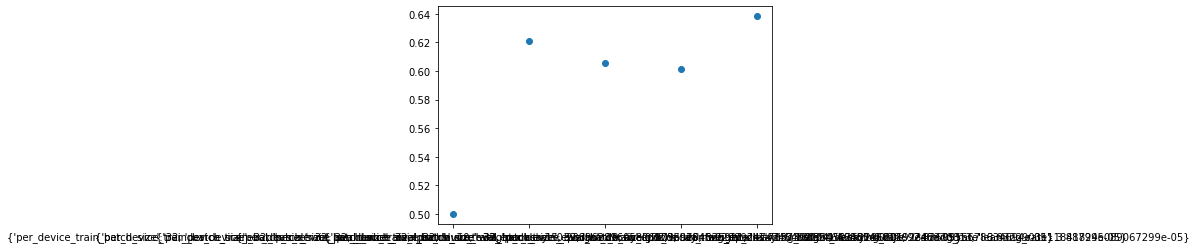

In [ ]:
configs = []
f1s =[]
for trial in trials:
  configs.append(str(trial.iloc[-1]['config']))
  f1s.append(trial.iloc[-1]['eval_f1'])

plt.scatter(configs,f1s)

In [ ]:
configs

["{'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 32, 'num_train_epochs': 10, 'weight_decay': 0.23896289605806903, 'learning_rate': 1.7337391594646555e-05}",
 "{'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 32, 'num_train_epochs': 15, 'weight_decay': 0.17959754525911, 'learning_rate': 1.624074561769746e-05}",
 "{'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 32, 'num_train_epochs': 10, 'weight_decay': 0.029992474745400004, 'learning_rate': 2.8369955678634694e-05}",
 "{'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 32, 'num_train_epochs': 10, 'weight_decay': 0.18033450352296201, 'learning_rate': 3.8322903111841824e-05}",
 "{'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 32, 'num_train_epochs': 15, 'weight_decay': 0.01692347370813, 'learning_rate': 3.887995089067299e-05}"]

In [ ]:
f1s

[0.5,
 0.620938628158844,
 0.605633802816901,
 0.6014492753623181,
 0.638297872340425]

#Cross-Validation

In [ ]:
#4-Fold psuedo CV
ds1 = Dataset.from_pandas(df).train_test_split(test_size=0.2, seed=1)
ds2 = Dataset.from_pandas(df).train_test_split(test_size=0.2, seed=2)
ds3 = Dataset.from_pandas(df).train_test_split(test_size=0.2, seed=3)
ds4 = Dataset.from_pandas(df).train_test_split(test_size=0.2, seed=4)
tds1 = ds1.map(tokenize_and_align_labels, batched=True)
tds2 = ds2.map(tokenize_and_align_labels, batched=True)
tds3 = ds3.map(tokenize_and_align_labels, batched=True)
tds4 = ds4.map(tokenize_and_align_labels, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
args = TrainingArguments(
    "bert-finetune",
    evaluation_strategy = "epoch",
    learning_rate=3.887995089067299e-05,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=15,
    weight_decay=0.01692347370813,
    logging_steps=1   
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
#Fold 1
model = AutoModelForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(label_list))
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

trainer = Trainer(
    model,
    args,
    train_dataset=tds1["train"],
    eval_dataset=tds1["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    #model_init = model_init
)
trainer.train()

trainer.evaluate()

predictions, labels, _ = trainer.predict(tds1["test"])
predictions = np.argmax(predictions, axis=2)

true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results_fold1 = metric.compute(predictions=true_predictions, references=true_labels, zero_division=1)
print(results_fold1)

#Fold 2
model = AutoModelForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(label_list))
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

trainer = Trainer(
    model,
    args,
    train_dataset=tds2["train"],
    eval_dataset=tds2["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    #model_init = model_init
)
trainer.train()

trainer.evaluate()

predictions, labels, _ = trainer.predict(tds2["test"])
predictions = np.argmax(predictions, axis=2)

true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results_fold2 = metric.compute(predictions=true_predictions, references=true_labels, zero_division=1)
print(results_fold2)

#Fold 3
model = AutoModelForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(label_list))
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

trainer = Trainer(
    model,
    args,
    train_dataset=tds3["train"],
    eval_dataset=tds3["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    #model_init = model_init
)
trainer.train()

trainer.evaluate()

predictions, labels, _ = trainer.predict(tds3["test"])
predictions = np.argmax(predictions, axis=2)

true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results_fold3 = metric.compute(predictions=true_predictions, references=true_labels, zero_division=1)
print(results_fold3)
#Fold 4
model = AutoModelForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(label_list))
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

trainer = Trainer(
    model,
    args,
    train_dataset=tds4["train"],
    eval_dataset=tds4["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    #model_init = model_init
)
trainer.train()

trainer.evaluate()

predictions, labels, _ = trainer.predict(tds4["test"])
predictions = np.argmax(predictions, axis=2)

true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results_fold4 = metric.compute(predictions=true_predictions, references=true_labels, zero_division=1)
print(results_fold4)

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "

The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: Sentences, Coded. If Sentences, Coded are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 123
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: Sentences, Coded. If Sentences, Coded are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 123
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: Sentences, Coded. If Sentences, Coded are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
 

The following columns in the test set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: Sentences, Coded. If Sentences, Coded are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 123
  Batch size = 32
loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",

{'BAYES FACTOR, BAYESIAN ESTIMATION': {'precision': 0.6222222222222222, 'recall': 0.7368421052631579, 'f1': 0.6746987951807228, 'number': 38}, 'CHI-SQUARE, FISHER EXACT': {'precision': 0.3333333333333333, 'recall': 0.5, 'f1': 0.4, 'number': 18}, 'MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)': {'precision': 0.7105263157894737, 'recall': 0.5625, 'f1': 0.627906976744186, 'number': 48}, 'NON-PARAMETRIC TESTS': {'precision': 0.6333333333333333, 'recall': 0.6785714285714286, 'f1': 0.6551724137931035, 'number': 28}, 'OLS GLM': {'precision': 0.5963302752293578, 'recall': 0.6074766355140186, 'f1': 0.6018518518518519, 'number': 107}, 'OTHER': {'precision': 1.0, 'recall': 0.0, 'f1': 0.0, 'number': 2}, 'ROBUST MODELS (BOOTSTRAPPED OLS, HCSES, M-ESTIMATORS, ROBUST TRIMMING)': {'precision': 0.5263157894736842, 'recall': 0.8333333333333334, 'f1': 0.6451612903225806, 'number': 24}, 'SCALE DEVELOPMENT, FACTOR ANALYSIS, PCA': {'precision': 0.7058823529411765, 'recall': 0.72, 'f1': 0.

loading weights file https://huggingface.co/bert-base-cased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/092cc582560fc3833e556b3f833695c26343cb54b7e88cd02d40821462a74999.1f48cab6c959fc6c360d22bea39d06959e90f5b002e77e836d2da45464875cda
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification f

The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: Sentences, Coded. If Sentences, Coded are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 123
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: Sentences, Coded. If Sentences, Coded are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 123
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: Sentences, Coded. If Sentences, Coded are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
 

The following columns in the test set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: Sentences, Coded. If Sentences, Coded are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 123
  Batch size = 32
loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",

{'BAYES FACTOR, BAYESIAN ESTIMATION': {'precision': 0.746031746031746, 'recall': 0.8703703703703703, 'f1': 0.8034188034188035, 'number': 54}, 'CHI-SQUARE, FISHER EXACT': {'precision': 0.5263157894736842, 'recall': 0.9090909090909091, 'f1': 0.6666666666666666, 'number': 11}, 'MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)': {'precision': 0.5882352941176471, 'recall': 0.43478260869565216, 'f1': 0.5, 'number': 46}, 'NON-PARAMETRIC TESTS': {'precision': 0.7894736842105263, 'recall': 0.9375, 'f1': 0.8571428571428572, 'number': 16}, 'OLS GLM': {'precision': 0.4666666666666667, 'recall': 0.6363636363636364, 'f1': 0.5384615384615385, 'number': 77}, 'ROBUST MODELS (BOOTSTRAPPED OLS, HCSES, M-ESTIMATORS, ROBUST TRIMMING)': {'precision': 0.35294117647058826, 'recall': 0.6666666666666666, 'f1': 0.46153846153846156, 'number': 18}, 'SCALE DEVELOPMENT, FACTOR ANALYSIS, PCA': {'precision': 0.6428571428571429, 'recall': 0.75, 'f1': 0.6923076923076924, 'number': 60}, 'overall_precision

loading weights file https://huggingface.co/bert-base-cased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/092cc582560fc3833e556b3f833695c26343cb54b7e88cd02d40821462a74999.1f48cab6c959fc6c360d22bea39d06959e90f5b002e77e836d2da45464875cda
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification f

The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: Sentences, Coded. If Sentences, Coded are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 123
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: Sentences, Coded. If Sentences, Coded are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 123
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: Sentences, Coded. If Sentences, Coded are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
 

The following columns in the test set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: Sentences, Coded. If Sentences, Coded are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 123
  Batch size = 32
loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",

{'BAYES FACTOR, BAYESIAN ESTIMATION': {'precision': 0.7666666666666667, 'recall': 0.8679245283018868, 'f1': 0.8141592920353983, 'number': 53}, 'CHI-SQUARE, FISHER EXACT': {'precision': 0.6923076923076923, 'recall': 0.47368421052631576, 'f1': 0.5625, 'number': 19}, 'MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)': {'precision': 0.6, 'recall': 0.5, 'f1': 0.5454545454545454, 'number': 18}, 'NON-PARAMETRIC TESTS': {'precision': 0.75, 'recall': 0.8076923076923077, 'f1': 0.7777777777777779, 'number': 26}, 'OLS GLM': {'precision': 0.5303030303030303, 'recall': 0.5833333333333334, 'f1': 0.5555555555555556, 'number': 60}, 'OTHER': {'precision': 1.0, 'recall': 0.0, 'f1': 0.0, 'number': 1}, 'ROBUST MODELS (BOOTSTRAPPED OLS, HCSES, M-ESTIMATORS, ROBUST TRIMMING)': {'precision': 0.5769230769230769, 'recall': 0.7142857142857143, 'f1': 0.6382978723404256, 'number': 21}, 'SCALE DEVELOPMENT, FACTOR ANALYSIS, PCA': {'precision': 0.8548387096774194, 'recall': 0.8833333333333333, 'f1': 0

loading weights file https://huggingface.co/bert-base-cased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/092cc582560fc3833e556b3f833695c26343cb54b7e88cd02d40821462a74999.1f48cab6c959fc6c360d22bea39d06959e90f5b002e77e836d2da45464875cda
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification f

The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: Sentences, Coded. If Sentences, Coded are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 123
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: Sentences, Coded. If Sentences, Coded are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 123
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: Sentences, Coded. If Sentences, Coded are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
 

The following columns in the test set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: Sentences, Coded. If Sentences, Coded are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 123
  Batch size = 32


{'BAYES FACTOR, BAYESIAN ESTIMATION': {'precision': 0.7777777777777778, 'recall': 0.7777777777777778, 'f1': 0.7777777777777778, 'number': 45}, 'CHI-SQUARE, FISHER EXACT': {'precision': 0.3888888888888889, 'recall': 0.6363636363636364, 'f1': 0.4827586206896552, 'number': 11}, 'MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)': {'precision': 0.5625, 'recall': 0.6206896551724138, 'f1': 0.5901639344262296, 'number': 29}, 'NON-PARAMETRIC TESTS': {'precision': 0.6666666666666666, 'recall': 0.8888888888888888, 'f1': 0.761904761904762, 'number': 27}, 'OLS GLM': {'precision': 0.5576923076923077, 'recall': 0.8055555555555556, 'f1': 0.6590909090909091, 'number': 72}, 'ROBUST MODELS (BOOTSTRAPPED OLS, HCSES, M-ESTIMATORS, ROBUST TRIMMING)': {'precision': 0.45714285714285713, 'recall': 0.7272727272727273, 'f1': 0.5614035087719298, 'number': 22}, 'SCALE DEVELOPMENT, FACTOR ANALYSIS, PCA': {'precision': 0.5753424657534246, 'recall': 0.7368421052631579, 'f1': 0.6461538461538462, 'numbe

In [ ]:
print(results_fold1)
print(results_fold2)
print(results_fold3)
print(results_fold4)

{'BAYES FACTOR, BAYESIAN ESTIMATION': {'precision': 0.6222222222222222, 'recall': 0.7368421052631579, 'f1': 0.6746987951807228, 'number': 38}, 'CHI-SQUARE, FISHER EXACT': {'precision': 0.3333333333333333, 'recall': 0.5, 'f1': 0.4, 'number': 18}, 'MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)': {'precision': 0.7105263157894737, 'recall': 0.5625, 'f1': 0.627906976744186, 'number': 48}, 'NON-PARAMETRIC TESTS': {'precision': 0.6333333333333333, 'recall': 0.6785714285714286, 'f1': 0.6551724137931035, 'number': 28}, 'OLS GLM': {'precision': 0.5963302752293578, 'recall': 0.6074766355140186, 'f1': 0.6018518518518519, 'number': 107}, 'OTHER': {'precision': 1.0, 'recall': 0.0, 'f1': 0.0, 'number': 2}, 'ROBUST MODELS (BOOTSTRAPPED OLS, HCSES, M-ESTIMATORS, ROBUST TRIMMING)': {'precision': 0.5263157894736842, 'recall': 0.8333333333333334, 'f1': 0.6451612903225806, 'number': 24}, 'SCALE DEVELOPMENT, FACTOR ANALYSIS, PCA': {'precision': 0.7058823529411765, 'recall': 0.72, 'f1': 0.

In [ ]:
folds = [results_fold1, results_fold2, results_fold3, results_fold4]
CV_F1S = [i['overall_f1'] for i in folds]
CV_P = [i['overall_precision'] for i in folds]
CV_R = [i['overall_recall'] for i in folds]

print("Mean F1 across folds: {}".format(np.mean(CV_F1S)))
print("F1 Std across folds: {}".format(np.std(CV_F1S)))
print("Mean Precision across folds: {}".format(np.mean(CV_P)))
print("Precision Std across folds: {}".format(np.std(CV_P)))
print("Mean Recall across folds: {}".format(np.mean(CV_R)))
print("Recall Std across folds: {}".format(np.std(CV_R)))

Mean F1 across folds: 0.6573959134876934
F1 Std across folds: 0.03420293054496009
Mean Precision across folds: 0.614629591627967
Precision Std across folds: 0.048248536276856734
Mean Recall across folds: 0.7097212878751025
Recall Std across folds: 0.041376035637473094


#Final Model

In [ ]:
args = TrainingArguments(
    "bert-finetune",
    evaluation_strategy = "epoch",
    learning_rate = 3.887995089067299e-05,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    weight_decay=0.01692347370813,
    logging_steps=1
)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    #model_init = model_init
)
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: Coded, Sentences. If Coded, Sentences are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 491
  Num Epochs = 20
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 320


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: Coded, Sentences. If Coded, Sentences are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 123
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: Coded, Sentences. If Coded, Sentences are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 123
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: Coded, Sentences. If Coded, Sentences are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
 

TrainOutput(global_step=320, training_loss=0.12153879325378511, metrics={'train_runtime': 230.618, 'train_samples_per_second': 42.581, 'train_steps_per_second': 1.388, 'total_flos': 638783669157000.0, 'train_loss': 0.12153879325378511, 'epoch': 20.0})

In [ ]:
trainer.evaluate()

predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels, zero_division=1)
print(results)

The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: Coded, Sentences. If Coded, Sentences are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 123
  Batch size = 32


The following columns in the test set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: Coded, Sentences. If Coded, Sentences are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 123
  Batch size = 32


{'BAYES FACTOR, BAYESIAN ESTIMATION': {'precision': 0.6612903225806451, 'recall': 0.8367346938775511, 'f1': 0.7387387387387386, 'number': 49}, 'CHI-SQUARE, FISHER EXACT': {'precision': 0.3333333333333333, 'recall': 0.5263157894736842, 'f1': 0.4081632653061224, 'number': 19}, 'NON-PARAMETRIC TESTS': {'precision': 0.6451612903225806, 'recall': 0.7142857142857143, 'f1': 0.6779661016949152, 'number': 28}, 'OLS GLM': {'precision': 0.6060606060606061, 'recall': 0.6896551724137931, 'f1': 0.6451612903225807, 'number': 145}, 'ROBUST MODELS (BOOTSTRAPPED OLS, HCSES, M-ESTIMATORS, ROBUST TRIMMING)': {'precision': 0.5294117647058824, 'recall': 0.75, 'f1': 0.6206896551724139, 'number': 12}, 'SCALE DEVELOPMENT, FACTOR ANALYSIS, PCA': {'precision': 0.6428571428571429, 'recall': 0.9310344827586207, 'f1': 0.7605633802816901, 'number': 29}, 'overall_precision': 0.5965417867435159, 'overall_recall': 0.7340425531914894, 'overall_f1': 0.65818759936407, 'overall_accuracy': 0.9539444361907592}


In [ ]:
results

{'BAYES FACTOR, BAYESIAN ESTIMATION': {'precision': 0.6216216216216216,
  'recall': 0.6571428571428571,
  'f1': 0.6388888888888888,
  'number': 35},
 'CHI-SQUARE, FISHER EXACT': {'precision': 0.6666666666666666,
  'recall': 0.6363636363636364,
  'f1': 0.6511627906976744,
  'number': 22},
 'MIXED EFFECTS, MLMS, GROWTH MODELS, GENERALISED LMS (INC LOGREG)': {'precision': 0.6428571428571429,
  'recall': 0.6923076923076923,
  'f1': 0.6666666666666666,
  'number': 39},
 'NON-PARAMETRIC TESTS': {'precision': 0.7804878048780488,
  'recall': 0.8888888888888888,
  'f1': 0.8311688311688312,
  'number': 36},
 'OLS GLM': {'precision': 0.58,
  'recall': 0.5742574257425742,
  'f1': 0.5771144278606964,
  'number': 101},
 'OTHER': {'precision': 1.0, 'recall': 0.0, 'f1': 0.0, 'number': 2},
 'ROBUST MODELS (BOOTSTRAPPED OLS, HCSES, M-ESTIMATORS, ROBUST TRIMMING)': {'precision': 0.3409090909090909,
  'recall': 0.6521739130434783,
  'f1': 0.44776119402985076,
  'number': 23},
 'SCALE DEVELOPMENT, FACTOR A

In [ ]:
model.save_pretrained("/content/drive/MyDrive/Colab Notebooks/scibert_cased-finetune")